<a href="https://colab.research.google.com/github/Saran-nns/tripletstdp/blob/main/SORN2009_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SORN 2009 Model 
### Initialized with 20 percent connection density. 
### No noise during simulation. Number of input nodes 10
### Weights are initialized from Uniform distribution [0,1]
### eSTDP - 0.001
### eIP - 0.001

### IMPORT REQUIRED LIBRARIES





In [ ]:
from __future__ import division
import numpy as np
from scipy.stats import norm
import random
import tqdm
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import heapq
import pickle


### UTILS

In [ ]:
def normalize_weight_matrix(weight_matrix):
    
    # Applied only while initializing the weight. Later Synaptic scalling applied on weight matrices
    
    """ Normalize the weights in the matrix such that incoming connections to a neuron sum up to 1
    
    Args:
        weight_matrix(array) -- Incoming Weights from W_ee or W_ei or W_ie
    
    Returns:
        weight_matrix(array) -- Normalized weight matrix"""

    normalized_weight_matrix = weight_matrix / np.sum(weight_matrix,axis = 0)

    return normalized_weight_matrix

### Implement lambda incoming connections for Excitatory neurons and outgoing connections per Inhibitory neuron

In [ ]:


def generate_lambd_connections(synaptic_connection,ne,ni, lambd_w,lambd_std):
    
    
    """
    Args:
    synaptic_connection -  Type of sysnpatic connection (EE,EI or IE)
    ne - Number of excitatory units
    ni - Number of inhibitory units
    lambd_w - Average number of incoming connections
    lambd_std - Standard deviation of average number of connections per neuron
    
    Returns:
    
    connection_weights - Weight matrix
    
    """
    
    
    if synaptic_connection == 'EE':
        
        
        """Choose random lamda connections per neuron"""

        # Draw normally distribued ne integers with mean lambd_w

        lambdas_incoming = norm.ppf(np.random.random(ne), loc=lambd_w, scale=lambd_std).astype(int)
        
        # lambdas_outgoing = norm.ppf(np.random.random(ne), loc=lambd_w, scale=lambd_std).astype(int)
    
        # List of neurons 

        list_neurons= list(range(ne))

        # Connection weights

        connection_weights = np.zeros((ne,ne))

        # For each lambd value in the above list,
        # generate weights for incoming and outgoing connections
            
        #-------------Gaussian Distribution of weights --------------
            
        # weight_matrix = np.random.randn(Sorn.ne, Sorn.ni) + 2 # Small random values from gaussian distribution
                                                                # Centered around 2 to make all values positive 
            
        # ------------Uniform Distribution --------------------------
        global_incoming_weights = np.random.uniform(0.0,0.1,sum(lambdas_incoming))
        
        # Index Counter
        global_incoming_weights_idx = 0
        
        # Choose the neurons in order [0 to 199]
        
        for neuron in list_neurons:

            ### Choose ramdom unique (lambdas[neuron]) neurons from  list_neurons
            possible_connections = list_neurons.copy()
            
            possible_connections.remove(neuron)  # Remove the selected neuron from possible connections i!=j
            
            # Choose random presynaptic neurons
            possible_incoming_connections = random.sample(possible_connections,lambdas_incoming[neuron])  

           
            incoming_weights_neuron = global_incoming_weights[global_incoming_weights_idx:global_incoming_weights_idx+lambdas_incoming[neuron]]
            
            # ---------- Update the connection weight matrix ------------

            # Update incoming connection weights for selected 'neuron'

            for incoming_idx,incoming_weight in enumerate(incoming_weights_neuron):  
                connection_weights[possible_incoming_connections[incoming_idx]][neuron] = incoming_weight
            
            global_incoming_weights_idx += lambdas_incoming[neuron]
        
        return connection_weights
    
    if synaptic_connection == 'EI':
        
        """Choose random lamda connections per neuron"""

        # Draw normally distribued ni integers with mean lambd_w
        lambdas = norm.ppf(np.random.random(ni), loc=lambd_w, scale=lambd_std).astype(int)
        
        # List of neurons 

        list_neurons= list(range(ni))  # Each i can connect with random ne neurons 

        # Initializing connection weights variable

        connection_weights = np.zeros((ni,ne))

        # ------------Uniform Distribution -----------------------------
        global_outgoing_weights = np.random.uniform(0.0,0.1,sum(lambdas))
        
        # Index Counter
        global_outgoing_weights_idx = 0
        
        # Choose the neurons in order [0 to 40]

        for neuron in list_neurons:

            ### Choose ramdom unique (lambdas[neuron]) neurons from  list_neurons
            possible_connections = list(range(ne))
            
            possible_outgoing_connections = random.sample(possible_connections,lambdas[neuron])  # possible_outgoing connections to the neuron

            # Update weights
            outgoing_weights = global_outgoing_weights[global_outgoing_weights_idx:global_outgoing_weights_idx+lambdas[neuron]]

            # ---------- Update the connection weight matrix ------------

            # Update outgoing connections for the neuron

            for outgoing_idx,outgoing_weight in enumerate(outgoing_weights):  # Update the columns in the connection matrix
                connection_weights[neuron][possible_outgoing_connections[outgoing_idx]] = outgoing_weight
            
            # Update the global weight values index
            global_outgoing_weights_idx += lambdas[neuron]
            
        
        return connection_weights
        
        

### More Util functions

In [ ]:
def get_incoming_connection_dict(weights):
    
    # Get the non-zero entires in columns is the incoming connections for the neurons
    
    # Indices of nonzero entries in the columns
    connection_dict=dict.fromkeys(range(1,len(weights)+1),0)
    
    for i in range(len(weights[0])):  # For each neuron
        connection_dict[i] = list(np.nonzero(weights[:,i])[0])
        
    return connection_dict
    

In [ ]:
def get_outgoing_connection_dict(weights):
    # Get the non-zero entires in rows is the outgoing connections for the neurons
    
    # Indices of nonzero entries in the rows
    connection_dict=dict.fromkeys(range(1,len(weights)+1),1)
    
    for i in range(len(weights[0])):  # For each neuron
        connection_dict[i] = list(np.nonzero(weights[i,:])[0])
        
    return connection_dict

In [ ]:
def prune_small_weights(weights,cutoff_weight):
    
    """ Prune the connections with negative connection strength"""
    weights[weights <= cutoff_weight] = cutoff_weight
    
    return weights
    

In [ ]:
def set_max_cutoff_weight(weights, cutoff_weight):
    
    """ Set cutoff limit for the values in given array"""
    
    weights[weights > cutoff_weight] = cutoff_weight
    
    return weights

In [ ]:
def get_unconnected_indexes(wee):
    
    """
    Helper function for Structural plasticity to randomly select the unconnected units
    
    Args: 
    wee -  Weight matrix
    
    Returns:
    list (indices) // indices = (row_idx,col_idx)"""
    

    i,j = np.where(wee <= 0.)
    indices = list(zip(i,j))
    
    self_conn_removed = []
    for i,idxs in enumerate(indices):
        
        if idxs[0] != idxs[1]:
            
            self_conn_removed.append(indices[i])
    
    return self_conn_removed

In [ ]:
def white_gaussian_noise(mu, sigma,t):

    """Generates white gaussian noise with mean mu, standard deviation sigma and
    the noise length equals t """
    
    noise = np.random.normal(mu, sigma, t)   
    
    return np.expand_dims(noise,1)


In [ ]:
### SANITY CHECK EACH WEIGHTS
#### Note this function has no influence in weight matrix, will be deprecated in next version

def zero_sum_incoming_check(weights):
    
    zero_sum_incomings = np.where(np.sum(weights,axis = 0) == 0.)
    
    if len(zero_sum_incomings[-1]) == 0:
        return weights
    else:
        for zero_sum_incoming in zero_sum_incomings[-1]:
            
            rand_indices = np.random.randint(40,size = 2)  # 5 because each excitatory neuron connects with 5 inhibitory neurons 
                                                            # given the probability of connections 0.2
            rand_values = np.random.uniform(0.0,0.1,2)
            
            for i,idx in enumerate(rand_indices):
                
                weights[:,zero_sum_incoming][idx] = rand_values[i]
            
    return weights

### SORN 

In [ ]:
class Sorn(object):
    
    """SORN 1 network model Initialization"""

    def __init__(self):
        pass

    """Initialize network variables as class variables of SORN"""
    
    nu = 8                    # Number of input units
    ne = 50                   # Number of excitatory units
    ni = int(0.2*ne)           # Number of inhibitory units in the network
    eta_stdp = 0.001
    eta_inhib = 0.001
    eta_ip = 0.01
    te_max = 1.0 
    ti_max = .5
    ti_min = 0.0
    te_min = 0.0
    mu_ip = 2*nu/ne
    sigma_ip  = 0.0 # Standard deviation, variance == 0 
    
    
    # Initialize weight matrices

    def initialize_weight_matrix(self, network_type,synaptic_connection, self_connection, lambd_w): 

        
        """
        Args:
        
        network_type(str) - Spare or Dense
        synaptic_connection(str) - EE,EI,IE: Note that Spare connection is defined only for EE connections
        self_connection(str) - True or False: i-->i ; Network is tested only using j-->i
        lambd_w(int) - Average number of incoming and outgoing connections per neuron
        
        Returns:
        weight_matrix(array) -  Array of connection strengths 
        """
        
        if (network_type == "Sparse") and (self_connection == "False"):

            """Generate weight matrix for E-E/ E-I connections with mean lamda incoming and outgiong connections per neuron"""
            
            weight_matrix = generate_lambd_connections(synaptic_connection,Sorn.ne,Sorn.ni,lambd_w,lambd_std = 1)
        
        # Dense matrix for W_ie

        elif (network_type == 'Dense') and (self_connection == 'False'):

            # Gaussian distribution of weights
            # weight_matrix = np.random.randn(Sorn.ne, Sorn.ni) + 2 # Small random values from gaussian distribution
            # Centered around 1 
            # weight_matrix.reshape(Sorn.ne, Sorn.ni) 
            # weight_matrix *= 0.01 # Setting spectral radius 
            
            # Uniform distribution of weights
            weight_matrix = np.random.uniform(0.0,0.1,(Sorn.ne, Sorn.ni))
            weight_matrix.reshape((Sorn.ne,Sorn.ni))

        return weight_matrix

    def initialize_threshold_matrix(self, te_min,te_max, ti_min,ti_max):

        # Initialize the threshold for excitatory and inhibitory neurons
        
        """Args:
            te_min(float) -- Min threshold value for excitatory units
            ti_min(float) -- Min threshold value for inhibitory units
            te_max(float) -- Max threshold value for excitatory units
            ti_max(float) -- Max threshold value for inhibitory units
        Returns:
            te(vector) -- Threshold values for excitatory units
            ti(vector) -- Threshold values for inhibitory units"""

        te = np.random.uniform(0., te_max, (Sorn.ne, 1))
        ti = np.random.uniform(0., ti_max, (Sorn.ni, 1))

        return te, ti

    def initialize_activity_vector(self,ne, ni):
        
        # Initialize the activity vectors X and Y for excitatory and inhibitory neurons
        
        """Args:
            ne(int) -- Number of excitatory neurons
            ni(int) -- Number of inhibitory neurons
        Returns:
             x(array) -- Array of activity vectors of excitatory population
             y(array) -- Array of activity vectors of inhibitory population"""

        x = np.zeros((ne, 2))
        y = np.zeros((ni, 2))

        return x, y

In [ ]:
# Create and initialize sorn object and varaibles

sorn_init = Sorn()
WEE_init = sorn_init.initialize_weight_matrix(network_type='Sparse',synaptic_connection = 'EE', self_connection='False',lambd_w = 30)
WEI_init = sorn_init.initialize_weight_matrix(network_type='Dense',synaptic_connection = 'EI', self_connection='False',lambd_w = None)
WIE_init = sorn_init.initialize_weight_matrix(network_type='Dense',synaptic_connection = 'IE', self_connection='False',lambd_w = None)

Wee_init = zero_sum_incoming_check(WEE_init)
Wei_init = zero_sum_incoming_check(WEI_init.T)
Wie_init = zero_sum_incoming_check(WIE_init)

c = np.count_nonzero(Wee_init)  
v = np.count_nonzero(Wei_init)  
b = np.count_nonzero(Wie_init) 

print(c,v,b)
print('Shapes Wee %s Wei %s Wie %s' %(Wee_init.shape,Wei_init.shape,Wie_init.shape))

1476 500 500
Shapes Wee (50, 50) Wei (10, 50) Wie (50, 10)


In [ ]:
# Normaalize the incoming weights i.e sum(incoming weights to a neuron) = 1

normalized_wee = normalize_weight_matrix(Wee_init)
normalized_wei = normalize_weight_matrix(Wei_init)
normalized_wie = normalize_weight_matrix(Wie_init)


In [ ]:

normalized_wee = normalize_weight_matrix(Wee_init)
normalized_wei = normalize_weight_matrix(Wei_init)
normalized_wie = normalize_weight_matrix(Wie_init)
te_init, ti_init = sorn_init.initialize_threshold_matrix(Sorn.te_min,Sorn.te_max,Sorn.ti_min,Sorn.ti_max)
x_init, y_init = sorn_init.initialize_activity_vector(Sorn.ne, Sorn.ni)

# Measure the mean number of incoming and outgoing connections in WEE and WEI

In [ ]:
# Initializing variables from sorn_initialize.py

wee_init = normalized_wee.copy()
wei_init = normalized_wei.copy()
wie_init = normalized_wie.copy()
te_init = te_init.copy()
ti_init = ti_init.copy()
x_init = x_init.copy()
y_init = y_init.copy()


In [ ]:
class Plasticity(Sorn):
    """
    Instance of class Sorn. Inherits the variables and functions defined in class Sorn
    Encapsulates all plasticity mechanisms mentioned in the article """

    # Initialize the global variables for the class //Class attributes

    def __init__(self):
        
        super().__init__()
        self.nu = Sorn.nu                  # Number of input units
        self.ne = Sorn.ne                  # Number of excitatory units
        self.eta_stdp = Sorn.eta_stdp      # STDP plasticity Learning rate constant; SORN1 and SORN2
        self.eta_ip = Sorn.eta_ip          # Intrinsic plasticity learning rate constant; SORN1 and SORN2
        self.eta_inhib = Sorn.eta_inhib    # Intrinsic plasticity learning rate constant; SORN2 only
        self.h_ip = 2 * Sorn.nu / Sorn.ne  # Target firing rate
        self.mu_ip = Sorn.mu_ip            # Mean target firing rate  
        self.ni = Sorn.ni                  # Number of inhibitory units in the network
        self.time_steps = Sorn.time_steps  # Total time steps of simulation
        self.te_min = Sorn.te_min          # Excitatory minimum Threshold
        self.te_max = Sorn.te_max          # Excitatory maximum Threshold
        
    def stdp(self, wee, x, cutoff_weights):
        
        """ Apply STDP rule : Regulates synaptic strength between the pre(Xj) and post(Xi) synaptic neurons"""

        x = np.asarray(x)
        xt_1 = x[:,0]
        xt = x[:,1]
        wee_t = wee.copy()
        
        # STDP applies only on the neurons which are connected.
        
        for i in range(len(wee_t[0])): # Each neuron i, Post-synaptic neuron
            
            for j in range(len(wee_t[0:])): # Incoming connection from jth pre-synaptic neuron to ith neuron
                
                if wee_t[j][i] != 0. : # Check connectivity
                    
                    # Get the change in weight
                    delta_wee_t = self.eta_stdp * (xt[i] * xt_1[j] - xt_1[i]*xt[j])

                    # Update the weight between jth neuron to i ""Different from notation in article 

                    wee_t[j][i] = wee[j][i] + delta_wee_t
        
        """ Prune the smallest weights induced by plasticity mechanisms; Apply lower cutoff weight"""
        wee_t = prune_small_weights(wee_t,cutoff_weights[0])
        
        """Check and set all weights < upper cutoff weight """
        wee_t = set_max_cutoff_weight(wee_t,cutoff_weights[1])

        return wee_t

    def triplet_stdp(self, wee, x, cutoff_weights):
        
        """ Apply STDP rule : Regulates synaptic strength between the pre(Xj) and post(Xi) synaptic neurons"""

        x = np.asarray(x)
        xt_1 = x[:,0]
        xt = x[:,1]
        wee_t = wee.copy()
        
        # STDP applies only on the neurons which are connected.
        
        for i in range(len(wee_t[0])): # Each neuron i, Post-synaptic neuron
            
            for j in range(len(wee_t[0:])): # Incoming connection from jth pre-synaptic neuron to ith neuron
                
                if wee_t[j][i] != 0. : # Check connectivity
                    
                    # Get the change in weight
                    delta_wee_t = self.eta_stdp * (xt[i] * xt_1[j] - xt_1[i]*xt[j])

                    # Update the weight between jth neuron to i ""Different from notation in article 

                    wee_t[j][i] = wee[j][i] + delta_wee_t
        
        """ Prune the smallest weights induced by plasticity mechanisms; Apply lower cutoff weight"""
        wee_t = prune_small_weights(wee_t,cutoff_weights[0])
        
        """Check and set all weights < upper cutoff weight """
        wee_t = set_max_cutoff_weight(wee_t,cutoff_weights[1])

        return wee_t

    def ip(self, te, x):
        
        # IP rule: Active unit increases its threshold and inactive decreases its threshold.

        xt = x[:, 1]

        te_update = te + self.eta_ip * (xt.reshape(self.ne, 1) - self.h_ip)
        
        """ Check whether all te are in range [0.0,1.0] and update acordingly"""
        
        # Update te < 0.0 ---> 0.0
        # te_update = prune_small_weights(te_update,self.te_min)
        
        # Set all te > 1.0 --> 1.0
        # te_update = set_max_cutoff_weight(te_update,self.te_max)

        return te_update

    def ss(self, wee_t):
        
        """Synaptic Scaling or Synaptic Normalization"""
        
        wee_t = wee_t / np.sum(wee_t,axis=0)

        return wee_t

    
    def istdp(self, wei, x, y, cutoff_weights):

        #  Apply iSTDP rule : Regulates synaptic strength between the pre(Yj) and post(Xi) synaptic neurons
        
        # Excitaotry network activity
        x = np.asarray(x) # Array sanity check
        xt_1 = x[:, 0]  
        xt = x[:, 1]  
    
        # Inhibitory network activity
        y = np.asarray(y)

        yt_1 = y[:, 0]    
        yt = y[:, 1]  
 

        # iSTDP applies only on the neurons which are connected.
        wei_t = wei.copy()

        for i in range(len(wei_t[0])): # Each neuron i, Post-synaptic neuron: means for each column; 
            
            for j in range(len(wei_t[0:])): # Incoming connection from j, pre-synaptic neuron to ith neuron
                
                if wei_t[j][i] != 0. : # Check connectivity
                    
                    # Get the change in weight
                    delta_wei_t = - self.eta_inhib * yt_1[j] * (1 - xt[i]*(1 + 1/self.mu_ip))

                    # Update the weight between jth neuron to i ""Different from notation in article 

                    wei_t[j][i] = wei[j][i] + delta_wei_t
        
        """ Prune the smallest weights induced by plasticity mechanisms; Apply lower cutoff weight"""
        wei_t = prune_small_weights(wei_t,cutoff_weights[0])
        
        """Check and set all weights < upper cutoff weight """
        wei_t = set_max_cutoff_weight(wei_t,cutoff_weights[1])
        
        return wei_t

    @staticmethod
    def structural_plasticity(wee):

        """ Add new connection value to the smallest weight between excitatory units randomly"""

        p_c = np.random.randint(0, 10, 1)

        if p_c == 0:  # p_c= 0.1

            """ Do structural plasticity """

            # Choose the smallest weights randomly from the weight matrix wee
            
            indexes = get_unconnected_indexes(wee) 

            # Choose any idx randomly
            idx_rand = random.choice(indexes)
            
            if idx_rand[0] == idx_rand[1]:
                
                idx_rand = random.choice(indexes)
                
            wee[idx_rand[0]][idx_rand[1]] = 0.001
            

        return wee

    ###########################################################

    @staticmethod
    def initialize_plasticity():

        wee = wee_init
        wei = wei_init
        wie = wie_init
        te = te_init
        ti = ti_init
        x = x_init
        y = y_init

        return wee, wei, wie, te, ti, x, y

    @staticmethod
    def reorganize_network():
        pass

In [ ]:
class MatrixCollection(Sorn):
    def __init__(self,phase, matrices = None):
        super().__init__()
        
        self.phase = phase
        self.matrices = matrices
        if self.phase == 'Plasticity' and self.matrices == None :

            self.time_steps = Sorn.time_steps + 1  # Total training steps
            self.Wee, self.Wei, self.Wie, self.Te, self.Ti, self.X, self.Y = [0] * self.time_steps, [0] * self.time_steps, \
                                                                             [0] * self.time_steps, [0] * self.time_steps, \
                                                                             [0] * self.time_steps, [0] * self.time_steps, \
                                                                             [0] * self.time_steps
            wee, wei, wie, te, ti, x, y = Plasticity.initialize_plasticity()

            # Assign initial matrix to the master matrices
            self.Wee[0] = wee
            self.Wei[0] = wei
            self.Wie[0] = wie
            self.Te[0] = te
            self.Ti[0] = ti
            self.X[0] = x
            self.Y[0] = y
        
        elif self.phase == 'Plasticity' and self.matrices != None:
            
            self.time_steps = Sorn.time_steps + 1  # Total training steps
            self.Wee, self.Wei, self.Wie, self.Te, self.Ti, self.X, self.Y = [0] * self.time_steps, [0] * self.time_steps, \
                                                                             [0] * self.time_steps, [0] * self.time_steps, \
                                                                             [0] * self.time_steps, [0] * self.time_steps, \
                                                                             [0] * self.time_steps
            # Assign matrices from plasticity phase to the new master matrices for training phase
            self.Wee[0] = matrices['Wee']
            self.Wei[0] = matrices['Wei']
            self.Wie[0] = matrices['Wie']
            self.Te[0] = matrices['Te']
            self.Ti[0] = matrices['Ti']
            self.X[0] = matrices['X']
            self.Y[0] = matrices['Y']
            
        elif self.phase == 'Training':

            """NOTE:
            time_steps here is diferent for plasticity or trianing phase"""
            self.time_steps = Sorn.time_steps + 1  # Total training steps
            self.Wee, self.Wei, self.Wie, self.Te, self.Ti, self.X, self.Y = [0] * self.time_steps, [0] * self.time_steps, \
                                                                             [0] * self.time_steps, [0] * self.time_steps, \
                                                                             [0] * self.time_steps, [0] * self.time_steps, \
                                                                             [0] * self.time_steps
            # Assign matrices from plasticity phase to new respective matrices for training phase
            self.Wee[0] = matrices['Wee']
            self.Wei[0] = matrices['Wei']
            self.Wie[0] = matrices['Wie']
            self.Te[0] = matrices['Te']
            self.Ti[0] = matrices['Ti']
            self.X[0] = matrices['X']
            self.Y[0] = matrices['Y']
            
    def weight_matrix(self, wee, wei, wie, i):
        # Get delta_weight from Plasticity.stdp
    
        # i - training step
        self.Wee[i + 1] = wee
        self.Wei[i + 1] = wei
        self.Wie[i + 1] = wie

        return self.Wee, self.Wei, self.Wie

    def threshold_matrix(self, te, ti, i):
        self.Te[i + 1] = te
        self.Ti[i + 1] = ti
        return self.Te, self.Ti

    def network_activity_t(self, excitatory_net, inhibitory_net, i):
        self.X[i + 1] = excitatory_net
        self.Y[i + 1] = inhibitory_net

        return self.X, self.Y

    def network_activity_t_1(self, x, y, i):
        x_1, y_1 = [0] * self.time_steps, [0] * self.time_steps
        x_1[i] = x
        y_1[i] = y

        return x_1, y_1

In [ ]:
class NetworkState(Plasticity):
    
    """The evolution of network states"""

    def __init__(self, v_t):
        super().__init__()
        self.v_t = v_t
    
    def incoming_drive(self,weights,activity_vector):
            
        # Broadcasting weight*acivity vectors 
        
        incoming = weights* activity_vector
        incoming = np.array(incoming.sum(axis=0))
        return incoming
        
    def excitatory_network_state(self, wee, wei, te, x, y,white_noise_e):
        
        """ Activity of Excitatory neurons in the network"""
    
        xt = x[:, 1]  
        xt = xt.reshape(self.ne, 1)
        yt = y[:, 1]
        yt = yt.reshape(self.ni, 1)
        
        
        incoming_drive_e = np.expand_dims(self.incoming_drive(weights = wee,activity_vector=xt),1)
        incoming_drive_i = np.expand_dims(self.incoming_drive(weights = wei,activity_vector=yt),1)
        
        if self.v_t.shape[0] < self.ne:
            
            inp = [0]*self.ne
            inp[:len(self.v_t)] = self.v_t
            self.v_t = inp.copy()
            
        tot_incoming_drive = incoming_drive_e -  incoming_drive_i + white_noise_e + np.expand_dims(np.asarray(self.v_t),1) - te
        
        """Heaviside step function"""

        # Heaviside step function
        heaviside_step = np.expand_dims([0.0] * len(tot_incoming_drive), 1)
        heaviside_step[tot_incoming_drive > 0] = 1.0
        xt_next = np.asarray(
            heaviside_step.copy()
        )  # Additional Memory cost just for the sake of variable name
        return xt_next

    def inhibitory_network_state(self, wie, ti, x,white_noise_i):

        # Activity of inhibitory neurons

        wie = np.asarray(wie)
        xt = x[:, 1]
        xt = xt.reshape(Sorn.ne, 1)
    
        incoming_drive_e = np.expand_dims(self.incoming_drive(weights = wie,activity_vector=xt),1)
        
        tot_incoming_drive = incoming_drive_e + white_noise_i - ti
        
        """Implement Heaviside step function"""

        heaviside_step = np.expand_dims([0.0] * len(tot_incoming_drive), 1)
        heaviside_step[tot_incoming_drive > 0] = 1.0

        yt_next = np.asarray(
            heaviside_step.copy()
        )  # Additional Memory cost just for the sake of variable name

        return yt_next

    
    def recurrent_drive(self, wee, wei, te, x, y,white_noise_e):
        
        """Network state due to recurrent drive received by the each unit at time t+1"""
        
    
        xt = x[:, 1]  
        xt = xt.reshape(self.ne, 1)
        yt = y[:, 1]
        yt = yt.reshape(self.ni, 1)
        
        incoming_drive_e = np.expand_dims(self.incoming_drive(weights = wee,activity_vector=xt),1)
        incoming_drive_i = np.expand_dims(self.incoming_drive(weights = wei,activity_vector=yt),1)
        
        tot_incoming_drive = incoming_drive_e -  incoming_drive_i + white_noise_e - te
        
        """Heaviside step function"""

        heaviside_step = np.expand_dims([0.0] * len(tot_incoming_drive), 1)
        heaviside_step[tot_incoming_drive > 0] = 1.0
        xt_next = np.asarray(
            heaviside_step.copy()
        )  # Additional Memory cost just for the sake of variable name

        return xt_next

    

### Train SORN

In [ ]:
class TrainSornPlasticity(Sorn):
    
    
    """
        Args:
        inputs - one hot vector of inputs
    
        Returns:
        matrix_collection - collection of all weight matrices in dictionaries
        """
    
    def __init__(self):
        
        super().__init__()
        
        pass
        

    
    def train_sorn(self,phase,matrices,inputs):
        
        self.phase = phase
        self.time_steps = 1
        Sorn.time_steps = 1
        self.inputs = np.asarray(inputs)
        self.phase = phase
        self.matrices = matrices
        
        # Collect the network activity at all time steps
        
        X_all = [0]*self.time_steps
        Y_all = [0]*self.time_steps
        R_all = [0]*self.time_steps
        
        frac_pos_active_conn = []
         
        """ DONOT INITIALIZE WEIGHTS"""
        
        matrix_collection = MatrixCollection(phase = self.phase, matrices = self.matrices)  
        
        for i in range(1):
            
            """ Generate white noise"""
            # white_noise_e = white_gaussian_noise(mu= 0., sigma = 0.04,t = Sorn.ne)
            # white_noise_i = white_gaussian_noise(mu= 0., sigma = 0.04,t = Sorn.ni)
            
            network_state = NetworkState(self.inputs.T)  # Feed Input as an argument to the class
            

            # Buffers to get the resulting x and y vectors at the current time step and update the master matrix

            x_buffer, y_buffer = np.zeros(( Sorn.ne, 2)), np.zeros((Sorn.ni, 2))

            te_buffer, ti_buffer = np.zeros((Sorn.ne, 1)), np.zeros((Sorn.ni, 1))

            # Get the matrices and rename them for ease of reading

            Wee, Wei, Wie = matrix_collection.Wee, matrix_collection.Wei, matrix_collection.Wie
            Te, Ti = matrix_collection.Te, matrix_collection.Ti
            X, Y = matrix_collection.X, matrix_collection.Y
            
            
            # Recurrent drive at t+1 used to predict the next external stimuli
            
            r = network_state.recurrent_drive(Wee[i], Wei[i], Te[i], X[i], Y[i],white_noise_e = 0.)

            """Get excitatory states and inhibitory states given the weights and thresholds"""

            # x(t+1), y(t+1)
            excitatory_state_xt_buffer = network_state.excitatory_network_state(Wee[i], Wei[i], Te[i], X[i], Y[i],white_noise_e = 0.)

            inhibitory_state_yt_buffer = network_state.inhibitory_network_state(Wie[i], Ti[i], X[i],white_noise_i = 0.)
            
            
            """ Update X and Y """
            x_buffer[:, 0] = X[i][:, 1]  # xt -->(becomes) xt_1
            x_buffer[:, 1] = excitatory_state_xt_buffer.T  # New_activation; x_buffer --> xt
            

            y_buffer[:, 0] = Y[i][:, 1]
            y_buffer[:, 1] = inhibitory_state_yt_buffer.T
            

            """Plasticity phase"""

            plasticity = Plasticity()

            # STDP 
            Wee_t = plasticity.stdp(Wee[i],x_buffer,cutoff_weights = (0.0,1.0))
              
            # Intrinsic plasticity
            Te_t = plasticity.ip(Te[i],x_buffer)
              
            # Structural plasticity
            Wee_t = plasticity.structural_plasticity(Wee_t)      
            
            # iSTDP 
            Wei_t = plasticity.istdp(Wei[i],x_buffer,y_buffer,cutoff_weights = (0.0,1.0))
            
            # Synaptic scaling Wee
            Wee_t = Plasticity().ss(Wee_t)
            
            # Synaptic scaling Wei
            Wei_t = Plasticity().ss(Wei_t)

            """Assign the matrices to the matrix collections"""
            matrix_collection.weight_matrix(Wee_t, Wei[i], Wie[i], i)
            matrix_collection.threshold_matrix(Te_t, Ti[i], i)
            matrix_collection.network_activity_t(x_buffer, y_buffer, i)
            
            X_all[i] = x_buffer[:,1]
            Y_all[i] = y_buffer[:,1]
            R_all[i] = r
   
        plastic_matrices = {'Wee':matrix_collection.Wee[-1], 
                            'Wei': matrix_collection.Wei[-1], 
                            'Wie':matrix_collection.Wie[-1],
                            'Te': matrix_collection.Te[-1], 'Ti': matrix_collection.Ti[-1],
                            'X': X[-1], 'Y': Y[-1]}
        
        return plastic_matrices,X_all,Y_all,R_all,frac_pos_active_conn

### Train SORN without plasticity

In [ ]:
class TrainSorn(Sorn):
    
    
    """
        Args:
        inputs - one hot vector of inputs
    
        Returns:
        matrix_collection - collection of all weight matrices in dictionaries
        """
    
    def __init__(self):
        
        super().__init__()
        
        pass
        

    
    def train_sorn(self,phase,matrices,inputs):
        
        self.phase = phase
        self.time_steps = 1
        Sorn.time_steps = 1
        self.inputs = np.asarray(inputs)
        self.phase = phase
        self.matrices = matrices
        
        # Collect the network activity at all time steps
        
        X_all = [0]*self.time_steps
        Y_all = [0]*self.time_steps
        R_all = [0]*self.time_steps
        
        frac_pos_active_conn = []
         
        """ DONOT INITIALIZE WEIGHTS"""
        
        matrix_collection = MatrixCollection(phase = self.phase, matrices = self.matrices)  
        
        for i in range(1):
            
            """ Generate white noise"""
            # white_noise_e = white_gaussian_noise(mu= 0., sigma = 0.04,t = Sorn.ne)
            # white_noise_i = white_gaussian_noise(mu= 0., sigma = 0.04,t = Sorn.ni)

            network_state = NetworkState(self.inputs.T)  # Feed Input as an argument to the class
            

            # Buffers to get the resulting x and y vectors at the current time step and update the master matrix

            x_buffer, y_buffer = np.zeros(( Sorn.ne, 2)), np.zeros((Sorn.ni, 2))

            te_buffer, ti_buffer = np.zeros((Sorn.ne, 1)), np.zeros((Sorn.ni, 1))

            # Get the matrices and rename them for ease of reading

            Wee, Wei, Wie = matrix_collection.Wee, matrix_collection.Wei, matrix_collection.Wie
            Te, Ti = matrix_collection.Te, matrix_collection.Ti
            X, Y = matrix_collection.X, matrix_collection.Y
            
            
            # Recurrent drive at t+1 used to predict the next external stimuli
            
            r = network_state.recurrent_drive(Wee[i], Wei[i], Te[i], X[i], Y[i],white_noise_e = 0.)

            """Get excitatory states and inhibitory states given the weights and thresholds"""

            # x(t+1), y(t+1)
            excitatory_state_xt_buffer = network_state.excitatory_network_state(Wee[i], Wei[i], Te[i], X[i], Y[i],white_noise_e = 0.)

            inhibitory_state_yt_buffer = network_state.inhibitory_network_state(Wie[i], Ti[i], X[i],white_noise_i = 0.)
            
            
            """ Update X and Y """
            x_buffer[:, 0] = X[i][:, 1]  # xt -->(becomes) xt_1
            x_buffer[:, 1] = excitatory_state_xt_buffer.T  # New_activation; x_buffer --> xt
            

            y_buffer[:, 0] = Y[i][:, 1]
            y_buffer[:, 1] = inhibitory_state_yt_buffer.T
            

            """Plasticity phase"""

#             plasticity = Plasticity()

#             STDP 
#             Wee_t = plasticity.stdp(Wee[i],x_buffer,cutoff_weights = (0.0,1.0))
              
#             Intrinsic plasticity
#             Te_t = plasticity.ip(Te[i],x_buffer)
              
#             Structural plasticity
#             Wee_t = plasticity.structural_plasticity(Wee_t)      
            
#             iSTDP 
#             Wei_t = plasticity.istdp(Wei[i],x_buffer,y_buffer,cutoff_weights = (0.0,1.0))
            
#             Synaptic scaling Wee
#             Wee_t = Plasticity().ss(Wee_t)
            
#             Synaptic scaling Wei
#             Wei_t = Plasticity().ss(Wei_t)

            """Assign the matrices to the matrix collections"""
            matrix_collection.weight_matrix(Wee[i], Wei[i], Wie[i], i)
            matrix_collection.threshold_matrix(Te[i], Ti[i], i)
            matrix_collection.network_activity_t(x_buffer, y_buffer, i)
            
            X_all[i] = x_buffer[:,1]
            Y_all[i] = y_buffer[:,1]
            R_all[i] = r
   
        plastic_matrices = {'Wee':matrix_collection.Wee[-1], 
                            'Wei': matrix_collection.Wei[-1], 
                            'Wie':matrix_collection.Wie[-1],
                            'Te': matrix_collection.Te[-1], 'Ti': matrix_collection.Ti[-1],
                            'X': X[-1], 'Y': Y[-1]}
        
        return plastic_matrices,X_all,Y_all,R_all,frac_pos_active_conn

### CART POLE ENVIRONMENT 

In [ ]:
# Init sorn object
    
train_sorn = TrainSorn()
train_sorn_plasticity = TrainSornPlasticity()
  

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image



In [ ]:
def relu(vector):
    vector[vector < 0] = 0
    return vector

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

### MODEL

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import copy 

# Hyperparameters
NUM_EPISODES = 200001
LEARNING_RATE = 0.0001
GAMMA = 0.99


# Create gym and seed numpy
env = gym.make('CartPole-v0')
nA = env.action_space.n

env.seed(1)
np.random.seed(1)

# Init weight
w = np.random.rand(50, 2)

# Keep stats for final print of graph
episode_rewards = []

# Our policy that maps state to action parameterized by w
def policy(state,w):
    
#     print('Policy : States shape %s, Weights shape %s' %(state.shape,w.shape))
    z = state.dot(w)
    exp = np.exp(z)
    return exp/np.sum(exp)

# Vectorized softmax Jacobian
def softmax_grad(softmax):
    
#     print('Softmax gradient %s:'%softmax.shape)
    s = softmax.reshape(-1,1)
#     print('Rehspaed: Softmax gradient %s:',softmax.shape)
#     print('Rehspaed: Softmax gradient %s:',np.diagflat(s))
#     print('Reshaped: Softmax gradient %s:',np.dot(s, s.T))
#     print('Reshaped: Softmax gradient %s:',np.diagflat(s) - np.dot(s, s.T))
    return np.diagflat(s) - np.dot(s, s.T)

Episode 0  Score 25.0
Episode 1  Score 22.0
Episode 2  Score 15.0
Episode 3  Score 13.0
Episode 4  Score 24.0
Episode 5  Score 20.0
Episode 6  Score 24.0
Episode 7  Score 14.0
Episode 8  Score 16.0
Episode 9  Score 13.0
Episode 10  Score 14.0
Episode 11  Score 19.0
Episode 12  Score 17.0
Episode 13  Score 21.0
Episode 14  Score 17.0
Episode 15  Score 18.0
Episode 16  Score 24.0
Episode 17  Score 15.0
Episode 18  Score 20.0
Episode 19  Score 14.0
Episode 20  Score 18.0
Episode 21  Score 14.0
Episode 22  Score 18.0
Episode 23  Score 18.0
Episode 24  Score 17.0
Episode 25  Score 14.0
Episode 26  Score 17.0
Episode 27  Score 15.0
Episode 28  Score 15.0
Episode 29  Score 17.0
Episode 30  Score 22.0
Episode 31  Score 16.0
Episode 32  Score 18.0
Episode 33  Score 15.0
Episode 34  Score 16.0
Episode 35  Score 15.0
Episode 36  Score 23.0
Episode 37  Score 15.0
Episode 38  Score 16.0
Episode 39  Score 10.0
Episode 40  Score 13.0
Episode 41  Score 13.0
Episode 42  Score 13.0
Episode 43  Score 17.

Episode 345  Score 12.0
Episode 346  Score 12.0
Episode 347  Score 19.0
Episode 348  Score 28.0
Episode 349  Score 16.0
Episode 350  Score 16.0
Episode 351  Score 16.0
Episode 352  Score 21.0
Episode 353  Score 22.0
Episode 354  Score 13.0
Episode 355  Score 13.0
Episode 356  Score 25.0
Episode 357  Score 19.0
Episode 358  Score 16.0
Episode 359  Score 14.0
Episode 360  Score 17.0
Episode 361  Score 20.0
Episode 362  Score 14.0
Episode 363  Score 15.0
Episode 364  Score 15.0
Episode 365  Score 14.0
Episode 366  Score 14.0
Episode 367  Score 15.0
Episode 368  Score 18.0
Episode 369  Score 16.0
Episode 370  Score 13.0
Episode 371  Score 17.0
Episode 372  Score 14.0
Episode 373  Score 16.0
Episode 374  Score 14.0
Episode 375  Score 21.0
Episode 376  Score 13.0
Episode 377  Score 12.0
Episode 378  Score 18.0
Episode 379  Score 26.0
Episode 380  Score 16.0
Episode 381  Score 16.0
Episode 382  Score 15.0
Episode 383  Score 13.0
Episode 384  Score 14.0
Episode 385  Score 12.0
Episode 386  Sco

Episode 686  Score 14.0
Episode 687  Score 17.0
Episode 688  Score 18.0
Episode 689  Score 14.0
Episode 690  Score 13.0
Episode 691  Score 13.0
Episode 692  Score 13.0
Episode 693  Score 15.0
Episode 694  Score 15.0
Episode 695  Score 25.0
Episode 696  Score 15.0
Episode 697  Score 18.0
Episode 698  Score 14.0
Episode 699  Score 17.0
Episode 700  Score 15.0
Episode 701  Score 18.0
Episode 702  Score 46.0
Episode 703  Score 23.0
Episode 704  Score 19.0
Episode 705  Score 20.0
Episode 706  Score 22.0
Episode 707  Score 14.0
Episode 708  Score 14.0
Episode 709  Score 18.0
Episode 710  Score 14.0
Episode 711  Score 14.0
Episode 712  Score 16.0
Episode 713  Score 14.0
Episode 714  Score 14.0
Episode 715  Score 13.0
Episode 716  Score 16.0
Episode 717  Score 15.0
Episode 718  Score 14.0
Episode 719  Score 15.0
Episode 720  Score 18.0
Episode 721  Score 19.0
Episode 722  Score 21.0
Episode 723  Score 24.0
Episode 724  Score 24.0
Episode 725  Score 18.0
Episode 726  Score 14.0
Episode 727  Sco

Episode 1026  Score 26.0
Episode 1027  Score 15.0
Episode 1028  Score 17.0
Episode 1029  Score 22.0
Episode 1030  Score 25.0
Episode 1031  Score 15.0
Episode 1032  Score 15.0
Episode 1033  Score 12.0
Episode 1034  Score 22.0
Episode 1035  Score 13.0
Episode 1036  Score 14.0
Episode 1037  Score 15.0
Episode 1038  Score 15.0
Episode 1039  Score 16.0
Episode 1040  Score 11.0
Episode 1041  Score 19.0
Episode 1042  Score 15.0
Episode 1043  Score 15.0
Episode 1044  Score 18.0
Episode 1045  Score 17.0
Episode 1046  Score 13.0
Episode 1047  Score 15.0
Episode 1048  Score 19.0
Episode 1049  Score 20.0
Episode 1050  Score 14.0
Episode 1051  Score 19.0
Episode 1052  Score 11.0
Episode 1053  Score 20.0
Episode 1054  Score 15.0
Episode 1055  Score 27.0
Episode 1056  Score 22.0
Episode 1057  Score 19.0
Episode 1058  Score 31.0
Episode 1059  Score 16.0
Episode 1060  Score 21.0
Episode 1061  Score 14.0
Episode 1062  Score 20.0
Episode 1063  Score 13.0
Episode 1064  Score 13.0
Episode 1065  Score 13.0


Episode 1353  Score 33.0
Episode 1354  Score 13.0
Episode 1355  Score 13.0
Episode 1356  Score 20.0
Episode 1357  Score 15.0
Episode 1358  Score 16.0
Episode 1359  Score 13.0
Episode 1360  Score 14.0
Episode 1361  Score 14.0
Episode 1362  Score 16.0
Episode 1363  Score 13.0
Episode 1364  Score 14.0
Episode 1365  Score 13.0
Episode 1366  Score 18.0
Episode 1367  Score 18.0
Episode 1368  Score 14.0
Episode 1369  Score 17.0
Episode 1370  Score 20.0
Episode 1371  Score 13.0
Episode 1372  Score 13.0
Episode 1373  Score 13.0
Episode 1374  Score 13.0
Episode 1375  Score 17.0
Episode 1376  Score 16.0
Episode 1377  Score 17.0
Episode 1378  Score 17.0
Episode 1379  Score 19.0
Episode 1380  Score 13.0
Episode 1381  Score 15.0
Episode 1382  Score 14.0
Episode 1383  Score 14.0
Episode 1384  Score 26.0
Episode 1385  Score 18.0
Episode 1386  Score 10.0
Episode 1387  Score 22.0
Episode 1388  Score 21.0
Episode 1389  Score 13.0
Episode 1390  Score 14.0
Episode 1391  Score 15.0
Episode 1392  Score 14.0


Episode 1680  Score 13.0
Episode 1681  Score 17.0
Episode 1682  Score 20.0
Episode 1683  Score 19.0
Episode 1684  Score 17.0
Episode 1685  Score 10.0
Episode 1686  Score 15.0
Episode 1687  Score 17.0
Episode 1688  Score 13.0
Episode 1689  Score 16.0
Episode 1690  Score 12.0
Episode 1691  Score 16.0
Episode 1692  Score 21.0
Episode 1693  Score 19.0
Episode 1694  Score 21.0
Episode 1695  Score 14.0
Episode 1696  Score 14.0
Episode 1697  Score 15.0
Episode 1698  Score 15.0
Episode 1699  Score 14.0
Episode 1700  Score 15.0
Episode 1701  Score 13.0
Episode 1702  Score 25.0
Episode 1703  Score 21.0
Episode 1704  Score 16.0
Episode 1705  Score 14.0
Episode 1706  Score 18.0
Episode 1707  Score 16.0
Episode 1708  Score 17.0
Episode 1709  Score 21.0
Episode 1710  Score 20.0
Episode 1711  Score 15.0
Episode 1712  Score 13.0
Episode 1713  Score 33.0
Episode 1714  Score 25.0
Episode 1715  Score 16.0
Episode 1716  Score 17.0
Episode 1717  Score 14.0
Episode 1718  Score 16.0
Episode 1719  Score 22.0


Episode 2007  Score 21.0
Episode 2008  Score 19.0
Episode 2009  Score 16.0
Episode 2010  Score 15.0
Episode 2011  Score 17.0
Episode 2012  Score 15.0
Episode 2013  Score 14.0
Episode 2014  Score 18.0
Episode 2015  Score 17.0
Episode 2016  Score 22.0
Episode 2017  Score 21.0
Episode 2018  Score 26.0
Episode 2019  Score 13.0
Episode 2020  Score 25.0
Episode 2021  Score 23.0
Episode 2022  Score 22.0
Episode 2023  Score 12.0
Episode 2024  Score 14.0
Episode 2025  Score 15.0
Episode 2026  Score 12.0
Episode 2027  Score 26.0
Episode 2028  Score 15.0
Episode 2029  Score 15.0
Episode 2030  Score 20.0
Episode 2031  Score 16.0
Episode 2032  Score 18.0
Episode 2033  Score 13.0
Episode 2034  Score 21.0
Episode 2035  Score 19.0
Episode 2036  Score 20.0
Episode 2037  Score 13.0
Episode 2038  Score 23.0
Episode 2039  Score 27.0
Episode 2040  Score 13.0
Episode 2041  Score 13.0
Episode 2042  Score 14.0
Episode 2043  Score 19.0
Episode 2044  Score 14.0
Episode 2045  Score 37.0
Episode 2046  Score 19.0


Episode 2334  Score 15.0
Episode 2335  Score 20.0
Episode 2336  Score 14.0
Episode 2337  Score 18.0
Episode 2338  Score 13.0
Episode 2339  Score 16.0
Episode 2340  Score 21.0
Episode 2341  Score 13.0
Episode 2342  Score 14.0
Episode 2343  Score 12.0
Episode 2344  Score 14.0
Episode 2345  Score 18.0
Episode 2346  Score 13.0
Episode 2347  Score 13.0
Episode 2348  Score 14.0
Episode 2349  Score 18.0
Episode 2350  Score 15.0
Episode 2351  Score 16.0
Episode 2352  Score 16.0
Episode 2353  Score 16.0
Episode 2354  Score 24.0
Episode 2355  Score 14.0
Episode 2356  Score 14.0
Episode 2357  Score 10.0
Episode 2358  Score 14.0
Episode 2359  Score 33.0
Episode 2360  Score 15.0
Episode 2361  Score 25.0
Episode 2362  Score 31.0
Episode 2363  Score 13.0
Episode 2364  Score 15.0
Episode 2365  Score 15.0
Episode 2366  Score 16.0
Episode 2367  Score 18.0
Episode 2368  Score 15.0
Episode 2369  Score 12.0
Episode 2370  Score 20.0
Episode 2371  Score 13.0
Episode 2372  Score 15.0
Episode 2373  Score 14.0


Episode 2661  Score 11.0
Episode 2662  Score 15.0
Episode 2663  Score 17.0
Episode 2664  Score 16.0
Episode 2665  Score 15.0
Episode 2666  Score 17.0
Episode 2667  Score 18.0
Episode 2668  Score 24.0
Episode 2669  Score 25.0
Episode 2670  Score 17.0
Episode 2671  Score 30.0
Episode 2672  Score 12.0
Episode 2673  Score 20.0
Episode 2674  Score 13.0
Episode 2675  Score 14.0
Episode 2676  Score 23.0
Episode 2677  Score 13.0
Episode 2678  Score 22.0
Episode 2679  Score 11.0
Episode 2680  Score 23.0
Episode 2681  Score 16.0
Episode 2682  Score 11.0
Episode 2683  Score 21.0
Episode 2684  Score 18.0
Episode 2685  Score 17.0
Episode 2686  Score 17.0
Episode 2687  Score 17.0
Episode 2688  Score 15.0
Episode 2689  Score 20.0
Episode 2690  Score 28.0
Episode 2691  Score 17.0
Episode 2692  Score 27.0
Episode 2693  Score 16.0
Episode 2694  Score 17.0
Episode 2695  Score 19.0
Episode 2696  Score 19.0
Episode 2697  Score 20.0
Episode 2698  Score 15.0
Episode 2699  Score 27.0
Episode 2700  Score 16.0


Episode 2988  Score 19.0
Episode 2989  Score 14.0
Episode 2990  Score 25.0
Episode 2991  Score 23.0
Episode 2992  Score 13.0
Episode 2993  Score 18.0
Episode 2994  Score 17.0
Episode 2995  Score 20.0
Episode 2996  Score 20.0
Episode 2997  Score 12.0
Episode 2998  Score 10.0
Episode 2999  Score 14.0
Episode 3000  Score 17.0
Episode 3001  Score 20.0
Episode 3002  Score 13.0
Episode 3003  Score 14.0
Episode 3004  Score 15.0
Episode 3005  Score 14.0
Episode 3006  Score 16.0
Episode 3007  Score 25.0
Episode 3008  Score 17.0
Episode 3009  Score 25.0
Episode 3010  Score 24.0
Episode 3011  Score 25.0
Episode 3012  Score 25.0
Episode 3013  Score 20.0
Episode 3014  Score 13.0
Episode 3015  Score 18.0
Episode 3016  Score 20.0
Episode 3017  Score 15.0
Episode 3018  Score 11.0
Episode 3019  Score 22.0
Episode 3020  Score 16.0
Episode 3021  Score 14.0
Episode 3022  Score 15.0
Episode 3023  Score 17.0
Episode 3024  Score 13.0
Episode 3025  Score 18.0
Episode 3026  Score 13.0
Episode 3027  Score 13.0


Episode 3315  Score 13.0
Episode 3316  Score 14.0
Episode 3317  Score 24.0
Episode 3318  Score 12.0
Episode 3319  Score 15.0
Episode 3320  Score 16.0
Episode 3321  Score 16.0
Episode 3322  Score 13.0
Episode 3323  Score 13.0
Episode 3324  Score 12.0
Episode 3325  Score 21.0
Episode 3326  Score 20.0
Episode 3327  Score 15.0
Episode 3328  Score 25.0
Episode 3329  Score 16.0
Episode 3330  Score 15.0
Episode 3331  Score 22.0
Episode 3332  Score 12.0
Episode 3333  Score 11.0
Episode 3334  Score 19.0
Episode 3335  Score 15.0
Episode 3336  Score 21.0
Episode 3337  Score 22.0
Episode 3338  Score 19.0
Episode 3339  Score 16.0
Episode 3340  Score 15.0
Episode 3341  Score 14.0
Episode 3342  Score 18.0
Episode 3343  Score 19.0
Episode 3344  Score 18.0
Episode 3345  Score 18.0
Episode 3346  Score 21.0
Episode 3347  Score 20.0
Episode 3348  Score 14.0
Episode 3349  Score 13.0
Episode 3350  Score 14.0
Episode 3351  Score 16.0
Episode 3352  Score 21.0
Episode 3353  Score 14.0
Episode 3354  Score 13.0


Episode 3642  Score 14.0
Episode 3643  Score 11.0
Episode 3644  Score 22.0
Episode 3645  Score 25.0
Episode 3646  Score 13.0
Episode 3647  Score 15.0
Episode 3648  Score 21.0
Episode 3649  Score 15.0
Episode 3650  Score 18.0
Episode 3651  Score 15.0
Episode 3652  Score 18.0
Episode 3653  Score 15.0
Episode 3654  Score 23.0
Episode 3655  Score 17.0
Episode 3656  Score 14.0
Episode 3657  Score 16.0
Episode 3658  Score 14.0
Episode 3659  Score 24.0
Episode 3660  Score 17.0
Episode 3661  Score 15.0
Episode 3662  Score 14.0
Episode 3663  Score 14.0
Episode 3664  Score 19.0
Episode 3665  Score 25.0
Episode 3666  Score 19.0
Episode 3667  Score 16.0
Episode 3668  Score 18.0
Episode 3669  Score 22.0
Episode 3670  Score 19.0
Episode 3671  Score 16.0
Episode 3672  Score 16.0
Episode 3673  Score 13.0
Episode 3674  Score 14.0
Episode 3675  Score 19.0
Episode 3676  Score 17.0
Episode 3677  Score 17.0
Episode 3678  Score 16.0
Episode 3679  Score 12.0
Episode 3680  Score 16.0
Episode 3681  Score 13.0


Episode 3969  Score 37.0
Episode 3970  Score 11.0
Episode 3971  Score 16.0
Episode 3972  Score 18.0
Episode 3973  Score 13.0
Episode 3974  Score 15.0
Episode 3975  Score 20.0
Episode 3976  Score 15.0
Episode 3977  Score 11.0
Episode 3978  Score 25.0
Episode 3979  Score 16.0
Episode 3980  Score 13.0
Episode 3981  Score 13.0
Episode 3982  Score 24.0
Episode 3983  Score 16.0
Episode 3984  Score 12.0
Episode 3985  Score 11.0
Episode 3986  Score 13.0
Episode 3987  Score 15.0
Episode 3988  Score 15.0
Episode 3989  Score 14.0
Episode 3990  Score 14.0
Episode 3991  Score 18.0
Episode 3992  Score 13.0
Episode 3993  Score 14.0
Episode 3994  Score 13.0
Episode 3995  Score 15.0
Episode 3996  Score 19.0
Episode 3997  Score 23.0
Episode 3998  Score 17.0
Episode 3999  Score 25.0
Episode 4000  Score 20.0
Episode 4001  Score 15.0
Episode 4002  Score 16.0
Episode 4003  Score 14.0
Episode 4004  Score 16.0
Episode 4005  Score 26.0
Episode 4006  Score 14.0
Episode 4007  Score 13.0
Episode 4008  Score 13.0


Episode 4296  Score 17.0
Episode 4297  Score 16.0
Episode 4298  Score 20.0
Episode 4299  Score 15.0
Episode 4300  Score 20.0
Episode 4301  Score 13.0
Episode 4302  Score 15.0
Episode 4303  Score 11.0
Episode 4304  Score 15.0
Episode 4305  Score 20.0
Episode 4306  Score 16.0
Episode 4307  Score 21.0
Episode 4308  Score 32.0
Episode 4309  Score 15.0
Episode 4310  Score 15.0
Episode 4311  Score 12.0
Episode 4312  Score 12.0
Episode 4313  Score 17.0
Episode 4314  Score 21.0
Episode 4315  Score 17.0
Episode 4316  Score 14.0
Episode 4317  Score 19.0
Episode 4318  Score 14.0
Episode 4319  Score 14.0
Episode 4320  Score 22.0
Episode 4321  Score 13.0
Episode 4322  Score 18.0
Episode 4323  Score 13.0
Episode 4324  Score 13.0
Episode 4325  Score 14.0
Episode 4326  Score 12.0
Episode 4327  Score 13.0
Episode 4328  Score 19.0
Episode 4329  Score 18.0
Episode 4330  Score 15.0
Episode 4331  Score 15.0
Episode 4332  Score 13.0
Episode 4333  Score 19.0
Episode 4334  Score 16.0
Episode 4335  Score 14.0


Episode 4623  Score 23.0
Episode 4624  Score 21.0
Episode 4625  Score 17.0
Episode 4626  Score 16.0
Episode 4627  Score 16.0
Episode 4628  Score 27.0
Episode 4629  Score 19.0
Episode 4630  Score 22.0
Episode 4631  Score 16.0
Episode 4632  Score 13.0
Episode 4633  Score 16.0
Episode 4634  Score 15.0
Episode 4635  Score 15.0
Episode 4636  Score 24.0
Episode 4637  Score 14.0
Episode 4638  Score 12.0
Episode 4639  Score 14.0
Episode 4640  Score 15.0
Episode 4641  Score 13.0
Episode 4642  Score 15.0
Episode 4643  Score 15.0
Episode 4644  Score 18.0
Episode 4645  Score 32.0
Episode 4646  Score 13.0
Episode 4647  Score 14.0
Episode 4648  Score 14.0
Episode 4649  Score 12.0
Episode 4650  Score 16.0
Episode 4651  Score 18.0
Episode 4652  Score 17.0
Episode 4653  Score 15.0
Episode 4654  Score 16.0
Episode 4655  Score 17.0
Episode 4656  Score 25.0
Episode 4657  Score 17.0
Episode 4658  Score 14.0
Episode 4659  Score 16.0
Episode 4660  Score 16.0
Episode 4661  Score 19.0
Episode 4662  Score 16.0


Episode 4950  Score 14.0
Episode 4951  Score 17.0
Episode 4952  Score 18.0
Episode 4953  Score 19.0
Episode 4954  Score 15.0
Episode 4955  Score 13.0
Episode 4956  Score 14.0
Episode 4957  Score 19.0
Episode 4958  Score 19.0
Episode 4959  Score 13.0
Episode 4960  Score 17.0
Episode 4961  Score 15.0
Episode 4962  Score 15.0
Episode 4963  Score 17.0
Episode 4964  Score 18.0
Episode 4965  Score 16.0
Episode 4966  Score 19.0
Episode 4967  Score 20.0
Episode 4968  Score 15.0
Episode 4969  Score 21.0
Episode 4970  Score 19.0
Episode 4971  Score 19.0
Episode 4972  Score 19.0
Episode 4973  Score 24.0
Episode 4974  Score 16.0
Episode 4975  Score 17.0
Episode 4976  Score 17.0
Episode 4977  Score 12.0
Episode 4978  Score 15.0
Episode 4979  Score 16.0
Episode 4980  Score 11.0
Episode 4981  Score 14.0
Episode 4982  Score 12.0
Episode 4983  Score 20.0
Episode 4984  Score 17.0
Episode 4985  Score 10.0
Episode 4986  Score 15.0
Episode 4987  Score 16.0
Episode 4988  Score 14.0
Episode 4989  Score 19.0


Episode 5277  Score 12.0
Episode 5278  Score 21.0
Episode 5279  Score 17.0
Episode 5280  Score 18.0
Episode 5281  Score 22.0
Episode 5282  Score 19.0
Episode 5283  Score 16.0
Episode 5284  Score 20.0
Episode 5285  Score 15.0
Episode 5286  Score 12.0
Episode 5287  Score 17.0
Episode 5288  Score 19.0
Episode 5289  Score 22.0
Episode 5290  Score 15.0
Episode 5291  Score 11.0
Episode 5292  Score 17.0
Episode 5293  Score 20.0
Episode 5294  Score 17.0
Episode 5295  Score 19.0
Episode 5296  Score 16.0
Episode 5297  Score 14.0
Episode 5298  Score 26.0
Episode 5299  Score 15.0
Episode 5300  Score 12.0
Episode 5301  Score 15.0
Episode 5302  Score 19.0
Episode 5303  Score 16.0
Episode 5304  Score 15.0
Episode 5305  Score 12.0
Episode 5306  Score 21.0
Episode 5307  Score 13.0
Episode 5308  Score 12.0
Episode 5309  Score 13.0
Episode 5310  Score 13.0
Episode 5311  Score 13.0
Episode 5312  Score 23.0
Episode 5313  Score 15.0
Episode 5314  Score 14.0
Episode 5315  Score 18.0
Episode 5316  Score 13.0


Episode 5604  Score 21.0
Episode 5605  Score 16.0
Episode 5606  Score 16.0
Episode 5607  Score 13.0
Episode 5608  Score 14.0
Episode 5609  Score 19.0
Episode 5610  Score 13.0
Episode 5611  Score 15.0
Episode 5612  Score 18.0
Episode 5613  Score 26.0
Episode 5614  Score 16.0
Episode 5615  Score 13.0
Episode 5616  Score 17.0
Episode 5617  Score 27.0
Episode 5618  Score 11.0
Episode 5619  Score 12.0
Episode 5620  Score 13.0
Episode 5621  Score 18.0
Episode 5622  Score 19.0
Episode 5623  Score 22.0
Episode 5624  Score 22.0
Episode 5625  Score 13.0
Episode 5626  Score 18.0
Episode 5627  Score 20.0
Episode 5628  Score 19.0
Episode 5629  Score 13.0
Episode 5630  Score 16.0
Episode 5631  Score 23.0
Episode 5632  Score 20.0
Episode 5633  Score 15.0
Episode 5634  Score 11.0
Episode 5635  Score 14.0
Episode 5636  Score 11.0
Episode 5637  Score 24.0
Episode 5638  Score 14.0
Episode 5639  Score 15.0
Episode 5640  Score 20.0
Episode 5641  Score 15.0
Episode 5642  Score 12.0
Episode 5643  Score 19.0


Episode 5931  Score 11.0
Episode 5932  Score 19.0
Episode 5933  Score 17.0
Episode 5934  Score 21.0
Episode 5935  Score 15.0
Episode 5936  Score 15.0
Episode 5937  Score 13.0
Episode 5938  Score 13.0
Episode 5939  Score 19.0
Episode 5940  Score 18.0
Episode 5941  Score 13.0
Episode 5942  Score 13.0
Episode 5943  Score 16.0
Episode 5944  Score 15.0
Episode 5945  Score 18.0
Episode 5946  Score 17.0
Episode 5947  Score 18.0
Episode 5948  Score 13.0
Episode 5949  Score 14.0
Episode 5950  Score 22.0
Episode 5951  Score 20.0
Episode 5952  Score 16.0
Episode 5953  Score 15.0
Episode 5954  Score 16.0
Episode 5955  Score 15.0
Episode 5956  Score 13.0
Episode 5957  Score 22.0
Episode 5958  Score 13.0
Episode 5959  Score 13.0
Episode 5960  Score 13.0
Episode 5961  Score 14.0
Episode 5962  Score 17.0
Episode 5963  Score 16.0
Episode 5964  Score 22.0
Episode 5965  Score 14.0
Episode 5966  Score 15.0
Episode 5967  Score 20.0
Episode 5968  Score 17.0
Episode 5969  Score 16.0
Episode 5970  Score 20.0


Episode 6258  Score 20.0
Episode 6259  Score 18.0
Episode 6260  Score 15.0
Episode 6261  Score 23.0
Episode 6262  Score 27.0
Episode 6263  Score 15.0
Episode 6264  Score 14.0
Episode 6265  Score 22.0
Episode 6266  Score 22.0
Episode 6267  Score 21.0
Episode 6268  Score 20.0
Episode 6269  Score 19.0
Episode 6270  Score 20.0
Episode 6271  Score 17.0
Episode 6272  Score 18.0
Episode 6273  Score 16.0
Episode 6274  Score 17.0
Episode 6275  Score 20.0
Episode 6276  Score 13.0
Episode 6277  Score 12.0
Episode 6278  Score 22.0
Episode 6279  Score 23.0
Episode 6280  Score 13.0
Episode 6281  Score 12.0
Episode 6282  Score 16.0
Episode 6283  Score 16.0
Episode 6284  Score 23.0
Episode 6285  Score 14.0
Episode 6286  Score 18.0
Episode 6287  Score 15.0
Episode 6288  Score 14.0
Episode 6289  Score 13.0
Episode 6290  Score 16.0
Episode 6291  Score 17.0
Episode 6292  Score 11.0
Episode 6293  Score 16.0
Episode 6294  Score 17.0
Episode 6295  Score 16.0
Episode 6296  Score 16.0
Episode 6297  Score 13.0


Episode 6585  Score 29.0
Episode 6586  Score 17.0
Episode 6587  Score 15.0
Episode 6588  Score 13.0
Episode 6589  Score 14.0
Episode 6590  Score 20.0
Episode 6591  Score 16.0
Episode 6592  Score 15.0
Episode 6593  Score 11.0
Episode 6594  Score 18.0
Episode 6595  Score 13.0
Episode 6596  Score 15.0
Episode 6597  Score 18.0
Episode 6598  Score 20.0
Episode 6599  Score 23.0
Episode 6600  Score 13.0
Episode 6601  Score 18.0
Episode 6602  Score 16.0
Episode 6603  Score 14.0
Episode 6604  Score 10.0
Episode 6605  Score 13.0
Episode 6606  Score 12.0
Episode 6607  Score 20.0
Episode 6608  Score 15.0
Episode 6609  Score 12.0
Episode 6610  Score 21.0
Episode 6611  Score 13.0
Episode 6612  Score 14.0
Episode 6613  Score 17.0
Episode 6614  Score 16.0
Episode 6615  Score 18.0
Episode 6616  Score 16.0
Episode 6617  Score 18.0
Episode 6618  Score 15.0
Episode 6619  Score 14.0
Episode 6620  Score 22.0
Episode 6621  Score 18.0
Episode 6622  Score 14.0
Episode 6623  Score 13.0
Episode 6624  Score 14.0


Episode 6912  Score 26.0
Episode 6913  Score 16.0
Episode 6914  Score 17.0
Episode 6915  Score 22.0
Episode 6916  Score 14.0
Episode 6917  Score 21.0
Episode 6918  Score 15.0
Episode 6919  Score 20.0
Episode 6920  Score 12.0
Episode 6921  Score 13.0
Episode 6922  Score 13.0
Episode 6923  Score 14.0
Episode 6924  Score 18.0
Episode 6925  Score 12.0
Episode 6926  Score 17.0
Episode 6927  Score 15.0
Episode 6928  Score 13.0
Episode 6929  Score 13.0
Episode 6930  Score 14.0
Episode 6931  Score 14.0
Episode 6932  Score 12.0
Episode 6933  Score 19.0
Episode 6934  Score 14.0
Episode 6935  Score 15.0
Episode 6936  Score 14.0
Episode 6937  Score 18.0
Episode 6938  Score 19.0
Episode 6939  Score 22.0
Episode 6940  Score 13.0
Episode 6941  Score 23.0
Episode 6942  Score 17.0
Episode 6943  Score 11.0
Episode 6944  Score 17.0
Episode 6945  Score 21.0
Episode 6946  Score 15.0
Episode 6947  Score 16.0
Episode 6948  Score 12.0
Episode 6949  Score 14.0
Episode 6950  Score 23.0
Episode 6951  Score 15.0


Episode 7239  Score 20.0
Episode 7240  Score 13.0
Episode 7241  Score 14.0
Episode 7242  Score 21.0
Episode 7243  Score 17.0
Episode 7244  Score 15.0
Episode 7245  Score 16.0
Episode 7246  Score 12.0
Episode 7247  Score 15.0
Episode 7248  Score 17.0
Episode 7249  Score 11.0
Episode 7250  Score 17.0
Episode 7251  Score 19.0
Episode 7252  Score 18.0
Episode 7253  Score 16.0
Episode 7254  Score 18.0
Episode 7255  Score 13.0
Episode 7256  Score 15.0
Episode 7257  Score 13.0
Episode 7258  Score 15.0
Episode 7259  Score 13.0
Episode 7260  Score 16.0
Episode 7261  Score 23.0
Episode 7262  Score 14.0
Episode 7263  Score 16.0
Episode 7264  Score 15.0
Episode 7265  Score 25.0
Episode 7266  Score 16.0
Episode 7267  Score 14.0
Episode 7268  Score 21.0
Episode 7269  Score 16.0
Episode 7270  Score 14.0
Episode 7271  Score 15.0
Episode 7272  Score 12.0
Episode 7273  Score 21.0
Episode 7274  Score 14.0
Episode 7275  Score 13.0
Episode 7276  Score 13.0
Episode 7277  Score 14.0
Episode 7278  Score 15.0


Episode 7566  Score 16.0
Episode 7567  Score 14.0
Episode 7568  Score 17.0
Episode 7569  Score 19.0
Episode 7570  Score 25.0
Episode 7571  Score 13.0
Episode 7572  Score 14.0
Episode 7573  Score 14.0
Episode 7574  Score 15.0
Episode 7575  Score 21.0
Episode 7576  Score 22.0
Episode 7577  Score 15.0
Episode 7578  Score 22.0
Episode 7579  Score 13.0
Episode 7580  Score 16.0
Episode 7581  Score 13.0
Episode 7582  Score 13.0
Episode 7583  Score 31.0
Episode 7584  Score 19.0
Episode 7585  Score 19.0
Episode 7586  Score 24.0
Episode 7587  Score 19.0
Episode 7588  Score 15.0
Episode 7589  Score 13.0
Episode 7590  Score 13.0
Episode 7591  Score 13.0
Episode 7592  Score 15.0
Episode 7593  Score 15.0
Episode 7594  Score 27.0
Episode 7595  Score 12.0
Episode 7596  Score 16.0
Episode 7597  Score 25.0
Episode 7598  Score 24.0
Episode 7599  Score 28.0
Episode 7600  Score 16.0
Episode 7601  Score 13.0
Episode 7602  Score 20.0
Episode 7603  Score 16.0
Episode 7604  Score 16.0
Episode 7605  Score 15.0


Episode 7893  Score 13.0
Episode 7894  Score 15.0
Episode 7895  Score 17.0
Episode 7896  Score 16.0
Episode 7897  Score 14.0
Episode 7898  Score 19.0
Episode 7899  Score 22.0
Episode 7900  Score 17.0
Episode 7901  Score 16.0
Episode 7902  Score 15.0
Episode 7903  Score 12.0
Episode 7904  Score 15.0
Episode 7905  Score 15.0
Episode 7906  Score 19.0
Episode 7907  Score 11.0
Episode 7908  Score 17.0
Episode 7909  Score 19.0
Episode 7910  Score 20.0
Episode 7911  Score 13.0
Episode 7912  Score 16.0
Episode 7913  Score 40.0
Episode 7914  Score 16.0
Episode 7915  Score 15.0
Episode 7916  Score 14.0
Episode 7917  Score 26.0
Episode 7918  Score 12.0
Episode 7919  Score 14.0
Episode 7920  Score 23.0
Episode 7921  Score 19.0
Episode 7922  Score 15.0
Episode 7923  Score 15.0
Episode 7924  Score 15.0
Episode 7925  Score 16.0
Episode 7926  Score 13.0
Episode 7927  Score 15.0
Episode 7928  Score 18.0
Episode 7929  Score 17.0
Episode 7930  Score 20.0
Episode 7931  Score 16.0
Episode 7932  Score 15.0


Episode 8220  Score 13.0
Episode 8221  Score 23.0
Episode 8222  Score 14.0
Episode 8223  Score 12.0
Episode 8224  Score 15.0
Episode 8225  Score 14.0
Episode 8226  Score 23.0
Episode 8227  Score 18.0
Episode 8228  Score 18.0
Episode 8229  Score 21.0
Episode 8230  Score 30.0
Episode 8231  Score 29.0
Episode 8232  Score 20.0
Episode 8233  Score 10.0
Episode 8234  Score 14.0
Episode 8235  Score 22.0
Episode 8236  Score 19.0
Episode 8237  Score 17.0
Episode 8238  Score 22.0
Episode 8239  Score 15.0
Episode 8240  Score 10.0
Episode 8241  Score 13.0
Episode 8242  Score 20.0
Episode 8243  Score 15.0
Episode 8244  Score 20.0
Episode 8245  Score 16.0
Episode 8246  Score 18.0
Episode 8247  Score 12.0
Episode 8248  Score 15.0
Episode 8249  Score 16.0
Episode 8250  Score 15.0
Episode 8251  Score 14.0
Episode 8252  Score 16.0
Episode 8253  Score 16.0
Episode 8254  Score 17.0
Episode 8255  Score 20.0
Episode 8256  Score 15.0
Episode 8257  Score 13.0
Episode 8258  Score 22.0
Episode 8259  Score 15.0


Episode 8547  Score 22.0
Episode 8548  Score 14.0
Episode 8549  Score 18.0
Episode 8550  Score 13.0
Episode 8551  Score 14.0
Episode 8552  Score 15.0
Episode 8553  Score 17.0
Episode 8554  Score 20.0
Episode 8555  Score 21.0
Episode 8556  Score 19.0
Episode 8557  Score 22.0
Episode 8558  Score 14.0
Episode 8559  Score 16.0
Episode 8560  Score 15.0
Episode 8561  Score 17.0
Episode 8562  Score 18.0
Episode 8563  Score 11.0
Episode 8564  Score 13.0
Episode 8565  Score 13.0
Episode 8566  Score 16.0
Episode 8567  Score 21.0
Episode 8568  Score 14.0
Episode 8569  Score 19.0
Episode 8570  Score 18.0
Episode 8571  Score 14.0
Episode 8572  Score 13.0
Episode 8573  Score 25.0
Episode 8574  Score 19.0
Episode 8575  Score 17.0
Episode 8576  Score 15.0
Episode 8577  Score 20.0
Episode 8578  Score 14.0
Episode 8579  Score 14.0
Episode 8580  Score 17.0
Episode 8581  Score 29.0
Episode 8582  Score 15.0
Episode 8583  Score 24.0
Episode 8584  Score 17.0
Episode 8585  Score 17.0
Episode 8586  Score 18.0


Episode 8874  Score 27.0
Episode 8875  Score 19.0
Episode 8876  Score 14.0
Episode 8877  Score 18.0
Episode 8878  Score 16.0
Episode 8879  Score 13.0
Episode 8880  Score 30.0
Episode 8881  Score 21.0
Episode 8882  Score 15.0
Episode 8883  Score 13.0
Episode 8884  Score 12.0
Episode 8885  Score 20.0
Episode 8886  Score 13.0
Episode 8887  Score 13.0
Episode 8888  Score 14.0
Episode 8889  Score 13.0
Episode 8890  Score 13.0
Episode 8891  Score 17.0
Episode 8892  Score 16.0
Episode 8893  Score 25.0
Episode 8894  Score 20.0
Episode 8895  Score 19.0
Episode 8896  Score 16.0
Episode 8897  Score 11.0
Episode 8898  Score 12.0
Episode 8899  Score 14.0
Episode 8900  Score 14.0
Episode 8901  Score 14.0
Episode 8902  Score 16.0
Episode 8903  Score 21.0
Episode 8904  Score 22.0
Episode 8905  Score 17.0
Episode 8906  Score 16.0
Episode 8907  Score 13.0
Episode 8908  Score 15.0
Episode 8909  Score 19.0
Episode 8910  Score 20.0
Episode 8911  Score 12.0
Episode 8912  Score 28.0
Episode 8913  Score 14.0


Episode 9201  Score 21.0
Episode 9202  Score 15.0
Episode 9203  Score 22.0
Episode 9204  Score 11.0
Episode 9205  Score 17.0
Episode 9206  Score 20.0
Episode 9207  Score 17.0
Episode 9208  Score 15.0
Episode 9209  Score 15.0
Episode 9210  Score 17.0
Episode 9211  Score 25.0
Episode 9212  Score 16.0
Episode 9213  Score 20.0
Episode 9214  Score 22.0
Episode 9215  Score 13.0
Episode 9216  Score 15.0
Episode 9217  Score 17.0
Episode 9218  Score 23.0
Episode 9219  Score 20.0
Episode 9220  Score 14.0
Episode 9221  Score 14.0
Episode 9222  Score 12.0
Episode 9223  Score 12.0
Episode 9224  Score 23.0
Episode 9225  Score 16.0
Episode 9226  Score 15.0
Episode 9227  Score 11.0
Episode 9228  Score 16.0
Episode 9229  Score 15.0
Episode 9230  Score 15.0
Episode 9231  Score 15.0
Episode 9232  Score 27.0
Episode 9233  Score 20.0
Episode 9234  Score 15.0
Episode 9235  Score 21.0
Episode 9236  Score 13.0
Episode 9237  Score 17.0
Episode 9238  Score 19.0
Episode 9239  Score 15.0
Episode 9240  Score 21.0


Episode 9528  Score 36.0
Episode 9529  Score 15.0
Episode 9530  Score 13.0
Episode 9531  Score 13.0
Episode 9532  Score 14.0
Episode 9533  Score 17.0
Episode 9534  Score 19.0
Episode 9535  Score 15.0
Episode 9536  Score 18.0
Episode 9537  Score 13.0
Episode 9538  Score 13.0
Episode 9539  Score 14.0
Episode 9540  Score 23.0
Episode 9541  Score 19.0
Episode 9542  Score 20.0
Episode 9543  Score 12.0
Episode 9544  Score 17.0
Episode 9545  Score 16.0
Episode 9546  Score 18.0
Episode 9547  Score 14.0
Episode 9548  Score 16.0
Episode 9549  Score 15.0
Episode 9550  Score 12.0
Episode 9551  Score 33.0
Episode 9552  Score 14.0
Episode 9553  Score 31.0
Episode 9554  Score 14.0
Episode 9555  Score 15.0
Episode 9556  Score 14.0
Episode 9557  Score 14.0
Episode 9558  Score 14.0
Episode 9559  Score 27.0
Episode 9560  Score 14.0
Episode 9561  Score 14.0
Episode 9562  Score 15.0
Episode 9563  Score 18.0
Episode 9564  Score 25.0
Episode 9565  Score 15.0
Episode 9566  Score 18.0
Episode 9567  Score 24.0


Episode 9855  Score 18.0
Episode 9856  Score 23.0
Episode 9857  Score 14.0
Episode 9858  Score 16.0
Episode 9859  Score 30.0
Episode 9860  Score 17.0
Episode 9861  Score 24.0
Episode 9862  Score 42.0
Episode 9863  Score 20.0
Episode 9864  Score 20.0
Episode 9865  Score 18.0
Episode 9866  Score 17.0
Episode 9867  Score 15.0
Episode 9868  Score 21.0
Episode 9869  Score 27.0
Episode 9870  Score 16.0
Episode 9871  Score 17.0
Episode 9872  Score 22.0
Episode 9873  Score 16.0
Episode 9874  Score 18.0
Episode 9875  Score 14.0
Episode 9876  Score 14.0
Episode 9877  Score 14.0
Episode 9878  Score 15.0
Episode 9879  Score 17.0
Episode 9880  Score 15.0
Episode 9881  Score 15.0
Episode 9882  Score 20.0
Episode 9883  Score 13.0
Episode 9884  Score 21.0
Episode 9885  Score 13.0
Episode 9886  Score 19.0
Episode 9887  Score 22.0
Episode 9888  Score 16.0
Episode 9889  Score 20.0
Episode 9890  Score 24.0
Episode 9891  Score 18.0
Episode 9892  Score 14.0
Episode 9893  Score 16.0
Episode 9894  Score 14.0


Episode 10175  Score 15.0
Episode 10176  Score 19.0
Episode 10177  Score 18.0
Episode 10178  Score 13.0
Episode 10179  Score 31.0
Episode 10180  Score 18.0
Episode 10181  Score 19.0
Episode 10182  Score 10.0
Episode 10183  Score 17.0
Episode 10184  Score 18.0
Episode 10185  Score 16.0
Episode 10186  Score 13.0
Episode 10187  Score 12.0
Episode 10188  Score 19.0
Episode 10189  Score 20.0
Episode 10190  Score 14.0
Episode 10191  Score 18.0
Episode 10192  Score 14.0
Episode 10193  Score 13.0
Episode 10194  Score 14.0
Episode 10195  Score 13.0
Episode 10196  Score 13.0
Episode 10197  Score 14.0
Episode 10198  Score 20.0
Episode 10199  Score 19.0
Episode 10200  Score 13.0
Episode 10201  Score 18.0
Episode 10202  Score 12.0
Episode 10203  Score 14.0
Episode 10204  Score 13.0
Episode 10205  Score 12.0
Episode 10206  Score 17.0
Episode 10207  Score 16.0
Episode 10208  Score 14.0
Episode 10209  Score 18.0
Episode 10210  Score 17.0
Episode 10211  Score 16.0
Episode 10212  Score 14.0
Episode 1021

Episode 10490  Score 16.0
Episode 10491  Score 17.0
Episode 10492  Score 14.0
Episode 10493  Score 19.0
Episode 10494  Score 13.0
Episode 10495  Score 18.0
Episode 10496  Score 13.0
Episode 10497  Score 16.0
Episode 10498  Score 19.0
Episode 10499  Score 14.0
Episode 10500  Score 16.0
Episode 10501  Score 19.0
Episode 10502  Score 18.0
Episode 10503  Score 17.0
Episode 10504  Score 24.0
Episode 10505  Score 15.0
Episode 10506  Score 19.0
Episode 10507  Score 24.0
Episode 10508  Score 15.0
Episode 10509  Score 14.0
Episode 10510  Score 22.0
Episode 10511  Score 18.0
Episode 10512  Score 12.0
Episode 10513  Score 16.0
Episode 10514  Score 13.0
Episode 10515  Score 13.0
Episode 10516  Score 13.0
Episode 10517  Score 13.0
Episode 10518  Score 24.0
Episode 10519  Score 18.0
Episode 10520  Score 13.0
Episode 10521  Score 15.0
Episode 10522  Score 15.0
Episode 10523  Score 16.0
Episode 10524  Score 11.0
Episode 10525  Score 13.0
Episode 10526  Score 20.0
Episode 10527  Score 15.0
Episode 1052

Episode 10805  Score 14.0
Episode 10806  Score 15.0
Episode 10807  Score 13.0
Episode 10808  Score 13.0
Episode 10809  Score 24.0
Episode 10810  Score 17.0
Episode 10811  Score 20.0
Episode 10812  Score 15.0
Episode 10813  Score 15.0
Episode 10814  Score 11.0
Episode 10815  Score 16.0
Episode 10816  Score 15.0
Episode 10817  Score 21.0
Episode 10818  Score 16.0
Episode 10819  Score 16.0
Episode 10820  Score 22.0
Episode 10821  Score 13.0
Episode 10822  Score 25.0
Episode 10823  Score 15.0
Episode 10824  Score 18.0
Episode 10825  Score 12.0
Episode 10826  Score 22.0
Episode 10827  Score 11.0
Episode 10828  Score 17.0
Episode 10829  Score 15.0
Episode 10830  Score 17.0
Episode 10831  Score 22.0
Episode 10832  Score 21.0
Episode 10833  Score 16.0
Episode 10834  Score 16.0
Episode 10835  Score 13.0
Episode 10836  Score 13.0
Episode 10837  Score 14.0
Episode 10838  Score 16.0
Episode 10839  Score 17.0
Episode 10840  Score 11.0
Episode 10841  Score 19.0
Episode 10842  Score 18.0
Episode 1084

Episode 11120  Score 26.0
Episode 11121  Score 14.0
Episode 11122  Score 19.0
Episode 11123  Score 24.0
Episode 11124  Score 17.0
Episode 11125  Score 20.0
Episode 11126  Score 12.0
Episode 11127  Score 15.0
Episode 11128  Score 21.0
Episode 11129  Score 22.0
Episode 11130  Score 19.0
Episode 11131  Score 15.0
Episode 11132  Score 14.0
Episode 11133  Score 23.0
Episode 11134  Score 14.0
Episode 11135  Score 14.0
Episode 11136  Score 21.0
Episode 11137  Score 23.0
Episode 11138  Score 15.0
Episode 11139  Score 15.0
Episode 11140  Score 13.0
Episode 11141  Score 16.0
Episode 11142  Score 15.0
Episode 11143  Score 18.0
Episode 11144  Score 21.0
Episode 11145  Score 13.0
Episode 11146  Score 13.0
Episode 11147  Score 13.0
Episode 11148  Score 15.0
Episode 11149  Score 14.0
Episode 11150  Score 27.0
Episode 11151  Score 27.0
Episode 11152  Score 19.0
Episode 11153  Score 18.0
Episode 11154  Score 14.0
Episode 11155  Score 18.0
Episode 11156  Score 18.0
Episode 11157  Score 17.0
Episode 1115

Episode 11435  Score 11.0
Episode 11436  Score 13.0
Episode 11437  Score 13.0
Episode 11438  Score 13.0
Episode 11439  Score 16.0
Episode 11440  Score 18.0
Episode 11441  Score 18.0
Episode 11442  Score 20.0
Episode 11443  Score 20.0
Episode 11444  Score 15.0
Episode 11445  Score 13.0
Episode 11446  Score 23.0
Episode 11447  Score 18.0
Episode 11448  Score 21.0
Episode 11449  Score 16.0
Episode 11450  Score 23.0
Episode 11451  Score 16.0
Episode 11452  Score 24.0
Episode 11453  Score 13.0
Episode 11454  Score 14.0
Episode 11455  Score 12.0
Episode 11456  Score 11.0
Episode 11457  Score 19.0
Episode 11458  Score 17.0
Episode 11459  Score 19.0
Episode 11460  Score 20.0
Episode 11461  Score 16.0
Episode 11462  Score 17.0
Episode 11463  Score 13.0
Episode 11464  Score 25.0
Episode 11465  Score 16.0
Episode 11466  Score 13.0
Episode 11467  Score 13.0
Episode 11468  Score 13.0
Episode 11469  Score 20.0
Episode 11470  Score 12.0
Episode 11471  Score 22.0
Episode 11472  Score 24.0
Episode 1147

Episode 11750  Score 16.0
Episode 11751  Score 12.0
Episode 11752  Score 17.0
Episode 11753  Score 19.0
Episode 11754  Score 18.0
Episode 11755  Score 26.0
Episode 11756  Score 33.0
Episode 11757  Score 24.0
Episode 11758  Score 14.0
Episode 11759  Score 20.0
Episode 11760  Score 18.0
Episode 11761  Score 22.0
Episode 11762  Score 11.0
Episode 11763  Score 12.0
Episode 11764  Score 15.0
Episode 11765  Score 16.0
Episode 11766  Score 18.0
Episode 11767  Score 26.0
Episode 11768  Score 21.0
Episode 11769  Score 13.0
Episode 11770  Score 15.0
Episode 11771  Score 11.0
Episode 11772  Score 15.0
Episode 11773  Score 23.0
Episode 11774  Score 20.0
Episode 11775  Score 16.0
Episode 11776  Score 17.0
Episode 11777  Score 22.0
Episode 11778  Score 15.0
Episode 11779  Score 19.0
Episode 11780  Score 16.0
Episode 11781  Score 14.0
Episode 11782  Score 35.0
Episode 11783  Score 12.0
Episode 11784  Score 12.0
Episode 11785  Score 19.0
Episode 11786  Score 19.0
Episode 11787  Score 21.0
Episode 1178

Episode 12065  Score 16.0
Episode 12066  Score 13.0
Episode 12067  Score 17.0
Episode 12068  Score 26.0
Episode 12069  Score 13.0
Episode 12070  Score 16.0
Episode 12071  Score 13.0
Episode 12072  Score 14.0
Episode 12073  Score 21.0
Episode 12074  Score 15.0
Episode 12075  Score 17.0
Episode 12076  Score 21.0
Episode 12077  Score 16.0
Episode 12078  Score 14.0
Episode 12079  Score 40.0
Episode 12080  Score 13.0
Episode 12081  Score 14.0
Episode 12082  Score 14.0
Episode 12083  Score 17.0
Episode 12084  Score 20.0
Episode 12085  Score 13.0
Episode 12086  Score 14.0
Episode 12087  Score 22.0
Episode 12088  Score 29.0
Episode 12089  Score 18.0
Episode 12090  Score 14.0
Episode 12091  Score 13.0
Episode 12092  Score 17.0
Episode 12093  Score 12.0
Episode 12094  Score 19.0
Episode 12095  Score 25.0
Episode 12096  Score 14.0
Episode 12097  Score 15.0
Episode 12098  Score 21.0
Episode 12099  Score 19.0
Episode 12100  Score 14.0
Episode 12101  Score 18.0
Episode 12102  Score 16.0
Episode 1210

Episode 12380  Score 13.0
Episode 12381  Score 13.0
Episode 12382  Score 14.0
Episode 12383  Score 21.0
Episode 12384  Score 19.0
Episode 12385  Score 17.0
Episode 12386  Score 17.0
Episode 12387  Score 18.0
Episode 12388  Score 15.0
Episode 12389  Score 12.0
Episode 12390  Score 17.0
Episode 12391  Score 27.0
Episode 12392  Score 14.0
Episode 12393  Score 21.0
Episode 12394  Score 21.0
Episode 12395  Score 23.0
Episode 12396  Score 17.0
Episode 12397  Score 11.0
Episode 12398  Score 18.0
Episode 12399  Score 13.0
Episode 12400  Score 13.0
Episode 12401  Score 15.0
Episode 12402  Score 21.0
Episode 12403  Score 14.0
Episode 12404  Score 17.0
Episode 12405  Score 20.0
Episode 12406  Score 13.0
Episode 12407  Score 13.0
Episode 12408  Score 13.0
Episode 12409  Score 19.0
Episode 12410  Score 14.0
Episode 12411  Score 14.0
Episode 12412  Score 17.0
Episode 12413  Score 20.0
Episode 12414  Score 15.0
Episode 12415  Score 18.0
Episode 12416  Score 16.0
Episode 12417  Score 13.0
Episode 1241

Episode 12695  Score 11.0
Episode 12696  Score 13.0
Episode 12697  Score 26.0
Episode 12698  Score 23.0
Episode 12699  Score 11.0
Episode 12700  Score 23.0
Episode 12701  Score 15.0
Episode 12702  Score 15.0
Episode 12703  Score 21.0
Episode 12704  Score 28.0
Episode 12705  Score 12.0
Episode 12706  Score 11.0
Episode 12707  Score 16.0
Episode 12708  Score 16.0
Episode 12709  Score 15.0
Episode 12710  Score 15.0
Episode 12711  Score 19.0
Episode 12712  Score 19.0
Episode 12713  Score 25.0
Episode 12714  Score 17.0
Episode 12715  Score 18.0
Episode 12716  Score 16.0
Episode 12717  Score 16.0
Episode 12718  Score 20.0
Episode 12719  Score 16.0
Episode 12720  Score 24.0
Episode 12721  Score 14.0
Episode 12722  Score 13.0
Episode 12723  Score 23.0
Episode 12724  Score 21.0
Episode 12725  Score 28.0
Episode 12726  Score 34.0
Episode 12727  Score 20.0
Episode 12728  Score 13.0
Episode 12729  Score 13.0
Episode 12730  Score 13.0
Episode 12731  Score 13.0
Episode 12732  Score 15.0
Episode 1273

Episode 13010  Score 14.0
Episode 13011  Score 12.0
Episode 13012  Score 13.0
Episode 13013  Score 14.0
Episode 13014  Score 17.0
Episode 13015  Score 14.0
Episode 13016  Score 19.0
Episode 13017  Score 14.0
Episode 13018  Score 14.0
Episode 13019  Score 16.0
Episode 13020  Score 17.0
Episode 13021  Score 28.0
Episode 13022  Score 19.0
Episode 13023  Score 16.0
Episode 13024  Score 24.0
Episode 13025  Score 14.0
Episode 13026  Score 21.0
Episode 13027  Score 11.0
Episode 13028  Score 19.0
Episode 13029  Score 12.0
Episode 13030  Score 14.0
Episode 13031  Score 16.0
Episode 13032  Score 20.0
Episode 13033  Score 16.0
Episode 13034  Score 17.0
Episode 13035  Score 11.0
Episode 13036  Score 13.0
Episode 13037  Score 18.0
Episode 13038  Score 14.0
Episode 13039  Score 12.0
Episode 13040  Score 14.0
Episode 13041  Score 14.0
Episode 13042  Score 18.0
Episode 13043  Score 18.0
Episode 13044  Score 16.0
Episode 13045  Score 16.0
Episode 13046  Score 16.0
Episode 13047  Score 15.0
Episode 1304

Episode 13325  Score 23.0
Episode 13326  Score 17.0
Episode 13327  Score 16.0
Episode 13328  Score 15.0
Episode 13329  Score 19.0
Episode 13330  Score 14.0
Episode 13331  Score 15.0
Episode 13332  Score 20.0
Episode 13333  Score 19.0
Episode 13334  Score 13.0
Episode 13335  Score 16.0
Episode 13336  Score 20.0
Episode 13337  Score 14.0
Episode 13338  Score 17.0
Episode 13339  Score 11.0
Episode 13340  Score 18.0
Episode 13341  Score 15.0
Episode 13342  Score 23.0
Episode 13343  Score 21.0
Episode 13344  Score 13.0
Episode 13345  Score 19.0
Episode 13346  Score 26.0
Episode 13347  Score 25.0
Episode 13348  Score 21.0
Episode 13349  Score 11.0
Episode 13350  Score 18.0
Episode 13351  Score 14.0
Episode 13352  Score 17.0
Episode 13353  Score 21.0
Episode 13354  Score 13.0
Episode 13355  Score 22.0
Episode 13356  Score 15.0
Episode 13357  Score 21.0
Episode 13358  Score 19.0
Episode 13359  Score 18.0
Episode 13360  Score 13.0
Episode 13361  Score 14.0
Episode 13362  Score 17.0
Episode 1336

Episode 13640  Score 16.0
Episode 13641  Score 14.0
Episode 13642  Score 34.0
Episode 13643  Score 13.0
Episode 13644  Score 14.0
Episode 13645  Score 26.0
Episode 13646  Score 15.0
Episode 13647  Score 12.0
Episode 13648  Score 19.0
Episode 13649  Score 23.0
Episode 13650  Score 21.0
Episode 13651  Score 13.0
Episode 13652  Score 14.0
Episode 13653  Score 17.0
Episode 13654  Score 21.0
Episode 13655  Score 15.0
Episode 13656  Score 21.0
Episode 13657  Score 19.0
Episode 13658  Score 18.0
Episode 13659  Score 14.0
Episode 13660  Score 18.0
Episode 13661  Score 18.0
Episode 13662  Score 21.0
Episode 13663  Score 20.0
Episode 13664  Score 20.0
Episode 13665  Score 16.0
Episode 13666  Score 14.0
Episode 13667  Score 13.0
Episode 13668  Score 16.0
Episode 13669  Score 15.0
Episode 13670  Score 14.0
Episode 13671  Score 13.0
Episode 13672  Score 16.0
Episode 13673  Score 10.0
Episode 13674  Score 13.0
Episode 13675  Score 15.0
Episode 13676  Score 11.0
Episode 13677  Score 12.0
Episode 1367

Episode 13955  Score 22.0
Episode 13956  Score 12.0
Episode 13957  Score 15.0
Episode 13958  Score 14.0
Episode 13959  Score 22.0
Episode 13960  Score 16.0
Episode 13961  Score 13.0
Episode 13962  Score 30.0
Episode 13963  Score 14.0
Episode 13964  Score 17.0
Episode 13965  Score 15.0
Episode 13966  Score 30.0
Episode 13967  Score 22.0
Episode 13968  Score 15.0
Episode 13969  Score 13.0
Episode 13970  Score 13.0
Episode 13971  Score 13.0
Episode 13972  Score 13.0
Episode 13973  Score 13.0
Episode 13974  Score 19.0
Episode 13975  Score 22.0
Episode 13976  Score 16.0
Episode 13977  Score 17.0
Episode 13978  Score 16.0
Episode 13979  Score 17.0
Episode 13980  Score 14.0
Episode 13981  Score 12.0
Episode 13982  Score 13.0
Episode 13983  Score 28.0
Episode 13984  Score 14.0
Episode 13985  Score 19.0
Episode 13986  Score 19.0
Episode 13987  Score 14.0
Episode 13988  Score 15.0
Episode 13989  Score 27.0
Episode 13990  Score 15.0
Episode 13991  Score 18.0
Episode 13992  Score 19.0
Episode 1399

Episode 14270  Score 20.0
Episode 14271  Score 15.0
Episode 14272  Score 11.0
Episode 14273  Score 14.0
Episode 14274  Score 16.0
Episode 14275  Score 16.0
Episode 14276  Score 13.0
Episode 14277  Score 11.0
Episode 14278  Score 17.0
Episode 14279  Score 25.0
Episode 14280  Score 14.0
Episode 14281  Score 22.0
Episode 14282  Score 16.0
Episode 14283  Score 15.0
Episode 14284  Score 10.0
Episode 14285  Score 14.0
Episode 14286  Score 14.0
Episode 14287  Score 15.0
Episode 14288  Score 13.0
Episode 14289  Score 13.0
Episode 14290  Score 13.0
Episode 14291  Score 14.0
Episode 14292  Score 13.0
Episode 14293  Score 13.0
Episode 14294  Score 14.0
Episode 14295  Score 21.0
Episode 14296  Score 16.0
Episode 14297  Score 13.0
Episode 14298  Score 14.0
Episode 14299  Score 17.0
Episode 14300  Score 16.0
Episode 14301  Score 17.0
Episode 14302  Score 18.0
Episode 14303  Score 15.0
Episode 14304  Score 12.0
Episode 14305  Score 20.0
Episode 14306  Score 19.0
Episode 14307  Score 16.0
Episode 1430

Episode 14585  Score 14.0
Episode 14586  Score 20.0
Episode 14587  Score 13.0
Episode 14588  Score 14.0
Episode 14589  Score 16.0
Episode 14590  Score 15.0
Episode 14591  Score 21.0
Episode 14592  Score 17.0
Episode 14593  Score 14.0
Episode 14594  Score 17.0
Episode 14595  Score 13.0
Episode 14596  Score 18.0
Episode 14597  Score 15.0
Episode 14598  Score 11.0
Episode 14599  Score 18.0
Episode 14600  Score 13.0
Episode 14601  Score 12.0
Episode 14602  Score 22.0
Episode 14603  Score 12.0
Episode 14604  Score 12.0
Episode 14605  Score 15.0
Episode 14606  Score 15.0
Episode 14607  Score 15.0
Episode 14608  Score 20.0
Episode 14609  Score 16.0
Episode 14610  Score 17.0
Episode 14611  Score 35.0
Episode 14612  Score 15.0
Episode 14613  Score 21.0
Episode 14614  Score 15.0
Episode 14615  Score 33.0
Episode 14616  Score 17.0
Episode 14617  Score 20.0
Episode 14618  Score 13.0
Episode 14619  Score 20.0
Episode 14620  Score 21.0
Episode 14621  Score 20.0
Episode 14622  Score 21.0
Episode 1462

Episode 14900  Score 17.0
Episode 14901  Score 16.0
Episode 14902  Score 17.0
Episode 14903  Score 13.0
Episode 14904  Score 13.0
Episode 14905  Score 14.0
Episode 14906  Score 14.0
Episode 14907  Score 23.0
Episode 14908  Score 20.0
Episode 14909  Score 13.0
Episode 14910  Score 13.0
Episode 14911  Score 14.0
Episode 14912  Score 13.0
Episode 14913  Score 14.0
Episode 14914  Score 18.0
Episode 14915  Score 19.0
Episode 14916  Score 15.0
Episode 14917  Score 17.0
Episode 14918  Score 19.0
Episode 14919  Score 20.0
Episode 14920  Score 19.0
Episode 14921  Score 26.0
Episode 14922  Score 15.0
Episode 14923  Score 16.0
Episode 14924  Score 13.0
Episode 14925  Score 15.0
Episode 14926  Score 15.0
Episode 14927  Score 27.0
Episode 14928  Score 12.0
Episode 14929  Score 13.0
Episode 14930  Score 14.0
Episode 14931  Score 25.0
Episode 14932  Score 12.0
Episode 14933  Score 14.0
Episode 14934  Score 23.0
Episode 14935  Score 19.0
Episode 14936  Score 18.0
Episode 14937  Score 25.0
Episode 1493

Episode 15215  Score 17.0
Episode 15216  Score 21.0
Episode 15217  Score 18.0
Episode 15218  Score 29.0
Episode 15219  Score 17.0
Episode 15220  Score 16.0
Episode 15221  Score 11.0
Episode 15222  Score 17.0
Episode 15223  Score 19.0
Episode 15224  Score 20.0
Episode 15225  Score 12.0
Episode 15226  Score 18.0
Episode 15227  Score 13.0
Episode 15228  Score 16.0
Episode 15229  Score 16.0
Episode 15230  Score 26.0
Episode 15231  Score 15.0
Episode 15232  Score 28.0
Episode 15233  Score 16.0
Episode 15234  Score 13.0
Episode 15235  Score 15.0
Episode 15236  Score 16.0
Episode 15237  Score 21.0
Episode 15238  Score 19.0
Episode 15239  Score 18.0
Episode 15240  Score 18.0
Episode 15241  Score 11.0
Episode 15242  Score 18.0
Episode 15243  Score 14.0
Episode 15244  Score 23.0
Episode 15245  Score 20.0
Episode 15246  Score 13.0
Episode 15247  Score 13.0
Episode 15248  Score 18.0
Episode 15249  Score 18.0
Episode 15250  Score 15.0
Episode 15251  Score 13.0
Episode 15252  Score 13.0
Episode 1525

Episode 15530  Score 13.0
Episode 15531  Score 27.0
Episode 15532  Score 14.0
Episode 15533  Score 14.0
Episode 15534  Score 17.0
Episode 15535  Score 14.0
Episode 15536  Score 16.0
Episode 15537  Score 16.0
Episode 15538  Score 14.0
Episode 15539  Score 16.0
Episode 15540  Score 16.0
Episode 15541  Score 19.0
Episode 15542  Score 16.0
Episode 15543  Score 16.0
Episode 15544  Score 15.0
Episode 15545  Score 14.0
Episode 15546  Score 17.0
Episode 15547  Score 13.0
Episode 15548  Score 13.0
Episode 15549  Score 15.0
Episode 15550  Score 11.0
Episode 15551  Score 24.0
Episode 15552  Score 25.0
Episode 15553  Score 15.0
Episode 15554  Score 16.0
Episode 15555  Score 14.0
Episode 15556  Score 17.0
Episode 15557  Score 22.0
Episode 15558  Score 18.0
Episode 15559  Score 14.0
Episode 15560  Score 15.0
Episode 15561  Score 14.0
Episode 15562  Score 17.0
Episode 15563  Score 21.0
Episode 15564  Score 22.0
Episode 15565  Score 14.0
Episode 15566  Score 14.0
Episode 15567  Score 16.0
Episode 1556

Episode 15845  Score 14.0
Episode 15846  Score 15.0
Episode 15847  Score 14.0
Episode 15848  Score 20.0
Episode 15849  Score 20.0
Episode 15850  Score 31.0
Episode 15851  Score 23.0
Episode 15852  Score 18.0
Episode 15853  Score 13.0
Episode 15854  Score 12.0
Episode 15855  Score 16.0
Episode 15856  Score 14.0
Episode 15857  Score 16.0
Episode 15858  Score 16.0
Episode 15859  Score 24.0
Episode 15860  Score 15.0
Episode 15861  Score 20.0
Episode 15862  Score 14.0
Episode 15863  Score 13.0
Episode 15864  Score 22.0
Episode 15865  Score 15.0
Episode 15866  Score 13.0
Episode 15867  Score 14.0
Episode 15868  Score 13.0
Episode 15869  Score 14.0
Episode 15870  Score 14.0
Episode 15871  Score 17.0
Episode 15872  Score 17.0
Episode 15873  Score 20.0
Episode 15874  Score 13.0
Episode 15875  Score 15.0
Episode 15876  Score 11.0
Episode 15877  Score 16.0
Episode 15878  Score 20.0
Episode 15879  Score 17.0
Episode 15880  Score 15.0
Episode 15881  Score 13.0
Episode 15882  Score 15.0
Episode 1588

Episode 16160  Score 14.0
Episode 16161  Score 11.0
Episode 16162  Score 16.0
Episode 16163  Score 21.0
Episode 16164  Score 13.0
Episode 16165  Score 15.0
Episode 16166  Score 16.0
Episode 16167  Score 13.0
Episode 16168  Score 18.0
Episode 16169  Score 18.0
Episode 16170  Score 28.0
Episode 16171  Score 13.0
Episode 16172  Score 13.0
Episode 16173  Score 16.0
Episode 16174  Score 16.0
Episode 16175  Score 12.0
Episode 16176  Score 22.0
Episode 16177  Score 12.0
Episode 16178  Score 14.0
Episode 16179  Score 18.0
Episode 16180  Score 16.0
Episode 16181  Score 13.0
Episode 16182  Score 19.0
Episode 16183  Score 22.0
Episode 16184  Score 16.0
Episode 16185  Score 14.0
Episode 16186  Score 19.0
Episode 16187  Score 16.0
Episode 16188  Score 15.0
Episode 16189  Score 13.0
Episode 16190  Score 15.0
Episode 16191  Score 12.0
Episode 16192  Score 15.0
Episode 16193  Score 18.0
Episode 16194  Score 15.0
Episode 16195  Score 15.0
Episode 16196  Score 11.0
Episode 16197  Score 22.0
Episode 1619

Episode 16475  Score 14.0
Episode 16476  Score 21.0
Episode 16477  Score 19.0
Episode 16478  Score 13.0
Episode 16479  Score 18.0
Episode 16480  Score 13.0
Episode 16481  Score 13.0
Episode 16482  Score 14.0
Episode 16483  Score 13.0
Episode 16484  Score 18.0
Episode 16485  Score 20.0
Episode 16486  Score 16.0
Episode 16487  Score 14.0
Episode 16488  Score 17.0
Episode 16489  Score 23.0
Episode 16490  Score 12.0
Episode 16491  Score 14.0
Episode 16492  Score 13.0
Episode 16493  Score 16.0
Episode 16494  Score 22.0
Episode 16495  Score 15.0
Episode 16496  Score 17.0
Episode 16497  Score 20.0
Episode 16498  Score 15.0
Episode 16499  Score 13.0
Episode 16500  Score 12.0
Episode 16501  Score 20.0
Episode 16502  Score 13.0
Episode 16503  Score 14.0
Episode 16504  Score 18.0
Episode 16505  Score 12.0
Episode 16506  Score 15.0
Episode 16507  Score 13.0
Episode 16508  Score 13.0
Episode 16509  Score 18.0
Episode 16510  Score 13.0
Episode 16511  Score 13.0
Episode 16512  Score 14.0
Episode 1651

Episode 16790  Score 14.0
Episode 16791  Score 21.0
Episode 16792  Score 13.0
Episode 16793  Score 14.0
Episode 16794  Score 20.0
Episode 16795  Score 19.0
Episode 16796  Score 19.0
Episode 16797  Score 18.0
Episode 16798  Score 21.0
Episode 16799  Score 18.0
Episode 16800  Score 16.0
Episode 16801  Score 17.0
Episode 16802  Score 18.0
Episode 16803  Score 15.0
Episode 16804  Score 15.0
Episode 16805  Score 15.0
Episode 16806  Score 19.0
Episode 16807  Score 32.0
Episode 16808  Score 17.0
Episode 16809  Score 15.0
Episode 16810  Score 14.0
Episode 16811  Score 13.0
Episode 16812  Score 14.0
Episode 16813  Score 22.0
Episode 16814  Score 15.0
Episode 16815  Score 13.0
Episode 16816  Score 14.0
Episode 16817  Score 13.0
Episode 16818  Score 14.0
Episode 16819  Score 13.0
Episode 16820  Score 16.0
Episode 16821  Score 24.0
Episode 16822  Score 12.0
Episode 16823  Score 16.0
Episode 16824  Score 13.0
Episode 16825  Score 13.0
Episode 16826  Score 16.0
Episode 16827  Score 13.0
Episode 1682

Episode 17105  Score 19.0
Episode 17106  Score 14.0
Episode 17107  Score 18.0
Episode 17108  Score 22.0
Episode 17109  Score 15.0
Episode 17110  Score 16.0
Episode 17111  Score 13.0
Episode 17112  Score 13.0
Episode 17113  Score 34.0
Episode 17114  Score 15.0
Episode 17115  Score 16.0
Episode 17116  Score 14.0
Episode 17117  Score 15.0
Episode 17118  Score 10.0
Episode 17119  Score 13.0
Episode 17120  Score 12.0
Episode 17121  Score 16.0
Episode 17122  Score 15.0
Episode 17123  Score 25.0
Episode 17124  Score 22.0
Episode 17125  Score 15.0
Episode 17126  Score 25.0
Episode 17127  Score 17.0
Episode 17128  Score 20.0
Episode 17129  Score 16.0
Episode 17130  Score 13.0
Episode 17131  Score 14.0
Episode 17132  Score 12.0
Episode 17133  Score 13.0
Episode 17134  Score 22.0
Episode 17135  Score 22.0
Episode 17136  Score 13.0
Episode 17137  Score 16.0
Episode 17138  Score 21.0
Episode 17139  Score 20.0
Episode 17140  Score 14.0
Episode 17141  Score 17.0
Episode 17142  Score 12.0
Episode 1714

Episode 17420  Score 15.0
Episode 17421  Score 20.0
Episode 17422  Score 13.0
Episode 17423  Score 13.0
Episode 17424  Score 26.0
Episode 17425  Score 11.0
Episode 17426  Score 14.0
Episode 17427  Score 19.0
Episode 17428  Score 14.0
Episode 17429  Score 13.0
Episode 17430  Score 24.0
Episode 17431  Score 14.0
Episode 17432  Score 12.0
Episode 17433  Score 15.0
Episode 17434  Score 15.0
Episode 17435  Score 20.0
Episode 17436  Score 18.0
Episode 17437  Score 27.0
Episode 17438  Score 18.0
Episode 17439  Score 23.0
Episode 17440  Score 14.0
Episode 17441  Score 12.0
Episode 17442  Score 16.0
Episode 17443  Score 13.0
Episode 17444  Score 13.0
Episode 17445  Score 14.0
Episode 17446  Score 14.0
Episode 17447  Score 15.0
Episode 17448  Score 13.0
Episode 17449  Score 12.0
Episode 17450  Score 27.0
Episode 17451  Score 13.0
Episode 17452  Score 17.0
Episode 17453  Score 13.0
Episode 17454  Score 15.0
Episode 17455  Score 16.0
Episode 17456  Score 12.0
Episode 17457  Score 21.0
Episode 1745

Episode 17735  Score 13.0
Episode 17736  Score 13.0
Episode 17737  Score 14.0
Episode 17738  Score 22.0
Episode 17739  Score 15.0
Episode 17740  Score 15.0
Episode 17741  Score 11.0
Episode 17742  Score 13.0
Episode 17743  Score 16.0
Episode 17744  Score 21.0
Episode 17745  Score 14.0
Episode 17746  Score 15.0
Episode 17747  Score 24.0
Episode 17748  Score 17.0
Episode 17749  Score 11.0
Episode 17750  Score 18.0
Episode 17751  Score 13.0
Episode 17752  Score 30.0
Episode 17753  Score 17.0
Episode 17754  Score 16.0
Episode 17755  Score 19.0
Episode 17756  Score 23.0
Episode 17757  Score 16.0
Episode 17758  Score 11.0
Episode 17759  Score 12.0
Episode 17760  Score 14.0
Episode 17761  Score 16.0
Episode 17762  Score 21.0
Episode 17763  Score 13.0
Episode 17764  Score 14.0
Episode 17765  Score 18.0
Episode 17766  Score 13.0
Episode 17767  Score 32.0
Episode 17768  Score 12.0
Episode 17769  Score 13.0
Episode 17770  Score 15.0
Episode 17771  Score 12.0
Episode 17772  Score 16.0
Episode 1777

Episode 18050  Score 13.0
Episode 18051  Score 20.0
Episode 18052  Score 17.0
Episode 18053  Score 18.0
Episode 18054  Score 29.0
Episode 18055  Score 15.0
Episode 18056  Score 18.0
Episode 18057  Score 14.0
Episode 18058  Score 16.0
Episode 18059  Score 22.0
Episode 18060  Score 13.0
Episode 18061  Score 16.0
Episode 18062  Score 16.0
Episode 18063  Score 15.0
Episode 18064  Score 16.0
Episode 18065  Score 22.0
Episode 18066  Score 11.0
Episode 18067  Score 14.0
Episode 18068  Score 17.0
Episode 18069  Score 21.0
Episode 18070  Score 14.0
Episode 18071  Score 13.0
Episode 18072  Score 14.0
Episode 18073  Score 15.0
Episode 18074  Score 14.0
Episode 18075  Score 21.0
Episode 18076  Score 21.0
Episode 18077  Score 14.0
Episode 18078  Score 14.0
Episode 18079  Score 17.0
Episode 18080  Score 22.0
Episode 18081  Score 19.0
Episode 18082  Score 17.0
Episode 18083  Score 16.0
Episode 18084  Score 22.0
Episode 18085  Score 14.0
Episode 18086  Score 18.0
Episode 18087  Score 11.0
Episode 1808

Episode 18365  Score 20.0
Episode 18366  Score 14.0
Episode 18367  Score 16.0
Episode 18368  Score 14.0
Episode 18369  Score 17.0
Episode 18370  Score 20.0
Episode 18371  Score 10.0
Episode 18372  Score 13.0
Episode 18373  Score 18.0
Episode 18374  Score 16.0
Episode 18375  Score 18.0
Episode 18376  Score 20.0
Episode 18377  Score 18.0
Episode 18378  Score 16.0
Episode 18379  Score 13.0
Episode 18380  Score 12.0
Episode 18381  Score 15.0
Episode 18382  Score 19.0
Episode 18383  Score 18.0
Episode 18384  Score 14.0
Episode 18385  Score 23.0
Episode 18386  Score 25.0
Episode 18387  Score 17.0
Episode 18388  Score 18.0
Episode 18389  Score 16.0
Episode 18390  Score 18.0
Episode 18391  Score 18.0
Episode 18392  Score 21.0
Episode 18393  Score 16.0
Episode 18394  Score 17.0
Episode 18395  Score 11.0
Episode 18396  Score 21.0
Episode 18397  Score 28.0
Episode 18398  Score 15.0
Episode 18399  Score 23.0
Episode 18400  Score 15.0
Episode 18401  Score 15.0
Episode 18402  Score 21.0
Episode 1840

Episode 18680  Score 12.0
Episode 18681  Score 18.0
Episode 18682  Score 21.0
Episode 18683  Score 21.0
Episode 18684  Score 15.0
Episode 18685  Score 18.0
Episode 18686  Score 15.0
Episode 18687  Score 15.0
Episode 18688  Score 16.0
Episode 18689  Score 13.0
Episode 18690  Score 17.0
Episode 18691  Score 25.0
Episode 18692  Score 26.0
Episode 18693  Score 14.0
Episode 18694  Score 19.0
Episode 18695  Score 22.0
Episode 18696  Score 14.0
Episode 18697  Score 18.0
Episode 18698  Score 14.0
Episode 18699  Score 18.0
Episode 18700  Score 13.0
Episode 18701  Score 13.0
Episode 18702  Score 17.0
Episode 18703  Score 18.0
Episode 18704  Score 15.0
Episode 18705  Score 12.0
Episode 18706  Score 21.0
Episode 18707  Score 24.0
Episode 18708  Score 13.0
Episode 18709  Score 25.0
Episode 18710  Score 20.0
Episode 18711  Score 12.0
Episode 18712  Score 14.0
Episode 18713  Score 16.0
Episode 18714  Score 16.0
Episode 18715  Score 24.0
Episode 18716  Score 17.0
Episode 18717  Score 12.0
Episode 1871

Episode 18995  Score 14.0
Episode 18996  Score 19.0
Episode 18997  Score 22.0
Episode 18998  Score 14.0
Episode 18999  Score 13.0
Episode 19000  Score 13.0
Episode 19001  Score 20.0
Episode 19002  Score 16.0
Episode 19003  Score 19.0
Episode 19004  Score 13.0
Episode 19005  Score 15.0
Episode 19006  Score 13.0
Episode 19007  Score 17.0
Episode 19008  Score 17.0
Episode 19009  Score 19.0
Episode 19010  Score 16.0
Episode 19011  Score 21.0
Episode 19012  Score 13.0
Episode 19013  Score 16.0
Episode 19014  Score 16.0
Episode 19015  Score 13.0
Episode 19016  Score 13.0
Episode 19017  Score 14.0
Episode 19018  Score 15.0
Episode 19019  Score 16.0
Episode 19020  Score 13.0
Episode 19021  Score 13.0
Episode 19022  Score 14.0
Episode 19023  Score 16.0
Episode 19024  Score 17.0
Episode 19025  Score 14.0
Episode 19026  Score 17.0
Episode 19027  Score 11.0
Episode 19028  Score 15.0
Episode 19029  Score 15.0
Episode 19030  Score 20.0
Episode 19031  Score 16.0
Episode 19032  Score 13.0
Episode 1903

Episode 19310  Score 14.0
Episode 19311  Score 21.0
Episode 19312  Score 13.0
Episode 19313  Score 17.0
Episode 19314  Score 19.0
Episode 19315  Score 15.0
Episode 19316  Score 15.0
Episode 19317  Score 13.0
Episode 19318  Score 14.0
Episode 19319  Score 20.0
Episode 19320  Score 18.0
Episode 19321  Score 17.0
Episode 19322  Score 15.0
Episode 19323  Score 16.0
Episode 19324  Score 15.0
Episode 19325  Score 11.0
Episode 19326  Score 14.0
Episode 19327  Score 15.0
Episode 19328  Score 30.0
Episode 19329  Score 15.0
Episode 19330  Score 15.0
Episode 19331  Score 16.0
Episode 19332  Score 14.0
Episode 19333  Score 21.0
Episode 19334  Score 18.0
Episode 19335  Score 11.0
Episode 19336  Score 20.0
Episode 19337  Score 19.0
Episode 19338  Score 15.0
Episode 19339  Score 19.0
Episode 19340  Score 23.0
Episode 19341  Score 18.0
Episode 19342  Score 17.0
Episode 19343  Score 17.0
Episode 19344  Score 16.0
Episode 19345  Score 20.0
Episode 19346  Score 21.0
Episode 19347  Score 14.0
Episode 1934

Episode 19625  Score 15.0
Episode 19626  Score 16.0
Episode 19627  Score 15.0
Episode 19628  Score 14.0
Episode 19629  Score 19.0
Episode 19630  Score 16.0
Episode 19631  Score 20.0
Episode 19632  Score 18.0
Episode 19633  Score 16.0
Episode 19634  Score 15.0
Episode 19635  Score 14.0
Episode 19636  Score 16.0
Episode 19637  Score 21.0
Episode 19638  Score 21.0
Episode 19639  Score 22.0
Episode 19640  Score 15.0
Episode 19641  Score 13.0
Episode 19642  Score 13.0
Episode 19643  Score 14.0
Episode 19644  Score 22.0
Episode 19645  Score 17.0
Episode 19646  Score 22.0
Episode 19647  Score 17.0
Episode 19648  Score 14.0
Episode 19649  Score 13.0
Episode 19650  Score 13.0
Episode 19651  Score 13.0
Episode 19652  Score 14.0
Episode 19653  Score 20.0
Episode 19654  Score 11.0
Episode 19655  Score 22.0
Episode 19656  Score 21.0
Episode 19657  Score 20.0
Episode 19658  Score 16.0
Episode 19659  Score 18.0
Episode 19660  Score 21.0
Episode 19661  Score 15.0
Episode 19662  Score 14.0
Episode 1966

Episode 19940  Score 18.0
Episode 19941  Score 14.0
Episode 19942  Score 19.0
Episode 19943  Score 15.0
Episode 19944  Score 23.0
Episode 19945  Score 20.0
Episode 19946  Score 17.0
Episode 19947  Score 14.0
Episode 19948  Score 18.0
Episode 19949  Score 16.0
Episode 19950  Score 22.0
Episode 19951  Score 26.0
Episode 19952  Score 17.0
Episode 19953  Score 18.0
Episode 19954  Score 15.0
Episode 19955  Score 15.0
Episode 19956  Score 21.0
Episode 19957  Score 16.0
Episode 19958  Score 20.0
Episode 19959  Score 15.0
Episode 19960  Score 28.0
Episode 19961  Score 13.0
Episode 19962  Score 14.0
Episode 19963  Score 17.0
Episode 19964  Score 14.0
Episode 19965  Score 26.0
Episode 19966  Score 17.0
Episode 19967  Score 14.0
Episode 19968  Score 16.0
Episode 19969  Score 17.0
Episode 19970  Score 19.0
Episode 19971  Score 36.0
Episode 19972  Score 28.0
Episode 19973  Score 11.0
Episode 19974  Score 15.0
Episode 19975  Score 17.0
Episode 19976  Score 14.0
Episode 19977  Score 11.0
Episode 1997

Episode 20255  Score 17.0
Episode 20256  Score 20.0
Episode 20257  Score 14.0
Episode 20258  Score 23.0
Episode 20259  Score 16.0
Episode 20260  Score 12.0
Episode 20261  Score 13.0
Episode 20262  Score 30.0
Episode 20263  Score 18.0
Episode 20264  Score 12.0
Episode 20265  Score 15.0
Episode 20266  Score 21.0
Episode 20267  Score 13.0
Episode 20268  Score 18.0
Episode 20269  Score 14.0
Episode 20270  Score 24.0
Episode 20271  Score 17.0
Episode 20272  Score 15.0
Episode 20273  Score 16.0
Episode 20274  Score 16.0
Episode 20275  Score 14.0
Episode 20276  Score 16.0
Episode 20277  Score 12.0
Episode 20278  Score 23.0
Episode 20279  Score 16.0
Episode 20280  Score 18.0
Episode 20281  Score 14.0
Episode 20282  Score 20.0
Episode 20283  Score 13.0
Episode 20284  Score 12.0
Episode 20285  Score 16.0
Episode 20286  Score 15.0
Episode 20287  Score 18.0
Episode 20288  Score 11.0
Episode 20289  Score 18.0
Episode 20290  Score 12.0
Episode 20291  Score 13.0
Episode 20292  Score 12.0
Episode 2029

Episode 20570  Score 29.0
Episode 20571  Score 12.0
Episode 20572  Score 27.0
Episode 20573  Score 16.0
Episode 20574  Score 15.0
Episode 20575  Score 15.0
Episode 20576  Score 20.0
Episode 20577  Score 17.0
Episode 20578  Score 22.0
Episode 20579  Score 17.0
Episode 20580  Score 22.0
Episode 20581  Score 15.0
Episode 20582  Score 21.0
Episode 20583  Score 17.0
Episode 20584  Score 20.0
Episode 20585  Score 14.0
Episode 20586  Score 14.0
Episode 20587  Score 25.0
Episode 20588  Score 15.0
Episode 20589  Score 12.0
Episode 20590  Score 16.0
Episode 20591  Score 14.0
Episode 20592  Score 16.0
Episode 20593  Score 21.0
Episode 20594  Score 12.0
Episode 20595  Score 18.0
Episode 20596  Score 16.0
Episode 20597  Score 15.0
Episode 20598  Score 20.0
Episode 20599  Score 17.0
Episode 20600  Score 16.0
Episode 20601  Score 18.0
Episode 20602  Score 13.0
Episode 20603  Score 15.0
Episode 20604  Score 18.0
Episode 20605  Score 13.0
Episode 20606  Score 17.0
Episode 20607  Score 16.0
Episode 2060

Episode 20885  Score 12.0
Episode 20886  Score 13.0
Episode 20887  Score 16.0
Episode 20888  Score 15.0
Episode 20889  Score 20.0
Episode 20890  Score 13.0
Episode 20891  Score 13.0
Episode 20892  Score 16.0
Episode 20893  Score 18.0
Episode 20894  Score 14.0
Episode 20895  Score 20.0
Episode 20896  Score 21.0
Episode 20897  Score 16.0
Episode 20898  Score 18.0
Episode 20899  Score 19.0
Episode 20900  Score 16.0
Episode 20901  Score 16.0
Episode 20902  Score 19.0
Episode 20903  Score 22.0
Episode 20904  Score 14.0
Episode 20905  Score 14.0
Episode 20906  Score 21.0
Episode 20907  Score 14.0
Episode 20908  Score 16.0
Episode 20909  Score 44.0
Episode 20910  Score 24.0
Episode 20911  Score 17.0
Episode 20912  Score 19.0
Episode 20913  Score 15.0
Episode 20914  Score 15.0
Episode 20915  Score 14.0
Episode 20916  Score 16.0
Episode 20917  Score 16.0
Episode 20918  Score 15.0
Episode 20919  Score 12.0
Episode 20920  Score 17.0
Episode 20921  Score 21.0
Episode 20922  Score 15.0
Episode 2092

Episode 21200  Score 18.0
Episode 21201  Score 12.0
Episode 21202  Score 15.0
Episode 21203  Score 22.0
Episode 21204  Score 17.0
Episode 21205  Score 19.0
Episode 21206  Score 15.0
Episode 21207  Score 23.0
Episode 21208  Score 30.0
Episode 21209  Score 16.0
Episode 21210  Score 15.0
Episode 21211  Score 15.0
Episode 21212  Score 16.0
Episode 21213  Score 16.0
Episode 21214  Score 29.0
Episode 21215  Score 16.0
Episode 21216  Score 19.0
Episode 21217  Score 13.0
Episode 21218  Score 13.0
Episode 21219  Score 14.0
Episode 21220  Score 18.0
Episode 21221  Score 13.0
Episode 21222  Score 15.0
Episode 21223  Score 17.0
Episode 21224  Score 14.0
Episode 21225  Score 15.0
Episode 21226  Score 14.0
Episode 21227  Score 13.0
Episode 21228  Score 15.0
Episode 21229  Score 19.0
Episode 21230  Score 17.0
Episode 21231  Score 15.0
Episode 21232  Score 20.0
Episode 21233  Score 14.0
Episode 21234  Score 23.0
Episode 21235  Score 15.0
Episode 21236  Score 16.0
Episode 21237  Score 18.0
Episode 2123

Episode 21515  Score 14.0
Episode 21516  Score 12.0
Episode 21517  Score 14.0
Episode 21518  Score 12.0
Episode 21519  Score 18.0
Episode 21520  Score 15.0
Episode 21521  Score 23.0
Episode 21522  Score 13.0
Episode 21523  Score 14.0
Episode 21524  Score 13.0
Episode 21525  Score 16.0
Episode 21526  Score 15.0
Episode 21527  Score 15.0
Episode 21528  Score 20.0
Episode 21529  Score 21.0
Episode 21530  Score 17.0
Episode 21531  Score 20.0
Episode 21532  Score 17.0
Episode 21533  Score 14.0
Episode 21534  Score 15.0
Episode 21535  Score 17.0
Episode 21536  Score 16.0
Episode 21537  Score 14.0
Episode 21538  Score 13.0
Episode 21539  Score 13.0
Episode 21540  Score 16.0
Episode 21541  Score 22.0
Episode 21542  Score 16.0
Episode 21543  Score 18.0
Episode 21544  Score 16.0
Episode 21545  Score 17.0
Episode 21546  Score 23.0
Episode 21547  Score 15.0
Episode 21548  Score 16.0
Episode 21549  Score 15.0
Episode 21550  Score 21.0
Episode 21551  Score 15.0
Episode 21552  Score 20.0
Episode 2155

Episode 21830  Score 14.0
Episode 21831  Score 15.0
Episode 21832  Score 11.0
Episode 21833  Score 15.0
Episode 21834  Score 21.0
Episode 21835  Score 18.0
Episode 21836  Score 25.0
Episode 21837  Score 26.0
Episode 21838  Score 14.0
Episode 21839  Score 13.0
Episode 21840  Score 13.0
Episode 21841  Score 18.0
Episode 21842  Score 22.0
Episode 21843  Score 11.0
Episode 21844  Score 24.0
Episode 21845  Score 21.0
Episode 21846  Score 16.0
Episode 21847  Score 18.0
Episode 21848  Score 14.0
Episode 21849  Score 17.0
Episode 21850  Score 24.0
Episode 21851  Score 15.0
Episode 21852  Score 13.0
Episode 21853  Score 14.0
Episode 21854  Score 16.0
Episode 21855  Score 23.0
Episode 21856  Score 12.0
Episode 21857  Score 17.0
Episode 21858  Score 17.0
Episode 21859  Score 14.0
Episode 21860  Score 28.0
Episode 21861  Score 13.0
Episode 21862  Score 17.0
Episode 21863  Score 16.0
Episode 21864  Score 19.0
Episode 21865  Score 12.0
Episode 21866  Score 28.0
Episode 21867  Score 14.0
Episode 2186

Episode 22145  Score 16.0
Episode 22146  Score 15.0
Episode 22147  Score 21.0
Episode 22148  Score 11.0
Episode 22149  Score 18.0
Episode 22150  Score 14.0
Episode 22151  Score 23.0
Episode 22152  Score 16.0
Episode 22153  Score 16.0
Episode 22154  Score 13.0
Episode 22155  Score 22.0
Episode 22156  Score 19.0
Episode 22157  Score 20.0
Episode 22158  Score 13.0
Episode 22159  Score 15.0
Episode 22160  Score 18.0
Episode 22161  Score 13.0
Episode 22162  Score 13.0
Episode 22163  Score 15.0
Episode 22164  Score 24.0
Episode 22165  Score 16.0
Episode 22166  Score 12.0
Episode 22167  Score 14.0
Episode 22168  Score 13.0
Episode 22169  Score 22.0
Episode 22170  Score 17.0
Episode 22171  Score 10.0
Episode 22172  Score 13.0
Episode 22173  Score 14.0
Episode 22174  Score 13.0
Episode 22175  Score 23.0
Episode 22176  Score 14.0
Episode 22177  Score 14.0
Episode 22178  Score 12.0
Episode 22179  Score 14.0
Episode 22180  Score 24.0
Episode 22181  Score 14.0
Episode 22182  Score 15.0
Episode 2218

Episode 22460  Score 13.0
Episode 22461  Score 15.0
Episode 22462  Score 16.0
Episode 22463  Score 12.0
Episode 22464  Score 18.0
Episode 22465  Score 16.0
Episode 22466  Score 22.0
Episode 22467  Score 17.0
Episode 22468  Score 17.0
Episode 22469  Score 25.0
Episode 22470  Score 13.0
Episode 22471  Score 17.0
Episode 22472  Score 19.0
Episode 22473  Score 13.0
Episode 22474  Score 13.0
Episode 22475  Score 13.0
Episode 22476  Score 12.0
Episode 22477  Score 27.0
Episode 22478  Score 18.0
Episode 22479  Score 18.0
Episode 22480  Score 19.0
Episode 22481  Score 24.0
Episode 22482  Score 18.0
Episode 22483  Score 11.0
Episode 22484  Score 24.0
Episode 22485  Score 18.0
Episode 22486  Score 12.0
Episode 22487  Score 17.0
Episode 22488  Score 18.0
Episode 22489  Score 18.0
Episode 22490  Score 15.0
Episode 22491  Score 23.0
Episode 22492  Score 11.0
Episode 22493  Score 14.0
Episode 22494  Score 27.0
Episode 22495  Score 22.0
Episode 22496  Score 11.0
Episode 22497  Score 24.0
Episode 2249

Episode 22775  Score 13.0
Episode 22776  Score 12.0
Episode 22777  Score 17.0
Episode 22778  Score 16.0
Episode 22779  Score 19.0
Episode 22780  Score 18.0
Episode 22781  Score 15.0
Episode 22782  Score 16.0
Episode 22783  Score 14.0
Episode 22784  Score 19.0
Episode 22785  Score 17.0
Episode 22786  Score 19.0
Episode 22787  Score 14.0
Episode 22788  Score 16.0
Episode 22789  Score 18.0
Episode 22790  Score 15.0
Episode 22791  Score 18.0
Episode 22792  Score 14.0
Episode 22793  Score 17.0
Episode 22794  Score 23.0
Episode 22795  Score 19.0
Episode 22796  Score 21.0
Episode 22797  Score 16.0
Episode 22798  Score 16.0
Episode 22799  Score 15.0
Episode 22800  Score 23.0
Episode 22801  Score 21.0
Episode 22802  Score 20.0
Episode 22803  Score 16.0
Episode 22804  Score 23.0
Episode 22805  Score 22.0
Episode 22806  Score 23.0
Episode 22807  Score 16.0
Episode 22808  Score 12.0
Episode 22809  Score 19.0
Episode 22810  Score 16.0
Episode 22811  Score 10.0
Episode 22812  Score 13.0
Episode 2281

Episode 23090  Score 16.0
Episode 23091  Score 13.0
Episode 23092  Score 13.0
Episode 23093  Score 14.0
Episode 23094  Score 15.0
Episode 23095  Score 23.0
Episode 23096  Score 11.0
Episode 23097  Score 13.0
Episode 23098  Score 17.0
Episode 23099  Score 21.0
Episode 23100  Score 18.0
Episode 23101  Score 13.0
Episode 23102  Score 20.0
Episode 23103  Score 23.0
Episode 23104  Score 18.0
Episode 23105  Score 14.0
Episode 23106  Score 19.0
Episode 23107  Score 18.0
Episode 23108  Score 15.0
Episode 23109  Score 15.0
Episode 23110  Score 14.0
Episode 23111  Score 18.0
Episode 23112  Score 15.0
Episode 23113  Score 16.0
Episode 23114  Score 15.0
Episode 23115  Score 11.0
Episode 23116  Score 12.0
Episode 23117  Score 13.0
Episode 23118  Score 13.0
Episode 23119  Score 13.0
Episode 23120  Score 15.0
Episode 23121  Score 11.0
Episode 23122  Score 25.0
Episode 23123  Score 12.0
Episode 23124  Score 15.0
Episode 23125  Score 22.0
Episode 23126  Score 14.0
Episode 23127  Score 17.0
Episode 2312

Episode 23405  Score 11.0
Episode 23406  Score 13.0
Episode 23407  Score 12.0
Episode 23408  Score 18.0
Episode 23409  Score 34.0
Episode 23410  Score 11.0
Episode 23411  Score 14.0
Episode 23412  Score 15.0
Episode 23413  Score 20.0
Episode 23414  Score 14.0
Episode 23415  Score 12.0
Episode 23416  Score 14.0
Episode 23417  Score 23.0
Episode 23418  Score 26.0
Episode 23419  Score 14.0
Episode 23420  Score 17.0
Episode 23421  Score 12.0
Episode 23422  Score 20.0
Episode 23423  Score 14.0
Episode 23424  Score 22.0
Episode 23425  Score 42.0
Episode 23426  Score 14.0
Episode 23427  Score 16.0
Episode 23428  Score 25.0
Episode 23429  Score 20.0
Episode 23430  Score 12.0
Episode 23431  Score 13.0
Episode 23432  Score 15.0
Episode 23433  Score 21.0
Episode 23434  Score 17.0
Episode 23435  Score 21.0
Episode 23436  Score 18.0
Episode 23437  Score 14.0
Episode 23438  Score 15.0
Episode 23439  Score 16.0
Episode 23440  Score 12.0
Episode 23441  Score 19.0
Episode 23442  Score 16.0
Episode 2344

Episode 23720  Score 20.0
Episode 23721  Score 20.0
Episode 23722  Score 15.0
Episode 23723  Score 17.0
Episode 23724  Score 18.0
Episode 23725  Score 13.0
Episode 23726  Score 13.0
Episode 23727  Score 14.0
Episode 23728  Score 18.0
Episode 23729  Score 17.0
Episode 23730  Score 19.0
Episode 23731  Score 13.0
Episode 23732  Score 13.0
Episode 23733  Score 14.0
Episode 23734  Score 17.0
Episode 23735  Score 21.0
Episode 23736  Score 13.0
Episode 23737  Score 17.0
Episode 23738  Score 15.0
Episode 23739  Score 18.0
Episode 23740  Score 22.0
Episode 23741  Score 16.0
Episode 23742  Score 24.0
Episode 23743  Score 12.0
Episode 23744  Score 12.0
Episode 23745  Score 28.0
Episode 23746  Score 15.0
Episode 23747  Score 17.0
Episode 23748  Score 19.0
Episode 23749  Score 15.0
Episode 23750  Score 13.0
Episode 23751  Score 13.0
Episode 23752  Score 15.0
Episode 23753  Score 12.0
Episode 23754  Score 16.0
Episode 23755  Score 13.0
Episode 23756  Score 13.0
Episode 23757  Score 13.0
Episode 2375

Episode 24035  Score 16.0
Episode 24036  Score 21.0
Episode 24037  Score 14.0
Episode 24038  Score 13.0
Episode 24039  Score 14.0
Episode 24040  Score 17.0
Episode 24041  Score 19.0
Episode 24042  Score 18.0
Episode 24043  Score 40.0
Episode 24044  Score 16.0
Episode 24045  Score 16.0
Episode 24046  Score 13.0
Episode 24047  Score 14.0
Episode 24048  Score 13.0
Episode 24049  Score 24.0
Episode 24050  Score 13.0
Episode 24051  Score 13.0
Episode 24052  Score 17.0
Episode 24053  Score 28.0
Episode 24054  Score 25.0
Episode 24055  Score 24.0
Episode 24056  Score 18.0
Episode 24057  Score 17.0
Episode 24058  Score 15.0
Episode 24059  Score 17.0
Episode 24060  Score 15.0
Episode 24061  Score 14.0
Episode 24062  Score 16.0
Episode 24063  Score 13.0
Episode 24064  Score 17.0
Episode 24065  Score 21.0
Episode 24066  Score 18.0
Episode 24067  Score 14.0
Episode 24068  Score 19.0
Episode 24069  Score 23.0
Episode 24070  Score 20.0
Episode 24071  Score 16.0
Episode 24072  Score 18.0
Episode 2407

Episode 24350  Score 19.0
Episode 24351  Score 22.0
Episode 24352  Score 16.0
Episode 24353  Score 13.0
Episode 24354  Score 13.0
Episode 24355  Score 12.0
Episode 24356  Score 15.0
Episode 24357  Score 21.0
Episode 24358  Score 17.0
Episode 24359  Score 14.0
Episode 24360  Score 18.0
Episode 24361  Score 17.0
Episode 24362  Score 19.0
Episode 24363  Score 11.0
Episode 24364  Score 17.0
Episode 24365  Score 21.0
Episode 24366  Score 16.0
Episode 24367  Score 17.0
Episode 24368  Score 14.0
Episode 24369  Score 23.0
Episode 24370  Score 11.0
Episode 24371  Score 12.0
Episode 24372  Score 24.0
Episode 24373  Score 36.0
Episode 24374  Score 22.0
Episode 24375  Score 20.0
Episode 24376  Score 10.0
Episode 24377  Score 14.0
Episode 24378  Score 29.0
Episode 24379  Score 20.0
Episode 24380  Score 13.0
Episode 24381  Score 15.0
Episode 24382  Score 15.0
Episode 24383  Score 16.0
Episode 24384  Score 22.0
Episode 24385  Score 13.0
Episode 24386  Score 13.0
Episode 24387  Score 12.0
Episode 2438

Episode 24665  Score 13.0
Episode 24666  Score 17.0
Episode 24667  Score 15.0
Episode 24668  Score 12.0
Episode 24669  Score 13.0
Episode 24670  Score 25.0
Episode 24671  Score 21.0
Episode 24672  Score 11.0
Episode 24673  Score 19.0
Episode 24674  Score 23.0
Episode 24675  Score 16.0
Episode 24676  Score 16.0
Episode 24677  Score 19.0
Episode 24678  Score 13.0
Episode 24679  Score 15.0
Episode 24680  Score 21.0
Episode 24681  Score 15.0
Episode 24682  Score 19.0
Episode 24683  Score 12.0
Episode 24684  Score 14.0
Episode 24685  Score 29.0
Episode 24686  Score 15.0
Episode 24687  Score 22.0
Episode 24688  Score 13.0
Episode 24689  Score 21.0
Episode 24690  Score 12.0
Episode 24691  Score 15.0
Episode 24692  Score 20.0
Episode 24693  Score 15.0
Episode 24694  Score 21.0
Episode 24695  Score 23.0
Episode 24696  Score 20.0
Episode 24697  Score 18.0
Episode 24698  Score 16.0
Episode 24699  Score 20.0
Episode 24700  Score 16.0
Episode 24701  Score 14.0
Episode 24702  Score 18.0
Episode 2470

Episode 24980  Score 15.0
Episode 24981  Score 14.0
Episode 24982  Score 13.0
Episode 24983  Score 14.0
Episode 24984  Score 23.0
Episode 24985  Score 15.0
Episode 24986  Score 24.0
Episode 24987  Score 18.0
Episode 24988  Score 12.0
Episode 24989  Score 13.0
Episode 24990  Score 14.0
Episode 24991  Score 13.0
Episode 24992  Score 17.0
Episode 24993  Score 20.0
Episode 24994  Score 17.0
Episode 24995  Score 17.0
Episode 24996  Score 13.0
Episode 24997  Score 26.0
Episode 24998  Score 16.0
Episode 24999  Score 14.0
Episode 25000  Score 15.0
Episode 25001  Score 14.0
Episode 25002  Score 13.0
Episode 25003  Score 13.0
Episode 25004  Score 13.0
Episode 25005  Score 13.0
Episode 25006  Score 13.0
Episode 25007  Score 13.0
Episode 25008  Score 14.0
Episode 25009  Score 13.0
Episode 25010  Score 13.0
Episode 25011  Score 15.0
Episode 25012  Score 15.0
Episode 25013  Score 23.0
Episode 25014  Score 12.0
Episode 25015  Score 18.0
Episode 25016  Score 16.0
Episode 25017  Score 13.0
Episode 2501

Episode 25295  Score 22.0
Episode 25296  Score 11.0
Episode 25297  Score 21.0
Episode 25298  Score 17.0
Episode 25299  Score 18.0
Episode 25300  Score 22.0
Episode 25301  Score 18.0
Episode 25302  Score 11.0
Episode 25303  Score 21.0
Episode 25304  Score 16.0
Episode 25305  Score 15.0
Episode 25306  Score 25.0
Episode 25307  Score 15.0
Episode 25308  Score 12.0
Episode 25309  Score 18.0
Episode 25310  Score 17.0
Episode 25311  Score 16.0
Episode 25312  Score 18.0
Episode 25313  Score 13.0
Episode 25314  Score 14.0
Episode 25315  Score 28.0
Episode 25316  Score 17.0
Episode 25317  Score 17.0
Episode 25318  Score 14.0
Episode 25319  Score 19.0
Episode 25320  Score 16.0
Episode 25321  Score 17.0
Episode 25322  Score 15.0
Episode 25323  Score 25.0
Episode 25324  Score 11.0
Episode 25325  Score 18.0
Episode 25326  Score 17.0
Episode 25327  Score 14.0
Episode 25328  Score 13.0
Episode 25329  Score 13.0
Episode 25330  Score 19.0
Episode 25331  Score 23.0
Episode 25332  Score 16.0
Episode 2533

Episode 25610  Score 23.0
Episode 25611  Score 12.0
Episode 25612  Score 21.0
Episode 25613  Score 20.0
Episode 25614  Score 21.0
Episode 25615  Score 14.0
Episode 25616  Score 14.0
Episode 25617  Score 16.0
Episode 25618  Score 11.0
Episode 25619  Score 17.0
Episode 25620  Score 20.0
Episode 25621  Score 13.0
Episode 25622  Score 16.0
Episode 25623  Score 16.0
Episode 25624  Score 15.0
Episode 25625  Score 19.0
Episode 25626  Score 23.0
Episode 25627  Score 11.0
Episode 25628  Score 19.0
Episode 25629  Score 14.0
Episode 25630  Score 15.0
Episode 25631  Score 14.0
Episode 25632  Score 19.0
Episode 25633  Score 17.0
Episode 25634  Score 13.0
Episode 25635  Score 13.0
Episode 25636  Score 12.0
Episode 25637  Score 28.0
Episode 25638  Score 24.0
Episode 25639  Score 13.0
Episode 25640  Score 19.0
Episode 25641  Score 15.0
Episode 25642  Score 14.0
Episode 25643  Score 16.0
Episode 25644  Score 17.0
Episode 25645  Score 19.0
Episode 25646  Score 20.0
Episode 25647  Score 14.0
Episode 2564

Episode 25925  Score 30.0
Episode 25926  Score 14.0
Episode 25927  Score 26.0
Episode 25928  Score 16.0
Episode 25929  Score 20.0
Episode 25930  Score 17.0
Episode 25931  Score 18.0
Episode 25932  Score 16.0
Episode 25933  Score 12.0
Episode 25934  Score 19.0
Episode 25935  Score 20.0
Episode 25936  Score 15.0
Episode 25937  Score 14.0
Episode 25938  Score 22.0
Episode 25939  Score 18.0
Episode 25940  Score 15.0
Episode 25941  Score 19.0
Episode 25942  Score 22.0
Episode 25943  Score 16.0
Episode 25944  Score 16.0
Episode 25945  Score 18.0
Episode 25946  Score 14.0
Episode 25947  Score 16.0
Episode 25948  Score 22.0
Episode 25949  Score 14.0
Episode 25950  Score 13.0
Episode 25951  Score 17.0
Episode 25952  Score 16.0
Episode 25953  Score 22.0
Episode 25954  Score 20.0
Episode 25955  Score 12.0
Episode 25956  Score 16.0
Episode 25957  Score 15.0
Episode 25958  Score 13.0
Episode 25959  Score 20.0
Episode 25960  Score 17.0
Episode 25961  Score 16.0
Episode 25962  Score 14.0
Episode 2596

Episode 26240  Score 14.0
Episode 26241  Score 16.0
Episode 26242  Score 20.0
Episode 26243  Score 15.0
Episode 26244  Score 23.0
Episode 26245  Score 24.0
Episode 26246  Score 17.0
Episode 26247  Score 22.0
Episode 26248  Score 18.0
Episode 26249  Score 13.0
Episode 26250  Score 12.0
Episode 26251  Score 19.0
Episode 26252  Score 20.0
Episode 26253  Score 14.0
Episode 26254  Score 13.0
Episode 26255  Score 14.0
Episode 26256  Score 18.0
Episode 26257  Score 12.0
Episode 26258  Score 17.0
Episode 26259  Score 11.0
Episode 26260  Score 16.0
Episode 26261  Score 22.0
Episode 26262  Score 16.0
Episode 26263  Score 12.0
Episode 26264  Score 12.0
Episode 26265  Score 25.0
Episode 26266  Score 27.0
Episode 26267  Score 13.0
Episode 26268  Score 13.0
Episode 26269  Score 13.0
Episode 26270  Score 13.0
Episode 26271  Score 13.0
Episode 26272  Score 14.0
Episode 26273  Score 25.0
Episode 26274  Score 14.0
Episode 26275  Score 15.0
Episode 26276  Score 13.0
Episode 26277  Score 13.0
Episode 2627

Episode 26555  Score 15.0
Episode 26556  Score 13.0
Episode 26557  Score 17.0
Episode 26558  Score 12.0
Episode 26559  Score 14.0
Episode 26560  Score 16.0
Episode 26561  Score 17.0
Episode 26562  Score 17.0
Episode 26563  Score 16.0
Episode 26564  Score 14.0
Episode 26565  Score 19.0
Episode 26566  Score 16.0
Episode 26567  Score 18.0
Episode 26568  Score 20.0
Episode 26569  Score 14.0
Episode 26570  Score 16.0
Episode 26571  Score 13.0
Episode 26572  Score 14.0
Episode 26573  Score 18.0
Episode 26574  Score 13.0
Episode 26575  Score 16.0
Episode 26576  Score 17.0
Episode 26577  Score 21.0
Episode 26578  Score 16.0
Episode 26579  Score 16.0
Episode 26580  Score 15.0
Episode 26581  Score 13.0
Episode 26582  Score 13.0
Episode 26583  Score 14.0
Episode 26584  Score 18.0
Episode 26585  Score 13.0
Episode 26586  Score 13.0
Episode 26587  Score 18.0
Episode 26588  Score 15.0
Episode 26589  Score 12.0
Episode 26590  Score 20.0
Episode 26591  Score 13.0
Episode 26592  Score 13.0
Episode 2659

Episode 26870  Score 14.0
Episode 26871  Score 17.0
Episode 26872  Score 12.0
Episode 26873  Score 16.0
Episode 26874  Score 15.0
Episode 26875  Score 18.0
Episode 26876  Score 12.0
Episode 26877  Score 22.0
Episode 26878  Score 13.0
Episode 26879  Score 13.0
Episode 26880  Score 14.0
Episode 26881  Score 17.0
Episode 26882  Score 15.0
Episode 26883  Score 28.0
Episode 26884  Score 16.0
Episode 26885  Score 25.0
Episode 26886  Score 16.0
Episode 26887  Score 16.0
Episode 26888  Score 14.0
Episode 26889  Score 22.0
Episode 26890  Score 14.0
Episode 26891  Score 26.0
Episode 26892  Score 15.0
Episode 26893  Score 15.0
Episode 26894  Score 12.0
Episode 26895  Score 15.0
Episode 26896  Score 24.0
Episode 26897  Score 17.0
Episode 26898  Score 12.0
Episode 26899  Score 24.0
Episode 26900  Score 17.0
Episode 26901  Score 14.0
Episode 26902  Score 11.0
Episode 26903  Score 22.0
Episode 26904  Score 35.0
Episode 26905  Score 15.0
Episode 26906  Score 20.0
Episode 26907  Score 23.0
Episode 2690

Episode 27185  Score 19.0
Episode 27186  Score 16.0
Episode 27187  Score 14.0
Episode 27188  Score 14.0
Episode 27189  Score 19.0
Episode 27190  Score 21.0
Episode 27191  Score 18.0
Episode 27192  Score 14.0
Episode 27193  Score 17.0
Episode 27194  Score 17.0
Episode 27195  Score 18.0
Episode 27196  Score 13.0
Episode 27197  Score 14.0
Episode 27198  Score 12.0
Episode 27199  Score 15.0
Episode 27200  Score 10.0
Episode 27201  Score 13.0
Episode 27202  Score 13.0
Episode 27203  Score 14.0
Episode 27204  Score 18.0
Episode 27205  Score 15.0
Episode 27206  Score 15.0
Episode 27207  Score 20.0
Episode 27208  Score 16.0
Episode 27209  Score 14.0
Episode 27210  Score 15.0
Episode 27211  Score 13.0
Episode 27212  Score 14.0
Episode 27213  Score 13.0
Episode 27214  Score 14.0
Episode 27215  Score 25.0
Episode 27216  Score 18.0
Episode 27217  Score 14.0
Episode 27218  Score 22.0
Episode 27219  Score 16.0
Episode 27220  Score 12.0
Episode 27221  Score 12.0
Episode 27222  Score 14.0
Episode 2722

Episode 27500  Score 15.0
Episode 27501  Score 15.0
Episode 27502  Score 17.0
Episode 27503  Score 11.0
Episode 27504  Score 13.0
Episode 27505  Score 17.0
Episode 27506  Score 12.0
Episode 27507  Score 16.0
Episode 27508  Score 14.0
Episode 27509  Score 31.0
Episode 27510  Score 19.0
Episode 27511  Score 19.0
Episode 27512  Score 21.0
Episode 27513  Score 14.0
Episode 27514  Score 14.0
Episode 27515  Score 19.0
Episode 27516  Score 22.0
Episode 27517  Score 15.0
Episode 27518  Score 13.0
Episode 27519  Score 16.0
Episode 27520  Score 23.0
Episode 27521  Score 24.0
Episode 27522  Score 19.0
Episode 27523  Score 17.0
Episode 27524  Score 15.0
Episode 27525  Score 12.0
Episode 27526  Score 16.0
Episode 27527  Score 19.0
Episode 27528  Score 23.0
Episode 27529  Score 12.0
Episode 27530  Score 14.0
Episode 27531  Score 15.0
Episode 27532  Score 13.0
Episode 27533  Score 14.0
Episode 27534  Score 21.0
Episode 27535  Score 25.0
Episode 27536  Score 27.0
Episode 27537  Score 24.0
Episode 2753

Episode 27815  Score 15.0
Episode 27816  Score 20.0
Episode 27817  Score 20.0
Episode 27818  Score 17.0
Episode 27819  Score 21.0
Episode 27820  Score 20.0
Episode 27821  Score 14.0
Episode 27822  Score 14.0
Episode 27823  Score 21.0
Episode 27824  Score 20.0
Episode 27825  Score 13.0
Episode 27826  Score 14.0
Episode 27827  Score 16.0
Episode 27828  Score 16.0
Episode 27829  Score 18.0
Episode 27830  Score 13.0
Episode 27831  Score 13.0
Episode 27832  Score 13.0
Episode 27833  Score 13.0
Episode 27834  Score 14.0
Episode 27835  Score 18.0
Episode 27836  Score 20.0
Episode 27837  Score 13.0
Episode 27838  Score 24.0
Episode 27839  Score 17.0
Episode 27840  Score 19.0
Episode 27841  Score 21.0
Episode 27842  Score 20.0
Episode 27843  Score 11.0
Episode 27844  Score 16.0
Episode 27845  Score 29.0
Episode 27846  Score 18.0
Episode 27847  Score 19.0
Episode 27848  Score 14.0
Episode 27849  Score 12.0
Episode 27850  Score 14.0
Episode 27851  Score 16.0
Episode 27852  Score 18.0
Episode 2785

Episode 28130  Score 17.0
Episode 28131  Score 14.0
Episode 28132  Score 13.0
Episode 28133  Score 14.0
Episode 28134  Score 15.0
Episode 28135  Score 16.0
Episode 28136  Score 13.0
Episode 28137  Score 13.0
Episode 28138  Score 13.0
Episode 28139  Score 14.0
Episode 28140  Score 16.0
Episode 28141  Score 19.0
Episode 28142  Score 19.0
Episode 28143  Score 26.0
Episode 28144  Score 17.0
Episode 28145  Score 31.0
Episode 28146  Score 21.0
Episode 28147  Score 13.0
Episode 28148  Score 12.0
Episode 28149  Score 19.0
Episode 28150  Score 15.0
Episode 28151  Score 13.0
Episode 28152  Score 14.0
Episode 28153  Score 23.0
Episode 28154  Score 17.0
Episode 28155  Score 20.0
Episode 28156  Score 17.0
Episode 28157  Score 16.0
Episode 28158  Score 14.0
Episode 28159  Score 20.0
Episode 28160  Score 18.0
Episode 28161  Score 21.0
Episode 28162  Score 14.0
Episode 28163  Score 13.0
Episode 28164  Score 12.0
Episode 28165  Score 24.0
Episode 28166  Score 17.0
Episode 28167  Score 15.0
Episode 2816

Episode 28445  Score 15.0
Episode 28446  Score 29.0
Episode 28447  Score 21.0
Episode 28448  Score 18.0
Episode 28449  Score 18.0
Episode 28450  Score 15.0
Episode 28451  Score 19.0
Episode 28452  Score 15.0
Episode 28453  Score 18.0
Episode 28454  Score 12.0
Episode 28455  Score 21.0
Episode 28456  Score 16.0
Episode 28457  Score 21.0
Episode 28458  Score 13.0
Episode 28459  Score 14.0
Episode 28460  Score 21.0
Episode 28461  Score 21.0
Episode 28462  Score 13.0
Episode 28463  Score 13.0
Episode 28464  Score 15.0
Episode 28465  Score 12.0
Episode 28466  Score 16.0
Episode 28467  Score 18.0
Episode 28468  Score 15.0
Episode 28469  Score 15.0
Episode 28470  Score 15.0
Episode 28471  Score 23.0
Episode 28472  Score 20.0
Episode 28473  Score 13.0
Episode 28474  Score 15.0
Episode 28475  Score 13.0
Episode 28476  Score 16.0
Episode 28477  Score 16.0
Episode 28478  Score 15.0
Episode 28479  Score 14.0
Episode 28480  Score 23.0
Episode 28481  Score 15.0
Episode 28482  Score 22.0
Episode 2848

Episode 28760  Score 16.0
Episode 28761  Score 21.0
Episode 28762  Score 13.0
Episode 28763  Score 38.0
Episode 28764  Score 16.0
Episode 28765  Score 12.0
Episode 28766  Score 12.0
Episode 28767  Score 16.0
Episode 28768  Score 14.0
Episode 28769  Score 33.0
Episode 28770  Score 15.0
Episode 28771  Score 18.0
Episode 28772  Score 14.0
Episode 28773  Score 12.0
Episode 28774  Score 13.0
Episode 28775  Score 12.0
Episode 28776  Score 16.0
Episode 28777  Score 14.0
Episode 28778  Score 16.0
Episode 28779  Score 13.0
Episode 28780  Score 19.0
Episode 28781  Score 15.0
Episode 28782  Score 21.0
Episode 28783  Score 13.0
Episode 28784  Score 24.0
Episode 28785  Score 20.0
Episode 28786  Score 25.0
Episode 28787  Score 21.0
Episode 28788  Score 13.0
Episode 28789  Score 21.0
Episode 28790  Score 20.0
Episode 28791  Score 15.0
Episode 28792  Score 16.0
Episode 28793  Score 27.0
Episode 28794  Score 14.0
Episode 28795  Score 13.0
Episode 28796  Score 17.0
Episode 28797  Score 16.0
Episode 2879

Episode 29075  Score 15.0
Episode 29076  Score 15.0
Episode 29077  Score 13.0
Episode 29078  Score 13.0
Episode 29079  Score 11.0
Episode 29080  Score 13.0
Episode 29081  Score 24.0
Episode 29082  Score 12.0
Episode 29083  Score 20.0
Episode 29084  Score 14.0
Episode 29085  Score 12.0
Episode 29086  Score 14.0
Episode 29087  Score 18.0
Episode 29088  Score 14.0
Episode 29089  Score 17.0
Episode 29090  Score 25.0
Episode 29091  Score 21.0
Episode 29092  Score 21.0
Episode 29093  Score 15.0
Episode 29094  Score 16.0
Episode 29095  Score 13.0
Episode 29096  Score 18.0
Episode 29097  Score 18.0
Episode 29098  Score 23.0
Episode 29099  Score 12.0
Episode 29100  Score 17.0
Episode 29101  Score 19.0
Episode 29102  Score 17.0
Episode 29103  Score 15.0
Episode 29104  Score 19.0
Episode 29105  Score 23.0
Episode 29106  Score 16.0
Episode 29107  Score 13.0
Episode 29108  Score 22.0
Episode 29109  Score 13.0
Episode 29110  Score 13.0
Episode 29111  Score 26.0
Episode 29112  Score 15.0
Episode 2911

Episode 29390  Score 12.0
Episode 29391  Score 14.0
Episode 29392  Score 17.0
Episode 29393  Score 14.0
Episode 29394  Score 16.0
Episode 29395  Score 20.0
Episode 29396  Score 11.0
Episode 29397  Score 14.0
Episode 29398  Score 20.0
Episode 29399  Score 21.0
Episode 29400  Score 15.0
Episode 29401  Score 13.0
Episode 29402  Score 21.0
Episode 29403  Score 14.0
Episode 29404  Score 19.0
Episode 29405  Score 14.0
Episode 29406  Score 10.0
Episode 29407  Score 12.0
Episode 29408  Score 15.0
Episode 29409  Score 13.0
Episode 29410  Score 19.0
Episode 29411  Score 18.0
Episode 29412  Score 13.0
Episode 29413  Score 20.0
Episode 29414  Score 16.0
Episode 29415  Score 15.0
Episode 29416  Score 16.0
Episode 29417  Score 15.0
Episode 29418  Score 20.0
Episode 29419  Score 17.0
Episode 29420  Score 18.0
Episode 29421  Score 15.0
Episode 29422  Score 33.0
Episode 29423  Score 16.0
Episode 29424  Score 15.0
Episode 29425  Score 27.0
Episode 29426  Score 11.0
Episode 29427  Score 13.0
Episode 2942

Episode 29705  Score 14.0
Episode 29706  Score 27.0
Episode 29707  Score 13.0
Episode 29708  Score 18.0
Episode 29709  Score 22.0
Episode 29710  Score 15.0
Episode 29711  Score 17.0
Episode 29712  Score 20.0
Episode 29713  Score 16.0
Episode 29714  Score 19.0
Episode 29715  Score 19.0
Episode 29716  Score 17.0
Episode 29717  Score 14.0
Episode 29718  Score 14.0
Episode 29719  Score 30.0
Episode 29720  Score 16.0
Episode 29721  Score 13.0
Episode 29722  Score 13.0
Episode 29723  Score 13.0
Episode 29724  Score 13.0
Episode 29725  Score 13.0
Episode 29726  Score 14.0
Episode 29727  Score 16.0
Episode 29728  Score 16.0
Episode 29729  Score 20.0
Episode 29730  Score 13.0
Episode 29731  Score 16.0
Episode 29732  Score 21.0
Episode 29733  Score 14.0
Episode 29734  Score 15.0
Episode 29735  Score 12.0
Episode 29736  Score 18.0
Episode 29737  Score 15.0
Episode 29738  Score 15.0
Episode 29739  Score 21.0
Episode 29740  Score 14.0
Episode 29741  Score 14.0
Episode 29742  Score 19.0
Episode 2974

Episode 30020  Score 15.0
Episode 30021  Score 16.0
Episode 30022  Score 31.0
Episode 30023  Score 25.0
Episode 30024  Score 16.0
Episode 30025  Score 15.0
Episode 30026  Score 18.0
Episode 30027  Score 27.0
Episode 30028  Score 16.0
Episode 30029  Score 13.0
Episode 30030  Score 18.0
Episode 30031  Score 20.0
Episode 30032  Score 24.0
Episode 30033  Score 16.0
Episode 30034  Score 13.0
Episode 30035  Score 15.0
Episode 30036  Score 17.0
Episode 30037  Score 21.0
Episode 30038  Score 16.0
Episode 30039  Score 28.0
Episode 30040  Score 20.0
Episode 30041  Score 13.0
Episode 30042  Score 13.0
Episode 30043  Score 12.0
Episode 30044  Score 18.0
Episode 30045  Score 11.0
Episode 30046  Score 15.0
Episode 30047  Score 21.0
Episode 30048  Score 20.0
Episode 30049  Score 14.0
Episode 30050  Score 17.0
Episode 30051  Score 14.0
Episode 30052  Score 17.0
Episode 30053  Score 17.0
Episode 30054  Score 11.0
Episode 30055  Score 16.0
Episode 30056  Score 17.0
Episode 30057  Score 16.0
Episode 3005

Episode 30335  Score 23.0
Episode 30336  Score 13.0
Episode 30337  Score 12.0
Episode 30338  Score 19.0
Episode 30339  Score 11.0
Episode 30340  Score 19.0
Episode 30341  Score 14.0
Episode 30342  Score 26.0
Episode 30343  Score 18.0
Episode 30344  Score 14.0
Episode 30345  Score 13.0
Episode 30346  Score 12.0
Episode 30347  Score 20.0
Episode 30348  Score 13.0
Episode 30349  Score 13.0
Episode 30350  Score 14.0
Episode 30351  Score 22.0
Episode 30352  Score 22.0
Episode 30353  Score 13.0
Episode 30354  Score 12.0
Episode 30355  Score 15.0
Episode 30356  Score 14.0
Episode 30357  Score 15.0
Episode 30358  Score 20.0
Episode 30359  Score 19.0
Episode 30360  Score 17.0
Episode 30361  Score 22.0
Episode 30362  Score 16.0
Episode 30363  Score 17.0
Episode 30364  Score 20.0
Episode 30365  Score 19.0
Episode 30366  Score 16.0
Episode 30367  Score 17.0
Episode 30368  Score 18.0
Episode 30369  Score 19.0
Episode 30370  Score 12.0
Episode 30371  Score 16.0
Episode 30372  Score 14.0
Episode 3037

Episode 30650  Score 13.0
Episode 30651  Score 15.0
Episode 30652  Score 17.0
Episode 30653  Score 23.0
Episode 30654  Score 15.0
Episode 30655  Score 17.0
Episode 30656  Score 25.0
Episode 30657  Score 14.0
Episode 30658  Score 14.0
Episode 30659  Score 16.0
Episode 30660  Score 31.0
Episode 30661  Score 17.0
Episode 30662  Score 16.0
Episode 30663  Score 13.0
Episode 30664  Score 12.0
Episode 30665  Score 19.0
Episode 30666  Score 16.0
Episode 30667  Score 16.0
Episode 30668  Score 12.0
Episode 30669  Score 23.0
Episode 30670  Score 27.0
Episode 30671  Score 19.0
Episode 30672  Score 13.0
Episode 30673  Score 13.0
Episode 30674  Score 13.0
Episode 30675  Score 13.0
Episode 30676  Score 13.0
Episode 30677  Score 14.0
Episode 30678  Score 13.0
Episode 30679  Score 13.0
Episode 30680  Score 15.0
Episode 30681  Score 16.0
Episode 30682  Score 15.0
Episode 30683  Score 19.0
Episode 30684  Score 16.0
Episode 30685  Score 18.0
Episode 30686  Score 16.0
Episode 30687  Score 16.0
Episode 3068

Episode 30965  Score 14.0
Episode 30966  Score 21.0
Episode 30967  Score 16.0
Episode 30968  Score 14.0
Episode 30969  Score 12.0
Episode 30970  Score 15.0
Episode 30971  Score 19.0
Episode 30972  Score 21.0
Episode 30973  Score 20.0
Episode 30974  Score 13.0
Episode 30975  Score 16.0
Episode 30976  Score 12.0
Episode 30977  Score 15.0
Episode 30978  Score 18.0
Episode 30979  Score 13.0
Episode 30980  Score 21.0
Episode 30981  Score 19.0
Episode 30982  Score 25.0
Episode 30983  Score 20.0
Episode 30984  Score 17.0
Episode 30985  Score 14.0
Episode 30986  Score 16.0
Episode 30987  Score 12.0
Episode 30988  Score 15.0
Episode 30989  Score 15.0
Episode 30990  Score 15.0
Episode 30991  Score 19.0
Episode 30992  Score 13.0
Episode 30993  Score 13.0
Episode 30994  Score 14.0
Episode 30995  Score 16.0
Episode 30996  Score 19.0
Episode 30997  Score 33.0
Episode 30998  Score 19.0
Episode 30999  Score 16.0
Episode 31000  Score 14.0
Episode 31001  Score 16.0
Episode 31002  Score 24.0
Episode 3100

Episode 31280  Score 24.0
Episode 31281  Score 16.0
Episode 31282  Score 18.0
Episode 31283  Score 13.0
Episode 31284  Score 14.0
Episode 31285  Score 16.0
Episode 31286  Score 16.0
Episode 31287  Score 19.0
Episode 31288  Score 15.0
Episode 31289  Score 14.0
Episode 31290  Score 14.0
Episode 31291  Score 29.0
Episode 31292  Score 16.0
Episode 31293  Score 14.0
Episode 31294  Score 14.0
Episode 31295  Score 12.0
Episode 31296  Score 14.0
Episode 31297  Score 13.0
Episode 31298  Score 14.0
Episode 31299  Score 19.0
Episode 31300  Score 31.0
Episode 31301  Score 17.0
Episode 31302  Score 16.0
Episode 31303  Score 15.0
Episode 31304  Score 18.0
Episode 31305  Score 13.0
Episode 31306  Score 21.0
Episode 31307  Score 20.0
Episode 31308  Score 13.0
Episode 31309  Score 14.0
Episode 31310  Score 17.0
Episode 31311  Score 16.0
Episode 31312  Score 13.0
Episode 31313  Score 13.0
Episode 31314  Score 13.0
Episode 31315  Score 13.0
Episode 31316  Score 13.0
Episode 31317  Score 13.0
Episode 3131

Episode 31595  Score 16.0
Episode 31596  Score 17.0
Episode 31597  Score 19.0
Episode 31598  Score 24.0
Episode 31599  Score 17.0
Episode 31600  Score 24.0
Episode 31601  Score 21.0
Episode 31602  Score 17.0
Episode 31603  Score 12.0
Episode 31604  Score 14.0
Episode 31605  Score 15.0
Episode 31606  Score 15.0
Episode 31607  Score 11.0
Episode 31608  Score 17.0
Episode 31609  Score 19.0
Episode 31610  Score 18.0
Episode 31611  Score 15.0
Episode 31612  Score 15.0
Episode 31613  Score 15.0
Episode 31614  Score 21.0
Episode 31615  Score 19.0
Episode 31616  Score 15.0
Episode 31617  Score 14.0
Episode 31618  Score 16.0
Episode 31619  Score 22.0
Episode 31620  Score 15.0
Episode 31621  Score 13.0
Episode 31622  Score 14.0
Episode 31623  Score 13.0
Episode 31624  Score 17.0
Episode 31625  Score 26.0
Episode 31626  Score 15.0
Episode 31627  Score 11.0
Episode 31628  Score 19.0
Episode 31629  Score 27.0
Episode 31630  Score 21.0
Episode 31631  Score 18.0
Episode 31632  Score 15.0
Episode 3163

Episode 31910  Score 16.0
Episode 31911  Score 14.0
Episode 31912  Score 22.0
Episode 31913  Score 13.0
Episode 31914  Score 13.0
Episode 31915  Score 13.0
Episode 31916  Score 16.0
Episode 31917  Score 32.0
Episode 31918  Score 13.0
Episode 31919  Score 13.0
Episode 31920  Score 14.0
Episode 31921  Score 14.0
Episode 31922  Score 11.0
Episode 31923  Score 17.0
Episode 31924  Score 20.0
Episode 31925  Score 16.0
Episode 31926  Score 13.0
Episode 31927  Score 18.0
Episode 31928  Score 24.0
Episode 31929  Score 15.0
Episode 31930  Score 15.0
Episode 31931  Score 16.0
Episode 31932  Score 13.0
Episode 31933  Score 14.0
Episode 31934  Score 19.0
Episode 31935  Score 11.0
Episode 31936  Score 17.0
Episode 31937  Score 21.0
Episode 31938  Score 17.0
Episode 31939  Score 21.0
Episode 31940  Score 18.0
Episode 31941  Score 16.0
Episode 31942  Score 17.0
Episode 31943  Score 18.0
Episode 31944  Score 13.0
Episode 31945  Score 13.0
Episode 31946  Score 13.0
Episode 31947  Score 13.0
Episode 3194

Episode 32225  Score 13.0
Episode 32226  Score 15.0
Episode 32227  Score 17.0
Episode 32228  Score 14.0
Episode 32229  Score 19.0
Episode 32230  Score 18.0
Episode 32231  Score 14.0
Episode 32232  Score 15.0
Episode 32233  Score 20.0
Episode 32234  Score 19.0
Episode 32235  Score 15.0
Episode 32236  Score 16.0
Episode 32237  Score 13.0
Episode 32238  Score 13.0
Episode 32239  Score 13.0
Episode 32240  Score 12.0
Episode 32241  Score 19.0
Episode 32242  Score 28.0
Episode 32243  Score 11.0
Episode 32244  Score 14.0
Episode 32245  Score 14.0
Episode 32246  Score 15.0
Episode 32247  Score 14.0
Episode 32248  Score 16.0
Episode 32249  Score 16.0
Episode 32250  Score 18.0
Episode 32251  Score 12.0
Episode 32252  Score 15.0
Episode 32253  Score 12.0
Episode 32254  Score 16.0
Episode 32255  Score 14.0
Episode 32256  Score 16.0
Episode 32257  Score 21.0
Episode 32258  Score 17.0
Episode 32259  Score 15.0
Episode 32260  Score 16.0
Episode 32261  Score 13.0
Episode 32262  Score 14.0
Episode 3226

Episode 32540  Score 13.0
Episode 32541  Score 13.0
Episode 32542  Score 14.0
Episode 32543  Score 17.0
Episode 32544  Score 22.0
Episode 32545  Score 15.0
Episode 32546  Score 18.0
Episode 32547  Score 18.0
Episode 32548  Score 16.0
Episode 32549  Score 14.0
Episode 32550  Score 17.0
Episode 32551  Score 15.0
Episode 32552  Score 11.0
Episode 32553  Score 20.0
Episode 32554  Score 15.0
Episode 32555  Score 14.0
Episode 32556  Score 26.0
Episode 32557  Score 20.0
Episode 32558  Score 18.0
Episode 32559  Score 20.0
Episode 32560  Score 31.0
Episode 32561  Score 14.0
Episode 32562  Score 17.0
Episode 32563  Score 13.0
Episode 32564  Score 14.0
Episode 32565  Score 13.0
Episode 32566  Score 33.0
Episode 32567  Score 16.0
Episode 32568  Score 16.0
Episode 32569  Score 26.0
Episode 32570  Score 17.0
Episode 32571  Score 23.0
Episode 32572  Score 14.0
Episode 32573  Score 18.0
Episode 32574  Score 16.0
Episode 32575  Score 29.0
Episode 32576  Score 16.0
Episode 32577  Score 15.0
Episode 3257

Episode 32855  Score 15.0
Episode 32856  Score 19.0
Episode 32857  Score 11.0
Episode 32858  Score 22.0
Episode 32859  Score 17.0
Episode 32860  Score 14.0
Episode 32861  Score 17.0
Episode 32862  Score 16.0
Episode 32863  Score 13.0
Episode 32864  Score 13.0
Episode 32865  Score 13.0
Episode 32866  Score 13.0
Episode 32867  Score 14.0
Episode 32868  Score 15.0
Episode 32869  Score 16.0
Episode 32870  Score 16.0
Episode 32871  Score 19.0
Episode 32872  Score 16.0
Episode 32873  Score 16.0
Episode 32874  Score 15.0
Episode 32875  Score 14.0
Episode 32876  Score 24.0
Episode 32877  Score 13.0
Episode 32878  Score 13.0
Episode 32879  Score 18.0
Episode 32880  Score 20.0
Episode 32881  Score 17.0
Episode 32882  Score 15.0
Episode 32883  Score 24.0
Episode 32884  Score 14.0
Episode 32885  Score 16.0
Episode 32886  Score 21.0
Episode 32887  Score 15.0
Episode 32888  Score 10.0
Episode 32889  Score 13.0
Episode 32890  Score 15.0
Episode 32891  Score 12.0
Episode 32892  Score 18.0
Episode 3289

Episode 33170  Score 17.0
Episode 33171  Score 16.0
Episode 33172  Score 17.0
Episode 33173  Score 19.0
Episode 33174  Score 15.0
Episode 33175  Score 17.0
Episode 33176  Score 25.0
Episode 33177  Score 19.0
Episode 33178  Score 17.0
Episode 33179  Score 25.0
Episode 33180  Score 18.0
Episode 33181  Score 23.0
Episode 33182  Score 12.0
Episode 33183  Score 13.0
Episode 33184  Score 15.0
Episode 33185  Score 19.0
Episode 33186  Score 20.0
Episode 33187  Score 12.0
Episode 33188  Score 15.0
Episode 33189  Score 28.0
Episode 33190  Score 32.0
Episode 33191  Score 16.0
Episode 33192  Score 20.0
Episode 33193  Score 13.0
Episode 33194  Score 19.0
Episode 33195  Score 16.0
Episode 33196  Score 14.0
Episode 33197  Score 17.0
Episode 33198  Score 19.0
Episode 33199  Score 19.0
Episode 33200  Score 16.0
Episode 33201  Score 13.0
Episode 33202  Score 21.0
Episode 33203  Score 16.0
Episode 33204  Score 16.0
Episode 33205  Score 22.0
Episode 33206  Score 11.0
Episode 33207  Score 14.0
Episode 3320

Episode 33485  Score 23.0
Episode 33486  Score 21.0
Episode 33487  Score 17.0
Episode 33488  Score 20.0
Episode 33489  Score 13.0
Episode 33490  Score 13.0
Episode 33491  Score 14.0
Episode 33492  Score 12.0
Episode 33493  Score 16.0
Episode 33494  Score 16.0
Episode 33495  Score 13.0
Episode 33496  Score 14.0
Episode 33497  Score 18.0
Episode 33498  Score 18.0
Episode 33499  Score 13.0
Episode 33500  Score 12.0
Episode 33501  Score 20.0
Episode 33502  Score 15.0
Episode 33503  Score 16.0
Episode 33504  Score 13.0
Episode 33505  Score 13.0
Episode 33506  Score 17.0
Episode 33507  Score 28.0
Episode 33508  Score 17.0
Episode 33509  Score 19.0
Episode 33510  Score 17.0
Episode 33511  Score 21.0
Episode 33512  Score 18.0
Episode 33513  Score 13.0
Episode 33514  Score 22.0
Episode 33515  Score 16.0
Episode 33516  Score 19.0
Episode 33517  Score 17.0
Episode 33518  Score 22.0
Episode 33519  Score 15.0
Episode 33520  Score 19.0
Episode 33521  Score 18.0
Episode 33522  Score 15.0
Episode 3352

Episode 33800  Score 16.0
Episode 33801  Score 21.0
Episode 33802  Score 14.0
Episode 33803  Score 15.0
Episode 33804  Score 16.0
Episode 33805  Score 12.0
Episode 33806  Score 20.0
Episode 33807  Score 13.0
Episode 33808  Score 13.0
Episode 33809  Score 13.0
Episode 33810  Score 14.0
Episode 33811  Score 22.0
Episode 33812  Score 18.0
Episode 33813  Score 16.0
Episode 33814  Score 13.0
Episode 33815  Score 13.0
Episode 33816  Score 17.0
Episode 33817  Score 17.0
Episode 33818  Score 19.0
Episode 33819  Score 15.0
Episode 33820  Score 13.0
Episode 33821  Score 14.0
Episode 33822  Score 18.0
Episode 33823  Score 24.0
Episode 33824  Score 20.0
Episode 33825  Score 15.0
Episode 33826  Score 13.0
Episode 33827  Score 13.0
Episode 33828  Score 13.0
Episode 33829  Score 14.0
Episode 33830  Score 18.0
Episode 33831  Score 13.0
Episode 33832  Score 14.0
Episode 33833  Score 18.0
Episode 33834  Score 13.0
Episode 33835  Score 15.0
Episode 33836  Score 17.0
Episode 33837  Score 16.0
Episode 3383

Episode 34115  Score 15.0
Episode 34116  Score 12.0
Episode 34117  Score 16.0
Episode 34118  Score 16.0
Episode 34119  Score 16.0
Episode 34120  Score 16.0
Episode 34121  Score 16.0
Episode 34122  Score 21.0
Episode 34123  Score 13.0
Episode 34124  Score 16.0
Episode 34125  Score 20.0
Episode 34126  Score 26.0
Episode 34127  Score 18.0
Episode 34128  Score 22.0
Episode 34129  Score 11.0
Episode 34130  Score 14.0
Episode 34131  Score 17.0
Episode 34132  Score 13.0
Episode 34133  Score 22.0
Episode 34134  Score 12.0
Episode 34135  Score 21.0
Episode 34136  Score 15.0
Episode 34137  Score 21.0
Episode 34138  Score 12.0
Episode 34139  Score 20.0
Episode 34140  Score 34.0
Episode 34141  Score 15.0
Episode 34142  Score 22.0
Episode 34143  Score 24.0
Episode 34144  Score 18.0
Episode 34145  Score 15.0
Episode 34146  Score 16.0
Episode 34147  Score 15.0
Episode 34148  Score 11.0
Episode 34149  Score 18.0
Episode 34150  Score 14.0
Episode 34151  Score 23.0
Episode 34152  Score 17.0
Episode 3415

Episode 34430  Score 18.0
Episode 34431  Score 17.0
Episode 34432  Score 28.0
Episode 34433  Score 15.0
Episode 34434  Score 21.0
Episode 34435  Score 18.0
Episode 34436  Score 13.0
Episode 34437  Score 14.0
Episode 34438  Score 15.0
Episode 34439  Score 12.0
Episode 34440  Score 14.0
Episode 34441  Score 16.0
Episode 34442  Score 21.0
Episode 34443  Score 18.0
Episode 34444  Score 12.0
Episode 34445  Score 10.0
Episode 34446  Score 19.0
Episode 34447  Score 12.0
Episode 34448  Score 20.0
Episode 34449  Score 15.0
Episode 34450  Score 19.0
Episode 34451  Score 12.0
Episode 34452  Score 22.0
Episode 34453  Score 16.0
Episode 34454  Score 17.0
Episode 34455  Score 11.0
Episode 34456  Score 20.0
Episode 34457  Score 13.0
Episode 34458  Score 12.0
Episode 34459  Score 15.0
Episode 34460  Score 20.0
Episode 34461  Score 14.0
Episode 34462  Score 24.0
Episode 34463  Score 19.0
Episode 34464  Score 16.0
Episode 34465  Score 21.0
Episode 34466  Score 13.0
Episode 34467  Score 13.0
Episode 3446

Episode 34745  Score 13.0
Episode 34746  Score 14.0
Episode 34747  Score 17.0
Episode 34748  Score 15.0
Episode 34749  Score 16.0
Episode 34750  Score 25.0
Episode 34751  Score 19.0
Episode 34752  Score 19.0
Episode 34753  Score 14.0
Episode 34754  Score 13.0
Episode 34755  Score 14.0
Episode 34756  Score 17.0
Episode 34757  Score 16.0
Episode 34758  Score 19.0
Episode 34759  Score 13.0
Episode 34760  Score 16.0
Episode 34761  Score 21.0
Episode 34762  Score 14.0
Episode 34763  Score 16.0
Episode 34764  Score 15.0
Episode 34765  Score 13.0
Episode 34766  Score 13.0
Episode 34767  Score 12.0
Episode 34768  Score 18.0
Episode 34769  Score 20.0
Episode 34770  Score 24.0
Episode 34771  Score 25.0
Episode 34772  Score 14.0
Episode 34773  Score 13.0
Episode 34774  Score 16.0
Episode 34775  Score 12.0
Episode 34776  Score 10.0
Episode 34777  Score 14.0
Episode 34778  Score 18.0
Episode 34779  Score 23.0
Episode 34780  Score 20.0
Episode 34781  Score 15.0
Episode 34782  Score 16.0
Episode 3478

Episode 35060  Score 18.0
Episode 35061  Score 14.0
Episode 35062  Score 17.0
Episode 35063  Score 14.0
Episode 35064  Score 13.0
Episode 35065  Score 14.0
Episode 35066  Score 13.0
Episode 35067  Score 15.0
Episode 35068  Score 22.0
Episode 35069  Score 13.0
Episode 35070  Score 13.0
Episode 35071  Score 12.0
Episode 35072  Score 23.0
Episode 35073  Score 15.0
Episode 35074  Score 15.0
Episode 35075  Score 13.0
Episode 35076  Score 21.0
Episode 35077  Score 19.0
Episode 35078  Score 16.0
Episode 35079  Score 17.0
Episode 35080  Score 14.0
Episode 35081  Score 14.0
Episode 35082  Score 15.0
Episode 35083  Score 17.0
Episode 35084  Score 17.0
Episode 35085  Score 21.0
Episode 35086  Score 23.0
Episode 35087  Score 18.0
Episode 35088  Score 20.0
Episode 35089  Score 23.0
Episode 35090  Score 20.0
Episode 35091  Score 16.0
Episode 35092  Score 17.0
Episode 35093  Score 19.0
Episode 35094  Score 15.0
Episode 35095  Score 20.0
Episode 35096  Score 36.0
Episode 35097  Score 14.0
Episode 3509

Episode 35375  Score 16.0
Episode 35376  Score 15.0
Episode 35377  Score 17.0
Episode 35378  Score 30.0
Episode 35379  Score 12.0
Episode 35380  Score 12.0
Episode 35381  Score 14.0
Episode 35382  Score 15.0
Episode 35383  Score 19.0
Episode 35384  Score 14.0
Episode 35385  Score 22.0
Episode 35386  Score 17.0
Episode 35387  Score 14.0
Episode 35388  Score 15.0
Episode 35389  Score 13.0
Episode 35390  Score 14.0
Episode 35391  Score 13.0
Episode 35392  Score 18.0
Episode 35393  Score 15.0
Episode 35394  Score 16.0
Episode 35395  Score 13.0
Episode 35396  Score 13.0
Episode 35397  Score 15.0
Episode 35398  Score 16.0
Episode 35399  Score 13.0
Episode 35400  Score 14.0
Episode 35401  Score 15.0
Episode 35402  Score 20.0
Episode 35403  Score 20.0
Episode 35404  Score 18.0
Episode 35405  Score 12.0
Episode 35406  Score 13.0
Episode 35407  Score 17.0
Episode 35408  Score 26.0
Episode 35409  Score 26.0
Episode 35410  Score 13.0
Episode 35411  Score 14.0
Episode 35412  Score 10.0
Episode 3541

Episode 35690  Score 13.0
Episode 35691  Score 25.0
Episode 35692  Score 11.0
Episode 35693  Score 19.0
Episode 35694  Score 14.0
Episode 35695  Score 16.0
Episode 35696  Score 13.0
Episode 35697  Score 13.0
Episode 35698  Score 13.0
Episode 35699  Score 13.0
Episode 35700  Score 12.0
Episode 35701  Score 24.0
Episode 35702  Score 15.0
Episode 35703  Score 14.0
Episode 35704  Score 13.0
Episode 35705  Score 15.0
Episode 35706  Score 20.0
Episode 35707  Score 19.0
Episode 35708  Score 19.0
Episode 35709  Score 22.0
Episode 35710  Score 22.0
Episode 35711  Score 15.0
Episode 35712  Score 14.0
Episode 35713  Score 24.0
Episode 35714  Score 15.0
Episode 35715  Score 26.0
Episode 35716  Score 16.0
Episode 35717  Score 30.0
Episode 35718  Score 12.0
Episode 35719  Score 10.0
Episode 35720  Score 13.0
Episode 35721  Score 15.0
Episode 35722  Score 15.0
Episode 35723  Score 19.0
Episode 35724  Score 14.0
Episode 35725  Score 15.0
Episode 35726  Score 11.0
Episode 35727  Score 17.0
Episode 3572

Episode 36005  Score 13.0
Episode 36006  Score 12.0
Episode 36007  Score 16.0
Episode 36008  Score 23.0
Episode 36009  Score 14.0
Episode 36010  Score 17.0
Episode 36011  Score 16.0
Episode 36012  Score 13.0
Episode 36013  Score 12.0
Episode 36014  Score 18.0
Episode 36015  Score 16.0
Episode 36016  Score 14.0
Episode 36017  Score 16.0
Episode 36018  Score 15.0
Episode 36019  Score 12.0
Episode 36020  Score 21.0
Episode 36021  Score 14.0
Episode 36022  Score 13.0
Episode 36023  Score 23.0
Episode 36024  Score 20.0
Episode 36025  Score 13.0
Episode 36026  Score 14.0
Episode 36027  Score 14.0
Episode 36028  Score 12.0
Episode 36029  Score 13.0
Episode 36030  Score 18.0
Episode 36031  Score 20.0
Episode 36032  Score 14.0
Episode 36033  Score 23.0
Episode 36034  Score 15.0
Episode 36035  Score 15.0
Episode 36036  Score 21.0
Episode 36037  Score 17.0
Episode 36038  Score 14.0
Episode 36039  Score 14.0
Episode 36040  Score 12.0
Episode 36041  Score 15.0
Episode 36042  Score 10.0
Episode 3604

Episode 36320  Score 20.0
Episode 36321  Score 14.0
Episode 36322  Score 16.0
Episode 36323  Score 22.0
Episode 36324  Score 14.0
Episode 36325  Score 12.0
Episode 36326  Score 16.0
Episode 36327  Score 14.0
Episode 36328  Score 16.0
Episode 36329  Score 14.0
Episode 36330  Score 14.0
Episode 36331  Score 12.0
Episode 36332  Score 14.0
Episode 36333  Score 19.0
Episode 36334  Score 15.0
Episode 36335  Score 23.0
Episode 36336  Score 18.0
Episode 36337  Score 14.0
Episode 36338  Score 14.0
Episode 36339  Score 18.0
Episode 36340  Score 23.0
Episode 36341  Score 14.0
Episode 36342  Score 21.0
Episode 36343  Score 15.0
Episode 36344  Score 12.0
Episode 36345  Score 15.0
Episode 36346  Score 29.0
Episode 36347  Score 16.0
Episode 36348  Score 14.0
Episode 36349  Score 18.0
Episode 36350  Score 14.0
Episode 36351  Score 18.0
Episode 36352  Score 16.0
Episode 36353  Score 22.0
Episode 36354  Score 14.0
Episode 36355  Score 23.0
Episode 36356  Score 20.0
Episode 36357  Score 19.0
Episode 3635

Episode 36635  Score 17.0
Episode 36636  Score 12.0
Episode 36637  Score 30.0
Episode 36638  Score 17.0
Episode 36639  Score 14.0
Episode 36640  Score 13.0
Episode 36641  Score 20.0
Episode 36642  Score 14.0
Episode 36643  Score 19.0
Episode 36644  Score 16.0
Episode 36645  Score 16.0
Episode 36646  Score 21.0
Episode 36647  Score 16.0
Episode 36648  Score 12.0
Episode 36649  Score 16.0
Episode 36650  Score 13.0
Episode 36651  Score 13.0
Episode 36652  Score 14.0
Episode 36653  Score 15.0
Episode 36654  Score 16.0
Episode 36655  Score 13.0
Episode 36656  Score 13.0
Episode 36657  Score 14.0
Episode 36658  Score 22.0
Episode 36659  Score 16.0
Episode 36660  Score 17.0
Episode 36661  Score 13.0
Episode 36662  Score 18.0
Episode 36663  Score 31.0
Episode 36664  Score 18.0
Episode 36665  Score 22.0
Episode 36666  Score 13.0
Episode 36667  Score 15.0
Episode 36668  Score 13.0
Episode 36669  Score 18.0
Episode 36670  Score 20.0
Episode 36671  Score 19.0
Episode 36672  Score 15.0
Episode 3667

Episode 36950  Score 13.0
Episode 36951  Score 13.0
Episode 36952  Score 12.0
Episode 36953  Score 25.0
Episode 36954  Score 23.0
Episode 36955  Score 15.0
Episode 36956  Score 19.0
Episode 36957  Score 26.0
Episode 36958  Score 13.0
Episode 36959  Score 19.0
Episode 36960  Score 20.0
Episode 36961  Score 27.0
Episode 36962  Score 19.0
Episode 36963  Score 24.0
Episode 36964  Score 16.0
Episode 36965  Score 12.0
Episode 36966  Score 18.0
Episode 36967  Score 23.0
Episode 36968  Score 16.0
Episode 36969  Score 18.0
Episode 36970  Score 13.0
Episode 36971  Score 14.0
Episode 36972  Score 12.0
Episode 36973  Score 14.0
Episode 36974  Score 17.0
Episode 36975  Score 21.0
Episode 36976  Score 23.0
Episode 36977  Score 25.0
Episode 36978  Score 32.0
Episode 36979  Score 17.0
Episode 36980  Score 19.0
Episode 36981  Score 15.0
Episode 36982  Score 14.0
Episode 36983  Score 16.0
Episode 36984  Score 19.0
Episode 36985  Score 20.0
Episode 36986  Score 18.0
Episode 36987  Score 20.0
Episode 3698

Episode 37265  Score 16.0
Episode 37266  Score 16.0
Episode 37267  Score 19.0
Episode 37268  Score 13.0
Episode 37269  Score 14.0
Episode 37270  Score 14.0
Episode 37271  Score 14.0
Episode 37272  Score 13.0
Episode 37273  Score 26.0
Episode 37274  Score 14.0
Episode 37275  Score 13.0
Episode 37276  Score 18.0
Episode 37277  Score 13.0
Episode 37278  Score 15.0
Episode 37279  Score 15.0
Episode 37280  Score 19.0
Episode 37281  Score 14.0
Episode 37282  Score 13.0
Episode 37283  Score 25.0
Episode 37284  Score 39.0
Episode 37285  Score 13.0
Episode 37286  Score 12.0
Episode 37287  Score 14.0
Episode 37288  Score 15.0
Episode 37289  Score 13.0
Episode 37290  Score 14.0
Episode 37291  Score 12.0
Episode 37292  Score 14.0
Episode 37293  Score 15.0
Episode 37294  Score 22.0
Episode 37295  Score 18.0
Episode 37296  Score 16.0
Episode 37297  Score 16.0
Episode 37298  Score 14.0
Episode 37299  Score 27.0
Episode 37300  Score 15.0
Episode 37301  Score 24.0
Episode 37302  Score 17.0
Episode 3730

Episode 37580  Score 13.0
Episode 37581  Score 13.0
Episode 37582  Score 14.0
Episode 37583  Score 16.0
Episode 37584  Score 14.0
Episode 37585  Score 14.0
Episode 37586  Score 19.0
Episode 37587  Score 16.0
Episode 37588  Score 22.0
Episode 37589  Score 22.0
Episode 37590  Score 19.0
Episode 37591  Score 22.0
Episode 37592  Score 26.0
Episode 37593  Score 24.0
Episode 37594  Score 14.0
Episode 37595  Score 16.0
Episode 37596  Score 16.0
Episode 37597  Score 15.0
Episode 37598  Score 13.0
Episode 37599  Score 14.0
Episode 37600  Score 15.0
Episode 37601  Score 20.0
Episode 37602  Score 12.0
Episode 37603  Score 18.0
Episode 37604  Score 22.0
Episode 37605  Score 18.0
Episode 37606  Score 13.0
Episode 37607  Score 13.0
Episode 37608  Score 20.0
Episode 37609  Score 13.0
Episode 37610  Score 14.0
Episode 37611  Score 23.0
Episode 37612  Score 15.0
Episode 37613  Score 13.0
Episode 37614  Score 18.0
Episode 37615  Score 11.0
Episode 37616  Score 17.0
Episode 37617  Score 24.0
Episode 3761

Episode 37895  Score 15.0
Episode 37896  Score 11.0
Episode 37897  Score 16.0
Episode 37898  Score 15.0
Episode 37899  Score 18.0
Episode 37900  Score 12.0
Episode 37901  Score 17.0
Episode 37902  Score 13.0
Episode 37903  Score 18.0
Episode 37904  Score 13.0
Episode 37905  Score 17.0
Episode 37906  Score 25.0
Episode 37907  Score 15.0
Episode 37908  Score 17.0
Episode 37909  Score 20.0
Episode 37910  Score 14.0
Episode 37911  Score 15.0
Episode 37912  Score 17.0
Episode 37913  Score 16.0
Episode 37914  Score 21.0
Episode 37915  Score 15.0
Episode 37916  Score 13.0
Episode 37917  Score 15.0
Episode 37918  Score 14.0
Episode 37919  Score 17.0
Episode 37920  Score 17.0
Episode 37921  Score 24.0
Episode 37922  Score 18.0
Episode 37923  Score 22.0
Episode 37924  Score 13.0
Episode 37925  Score 16.0
Episode 37926  Score 17.0
Episode 37927  Score 15.0
Episode 37928  Score 22.0
Episode 37929  Score 23.0
Episode 37930  Score 16.0
Episode 37931  Score 17.0
Episode 37932  Score 25.0
Episode 3793

Episode 38210  Score 13.0
Episode 38211  Score 13.0
Episode 38212  Score 14.0
Episode 38213  Score 17.0
Episode 38214  Score 15.0
Episode 38215  Score 20.0
Episode 38216  Score 19.0
Episode 38217  Score 15.0
Episode 38218  Score 23.0
Episode 38219  Score 19.0
Episode 38220  Score 27.0
Episode 38221  Score 26.0
Episode 38222  Score 20.0
Episode 38223  Score 16.0
Episode 38224  Score 13.0
Episode 38225  Score 18.0
Episode 38226  Score 15.0
Episode 38227  Score 21.0
Episode 38228  Score 18.0
Episode 38229  Score 25.0
Episode 38230  Score 17.0
Episode 38231  Score 17.0
Episode 38232  Score 19.0
Episode 38233  Score 25.0
Episode 38234  Score 15.0
Episode 38235  Score 17.0
Episode 38236  Score 20.0
Episode 38237  Score 15.0
Episode 38238  Score 19.0
Episode 38239  Score 15.0
Episode 38240  Score 20.0
Episode 38241  Score 13.0
Episode 38242  Score 16.0
Episode 38243  Score 20.0
Episode 38244  Score 20.0
Episode 38245  Score 20.0
Episode 38246  Score 14.0
Episode 38247  Score 18.0
Episode 3824

Episode 38525  Score 12.0
Episode 38526  Score 22.0
Episode 38527  Score 19.0
Episode 38528  Score 17.0
Episode 38529  Score 22.0
Episode 38530  Score 18.0
Episode 38531  Score 20.0
Episode 38532  Score 18.0
Episode 38533  Score 13.0
Episode 38534  Score 13.0
Episode 38535  Score 14.0
Episode 38536  Score 11.0
Episode 38537  Score 13.0
Episode 38538  Score 14.0
Episode 38539  Score 14.0
Episode 38540  Score 17.0
Episode 38541  Score 17.0
Episode 38542  Score 18.0
Episode 38543  Score 17.0
Episode 38544  Score 27.0
Episode 38545  Score 15.0
Episode 38546  Score 15.0
Episode 38547  Score 21.0
Episode 38548  Score 10.0
Episode 38549  Score 14.0
Episode 38550  Score 18.0
Episode 38551  Score 13.0
Episode 38552  Score 19.0
Episode 38553  Score 17.0
Episode 38554  Score 20.0
Episode 38555  Score 20.0
Episode 38556  Score 24.0
Episode 38557  Score 19.0
Episode 38558  Score 15.0
Episode 38559  Score 14.0
Episode 38560  Score 21.0
Episode 38561  Score 15.0
Episode 38562  Score 16.0
Episode 3856

Episode 38840  Score 14.0
Episode 38841  Score 13.0
Episode 38842  Score 19.0
Episode 38843  Score 21.0
Episode 38844  Score 21.0
Episode 38845  Score 23.0
Episode 38846  Score 14.0
Episode 38847  Score 14.0
Episode 38848  Score 21.0
Episode 38849  Score 15.0
Episode 38850  Score 14.0
Episode 38851  Score 13.0
Episode 38852  Score 19.0
Episode 38853  Score 16.0
Episode 38854  Score 10.0
Episode 38855  Score 14.0
Episode 38856  Score 13.0
Episode 38857  Score 15.0
Episode 38858  Score 18.0
Episode 38859  Score 12.0
Episode 38860  Score 18.0
Episode 38861  Score 15.0
Episode 38862  Score 20.0
Episode 38863  Score 14.0
Episode 38864  Score 13.0
Episode 38865  Score 16.0
Episode 38866  Score 15.0
Episode 38867  Score 14.0
Episode 38868  Score 14.0
Episode 38869  Score 15.0
Episode 38870  Score 25.0
Episode 38871  Score 21.0
Episode 38872  Score 24.0
Episode 38873  Score 13.0
Episode 38874  Score 14.0
Episode 38875  Score 18.0
Episode 38876  Score 17.0
Episode 38877  Score 23.0
Episode 3887

Episode 39155  Score 11.0
Episode 39156  Score 12.0
Episode 39157  Score 14.0
Episode 39158  Score 14.0
Episode 39159  Score 15.0
Episode 39160  Score 19.0
Episode 39161  Score 15.0
Episode 39162  Score 12.0
Episode 39163  Score 12.0
Episode 39164  Score 14.0
Episode 39165  Score 16.0
Episode 39166  Score 14.0
Episode 39167  Score 13.0
Episode 39168  Score 18.0
Episode 39169  Score 13.0
Episode 39170  Score 17.0
Episode 39171  Score 16.0
Episode 39172  Score 12.0
Episode 39173  Score 13.0
Episode 39174  Score 13.0
Episode 39175  Score 14.0
Episode 39176  Score 19.0
Episode 39177  Score 17.0
Episode 39178  Score 26.0
Episode 39179  Score 13.0
Episode 39180  Score 14.0
Episode 39181  Score 24.0
Episode 39182  Score 16.0
Episode 39183  Score 19.0
Episode 39184  Score 20.0
Episode 39185  Score 23.0
Episode 39186  Score 10.0
Episode 39187  Score 14.0
Episode 39188  Score 18.0
Episode 39189  Score 12.0
Episode 39190  Score 20.0
Episode 39191  Score 12.0
Episode 39192  Score 14.0
Episode 3919

Episode 39470  Score 15.0
Episode 39471  Score 11.0
Episode 39472  Score 15.0
Episode 39473  Score 21.0
Episode 39474  Score 17.0
Episode 39475  Score 15.0
Episode 39476  Score 20.0
Episode 39477  Score 15.0
Episode 39478  Score 14.0
Episode 39479  Score 20.0
Episode 39480  Score 18.0
Episode 39481  Score 15.0
Episode 39482  Score 12.0
Episode 39483  Score 23.0
Episode 39484  Score 11.0
Episode 39485  Score 16.0
Episode 39486  Score 21.0
Episode 39487  Score 15.0
Episode 39488  Score 16.0
Episode 39489  Score 14.0
Episode 39490  Score 14.0
Episode 39491  Score 29.0
Episode 39492  Score 27.0
Episode 39493  Score 23.0
Episode 39494  Score 17.0
Episode 39495  Score 15.0
Episode 39496  Score 18.0
Episode 39497  Score 14.0
Episode 39498  Score 12.0
Episode 39499  Score 27.0
Episode 39500  Score 23.0
Episode 39501  Score 30.0
Episode 39502  Score 16.0
Episode 39503  Score 14.0
Episode 39504  Score 21.0
Episode 39505  Score 13.0
Episode 39506  Score 16.0
Episode 39507  Score 16.0
Episode 3950

Episode 39785  Score 17.0
Episode 39786  Score 20.0
Episode 39787  Score 17.0
Episode 39788  Score 23.0
Episode 39789  Score 23.0
Episode 39790  Score 24.0
Episode 39791  Score 13.0
Episode 39792  Score 16.0
Episode 39793  Score 21.0
Episode 39794  Score 19.0
Episode 39795  Score 26.0
Episode 39796  Score 12.0
Episode 39797  Score 12.0
Episode 39798  Score 18.0
Episode 39799  Score 18.0
Episode 39800  Score 18.0
Episode 39801  Score 18.0
Episode 39802  Score 16.0
Episode 39803  Score 15.0
Episode 39804  Score 20.0
Episode 39805  Score 16.0
Episode 39806  Score 20.0
Episode 39807  Score 12.0
Episode 39808  Score 20.0
Episode 39809  Score 25.0
Episode 39810  Score 16.0
Episode 39811  Score 15.0
Episode 39812  Score 19.0
Episode 39813  Score 16.0
Episode 39814  Score 13.0
Episode 39815  Score 13.0
Episode 39816  Score 14.0
Episode 39817  Score 14.0
Episode 39818  Score 11.0
Episode 39819  Score 13.0
Episode 39820  Score 18.0
Episode 39821  Score 15.0
Episode 39822  Score 13.0
Episode 3982

Episode 40100  Score 17.0
Episode 40101  Score 30.0
Episode 40102  Score 18.0
Episode 40103  Score 18.0
Episode 40104  Score 16.0
Episode 40105  Score 13.0
Episode 40106  Score 14.0
Episode 40107  Score 18.0
Episode 40108  Score 15.0
Episode 40109  Score 19.0
Episode 40110  Score 15.0
Episode 40111  Score 18.0
Episode 40112  Score 19.0
Episode 40113  Score 14.0
Episode 40114  Score 24.0
Episode 40115  Score 12.0
Episode 40116  Score 31.0
Episode 40117  Score 14.0
Episode 40118  Score 16.0
Episode 40119  Score 22.0
Episode 40120  Score 15.0
Episode 40121  Score 12.0
Episode 40122  Score 13.0
Episode 40123  Score 17.0
Episode 40124  Score 17.0
Episode 40125  Score 18.0
Episode 40126  Score 18.0
Episode 40127  Score 30.0
Episode 40128  Score 11.0
Episode 40129  Score 22.0
Episode 40130  Score 24.0
Episode 40131  Score 13.0
Episode 40132  Score 15.0
Episode 40133  Score 14.0
Episode 40134  Score 15.0
Episode 40135  Score 18.0
Episode 40136  Score 15.0
Episode 40137  Score 19.0
Episode 4013

Episode 40415  Score 14.0
Episode 40416  Score 18.0
Episode 40417  Score 14.0
Episode 40418  Score 18.0
Episode 40419  Score 13.0
Episode 40420  Score 13.0
Episode 40421  Score 16.0
Episode 40422  Score 19.0
Episode 40423  Score 15.0
Episode 40424  Score 31.0
Episode 40425  Score 25.0
Episode 40426  Score 19.0
Episode 40427  Score 19.0
Episode 40428  Score 22.0
Episode 40429  Score 12.0
Episode 40430  Score 14.0
Episode 40431  Score 21.0
Episode 40432  Score 32.0
Episode 40433  Score 16.0
Episode 40434  Score 15.0
Episode 40435  Score 14.0
Episode 40436  Score 18.0
Episode 40437  Score 14.0
Episode 40438  Score 16.0
Episode 40439  Score 26.0
Episode 40440  Score 22.0
Episode 40441  Score 11.0
Episode 40442  Score 19.0
Episode 40443  Score 14.0
Episode 40444  Score 11.0
Episode 40445  Score 19.0
Episode 40446  Score 22.0
Episode 40447  Score 20.0
Episode 40448  Score 13.0
Episode 40449  Score 14.0
Episode 40450  Score 17.0
Episode 40451  Score 13.0
Episode 40452  Score 14.0
Episode 4045

Episode 40730  Score 14.0
Episode 40731  Score 17.0
Episode 40732  Score 13.0
Episode 40733  Score 14.0
Episode 40734  Score 15.0
Episode 40735  Score 15.0
Episode 40736  Score 21.0
Episode 40737  Score 20.0
Episode 40738  Score 16.0
Episode 40739  Score 13.0
Episode 40740  Score 13.0
Episode 40741  Score 15.0
Episode 40742  Score 14.0
Episode 40743  Score 16.0
Episode 40744  Score 21.0
Episode 40745  Score 15.0
Episode 40746  Score 12.0
Episode 40747  Score 17.0
Episode 40748  Score 16.0
Episode 40749  Score 13.0
Episode 40750  Score 14.0
Episode 40751  Score 23.0
Episode 40752  Score 15.0
Episode 40753  Score 16.0
Episode 40754  Score 17.0
Episode 40755  Score 16.0
Episode 40756  Score 14.0
Episode 40757  Score 22.0
Episode 40758  Score 15.0
Episode 40759  Score 13.0
Episode 40760  Score 15.0
Episode 40761  Score 16.0
Episode 40762  Score 13.0
Episode 40763  Score 13.0
Episode 40764  Score 17.0
Episode 40765  Score 23.0
Episode 40766  Score 18.0
Episode 40767  Score 13.0
Episode 4076

Episode 41045  Score 19.0
Episode 41046  Score 18.0
Episode 41047  Score 15.0
Episode 41048  Score 15.0
Episode 41049  Score 16.0
Episode 41050  Score 16.0
Episode 41051  Score 17.0
Episode 41052  Score 19.0
Episode 41053  Score 16.0
Episode 41054  Score 20.0
Episode 41055  Score 28.0
Episode 41056  Score 13.0
Episode 41057  Score 14.0
Episode 41058  Score 19.0
Episode 41059  Score 14.0
Episode 41060  Score 13.0
Episode 41061  Score 16.0
Episode 41062  Score 13.0
Episode 41063  Score 14.0
Episode 41064  Score 18.0
Episode 41065  Score 20.0
Episode 41066  Score 22.0
Episode 41067  Score 13.0
Episode 41068  Score 13.0
Episode 41069  Score 23.0
Episode 41070  Score 25.0
Episode 41071  Score 26.0
Episode 41072  Score 16.0
Episode 41073  Score 15.0
Episode 41074  Score 15.0
Episode 41075  Score 15.0
Episode 41076  Score 18.0
Episode 41077  Score 18.0
Episode 41078  Score 17.0
Episode 41079  Score 14.0
Episode 41080  Score 12.0
Episode 41081  Score 14.0
Episode 41082  Score 14.0
Episode 4108

Episode 41360  Score 13.0
Episode 41361  Score 13.0
Episode 41362  Score 14.0
Episode 41363  Score 23.0
Episode 41364  Score 18.0
Episode 41365  Score 29.0
Episode 41366  Score 15.0
Episode 41367  Score 16.0
Episode 41368  Score 14.0
Episode 41369  Score 24.0
Episode 41370  Score 13.0
Episode 41371  Score 15.0
Episode 41372  Score 17.0
Episode 41373  Score 18.0
Episode 41374  Score 15.0
Episode 41375  Score 16.0
Episode 41376  Score 14.0
Episode 41377  Score 18.0
Episode 41378  Score 15.0
Episode 41379  Score 16.0
Episode 41380  Score 13.0
Episode 41381  Score 15.0
Episode 41382  Score 16.0
Episode 41383  Score 20.0
Episode 41384  Score 18.0
Episode 41385  Score 20.0
Episode 41386  Score 15.0
Episode 41387  Score 14.0
Episode 41388  Score 17.0
Episode 41389  Score 13.0
Episode 41390  Score 13.0
Episode 41391  Score 13.0
Episode 41392  Score 13.0
Episode 41393  Score 14.0
Episode 41394  Score 19.0
Episode 41395  Score 19.0
Episode 41396  Score 19.0
Episode 41397  Score 16.0
Episode 4139

Episode 41675  Score 22.0
Episode 41676  Score 15.0
Episode 41677  Score 19.0
Episode 41678  Score 17.0
Episode 41679  Score 16.0
Episode 41680  Score 15.0
Episode 41681  Score 14.0
Episode 41682  Score 17.0
Episode 41683  Score 19.0
Episode 41684  Score 16.0
Episode 41685  Score 16.0
Episode 41686  Score 18.0
Episode 41687  Score 12.0
Episode 41688  Score 22.0
Episode 41689  Score 14.0
Episode 41690  Score 15.0
Episode 41691  Score 12.0
Episode 41692  Score 15.0
Episode 41693  Score 18.0
Episode 41694  Score 13.0
Episode 41695  Score 13.0
Episode 41696  Score 14.0
Episode 41697  Score 12.0
Episode 41698  Score 13.0
Episode 41699  Score 15.0
Episode 41700  Score 12.0
Episode 41701  Score 15.0
Episode 41702  Score 15.0
Episode 41703  Score 17.0
Episode 41704  Score 27.0
Episode 41705  Score 17.0
Episode 41706  Score 17.0
Episode 41707  Score 21.0
Episode 41708  Score 14.0
Episode 41709  Score 22.0
Episode 41710  Score 17.0
Episode 41711  Score 16.0
Episode 41712  Score 13.0
Episode 4171

Episode 41990  Score 13.0
Episode 41991  Score 17.0
Episode 41992  Score 20.0
Episode 41993  Score 13.0
Episode 41994  Score 14.0
Episode 41995  Score 17.0
Episode 41996  Score 19.0
Episode 41997  Score 25.0
Episode 41998  Score 19.0
Episode 41999  Score 21.0
Episode 42000  Score 13.0
Episode 42001  Score 12.0
Episode 42002  Score 17.0
Episode 42003  Score 15.0
Episode 42004  Score 15.0
Episode 42005  Score 17.0
Episode 42006  Score 21.0
Episode 42007  Score 19.0
Episode 42008  Score 18.0
Episode 42009  Score 13.0
Episode 42010  Score 16.0
Episode 42011  Score 23.0
Episode 42012  Score 13.0
Episode 42013  Score 14.0
Episode 42014  Score 17.0
Episode 42015  Score 21.0
Episode 42016  Score 18.0
Episode 42017  Score 16.0
Episode 42018  Score 16.0
Episode 42019  Score 12.0
Episode 42020  Score 16.0
Episode 42021  Score 16.0
Episode 42022  Score 17.0
Episode 42023  Score 21.0
Episode 42024  Score 29.0
Episode 42025  Score 18.0
Episode 42026  Score 15.0
Episode 42027  Score 13.0
Episode 4202

Episode 42305  Score 17.0
Episode 42306  Score 16.0
Episode 42307  Score 15.0
Episode 42308  Score 14.0
Episode 42309  Score 16.0
Episode 42310  Score 19.0
Episode 42311  Score 15.0
Episode 42312  Score 17.0
Episode 42313  Score 26.0
Episode 42314  Score 15.0
Episode 42315  Score 15.0
Episode 42316  Score 15.0
Episode 42317  Score 18.0
Episode 42318  Score 28.0
Episode 42319  Score 12.0
Episode 42320  Score 21.0
Episode 42321  Score 16.0
Episode 42322  Score 15.0
Episode 42323  Score 16.0
Episode 42324  Score 16.0
Episode 42325  Score 17.0
Episode 42326  Score 19.0
Episode 42327  Score 22.0
Episode 42328  Score 15.0
Episode 42329  Score 15.0
Episode 42330  Score 17.0
Episode 42331  Score 14.0
Episode 42332  Score 18.0
Episode 42333  Score 15.0
Episode 42334  Score 15.0
Episode 42335  Score 16.0
Episode 42336  Score 17.0
Episode 42337  Score 17.0
Episode 42338  Score 14.0
Episode 42339  Score 13.0
Episode 42340  Score 13.0
Episode 42341  Score 14.0
Episode 42342  Score 18.0
Episode 4234

Episode 42620  Score 17.0
Episode 42621  Score 16.0
Episode 42622  Score 34.0
Episode 42623  Score 17.0
Episode 42624  Score 11.0
Episode 42625  Score 18.0
Episode 42626  Score 14.0
Episode 42627  Score 25.0
Episode 42628  Score 18.0
Episode 42629  Score 15.0
Episode 42630  Score 14.0
Episode 42631  Score 20.0
Episode 42632  Score 16.0
Episode 42633  Score 13.0
Episode 42634  Score 24.0
Episode 42635  Score 18.0
Episode 42636  Score 14.0
Episode 42637  Score 19.0
Episode 42638  Score 15.0
Episode 42639  Score 15.0
Episode 42640  Score 27.0
Episode 42641  Score 16.0
Episode 42642  Score 16.0
Episode 42643  Score 13.0
Episode 42644  Score 20.0
Episode 42645  Score 12.0
Episode 42646  Score 17.0
Episode 42647  Score 24.0
Episode 42648  Score 14.0
Episode 42649  Score 14.0
Episode 42650  Score 18.0
Episode 42651  Score 12.0
Episode 42652  Score 15.0
Episode 42653  Score 24.0
Episode 42654  Score 23.0
Episode 42655  Score 21.0
Episode 42656  Score 13.0
Episode 42657  Score 14.0
Episode 4265

Episode 42935  Score 13.0
Episode 42936  Score 13.0
Episode 42937  Score 12.0
Episode 42938  Score 17.0
Episode 42939  Score 24.0
Episode 42940  Score 16.0
Episode 42941  Score 15.0
Episode 42942  Score 15.0
Episode 42943  Score 17.0
Episode 42944  Score 14.0
Episode 42945  Score 29.0
Episode 42946  Score 18.0
Episode 42947  Score 14.0
Episode 42948  Score 16.0
Episode 42949  Score 22.0
Episode 42950  Score 13.0
Episode 42951  Score 14.0
Episode 42952  Score 15.0
Episode 42953  Score 17.0
Episode 42954  Score 19.0
Episode 42955  Score 19.0
Episode 42956  Score 19.0
Episode 42957  Score 18.0
Episode 42958  Score 20.0
Episode 42959  Score 16.0
Episode 42960  Score 16.0
Episode 42961  Score 13.0
Episode 42962  Score 14.0
Episode 42963  Score 12.0
Episode 42964  Score 13.0
Episode 42965  Score 21.0
Episode 42966  Score 11.0
Episode 42967  Score 16.0
Episode 42968  Score 17.0
Episode 42969  Score 17.0
Episode 42970  Score 16.0
Episode 42971  Score 14.0
Episode 42972  Score 20.0
Episode 4297

Episode 43250  Score 14.0
Episode 43251  Score 21.0
Episode 43252  Score 17.0
Episode 43253  Score 23.0
Episode 43254  Score 19.0
Episode 43255  Score 18.0
Episode 43256  Score 16.0
Episode 43257  Score 13.0
Episode 43258  Score 12.0
Episode 43259  Score 18.0
Episode 43260  Score 15.0
Episode 43261  Score 13.0
Episode 43262  Score 14.0
Episode 43263  Score 12.0
Episode 43264  Score 14.0
Episode 43265  Score 15.0
Episode 43266  Score 16.0
Episode 43267  Score 13.0
Episode 43268  Score 12.0
Episode 43269  Score 19.0
Episode 43270  Score 18.0
Episode 43271  Score 15.0
Episode 43272  Score 15.0
Episode 43273  Score 19.0
Episode 43274  Score 14.0
Episode 43275  Score 17.0
Episode 43276  Score 16.0
Episode 43277  Score 15.0
Episode 43278  Score 15.0
Episode 43279  Score 15.0
Episode 43280  Score 18.0
Episode 43281  Score 16.0
Episode 43282  Score 20.0
Episode 43283  Score 11.0
Episode 43284  Score 21.0
Episode 43285  Score 15.0
Episode 43286  Score 14.0
Episode 43287  Score 18.0
Episode 4328

Episode 43565  Score 17.0
Episode 43566  Score 12.0
Episode 43567  Score 21.0
Episode 43568  Score 21.0
Episode 43569  Score 25.0
Episode 43570  Score 25.0
Episode 43571  Score 18.0
Episode 43572  Score 22.0
Episode 43573  Score 20.0
Episode 43574  Score 15.0
Episode 43575  Score 15.0
Episode 43576  Score 19.0
Episode 43577  Score 17.0
Episode 43578  Score 19.0
Episode 43579  Score 11.0
Episode 43580  Score 13.0
Episode 43581  Score 13.0
Episode 43582  Score 13.0
Episode 43583  Score 12.0
Episode 43584  Score 14.0
Episode 43585  Score 17.0
Episode 43586  Score 26.0
Episode 43587  Score 12.0
Episode 43588  Score 12.0
Episode 43589  Score 23.0
Episode 43590  Score 26.0
Episode 43591  Score 14.0
Episode 43592  Score 16.0
Episode 43593  Score 19.0
Episode 43594  Score 14.0
Episode 43595  Score 15.0
Episode 43596  Score 20.0
Episode 43597  Score 22.0
Episode 43598  Score 16.0
Episode 43599  Score 12.0
Episode 43600  Score 17.0
Episode 43601  Score 15.0
Episode 43602  Score 13.0
Episode 4360

Episode 43880  Score 24.0
Episode 43881  Score 19.0
Episode 43882  Score 16.0
Episode 43883  Score 13.0
Episode 43884  Score 12.0
Episode 43885  Score 19.0
Episode 43886  Score 15.0
Episode 43887  Score 15.0
Episode 43888  Score 17.0
Episode 43889  Score 15.0
Episode 43890  Score 24.0
Episode 43891  Score 15.0
Episode 43892  Score 12.0
Episode 43893  Score 37.0
Episode 43894  Score 27.0
Episode 43895  Score 14.0
Episode 43896  Score 12.0
Episode 43897  Score 13.0
Episode 43898  Score 27.0
Episode 43899  Score 13.0
Episode 43900  Score 13.0
Episode 43901  Score 13.0
Episode 43902  Score 16.0
Episode 43903  Score 31.0
Episode 43904  Score 16.0
Episode 43905  Score 16.0
Episode 43906  Score 25.0
Episode 43907  Score 16.0
Episode 43908  Score 17.0
Episode 43909  Score 20.0
Episode 43910  Score 15.0
Episode 43911  Score 11.0
Episode 43912  Score 13.0
Episode 43913  Score 15.0
Episode 43914  Score 19.0
Episode 43915  Score 19.0
Episode 43916  Score 14.0
Episode 43917  Score 18.0
Episode 4391

Episode 44195  Score 12.0
Episode 44196  Score 14.0
Episode 44197  Score 13.0
Episode 44198  Score 14.0
Episode 44199  Score 18.0
Episode 44200  Score 16.0
Episode 44201  Score 13.0
Episode 44202  Score 14.0
Episode 44203  Score 14.0
Episode 44204  Score 19.0
Episode 44205  Score 14.0
Episode 44206  Score 18.0
Episode 44207  Score 15.0
Episode 44208  Score 24.0
Episode 44209  Score 15.0
Episode 44210  Score 21.0
Episode 44211  Score 17.0
Episode 44212  Score 20.0
Episode 44213  Score 14.0
Episode 44214  Score 18.0
Episode 44215  Score 15.0
Episode 44216  Score 18.0
Episode 44217  Score 21.0
Episode 44218  Score 14.0
Episode 44219  Score 14.0
Episode 44220  Score 16.0
Episode 44221  Score 16.0
Episode 44222  Score 20.0
Episode 44223  Score 16.0
Episode 44224  Score 15.0
Episode 44225  Score 16.0
Episode 44226  Score 14.0
Episode 44227  Score 15.0
Episode 44228  Score 19.0
Episode 44229  Score 19.0
Episode 44230  Score 20.0
Episode 44231  Score 21.0
Episode 44232  Score 12.0
Episode 4423

Episode 44510  Score 18.0
Episode 44511  Score 19.0
Episode 44512  Score 15.0
Episode 44513  Score 15.0
Episode 44514  Score 13.0
Episode 44515  Score 13.0
Episode 44516  Score 26.0
Episode 44517  Score 20.0
Episode 44518  Score 13.0
Episode 44519  Score 13.0
Episode 44520  Score 14.0
Episode 44521  Score 16.0
Episode 44522  Score 15.0
Episode 44523  Score 13.0
Episode 44524  Score 20.0
Episode 44525  Score 21.0
Episode 44526  Score 28.0
Episode 44527  Score 17.0
Episode 44528  Score 14.0
Episode 44529  Score 14.0
Episode 44530  Score 12.0
Episode 44531  Score 19.0
Episode 44532  Score 13.0
Episode 44533  Score 13.0
Episode 44534  Score 14.0
Episode 44535  Score 12.0
Episode 44536  Score 14.0
Episode 44537  Score 14.0
Episode 44538  Score 14.0
Episode 44539  Score 17.0
Episode 44540  Score 22.0
Episode 44541  Score 14.0
Episode 44542  Score 23.0
Episode 44543  Score 16.0
Episode 44544  Score 16.0
Episode 44545  Score 12.0
Episode 44546  Score 21.0
Episode 44547  Score 19.0
Episode 4454

Episode 44825  Score 16.0
Episode 44826  Score 16.0
Episode 44827  Score 17.0
Episode 44828  Score 15.0
Episode 44829  Score 15.0
Episode 44830  Score 15.0
Episode 44831  Score 17.0
Episode 44832  Score 19.0
Episode 44833  Score 15.0
Episode 44834  Score 15.0
Episode 44835  Score 19.0
Episode 44836  Score 14.0
Episode 44837  Score 22.0
Episode 44838  Score 13.0
Episode 44839  Score 19.0
Episode 44840  Score 16.0
Episode 44841  Score 18.0
Episode 44842  Score 20.0
Episode 44843  Score 15.0
Episode 44844  Score 13.0
Episode 44845  Score 13.0
Episode 44846  Score 14.0
Episode 44847  Score 17.0
Episode 44848  Score 16.0
Episode 44849  Score 14.0
Episode 44850  Score 28.0
Episode 44851  Score 11.0
Episode 44852  Score 15.0
Episode 44853  Score 12.0
Episode 44854  Score 14.0
Episode 44855  Score 17.0
Episode 44856  Score 18.0
Episode 44857  Score 17.0
Episode 44858  Score 16.0
Episode 44859  Score 13.0
Episode 44860  Score 15.0
Episode 44861  Score 11.0
Episode 44862  Score 17.0
Episode 4486

Episode 45140  Score 17.0
Episode 45141  Score 17.0
Episode 45142  Score 15.0
Episode 45143  Score 21.0
Episode 45144  Score 19.0
Episode 45145  Score 14.0
Episode 45146  Score 14.0
Episode 45147  Score 16.0
Episode 45148  Score 31.0
Episode 45149  Score 26.0
Episode 45150  Score 16.0
Episode 45151  Score 15.0
Episode 45152  Score 21.0
Episode 45153  Score 15.0
Episode 45154  Score 15.0
Episode 45155  Score 18.0
Episode 45156  Score 19.0
Episode 45157  Score 16.0
Episode 45158  Score 16.0
Episode 45159  Score 18.0
Episode 45160  Score 15.0
Episode 45161  Score 16.0
Episode 45162  Score 17.0
Episode 45163  Score 19.0
Episode 45164  Score 12.0
Episode 45165  Score 13.0
Episode 45166  Score 13.0
Episode 45167  Score 13.0
Episode 45168  Score 14.0
Episode 45169  Score 16.0
Episode 45170  Score 14.0
Episode 45171  Score 19.0
Episode 45172  Score 16.0
Episode 45173  Score 17.0
Episode 45174  Score 12.0
Episode 45175  Score 32.0
Episode 45176  Score 13.0
Episode 45177  Score 18.0
Episode 4517

Episode 45455  Score 19.0
Episode 45456  Score 20.0
Episode 45457  Score 19.0
Episode 45458  Score 15.0
Episode 45459  Score 14.0
Episode 45460  Score 15.0
Episode 45461  Score 14.0
Episode 45462  Score 17.0
Episode 45463  Score 16.0
Episode 45464  Score 13.0
Episode 45465  Score 16.0
Episode 45466  Score 26.0
Episode 45467  Score 24.0
Episode 45468  Score 22.0
Episode 45469  Score 21.0
Episode 45470  Score 21.0
Episode 45471  Score 12.0
Episode 45472  Score 12.0
Episode 45473  Score 15.0
Episode 45474  Score 16.0
Episode 45475  Score 12.0
Episode 45476  Score 23.0
Episode 45477  Score 15.0
Episode 45478  Score 20.0
Episode 45479  Score 14.0
Episode 45480  Score 18.0
Episode 45481  Score 13.0
Episode 45482  Score 13.0
Episode 45483  Score 15.0
Episode 45484  Score 26.0
Episode 45485  Score 16.0
Episode 45486  Score 17.0
Episode 45487  Score 15.0
Episode 45488  Score 19.0
Episode 45489  Score 17.0
Episode 45490  Score 20.0
Episode 45491  Score 24.0
Episode 45492  Score 18.0
Episode 4549

Episode 45770  Score 15.0
Episode 45771  Score 14.0
Episode 45772  Score 16.0
Episode 45773  Score 19.0
Episode 45774  Score 23.0
Episode 45775  Score 13.0
Episode 45776  Score 18.0
Episode 45777  Score 16.0
Episode 45778  Score 15.0
Episode 45779  Score 16.0
Episode 45780  Score 25.0
Episode 45781  Score 16.0
Episode 45782  Score 16.0
Episode 45783  Score 14.0
Episode 45784  Score 14.0
Episode 45785  Score 15.0
Episode 45786  Score 12.0
Episode 45787  Score 21.0
Episode 45788  Score 12.0
Episode 45789  Score 13.0
Episode 45790  Score 13.0
Episode 45791  Score 17.0
Episode 45792  Score 18.0
Episode 45793  Score 17.0
Episode 45794  Score 17.0
Episode 45795  Score 22.0
Episode 45796  Score 19.0
Episode 45797  Score 17.0
Episode 45798  Score 18.0
Episode 45799  Score 14.0
Episode 45800  Score 17.0
Episode 45801  Score 13.0
Episode 45802  Score 18.0
Episode 45803  Score 31.0
Episode 45804  Score 24.0
Episode 45805  Score 16.0
Episode 45806  Score 13.0
Episode 45807  Score 13.0
Episode 4580

Episode 46085  Score 15.0
Episode 46086  Score 22.0
Episode 46087  Score 15.0
Episode 46088  Score 14.0
Episode 46089  Score 14.0
Episode 46090  Score 14.0
Episode 46091  Score 19.0
Episode 46092  Score 18.0
Episode 46093  Score 23.0
Episode 46094  Score 20.0
Episode 46095  Score 23.0
Episode 46096  Score 14.0
Episode 46097  Score 22.0
Episode 46098  Score 18.0
Episode 46099  Score 13.0
Episode 46100  Score 13.0
Episode 46101  Score 14.0
Episode 46102  Score 17.0
Episode 46103  Score 13.0
Episode 46104  Score 13.0
Episode 46105  Score 13.0
Episode 46106  Score 25.0
Episode 46107  Score 13.0
Episode 46108  Score 13.0
Episode 46109  Score 14.0
Episode 46110  Score 18.0
Episode 46111  Score 16.0
Episode 46112  Score 16.0
Episode 46113  Score 13.0
Episode 46114  Score 15.0
Episode 46115  Score 19.0
Episode 46116  Score 28.0
Episode 46117  Score 13.0
Episode 46118  Score 15.0
Episode 46119  Score 16.0
Episode 46120  Score 23.0
Episode 46121  Score 16.0
Episode 46122  Score 16.0
Episode 4612

Episode 46400  Score 23.0
Episode 46401  Score 18.0
Episode 46402  Score 15.0
Episode 46403  Score 22.0
Episode 46404  Score 15.0
Episode 46405  Score 28.0
Episode 46406  Score 13.0
Episode 46407  Score 19.0
Episode 46408  Score 16.0
Episode 46409  Score 14.0
Episode 46410  Score 13.0
Episode 46411  Score 21.0
Episode 46412  Score 21.0
Episode 46413  Score 18.0
Episode 46414  Score 13.0
Episode 46415  Score 15.0
Episode 46416  Score 16.0
Episode 46417  Score 13.0
Episode 46418  Score 13.0
Episode 46419  Score 21.0
Episode 46420  Score 22.0
Episode 46421  Score 19.0
Episode 46422  Score 14.0
Episode 46423  Score 15.0
Episode 46424  Score 15.0
Episode 46425  Score 14.0
Episode 46426  Score 14.0
Episode 46427  Score 13.0
Episode 46428  Score 16.0
Episode 46429  Score 18.0
Episode 46430  Score 13.0
Episode 46431  Score 13.0
Episode 46432  Score 15.0
Episode 46433  Score 18.0
Episode 46434  Score 22.0
Episode 46435  Score 14.0
Episode 46436  Score 21.0
Episode 46437  Score 37.0
Episode 4643

Episode 46715  Score 16.0
Episode 46716  Score 16.0
Episode 46717  Score 14.0
Episode 46718  Score 16.0
Episode 46719  Score 16.0
Episode 46720  Score 16.0
Episode 46721  Score 17.0
Episode 46722  Score 13.0
Episode 46723  Score 24.0
Episode 46724  Score 12.0
Episode 46725  Score 14.0
Episode 46726  Score 15.0
Episode 46727  Score 14.0
Episode 46728  Score 16.0
Episode 46729  Score 13.0
Episode 46730  Score 27.0
Episode 46731  Score 21.0
Episode 46732  Score 17.0
Episode 46733  Score 18.0
Episode 46734  Score 27.0
Episode 46735  Score 22.0
Episode 46736  Score 15.0
Episode 46737  Score 19.0
Episode 46738  Score 17.0
Episode 46739  Score 15.0
Episode 46740  Score 18.0
Episode 46741  Score 15.0
Episode 46742  Score 12.0
Episode 46743  Score 25.0
Episode 46744  Score 14.0
Episode 46745  Score 14.0
Episode 46746  Score 18.0
Episode 46747  Score 14.0
Episode 46748  Score 19.0
Episode 46749  Score 23.0
Episode 46750  Score 28.0
Episode 46751  Score 19.0
Episode 46752  Score 20.0
Episode 4675

Episode 47030  Score 17.0
Episode 47031  Score 18.0
Episode 47032  Score 19.0
Episode 47033  Score 16.0
Episode 47034  Score 16.0
Episode 47035  Score 29.0
Episode 47036  Score 13.0
Episode 47037  Score 15.0
Episode 47038  Score 14.0
Episode 47039  Score 22.0
Episode 47040  Score 12.0
Episode 47041  Score 19.0
Episode 47042  Score 22.0
Episode 47043  Score 26.0
Episode 47044  Score 12.0
Episode 47045  Score 17.0
Episode 47046  Score 17.0
Episode 47047  Score 24.0
Episode 47048  Score 15.0
Episode 47049  Score 15.0
Episode 47050  Score 16.0
Episode 47051  Score 13.0
Episode 47052  Score 14.0
Episode 47053  Score 16.0
Episode 47054  Score 15.0
Episode 47055  Score 14.0
Episode 47056  Score 14.0
Episode 47057  Score 13.0
Episode 47058  Score 15.0
Episode 47059  Score 17.0
Episode 47060  Score 16.0
Episode 47061  Score 23.0
Episode 47062  Score 13.0
Episode 47063  Score 15.0
Episode 47064  Score 15.0
Episode 47065  Score 14.0
Episode 47066  Score 19.0
Episode 47067  Score 17.0
Episode 4706

Episode 47345  Score 13.0
Episode 47346  Score 14.0
Episode 47347  Score 15.0
Episode 47348  Score 15.0
Episode 47349  Score 18.0
Episode 47350  Score 15.0
Episode 47351  Score 18.0
Episode 47352  Score 14.0
Episode 47353  Score 14.0
Episode 47354  Score 18.0
Episode 47355  Score 15.0
Episode 47356  Score 14.0
Episode 47357  Score 20.0
Episode 47358  Score 20.0
Episode 47359  Score 18.0
Episode 47360  Score 19.0
Episode 47361  Score 21.0
Episode 47362  Score 16.0
Episode 47363  Score 18.0
Episode 47364  Score 17.0
Episode 47365  Score 15.0
Episode 47366  Score 15.0
Episode 47367  Score 20.0
Episode 47368  Score 12.0
Episode 47369  Score 25.0
Episode 47370  Score 19.0
Episode 47371  Score 19.0
Episode 47372  Score 22.0
Episode 47373  Score 16.0
Episode 47374  Score 14.0
Episode 47375  Score 17.0
Episode 47376  Score 15.0
Episode 47377  Score 15.0
Episode 47378  Score 25.0
Episode 47379  Score 20.0
Episode 47380  Score 14.0
Episode 47381  Score 27.0
Episode 47382  Score 22.0
Episode 4738

Episode 47660  Score 12.0
Episode 47661  Score 15.0
Episode 47662  Score 18.0
Episode 47663  Score 16.0
Episode 47664  Score 19.0
Episode 47665  Score 15.0
Episode 47666  Score 28.0
Episode 47667  Score 13.0
Episode 47668  Score 14.0
Episode 47669  Score 18.0
Episode 47670  Score 22.0
Episode 47671  Score 27.0
Episode 47672  Score 18.0
Episode 47673  Score 17.0
Episode 47674  Score 17.0
Episode 47675  Score 21.0
Episode 47676  Score 19.0
Episode 47677  Score 15.0
Episode 47678  Score 25.0
Episode 47679  Score 19.0
Episode 47680  Score 17.0
Episode 47681  Score 15.0
Episode 47682  Score 16.0
Episode 47683  Score 14.0
Episode 47684  Score 20.0
Episode 47685  Score 15.0
Episode 47686  Score 13.0
Episode 47687  Score 17.0
Episode 47688  Score 19.0
Episode 47689  Score 24.0
Episode 47690  Score 16.0
Episode 47691  Score 17.0
Episode 47692  Score 16.0
Episode 47693  Score 13.0
Episode 47694  Score 18.0
Episode 47695  Score 19.0
Episode 47696  Score 21.0
Episode 47697  Score 12.0
Episode 4769

Episode 47975  Score 15.0
Episode 47976  Score 13.0
Episode 47977  Score 21.0
Episode 47978  Score 14.0
Episode 47979  Score 21.0
Episode 47980  Score 14.0
Episode 47981  Score 19.0
Episode 47982  Score 15.0
Episode 47983  Score 14.0
Episode 47984  Score 12.0
Episode 47985  Score 17.0
Episode 47986  Score 15.0
Episode 47987  Score 14.0
Episode 47988  Score 18.0
Episode 47989  Score 14.0
Episode 47990  Score 16.0
Episode 47991  Score 18.0
Episode 47992  Score 12.0
Episode 47993  Score 17.0
Episode 47994  Score 18.0
Episode 47995  Score 13.0
Episode 47996  Score 13.0
Episode 47997  Score 13.0
Episode 47998  Score 14.0
Episode 47999  Score 13.0
Episode 48000  Score 19.0
Episode 48001  Score 15.0
Episode 48002  Score 19.0
Episode 48003  Score 13.0
Episode 48004  Score 13.0
Episode 48005  Score 14.0
Episode 48006  Score 18.0
Episode 48007  Score 12.0
Episode 48008  Score 20.0
Episode 48009  Score 14.0
Episode 48010  Score 15.0
Episode 48011  Score 21.0
Episode 48012  Score 17.0
Episode 4801

Episode 48290  Score 15.0
Episode 48291  Score 12.0
Episode 48292  Score 17.0
Episode 48293  Score 13.0
Episode 48294  Score 21.0
Episode 48295  Score 17.0
Episode 48296  Score 17.0
Episode 48297  Score 14.0
Episode 48298  Score 42.0
Episode 48299  Score 19.0
Episode 48300  Score 16.0
Episode 48301  Score 15.0
Episode 48302  Score 11.0
Episode 48303  Score 16.0
Episode 48304  Score 15.0
Episode 48305  Score 13.0
Episode 48306  Score 13.0
Episode 48307  Score 15.0
Episode 48308  Score 17.0
Episode 48309  Score 16.0
Episode 48310  Score 13.0
Episode 48311  Score 13.0
Episode 48312  Score 16.0
Episode 48313  Score 18.0
Episode 48314  Score 15.0
Episode 48315  Score 20.0
Episode 48316  Score 13.0
Episode 48317  Score 16.0
Episode 48318  Score 15.0
Episode 48319  Score 15.0
Episode 48320  Score 14.0
Episode 48321  Score 29.0
Episode 48322  Score 10.0
Episode 48323  Score 16.0
Episode 48324  Score 11.0
Episode 48325  Score 21.0
Episode 48326  Score 20.0
Episode 48327  Score 15.0
Episode 4832

Episode 48605  Score 15.0
Episode 48606  Score 21.0
Episode 48607  Score 21.0
Episode 48608  Score 12.0
Episode 48609  Score 22.0
Episode 48610  Score 14.0
Episode 48611  Score 14.0
Episode 48612  Score 17.0
Episode 48613  Score 20.0
Episode 48614  Score 26.0
Episode 48615  Score 21.0
Episode 48616  Score 16.0
Episode 48617  Score 13.0
Episode 48618  Score 19.0
Episode 48619  Score 17.0
Episode 48620  Score 20.0
Episode 48621  Score 15.0
Episode 48622  Score 12.0
Episode 48623  Score 15.0
Episode 48624  Score 23.0
Episode 48625  Score 19.0
Episode 48626  Score 18.0
Episode 48627  Score 22.0
Episode 48628  Score 14.0
Episode 48629  Score 13.0
Episode 48630  Score 17.0
Episode 48631  Score 15.0
Episode 48632  Score 14.0
Episode 48633  Score 22.0
Episode 48634  Score 17.0
Episode 48635  Score 26.0
Episode 48636  Score 15.0
Episode 48637  Score 16.0
Episode 48638  Score 22.0
Episode 48639  Score 18.0
Episode 48640  Score 16.0
Episode 48641  Score 15.0
Episode 48642  Score 15.0
Episode 4864

Episode 48920  Score 14.0
Episode 48921  Score 15.0
Episode 48922  Score 18.0
Episode 48923  Score 11.0
Episode 48924  Score 16.0
Episode 48925  Score 16.0
Episode 48926  Score 16.0
Episode 48927  Score 30.0
Episode 48928  Score 14.0
Episode 48929  Score 15.0
Episode 48930  Score 13.0
Episode 48931  Score 22.0
Episode 48932  Score 24.0
Episode 48933  Score 12.0
Episode 48934  Score 14.0
Episode 48935  Score 26.0
Episode 48936  Score 15.0
Episode 48937  Score 13.0
Episode 48938  Score 23.0
Episode 48939  Score 24.0
Episode 48940  Score 17.0
Episode 48941  Score 15.0
Episode 48942  Score 33.0
Episode 48943  Score 22.0
Episode 48944  Score 38.0
Episode 48945  Score 29.0
Episode 48946  Score 13.0
Episode 48947  Score 17.0
Episode 48948  Score 18.0
Episode 48949  Score 25.0
Episode 48950  Score 15.0
Episode 48951  Score 14.0
Episode 48952  Score 14.0
Episode 48953  Score 16.0
Episode 48954  Score 14.0
Episode 48955  Score 14.0
Episode 48956  Score 14.0
Episode 48957  Score 16.0
Episode 4895

Episode 49235  Score 13.0
Episode 49236  Score 15.0
Episode 49237  Score 15.0
Episode 49238  Score 20.0
Episode 49239  Score 13.0
Episode 49240  Score 13.0
Episode 49241  Score 13.0
Episode 49242  Score 13.0
Episode 49243  Score 14.0
Episode 49244  Score 19.0
Episode 49245  Score 14.0
Episode 49246  Score 15.0
Episode 49247  Score 16.0
Episode 49248  Score 17.0
Episode 49249  Score 13.0
Episode 49250  Score 20.0
Episode 49251  Score 17.0
Episode 49252  Score 15.0
Episode 49253  Score 30.0
Episode 49254  Score 16.0
Episode 49255  Score 23.0
Episode 49256  Score 15.0
Episode 49257  Score 18.0
Episode 49258  Score 20.0
Episode 49259  Score 14.0
Episode 49260  Score 13.0
Episode 49261  Score 17.0
Episode 49262  Score 16.0
Episode 49263  Score 13.0
Episode 49264  Score 13.0
Episode 49265  Score 12.0
Episode 49266  Score 16.0
Episode 49267  Score 12.0
Episode 49268  Score 13.0
Episode 49269  Score 20.0
Episode 49270  Score 15.0
Episode 49271  Score 15.0
Episode 49272  Score 14.0
Episode 4927

Episode 49550  Score 20.0
Episode 49551  Score 14.0
Episode 49552  Score 23.0
Episode 49553  Score 22.0
Episode 49554  Score 19.0
Episode 49555  Score 19.0
Episode 49556  Score 25.0
Episode 49557  Score 16.0
Episode 49558  Score 25.0
Episode 49559  Score 15.0
Episode 49560  Score 20.0
Episode 49561  Score 16.0
Episode 49562  Score 23.0
Episode 49563  Score 19.0
Episode 49564  Score 29.0
Episode 49565  Score 12.0
Episode 49566  Score 20.0
Episode 49567  Score 20.0
Episode 49568  Score 16.0
Episode 49569  Score 19.0
Episode 49570  Score 17.0
Episode 49571  Score 11.0
Episode 49572  Score 20.0
Episode 49573  Score 13.0
Episode 49574  Score 17.0
Episode 49575  Score 20.0
Episode 49576  Score 15.0
Episode 49577  Score 14.0
Episode 49578  Score 19.0
Episode 49579  Score 16.0
Episode 49580  Score 14.0
Episode 49581  Score 13.0
Episode 49582  Score 15.0
Episode 49583  Score 24.0
Episode 49584  Score 14.0
Episode 49585  Score 15.0
Episode 49586  Score 13.0
Episode 49587  Score 14.0
Episode 4958

Episode 49865  Score 22.0
Episode 49866  Score 18.0
Episode 49867  Score 14.0
Episode 49868  Score 12.0
Episode 49869  Score 13.0
Episode 49870  Score 14.0
Episode 49871  Score 16.0
Episode 49872  Score 21.0
Episode 49873  Score 20.0
Episode 49874  Score 14.0
Episode 49875  Score 14.0
Episode 49876  Score 17.0
Episode 49877  Score 19.0
Episode 49878  Score 19.0
Episode 49879  Score 20.0
Episode 49880  Score 16.0
Episode 49881  Score 19.0
Episode 49882  Score 20.0
Episode 49883  Score 15.0
Episode 49884  Score 14.0
Episode 49885  Score 14.0
Episode 49886  Score 18.0
Episode 49887  Score 23.0
Episode 49888  Score 16.0
Episode 49889  Score 22.0
Episode 49890  Score 14.0
Episode 49891  Score 16.0
Episode 49892  Score 15.0
Episode 49893  Score 15.0
Episode 49894  Score 12.0
Episode 49895  Score 17.0
Episode 49896  Score 24.0
Episode 49897  Score 17.0
Episode 49898  Score 15.0
Episode 49899  Score 22.0
Episode 49900  Score 14.0
Episode 49901  Score 21.0
Episode 49902  Score 20.0
Episode 4990

Episode 50180  Score 19.0
Episode 50181  Score 25.0
Episode 50182  Score 23.0
Episode 50183  Score 15.0
Episode 50184  Score 11.0
Episode 50185  Score 18.0
Episode 50186  Score 13.0
Episode 50187  Score 14.0
Episode 50188  Score 13.0
Episode 50189  Score 16.0
Episode 50190  Score 15.0
Episode 50191  Score 14.0
Episode 50192  Score 13.0
Episode 50193  Score 16.0
Episode 50194  Score 16.0
Episode 50195  Score 16.0
Episode 50196  Score 22.0
Episode 50197  Score 17.0
Episode 50198  Score 15.0
Episode 50199  Score 13.0
Episode 50200  Score 18.0
Episode 50201  Score 18.0
Episode 50202  Score 13.0
Episode 50203  Score 17.0
Episode 50204  Score 15.0
Episode 50205  Score 13.0
Episode 50206  Score 18.0
Episode 50207  Score 21.0
Episode 50208  Score 15.0
Episode 50209  Score 23.0
Episode 50210  Score 19.0
Episode 50211  Score 20.0
Episode 50212  Score 16.0
Episode 50213  Score 16.0
Episode 50214  Score 19.0
Episode 50215  Score 19.0
Episode 50216  Score 17.0
Episode 50217  Score 10.0
Episode 5021

Episode 50495  Score 19.0
Episode 50496  Score 19.0
Episode 50497  Score 25.0
Episode 50498  Score 17.0
Episode 50499  Score 16.0
Episode 50500  Score 13.0
Episode 50501  Score 14.0
Episode 50502  Score 13.0
Episode 50503  Score 14.0
Episode 50504  Score 16.0
Episode 50505  Score 18.0
Episode 50506  Score 25.0
Episode 50507  Score 16.0
Episode 50508  Score 14.0
Episode 50509  Score 24.0
Episode 50510  Score 15.0
Episode 50511  Score 26.0
Episode 50512  Score 25.0
Episode 50513  Score 14.0
Episode 50514  Score 12.0
Episode 50515  Score 17.0
Episode 50516  Score 28.0
Episode 50517  Score 14.0
Episode 50518  Score 16.0
Episode 50519  Score 17.0
Episode 50520  Score 28.0
Episode 50521  Score 17.0
Episode 50522  Score 20.0
Episode 50523  Score 34.0
Episode 50524  Score 14.0
Episode 50525  Score 12.0
Episode 50526  Score 19.0
Episode 50527  Score 16.0
Episode 50528  Score 14.0
Episode 50529  Score 16.0
Episode 50530  Score 18.0
Episode 50531  Score 22.0
Episode 50532  Score 17.0
Episode 5053

Episode 50810  Score 15.0
Episode 50811  Score 22.0
Episode 50812  Score 14.0
Episode 50813  Score 16.0
Episode 50814  Score 13.0
Episode 50815  Score 15.0
Episode 50816  Score 16.0
Episode 50817  Score 15.0
Episode 50818  Score 19.0
Episode 50819  Score 14.0
Episode 50820  Score 16.0
Episode 50821  Score 17.0
Episode 50822  Score 20.0
Episode 50823  Score 16.0
Episode 50824  Score 30.0
Episode 50825  Score 13.0
Episode 50826  Score 13.0
Episode 50827  Score 28.0
Episode 50828  Score 18.0
Episode 50829  Score 16.0
Episode 50830  Score 14.0
Episode 50831  Score 16.0
Episode 50832  Score 15.0
Episode 50833  Score 14.0
Episode 50834  Score 23.0
Episode 50835  Score 22.0
Episode 50836  Score 16.0
Episode 50837  Score 17.0
Episode 50838  Score 27.0
Episode 50839  Score 16.0
Episode 50840  Score 15.0
Episode 50841  Score 15.0
Episode 50842  Score 16.0
Episode 50843  Score 15.0
Episode 50844  Score 22.0
Episode 50845  Score 13.0
Episode 50846  Score 14.0
Episode 50847  Score 14.0
Episode 5084

Episode 51125  Score 16.0
Episode 51126  Score 13.0
Episode 51127  Score 13.0
Episode 51128  Score 14.0
Episode 51129  Score 12.0
Episode 51130  Score 14.0
Episode 51131  Score 22.0
Episode 51132  Score 18.0
Episode 51133  Score 17.0
Episode 51134  Score 13.0
Episode 51135  Score 19.0
Episode 51136  Score 16.0
Episode 51137  Score 28.0
Episode 51138  Score 15.0
Episode 51139  Score 18.0
Episode 51140  Score 15.0
Episode 51141  Score 21.0
Episode 51142  Score 16.0
Episode 51143  Score 16.0
Episode 51144  Score 19.0
Episode 51145  Score 19.0
Episode 51146  Score 16.0
Episode 51147  Score 18.0
Episode 51148  Score 15.0
Episode 51149  Score 18.0
Episode 51150  Score 17.0
Episode 51151  Score 12.0
Episode 51152  Score 16.0
Episode 51153  Score 16.0
Episode 51154  Score 14.0
Episode 51155  Score 15.0
Episode 51156  Score 17.0
Episode 51157  Score 13.0
Episode 51158  Score 13.0
Episode 51159  Score 15.0
Episode 51160  Score 22.0
Episode 51161  Score 17.0
Episode 51162  Score 15.0
Episode 5116

Episode 51440  Score 12.0
Episode 51441  Score 14.0
Episode 51442  Score 16.0
Episode 51443  Score 17.0
Episode 51444  Score 11.0
Episode 51445  Score 13.0
Episode 51446  Score 18.0
Episode 51447  Score 16.0
Episode 51448  Score 16.0
Episode 51449  Score 13.0
Episode 51450  Score 18.0
Episode 51451  Score 14.0
Episode 51452  Score 17.0
Episode 51453  Score 21.0
Episode 51454  Score 18.0
Episode 51455  Score 14.0
Episode 51456  Score 13.0
Episode 51457  Score 14.0
Episode 51458  Score 17.0
Episode 51459  Score 23.0
Episode 51460  Score 14.0
Episode 51461  Score 15.0
Episode 51462  Score 11.0
Episode 51463  Score 15.0
Episode 51464  Score 16.0
Episode 51465  Score 14.0
Episode 51466  Score 13.0
Episode 51467  Score 17.0
Episode 51468  Score 20.0
Episode 51469  Score 12.0
Episode 51470  Score 27.0
Episode 51471  Score 14.0
Episode 51472  Score 20.0
Episode 51473  Score 23.0
Episode 51474  Score 13.0
Episode 51475  Score 18.0
Episode 51476  Score 18.0
Episode 51477  Score 14.0
Episode 5147

Episode 51755  Score 15.0
Episode 51756  Score 14.0
Episode 51757  Score 22.0
Episode 51758  Score 18.0
Episode 51759  Score 19.0
Episode 51760  Score 15.0
Episode 51761  Score 22.0
Episode 51762  Score 11.0
Episode 51763  Score 16.0
Episode 51764  Score 11.0
Episode 51765  Score 16.0
Episode 51766  Score 17.0
Episode 51767  Score 10.0
Episode 51768  Score 19.0
Episode 51769  Score 16.0
Episode 51770  Score 16.0
Episode 51771  Score 12.0
Episode 51772  Score 17.0
Episode 51773  Score 16.0
Episode 51774  Score 20.0
Episode 51775  Score 14.0
Episode 51776  Score 12.0
Episode 51777  Score 15.0
Episode 51778  Score 18.0
Episode 51779  Score 15.0
Episode 51780  Score 13.0
Episode 51781  Score 15.0
Episode 51782  Score 13.0
Episode 51783  Score 17.0
Episode 51784  Score 15.0
Episode 51785  Score 14.0
Episode 51786  Score 21.0
Episode 51787  Score 17.0
Episode 51788  Score 23.0
Episode 51789  Score 12.0
Episode 51790  Score 11.0
Episode 51791  Score 16.0
Episode 51792  Score 15.0
Episode 5179

Episode 52070  Score 15.0
Episode 52071  Score 14.0
Episode 52072  Score 28.0
Episode 52073  Score 32.0
Episode 52074  Score 23.0
Episode 52075  Score 18.0
Episode 52076  Score 17.0
Episode 52077  Score 17.0
Episode 52078  Score 36.0
Episode 52079  Score 25.0
Episode 52080  Score 16.0
Episode 52081  Score 14.0
Episode 52082  Score 21.0
Episode 52083  Score 21.0
Episode 52084  Score 16.0
Episode 52085  Score 13.0
Episode 52086  Score 13.0
Episode 52087  Score 14.0
Episode 52088  Score 17.0
Episode 52089  Score 24.0
Episode 52090  Score 33.0
Episode 52091  Score 19.0
Episode 52092  Score 15.0
Episode 52093  Score 19.0
Episode 52094  Score 25.0
Episode 52095  Score 17.0
Episode 52096  Score 20.0
Episode 52097  Score 14.0
Episode 52098  Score 19.0
Episode 52099  Score 20.0
Episode 52100  Score 16.0
Episode 52101  Score 13.0
Episode 52102  Score 14.0
Episode 52103  Score 19.0
Episode 52104  Score 17.0
Episode 52105  Score 16.0
Episode 52106  Score 19.0
Episode 52107  Score 18.0
Episode 5210

Episode 52385  Score 17.0
Episode 52386  Score 13.0
Episode 52387  Score 15.0
Episode 52388  Score 18.0
Episode 52389  Score 20.0
Episode 52390  Score 29.0
Episode 52391  Score 24.0
Episode 52392  Score 15.0
Episode 52393  Score 15.0
Episode 52394  Score 12.0
Episode 52395  Score 14.0
Episode 52396  Score 17.0
Episode 52397  Score 18.0
Episode 52398  Score 15.0
Episode 52399  Score 13.0
Episode 52400  Score 13.0
Episode 52401  Score 15.0
Episode 52402  Score 11.0
Episode 52403  Score 18.0
Episode 52404  Score 25.0
Episode 52405  Score 17.0
Episode 52406  Score 21.0
Episode 52407  Score 18.0
Episode 52408  Score 23.0
Episode 52409  Score 16.0
Episode 52410  Score 12.0
Episode 52411  Score 15.0
Episode 52412  Score 20.0
Episode 52413  Score 19.0
Episode 52414  Score 12.0
Episode 52415  Score 20.0
Episode 52416  Score 15.0
Episode 52417  Score 14.0
Episode 52418  Score 20.0
Episode 52419  Score 20.0
Episode 52420  Score 17.0
Episode 52421  Score 15.0
Episode 52422  Score 23.0
Episode 5242

Episode 52700  Score 23.0
Episode 52701  Score 19.0
Episode 52702  Score 11.0
Episode 52703  Score 16.0
Episode 52704  Score 17.0
Episode 52705  Score 11.0
Episode 52706  Score 25.0
Episode 52707  Score 19.0
Episode 52708  Score 19.0
Episode 52709  Score 15.0
Episode 52710  Score 16.0
Episode 52711  Score 14.0
Episode 52712  Score 31.0
Episode 52713  Score 14.0
Episode 52714  Score 16.0
Episode 52715  Score 17.0
Episode 52716  Score 18.0
Episode 52717  Score 18.0
Episode 52718  Score 13.0
Episode 52719  Score 14.0
Episode 52720  Score 19.0
Episode 52721  Score 12.0
Episode 52722  Score 16.0
Episode 52723  Score 18.0
Episode 52724  Score 14.0
Episode 52725  Score 16.0
Episode 52726  Score 18.0
Episode 52727  Score 11.0
Episode 52728  Score 16.0
Episode 52729  Score 17.0
Episode 52730  Score 14.0
Episode 52731  Score 16.0
Episode 52732  Score 14.0
Episode 52733  Score 16.0
Episode 52734  Score 15.0
Episode 52735  Score 21.0
Episode 52736  Score 13.0
Episode 52737  Score 15.0
Episode 5273

Episode 53015  Score 15.0
Episode 53016  Score 23.0
Episode 53017  Score 16.0
Episode 53018  Score 23.0
Episode 53019  Score 17.0
Episode 53020  Score 15.0
Episode 53021  Score 13.0
Episode 53022  Score 13.0
Episode 53023  Score 16.0
Episode 53024  Score 17.0
Episode 53025  Score 13.0
Episode 53026  Score 20.0
Episode 53027  Score 25.0
Episode 53028  Score 15.0
Episode 53029  Score 23.0
Episode 53030  Score 16.0
Episode 53031  Score 13.0
Episode 53032  Score 18.0
Episode 53033  Score 14.0
Episode 53034  Score 28.0
Episode 53035  Score 20.0
Episode 53036  Score 13.0
Episode 53037  Score 14.0
Episode 53038  Score 17.0
Episode 53039  Score 17.0
Episode 53040  Score 19.0
Episode 53041  Score 22.0
Episode 53042  Score 24.0
Episode 53043  Score 16.0
Episode 53044  Score 23.0
Episode 53045  Score 13.0
Episode 53046  Score 14.0
Episode 53047  Score 13.0
Episode 53048  Score 19.0
Episode 53049  Score 12.0
Episode 53050  Score 12.0
Episode 53051  Score 13.0
Episode 53052  Score 28.0
Episode 5305

Episode 53330  Score 14.0
Episode 53331  Score 15.0
Episode 53332  Score 16.0
Episode 53333  Score 17.0
Episode 53334  Score 21.0
Episode 53335  Score 25.0
Episode 53336  Score 22.0
Episode 53337  Score 22.0
Episode 53338  Score 14.0
Episode 53339  Score 17.0
Episode 53340  Score 20.0
Episode 53341  Score 13.0
Episode 53342  Score 25.0
Episode 53343  Score 13.0
Episode 53344  Score 12.0
Episode 53345  Score 20.0
Episode 53346  Score 22.0
Episode 53347  Score 17.0
Episode 53348  Score 22.0
Episode 53349  Score 16.0
Episode 53350  Score 25.0
Episode 53351  Score 15.0
Episode 53352  Score 14.0
Episode 53353  Score 14.0
Episode 53354  Score 19.0
Episode 53355  Score 11.0
Episode 53356  Score 16.0
Episode 53357  Score 14.0
Episode 53358  Score 16.0
Episode 53359  Score 11.0
Episode 53360  Score 16.0
Episode 53361  Score 17.0
Episode 53362  Score 17.0
Episode 53363  Score 13.0
Episode 53364  Score 18.0
Episode 53365  Score 13.0
Episode 53366  Score 22.0
Episode 53367  Score 17.0
Episode 5336

Episode 53645  Score 13.0
Episode 53646  Score 14.0
Episode 53647  Score 13.0
Episode 53648  Score 16.0
Episode 53649  Score 25.0
Episode 53650  Score 15.0
Episode 53651  Score 17.0
Episode 53652  Score 17.0
Episode 53653  Score 22.0
Episode 53654  Score 16.0
Episode 53655  Score 16.0
Episode 53656  Score 15.0
Episode 53657  Score 13.0
Episode 53658  Score 18.0
Episode 53659  Score 18.0
Episode 53660  Score 22.0
Episode 53661  Score 13.0
Episode 53662  Score 13.0
Episode 53663  Score 15.0
Episode 53664  Score 13.0
Episode 53665  Score 16.0
Episode 53666  Score 13.0
Episode 53667  Score 14.0
Episode 53668  Score 22.0
Episode 53669  Score 16.0
Episode 53670  Score 18.0
Episode 53671  Score 14.0
Episode 53672  Score 18.0
Episode 53673  Score 13.0
Episode 53674  Score 13.0
Episode 53675  Score 14.0
Episode 53676  Score 18.0
Episode 53677  Score 13.0
Episode 53678  Score 14.0
Episode 53679  Score 18.0
Episode 53680  Score 13.0
Episode 53681  Score 15.0
Episode 53682  Score 17.0
Episode 5368

Episode 53960  Score 14.0
Episode 53961  Score 23.0
Episode 53962  Score 19.0
Episode 53963  Score 15.0
Episode 53964  Score 14.0
Episode 53965  Score 15.0
Episode 53966  Score 16.0
Episode 53967  Score 15.0
Episode 53968  Score 13.0
Episode 53969  Score 16.0
Episode 53970  Score 15.0
Episode 53971  Score 20.0
Episode 53972  Score 14.0
Episode 53973  Score 14.0
Episode 53974  Score 17.0
Episode 53975  Score 19.0
Episode 53976  Score 27.0
Episode 53977  Score 12.0
Episode 53978  Score 13.0
Episode 53979  Score 16.0
Episode 53980  Score 15.0
Episode 53981  Score 21.0
Episode 53982  Score 19.0
Episode 53983  Score 13.0
Episode 53984  Score 16.0
Episode 53985  Score 18.0
Episode 53986  Score 15.0
Episode 53987  Score 19.0
Episode 53988  Score 21.0
Episode 53989  Score 12.0
Episode 53990  Score 12.0
Episode 53991  Score 18.0
Episode 53992  Score 20.0
Episode 53993  Score 16.0
Episode 53994  Score 13.0
Episode 53995  Score 17.0
Episode 53996  Score 15.0
Episode 53997  Score 14.0
Episode 5399

Episode 54275  Score 14.0
Episode 54276  Score 13.0
Episode 54277  Score 20.0
Episode 54278  Score 13.0
Episode 54279  Score 16.0
Episode 54280  Score 17.0
Episode 54281  Score 29.0
Episode 54282  Score 19.0
Episode 54283  Score 16.0
Episode 54284  Score 18.0
Episode 54285  Score 14.0
Episode 54286  Score 18.0
Episode 54287  Score 13.0
Episode 54288  Score 14.0
Episode 54289  Score 14.0
Episode 54290  Score 18.0
Episode 54291  Score 17.0
Episode 54292  Score 19.0
Episode 54293  Score 13.0
Episode 54294  Score 14.0
Episode 54295  Score 14.0
Episode 54296  Score 11.0
Episode 54297  Score 15.0
Episode 54298  Score 19.0
Episode 54299  Score 18.0
Episode 54300  Score 12.0
Episode 54301  Score 17.0
Episode 54302  Score 22.0
Episode 54303  Score 21.0
Episode 54304  Score 23.0
Episode 54305  Score 12.0
Episode 54306  Score 18.0
Episode 54307  Score 16.0
Episode 54308  Score 14.0
Episode 54309  Score 17.0
Episode 54310  Score 18.0
Episode 54311  Score 15.0
Episode 54312  Score 14.0
Episode 5431

Episode 54590  Score 17.0
Episode 54591  Score 16.0
Episode 54592  Score 18.0
Episode 54593  Score 14.0
Episode 54594  Score 24.0
Episode 54595  Score 17.0
Episode 54596  Score 24.0
Episode 54597  Score 14.0
Episode 54598  Score 14.0
Episode 54599  Score 31.0
Episode 54600  Score 20.0
Episode 54601  Score 21.0
Episode 54602  Score 14.0
Episode 54603  Score 21.0
Episode 54604  Score 13.0
Episode 54605  Score 13.0
Episode 54606  Score 14.0
Episode 54607  Score 14.0
Episode 54608  Score 11.0
Episode 54609  Score 17.0
Episode 54610  Score 18.0
Episode 54611  Score 14.0
Episode 54612  Score 15.0
Episode 54613  Score 15.0
Episode 54614  Score 12.0
Episode 54615  Score 13.0
Episode 54616  Score 16.0
Episode 54617  Score 13.0
Episode 54618  Score 23.0
Episode 54619  Score 22.0
Episode 54620  Score 18.0
Episode 54621  Score 18.0
Episode 54622  Score 17.0
Episode 54623  Score 25.0
Episode 54624  Score 12.0
Episode 54625  Score 15.0
Episode 54626  Score 25.0
Episode 54627  Score 15.0
Episode 5462

Episode 54905  Score 19.0
Episode 54906  Score 17.0
Episode 54907  Score 17.0
Episode 54908  Score 25.0
Episode 54909  Score 20.0
Episode 54910  Score 14.0
Episode 54911  Score 16.0
Episode 54912  Score 15.0
Episode 54913  Score 17.0
Episode 54914  Score 13.0
Episode 54915  Score 13.0
Episode 54916  Score 18.0
Episode 54917  Score 13.0
Episode 54918  Score 14.0
Episode 54919  Score 19.0
Episode 54920  Score 12.0
Episode 54921  Score 13.0
Episode 54922  Score 13.0
Episode 54923  Score 13.0
Episode 54924  Score 16.0
Episode 54925  Score 11.0
Episode 54926  Score 18.0
Episode 54927  Score 13.0
Episode 54928  Score 13.0
Episode 54929  Score 13.0
Episode 54930  Score 14.0
Episode 54931  Score 20.0
Episode 54932  Score 27.0
Episode 54933  Score 17.0
Episode 54934  Score 16.0
Episode 54935  Score 19.0
Episode 54936  Score 17.0
Episode 54937  Score 16.0
Episode 54938  Score 17.0
Episode 54939  Score 21.0
Episode 54940  Score 13.0
Episode 54941  Score 25.0
Episode 54942  Score 13.0
Episode 5494

Episode 55220  Score 20.0
Episode 55221  Score 16.0
Episode 55222  Score 29.0
Episode 55223  Score 19.0
Episode 55224  Score 20.0
Episode 55225  Score 19.0
Episode 55226  Score 12.0
Episode 55227  Score 15.0
Episode 55228  Score 18.0
Episode 55229  Score 15.0
Episode 55230  Score 12.0
Episode 55231  Score 20.0
Episode 55232  Score 13.0
Episode 55233  Score 14.0
Episode 55234  Score 13.0
Episode 55235  Score 19.0
Episode 55236  Score 22.0
Episode 55237  Score 13.0
Episode 55238  Score 14.0
Episode 55239  Score 24.0
Episode 55240  Score 14.0
Episode 55241  Score 17.0
Episode 55242  Score 13.0
Episode 55243  Score 14.0
Episode 55244  Score 16.0
Episode 55245  Score 28.0
Episode 55246  Score 12.0
Episode 55247  Score 14.0
Episode 55248  Score 14.0
Episode 55249  Score 18.0
Episode 55250  Score 14.0
Episode 55251  Score 18.0
Episode 55252  Score 13.0
Episode 55253  Score 13.0
Episode 55254  Score 13.0
Episode 55255  Score 13.0
Episode 55256  Score 12.0
Episode 55257  Score 25.0
Episode 5525

Episode 55535  Score 26.0
Episode 55536  Score 13.0
Episode 55537  Score 15.0
Episode 55538  Score 16.0
Episode 55539  Score 16.0
Episode 55540  Score 14.0
Episode 55541  Score 17.0
Episode 55542  Score 16.0
Episode 55543  Score 12.0
Episode 55544  Score 20.0
Episode 55545  Score 14.0
Episode 55546  Score 13.0
Episode 55547  Score 18.0
Episode 55548  Score 14.0
Episode 55549  Score 14.0
Episode 55550  Score 16.0
Episode 55551  Score 14.0
Episode 55552  Score 13.0
Episode 55553  Score 15.0
Episode 55554  Score 12.0
Episode 55555  Score 14.0
Episode 55556  Score 30.0
Episode 55557  Score 20.0
Episode 55558  Score 16.0
Episode 55559  Score 17.0
Episode 55560  Score 16.0
Episode 55561  Score 16.0
Episode 55562  Score 13.0
Episode 55563  Score 14.0
Episode 55564  Score 21.0
Episode 55565  Score 22.0
Episode 55566  Score 19.0
Episode 55567  Score 18.0
Episode 55568  Score 13.0
Episode 55569  Score 13.0
Episode 55570  Score 14.0
Episode 55571  Score 14.0
Episode 55572  Score 14.0
Episode 5557

Episode 55850  Score 22.0
Episode 55851  Score 17.0
Episode 55852  Score 19.0
Episode 55853  Score 19.0
Episode 55854  Score 18.0
Episode 55855  Score 23.0
Episode 55856  Score 12.0
Episode 55857  Score 11.0
Episode 55858  Score 20.0
Episode 55859  Score 18.0
Episode 55860  Score 16.0
Episode 55861  Score 18.0
Episode 55862  Score 15.0
Episode 55863  Score 14.0
Episode 55864  Score 25.0
Episode 55865  Score 22.0
Episode 55866  Score 15.0
Episode 55867  Score 18.0
Episode 55868  Score 16.0
Episode 55869  Score 17.0
Episode 55870  Score 13.0
Episode 55871  Score 13.0
Episode 55872  Score 13.0
Episode 55873  Score 14.0
Episode 55874  Score 18.0
Episode 55875  Score 19.0
Episode 55876  Score 15.0
Episode 55877  Score 17.0
Episode 55878  Score 36.0
Episode 55879  Score 12.0
Episode 55880  Score 14.0
Episode 55881  Score 13.0
Episode 55882  Score 14.0
Episode 55883  Score 20.0
Episode 55884  Score 11.0
Episode 55885  Score 21.0
Episode 55886  Score 16.0
Episode 55887  Score 20.0
Episode 5588

Episode 56165  Score 15.0
Episode 56166  Score 15.0
Episode 56167  Score 16.0
Episode 56168  Score 21.0
Episode 56169  Score 30.0
Episode 56170  Score 13.0
Episode 56171  Score 13.0
Episode 56172  Score 13.0
Episode 56173  Score 25.0
Episode 56174  Score 12.0
Episode 56175  Score 14.0
Episode 56176  Score 17.0
Episode 56177  Score 12.0
Episode 56178  Score 19.0
Episode 56179  Score 16.0
Episode 56180  Score 20.0
Episode 56181  Score 17.0
Episode 56182  Score 24.0
Episode 56183  Score 21.0
Episode 56184  Score 15.0
Episode 56185  Score 32.0
Episode 56186  Score 12.0
Episode 56187  Score 15.0
Episode 56188  Score 28.0
Episode 56189  Score 18.0
Episode 56190  Score 22.0
Episode 56191  Score 13.0
Episode 56192  Score 14.0
Episode 56193  Score 25.0
Episode 56194  Score 16.0
Episode 56195  Score 14.0
Episode 56196  Score 21.0
Episode 56197  Score 15.0
Episode 56198  Score 27.0
Episode 56199  Score 20.0
Episode 56200  Score 12.0
Episode 56201  Score 15.0
Episode 56202  Score 18.0
Episode 5620

Episode 56480  Score 14.0
Episode 56481  Score 11.0
Episode 56482  Score 14.0
Episode 56483  Score 16.0
Episode 56484  Score 18.0
Episode 56485  Score 21.0
Episode 56486  Score 17.0
Episode 56487  Score 16.0
Episode 56488  Score 24.0
Episode 56489  Score 18.0
Episode 56490  Score 19.0
Episode 56491  Score 15.0
Episode 56492  Score 13.0
Episode 56493  Score 14.0
Episode 56494  Score 27.0
Episode 56495  Score 24.0
Episode 56496  Score 23.0
Episode 56497  Score 13.0
Episode 56498  Score 12.0
Episode 56499  Score 16.0
Episode 56500  Score 14.0
Episode 56501  Score 18.0
Episode 56502  Score 18.0
Episode 56503  Score 19.0
Episode 56504  Score 15.0
Episode 56505  Score 15.0
Episode 56506  Score 33.0
Episode 56507  Score 16.0
Episode 56508  Score 19.0
Episode 56509  Score 20.0
Episode 56510  Score 13.0
Episode 56511  Score 22.0
Episode 56512  Score 18.0
Episode 56513  Score 21.0
Episode 56514  Score 15.0
Episode 56515  Score 16.0
Episode 56516  Score 17.0
Episode 56517  Score 14.0
Episode 5651

Episode 56795  Score 14.0
Episode 56796  Score 18.0
Episode 56797  Score 12.0
Episode 56798  Score 15.0
Episode 56799  Score 18.0
Episode 56800  Score 13.0
Episode 56801  Score 13.0
Episode 56802  Score 15.0
Episode 56803  Score 16.0
Episode 56804  Score 17.0
Episode 56805  Score 26.0
Episode 56806  Score 13.0
Episode 56807  Score 13.0
Episode 56808  Score 12.0
Episode 56809  Score 24.0
Episode 56810  Score 20.0
Episode 56811  Score 14.0
Episode 56812  Score 13.0
Episode 56813  Score 17.0
Episode 56814  Score 26.0
Episode 56815  Score 13.0
Episode 56816  Score 14.0
Episode 56817  Score 12.0
Episode 56818  Score 18.0
Episode 56819  Score 21.0
Episode 56820  Score 12.0
Episode 56821  Score 14.0
Episode 56822  Score 19.0
Episode 56823  Score 23.0
Episode 56824  Score 21.0
Episode 56825  Score 22.0
Episode 56826  Score 15.0
Episode 56827  Score 14.0
Episode 56828  Score 17.0
Episode 56829  Score 17.0
Episode 56830  Score 15.0
Episode 56831  Score 14.0
Episode 56832  Score 13.0
Episode 5683

Episode 57110  Score 19.0
Episode 57111  Score 17.0
Episode 57112  Score 17.0
Episode 57113  Score 23.0
Episode 57114  Score 20.0
Episode 57115  Score 18.0
Episode 57116  Score 19.0
Episode 57117  Score 19.0
Episode 57118  Score 25.0
Episode 57119  Score 30.0
Episode 57120  Score 28.0
Episode 57121  Score 15.0
Episode 57122  Score 15.0
Episode 57123  Score 21.0
Episode 57124  Score 18.0
Episode 57125  Score 14.0
Episode 57126  Score 19.0
Episode 57127  Score 16.0
Episode 57128  Score 15.0
Episode 57129  Score 11.0
Episode 57130  Score 18.0
Episode 57131  Score 19.0
Episode 57132  Score 13.0
Episode 57133  Score 13.0
Episode 57134  Score 19.0
Episode 57135  Score 14.0
Episode 57136  Score 16.0
Episode 57137  Score 30.0
Episode 57138  Score 13.0
Episode 57139  Score 15.0
Episode 57140  Score 32.0
Episode 57141  Score 19.0
Episode 57142  Score 12.0
Episode 57143  Score 15.0
Episode 57144  Score 14.0
Episode 57145  Score 15.0
Episode 57146  Score 14.0
Episode 57147  Score 17.0
Episode 5714

Episode 57425  Score 21.0
Episode 57426  Score 16.0
Episode 57427  Score 14.0
Episode 57428  Score 11.0
Episode 57429  Score 15.0
Episode 57430  Score 23.0
Episode 57431  Score 19.0
Episode 57432  Score 16.0
Episode 57433  Score 16.0
Episode 57434  Score 17.0
Episode 57435  Score 13.0
Episode 57436  Score 17.0
Episode 57437  Score 11.0
Episode 57438  Score 16.0
Episode 57439  Score 16.0
Episode 57440  Score 15.0
Episode 57441  Score 13.0
Episode 57442  Score 17.0
Episode 57443  Score 16.0
Episode 57444  Score 28.0
Episode 57445  Score 22.0
Episode 57446  Score 13.0
Episode 57447  Score 16.0
Episode 57448  Score 15.0
Episode 57449  Score 21.0
Episode 57450  Score 18.0
Episode 57451  Score 15.0
Episode 57452  Score 21.0
Episode 57453  Score 13.0
Episode 57454  Score 29.0
Episode 57455  Score 16.0
Episode 57456  Score 17.0
Episode 57457  Score 16.0
Episode 57458  Score 13.0
Episode 57459  Score 15.0
Episode 57460  Score 12.0
Episode 57461  Score 11.0
Episode 57462  Score 16.0
Episode 5746

Episode 57740  Score 14.0
Episode 57741  Score 22.0
Episode 57742  Score 25.0
Episode 57743  Score 23.0
Episode 57744  Score 14.0
Episode 57745  Score 17.0
Episode 57746  Score 16.0
Episode 57747  Score 12.0
Episode 57748  Score 15.0
Episode 57749  Score 14.0
Episode 57750  Score 16.0
Episode 57751  Score 18.0
Episode 57752  Score 13.0
Episode 57753  Score 13.0
Episode 57754  Score 12.0
Episode 57755  Score 17.0
Episode 57756  Score 15.0
Episode 57757  Score 18.0
Episode 57758  Score 17.0
Episode 57759  Score 13.0
Episode 57760  Score 16.0
Episode 57761  Score 13.0
Episode 57762  Score 21.0
Episode 57763  Score 14.0
Episode 57764  Score 28.0
Episode 57765  Score 14.0
Episode 57766  Score 16.0
Episode 57767  Score 13.0
Episode 57768  Score 15.0
Episode 57769  Score 14.0
Episode 57770  Score 28.0
Episode 57771  Score 11.0
Episode 57772  Score 14.0
Episode 57773  Score 18.0
Episode 57774  Score 14.0
Episode 57775  Score 15.0
Episode 57776  Score 16.0
Episode 57777  Score 13.0
Episode 5777

Episode 58055  Score 16.0
Episode 58056  Score 14.0
Episode 58057  Score 14.0
Episode 58058  Score 14.0
Episode 58059  Score 28.0
Episode 58060  Score 21.0
Episode 58061  Score 18.0
Episode 58062  Score 20.0
Episode 58063  Score 17.0
Episode 58064  Score 24.0
Episode 58065  Score 17.0
Episode 58066  Score 21.0
Episode 58067  Score 15.0
Episode 58068  Score 20.0
Episode 58069  Score 14.0
Episode 58070  Score 14.0
Episode 58071  Score 16.0
Episode 58072  Score 15.0
Episode 58073  Score 10.0
Episode 58074  Score 13.0
Episode 58075  Score 13.0
Episode 58076  Score 17.0
Episode 58077  Score 20.0
Episode 58078  Score 30.0
Episode 58079  Score 16.0
Episode 58080  Score 13.0
Episode 58081  Score 13.0
Episode 58082  Score 15.0
Episode 58083  Score 15.0
Episode 58084  Score 19.0
Episode 58085  Score 23.0
Episode 58086  Score 12.0
Episode 58087  Score 16.0
Episode 58088  Score 20.0
Episode 58089  Score 13.0
Episode 58090  Score 14.0
Episode 58091  Score 16.0
Episode 58092  Score 12.0
Episode 5809

Episode 58370  Score 11.0
Episode 58371  Score 13.0
Episode 58372  Score 17.0
Episode 58373  Score 20.0
Episode 58374  Score 13.0
Episode 58375  Score 14.0
Episode 58376  Score 13.0
Episode 58377  Score 17.0
Episode 58378  Score 14.0
Episode 58379  Score 16.0
Episode 58380  Score 18.0
Episode 58381  Score 17.0
Episode 58382  Score 21.0
Episode 58383  Score 20.0
Episode 58384  Score 18.0
Episode 58385  Score 19.0
Episode 58386  Score 17.0
Episode 58387  Score 12.0
Episode 58388  Score 13.0
Episode 58389  Score 15.0
Episode 58390  Score 17.0
Episode 58391  Score 15.0
Episode 58392  Score 16.0
Episode 58393  Score 18.0
Episode 58394  Score 17.0
Episode 58395  Score 17.0
Episode 58396  Score 21.0
Episode 58397  Score 14.0
Episode 58398  Score 14.0
Episode 58399  Score 22.0
Episode 58400  Score 17.0
Episode 58401  Score 11.0
Episode 58402  Score 12.0
Episode 58403  Score 13.0
Episode 58404  Score 13.0
Episode 58405  Score 13.0
Episode 58406  Score 14.0
Episode 58407  Score 12.0
Episode 5840

Episode 58685  Score 19.0
Episode 58686  Score 15.0
Episode 58687  Score 16.0
Episode 58688  Score 14.0
Episode 58689  Score 27.0
Episode 58690  Score 20.0
Episode 58691  Score 13.0
Episode 58692  Score 12.0
Episode 58693  Score 22.0
Episode 58694  Score 11.0
Episode 58695  Score 23.0
Episode 58696  Score 18.0
Episode 58697  Score 18.0
Episode 58698  Score 12.0
Episode 58699  Score 19.0
Episode 58700  Score 15.0
Episode 58701  Score 12.0
Episode 58702  Score 15.0
Episode 58703  Score 14.0
Episode 58704  Score 20.0
Episode 58705  Score 14.0
Episode 58706  Score 21.0
Episode 58707  Score 22.0
Episode 58708  Score 15.0
Episode 58709  Score 16.0
Episode 58710  Score 15.0
Episode 58711  Score 17.0
Episode 58712  Score 16.0
Episode 58713  Score 13.0
Episode 58714  Score 15.0
Episode 58715  Score 14.0
Episode 58716  Score 15.0
Episode 58717  Score 14.0
Episode 58718  Score 20.0
Episode 58719  Score 15.0
Episode 58720  Score 17.0
Episode 58721  Score 19.0
Episode 58722  Score 16.0
Episode 5872

Episode 59000  Score 11.0
Episode 59001  Score 16.0
Episode 59002  Score 20.0
Episode 59003  Score 20.0
Episode 59004  Score 12.0
Episode 59005  Score 21.0
Episode 59006  Score 16.0
Episode 59007  Score 18.0
Episode 59008  Score 16.0
Episode 59009  Score 17.0
Episode 59010  Score 24.0
Episode 59011  Score 18.0
Episode 59012  Score 16.0
Episode 59013  Score 13.0
Episode 59014  Score 17.0
Episode 59015  Score 16.0
Episode 59016  Score 14.0
Episode 59017  Score 15.0
Episode 59018  Score 15.0
Episode 59019  Score 25.0
Episode 59020  Score 11.0
Episode 59021  Score 13.0
Episode 59022  Score 17.0
Episode 59023  Score 13.0
Episode 59024  Score 15.0
Episode 59025  Score 11.0
Episode 59026  Score 27.0
Episode 59027  Score 18.0
Episode 59028  Score 18.0
Episode 59029  Score 17.0
Episode 59030  Score 18.0
Episode 59031  Score 16.0
Episode 59032  Score 12.0
Episode 59033  Score 17.0
Episode 59034  Score 13.0
Episode 59035  Score 16.0
Episode 59036  Score 17.0
Episode 59037  Score 21.0
Episode 5903

Episode 59315  Score 16.0
Episode 59316  Score 16.0
Episode 59317  Score 17.0
Episode 59318  Score 16.0
Episode 59319  Score 12.0
Episode 59320  Score 18.0
Episode 59321  Score 12.0
Episode 59322  Score 22.0
Episode 59323  Score 19.0
Episode 59324  Score 17.0
Episode 59325  Score 20.0
Episode 59326  Score 15.0
Episode 59327  Score 15.0
Episode 59328  Score 19.0
Episode 59329  Score 20.0
Episode 59330  Score 14.0
Episode 59331  Score 19.0
Episode 59332  Score 11.0
Episode 59333  Score 18.0
Episode 59334  Score 14.0
Episode 59335  Score 21.0
Episode 59336  Score 16.0
Episode 59337  Score 14.0
Episode 59338  Score 13.0
Episode 59339  Score 15.0
Episode 59340  Score 15.0
Episode 59341  Score 21.0
Episode 59342  Score 18.0
Episode 59343  Score 18.0
Episode 59344  Score 13.0
Episode 59345  Score 13.0
Episode 59346  Score 15.0
Episode 59347  Score 15.0
Episode 59348  Score 21.0
Episode 59349  Score 12.0
Episode 59350  Score 14.0
Episode 59351  Score 26.0
Episode 59352  Score 21.0
Episode 5935

Episode 59630  Score 23.0
Episode 59631  Score 19.0
Episode 59632  Score 17.0
Episode 59633  Score 25.0
Episode 59634  Score 11.0
Episode 59635  Score 20.0
Episode 59636  Score 11.0
Episode 59637  Score 23.0
Episode 59638  Score 19.0
Episode 59639  Score 20.0
Episode 59640  Score 12.0
Episode 59641  Score 25.0
Episode 59642  Score 18.0
Episode 59643  Score 17.0
Episode 59644  Score 15.0
Episode 59645  Score 25.0
Episode 59646  Score 26.0
Episode 59647  Score 16.0
Episode 59648  Score 28.0
Episode 59649  Score 19.0
Episode 59650  Score 17.0
Episode 59651  Score 16.0
Episode 59652  Score 13.0
Episode 59653  Score 15.0
Episode 59654  Score 15.0
Episode 59655  Score 20.0
Episode 59656  Score 13.0
Episode 59657  Score 13.0
Episode 59658  Score 13.0
Episode 59659  Score 14.0
Episode 59660  Score 17.0
Episode 59661  Score 20.0
Episode 59662  Score 16.0
Episode 59663  Score 15.0
Episode 59664  Score 14.0
Episode 59665  Score 23.0
Episode 59666  Score 15.0
Episode 59667  Score 15.0
Episode 5966

Episode 59945  Score 19.0
Episode 59946  Score 20.0
Episode 59947  Score 29.0
Episode 59948  Score 18.0
Episode 59949  Score 14.0
Episode 59950  Score 12.0
Episode 59951  Score 15.0
Episode 59952  Score 11.0
Episode 59953  Score 17.0
Episode 59954  Score 18.0
Episode 59955  Score 18.0
Episode 59956  Score 19.0
Episode 59957  Score 12.0
Episode 59958  Score 12.0
Episode 59959  Score 15.0
Episode 59960  Score 27.0
Episode 59961  Score 12.0
Episode 59962  Score 13.0
Episode 59963  Score 27.0
Episode 59964  Score 16.0
Episode 59965  Score 24.0
Episode 59966  Score 14.0
Episode 59967  Score 13.0
Episode 59968  Score 13.0
Episode 59969  Score 20.0
Episode 59970  Score 16.0
Episode 59971  Score 21.0
Episode 59972  Score 16.0
Episode 59973  Score 14.0
Episode 59974  Score 13.0
Episode 59975  Score 21.0
Episode 59976  Score 16.0
Episode 59977  Score 15.0
Episode 59978  Score 16.0
Episode 59979  Score 13.0
Episode 59980  Score 14.0
Episode 59981  Score 17.0
Episode 59982  Score 18.0
Episode 5998

Episode 60260  Score 19.0
Episode 60261  Score 13.0
Episode 60262  Score 13.0
Episode 60263  Score 13.0
Episode 60264  Score 15.0
Episode 60265  Score 15.0
Episode 60266  Score 20.0
Episode 60267  Score 18.0
Episode 60268  Score 13.0
Episode 60269  Score 30.0
Episode 60270  Score 16.0
Episode 60271  Score 13.0
Episode 60272  Score 14.0
Episode 60273  Score 13.0
Episode 60274  Score 27.0
Episode 60275  Score 20.0
Episode 60276  Score 17.0
Episode 60277  Score 15.0
Episode 60278  Score 13.0
Episode 60279  Score 13.0
Episode 60280  Score 13.0
Episode 60281  Score 14.0
Episode 60282  Score 16.0
Episode 60283  Score 14.0
Episode 60284  Score 20.0
Episode 60285  Score 22.0
Episode 60286  Score 15.0
Episode 60287  Score 13.0
Episode 60288  Score 16.0
Episode 60289  Score 16.0
Episode 60290  Score 15.0
Episode 60291  Score 22.0
Episode 60292  Score 13.0
Episode 60293  Score 17.0
Episode 60294  Score 28.0
Episode 60295  Score 16.0
Episode 60296  Score 14.0
Episode 60297  Score 16.0
Episode 6029

Episode 60575  Score 22.0
Episode 60576  Score 19.0
Episode 60577  Score 24.0
Episode 60578  Score 14.0
Episode 60579  Score 12.0
Episode 60580  Score 13.0
Episode 60581  Score 13.0
Episode 60582  Score 12.0
Episode 60583  Score 14.0
Episode 60584  Score 13.0
Episode 60585  Score 18.0
Episode 60586  Score 18.0
Episode 60587  Score 20.0
Episode 60588  Score 14.0
Episode 60589  Score 12.0
Episode 60590  Score 14.0
Episode 60591  Score 13.0
Episode 60592  Score 18.0
Episode 60593  Score 14.0
Episode 60594  Score 23.0
Episode 60595  Score 21.0
Episode 60596  Score 15.0
Episode 60597  Score 21.0
Episode 60598  Score 20.0
Episode 60599  Score 13.0
Episode 60600  Score 12.0
Episode 60601  Score 16.0
Episode 60602  Score 23.0
Episode 60603  Score 19.0
Episode 60604  Score 16.0
Episode 60605  Score 13.0
Episode 60606  Score 13.0
Episode 60607  Score 24.0
Episode 60608  Score 22.0
Episode 60609  Score 14.0
Episode 60610  Score 18.0
Episode 60611  Score 13.0
Episode 60612  Score 13.0
Episode 6061

Episode 60890  Score 14.0
Episode 60891  Score 25.0
Episode 60892  Score 22.0
Episode 60893  Score 13.0
Episode 60894  Score 14.0
Episode 60895  Score 18.0
Episode 60896  Score 20.0
Episode 60897  Score 20.0
Episode 60898  Score 16.0
Episode 60899  Score 16.0
Episode 60900  Score 23.0
Episode 60901  Score 16.0
Episode 60902  Score 13.0
Episode 60903  Score 15.0
Episode 60904  Score 18.0
Episode 60905  Score 10.0
Episode 60906  Score 14.0
Episode 60907  Score 18.0
Episode 60908  Score 16.0
Episode 60909  Score 15.0
Episode 60910  Score 14.0
Episode 60911  Score 25.0
Episode 60912  Score 22.0
Episode 60913  Score 19.0
Episode 60914  Score 16.0
Episode 60915  Score 16.0
Episode 60916  Score 16.0
Episode 60917  Score 18.0
Episode 60918  Score 13.0
Episode 60919  Score 29.0
Episode 60920  Score 23.0
Episode 60921  Score 19.0
Episode 60922  Score 14.0
Episode 60923  Score 15.0
Episode 60924  Score 13.0
Episode 60925  Score 15.0
Episode 60926  Score 16.0
Episode 60927  Score 13.0
Episode 6092

Episode 61205  Score 16.0
Episode 61206  Score 13.0
Episode 61207  Score 18.0
Episode 61208  Score 22.0
Episode 61209  Score 15.0
Episode 61210  Score 18.0
Episode 61211  Score 20.0
Episode 61212  Score 14.0
Episode 61213  Score 21.0
Episode 61214  Score 15.0
Episode 61215  Score 23.0
Episode 61216  Score 27.0
Episode 61217  Score 15.0
Episode 61218  Score 14.0
Episode 61219  Score 14.0
Episode 61220  Score 15.0
Episode 61221  Score 14.0
Episode 61222  Score 12.0
Episode 61223  Score 14.0
Episode 61224  Score 18.0
Episode 61225  Score 15.0
Episode 61226  Score 14.0
Episode 61227  Score 15.0
Episode 61228  Score 13.0
Episode 61229  Score 14.0
Episode 61230  Score 13.0
Episode 61231  Score 18.0
Episode 61232  Score 14.0
Episode 61233  Score 19.0
Episode 61234  Score 17.0
Episode 61235  Score 27.0
Episode 61236  Score 14.0
Episode 61237  Score 15.0
Episode 61238  Score 12.0
Episode 61239  Score 15.0
Episode 61240  Score 24.0
Episode 61241  Score 14.0
Episode 61242  Score 18.0
Episode 6124

Episode 61520  Score 13.0
Episode 61521  Score 19.0
Episode 61522  Score 15.0
Episode 61523  Score 15.0
Episode 61524  Score 16.0
Episode 61525  Score 16.0
Episode 61526  Score 16.0
Episode 61527  Score 14.0
Episode 61528  Score 17.0
Episode 61529  Score 20.0
Episode 61530  Score 14.0
Episode 61531  Score 21.0
Episode 61532  Score 15.0
Episode 61533  Score 19.0
Episode 61534  Score 25.0
Episode 61535  Score 15.0
Episode 61536  Score 10.0
Episode 61537  Score 13.0
Episode 61538  Score 16.0
Episode 61539  Score 19.0
Episode 61540  Score 16.0
Episode 61541  Score 13.0
Episode 61542  Score 15.0
Episode 61543  Score 16.0
Episode 61544  Score 13.0
Episode 61545  Score 13.0
Episode 61546  Score 14.0
Episode 61547  Score 14.0
Episode 61548  Score 12.0
Episode 61549  Score 11.0
Episode 61550  Score 25.0
Episode 61551  Score 15.0
Episode 61552  Score 20.0
Episode 61553  Score 14.0
Episode 61554  Score 25.0
Episode 61555  Score 22.0
Episode 61556  Score 20.0
Episode 61557  Score 17.0
Episode 6155

Episode 61835  Score 15.0
Episode 61836  Score 13.0
Episode 61837  Score 14.0
Episode 61838  Score 27.0
Episode 61839  Score 20.0
Episode 61840  Score 14.0
Episode 61841  Score 16.0
Episode 61842  Score 19.0
Episode 61843  Score 17.0
Episode 61844  Score 13.0
Episode 61845  Score 13.0
Episode 61846  Score 18.0
Episode 61847  Score 16.0
Episode 61848  Score 33.0
Episode 61849  Score 23.0
Episode 61850  Score 18.0
Episode 61851  Score 13.0
Episode 61852  Score 13.0
Episode 61853  Score 14.0
Episode 61854  Score 14.0
Episode 61855  Score 13.0
Episode 61856  Score 14.0
Episode 61857  Score 16.0
Episode 61858  Score 16.0
Episode 61859  Score 20.0
Episode 61860  Score 14.0
Episode 61861  Score 16.0
Episode 61862  Score 18.0
Episode 61863  Score 16.0
Episode 61864  Score 14.0
Episode 61865  Score 15.0
Episode 61866  Score 30.0
Episode 61867  Score 15.0
Episode 61868  Score 13.0
Episode 61869  Score 12.0
Episode 61870  Score 26.0
Episode 61871  Score 15.0
Episode 61872  Score 18.0
Episode 6187

Episode 62150  Score 18.0
Episode 62151  Score 20.0
Episode 62152  Score 13.0
Episode 62153  Score 15.0
Episode 62154  Score 14.0
Episode 62155  Score 13.0
Episode 62156  Score 13.0
Episode 62157  Score 13.0
Episode 62158  Score 14.0
Episode 62159  Score 19.0
Episode 62160  Score 23.0
Episode 62161  Score 22.0
Episode 62162  Score 16.0
Episode 62163  Score 27.0
Episode 62164  Score 21.0
Episode 62165  Score 17.0
Episode 62166  Score 15.0
Episode 62167  Score 18.0
Episode 62168  Score 29.0
Episode 62169  Score 16.0
Episode 62170  Score 18.0
Episode 62171  Score 26.0
Episode 62172  Score 15.0
Episode 62173  Score 16.0
Episode 62174  Score 15.0
Episode 62175  Score 13.0
Episode 62176  Score 15.0
Episode 62177  Score 12.0
Episode 62178  Score 11.0
Episode 62179  Score 18.0
Episode 62180  Score 13.0
Episode 62181  Score 14.0
Episode 62182  Score 18.0
Episode 62183  Score 15.0
Episode 62184  Score 13.0
Episode 62185  Score 20.0
Episode 62186  Score 18.0
Episode 62187  Score 21.0
Episode 6218

Episode 62465  Score 14.0
Episode 62466  Score 19.0
Episode 62467  Score 13.0
Episode 62468  Score 15.0
Episode 62469  Score 24.0
Episode 62470  Score 28.0
Episode 62471  Score 13.0
Episode 62472  Score 15.0
Episode 62473  Score 15.0
Episode 62474  Score 22.0
Episode 62475  Score 22.0
Episode 62476  Score 15.0
Episode 62477  Score 10.0
Episode 62478  Score 15.0
Episode 62479  Score 14.0
Episode 62480  Score 20.0
Episode 62481  Score 19.0
Episode 62482  Score 26.0
Episode 62483  Score 12.0
Episode 62484  Score 19.0
Episode 62485  Score 16.0
Episode 62486  Score 14.0
Episode 62487  Score 19.0
Episode 62488  Score 21.0
Episode 62489  Score 18.0
Episode 62490  Score 16.0
Episode 62491  Score 18.0
Episode 62492  Score 13.0
Episode 62493  Score 15.0
Episode 62494  Score 14.0
Episode 62495  Score 16.0
Episode 62496  Score 23.0
Episode 62497  Score 21.0
Episode 62498  Score 31.0
Episode 62499  Score 17.0
Episode 62500  Score 22.0
Episode 62501  Score 14.0
Episode 62502  Score 15.0
Episode 6250

Episode 62780  Score 31.0
Episode 62781  Score 17.0
Episode 62782  Score 19.0
Episode 62783  Score 24.0
Episode 62784  Score 15.0
Episode 62785  Score 21.0
Episode 62786  Score 21.0
Episode 62787  Score 18.0
Episode 62788  Score 16.0
Episode 62789  Score 18.0
Episode 62790  Score 16.0
Episode 62791  Score 15.0
Episode 62792  Score 18.0
Episode 62793  Score 20.0
Episode 62794  Score 16.0
Episode 62795  Score 23.0
Episode 62796  Score 15.0
Episode 62797  Score 16.0
Episode 62798  Score 21.0
Episode 62799  Score 11.0
Episode 62800  Score 17.0
Episode 62801  Score 19.0
Episode 62802  Score 25.0
Episode 62803  Score 19.0
Episode 62804  Score 19.0
Episode 62805  Score 13.0
Episode 62806  Score 13.0
Episode 62807  Score 13.0
Episode 62808  Score 13.0
Episode 62809  Score 15.0
Episode 62810  Score 13.0
Episode 62811  Score 18.0
Episode 62812  Score 19.0
Episode 62813  Score 19.0
Episode 62814  Score 19.0
Episode 62815  Score 25.0
Episode 62816  Score 17.0
Episode 62817  Score 19.0
Episode 6281

Episode 63095  Score 18.0
Episode 63096  Score 12.0
Episode 63097  Score 24.0
Episode 63098  Score 16.0
Episode 63099  Score 24.0
Episode 63100  Score 13.0
Episode 63101  Score 15.0
Episode 63102  Score 16.0
Episode 63103  Score 14.0
Episode 63104  Score 14.0
Episode 63105  Score 23.0
Episode 63106  Score 15.0
Episode 63107  Score 15.0
Episode 63108  Score 15.0
Episode 63109  Score 13.0
Episode 63110  Score 14.0
Episode 63111  Score 18.0
Episode 63112  Score 14.0
Episode 63113  Score 18.0
Episode 63114  Score 13.0
Episode 63115  Score 13.0
Episode 63116  Score 16.0
Episode 63117  Score 16.0
Episode 63118  Score 12.0
Episode 63119  Score 19.0
Episode 63120  Score 25.0
Episode 63121  Score 17.0
Episode 63122  Score 17.0
Episode 63123  Score 18.0
Episode 63124  Score 13.0
Episode 63125  Score 14.0
Episode 63126  Score 14.0
Episode 63127  Score 16.0
Episode 63128  Score 13.0
Episode 63129  Score 22.0
Episode 63130  Score 14.0
Episode 63131  Score 17.0
Episode 63132  Score 21.0
Episode 6313

Episode 63410  Score 13.0
Episode 63411  Score 15.0
Episode 63412  Score 15.0
Episode 63413  Score 26.0
Episode 63414  Score 13.0
Episode 63415  Score 13.0
Episode 63416  Score 13.0
Episode 63417  Score 15.0
Episode 63418  Score 14.0
Episode 63419  Score 16.0
Episode 63420  Score 14.0
Episode 63421  Score 14.0
Episode 63422  Score 18.0
Episode 63423  Score 15.0
Episode 63424  Score 16.0
Episode 63425  Score 16.0
Episode 63426  Score 18.0
Episode 63427  Score 16.0
Episode 63428  Score 12.0
Episode 63429  Score 23.0
Episode 63430  Score 15.0
Episode 63431  Score 21.0
Episode 63432  Score 17.0
Episode 63433  Score 15.0
Episode 63434  Score 26.0
Episode 63435  Score 21.0
Episode 63436  Score 15.0
Episode 63437  Score 16.0
Episode 63438  Score 13.0
Episode 63439  Score 13.0
Episode 63440  Score 15.0
Episode 63441  Score 18.0
Episode 63442  Score 17.0
Episode 63443  Score 24.0
Episode 63444  Score 14.0
Episode 63445  Score 12.0
Episode 63446  Score 15.0
Episode 63447  Score 11.0
Episode 6344

Episode 63725  Score 16.0
Episode 63726  Score 14.0
Episode 63727  Score 13.0
Episode 63728  Score 16.0
Episode 63729  Score 15.0
Episode 63730  Score 15.0
Episode 63731  Score 17.0
Episode 63732  Score 13.0
Episode 63733  Score 19.0
Episode 63734  Score 20.0
Episode 63735  Score 14.0
Episode 63736  Score 16.0
Episode 63737  Score 32.0
Episode 63738  Score 15.0
Episode 63739  Score 13.0
Episode 63740  Score 16.0
Episode 63741  Score 16.0
Episode 63742  Score 14.0
Episode 63743  Score 17.0
Episode 63744  Score 15.0
Episode 63745  Score 17.0
Episode 63746  Score 15.0
Episode 63747  Score 15.0
Episode 63748  Score 19.0
Episode 63749  Score 17.0
Episode 63750  Score 16.0
Episode 63751  Score 16.0
Episode 63752  Score 29.0
Episode 63753  Score 18.0
Episode 63754  Score 13.0
Episode 63755  Score 13.0
Episode 63756  Score 14.0
Episode 63757  Score 17.0
Episode 63758  Score 20.0
Episode 63759  Score 12.0
Episode 63760  Score 15.0
Episode 63761  Score 11.0
Episode 63762  Score 17.0
Episode 6376

Episode 64040  Score 13.0
Episode 64041  Score 15.0
Episode 64042  Score 16.0
Episode 64043  Score 14.0
Episode 64044  Score 14.0
Episode 64045  Score 15.0
Episode 64046  Score 16.0
Episode 64047  Score 19.0
Episode 64048  Score 15.0
Episode 64049  Score 18.0
Episode 64050  Score 15.0
Episode 64051  Score 13.0
Episode 64052  Score 18.0
Episode 64053  Score 20.0
Episode 64054  Score 13.0
Episode 64055  Score 14.0
Episode 64056  Score 18.0
Episode 64057  Score 22.0
Episode 64058  Score 25.0
Episode 64059  Score 22.0
Episode 64060  Score 12.0
Episode 64061  Score 13.0
Episode 64062  Score 15.0
Episode 64063  Score 22.0
Episode 64064  Score 13.0
Episode 64065  Score 13.0
Episode 64066  Score 14.0
Episode 64067  Score 13.0
Episode 64068  Score 13.0
Episode 64069  Score 12.0
Episode 64070  Score 14.0
Episode 64071  Score 16.0
Episode 64072  Score 18.0
Episode 64073  Score 12.0
Episode 64074  Score 20.0
Episode 64075  Score 22.0
Episode 64076  Score 16.0
Episode 64077  Score 15.0
Episode 6407

Episode 64355  Score 22.0
Episode 64356  Score 16.0
Episode 64357  Score 16.0
Episode 64358  Score 13.0
Episode 64359  Score 18.0
Episode 64360  Score 25.0
Episode 64361  Score 17.0
Episode 64362  Score 24.0
Episode 64363  Score 15.0
Episode 64364  Score 13.0
Episode 64365  Score 14.0
Episode 64366  Score 18.0
Episode 64367  Score 13.0
Episode 64368  Score 16.0
Episode 64369  Score 15.0
Episode 64370  Score 14.0
Episode 64371  Score 13.0
Episode 64372  Score 17.0
Episode 64373  Score 19.0
Episode 64374  Score 22.0
Episode 64375  Score 15.0
Episode 64376  Score 13.0
Episode 64377  Score 13.0
Episode 64378  Score 14.0
Episode 64379  Score 18.0
Episode 64380  Score 14.0
Episode 64381  Score 17.0
Episode 64382  Score 19.0
Episode 64383  Score 25.0
Episode 64384  Score 19.0
Episode 64385  Score 11.0
Episode 64386  Score 18.0
Episode 64387  Score 13.0
Episode 64388  Score 13.0
Episode 64389  Score 15.0
Episode 64390  Score 11.0
Episode 64391  Score 15.0
Episode 64392  Score 15.0
Episode 6439

Episode 64670  Score 16.0
Episode 64671  Score 14.0
Episode 64672  Score 23.0
Episode 64673  Score 17.0
Episode 64674  Score 21.0
Episode 64675  Score 15.0
Episode 64676  Score 18.0
Episode 64677  Score 15.0
Episode 64678  Score 20.0
Episode 64679  Score 14.0
Episode 64680  Score 23.0
Episode 64681  Score 27.0
Episode 64682  Score 13.0
Episode 64683  Score 14.0
Episode 64684  Score 29.0
Episode 64685  Score 18.0
Episode 64686  Score 11.0
Episode 64687  Score 13.0
Episode 64688  Score 17.0
Episode 64689  Score 23.0
Episode 64690  Score 16.0
Episode 64691  Score 13.0
Episode 64692  Score 13.0
Episode 64693  Score 14.0
Episode 64694  Score 16.0
Episode 64695  Score 16.0
Episode 64696  Score 20.0
Episode 64697  Score 14.0
Episode 64698  Score 15.0
Episode 64699  Score 18.0
Episode 64700  Score 16.0
Episode 64701  Score 11.0
Episode 64702  Score 12.0
Episode 64703  Score 13.0
Episode 64704  Score 27.0
Episode 64705  Score 16.0
Episode 64706  Score 12.0
Episode 64707  Score 12.0
Episode 6470

Episode 64985  Score 18.0
Episode 64986  Score 13.0
Episode 64987  Score 13.0
Episode 64988  Score 16.0
Episode 64989  Score 20.0
Episode 64990  Score 24.0
Episode 64991  Score 15.0
Episode 64992  Score 27.0
Episode 64993  Score 21.0
Episode 64994  Score 22.0
Episode 64995  Score 15.0
Episode 64996  Score 21.0
Episode 64997  Score 13.0
Episode 64998  Score 12.0
Episode 64999  Score 20.0
Episode 65000  Score 16.0
Episode 65001  Score 12.0
Episode 65002  Score 18.0
Episode 65003  Score 13.0
Episode 65004  Score 18.0
Episode 65005  Score 19.0
Episode 65006  Score 30.0
Episode 65007  Score 12.0
Episode 65008  Score 14.0
Episode 65009  Score 15.0
Episode 65010  Score 13.0
Episode 65011  Score 12.0
Episode 65012  Score 21.0
Episode 65013  Score 21.0
Episode 65014  Score 17.0
Episode 65015  Score 17.0
Episode 65016  Score 21.0
Episode 65017  Score 13.0
Episode 65018  Score 22.0
Episode 65019  Score 26.0
Episode 65020  Score 20.0
Episode 65021  Score 13.0
Episode 65022  Score 14.0
Episode 6502

Episode 65300  Score 29.0
Episode 65301  Score 14.0
Episode 65302  Score 12.0
Episode 65303  Score 14.0
Episode 65304  Score 15.0
Episode 65305  Score 12.0
Episode 65306  Score 19.0
Episode 65307  Score 23.0
Episode 65308  Score 19.0
Episode 65309  Score 16.0
Episode 65310  Score 15.0
Episode 65311  Score 16.0
Episode 65312  Score 13.0
Episode 65313  Score 19.0
Episode 65314  Score 15.0
Episode 65315  Score 19.0
Episode 65316  Score 19.0
Episode 65317  Score 27.0
Episode 65318  Score 24.0
Episode 65319  Score 18.0
Episode 65320  Score 14.0
Episode 65321  Score 14.0
Episode 65322  Score 18.0
Episode 65323  Score 16.0
Episode 65324  Score 13.0
Episode 65325  Score 16.0
Episode 65326  Score 18.0
Episode 65327  Score 13.0
Episode 65328  Score 16.0
Episode 65329  Score 18.0
Episode 65330  Score 19.0
Episode 65331  Score 13.0
Episode 65332  Score 20.0
Episode 65333  Score 33.0
Episode 65334  Score 20.0
Episode 65335  Score 13.0
Episode 65336  Score 14.0
Episode 65337  Score 12.0
Episode 6533

Episode 65615  Score 15.0
Episode 65616  Score 15.0
Episode 65617  Score 17.0
Episode 65618  Score 20.0
Episode 65619  Score 11.0
Episode 65620  Score 18.0
Episode 65621  Score 13.0
Episode 65622  Score 12.0
Episode 65623  Score 14.0
Episode 65624  Score 13.0
Episode 65625  Score 15.0
Episode 65626  Score 14.0
Episode 65627  Score 16.0
Episode 65628  Score 22.0
Episode 65629  Score 18.0
Episode 65630  Score 16.0
Episode 65631  Score 14.0
Episode 65632  Score 14.0
Episode 65633  Score 12.0
Episode 65634  Score 16.0
Episode 65635  Score 14.0
Episode 65636  Score 15.0
Episode 65637  Score 16.0
Episode 65638  Score 13.0
Episode 65639  Score 13.0
Episode 65640  Score 14.0
Episode 65641  Score 19.0
Episode 65642  Score 15.0
Episode 65643  Score 15.0
Episode 65644  Score 14.0
Episode 65645  Score 15.0
Episode 65646  Score 15.0
Episode 65647  Score 12.0
Episode 65648  Score 13.0
Episode 65649  Score 13.0
Episode 65650  Score 14.0
Episode 65651  Score 12.0
Episode 65652  Score 12.0
Episode 6565

Episode 65930  Score 18.0
Episode 65931  Score 13.0
Episode 65932  Score 19.0
Episode 65933  Score 15.0
Episode 65934  Score 10.0
Episode 65935  Score 14.0
Episode 65936  Score 12.0
Episode 65937  Score 28.0
Episode 65938  Score 14.0
Episode 65939  Score 13.0
Episode 65940  Score 16.0
Episode 65941  Score 14.0
Episode 65942  Score 15.0
Episode 65943  Score 20.0
Episode 65944  Score 13.0
Episode 65945  Score 19.0
Episode 65946  Score 12.0
Episode 65947  Score 18.0
Episode 65948  Score 23.0
Episode 65949  Score 21.0
Episode 65950  Score 15.0
Episode 65951  Score 11.0
Episode 65952  Score 29.0
Episode 65953  Score 15.0
Episode 65954  Score 14.0
Episode 65955  Score 17.0
Episode 65956  Score 22.0
Episode 65957  Score 18.0
Episode 65958  Score 17.0
Episode 65959  Score 26.0
Episode 65960  Score 15.0
Episode 65961  Score 19.0
Episode 65962  Score 24.0
Episode 65963  Score 16.0
Episode 65964  Score 13.0
Episode 65965  Score 16.0
Episode 65966  Score 13.0
Episode 65967  Score 22.0
Episode 6596

Episode 66245  Score 24.0
Episode 66246  Score 14.0
Episode 66247  Score 13.0
Episode 66248  Score 17.0
Episode 66249  Score 23.0
Episode 66250  Score 22.0
Episode 66251  Score 12.0
Episode 66252  Score 16.0
Episode 66253  Score 13.0
Episode 66254  Score 12.0
Episode 66255  Score 17.0
Episode 66256  Score 17.0
Episode 66257  Score 26.0
Episode 66258  Score 15.0
Episode 66259  Score 16.0
Episode 66260  Score 15.0
Episode 66261  Score 22.0
Episode 66262  Score 20.0
Episode 66263  Score 14.0
Episode 66264  Score 16.0
Episode 66265  Score 16.0
Episode 66266  Score 13.0
Episode 66267  Score 14.0
Episode 66268  Score 12.0
Episode 66269  Score 14.0
Episode 66270  Score 17.0
Episode 66271  Score 19.0
Episode 66272  Score 13.0
Episode 66273  Score 14.0
Episode 66274  Score 17.0
Episode 66275  Score 22.0
Episode 66276  Score 12.0
Episode 66277  Score 11.0
Episode 66278  Score 16.0
Episode 66279  Score 29.0
Episode 66280  Score 12.0
Episode 66281  Score 17.0
Episode 66282  Score 17.0
Episode 6628

Episode 66560  Score 11.0
Episode 66561  Score 17.0
Episode 66562  Score 26.0
Episode 66563  Score 13.0
Episode 66564  Score 12.0
Episode 66565  Score 16.0
Episode 66566  Score 13.0
Episode 66567  Score 16.0
Episode 66568  Score 13.0
Episode 66569  Score 13.0
Episode 66570  Score 14.0
Episode 66571  Score 20.0
Episode 66572  Score 14.0
Episode 66573  Score 16.0
Episode 66574  Score 16.0
Episode 66575  Score 14.0
Episode 66576  Score 21.0
Episode 66577  Score 18.0
Episode 66578  Score 13.0
Episode 66579  Score 12.0
Episode 66580  Score 19.0
Episode 66581  Score 18.0
Episode 66582  Score 16.0
Episode 66583  Score 19.0
Episode 66584  Score 13.0
Episode 66585  Score 28.0
Episode 66586  Score 24.0
Episode 66587  Score 17.0
Episode 66588  Score 16.0
Episode 66589  Score 20.0
Episode 66590  Score 16.0
Episode 66591  Score 18.0
Episode 66592  Score 29.0
Episode 66593  Score 22.0
Episode 66594  Score 28.0
Episode 66595  Score 15.0
Episode 66596  Score 15.0
Episode 66597  Score 19.0
Episode 6659

Episode 66875  Score 15.0
Episode 66876  Score 18.0
Episode 66877  Score 15.0
Episode 66878  Score 15.0
Episode 66879  Score 15.0
Episode 66880  Score 18.0
Episode 66881  Score 15.0
Episode 66882  Score 16.0
Episode 66883  Score 15.0
Episode 66884  Score 15.0
Episode 66885  Score 27.0
Episode 66886  Score 18.0
Episode 66887  Score 18.0
Episode 66888  Score 22.0
Episode 66889  Score 11.0
Episode 66890  Score 14.0
Episode 66891  Score 16.0
Episode 66892  Score 13.0
Episode 66893  Score 15.0
Episode 66894  Score 15.0
Episode 66895  Score 15.0
Episode 66896  Score 22.0
Episode 66897  Score 19.0
Episode 66898  Score 15.0
Episode 66899  Score 24.0
Episode 66900  Score 21.0
Episode 66901  Score 11.0
Episode 66902  Score 23.0
Episode 66903  Score 15.0
Episode 66904  Score 17.0
Episode 66905  Score 18.0
Episode 66906  Score 27.0
Episode 66907  Score 21.0
Episode 66908  Score 21.0
Episode 66909  Score 22.0
Episode 66910  Score 12.0
Episode 66911  Score 21.0
Episode 66912  Score 17.0
Episode 6691

Episode 67190  Score 14.0
Episode 67191  Score 23.0
Episode 67192  Score 14.0
Episode 67193  Score 20.0
Episode 67194  Score 26.0
Episode 67195  Score 14.0
Episode 67196  Score 16.0
Episode 67197  Score 11.0
Episode 67198  Score 18.0
Episode 67199  Score 17.0
Episode 67200  Score 30.0
Episode 67201  Score 15.0
Episode 67202  Score 16.0
Episode 67203  Score 15.0
Episode 67204  Score 14.0
Episode 67205  Score 16.0
Episode 67206  Score 16.0
Episode 67207  Score 17.0
Episode 67208  Score 16.0
Episode 67209  Score 15.0
Episode 67210  Score 17.0
Episode 67211  Score 19.0
Episode 67212  Score 13.0
Episode 67213  Score 21.0
Episode 67214  Score 26.0
Episode 67215  Score 16.0
Episode 67216  Score 24.0
Episode 67217  Score 26.0
Episode 67218  Score 15.0
Episode 67219  Score 18.0
Episode 67220  Score 31.0
Episode 67221  Score 12.0
Episode 67222  Score 11.0
Episode 67223  Score 12.0
Episode 67224  Score 14.0
Episode 67225  Score 17.0
Episode 67226  Score 15.0
Episode 67227  Score 11.0
Episode 6722

Episode 67505  Score 16.0
Episode 67506  Score 15.0
Episode 67507  Score 13.0
Episode 67508  Score 14.0
Episode 67509  Score 18.0
Episode 67510  Score 13.0
Episode 67511  Score 13.0
Episode 67512  Score 12.0
Episode 67513  Score 14.0
Episode 67514  Score 13.0
Episode 67515  Score 13.0
Episode 67516  Score 13.0
Episode 67517  Score 15.0
Episode 67518  Score 13.0
Episode 67519  Score 17.0
Episode 67520  Score 20.0
Episode 67521  Score 20.0
Episode 67522  Score 26.0
Episode 67523  Score 13.0
Episode 67524  Score 14.0
Episode 67525  Score 18.0
Episode 67526  Score 17.0
Episode 67527  Score 15.0
Episode 67528  Score 15.0
Episode 67529  Score 17.0
Episode 67530  Score 14.0
Episode 67531  Score 17.0
Episode 67532  Score 12.0
Episode 67533  Score 14.0
Episode 67534  Score 12.0
Episode 67535  Score 13.0
Episode 67536  Score 19.0
Episode 67537  Score 15.0
Episode 67538  Score 17.0
Episode 67539  Score 22.0
Episode 67540  Score 23.0
Episode 67541  Score 11.0
Episode 67542  Score 15.0
Episode 6754

Episode 67820  Score 17.0
Episode 67821  Score 18.0
Episode 67822  Score 17.0
Episode 67823  Score 20.0
Episode 67824  Score 16.0
Episode 67825  Score 14.0
Episode 67826  Score 13.0
Episode 67827  Score 16.0
Episode 67828  Score 18.0
Episode 67829  Score 22.0
Episode 67830  Score 17.0
Episode 67831  Score 14.0
Episode 67832  Score 17.0
Episode 67833  Score 13.0
Episode 67834  Score 19.0
Episode 67835  Score 17.0
Episode 67836  Score 26.0
Episode 67837  Score 12.0
Episode 67838  Score 23.0
Episode 67839  Score 15.0
Episode 67840  Score 13.0
Episode 67841  Score 14.0
Episode 67842  Score 17.0
Episode 67843  Score 16.0
Episode 67844  Score 14.0
Episode 67845  Score 13.0
Episode 67846  Score 12.0
Episode 67847  Score 22.0
Episode 67848  Score 18.0
Episode 67849  Score 13.0
Episode 67850  Score 21.0
Episode 67851  Score 16.0
Episode 67852  Score 14.0
Episode 67853  Score 15.0
Episode 67854  Score 15.0
Episode 67855  Score 13.0
Episode 67856  Score 14.0
Episode 67857  Score 19.0
Episode 6785

Episode 68135  Score 14.0
Episode 68136  Score 22.0
Episode 68137  Score 19.0
Episode 68138  Score 15.0
Episode 68139  Score 15.0
Episode 68140  Score 17.0
Episode 68141  Score 18.0
Episode 68142  Score 14.0
Episode 68143  Score 19.0
Episode 68144  Score 19.0
Episode 68145  Score 32.0
Episode 68146  Score 16.0
Episode 68147  Score 15.0
Episode 68148  Score 11.0
Episode 68149  Score 21.0
Episode 68150  Score 16.0
Episode 68151  Score 12.0
Episode 68152  Score 14.0
Episode 68153  Score 15.0
Episode 68154  Score 16.0
Episode 68155  Score 13.0
Episode 68156  Score 17.0
Episode 68157  Score 22.0
Episode 68158  Score 16.0
Episode 68159  Score 20.0
Episode 68160  Score 14.0
Episode 68161  Score 13.0
Episode 68162  Score 17.0
Episode 68163  Score 16.0
Episode 68164  Score 19.0
Episode 68165  Score 14.0
Episode 68166  Score 18.0
Episode 68167  Score 14.0
Episode 68168  Score 15.0
Episode 68169  Score 10.0
Episode 68170  Score 12.0
Episode 68171  Score 20.0
Episode 68172  Score 12.0
Episode 6817

Episode 68450  Score 13.0
Episode 68451  Score 16.0
Episode 68452  Score 14.0
Episode 68453  Score 30.0
Episode 68454  Score 15.0
Episode 68455  Score 21.0
Episode 68456  Score 22.0
Episode 68457  Score 18.0
Episode 68458  Score 15.0
Episode 68459  Score 16.0
Episode 68460  Score 12.0
Episode 68461  Score 11.0
Episode 68462  Score 19.0
Episode 68463  Score 16.0
Episode 68464  Score 21.0
Episode 68465  Score 13.0
Episode 68466  Score 13.0
Episode 68467  Score 14.0
Episode 68468  Score 13.0
Episode 68469  Score 17.0
Episode 68470  Score 25.0
Episode 68471  Score 14.0
Episode 68472  Score 18.0
Episode 68473  Score 13.0
Episode 68474  Score 15.0
Episode 68475  Score 17.0
Episode 68476  Score 17.0
Episode 68477  Score 15.0
Episode 68478  Score 16.0
Episode 68479  Score 28.0
Episode 68480  Score 16.0
Episode 68481  Score 22.0
Episode 68482  Score 13.0
Episode 68483  Score 25.0
Episode 68484  Score 18.0
Episode 68485  Score 14.0
Episode 68486  Score 14.0
Episode 68487  Score 14.0
Episode 6848

Episode 68765  Score 13.0
Episode 68766  Score 13.0
Episode 68767  Score 14.0
Episode 68768  Score 18.0
Episode 68769  Score 14.0
Episode 68770  Score 15.0
Episode 68771  Score 11.0
Episode 68772  Score 16.0
Episode 68773  Score 29.0
Episode 68774  Score 16.0
Episode 68775  Score 27.0
Episode 68776  Score 25.0
Episode 68777  Score 18.0
Episode 68778  Score 16.0
Episode 68779  Score 13.0
Episode 68780  Score 17.0
Episode 68781  Score 13.0
Episode 68782  Score 14.0
Episode 68783  Score 16.0
Episode 68784  Score 17.0
Episode 68785  Score 20.0
Episode 68786  Score 18.0
Episode 68787  Score 16.0
Episode 68788  Score 24.0
Episode 68789  Score 16.0
Episode 68790  Score 15.0
Episode 68791  Score 24.0
Episode 68792  Score 15.0
Episode 68793  Score 16.0
Episode 68794  Score 26.0
Episode 68795  Score 15.0
Episode 68796  Score 15.0
Episode 68797  Score 19.0
Episode 68798  Score 14.0
Episode 68799  Score 12.0
Episode 68800  Score 23.0
Episode 68801  Score 16.0
Episode 68802  Score 21.0
Episode 6880

Episode 69080  Score 17.0
Episode 69081  Score 21.0
Episode 69082  Score 18.0
Episode 69083  Score 18.0
Episode 69084  Score 16.0
Episode 69085  Score 15.0
Episode 69086  Score 17.0
Episode 69087  Score 17.0
Episode 69088  Score 16.0
Episode 69089  Score 16.0
Episode 69090  Score 15.0
Episode 69091  Score 14.0
Episode 69092  Score 15.0
Episode 69093  Score 16.0
Episode 69094  Score 15.0
Episode 69095  Score 16.0
Episode 69096  Score 17.0
Episode 69097  Score 19.0
Episode 69098  Score 20.0
Episode 69099  Score 13.0
Episode 69100  Score 14.0
Episode 69101  Score 15.0
Episode 69102  Score 17.0
Episode 69103  Score 13.0
Episode 69104  Score 18.0
Episode 69105  Score 13.0
Episode 69106  Score 13.0
Episode 69107  Score 14.0
Episode 69108  Score 21.0
Episode 69109  Score 16.0
Episode 69110  Score 13.0
Episode 69111  Score 17.0
Episode 69112  Score 16.0
Episode 69113  Score 18.0
Episode 69114  Score 15.0
Episode 69115  Score 16.0
Episode 69116  Score 17.0
Episode 69117  Score 18.0
Episode 6911

Episode 69395  Score 11.0
Episode 69396  Score 17.0
Episode 69397  Score 21.0
Episode 69398  Score 19.0
Episode 69399  Score 16.0
Episode 69400  Score 14.0
Episode 69401  Score 20.0
Episode 69402  Score 15.0
Episode 69403  Score 15.0
Episode 69404  Score 22.0
Episode 69405  Score 22.0
Episode 69406  Score 14.0
Episode 69407  Score 16.0
Episode 69408  Score 16.0
Episode 69409  Score 25.0
Episode 69410  Score 13.0
Episode 69411  Score 17.0
Episode 69412  Score 21.0
Episode 69413  Score 18.0
Episode 69414  Score 18.0
Episode 69415  Score 16.0
Episode 69416  Score 18.0
Episode 69417  Score 13.0
Episode 69418  Score 19.0
Episode 69419  Score 15.0
Episode 69420  Score 14.0
Episode 69421  Score 13.0
Episode 69422  Score 13.0
Episode 69423  Score 13.0
Episode 69424  Score 21.0
Episode 69425  Score 16.0
Episode 69426  Score 12.0
Episode 69427  Score 16.0
Episode 69428  Score 15.0
Episode 69429  Score 20.0
Episode 69430  Score 13.0
Episode 69431  Score 13.0
Episode 69432  Score 13.0
Episode 6943

Episode 69710  Score 19.0
Episode 69711  Score 18.0
Episode 69712  Score 16.0
Episode 69713  Score 12.0
Episode 69714  Score 16.0
Episode 69715  Score 11.0
Episode 69716  Score 13.0
Episode 69717  Score 18.0
Episode 69718  Score 13.0
Episode 69719  Score 14.0
Episode 69720  Score 23.0
Episode 69721  Score 21.0
Episode 69722  Score 23.0
Episode 69723  Score 14.0
Episode 69724  Score 17.0
Episode 69725  Score 14.0
Episode 69726  Score 24.0
Episode 69727  Score 13.0
Episode 69728  Score 15.0
Episode 69729  Score 17.0
Episode 69730  Score 22.0
Episode 69731  Score 16.0
Episode 69732  Score 18.0
Episode 69733  Score 16.0
Episode 69734  Score 14.0
Episode 69735  Score 17.0
Episode 69736  Score 17.0
Episode 69737  Score 14.0
Episode 69738  Score 12.0
Episode 69739  Score 14.0
Episode 69740  Score 16.0
Episode 69741  Score 16.0
Episode 69742  Score 18.0
Episode 69743  Score 19.0
Episode 69744  Score 12.0
Episode 69745  Score 13.0
Episode 69746  Score 13.0
Episode 69747  Score 14.0
Episode 6974

Episode 70025  Score 12.0
Episode 70026  Score 15.0
Episode 70027  Score 23.0
Episode 70028  Score 16.0
Episode 70029  Score 17.0
Episode 70030  Score 17.0
Episode 70031  Score 19.0
Episode 70032  Score 18.0
Episode 70033  Score 15.0
Episode 70034  Score 19.0
Episode 70035  Score 15.0
Episode 70036  Score 16.0
Episode 70037  Score 17.0
Episode 70038  Score 14.0
Episode 70039  Score 13.0
Episode 70040  Score 23.0
Episode 70041  Score 13.0
Episode 70042  Score 21.0
Episode 70043  Score 13.0
Episode 70044  Score 13.0
Episode 70045  Score 18.0
Episode 70046  Score 27.0
Episode 70047  Score 13.0
Episode 70048  Score 17.0
Episode 70049  Score 30.0
Episode 70050  Score 15.0
Episode 70051  Score 14.0
Episode 70052  Score 14.0
Episode 70053  Score 20.0
Episode 70054  Score 17.0
Episode 70055  Score 21.0
Episode 70056  Score 12.0
Episode 70057  Score 16.0
Episode 70058  Score 12.0
Episode 70059  Score 10.0
Episode 70060  Score 13.0
Episode 70061  Score 14.0
Episode 70062  Score 23.0
Episode 7006

Episode 70340  Score 15.0
Episode 70341  Score 16.0
Episode 70342  Score 18.0
Episode 70343  Score 15.0
Episode 70344  Score 17.0
Episode 70345  Score 12.0
Episode 70346  Score 16.0
Episode 70347  Score 13.0
Episode 70348  Score 14.0
Episode 70349  Score 14.0
Episode 70350  Score 17.0
Episode 70351  Score 24.0
Episode 70352  Score 22.0
Episode 70353  Score 14.0
Episode 70354  Score 11.0
Episode 70355  Score 17.0
Episode 70356  Score 16.0
Episode 70357  Score 15.0
Episode 70358  Score 14.0
Episode 70359  Score 14.0
Episode 70360  Score 16.0
Episode 70361  Score 17.0
Episode 70362  Score 11.0
Episode 70363  Score 19.0
Episode 70364  Score 16.0
Episode 70365  Score 21.0
Episode 70366  Score 12.0
Episode 70367  Score 16.0
Episode 70368  Score 11.0
Episode 70369  Score 19.0
Episode 70370  Score 17.0
Episode 70371  Score 30.0
Episode 70372  Score 15.0
Episode 70373  Score 18.0
Episode 70374  Score 15.0
Episode 70375  Score 14.0
Episode 70376  Score 15.0
Episode 70377  Score 15.0
Episode 7037

Episode 70655  Score 14.0
Episode 70656  Score 13.0
Episode 70657  Score 14.0
Episode 70658  Score 19.0
Episode 70659  Score 14.0
Episode 70660  Score 15.0
Episode 70661  Score 13.0
Episode 70662  Score 14.0
Episode 70663  Score 17.0
Episode 70664  Score 20.0
Episode 70665  Score 13.0
Episode 70666  Score 12.0
Episode 70667  Score 23.0
Episode 70668  Score 17.0
Episode 70669  Score 13.0
Episode 70670  Score 13.0
Episode 70671  Score 19.0
Episode 70672  Score 22.0
Episode 70673  Score 20.0
Episode 70674  Score 16.0
Episode 70675  Score 22.0
Episode 70676  Score 16.0
Episode 70677  Score 15.0
Episode 70678  Score 22.0
Episode 70679  Score 17.0
Episode 70680  Score 14.0
Episode 70681  Score 18.0
Episode 70682  Score 21.0
Episode 70683  Score 19.0
Episode 70684  Score 23.0
Episode 70685  Score 17.0
Episode 70686  Score 16.0
Episode 70687  Score 21.0
Episode 70688  Score 17.0
Episode 70689  Score 15.0
Episode 70690  Score 16.0
Episode 70691  Score 23.0
Episode 70692  Score 16.0
Episode 7069

Episode 70970  Score 14.0
Episode 70971  Score 20.0
Episode 70972  Score 20.0
Episode 70973  Score 20.0
Episode 70974  Score 12.0
Episode 70975  Score 14.0
Episode 70976  Score 13.0
Episode 70977  Score 14.0
Episode 70978  Score 15.0
Episode 70979  Score 23.0
Episode 70980  Score 13.0
Episode 70981  Score 17.0
Episode 70982  Score 21.0
Episode 70983  Score 16.0
Episode 70984  Score 18.0
Episode 70985  Score 16.0
Episode 70986  Score 15.0
Episode 70987  Score 18.0
Episode 70988  Score 14.0
Episode 70989  Score 15.0
Episode 70990  Score 18.0
Episode 70991  Score 20.0
Episode 70992  Score 15.0
Episode 70993  Score 24.0
Episode 70994  Score 14.0
Episode 70995  Score 15.0
Episode 70996  Score 13.0
Episode 70997  Score 14.0
Episode 70998  Score 19.0
Episode 70999  Score 18.0
Episode 71000  Score 14.0
Episode 71001  Score 14.0
Episode 71002  Score 15.0
Episode 71003  Score 20.0
Episode 71004  Score 16.0
Episode 71005  Score 20.0
Episode 71006  Score 16.0
Episode 71007  Score 15.0
Episode 7100

Episode 71285  Score 17.0
Episode 71286  Score 23.0
Episode 71287  Score 22.0
Episode 71288  Score 18.0
Episode 71289  Score 10.0
Episode 71290  Score 13.0
Episode 71291  Score 15.0
Episode 71292  Score 13.0
Episode 71293  Score 20.0
Episode 71294  Score 20.0
Episode 71295  Score 13.0
Episode 71296  Score 15.0
Episode 71297  Score 18.0
Episode 71298  Score 16.0
Episode 71299  Score 12.0
Episode 71300  Score 21.0
Episode 71301  Score 18.0
Episode 71302  Score 17.0
Episode 71303  Score 19.0
Episode 71304  Score 26.0
Episode 71305  Score 15.0
Episode 71306  Score 13.0
Episode 71307  Score 14.0
Episode 71308  Score 13.0
Episode 71309  Score 12.0
Episode 71310  Score 15.0
Episode 71311  Score 17.0
Episode 71312  Score 16.0
Episode 71313  Score 13.0
Episode 71314  Score 14.0
Episode 71315  Score 17.0
Episode 71316  Score 21.0
Episode 71317  Score 19.0
Episode 71318  Score 18.0
Episode 71319  Score 12.0
Episode 71320  Score 17.0
Episode 71321  Score 19.0
Episode 71322  Score 17.0
Episode 7132

Episode 71600  Score 27.0
Episode 71601  Score 23.0
Episode 71602  Score 25.0
Episode 71603  Score 21.0
Episode 71604  Score 14.0
Episode 71605  Score 14.0
Episode 71606  Score 14.0
Episode 71607  Score 14.0
Episode 71608  Score 21.0
Episode 71609  Score 29.0
Episode 71610  Score 17.0
Episode 71611  Score 14.0
Episode 71612  Score 15.0
Episode 71613  Score 12.0
Episode 71614  Score 17.0
Episode 71615  Score 22.0
Episode 71616  Score 12.0
Episode 71617  Score 17.0
Episode 71618  Score 32.0
Episode 71619  Score 14.0
Episode 71620  Score 13.0
Episode 71621  Score 14.0
Episode 71622  Score 17.0
Episode 71623  Score 20.0
Episode 71624  Score 14.0
Episode 71625  Score 15.0
Episode 71626  Score 15.0
Episode 71627  Score 26.0
Episode 71628  Score 14.0
Episode 71629  Score 18.0
Episode 71630  Score 18.0
Episode 71631  Score 12.0
Episode 71632  Score 19.0
Episode 71633  Score 25.0
Episode 71634  Score 17.0
Episode 71635  Score 17.0
Episode 71636  Score 14.0
Episode 71637  Score 13.0
Episode 7163

Episode 71915  Score 12.0
Episode 71916  Score 15.0
Episode 71917  Score 20.0
Episode 71918  Score 12.0
Episode 71919  Score 23.0
Episode 71920  Score 15.0
Episode 71921  Score 13.0
Episode 71922  Score 16.0
Episode 71923  Score 11.0
Episode 71924  Score 18.0
Episode 71925  Score 15.0
Episode 71926  Score 16.0
Episode 71927  Score 13.0
Episode 71928  Score 16.0
Episode 71929  Score 20.0
Episode 71930  Score 16.0
Episode 71931  Score 13.0
Episode 71932  Score 13.0
Episode 71933  Score 13.0
Episode 71934  Score 13.0
Episode 71935  Score 14.0
Episode 71936  Score 13.0
Episode 71937  Score 13.0
Episode 71938  Score 14.0
Episode 71939  Score 22.0
Episode 71940  Score 16.0
Episode 71941  Score 23.0
Episode 71942  Score 14.0
Episode 71943  Score 22.0
Episode 71944  Score 18.0
Episode 71945  Score 15.0
Episode 71946  Score 16.0
Episode 71947  Score 26.0
Episode 71948  Score 14.0
Episode 71949  Score 15.0
Episode 71950  Score 22.0
Episode 71951  Score 16.0
Episode 71952  Score 17.0
Episode 7195

Episode 72230  Score 18.0
Episode 72231  Score 13.0
Episode 72232  Score 26.0
Episode 72233  Score 16.0
Episode 72234  Score 13.0
Episode 72235  Score 13.0
Episode 72236  Score 14.0
Episode 72237  Score 16.0
Episode 72238  Score 16.0
Episode 72239  Score 12.0
Episode 72240  Score 14.0
Episode 72241  Score 18.0
Episode 72242  Score 13.0
Episode 72243  Score 13.0
Episode 72244  Score 13.0
Episode 72245  Score 12.0
Episode 72246  Score 15.0
Episode 72247  Score 15.0
Episode 72248  Score 14.0
Episode 72249  Score 14.0
Episode 72250  Score 18.0
Episode 72251  Score 15.0
Episode 72252  Score 13.0
Episode 72253  Score 14.0
Episode 72254  Score 24.0
Episode 72255  Score 14.0
Episode 72256  Score 11.0
Episode 72257  Score 14.0
Episode 72258  Score 18.0
Episode 72259  Score 17.0
Episode 72260  Score 12.0
Episode 72261  Score 11.0
Episode 72262  Score 12.0
Episode 72263  Score 14.0
Episode 72264  Score 19.0
Episode 72265  Score 10.0
Episode 72266  Score 13.0
Episode 72267  Score 13.0
Episode 7226

Episode 72545  Score 22.0
Episode 72546  Score 14.0
Episode 72547  Score 18.0
Episode 72548  Score 12.0
Episode 72549  Score 20.0
Episode 72550  Score 13.0
Episode 72551  Score 14.0
Episode 72552  Score 16.0
Episode 72553  Score 15.0
Episode 72554  Score 13.0
Episode 72555  Score 19.0
Episode 72556  Score 19.0
Episode 72557  Score 14.0
Episode 72558  Score 16.0
Episode 72559  Score 27.0
Episode 72560  Score 23.0
Episode 72561  Score 16.0
Episode 72562  Score 23.0
Episode 72563  Score 12.0
Episode 72564  Score 14.0
Episode 72565  Score 17.0
Episode 72566  Score 15.0
Episode 72567  Score 21.0
Episode 72568  Score 20.0
Episode 72569  Score 16.0
Episode 72570  Score 17.0
Episode 72571  Score 17.0
Episode 72572  Score 17.0
Episode 72573  Score 14.0
Episode 72574  Score 16.0
Episode 72575  Score 12.0
Episode 72576  Score 19.0
Episode 72577  Score 17.0
Episode 72578  Score 16.0
Episode 72579  Score 13.0
Episode 72580  Score 12.0
Episode 72581  Score 21.0
Episode 72582  Score 17.0
Episode 7258

Episode 72860  Score 14.0
Episode 72861  Score 13.0
Episode 72862  Score 15.0
Episode 72863  Score 11.0
Episode 72864  Score 16.0
Episode 72865  Score 15.0
Episode 72866  Score 13.0
Episode 72867  Score 13.0
Episode 72868  Score 15.0
Episode 72869  Score 18.0
Episode 72870  Score 22.0
Episode 72871  Score 23.0
Episode 72872  Score 23.0
Episode 72873  Score 20.0
Episode 72874  Score 21.0
Episode 72875  Score 18.0
Episode 72876  Score 12.0
Episode 72877  Score 20.0
Episode 72878  Score 17.0
Episode 72879  Score 13.0
Episode 72880  Score 13.0
Episode 72881  Score 14.0
Episode 72882  Score 14.0
Episode 72883  Score 16.0
Episode 72884  Score 23.0
Episode 72885  Score 16.0
Episode 72886  Score 15.0
Episode 72887  Score 16.0
Episode 72888  Score 16.0
Episode 72889  Score 21.0
Episode 72890  Score 35.0
Episode 72891  Score 11.0
Episode 72892  Score 16.0
Episode 72893  Score 23.0
Episode 72894  Score 11.0
Episode 72895  Score 21.0
Episode 72896  Score 31.0
Episode 72897  Score 26.0
Episode 7289

Episode 73175  Score 18.0
Episode 73176  Score 13.0
Episode 73177  Score 14.0
Episode 73178  Score 20.0
Episode 73179  Score 13.0
Episode 73180  Score 19.0
Episode 73181  Score 14.0
Episode 73182  Score 18.0
Episode 73183  Score 15.0
Episode 73184  Score 15.0
Episode 73185  Score 23.0
Episode 73186  Score 17.0
Episode 73187  Score 16.0
Episode 73188  Score 13.0
Episode 73189  Score 14.0
Episode 73190  Score 14.0
Episode 73191  Score 16.0
Episode 73192  Score 13.0
Episode 73193  Score 14.0
Episode 73194  Score 17.0
Episode 73195  Score 18.0
Episode 73196  Score 15.0
Episode 73197  Score 14.0
Episode 73198  Score 19.0
Episode 73199  Score 16.0
Episode 73200  Score 16.0
Episode 73201  Score 13.0
Episode 73202  Score 19.0
Episode 73203  Score 15.0
Episode 73204  Score 20.0
Episode 73205  Score 17.0
Episode 73206  Score 13.0
Episode 73207  Score 14.0
Episode 73208  Score 16.0
Episode 73209  Score 20.0
Episode 73210  Score 13.0
Episode 73211  Score 14.0
Episode 73212  Score 17.0
Episode 7321

Episode 73490  Score 14.0
Episode 73491  Score 18.0
Episode 73492  Score 15.0
Episode 73493  Score 16.0
Episode 73494  Score 13.0
Episode 73495  Score 14.0
Episode 73496  Score 19.0
Episode 73497  Score 25.0
Episode 73498  Score 13.0
Episode 73499  Score 17.0
Episode 73500  Score 22.0
Episode 73501  Score 15.0
Episode 73502  Score 16.0
Episode 73503  Score 15.0
Episode 73504  Score 17.0
Episode 73505  Score 27.0
Episode 73506  Score 18.0
Episode 73507  Score 24.0
Episode 73508  Score 24.0
Episode 73509  Score 12.0
Episode 73510  Score 24.0
Episode 73511  Score 16.0
Episode 73512  Score 14.0
Episode 73513  Score 19.0
Episode 73514  Score 23.0
Episode 73515  Score 22.0
Episode 73516  Score 21.0
Episode 73517  Score 13.0
Episode 73518  Score 13.0
Episode 73519  Score 13.0
Episode 73520  Score 13.0
Episode 73521  Score 14.0
Episode 73522  Score 21.0
Episode 73523  Score 19.0
Episode 73524  Score 16.0
Episode 73525  Score 13.0
Episode 73526  Score 15.0
Episode 73527  Score 15.0
Episode 7352

Episode 73805  Score 13.0
Episode 73806  Score 18.0
Episode 73807  Score 13.0
Episode 73808  Score 13.0
Episode 73809  Score 13.0
Episode 73810  Score 13.0
Episode 73811  Score 15.0
Episode 73812  Score 16.0
Episode 73813  Score 18.0
Episode 73814  Score 18.0
Episode 73815  Score 15.0
Episode 73816  Score 15.0
Episode 73817  Score 19.0
Episode 73818  Score 27.0
Episode 73819  Score 19.0
Episode 73820  Score 11.0
Episode 73821  Score 12.0
Episode 73822  Score 18.0
Episode 73823  Score 20.0
Episode 73824  Score 13.0
Episode 73825  Score 13.0
Episode 73826  Score 13.0
Episode 73827  Score 13.0
Episode 73828  Score 13.0
Episode 73829  Score 15.0
Episode 73830  Score 13.0
Episode 73831  Score 11.0
Episode 73832  Score 19.0
Episode 73833  Score 14.0
Episode 73834  Score 24.0
Episode 73835  Score 19.0
Episode 73836  Score 14.0
Episode 73837  Score 15.0
Episode 73838  Score 16.0
Episode 73839  Score 15.0
Episode 73840  Score 25.0
Episode 73841  Score 13.0
Episode 73842  Score 18.0
Episode 7384

Episode 74120  Score 33.0
Episode 74121  Score 25.0
Episode 74122  Score 17.0
Episode 74123  Score 20.0
Episode 74124  Score 15.0
Episode 74125  Score 14.0
Episode 74126  Score 12.0
Episode 74127  Score 14.0
Episode 74128  Score 19.0
Episode 74129  Score 17.0
Episode 74130  Score 24.0
Episode 74131  Score 16.0
Episode 74132  Score 13.0
Episode 74133  Score 24.0
Episode 74134  Score 16.0
Episode 74135  Score 20.0
Episode 74136  Score 15.0
Episode 74137  Score 13.0
Episode 74138  Score 13.0
Episode 74139  Score 13.0
Episode 74140  Score 15.0
Episode 74141  Score 16.0
Episode 74142  Score 14.0
Episode 74143  Score 20.0
Episode 74144  Score 14.0
Episode 74145  Score 18.0
Episode 74146  Score 15.0
Episode 74147  Score 15.0
Episode 74148  Score 12.0
Episode 74149  Score 13.0
Episode 74150  Score 13.0
Episode 74151  Score 13.0
Episode 74152  Score 13.0
Episode 74153  Score 13.0
Episode 74154  Score 13.0
Episode 74155  Score 12.0
Episode 74156  Score 18.0
Episode 74157  Score 13.0
Episode 7415

Episode 74435  Score 19.0
Episode 74436  Score 14.0
Episode 74437  Score 17.0
Episode 74438  Score 16.0
Episode 74439  Score 17.0
Episode 74440  Score 28.0
Episode 74441  Score 15.0
Episode 74442  Score 26.0
Episode 74443  Score 26.0
Episode 74444  Score 21.0
Episode 74445  Score 18.0
Episode 74446  Score 16.0
Episode 74447  Score 25.0
Episode 74448  Score 19.0
Episode 74449  Score 16.0
Episode 74450  Score 13.0
Episode 74451  Score 13.0
Episode 74452  Score 15.0
Episode 74453  Score 16.0
Episode 74454  Score 20.0
Episode 74455  Score 14.0
Episode 74456  Score 18.0
Episode 74457  Score 20.0
Episode 74458  Score 37.0
Episode 74459  Score 15.0
Episode 74460  Score 23.0
Episode 74461  Score 17.0
Episode 74462  Score 24.0
Episode 74463  Score 14.0
Episode 74464  Score 20.0
Episode 74465  Score 14.0
Episode 74466  Score 24.0
Episode 74467  Score 12.0
Episode 74468  Score 21.0
Episode 74469  Score 18.0
Episode 74470  Score 13.0
Episode 74471  Score 12.0
Episode 74472  Score 13.0
Episode 7447

Episode 74750  Score 13.0
Episode 74751  Score 13.0
Episode 74752  Score 21.0
Episode 74753  Score 17.0
Episode 74754  Score 13.0
Episode 74755  Score 12.0
Episode 74756  Score 22.0
Episode 74757  Score 17.0
Episode 74758  Score 18.0
Episode 74759  Score 12.0
Episode 74760  Score 17.0
Episode 74761  Score 16.0
Episode 74762  Score 15.0
Episode 74763  Score 19.0
Episode 74764  Score 18.0
Episode 74765  Score 20.0
Episode 74766  Score 27.0
Episode 74767  Score 17.0
Episode 74768  Score 15.0
Episode 74769  Score 20.0
Episode 74770  Score 24.0
Episode 74771  Score 18.0
Episode 74772  Score 18.0
Episode 74773  Score 15.0
Episode 74774  Score 25.0
Episode 74775  Score 25.0
Episode 74776  Score 21.0
Episode 74777  Score 16.0
Episode 74778  Score 15.0
Episode 74779  Score 14.0
Episode 74780  Score 17.0
Episode 74781  Score 13.0
Episode 74782  Score 19.0
Episode 74783  Score 13.0
Episode 74784  Score 13.0
Episode 74785  Score 13.0
Episode 74786  Score 13.0
Episode 74787  Score 13.0
Episode 7478

Episode 75065  Score 15.0
Episode 75066  Score 16.0
Episode 75067  Score 14.0
Episode 75068  Score 17.0
Episode 75069  Score 21.0
Episode 75070  Score 16.0
Episode 75071  Score 14.0
Episode 75072  Score 20.0
Episode 75073  Score 17.0
Episode 75074  Score 21.0
Episode 75075  Score 22.0
Episode 75076  Score 15.0
Episode 75077  Score 13.0
Episode 75078  Score 15.0
Episode 75079  Score 13.0
Episode 75080  Score 24.0
Episode 75081  Score 21.0
Episode 75082  Score 20.0
Episode 75083  Score 14.0
Episode 75084  Score 13.0
Episode 75085  Score 13.0
Episode 75086  Score 14.0
Episode 75087  Score 23.0
Episode 75088  Score 14.0
Episode 75089  Score 14.0
Episode 75090  Score 18.0
Episode 75091  Score 14.0
Episode 75092  Score 16.0
Episode 75093  Score 16.0
Episode 75094  Score 15.0
Episode 75095  Score 15.0
Episode 75096  Score 20.0
Episode 75097  Score 13.0
Episode 75098  Score 14.0
Episode 75099  Score 21.0
Episode 75100  Score 17.0
Episode 75101  Score 22.0
Episode 75102  Score 15.0
Episode 7510

Episode 75380  Score 14.0
Episode 75381  Score 18.0
Episode 75382  Score 14.0
Episode 75383  Score 18.0
Episode 75384  Score 14.0
Episode 75385  Score 17.0
Episode 75386  Score 17.0
Episode 75387  Score 12.0
Episode 75388  Score 13.0
Episode 75389  Score 19.0
Episode 75390  Score 28.0
Episode 75391  Score 15.0
Episode 75392  Score 15.0
Episode 75393  Score 19.0
Episode 75394  Score 22.0
Episode 75395  Score 15.0
Episode 75396  Score 19.0
Episode 75397  Score 19.0
Episode 75398  Score 20.0
Episode 75399  Score 14.0
Episode 75400  Score 30.0
Episode 75401  Score 15.0
Episode 75402  Score 16.0
Episode 75403  Score 15.0
Episode 75404  Score 14.0
Episode 75405  Score 14.0
Episode 75406  Score 22.0
Episode 75407  Score 12.0
Episode 75408  Score 15.0
Episode 75409  Score 19.0
Episode 75410  Score 14.0
Episode 75411  Score 20.0
Episode 75412  Score 19.0
Episode 75413  Score 17.0
Episode 75414  Score 16.0
Episode 75415  Score 14.0
Episode 75416  Score 11.0
Episode 75417  Score 18.0
Episode 7541

Episode 75695  Score 13.0
Episode 75696  Score 20.0
Episode 75697  Score 18.0
Episode 75698  Score 32.0
Episode 75699  Score 15.0
Episode 75700  Score 18.0
Episode 75701  Score 17.0
Episode 75702  Score 17.0
Episode 75703  Score 14.0
Episode 75704  Score 15.0
Episode 75705  Score 14.0
Episode 75706  Score 20.0
Episode 75707  Score 17.0
Episode 75708  Score 11.0
Episode 75709  Score 17.0
Episode 75710  Score 16.0
Episode 75711  Score 23.0
Episode 75712  Score 17.0
Episode 75713  Score 26.0
Episode 75714  Score 14.0
Episode 75715  Score 17.0
Episode 75716  Score 12.0
Episode 75717  Score 13.0
Episode 75718  Score 15.0
Episode 75719  Score 19.0
Episode 75720  Score 15.0
Episode 75721  Score 26.0
Episode 75722  Score 15.0
Episode 75723  Score 14.0
Episode 75724  Score 20.0
Episode 75725  Score 19.0
Episode 75726  Score 13.0
Episode 75727  Score 12.0
Episode 75728  Score 20.0
Episode 75729  Score 15.0
Episode 75730  Score 14.0
Episode 75731  Score 25.0
Episode 75732  Score 18.0
Episode 7573

Episode 76010  Score 23.0
Episode 76011  Score 18.0
Episode 76012  Score 10.0
Episode 76013  Score 15.0
Episode 76014  Score 12.0
Episode 76015  Score 15.0
Episode 76016  Score 21.0
Episode 76017  Score 16.0
Episode 76018  Score 22.0
Episode 76019  Score 12.0
Episode 76020  Score 13.0
Episode 76021  Score 14.0
Episode 76022  Score 13.0
Episode 76023  Score 16.0
Episode 76024  Score 13.0
Episode 76025  Score 15.0
Episode 76026  Score 14.0
Episode 76027  Score 13.0
Episode 76028  Score 18.0
Episode 76029  Score 14.0
Episode 76030  Score 17.0
Episode 76031  Score 24.0
Episode 76032  Score 14.0
Episode 76033  Score 17.0
Episode 76034  Score 21.0
Episode 76035  Score 15.0
Episode 76036  Score 17.0
Episode 76037  Score 17.0
Episode 76038  Score 25.0
Episode 76039  Score 19.0
Episode 76040  Score 20.0
Episode 76041  Score 13.0
Episode 76042  Score 14.0
Episode 76043  Score 30.0
Episode 76044  Score 31.0
Episode 76045  Score 17.0
Episode 76046  Score 20.0
Episode 76047  Score 18.0
Episode 7604

Episode 76325  Score 21.0
Episode 76326  Score 18.0
Episode 76327  Score 14.0
Episode 76328  Score 15.0
Episode 76329  Score 12.0
Episode 76330  Score 17.0
Episode 76331  Score 30.0
Episode 76332  Score 18.0
Episode 76333  Score 15.0
Episode 76334  Score 14.0
Episode 76335  Score 20.0
Episode 76336  Score 12.0
Episode 76337  Score 19.0
Episode 76338  Score 14.0
Episode 76339  Score 13.0
Episode 76340  Score 13.0
Episode 76341  Score 12.0
Episode 76342  Score 17.0
Episode 76343  Score 22.0
Episode 76344  Score 16.0
Episode 76345  Score 18.0
Episode 76346  Score 11.0
Episode 76347  Score 17.0
Episode 76348  Score 23.0
Episode 76349  Score 17.0
Episode 76350  Score 15.0
Episode 76351  Score 27.0
Episode 76352  Score 16.0
Episode 76353  Score 23.0
Episode 76354  Score 19.0
Episode 76355  Score 15.0
Episode 76356  Score 23.0
Episode 76357  Score 16.0
Episode 76358  Score 13.0
Episode 76359  Score 14.0
Episode 76360  Score 15.0
Episode 76361  Score 17.0
Episode 76362  Score 18.0
Episode 7636

Episode 76640  Score 13.0
Episode 76641  Score 13.0
Episode 76642  Score 13.0
Episode 76643  Score 14.0
Episode 76644  Score 17.0
Episode 76645  Score 16.0
Episode 76646  Score 17.0
Episode 76647  Score 16.0
Episode 76648  Score 35.0
Episode 76649  Score 19.0
Episode 76650  Score 16.0
Episode 76651  Score 29.0
Episode 76652  Score 17.0
Episode 76653  Score 15.0
Episode 76654  Score 14.0
Episode 76655  Score 15.0
Episode 76656  Score 15.0
Episode 76657  Score 26.0
Episode 76658  Score 32.0
Episode 76659  Score 20.0
Episode 76660  Score 20.0
Episode 76661  Score 32.0
Episode 76662  Score 15.0
Episode 76663  Score 16.0
Episode 76664  Score 13.0
Episode 76665  Score 14.0
Episode 76666  Score 21.0
Episode 76667  Score 34.0
Episode 76668  Score 13.0
Episode 76669  Score 12.0
Episode 76670  Score 25.0
Episode 76671  Score 19.0
Episode 76672  Score 14.0
Episode 76673  Score 24.0
Episode 76674  Score 15.0
Episode 76675  Score 17.0
Episode 76676  Score 14.0
Episode 76677  Score 26.0
Episode 7667

Episode 76955  Score 20.0
Episode 76956  Score 16.0
Episode 76957  Score 17.0
Episode 76958  Score 23.0
Episode 76959  Score 15.0
Episode 76960  Score 14.0
Episode 76961  Score 13.0
Episode 76962  Score 15.0
Episode 76963  Score 15.0
Episode 76964  Score 13.0
Episode 76965  Score 14.0
Episode 76966  Score 18.0
Episode 76967  Score 14.0
Episode 76968  Score 22.0
Episode 76969  Score 15.0
Episode 76970  Score 16.0
Episode 76971  Score 20.0
Episode 76972  Score 15.0
Episode 76973  Score 12.0
Episode 76974  Score 30.0
Episode 76975  Score 17.0
Episode 76976  Score 11.0
Episode 76977  Score 17.0
Episode 76978  Score 22.0
Episode 76979  Score 28.0
Episode 76980  Score 18.0
Episode 76981  Score 23.0
Episode 76982  Score 14.0
Episode 76983  Score 14.0
Episode 76984  Score 18.0
Episode 76985  Score 14.0
Episode 76986  Score 16.0
Episode 76987  Score 26.0
Episode 76988  Score 19.0
Episode 76989  Score 15.0
Episode 76990  Score 15.0
Episode 76991  Score 20.0
Episode 76992  Score 12.0
Episode 7699

Episode 77270  Score 21.0
Episode 77271  Score 15.0
Episode 77272  Score 15.0
Episode 77273  Score 14.0
Episode 77274  Score 18.0
Episode 77275  Score 13.0
Episode 77276  Score 12.0
Episode 77277  Score 26.0
Episode 77278  Score 13.0
Episode 77279  Score 16.0
Episode 77280  Score 20.0
Episode 77281  Score 13.0
Episode 77282  Score 14.0
Episode 77283  Score 19.0
Episode 77284  Score 11.0
Episode 77285  Score 17.0
Episode 77286  Score 13.0
Episode 77287  Score 13.0
Episode 77288  Score 12.0
Episode 77289  Score 26.0
Episode 77290  Score 14.0
Episode 77291  Score 13.0
Episode 77292  Score 19.0
Episode 77293  Score 12.0
Episode 77294  Score 10.0
Episode 77295  Score 13.0
Episode 77296  Score 14.0
Episode 77297  Score 15.0
Episode 77298  Score 16.0
Episode 77299  Score 20.0
Episode 77300  Score 11.0
Episode 77301  Score 17.0
Episode 77302  Score 24.0
Episode 77303  Score 16.0
Episode 77304  Score 17.0
Episode 77305  Score 16.0
Episode 77306  Score 12.0
Episode 77307  Score 12.0
Episode 7730

Episode 77585  Score 36.0
Episode 77586  Score 14.0
Episode 77587  Score 15.0
Episode 77588  Score 15.0
Episode 77589  Score 20.0
Episode 77590  Score 18.0
Episode 77591  Score 31.0
Episode 77592  Score 20.0
Episode 77593  Score 24.0
Episode 77594  Score 13.0
Episode 77595  Score 19.0
Episode 77596  Score 14.0
Episode 77597  Score 24.0
Episode 77598  Score 13.0
Episode 77599  Score 14.0
Episode 77600  Score 24.0
Episode 77601  Score 14.0
Episode 77602  Score 12.0
Episode 77603  Score 16.0
Episode 77604  Score 14.0
Episode 77605  Score 32.0
Episode 77606  Score 19.0
Episode 77607  Score 39.0
Episode 77608  Score 11.0
Episode 77609  Score 16.0
Episode 77610  Score 18.0
Episode 77611  Score 15.0
Episode 77612  Score 23.0
Episode 77613  Score 19.0
Episode 77614  Score 19.0
Episode 77615  Score 18.0
Episode 77616  Score 20.0
Episode 77617  Score 16.0
Episode 77618  Score 18.0
Episode 77619  Score 15.0
Episode 77620  Score 16.0
Episode 77621  Score 13.0
Episode 77622  Score 13.0
Episode 7762

Episode 77900  Score 15.0
Episode 77901  Score 13.0
Episode 77902  Score 13.0
Episode 77903  Score 15.0
Episode 77904  Score 12.0
Episode 77905  Score 11.0
Episode 77906  Score 14.0
Episode 77907  Score 15.0
Episode 77908  Score 20.0
Episode 77909  Score 13.0
Episode 77910  Score 14.0
Episode 77911  Score 18.0
Episode 77912  Score 18.0
Episode 77913  Score 14.0
Episode 77914  Score 14.0
Episode 77915  Score 20.0
Episode 77916  Score 16.0
Episode 77917  Score 13.0
Episode 77918  Score 14.0
Episode 77919  Score 18.0
Episode 77920  Score 13.0
Episode 77921  Score 12.0
Episode 77922  Score 19.0
Episode 77923  Score 15.0
Episode 77924  Score 22.0
Episode 77925  Score 13.0
Episode 77926  Score 13.0
Episode 77927  Score 17.0
Episode 77928  Score 20.0
Episode 77929  Score 15.0
Episode 77930  Score 17.0
Episode 77931  Score 32.0
Episode 77932  Score 16.0
Episode 77933  Score 17.0
Episode 77934  Score 23.0
Episode 77935  Score 13.0
Episode 77936  Score 17.0
Episode 77937  Score 18.0
Episode 7793

Episode 78215  Score 12.0
Episode 78216  Score 10.0
Episode 78217  Score 14.0
Episode 78218  Score 13.0
Episode 78219  Score 13.0
Episode 78220  Score 15.0
Episode 78221  Score 12.0
Episode 78222  Score 23.0
Episode 78223  Score 14.0
Episode 78224  Score 14.0
Episode 78225  Score 19.0
Episode 78226  Score 17.0
Episode 78227  Score 17.0
Episode 78228  Score 21.0
Episode 78229  Score 16.0
Episode 78230  Score 22.0
Episode 78231  Score 25.0
Episode 78232  Score 21.0
Episode 78233  Score 13.0
Episode 78234  Score 15.0
Episode 78235  Score 16.0
Episode 78236  Score 19.0
Episode 78237  Score 15.0
Episode 78238  Score 24.0
Episode 78239  Score 15.0
Episode 78240  Score 18.0
Episode 78241  Score 14.0
Episode 78242  Score 14.0
Episode 78243  Score 15.0
Episode 78244  Score 15.0
Episode 78245  Score 21.0
Episode 78246  Score 24.0
Episode 78247  Score 22.0
Episode 78248  Score 35.0
Episode 78249  Score 16.0
Episode 78250  Score 15.0
Episode 78251  Score 15.0
Episode 78252  Score 13.0
Episode 7825

Episode 78530  Score 14.0
Episode 78531  Score 20.0
Episode 78532  Score 18.0
Episode 78533  Score 12.0
Episode 78534  Score 15.0
Episode 78535  Score 19.0
Episode 78536  Score 19.0
Episode 78537  Score 11.0
Episode 78538  Score 18.0
Episode 78539  Score 12.0
Episode 78540  Score 13.0
Episode 78541  Score 13.0
Episode 78542  Score 13.0
Episode 78543  Score 14.0
Episode 78544  Score 24.0
Episode 78545  Score 15.0
Episode 78546  Score 16.0
Episode 78547  Score 16.0
Episode 78548  Score 16.0
Episode 78549  Score 20.0
Episode 78550  Score 17.0
Episode 78551  Score 14.0
Episode 78552  Score 14.0
Episode 78553  Score 13.0
Episode 78554  Score 14.0
Episode 78555  Score 18.0
Episode 78556  Score 15.0
Episode 78557  Score 18.0
Episode 78558  Score 18.0
Episode 78559  Score 22.0
Episode 78560  Score 14.0
Episode 78561  Score 18.0
Episode 78562  Score 13.0
Episode 78563  Score 14.0
Episode 78564  Score 14.0
Episode 78565  Score 16.0
Episode 78566  Score 16.0
Episode 78567  Score 26.0
Episode 7856

Episode 78845  Score 12.0
Episode 78846  Score 15.0
Episode 78847  Score 15.0
Episode 78848  Score 15.0
Episode 78849  Score 20.0
Episode 78850  Score 24.0
Episode 78851  Score 14.0
Episode 78852  Score 11.0
Episode 78853  Score 18.0
Episode 78854  Score 19.0
Episode 78855  Score 18.0
Episode 78856  Score 17.0
Episode 78857  Score 22.0
Episode 78858  Score 15.0
Episode 78859  Score 14.0
Episode 78860  Score 15.0
Episode 78861  Score 12.0
Episode 78862  Score 18.0
Episode 78863  Score 20.0
Episode 78864  Score 15.0
Episode 78865  Score 16.0
Episode 78866  Score 19.0
Episode 78867  Score 15.0
Episode 78868  Score 14.0
Episode 78869  Score 21.0
Episode 78870  Score 13.0
Episode 78871  Score 34.0
Episode 78872  Score 16.0
Episode 78873  Score 17.0
Episode 78874  Score 16.0
Episode 78875  Score 13.0
Episode 78876  Score 13.0
Episode 78877  Score 18.0
Episode 78878  Score 19.0
Episode 78879  Score 21.0
Episode 78880  Score 13.0
Episode 78881  Score 22.0
Episode 78882  Score 21.0
Episode 7888

Episode 79160  Score 17.0
Episode 79161  Score 15.0
Episode 79162  Score 13.0
Episode 79163  Score 14.0
Episode 79164  Score 12.0
Episode 79165  Score 17.0
Episode 79166  Score 16.0
Episode 79167  Score 15.0
Episode 79168  Score 17.0
Episode 79169  Score 18.0
Episode 79170  Score 14.0
Episode 79171  Score 18.0
Episode 79172  Score 18.0
Episode 79173  Score 14.0
Episode 79174  Score 15.0
Episode 79175  Score 17.0
Episode 79176  Score 11.0
Episode 79177  Score 19.0
Episode 79178  Score 18.0
Episode 79179  Score 15.0
Episode 79180  Score 16.0
Episode 79181  Score 13.0
Episode 79182  Score 13.0
Episode 79183  Score 13.0
Episode 79184  Score 14.0
Episode 79185  Score 14.0
Episode 79186  Score 14.0
Episode 79187  Score 17.0
Episode 79188  Score 12.0
Episode 79189  Score 17.0
Episode 79190  Score 21.0
Episode 79191  Score 16.0
Episode 79192  Score 18.0
Episode 79193  Score 18.0
Episode 79194  Score 29.0
Episode 79195  Score 15.0
Episode 79196  Score 14.0
Episode 79197  Score 15.0
Episode 7919

Episode 79475  Score 13.0
Episode 79476  Score 14.0
Episode 79477  Score 15.0
Episode 79478  Score 16.0
Episode 79479  Score 16.0
Episode 79480  Score 18.0
Episode 79481  Score 16.0
Episode 79482  Score 14.0
Episode 79483  Score 21.0
Episode 79484  Score 15.0
Episode 79485  Score 14.0
Episode 79486  Score 22.0
Episode 79487  Score 16.0
Episode 79488  Score 19.0
Episode 79489  Score 21.0
Episode 79490  Score 16.0
Episode 79491  Score 13.0
Episode 79492  Score 13.0
Episode 79493  Score 15.0
Episode 79494  Score 12.0
Episode 79495  Score 11.0
Episode 79496  Score 16.0
Episode 79497  Score 15.0
Episode 79498  Score 18.0
Episode 79499  Score 13.0
Episode 79500  Score 14.0
Episode 79501  Score 13.0
Episode 79502  Score 19.0
Episode 79503  Score 16.0
Episode 79504  Score 16.0
Episode 79505  Score 13.0
Episode 79506  Score 17.0
Episode 79507  Score 26.0
Episode 79508  Score 13.0
Episode 79509  Score 12.0
Episode 79510  Score 17.0
Episode 79511  Score 20.0
Episode 79512  Score 26.0
Episode 7951

Episode 79790  Score 21.0
Episode 79791  Score 17.0
Episode 79792  Score 17.0
Episode 79793  Score 20.0
Episode 79794  Score 18.0
Episode 79795  Score 21.0
Episode 79796  Score 26.0
Episode 79797  Score 14.0
Episode 79798  Score 13.0
Episode 79799  Score 14.0
Episode 79800  Score 11.0
Episode 79801  Score 16.0
Episode 79802  Score 15.0
Episode 79803  Score 13.0
Episode 79804  Score 13.0
Episode 79805  Score 15.0
Episode 79806  Score 11.0
Episode 79807  Score 27.0
Episode 79808  Score 18.0
Episode 79809  Score 13.0
Episode 79810  Score 15.0
Episode 79811  Score 20.0
Episode 79812  Score 13.0
Episode 79813  Score 15.0
Episode 79814  Score 19.0
Episode 79815  Score 22.0
Episode 79816  Score 18.0
Episode 79817  Score 15.0
Episode 79818  Score 15.0
Episode 79819  Score 13.0
Episode 79820  Score 14.0
Episode 79821  Score 19.0
Episode 79822  Score 20.0
Episode 79823  Score 20.0
Episode 79824  Score 29.0
Episode 79825  Score 29.0
Episode 79826  Score 13.0
Episode 79827  Score 14.0
Episode 7982

Episode 80105  Score 14.0
Episode 80106  Score 14.0
Episode 80107  Score 27.0
Episode 80108  Score 22.0
Episode 80109  Score 15.0
Episode 80110  Score 16.0
Episode 80111  Score 15.0
Episode 80112  Score 12.0
Episode 80113  Score 11.0
Episode 80114  Score 13.0
Episode 80115  Score 14.0
Episode 80116  Score 14.0
Episode 80117  Score 15.0
Episode 80118  Score 16.0
Episode 80119  Score 14.0
Episode 80120  Score 15.0
Episode 80121  Score 15.0
Episode 80122  Score 16.0
Episode 80123  Score 18.0
Episode 80124  Score 17.0
Episode 80125  Score 22.0
Episode 80126  Score 13.0
Episode 80127  Score 13.0
Episode 80128  Score 13.0
Episode 80129  Score 14.0
Episode 80130  Score 18.0
Episode 80131  Score 13.0
Episode 80132  Score 14.0
Episode 80133  Score 18.0
Episode 80134  Score 23.0
Episode 80135  Score 27.0
Episode 80136  Score 18.0
Episode 80137  Score 15.0
Episode 80138  Score 13.0
Episode 80139  Score 12.0
Episode 80140  Score 15.0
Episode 80141  Score 19.0
Episode 80142  Score 16.0
Episode 8014

Episode 80420  Score 16.0
Episode 80421  Score 14.0
Episode 80422  Score 16.0
Episode 80423  Score 16.0
Episode 80424  Score 14.0
Episode 80425  Score 12.0
Episode 80426  Score 16.0
Episode 80427  Score 18.0
Episode 80428  Score 14.0
Episode 80429  Score 16.0
Episode 80430  Score 16.0
Episode 80431  Score 22.0
Episode 80432  Score 13.0
Episode 80433  Score 24.0
Episode 80434  Score 15.0
Episode 80435  Score 16.0
Episode 80436  Score 14.0
Episode 80437  Score 15.0
Episode 80438  Score 19.0
Episode 80439  Score 27.0
Episode 80440  Score 17.0
Episode 80441  Score 18.0
Episode 80442  Score 16.0
Episode 80443  Score 15.0
Episode 80444  Score 24.0
Episode 80445  Score 22.0
Episode 80446  Score 16.0
Episode 80447  Score 14.0
Episode 80448  Score 15.0
Episode 80449  Score 25.0
Episode 80450  Score 20.0
Episode 80451  Score 14.0
Episode 80452  Score 18.0
Episode 80453  Score 14.0
Episode 80454  Score 13.0
Episode 80455  Score 14.0
Episode 80456  Score 23.0
Episode 80457  Score 27.0
Episode 8045

Episode 80735  Score 11.0
Episode 80736  Score 18.0
Episode 80737  Score 16.0
Episode 80738  Score 11.0
Episode 80739  Score 14.0
Episode 80740  Score 22.0
Episode 80741  Score 22.0
Episode 80742  Score 17.0
Episode 80743  Score 15.0
Episode 80744  Score 25.0
Episode 80745  Score 18.0
Episode 80746  Score 17.0
Episode 80747  Score 11.0
Episode 80748  Score 19.0
Episode 80749  Score 20.0
Episode 80750  Score 15.0
Episode 80751  Score 17.0
Episode 80752  Score 16.0
Episode 80753  Score 13.0
Episode 80754  Score 17.0
Episode 80755  Score 19.0
Episode 80756  Score 13.0
Episode 80757  Score 13.0
Episode 80758  Score 13.0
Episode 80759  Score 13.0
Episode 80760  Score 13.0
Episode 80761  Score 14.0
Episode 80762  Score 17.0
Episode 80763  Score 17.0
Episode 80764  Score 15.0
Episode 80765  Score 21.0
Episode 80766  Score 19.0
Episode 80767  Score 13.0
Episode 80768  Score 17.0
Episode 80769  Score 13.0
Episode 80770  Score 24.0
Episode 80771  Score 21.0
Episode 80772  Score 16.0
Episode 8077

Episode 81050  Score 25.0
Episode 81051  Score 15.0
Episode 81052  Score 15.0
Episode 81053  Score 14.0
Episode 81054  Score 13.0
Episode 81055  Score 14.0
Episode 81056  Score 11.0
Episode 81057  Score 12.0
Episode 81058  Score 14.0
Episode 81059  Score 16.0
Episode 81060  Score 16.0
Episode 81061  Score 12.0
Episode 81062  Score 19.0
Episode 81063  Score 22.0
Episode 81064  Score 21.0
Episode 81065  Score 41.0
Episode 81066  Score 24.0
Episode 81067  Score 18.0
Episode 81068  Score 13.0
Episode 81069  Score 24.0
Episode 81070  Score 16.0
Episode 81071  Score 15.0
Episode 81072  Score 11.0
Episode 81073  Score 15.0
Episode 81074  Score 11.0
Episode 81075  Score 22.0
Episode 81076  Score 17.0
Episode 81077  Score 15.0
Episode 81078  Score 14.0
Episode 81079  Score 21.0
Episode 81080  Score 17.0
Episode 81081  Score 15.0
Episode 81082  Score 18.0
Episode 81083  Score 22.0
Episode 81084  Score 13.0
Episode 81085  Score 12.0
Episode 81086  Score 23.0
Episode 81087  Score 16.0
Episode 8108

Episode 81365  Score 18.0
Episode 81366  Score 25.0
Episode 81367  Score 24.0
Episode 81368  Score 11.0
Episode 81369  Score 14.0
Episode 81370  Score 16.0
Episode 81371  Score 13.0
Episode 81372  Score 14.0
Episode 81373  Score 14.0
Episode 81374  Score 19.0
Episode 81375  Score 12.0
Episode 81376  Score 17.0
Episode 81377  Score 14.0
Episode 81378  Score 13.0
Episode 81379  Score 16.0
Episode 81380  Score 13.0
Episode 81381  Score 15.0
Episode 81382  Score 12.0
Episode 81383  Score 19.0
Episode 81384  Score 14.0
Episode 81385  Score 15.0
Episode 81386  Score 12.0
Episode 81387  Score 22.0
Episode 81388  Score 12.0
Episode 81389  Score 14.0
Episode 81390  Score 30.0
Episode 81391  Score 23.0
Episode 81392  Score 14.0
Episode 81393  Score 16.0
Episode 81394  Score 15.0
Episode 81395  Score 13.0
Episode 81396  Score 17.0
Episode 81397  Score 16.0
Episode 81398  Score 16.0
Episode 81399  Score 23.0
Episode 81400  Score 25.0
Episode 81401  Score 15.0
Episode 81402  Score 18.0
Episode 8140

Episode 81680  Score 26.0
Episode 81681  Score 13.0
Episode 81682  Score 14.0
Episode 81683  Score 18.0
Episode 81684  Score 17.0
Episode 81685  Score 16.0
Episode 81686  Score 16.0
Episode 81687  Score 19.0
Episode 81688  Score 24.0
Episode 81689  Score 14.0
Episode 81690  Score 15.0
Episode 81691  Score 14.0
Episode 81692  Score 14.0
Episode 81693  Score 18.0
Episode 81694  Score 13.0
Episode 81695  Score 15.0
Episode 81696  Score 16.0
Episode 81697  Score 13.0
Episode 81698  Score 13.0
Episode 81699  Score 14.0
Episode 81700  Score 18.0
Episode 81701  Score 13.0
Episode 81702  Score 13.0
Episode 81703  Score 13.0
Episode 81704  Score 13.0
Episode 81705  Score 13.0
Episode 81706  Score 13.0
Episode 81707  Score 12.0
Episode 81708  Score 27.0
Episode 81709  Score 12.0
Episode 81710  Score 11.0
Episode 81711  Score 15.0
Episode 81712  Score 17.0
Episode 81713  Score 13.0
Episode 81714  Score 20.0
Episode 81715  Score 22.0
Episode 81716  Score 16.0
Episode 81717  Score 11.0
Episode 8171

Episode 81995  Score 26.0
Episode 81996  Score 22.0
Episode 81997  Score 22.0
Episode 81998  Score 15.0
Episode 81999  Score 14.0
Episode 82000  Score 18.0
Episode 82001  Score 16.0
Episode 82002  Score 18.0
Episode 82003  Score 16.0
Episode 82004  Score 11.0
Episode 82005  Score 18.0
Episode 82006  Score 14.0
Episode 82007  Score 13.0
Episode 82008  Score 13.0
Episode 82009  Score 13.0
Episode 82010  Score 15.0
Episode 82011  Score 14.0
Episode 82012  Score 11.0
Episode 82013  Score 25.0
Episode 82014  Score 15.0
Episode 82015  Score 20.0
Episode 82016  Score 16.0
Episode 82017  Score 16.0
Episode 82018  Score 12.0
Episode 82019  Score 16.0
Episode 82020  Score 11.0
Episode 82021  Score 24.0
Episode 82022  Score 13.0
Episode 82023  Score 13.0
Episode 82024  Score 12.0
Episode 82025  Score 20.0
Episode 82026  Score 15.0
Episode 82027  Score 17.0
Episode 82028  Score 15.0
Episode 82029  Score 19.0
Episode 82030  Score 19.0
Episode 82031  Score 15.0
Episode 82032  Score 12.0
Episode 8203

Episode 82310  Score 17.0
Episode 82311  Score 13.0
Episode 82312  Score 14.0
Episode 82313  Score 13.0
Episode 82314  Score 17.0
Episode 82315  Score 15.0
Episode 82316  Score 20.0
Episode 82317  Score 22.0
Episode 82318  Score 14.0
Episode 82319  Score 23.0
Episode 82320  Score 19.0
Episode 82321  Score 25.0
Episode 82322  Score 12.0
Episode 82323  Score 16.0
Episode 82324  Score 12.0
Episode 82325  Score 19.0
Episode 82326  Score 15.0
Episode 82327  Score 13.0
Episode 82328  Score 14.0
Episode 82329  Score 17.0
Episode 82330  Score 13.0
Episode 82331  Score 14.0
Episode 82332  Score 17.0
Episode 82333  Score 16.0
Episode 82334  Score 14.0
Episode 82335  Score 22.0
Episode 82336  Score 13.0
Episode 82337  Score 13.0
Episode 82338  Score 14.0
Episode 82339  Score 18.0
Episode 82340  Score 13.0
Episode 82341  Score 14.0
Episode 82342  Score 23.0
Episode 82343  Score 17.0
Episode 82344  Score 16.0
Episode 82345  Score 18.0
Episode 82346  Score 14.0
Episode 82347  Score 17.0
Episode 8234

Episode 82625  Score 14.0
Episode 82626  Score 19.0
Episode 82627  Score 21.0
Episode 82628  Score 21.0
Episode 82629  Score 13.0
Episode 82630  Score 12.0
Episode 82631  Score 13.0
Episode 82632  Score 17.0
Episode 82633  Score 16.0
Episode 82634  Score 16.0
Episode 82635  Score 24.0
Episode 82636  Score 21.0
Episode 82637  Score 13.0
Episode 82638  Score 14.0
Episode 82639  Score 17.0
Episode 82640  Score 15.0
Episode 82641  Score 15.0
Episode 82642  Score 15.0
Episode 82643  Score 14.0
Episode 82644  Score 23.0
Episode 82645  Score 33.0
Episode 82646  Score 14.0
Episode 82647  Score 25.0
Episode 82648  Score 19.0
Episode 82649  Score 15.0
Episode 82650  Score 23.0
Episode 82651  Score 15.0
Episode 82652  Score 16.0
Episode 82653  Score 15.0
Episode 82654  Score 28.0
Episode 82655  Score 14.0
Episode 82656  Score 16.0
Episode 82657  Score 14.0
Episode 82658  Score 17.0
Episode 82659  Score 15.0
Episode 82660  Score 21.0
Episode 82661  Score 14.0
Episode 82662  Score 23.0
Episode 8266

Episode 82940  Score 17.0
Episode 82941  Score 27.0
Episode 82942  Score 17.0
Episode 82943  Score 17.0
Episode 82944  Score 12.0
Episode 82945  Score 16.0
Episode 82946  Score 13.0
Episode 82947  Score 13.0
Episode 82948  Score 15.0
Episode 82949  Score 17.0
Episode 82950  Score 13.0
Episode 82951  Score 13.0
Episode 82952  Score 14.0
Episode 82953  Score 14.0
Episode 82954  Score 25.0
Episode 82955  Score 15.0
Episode 82956  Score 18.0
Episode 82957  Score 14.0
Episode 82958  Score 19.0
Episode 82959  Score 15.0
Episode 82960  Score 17.0
Episode 82961  Score 27.0
Episode 82962  Score 22.0
Episode 82963  Score 11.0
Episode 82964  Score 16.0
Episode 82965  Score 14.0
Episode 82966  Score 24.0
Episode 82967  Score 20.0
Episode 82968  Score 30.0
Episode 82969  Score 14.0
Episode 82970  Score 16.0
Episode 82971  Score 15.0
Episode 82972  Score 15.0
Episode 82973  Score 14.0
Episode 82974  Score 14.0
Episode 82975  Score 17.0
Episode 82976  Score 14.0
Episode 82977  Score 18.0
Episode 8297

Episode 83255  Score 16.0
Episode 83256  Score 14.0
Episode 83257  Score 16.0
Episode 83258  Score 15.0
Episode 83259  Score 13.0
Episode 83260  Score 19.0
Episode 83261  Score 16.0
Episode 83262  Score 22.0
Episode 83263  Score 16.0
Episode 83264  Score 23.0
Episode 83265  Score 27.0
Episode 83266  Score 20.0
Episode 83267  Score 21.0
Episode 83268  Score 17.0
Episode 83269  Score 18.0
Episode 83270  Score 15.0
Episode 83271  Score 21.0
Episode 83272  Score 25.0
Episode 83273  Score 16.0
Episode 83274  Score 15.0
Episode 83275  Score 18.0
Episode 83276  Score 17.0
Episode 83277  Score 16.0
Episode 83278  Score 17.0
Episode 83279  Score 18.0
Episode 83280  Score 25.0
Episode 83281  Score 21.0
Episode 83282  Score 15.0
Episode 83283  Score 14.0
Episode 83284  Score 15.0
Episode 83285  Score 18.0
Episode 83286  Score 26.0
Episode 83287  Score 26.0
Episode 83288  Score 18.0
Episode 83289  Score 16.0
Episode 83290  Score 18.0
Episode 83291  Score 13.0
Episode 83292  Score 16.0
Episode 8329

Episode 83570  Score 12.0
Episode 83571  Score 19.0
Episode 83572  Score 19.0
Episode 83573  Score 17.0
Episode 83574  Score 19.0
Episode 83575  Score 25.0
Episode 83576  Score 18.0
Episode 83577  Score 25.0
Episode 83578  Score 20.0
Episode 83579  Score 21.0
Episode 83580  Score 24.0
Episode 83581  Score 16.0
Episode 83582  Score 14.0
Episode 83583  Score 12.0
Episode 83584  Score 13.0
Episode 83585  Score 12.0
Episode 83586  Score 19.0
Episode 83587  Score 22.0
Episode 83588  Score 11.0
Episode 83589  Score 17.0
Episode 83590  Score 20.0
Episode 83591  Score 15.0
Episode 83592  Score 13.0
Episode 83593  Score 20.0
Episode 83594  Score 14.0
Episode 83595  Score 13.0
Episode 83596  Score 14.0
Episode 83597  Score 14.0
Episode 83598  Score 10.0
Episode 83599  Score 13.0
Episode 83600  Score 15.0
Episode 83601  Score 15.0
Episode 83602  Score 13.0
Episode 83603  Score 14.0
Episode 83604  Score 13.0
Episode 83605  Score 14.0
Episode 83606  Score 17.0
Episode 83607  Score 25.0
Episode 8360

Episode 83885  Score 13.0
Episode 83886  Score 16.0
Episode 83887  Score 14.0
Episode 83888  Score 27.0
Episode 83889  Score 29.0
Episode 83890  Score 13.0
Episode 83891  Score 11.0
Episode 83892  Score 18.0
Episode 83893  Score 25.0
Episode 83894  Score 16.0
Episode 83895  Score 22.0
Episode 83896  Score 14.0
Episode 83897  Score 11.0
Episode 83898  Score 18.0
Episode 83899  Score 25.0
Episode 83900  Score 16.0
Episode 83901  Score 16.0
Episode 83902  Score 16.0
Episode 83903  Score 25.0
Episode 83904  Score 19.0
Episode 83905  Score 17.0
Episode 83906  Score 20.0
Episode 83907  Score 16.0
Episode 83908  Score 15.0
Episode 83909  Score 23.0
Episode 83910  Score 14.0
Episode 83911  Score 14.0
Episode 83912  Score 39.0
Episode 83913  Score 16.0
Episode 83914  Score 18.0
Episode 83915  Score 18.0
Episode 83916  Score 12.0
Episode 83917  Score 18.0
Episode 83918  Score 22.0
Episode 83919  Score 11.0
Episode 83920  Score 22.0
Episode 83921  Score 17.0
Episode 83922  Score 10.0
Episode 8392

Episode 84200  Score 28.0
Episode 84201  Score 12.0
Episode 84202  Score 21.0
Episode 84203  Score 20.0
Episode 84204  Score 17.0
Episode 84205  Score 17.0
Episode 84206  Score 16.0
Episode 84207  Score 16.0
Episode 84208  Score 12.0
Episode 84209  Score 16.0
Episode 84210  Score 15.0
Episode 84211  Score 14.0
Episode 84212  Score 12.0
Episode 84213  Score 19.0
Episode 84214  Score 20.0
Episode 84215  Score 16.0
Episode 84216  Score 13.0
Episode 84217  Score 12.0
Episode 84218  Score 29.0
Episode 84219  Score 16.0
Episode 84220  Score 14.0
Episode 84221  Score 21.0
Episode 84222  Score 12.0
Episode 84223  Score 11.0
Episode 84224  Score 23.0
Episode 84225  Score 25.0
Episode 84226  Score 21.0
Episode 84227  Score 17.0
Episode 84228  Score 19.0
Episode 84229  Score 22.0
Episode 84230  Score 10.0
Episode 84231  Score 13.0
Episode 84232  Score 29.0
Episode 84233  Score 12.0
Episode 84234  Score 25.0
Episode 84235  Score 24.0
Episode 84236  Score 16.0
Episode 84237  Score 15.0
Episode 8423

Episode 84515  Score 15.0
Episode 84516  Score 20.0
Episode 84517  Score 20.0
Episode 84518  Score 15.0
Episode 84519  Score 16.0
Episode 84520  Score 11.0
Episode 84521  Score 13.0
Episode 84522  Score 17.0
Episode 84523  Score 15.0
Episode 84524  Score 19.0
Episode 84525  Score 16.0
Episode 84526  Score 25.0
Episode 84527  Score 26.0
Episode 84528  Score 14.0
Episode 84529  Score 13.0
Episode 84530  Score 19.0
Episode 84531  Score 20.0
Episode 84532  Score 14.0
Episode 84533  Score 30.0
Episode 84534  Score 14.0
Episode 84535  Score 18.0
Episode 84536  Score 15.0
Episode 84537  Score 21.0
Episode 84538  Score 13.0
Episode 84539  Score 16.0
Episode 84540  Score 14.0
Episode 84541  Score 18.0
Episode 84542  Score 15.0
Episode 84543  Score 12.0
Episode 84544  Score 11.0
Episode 84545  Score 19.0
Episode 84546  Score 15.0
Episode 84547  Score 21.0
Episode 84548  Score 16.0
Episode 84549  Score 15.0
Episode 84550  Score 14.0
Episode 84551  Score 14.0
Episode 84552  Score 22.0
Episode 8455

Episode 84830  Score 13.0
Episode 84831  Score 12.0
Episode 84832  Score 17.0
Episode 84833  Score 15.0
Episode 84834  Score 12.0
Episode 84835  Score 21.0
Episode 84836  Score 17.0
Episode 84837  Score 16.0
Episode 84838  Score 11.0
Episode 84839  Score 17.0
Episode 84840  Score 18.0
Episode 84841  Score 20.0
Episode 84842  Score 14.0
Episode 84843  Score 18.0
Episode 84844  Score 13.0
Episode 84845  Score 13.0
Episode 84846  Score 14.0
Episode 84847  Score 25.0
Episode 84848  Score 13.0
Episode 84849  Score 23.0
Episode 84850  Score 11.0
Episode 84851  Score 18.0
Episode 84852  Score 12.0
Episode 84853  Score 20.0
Episode 84854  Score 13.0
Episode 84855  Score 15.0
Episode 84856  Score 14.0
Episode 84857  Score 16.0
Episode 84858  Score 14.0
Episode 84859  Score 27.0
Episode 84860  Score 19.0
Episode 84861  Score 23.0
Episode 84862  Score 17.0
Episode 84863  Score 16.0
Episode 84864  Score 16.0
Episode 84865  Score 16.0
Episode 84866  Score 18.0
Episode 84867  Score 19.0
Episode 8486

Episode 85145  Score 13.0
Episode 85146  Score 13.0
Episode 85147  Score 13.0
Episode 85148  Score 14.0
Episode 85149  Score 12.0
Episode 85150  Score 14.0
Episode 85151  Score 14.0
Episode 85152  Score 19.0
Episode 85153  Score 18.0
Episode 85154  Score 15.0
Episode 85155  Score 20.0
Episode 85156  Score 16.0
Episode 85157  Score 16.0
Episode 85158  Score 18.0
Episode 85159  Score 19.0
Episode 85160  Score 22.0
Episode 85161  Score 15.0
Episode 85162  Score 15.0
Episode 85163  Score 17.0
Episode 85164  Score 17.0
Episode 85165  Score 27.0
Episode 85166  Score 20.0
Episode 85167  Score 13.0
Episode 85168  Score 14.0
Episode 85169  Score 18.0
Episode 85170  Score 12.0
Episode 85171  Score 20.0
Episode 85172  Score 14.0
Episode 85173  Score 15.0
Episode 85174  Score 11.0
Episode 85175  Score 12.0
Episode 85176  Score 14.0
Episode 85177  Score 14.0
Episode 85178  Score 13.0
Episode 85179  Score 15.0
Episode 85180  Score 21.0
Episode 85181  Score 14.0
Episode 85182  Score 18.0
Episode 8518

Episode 85460  Score 14.0
Episode 85461  Score 15.0
Episode 85462  Score 15.0
Episode 85463  Score 12.0
Episode 85464  Score 13.0
Episode 85465  Score 14.0
Episode 85466  Score 13.0
Episode 85467  Score 15.0
Episode 85468  Score 14.0
Episode 85469  Score 16.0
Episode 85470  Score 24.0
Episode 85471  Score 19.0
Episode 85472  Score 18.0
Episode 85473  Score 14.0
Episode 85474  Score 12.0
Episode 85475  Score 13.0
Episode 85476  Score 13.0
Episode 85477  Score 13.0
Episode 85478  Score 18.0
Episode 85479  Score 16.0
Episode 85480  Score 23.0
Episode 85481  Score 16.0
Episode 85482  Score 13.0
Episode 85483  Score 14.0
Episode 85484  Score 20.0
Episode 85485  Score 22.0
Episode 85486  Score 19.0
Episode 85487  Score 16.0
Episode 85488  Score 14.0
Episode 85489  Score 17.0
Episode 85490  Score 13.0
Episode 85491  Score 15.0
Episode 85492  Score 12.0
Episode 85493  Score 19.0
Episode 85494  Score 11.0
Episode 85495  Score 17.0
Episode 85496  Score 26.0
Episode 85497  Score 18.0
Episode 8549

Episode 85775  Score 19.0
Episode 85776  Score 15.0
Episode 85777  Score 24.0
Episode 85778  Score 16.0
Episode 85779  Score 15.0
Episode 85780  Score 20.0
Episode 85781  Score 14.0
Episode 85782  Score 14.0
Episode 85783  Score 12.0
Episode 85784  Score 24.0
Episode 85785  Score 17.0
Episode 85786  Score 18.0
Episode 85787  Score 13.0
Episode 85788  Score 16.0
Episode 85789  Score 17.0
Episode 85790  Score 14.0
Episode 85791  Score 21.0
Episode 85792  Score 17.0
Episode 85793  Score 15.0
Episode 85794  Score 13.0
Episode 85795  Score 14.0
Episode 85796  Score 14.0
Episode 85797  Score 22.0
Episode 85798  Score 16.0
Episode 85799  Score 26.0
Episode 85800  Score 16.0
Episode 85801  Score 23.0
Episode 85802  Score 21.0
Episode 85803  Score 17.0
Episode 85804  Score 19.0
Episode 85805  Score 19.0
Episode 85806  Score 18.0
Episode 85807  Score 18.0
Episode 85808  Score 29.0
Episode 85809  Score 17.0
Episode 85810  Score 20.0
Episode 85811  Score 16.0
Episode 85812  Score 30.0
Episode 8581

Episode 86090  Score 17.0
Episode 86091  Score 20.0
Episode 86092  Score 13.0
Episode 86093  Score 13.0
Episode 86094  Score 13.0
Episode 86095  Score 18.0
Episode 86096  Score 16.0
Episode 86097  Score 13.0
Episode 86098  Score 16.0
Episode 86099  Score 14.0
Episode 86100  Score 13.0
Episode 86101  Score 17.0
Episode 86102  Score 33.0
Episode 86103  Score 17.0
Episode 86104  Score 18.0
Episode 86105  Score 14.0
Episode 86106  Score 15.0
Episode 86107  Score 12.0
Episode 86108  Score 15.0
Episode 86109  Score 21.0
Episode 86110  Score 18.0
Episode 86111  Score 20.0
Episode 86112  Score 17.0
Episode 86113  Score 15.0
Episode 86114  Score 13.0
Episode 86115  Score 13.0
Episode 86116  Score 14.0
Episode 86117  Score 17.0
Episode 86118  Score 22.0
Episode 86119  Score 18.0
Episode 86120  Score 15.0
Episode 86121  Score 22.0
Episode 86122  Score 16.0
Episode 86123  Score 17.0
Episode 86124  Score 15.0
Episode 86125  Score 13.0
Episode 86126  Score 12.0
Episode 86127  Score 15.0
Episode 8612

Episode 86405  Score 15.0
Episode 86406  Score 15.0
Episode 86407  Score 14.0
Episode 86408  Score 16.0
Episode 86409  Score 22.0
Episode 86410  Score 25.0
Episode 86411  Score 20.0
Episode 86412  Score 15.0
Episode 86413  Score 14.0
Episode 86414  Score 13.0
Episode 86415  Score 15.0
Episode 86416  Score 16.0
Episode 86417  Score 16.0
Episode 86418  Score 14.0
Episode 86419  Score 20.0
Episode 86420  Score 18.0
Episode 86421  Score 24.0
Episode 86422  Score 17.0
Episode 86423  Score 18.0
Episode 86424  Score 14.0
Episode 86425  Score 15.0
Episode 86426  Score 24.0
Episode 86427  Score 11.0
Episode 86428  Score 15.0
Episode 86429  Score 12.0
Episode 86430  Score 11.0
Episode 86431  Score 16.0
Episode 86432  Score 18.0
Episode 86433  Score 10.0
Episode 86434  Score 12.0
Episode 86435  Score 14.0
Episode 86436  Score 15.0
Episode 86437  Score 13.0
Episode 86438  Score 16.0
Episode 86439  Score 13.0
Episode 86440  Score 12.0
Episode 86441  Score 20.0
Episode 86442  Score 13.0
Episode 8644

Episode 86720  Score 13.0
Episode 86721  Score 18.0
Episode 86722  Score 21.0
Episode 86723  Score 22.0
Episode 86724  Score 14.0
Episode 86725  Score 14.0
Episode 86726  Score 24.0
Episode 86727  Score 21.0
Episode 86728  Score 11.0
Episode 86729  Score 21.0
Episode 86730  Score 16.0
Episode 86731  Score 20.0
Episode 86732  Score 17.0
Episode 86733  Score 27.0
Episode 86734  Score 24.0
Episode 86735  Score 23.0
Episode 86736  Score 18.0
Episode 86737  Score 18.0
Episode 86738  Score 12.0
Episode 86739  Score 20.0
Episode 86740  Score 15.0
Episode 86741  Score 12.0
Episode 86742  Score 22.0
Episode 86743  Score 12.0
Episode 86744  Score 14.0
Episode 86745  Score 15.0
Episode 86746  Score 13.0
Episode 86747  Score 13.0
Episode 86748  Score 13.0
Episode 86749  Score 13.0
Episode 86750  Score 14.0
Episode 86751  Score 12.0
Episode 86752  Score 14.0
Episode 86753  Score 18.0
Episode 86754  Score 15.0
Episode 86755  Score 17.0
Episode 86756  Score 18.0
Episode 86757  Score 13.0
Episode 8675

Episode 87035  Score 13.0
Episode 87036  Score 18.0
Episode 87037  Score 13.0
Episode 87038  Score 14.0
Episode 87039  Score 18.0
Episode 87040  Score 16.0
Episode 87041  Score 18.0
Episode 87042  Score 21.0
Episode 87043  Score 17.0
Episode 87044  Score 15.0
Episode 87045  Score 29.0
Episode 87046  Score 16.0
Episode 87047  Score 30.0
Episode 87048  Score 16.0
Episode 87049  Score 13.0
Episode 87050  Score 13.0
Episode 87051  Score 17.0
Episode 87052  Score 22.0
Episode 87053  Score 14.0
Episode 87054  Score 19.0
Episode 87055  Score 16.0
Episode 87056  Score 13.0
Episode 87057  Score 14.0
Episode 87058  Score 18.0
Episode 87059  Score 13.0
Episode 87060  Score 13.0
Episode 87061  Score 14.0
Episode 87062  Score 15.0
Episode 87063  Score 16.0
Episode 87064  Score 12.0
Episode 87065  Score 20.0
Episode 87066  Score 14.0
Episode 87067  Score 16.0
Episode 87068  Score 16.0
Episode 87069  Score 22.0
Episode 87070  Score 19.0
Episode 87071  Score 17.0
Episode 87072  Score 30.0
Episode 8707

Episode 87350  Score 17.0
Episode 87351  Score 16.0
Episode 87352  Score 14.0
Episode 87353  Score 16.0
Episode 87354  Score 18.0
Episode 87355  Score 16.0
Episode 87356  Score 13.0
Episode 87357  Score 14.0
Episode 87358  Score 15.0
Episode 87359  Score 17.0
Episode 87360  Score 22.0
Episode 87361  Score 15.0
Episode 87362  Score 13.0
Episode 87363  Score 16.0
Episode 87364  Score 23.0
Episode 87365  Score 20.0
Episode 87366  Score 22.0
Episode 87367  Score 16.0
Episode 87368  Score 18.0
Episode 87369  Score 17.0
Episode 87370  Score 13.0
Episode 87371  Score 16.0
Episode 87372  Score 16.0
Episode 87373  Score 19.0
Episode 87374  Score 16.0
Episode 87375  Score 14.0
Episode 87376  Score 14.0
Episode 87377  Score 15.0
Episode 87378  Score 18.0
Episode 87379  Score 19.0
Episode 87380  Score 14.0
Episode 87381  Score 15.0
Episode 87382  Score 18.0
Episode 87383  Score 16.0
Episode 87384  Score 14.0
Episode 87385  Score 16.0
Episode 87386  Score 16.0
Episode 87387  Score 12.0
Episode 8738

Episode 87665  Score 16.0
Episode 87666  Score 13.0
Episode 87667  Score 17.0
Episode 87668  Score 22.0
Episode 87669  Score 13.0
Episode 87670  Score 14.0
Episode 87671  Score 15.0
Episode 87672  Score 16.0
Episode 87673  Score 16.0
Episode 87674  Score 16.0
Episode 87675  Score 21.0
Episode 87676  Score 12.0
Episode 87677  Score 11.0
Episode 87678  Score 12.0
Episode 87679  Score 14.0
Episode 87680  Score 15.0
Episode 87681  Score 11.0
Episode 87682  Score 17.0
Episode 87683  Score 20.0
Episode 87684  Score 14.0
Episode 87685  Score 16.0
Episode 87686  Score 36.0
Episode 87687  Score 14.0
Episode 87688  Score 16.0
Episode 87689  Score 13.0
Episode 87690  Score 22.0
Episode 87691  Score 16.0
Episode 87692  Score 20.0
Episode 87693  Score 18.0
Episode 87694  Score 14.0
Episode 87695  Score 15.0
Episode 87696  Score 22.0
Episode 87697  Score 16.0
Episode 87698  Score 15.0
Episode 87699  Score 13.0
Episode 87700  Score 15.0
Episode 87701  Score 17.0
Episode 87702  Score 26.0
Episode 8770

Episode 87980  Score 25.0
Episode 87981  Score 19.0
Episode 87982  Score 17.0
Episode 87983  Score 25.0
Episode 87984  Score 21.0
Episode 87985  Score 18.0
Episode 87986  Score 25.0
Episode 87987  Score 23.0
Episode 87988  Score 24.0
Episode 87989  Score 15.0
Episode 87990  Score 18.0
Episode 87991  Score 22.0
Episode 87992  Score 18.0
Episode 87993  Score 14.0
Episode 87994  Score 11.0
Episode 87995  Score 17.0
Episode 87996  Score 26.0
Episode 87997  Score 15.0
Episode 87998  Score 15.0
Episode 87999  Score 14.0
Episode 88000  Score 14.0
Episode 88001  Score 16.0
Episode 88002  Score 30.0
Episode 88003  Score 26.0
Episode 88004  Score 21.0
Episode 88005  Score 20.0
Episode 88006  Score 20.0
Episode 88007  Score 16.0
Episode 88008  Score 15.0
Episode 88009  Score 15.0
Episode 88010  Score 19.0
Episode 88011  Score 19.0
Episode 88012  Score 26.0
Episode 88013  Score 14.0
Episode 88014  Score 17.0
Episode 88015  Score 16.0
Episode 88016  Score 18.0
Episode 88017  Score 17.0
Episode 8801

Episode 88295  Score 12.0
Episode 88296  Score 19.0
Episode 88297  Score 20.0
Episode 88298  Score 15.0
Episode 88299  Score 11.0
Episode 88300  Score 17.0
Episode 88301  Score 29.0
Episode 88302  Score 21.0
Episode 88303  Score 15.0
Episode 88304  Score 15.0
Episode 88305  Score 26.0
Episode 88306  Score 13.0
Episode 88307  Score 13.0
Episode 88308  Score 15.0
Episode 88309  Score 24.0
Episode 88310  Score 22.0
Episode 88311  Score 14.0
Episode 88312  Score 19.0
Episode 88313  Score 24.0
Episode 88314  Score 15.0
Episode 88315  Score 15.0
Episode 88316  Score 16.0
Episode 88317  Score 21.0
Episode 88318  Score 25.0
Episode 88319  Score 19.0
Episode 88320  Score 32.0
Episode 88321  Score 18.0
Episode 88322  Score 15.0
Episode 88323  Score 16.0
Episode 88324  Score 19.0
Episode 88325  Score 17.0
Episode 88326  Score 12.0
Episode 88327  Score 15.0
Episode 88328  Score 20.0
Episode 88329  Score 13.0
Episode 88330  Score 18.0
Episode 88331  Score 20.0
Episode 88332  Score 13.0
Episode 8833

Episode 88610  Score 14.0
Episode 88611  Score 22.0
Episode 88612  Score 26.0
Episode 88613  Score 13.0
Episode 88614  Score 13.0
Episode 88615  Score 13.0
Episode 88616  Score 16.0
Episode 88617  Score 19.0
Episode 88618  Score 14.0
Episode 88619  Score 21.0
Episode 88620  Score 13.0
Episode 88621  Score 25.0
Episode 88622  Score 15.0
Episode 88623  Score 16.0
Episode 88624  Score 13.0
Episode 88625  Score 15.0
Episode 88626  Score 13.0
Episode 88627  Score 12.0
Episode 88628  Score 15.0
Episode 88629  Score 24.0
Episode 88630  Score 12.0
Episode 88631  Score 20.0
Episode 88632  Score 13.0
Episode 88633  Score 13.0
Episode 88634  Score 12.0
Episode 88635  Score 20.0
Episode 88636  Score 14.0
Episode 88637  Score 13.0
Episode 88638  Score 13.0
Episode 88639  Score 14.0
Episode 88640  Score 17.0
Episode 88641  Score 27.0
Episode 88642  Score 15.0
Episode 88643  Score 18.0
Episode 88644  Score 20.0
Episode 88645  Score 17.0
Episode 88646  Score 11.0
Episode 88647  Score 16.0
Episode 8864

Episode 88925  Score 16.0
Episode 88926  Score 13.0
Episode 88927  Score 13.0
Episode 88928  Score 13.0
Episode 88929  Score 13.0
Episode 88930  Score 13.0
Episode 88931  Score 13.0
Episode 88932  Score 14.0
Episode 88933  Score 20.0
Episode 88934  Score 16.0
Episode 88935  Score 22.0
Episode 88936  Score 28.0
Episode 88937  Score 14.0
Episode 88938  Score 16.0
Episode 88939  Score 15.0
Episode 88940  Score 12.0
Episode 88941  Score 22.0
Episode 88942  Score 12.0
Episode 88943  Score 17.0
Episode 88944  Score 17.0
Episode 88945  Score 16.0
Episode 88946  Score 13.0
Episode 88947  Score 20.0
Episode 88948  Score 15.0
Episode 88949  Score 17.0
Episode 88950  Score 18.0
Episode 88951  Score 16.0
Episode 88952  Score 14.0
Episode 88953  Score 15.0
Episode 88954  Score 16.0
Episode 88955  Score 11.0
Episode 88956  Score 16.0
Episode 88957  Score 16.0
Episode 88958  Score 20.0
Episode 88959  Score 12.0
Episode 88960  Score 15.0
Episode 88961  Score 19.0
Episode 88962  Score 14.0
Episode 8896

Episode 89240  Score 15.0
Episode 89241  Score 18.0
Episode 89242  Score 11.0
Episode 89243  Score 23.0
Episode 89244  Score 25.0
Episode 89245  Score 14.0
Episode 89246  Score 14.0
Episode 89247  Score 18.0
Episode 89248  Score 14.0
Episode 89249  Score 13.0
Episode 89250  Score 13.0
Episode 89251  Score 14.0
Episode 89252  Score 15.0
Episode 89253  Score 20.0
Episode 89254  Score 23.0
Episode 89255  Score 29.0
Episode 89256  Score 12.0
Episode 89257  Score 11.0
Episode 89258  Score 24.0
Episode 89259  Score 17.0
Episode 89260  Score 22.0
Episode 89261  Score 15.0
Episode 89262  Score 17.0
Episode 89263  Score 11.0
Episode 89264  Score 16.0
Episode 89265  Score 17.0
Episode 89266  Score 21.0
Episode 89267  Score 17.0
Episode 89268  Score 15.0
Episode 89269  Score 22.0
Episode 89270  Score 15.0
Episode 89271  Score 20.0
Episode 89272  Score 14.0
Episode 89273  Score 15.0
Episode 89274  Score 18.0
Episode 89275  Score 11.0
Episode 89276  Score 13.0
Episode 89277  Score 14.0
Episode 8927

Episode 89555  Score 29.0
Episode 89556  Score 18.0
Episode 89557  Score 16.0
Episode 89558  Score 16.0
Episode 89559  Score 23.0
Episode 89560  Score 20.0
Episode 89561  Score 20.0
Episode 89562  Score 15.0
Episode 89563  Score 21.0
Episode 89564  Score 20.0
Episode 89565  Score 14.0
Episode 89566  Score 27.0
Episode 89567  Score 19.0
Episode 89568  Score 22.0
Episode 89569  Score 14.0
Episode 89570  Score 15.0
Episode 89571  Score 11.0
Episode 89572  Score 18.0
Episode 89573  Score 14.0
Episode 89574  Score 19.0
Episode 89575  Score 22.0
Episode 89576  Score 17.0
Episode 89577  Score 17.0
Episode 89578  Score 16.0
Episode 89579  Score 16.0
Episode 89580  Score 15.0
Episode 89581  Score 22.0
Episode 89582  Score 19.0
Episode 89583  Score 16.0
Episode 89584  Score 15.0
Episode 89585  Score 13.0
Episode 89586  Score 14.0
Episode 89587  Score 18.0
Episode 89588  Score 19.0
Episode 89589  Score 14.0
Episode 89590  Score 13.0
Episode 89591  Score 20.0
Episode 89592  Score 22.0
Episode 8959

Episode 89870  Score 12.0
Episode 89871  Score 19.0
Episode 89872  Score 22.0
Episode 89873  Score 13.0
Episode 89874  Score 12.0
Episode 89875  Score 16.0
Episode 89876  Score 16.0
Episode 89877  Score 18.0
Episode 89878  Score 17.0
Episode 89879  Score 17.0
Episode 89880  Score 13.0
Episode 89881  Score 14.0
Episode 89882  Score 22.0
Episode 89883  Score 14.0
Episode 89884  Score 17.0
Episode 89885  Score 19.0
Episode 89886  Score 17.0
Episode 89887  Score 13.0
Episode 89888  Score 14.0
Episode 89889  Score 21.0
Episode 89890  Score 13.0
Episode 89891  Score 15.0
Episode 89892  Score 15.0
Episode 89893  Score 27.0
Episode 89894  Score 13.0
Episode 89895  Score 20.0
Episode 89896  Score 22.0
Episode 89897  Score 15.0
Episode 89898  Score 15.0
Episode 89899  Score 21.0
Episode 89900  Score 19.0
Episode 89901  Score 14.0
Episode 89902  Score 14.0
Episode 89903  Score 15.0
Episode 89904  Score 14.0
Episode 89905  Score 18.0
Episode 89906  Score 13.0
Episode 89907  Score 15.0
Episode 8990

Episode 90185  Score 13.0
Episode 90186  Score 14.0
Episode 90187  Score 18.0
Episode 90188  Score 14.0
Episode 90189  Score 17.0
Episode 90190  Score 18.0
Episode 90191  Score 16.0
Episode 90192  Score 16.0
Episode 90193  Score 25.0
Episode 90194  Score 16.0
Episode 90195  Score 14.0
Episode 90196  Score 17.0
Episode 90197  Score 15.0
Episode 90198  Score 15.0
Episode 90199  Score 21.0
Episode 90200  Score 22.0
Episode 90201  Score 16.0
Episode 90202  Score 17.0
Episode 90203  Score 15.0
Episode 90204  Score 24.0
Episode 90205  Score 15.0
Episode 90206  Score 15.0
Episode 90207  Score 11.0
Episode 90208  Score 14.0
Episode 90209  Score 14.0
Episode 90210  Score 17.0
Episode 90211  Score 18.0
Episode 90212  Score 11.0
Episode 90213  Score 18.0
Episode 90214  Score 15.0
Episode 90215  Score 10.0
Episode 90216  Score 13.0
Episode 90217  Score 13.0
Episode 90218  Score 13.0
Episode 90219  Score 14.0
Episode 90220  Score 16.0
Episode 90221  Score 16.0
Episode 90222  Score 13.0
Episode 9022

Episode 90500  Score 13.0
Episode 90501  Score 27.0
Episode 90502  Score 16.0
Episode 90503  Score 17.0
Episode 90504  Score 10.0
Episode 90505  Score 13.0
Episode 90506  Score 13.0
Episode 90507  Score 13.0
Episode 90508  Score 14.0
Episode 90509  Score 16.0
Episode 90510  Score 41.0
Episode 90511  Score 19.0
Episode 90512  Score 16.0
Episode 90513  Score 18.0
Episode 90514  Score 16.0
Episode 90515  Score 14.0
Episode 90516  Score 15.0
Episode 90517  Score 23.0
Episode 90518  Score 15.0
Episode 90519  Score 23.0
Episode 90520  Score 15.0
Episode 90521  Score 14.0
Episode 90522  Score 23.0
Episode 90523  Score 26.0
Episode 90524  Score 12.0
Episode 90525  Score 17.0
Episode 90526  Score 14.0
Episode 90527  Score 14.0
Episode 90528  Score 14.0
Episode 90529  Score 16.0
Episode 90530  Score 19.0
Episode 90531  Score 13.0
Episode 90532  Score 13.0
Episode 90533  Score 14.0
Episode 90534  Score 18.0
Episode 90535  Score 13.0
Episode 90536  Score 15.0
Episode 90537  Score 17.0
Episode 9053

Episode 90815  Score 21.0
Episode 90816  Score 15.0
Episode 90817  Score 16.0
Episode 90818  Score 15.0
Episode 90819  Score 15.0
Episode 90820  Score 16.0
Episode 90821  Score 27.0
Episode 90822  Score 17.0
Episode 90823  Score 26.0
Episode 90824  Score 14.0
Episode 90825  Score 18.0
Episode 90826  Score 13.0
Episode 90827  Score 13.0
Episode 90828  Score 14.0
Episode 90829  Score 16.0
Episode 90830  Score 16.0
Episode 90831  Score 17.0
Episode 90832  Score 16.0
Episode 90833  Score 21.0
Episode 90834  Score 20.0
Episode 90835  Score 15.0
Episode 90836  Score 13.0
Episode 90837  Score 15.0
Episode 90838  Score 13.0
Episode 90839  Score 12.0
Episode 90840  Score 20.0
Episode 90841  Score 15.0
Episode 90842  Score 21.0
Episode 90843  Score 19.0
Episode 90844  Score 14.0
Episode 90845  Score 15.0
Episode 90846  Score 14.0
Episode 90847  Score 15.0
Episode 90848  Score 13.0
Episode 90849  Score 15.0
Episode 90850  Score 14.0
Episode 90851  Score 17.0
Episode 90852  Score 14.0
Episode 9085

Episode 91130  Score 23.0
Episode 91131  Score 31.0
Episode 91132  Score 20.0
Episode 91133  Score 18.0
Episode 91134  Score 15.0
Episode 91135  Score 14.0
Episode 91136  Score 15.0
Episode 91137  Score 13.0
Episode 91138  Score 14.0
Episode 91139  Score 23.0
Episode 91140  Score 15.0
Episode 91141  Score 17.0
Episode 91142  Score 24.0
Episode 91143  Score 31.0
Episode 91144  Score 23.0
Episode 91145  Score 13.0
Episode 91146  Score 18.0
Episode 91147  Score 17.0
Episode 91148  Score 12.0
Episode 91149  Score 26.0
Episode 91150  Score 13.0
Episode 91151  Score 14.0
Episode 91152  Score 17.0
Episode 91153  Score 19.0
Episode 91154  Score 16.0
Episode 91155  Score 18.0
Episode 91156  Score 14.0
Episode 91157  Score 16.0
Episode 91158  Score 17.0
Episode 91159  Score 18.0
Episode 91160  Score 15.0
Episode 91161  Score 16.0
Episode 91162  Score 15.0
Episode 91163  Score 26.0
Episode 91164  Score 12.0
Episode 91165  Score 19.0
Episode 91166  Score 22.0
Episode 91167  Score 17.0
Episode 9116

Episode 91445  Score 14.0
Episode 91446  Score 22.0
Episode 91447  Score 29.0
Episode 91448  Score 15.0
Episode 91449  Score 26.0
Episode 91450  Score 13.0
Episode 91451  Score 20.0
Episode 91452  Score 16.0
Episode 91453  Score 14.0
Episode 91454  Score 22.0
Episode 91455  Score 16.0
Episode 91456  Score 13.0
Episode 91457  Score 17.0
Episode 91458  Score 29.0
Episode 91459  Score 19.0
Episode 91460  Score 18.0
Episode 91461  Score 17.0
Episode 91462  Score 23.0
Episode 91463  Score 15.0
Episode 91464  Score 12.0
Episode 91465  Score 12.0
Episode 91466  Score 16.0
Episode 91467  Score 14.0
Episode 91468  Score 14.0
Episode 91469  Score 18.0
Episode 91470  Score 14.0
Episode 91471  Score 13.0
Episode 91472  Score 16.0
Episode 91473  Score 22.0
Episode 91474  Score 14.0
Episode 91475  Score 13.0
Episode 91476  Score 15.0
Episode 91477  Score 16.0
Episode 91478  Score 14.0
Episode 91479  Score 16.0
Episode 91480  Score 15.0
Episode 91481  Score 18.0
Episode 91482  Score 17.0
Episode 9148

Episode 91760  Score 17.0
Episode 91761  Score 16.0
Episode 91762  Score 18.0
Episode 91763  Score 15.0
Episode 91764  Score 13.0
Episode 91765  Score 13.0
Episode 91766  Score 15.0
Episode 91767  Score 24.0
Episode 91768  Score 10.0
Episode 91769  Score 20.0
Episode 91770  Score 16.0
Episode 91771  Score 17.0
Episode 91772  Score 12.0
Episode 91773  Score 14.0
Episode 91774  Score 15.0
Episode 91775  Score 14.0
Episode 91776  Score 18.0
Episode 91777  Score 13.0
Episode 91778  Score 14.0
Episode 91779  Score 13.0
Episode 91780  Score 15.0
Episode 91781  Score 12.0
Episode 91782  Score 16.0
Episode 91783  Score 14.0
Episode 91784  Score 22.0
Episode 91785  Score 16.0
Episode 91786  Score 13.0
Episode 91787  Score 18.0
Episode 91788  Score 16.0
Episode 91789  Score 14.0
Episode 91790  Score 13.0
Episode 91791  Score 25.0
Episode 91792  Score 17.0
Episode 91793  Score 15.0
Episode 91794  Score 15.0
Episode 91795  Score 18.0
Episode 91796  Score 11.0
Episode 91797  Score 16.0
Episode 9179

Episode 92075  Score 13.0
Episode 92076  Score 14.0
Episode 92077  Score 26.0
Episode 92078  Score 16.0
Episode 92079  Score 14.0
Episode 92080  Score 23.0
Episode 92081  Score 18.0
Episode 92082  Score 24.0
Episode 92083  Score 18.0
Episode 92084  Score 14.0
Episode 92085  Score 17.0
Episode 92086  Score 16.0
Episode 92087  Score 15.0
Episode 92088  Score 12.0
Episode 92089  Score 22.0
Episode 92090  Score 15.0
Episode 92091  Score 21.0
Episode 92092  Score 17.0
Episode 92093  Score 13.0
Episode 92094  Score 11.0
Episode 92095  Score 22.0
Episode 92096  Score 29.0
Episode 92097  Score 15.0
Episode 92098  Score 17.0
Episode 92099  Score 16.0
Episode 92100  Score 13.0
Episode 92101  Score 14.0
Episode 92102  Score 13.0
Episode 92103  Score 14.0
Episode 92104  Score 15.0
Episode 92105  Score 21.0
Episode 92106  Score 14.0
Episode 92107  Score 11.0
Episode 92108  Score 23.0
Episode 92109  Score 20.0
Episode 92110  Score 26.0
Episode 92111  Score 17.0
Episode 92112  Score 19.0
Episode 9211

Episode 92390  Score 12.0
Episode 92391  Score 22.0
Episode 92392  Score 11.0
Episode 92393  Score 19.0
Episode 92394  Score 19.0
Episode 92395  Score 11.0
Episode 92396  Score 17.0
Episode 92397  Score 18.0
Episode 92398  Score 19.0
Episode 92399  Score 16.0
Episode 92400  Score 18.0
Episode 92401  Score 15.0
Episode 92402  Score 15.0
Episode 92403  Score 18.0
Episode 92404  Score 16.0
Episode 92405  Score 20.0
Episode 92406  Score 16.0
Episode 92407  Score 19.0
Episode 92408  Score 13.0
Episode 92409  Score 19.0
Episode 92410  Score 14.0
Episode 92411  Score 17.0
Episode 92412  Score 26.0
Episode 92413  Score 12.0
Episode 92414  Score 15.0
Episode 92415  Score 17.0
Episode 92416  Score 19.0
Episode 92417  Score 14.0
Episode 92418  Score 13.0
Episode 92419  Score 17.0
Episode 92420  Score 22.0
Episode 92421  Score 15.0
Episode 92422  Score 14.0
Episode 92423  Score 19.0
Episode 92424  Score 15.0
Episode 92425  Score 20.0
Episode 92426  Score 14.0
Episode 92427  Score 21.0
Episode 9242

Episode 92705  Score 20.0
Episode 92706  Score 17.0
Episode 92707  Score 18.0
Episode 92708  Score 16.0
Episode 92709  Score 18.0
Episode 92710  Score 13.0
Episode 92711  Score 15.0
Episode 92712  Score 18.0
Episode 92713  Score 14.0
Episode 92714  Score 15.0
Episode 92715  Score 14.0
Episode 92716  Score 18.0
Episode 92717  Score 14.0
Episode 92718  Score 11.0
Episode 92719  Score 12.0
Episode 92720  Score 13.0
Episode 92721  Score 13.0
Episode 92722  Score 15.0
Episode 92723  Score 12.0
Episode 92724  Score 13.0
Episode 92725  Score 29.0
Episode 92726  Score 16.0
Episode 92727  Score 14.0
Episode 92728  Score 15.0
Episode 92729  Score 13.0
Episode 92730  Score 16.0
Episode 92731  Score 16.0
Episode 92732  Score 14.0
Episode 92733  Score 18.0
Episode 92734  Score 12.0
Episode 92735  Score 26.0
Episode 92736  Score 15.0
Episode 92737  Score 11.0
Episode 92738  Score 18.0
Episode 92739  Score 16.0
Episode 92740  Score 19.0
Episode 92741  Score 17.0
Episode 92742  Score 19.0
Episode 9274

Episode 93020  Score 15.0
Episode 93021  Score 16.0
Episode 93022  Score 13.0
Episode 93023  Score 15.0
Episode 93024  Score 14.0
Episode 93025  Score 24.0
Episode 93026  Score 20.0
Episode 93027  Score 16.0
Episode 93028  Score 14.0
Episode 93029  Score 16.0
Episode 93030  Score 14.0
Episode 93031  Score 15.0
Episode 93032  Score 13.0
Episode 93033  Score 15.0
Episode 93034  Score 14.0
Episode 93035  Score 14.0
Episode 93036  Score 18.0
Episode 93037  Score 14.0
Episode 93038  Score 24.0
Episode 93039  Score 14.0
Episode 93040  Score 23.0
Episode 93041  Score 20.0
Episode 93042  Score 15.0
Episode 93043  Score 14.0
Episode 93044  Score 16.0
Episode 93045  Score 16.0
Episode 93046  Score 18.0
Episode 93047  Score 16.0
Episode 93048  Score 17.0
Episode 93049  Score 20.0
Episode 93050  Score 13.0
Episode 93051  Score 26.0
Episode 93052  Score 18.0
Episode 93053  Score 18.0
Episode 93054  Score 18.0
Episode 93055  Score 14.0
Episode 93056  Score 16.0
Episode 93057  Score 12.0
Episode 9305

Episode 93335  Score 15.0
Episode 93336  Score 21.0
Episode 93337  Score 15.0
Episode 93338  Score 20.0
Episode 93339  Score 15.0
Episode 93340  Score 14.0
Episode 93341  Score 18.0
Episode 93342  Score 12.0
Episode 93343  Score 15.0
Episode 93344  Score 15.0
Episode 93345  Score 20.0
Episode 93346  Score 13.0
Episode 93347  Score 17.0
Episode 93348  Score 14.0
Episode 93349  Score 15.0
Episode 93350  Score 13.0
Episode 93351  Score 19.0
Episode 93352  Score 19.0
Episode 93353  Score 26.0
Episode 93354  Score 13.0
Episode 93355  Score 16.0
Episode 93356  Score 13.0
Episode 93357  Score 16.0
Episode 93358  Score 14.0
Episode 93359  Score 18.0
Episode 93360  Score 12.0
Episode 93361  Score 20.0
Episode 93362  Score 13.0
Episode 93363  Score 12.0
Episode 93364  Score 16.0
Episode 93365  Score 11.0
Episode 93366  Score 14.0
Episode 93367  Score 14.0
Episode 93368  Score 15.0
Episode 93369  Score 13.0
Episode 93370  Score 15.0
Episode 93371  Score 16.0
Episode 93372  Score 13.0
Episode 9337

Episode 93650  Score 17.0
Episode 93651  Score 14.0
Episode 93652  Score 15.0
Episode 93653  Score 13.0
Episode 93654  Score 18.0
Episode 93655  Score 23.0
Episode 93656  Score 11.0
Episode 93657  Score 23.0
Episode 93658  Score 18.0
Episode 93659  Score 17.0
Episode 93660  Score 10.0
Episode 93661  Score 16.0
Episode 93662  Score 15.0
Episode 93663  Score 20.0
Episode 93664  Score 19.0
Episode 93665  Score 17.0
Episode 93666  Score 17.0
Episode 93667  Score 18.0
Episode 93668  Score 19.0
Episode 93669  Score 19.0
Episode 93670  Score 29.0
Episode 93671  Score 16.0
Episode 93672  Score 14.0
Episode 93673  Score 17.0
Episode 93674  Score 32.0
Episode 93675  Score 14.0
Episode 93676  Score 18.0
Episode 93677  Score 13.0
Episode 93678  Score 13.0
Episode 93679  Score 14.0
Episode 93680  Score 29.0
Episode 93681  Score 15.0
Episode 93682  Score 11.0
Episode 93683  Score 17.0
Episode 93684  Score 14.0
Episode 93685  Score 14.0
Episode 93686  Score 12.0
Episode 93687  Score 15.0
Episode 9368

Episode 93965  Score 17.0
Episode 93966  Score 17.0
Episode 93967  Score 16.0
Episode 93968  Score 17.0
Episode 93969  Score 35.0
Episode 93970  Score 12.0
Episode 93971  Score 14.0
Episode 93972  Score 19.0
Episode 93973  Score 20.0
Episode 93974  Score 17.0
Episode 93975  Score 17.0
Episode 93976  Score 17.0
Episode 93977  Score 17.0
Episode 93978  Score 16.0
Episode 93979  Score 16.0
Episode 93980  Score 16.0
Episode 93981  Score 22.0
Episode 93982  Score 15.0
Episode 93983  Score 16.0
Episode 93984  Score 16.0
Episode 93985  Score 18.0
Episode 93986  Score 13.0
Episode 93987  Score 12.0
Episode 93988  Score 18.0
Episode 93989  Score 19.0
Episode 93990  Score 17.0
Episode 93991  Score 15.0
Episode 93992  Score 25.0
Episode 93993  Score 21.0
Episode 93994  Score 17.0
Episode 93995  Score 19.0
Episode 93996  Score 21.0
Episode 93997  Score 14.0
Episode 93998  Score 12.0
Episode 93999  Score 18.0
Episode 94000  Score 12.0
Episode 94001  Score 11.0
Episode 94002  Score 15.0
Episode 9400

Episode 94280  Score 22.0
Episode 94281  Score 14.0
Episode 94282  Score 13.0
Episode 94283  Score 18.0
Episode 94284  Score 19.0
Episode 94285  Score 17.0
Episode 94286  Score 25.0
Episode 94287  Score 21.0
Episode 94288  Score 21.0
Episode 94289  Score 15.0
Episode 94290  Score 21.0
Episode 94291  Score 25.0
Episode 94292  Score 19.0
Episode 94293  Score 32.0
Episode 94294  Score 14.0
Episode 94295  Score 17.0
Episode 94296  Score 20.0
Episode 94297  Score 16.0
Episode 94298  Score 15.0
Episode 94299  Score 15.0
Episode 94300  Score 18.0
Episode 94301  Score 15.0
Episode 94302  Score 24.0
Episode 94303  Score 17.0
Episode 94304  Score 18.0
Episode 94305  Score 22.0
Episode 94306  Score 13.0
Episode 94307  Score 12.0
Episode 94308  Score 17.0
Episode 94309  Score 23.0
Episode 94310  Score 19.0
Episode 94311  Score 17.0
Episode 94312  Score 20.0
Episode 94313  Score 19.0
Episode 94314  Score 17.0
Episode 94315  Score 15.0
Episode 94316  Score 27.0
Episode 94317  Score 18.0
Episode 9431

Episode 94595  Score 18.0
Episode 94596  Score 24.0
Episode 94597  Score 15.0
Episode 94598  Score 13.0
Episode 94599  Score 12.0
Episode 94600  Score 15.0
Episode 94601  Score 12.0
Episode 94602  Score 15.0
Episode 94603  Score 12.0
Episode 94604  Score 15.0
Episode 94605  Score 15.0
Episode 94606  Score 22.0
Episode 94607  Score 16.0
Episode 94608  Score 12.0
Episode 94609  Score 13.0
Episode 94610  Score 13.0
Episode 94611  Score 12.0
Episode 94612  Score 20.0
Episode 94613  Score 13.0
Episode 94614  Score 13.0
Episode 94615  Score 13.0
Episode 94616  Score 14.0
Episode 94617  Score 20.0
Episode 94618  Score 16.0
Episode 94619  Score 16.0
Episode 94620  Score 17.0
Episode 94621  Score 16.0
Episode 94622  Score 14.0
Episode 94623  Score 13.0
Episode 94624  Score 13.0
Episode 94625  Score 18.0
Episode 94626  Score 13.0
Episode 94627  Score 14.0
Episode 94628  Score 19.0
Episode 94629  Score 11.0
Episode 94630  Score 14.0
Episode 94631  Score 17.0
Episode 94632  Score 12.0
Episode 9463

Episode 94910  Score 19.0
Episode 94911  Score 14.0
Episode 94912  Score 11.0
Episode 94913  Score 13.0
Episode 94914  Score 26.0
Episode 94915  Score 16.0
Episode 94916  Score 15.0
Episode 94917  Score 12.0
Episode 94918  Score 15.0
Episode 94919  Score 17.0
Episode 94920  Score 21.0
Episode 94921  Score 14.0
Episode 94922  Score 16.0
Episode 94923  Score 21.0
Episode 94924  Score 32.0
Episode 94925  Score 17.0
Episode 94926  Score 18.0
Episode 94927  Score 16.0
Episode 94928  Score 17.0
Episode 94929  Score 29.0
Episode 94930  Score 16.0
Episode 94931  Score 12.0
Episode 94932  Score 22.0
Episode 94933  Score 19.0
Episode 94934  Score 21.0
Episode 94935  Score 19.0
Episode 94936  Score 25.0
Episode 94937  Score 20.0
Episode 94938  Score 12.0
Episode 94939  Score 14.0
Episode 94940  Score 13.0
Episode 94941  Score 13.0
Episode 94942  Score 14.0
Episode 94943  Score 17.0
Episode 94944  Score 21.0
Episode 94945  Score 17.0
Episode 94946  Score 25.0
Episode 94947  Score 18.0
Episode 9494

Episode 95225  Score 16.0
Episode 95226  Score 13.0
Episode 95227  Score 13.0
Episode 95228  Score 14.0
Episode 95229  Score 27.0
Episode 95230  Score 21.0
Episode 95231  Score 18.0
Episode 95232  Score 15.0
Episode 95233  Score 13.0
Episode 95234  Score 14.0
Episode 95235  Score 22.0
Episode 95236  Score 26.0
Episode 95237  Score 15.0
Episode 95238  Score 15.0
Episode 95239  Score 17.0
Episode 95240  Score 19.0
Episode 95241  Score 17.0
Episode 95242  Score 18.0
Episode 95243  Score 26.0
Episode 95244  Score 16.0
Episode 95245  Score 22.0
Episode 95246  Score 19.0
Episode 95247  Score 21.0
Episode 95248  Score 22.0
Episode 95249  Score 15.0
Episode 95250  Score 20.0
Episode 95251  Score 18.0
Episode 95252  Score 16.0
Episode 95253  Score 16.0
Episode 95254  Score 18.0
Episode 95255  Score 15.0
Episode 95256  Score 15.0
Episode 95257  Score 13.0
Episode 95258  Score 22.0
Episode 95259  Score 20.0
Episode 95260  Score 16.0
Episode 95261  Score 15.0
Episode 95262  Score 15.0
Episode 9526

Episode 95540  Score 12.0
Episode 95541  Score 21.0
Episode 95542  Score 13.0
Episode 95543  Score 17.0
Episode 95544  Score 21.0
Episode 95545  Score 15.0
Episode 95546  Score 14.0
Episode 95547  Score 15.0
Episode 95548  Score 22.0
Episode 95549  Score 15.0
Episode 95550  Score 20.0
Episode 95551  Score 12.0
Episode 95552  Score 15.0
Episode 95553  Score 27.0
Episode 95554  Score 16.0
Episode 95555  Score 17.0
Episode 95556  Score 23.0
Episode 95557  Score 16.0
Episode 95558  Score 15.0
Episode 95559  Score 14.0
Episode 95560  Score 21.0
Episode 95561  Score 16.0
Episode 95562  Score 23.0
Episode 95563  Score 13.0
Episode 95564  Score 13.0
Episode 95565  Score 13.0
Episode 95566  Score 14.0
Episode 95567  Score 20.0
Episode 95568  Score 12.0
Episode 95569  Score 14.0
Episode 95570  Score 31.0
Episode 95571  Score 18.0
Episode 95572  Score 27.0
Episode 95573  Score 15.0
Episode 95574  Score 18.0
Episode 95575  Score 14.0
Episode 95576  Score 20.0
Episode 95577  Score 11.0
Episode 9557

Episode 95855  Score 24.0
Episode 95856  Score 20.0
Episode 95857  Score 13.0
Episode 95858  Score 13.0
Episode 95859  Score 14.0
Episode 95860  Score 16.0
Episode 95861  Score 15.0
Episode 95862  Score 12.0
Episode 95863  Score 20.0
Episode 95864  Score 16.0
Episode 95865  Score 16.0
Episode 95866  Score 17.0
Episode 95867  Score 22.0
Episode 95868  Score 17.0
Episode 95869  Score 13.0
Episode 95870  Score 12.0
Episode 95871  Score 18.0
Episode 95872  Score 17.0
Episode 95873  Score 21.0
Episode 95874  Score 14.0
Episode 95875  Score 19.0
Episode 95876  Score 13.0
Episode 95877  Score 27.0
Episode 95878  Score 22.0
Episode 95879  Score 13.0
Episode 95880  Score 18.0
Episode 95881  Score 14.0
Episode 95882  Score 18.0
Episode 95883  Score 21.0
Episode 95884  Score 28.0
Episode 95885  Score 11.0
Episode 95886  Score 18.0
Episode 95887  Score 12.0
Episode 95888  Score 27.0
Episode 95889  Score 16.0
Episode 95890  Score 15.0
Episode 95891  Score 19.0
Episode 95892  Score 12.0
Episode 9589

Episode 96170  Score 27.0
Episode 96171  Score 16.0
Episode 96172  Score 26.0
Episode 96173  Score 17.0
Episode 96174  Score 19.0
Episode 96175  Score 15.0
Episode 96176  Score 14.0
Episode 96177  Score 14.0
Episode 96178  Score 16.0
Episode 96179  Score 20.0
Episode 96180  Score 13.0
Episode 96181  Score 13.0
Episode 96182  Score 13.0
Episode 96183  Score 15.0
Episode 96184  Score 20.0
Episode 96185  Score 20.0
Episode 96186  Score 31.0
Episode 96187  Score 20.0
Episode 96188  Score 18.0
Episode 96189  Score 21.0
Episode 96190  Score 17.0
Episode 96191  Score 27.0
Episode 96192  Score 22.0
Episode 96193  Score 26.0
Episode 96194  Score 17.0
Episode 96195  Score 12.0
Episode 96196  Score 11.0
Episode 96197  Score 14.0
Episode 96198  Score 26.0
Episode 96199  Score 19.0
Episode 96200  Score 22.0
Episode 96201  Score 12.0
Episode 96202  Score 19.0
Episode 96203  Score 23.0
Episode 96204  Score 21.0
Episode 96205  Score 25.0
Episode 96206  Score 18.0
Episode 96207  Score 15.0
Episode 9620

Episode 96485  Score 22.0
Episode 96486  Score 18.0
Episode 96487  Score 21.0
Episode 96488  Score 19.0
Episode 96489  Score 24.0
Episode 96490  Score 15.0
Episode 96491  Score 14.0
Episode 96492  Score 18.0
Episode 96493  Score 13.0
Episode 96494  Score 13.0
Episode 96495  Score 17.0
Episode 96496  Score 27.0
Episode 96497  Score 20.0
Episode 96498  Score 24.0
Episode 96499  Score 13.0
Episode 96500  Score 13.0
Episode 96501  Score 13.0
Episode 96502  Score 13.0
Episode 96503  Score 25.0
Episode 96504  Score 16.0
Episode 96505  Score 19.0
Episode 96506  Score 16.0
Episode 96507  Score 13.0
Episode 96508  Score 13.0
Episode 96509  Score 15.0
Episode 96510  Score 14.0
Episode 96511  Score 16.0
Episode 96512  Score 27.0
Episode 96513  Score 22.0
Episode 96514  Score 13.0
Episode 96515  Score 14.0
Episode 96516  Score 19.0
Episode 96517  Score 13.0
Episode 96518  Score 16.0
Episode 96519  Score 16.0
Episode 96520  Score 13.0
Episode 96521  Score 14.0
Episode 96522  Score 15.0
Episode 9652

Episode 96800  Score 19.0
Episode 96801  Score 12.0
Episode 96802  Score 15.0
Episode 96803  Score 15.0
Episode 96804  Score 22.0
Episode 96805  Score 17.0
Episode 96806  Score 17.0
Episode 96807  Score 21.0
Episode 96808  Score 15.0
Episode 96809  Score 13.0
Episode 96810  Score 12.0
Episode 96811  Score 18.0
Episode 96812  Score 14.0
Episode 96813  Score 22.0
Episode 96814  Score 16.0
Episode 96815  Score 13.0
Episode 96816  Score 14.0
Episode 96817  Score 19.0
Episode 96818  Score 15.0
Episode 96819  Score 21.0
Episode 96820  Score 19.0
Episode 96821  Score 18.0
Episode 96822  Score 20.0
Episode 96823  Score 20.0
Episode 96824  Score 17.0
Episode 96825  Score 18.0
Episode 96826  Score 19.0
Episode 96827  Score 16.0
Episode 96828  Score 13.0
Episode 96829  Score 14.0
Episode 96830  Score 16.0
Episode 96831  Score 18.0
Episode 96832  Score 11.0
Episode 96833  Score 12.0
Episode 96834  Score 14.0
Episode 96835  Score 18.0
Episode 96836  Score 15.0
Episode 96837  Score 16.0
Episode 9683

Episode 97115  Score 11.0
Episode 97116  Score 24.0
Episode 97117  Score 14.0
Episode 97118  Score 24.0
Episode 97119  Score 14.0
Episode 97120  Score 21.0
Episode 97121  Score 18.0
Episode 97122  Score 13.0
Episode 97123  Score 16.0
Episode 97124  Score 14.0
Episode 97125  Score 15.0
Episode 97126  Score 24.0
Episode 97127  Score 14.0
Episode 97128  Score 22.0
Episode 97129  Score 18.0
Episode 97130  Score 19.0
Episode 97131  Score 18.0
Episode 97132  Score 15.0
Episode 97133  Score 14.0
Episode 97134  Score 24.0
Episode 97135  Score 10.0
Episode 97136  Score 14.0
Episode 97137  Score 23.0
Episode 97138  Score 16.0
Episode 97139  Score 15.0
Episode 97140  Score 15.0
Episode 97141  Score 18.0
Episode 97142  Score 14.0
Episode 97143  Score 23.0
Episode 97144  Score 20.0
Episode 97145  Score 14.0
Episode 97146  Score 34.0
Episode 97147  Score 19.0
Episode 97148  Score 21.0
Episode 97149  Score 14.0
Episode 97150  Score 13.0
Episode 97151  Score 15.0
Episode 97152  Score 26.0
Episode 9715

Episode 97430  Score 13.0
Episode 97431  Score 12.0
Episode 97432  Score 17.0
Episode 97433  Score 21.0
Episode 97434  Score 18.0
Episode 97435  Score 16.0
Episode 97436  Score 22.0
Episode 97437  Score 17.0
Episode 97438  Score 11.0
Episode 97439  Score 12.0
Episode 97440  Score 14.0
Episode 97441  Score 23.0
Episode 97442  Score 20.0
Episode 97443  Score 12.0
Episode 97444  Score 16.0
Episode 97445  Score 23.0
Episode 97446  Score 16.0
Episode 97447  Score 19.0
Episode 97448  Score 32.0
Episode 97449  Score 12.0
Episode 97450  Score 21.0
Episode 97451  Score 14.0
Episode 97452  Score 10.0
Episode 97453  Score 14.0
Episode 97454  Score 18.0
Episode 97455  Score 13.0
Episode 97456  Score 14.0
Episode 97457  Score 17.0
Episode 97458  Score 18.0
Episode 97459  Score 16.0
Episode 97460  Score 13.0
Episode 97461  Score 18.0
Episode 97462  Score 14.0
Episode 97463  Score 21.0
Episode 97464  Score 16.0
Episode 97465  Score 15.0
Episode 97466  Score 13.0
Episode 97467  Score 15.0
Episode 9746

Episode 97745  Score 13.0
Episode 97746  Score 13.0
Episode 97747  Score 13.0
Episode 97748  Score 17.0
Episode 97749  Score 21.0
Episode 97750  Score 16.0
Episode 97751  Score 23.0
Episode 97752  Score 18.0
Episode 97753  Score 12.0
Episode 97754  Score 17.0
Episode 97755  Score 17.0
Episode 97756  Score 20.0
Episode 97757  Score 17.0
Episode 97758  Score 15.0
Episode 97759  Score 14.0
Episode 97760  Score 11.0
Episode 97761  Score 13.0
Episode 97762  Score 12.0
Episode 97763  Score 13.0
Episode 97764  Score 18.0
Episode 97765  Score 19.0
Episode 97766  Score 24.0
Episode 97767  Score 22.0
Episode 97768  Score 14.0
Episode 97769  Score 14.0
Episode 97770  Score 12.0
Episode 97771  Score 11.0
Episode 97772  Score 19.0
Episode 97773  Score 14.0
Episode 97774  Score 17.0
Episode 97775  Score 18.0
Episode 97776  Score 22.0
Episode 97777  Score 19.0
Episode 97778  Score 12.0
Episode 97779  Score 16.0
Episode 97780  Score 13.0
Episode 97781  Score 19.0
Episode 97782  Score 29.0
Episode 9778

Episode 98060  Score 11.0
Episode 98061  Score 15.0
Episode 98062  Score 17.0
Episode 98063  Score 22.0
Episode 98064  Score 18.0
Episode 98065  Score 16.0
Episode 98066  Score 18.0
Episode 98067  Score 21.0
Episode 98068  Score 26.0
Episode 98069  Score 25.0
Episode 98070  Score 23.0
Episode 98071  Score 14.0
Episode 98072  Score 14.0
Episode 98073  Score 19.0
Episode 98074  Score 18.0
Episode 98075  Score 14.0
Episode 98076  Score 15.0
Episode 98077  Score 15.0
Episode 98078  Score 15.0
Episode 98079  Score 15.0
Episode 98080  Score 21.0
Episode 98081  Score 20.0
Episode 98082  Score 22.0
Episode 98083  Score 23.0
Episode 98084  Score 19.0
Episode 98085  Score 26.0
Episode 98086  Score 18.0
Episode 98087  Score 16.0
Episode 98088  Score 10.0
Episode 98089  Score 14.0
Episode 98090  Score 17.0
Episode 98091  Score 28.0
Episode 98092  Score 22.0
Episode 98093  Score 13.0
Episode 98094  Score 16.0
Episode 98095  Score 15.0
Episode 98096  Score 23.0
Episode 98097  Score 15.0
Episode 9809

Episode 98375  Score 22.0
Episode 98376  Score 15.0
Episode 98377  Score 16.0
Episode 98378  Score 13.0
Episode 98379  Score 15.0
Episode 98380  Score 15.0
Episode 98381  Score 16.0
Episode 98382  Score 21.0
Episode 98383  Score 21.0
Episode 98384  Score 19.0
Episode 98385  Score 40.0
Episode 98386  Score 13.0
Episode 98387  Score 12.0
Episode 98388  Score 20.0
Episode 98389  Score 14.0
Episode 98390  Score 17.0
Episode 98391  Score 14.0
Episode 98392  Score 24.0
Episode 98393  Score 26.0
Episode 98394  Score 13.0
Episode 98395  Score 20.0
Episode 98396  Score 13.0
Episode 98397  Score 19.0
Episode 98398  Score 15.0
Episode 98399  Score 15.0
Episode 98400  Score 10.0
Episode 98401  Score 14.0
Episode 98402  Score 25.0
Episode 98403  Score 13.0
Episode 98404  Score 19.0
Episode 98405  Score 12.0
Episode 98406  Score 15.0
Episode 98407  Score 15.0
Episode 98408  Score 24.0
Episode 98409  Score 15.0
Episode 98410  Score 13.0
Episode 98411  Score 13.0
Episode 98412  Score 15.0
Episode 9841

Episode 98690  Score 16.0
Episode 98691  Score 14.0
Episode 98692  Score 16.0
Episode 98693  Score 15.0
Episode 98694  Score 13.0
Episode 98695  Score 12.0
Episode 98696  Score 20.0
Episode 98697  Score 21.0
Episode 98698  Score 12.0
Episode 98699  Score 18.0
Episode 98700  Score 26.0
Episode 98701  Score 16.0
Episode 98702  Score 16.0
Episode 98703  Score 15.0
Episode 98704  Score 13.0
Episode 98705  Score 13.0
Episode 98706  Score 13.0
Episode 98707  Score 14.0
Episode 98708  Score 12.0
Episode 98709  Score 15.0
Episode 98710  Score 15.0
Episode 98711  Score 20.0
Episode 98712  Score 15.0
Episode 98713  Score 15.0
Episode 98714  Score 23.0
Episode 98715  Score 20.0
Episode 98716  Score 29.0
Episode 98717  Score 19.0
Episode 98718  Score 17.0
Episode 98719  Score 18.0
Episode 98720  Score 13.0
Episode 98721  Score 13.0
Episode 98722  Score 13.0
Episode 98723  Score 13.0
Episode 98724  Score 14.0
Episode 98725  Score 21.0
Episode 98726  Score 15.0
Episode 98727  Score 17.0
Episode 9872

Episode 99005  Score 15.0
Episode 99006  Score 27.0
Episode 99007  Score 25.0
Episode 99008  Score 15.0
Episode 99009  Score 14.0
Episode 99010  Score 14.0
Episode 99011  Score 20.0
Episode 99012  Score 15.0
Episode 99013  Score 16.0
Episode 99014  Score 20.0
Episode 99015  Score 11.0
Episode 99016  Score 16.0
Episode 99017  Score 16.0
Episode 99018  Score 19.0
Episode 99019  Score 13.0
Episode 99020  Score 13.0
Episode 99021  Score 14.0
Episode 99022  Score 13.0
Episode 99023  Score 14.0
Episode 99024  Score 14.0
Episode 99025  Score 16.0
Episode 99026  Score 16.0
Episode 99027  Score 14.0
Episode 99028  Score 28.0
Episode 99029  Score 15.0
Episode 99030  Score 24.0
Episode 99031  Score 17.0
Episode 99032  Score 16.0
Episode 99033  Score 16.0
Episode 99034  Score 16.0
Episode 99035  Score 12.0
Episode 99036  Score 22.0
Episode 99037  Score 12.0
Episode 99038  Score 13.0
Episode 99039  Score 26.0
Episode 99040  Score 22.0
Episode 99041  Score 14.0
Episode 99042  Score 21.0
Episode 9904

Episode 99320  Score 23.0
Episode 99321  Score 19.0
Episode 99322  Score 15.0
Episode 99323  Score 13.0
Episode 99324  Score 14.0
Episode 99325  Score 20.0
Episode 99326  Score 11.0
Episode 99327  Score 19.0
Episode 99328  Score 16.0
Episode 99329  Score 24.0
Episode 99330  Score 13.0
Episode 99331  Score 16.0
Episode 99332  Score 18.0
Episode 99333  Score 25.0
Episode 99334  Score 17.0
Episode 99335  Score 28.0
Episode 99336  Score 15.0
Episode 99337  Score 14.0
Episode 99338  Score 18.0
Episode 99339  Score 13.0
Episode 99340  Score 13.0
Episode 99341  Score 14.0
Episode 99342  Score 13.0
Episode 99343  Score 32.0
Episode 99344  Score 19.0
Episode 99345  Score 25.0
Episode 99346  Score 17.0
Episode 99347  Score 16.0
Episode 99348  Score 16.0
Episode 99349  Score 21.0
Episode 99350  Score 29.0
Episode 99351  Score 17.0
Episode 99352  Score 16.0
Episode 99353  Score 25.0
Episode 99354  Score 24.0
Episode 99355  Score 15.0
Episode 99356  Score 21.0
Episode 99357  Score 18.0
Episode 9935

Episode 99635  Score 14.0
Episode 99636  Score 13.0
Episode 99637  Score 14.0
Episode 99638  Score 17.0
Episode 99639  Score 22.0
Episode 99640  Score 16.0
Episode 99641  Score 15.0
Episode 99642  Score 20.0
Episode 99643  Score 19.0
Episode 99644  Score 16.0
Episode 99645  Score 16.0
Episode 99646  Score 15.0
Episode 99647  Score 15.0
Episode 99648  Score 13.0
Episode 99649  Score 17.0
Episode 99650  Score 35.0
Episode 99651  Score 13.0
Episode 99652  Score 13.0
Episode 99653  Score 14.0
Episode 99654  Score 18.0
Episode 99655  Score 19.0
Episode 99656  Score 14.0
Episode 99657  Score 19.0
Episode 99658  Score 10.0
Episode 99659  Score 13.0
Episode 99660  Score 14.0
Episode 99661  Score 16.0
Episode 99662  Score 19.0
Episode 99663  Score 16.0
Episode 99664  Score 15.0
Episode 99665  Score 14.0
Episode 99666  Score 24.0
Episode 99667  Score 16.0
Episode 99668  Score 13.0
Episode 99669  Score 13.0
Episode 99670  Score 16.0
Episode 99671  Score 29.0
Episode 99672  Score 14.0
Episode 9967

Episode 99950  Score 17.0
Episode 99951  Score 14.0
Episode 99952  Score 18.0
Episode 99953  Score 16.0
Episode 99954  Score 17.0
Episode 99955  Score 13.0
Episode 99956  Score 16.0
Episode 99957  Score 17.0
Episode 99958  Score 16.0
Episode 99959  Score 13.0
Episode 99960  Score 13.0
Episode 99961  Score 15.0
Episode 99962  Score 22.0
Episode 99963  Score 17.0
Episode 99964  Score 15.0
Episode 99965  Score 14.0
Episode 99966  Score 18.0
Episode 99967  Score 12.0
Episode 99968  Score 20.0
Episode 99969  Score 13.0
Episode 99970  Score 13.0
Episode 99971  Score 19.0
Episode 99972  Score 19.0
Episode 99973  Score 30.0
Episode 99974  Score 18.0
Episode 99975  Score 26.0
Episode 99976  Score 12.0
Episode 99977  Score 16.0
Episode 99978  Score 13.0
Episode 99979  Score 17.0
Episode 99980  Score 12.0
Episode 99981  Score 18.0
Episode 99982  Score 14.0
Episode 99983  Score 18.0
Episode 99984  Score 14.0
Episode 99985  Score 26.0
Episode 99986  Score 13.0
Episode 99987  Score 14.0
Episode 9998

Episode 100255  Score 18.0
Episode 100256  Score 14.0
Episode 100257  Score 22.0
Episode 100258  Score 17.0
Episode 100259  Score 16.0
Episode 100260  Score 14.0
Episode 100261  Score 23.0
Episode 100262  Score 28.0
Episode 100263  Score 15.0
Episode 100264  Score 21.0
Episode 100265  Score 15.0
Episode 100266  Score 15.0
Episode 100267  Score 28.0
Episode 100268  Score 11.0
Episode 100269  Score 15.0
Episode 100270  Score 15.0
Episode 100271  Score 13.0
Episode 100272  Score 13.0
Episode 100273  Score 19.0
Episode 100274  Score 13.0
Episode 100275  Score 13.0
Episode 100276  Score 13.0
Episode 100277  Score 14.0
Episode 100278  Score 20.0
Episode 100279  Score 15.0
Episode 100280  Score 17.0
Episode 100281  Score 17.0
Episode 100282  Score 12.0
Episode 100283  Score 10.0
Episode 100284  Score 15.0
Episode 100285  Score 17.0
Episode 100286  Score 12.0
Episode 100287  Score 14.0
Episode 100288  Score 24.0
Episode 100289  Score 16.0
Episode 100290  Score 14.0
Episode 100291  Score 19.0
E

Episode 100558  Score 18.0
Episode 100559  Score 22.0
Episode 100560  Score 14.0
Episode 100561  Score 15.0
Episode 100562  Score 19.0
Episode 100563  Score 16.0
Episode 100564  Score 27.0
Episode 100565  Score 11.0
Episode 100566  Score 18.0
Episode 100567  Score 16.0
Episode 100568  Score 14.0
Episode 100569  Score 20.0
Episode 100570  Score 14.0
Episode 100571  Score 16.0
Episode 100572  Score 15.0
Episode 100573  Score 17.0
Episode 100574  Score 13.0
Episode 100575  Score 16.0
Episode 100576  Score 27.0
Episode 100577  Score 12.0
Episode 100578  Score 16.0
Episode 100579  Score 22.0
Episode 100580  Score 16.0
Episode 100581  Score 16.0
Episode 100582  Score 17.0
Episode 100583  Score 14.0
Episode 100584  Score 26.0
Episode 100585  Score 19.0
Episode 100586  Score 16.0
Episode 100587  Score 35.0
Episode 100588  Score 14.0
Episode 100589  Score 16.0
Episode 100590  Score 14.0
Episode 100591  Score 14.0
Episode 100592  Score 13.0
Episode 100593  Score 18.0
Episode 100594  Score 19.0
E

Episode 100861  Score 15.0
Episode 100862  Score 15.0
Episode 100863  Score 17.0
Episode 100864  Score 23.0
Episode 100865  Score 17.0
Episode 100866  Score 21.0
Episode 100867  Score 26.0
Episode 100868  Score 19.0
Episode 100869  Score 19.0
Episode 100870  Score 16.0
Episode 100871  Score 15.0
Episode 100872  Score 21.0
Episode 100873  Score 13.0
Episode 100874  Score 18.0
Episode 100875  Score 23.0
Episode 100876  Score 17.0
Episode 100877  Score 20.0
Episode 100878  Score 14.0
Episode 100879  Score 14.0
Episode 100880  Score 23.0
Episode 100881  Score 22.0
Episode 100882  Score 15.0
Episode 100883  Score 19.0
Episode 100884  Score 15.0
Episode 100885  Score 16.0
Episode 100886  Score 16.0
Episode 100887  Score 22.0
Episode 100888  Score 23.0
Episode 100889  Score 18.0
Episode 100890  Score 12.0
Episode 100891  Score 24.0
Episode 100892  Score 16.0
Episode 100893  Score 17.0
Episode 100894  Score 17.0
Episode 100895  Score 14.0
Episode 100896  Score 15.0
Episode 100897  Score 13.0
E

Episode 101164  Score 14.0
Episode 101165  Score 23.0
Episode 101166  Score 18.0
Episode 101167  Score 14.0
Episode 101168  Score 15.0
Episode 101169  Score 15.0
Episode 101170  Score 23.0
Episode 101171  Score 16.0
Episode 101172  Score 17.0
Episode 101173  Score 19.0
Episode 101174  Score 13.0
Episode 101175  Score 15.0
Episode 101176  Score 12.0
Episode 101177  Score 20.0
Episode 101178  Score 15.0
Episode 101179  Score 14.0
Episode 101180  Score 16.0
Episode 101181  Score 16.0
Episode 101182  Score 17.0
Episode 101183  Score 19.0
Episode 101184  Score 13.0
Episode 101185  Score 12.0
Episode 101186  Score 24.0
Episode 101187  Score 15.0
Episode 101188  Score 17.0
Episode 101189  Score 16.0
Episode 101190  Score 14.0
Episode 101191  Score 15.0
Episode 101192  Score 17.0
Episode 101193  Score 18.0
Episode 101194  Score 21.0
Episode 101195  Score 27.0
Episode 101196  Score 15.0
Episode 101197  Score 28.0
Episode 101198  Score 14.0
Episode 101199  Score 34.0
Episode 101200  Score 14.0
E

Episode 101467  Score 21.0
Episode 101468  Score 16.0
Episode 101469  Score 16.0
Episode 101470  Score 14.0
Episode 101471  Score 16.0
Episode 101472  Score 15.0
Episode 101473  Score 16.0
Episode 101474  Score 14.0
Episode 101475  Score 18.0
Episode 101476  Score 16.0
Episode 101477  Score 15.0
Episode 101478  Score 20.0
Episode 101479  Score 29.0
Episode 101480  Score 13.0
Episode 101481  Score 20.0
Episode 101482  Score 15.0
Episode 101483  Score 31.0
Episode 101484  Score 12.0
Episode 101485  Score 17.0
Episode 101486  Score 16.0
Episode 101487  Score 13.0
Episode 101488  Score 13.0
Episode 101489  Score 14.0
Episode 101490  Score 17.0
Episode 101491  Score 15.0
Episode 101492  Score 14.0
Episode 101493  Score 13.0
Episode 101494  Score 20.0
Episode 101495  Score 16.0
Episode 101496  Score 15.0
Episode 101497  Score 11.0
Episode 101498  Score 18.0
Episode 101499  Score 17.0
Episode 101500  Score 25.0
Episode 101501  Score 14.0
Episode 101502  Score 15.0
Episode 101503  Score 16.0
E

Episode 101770  Score 20.0
Episode 101771  Score 16.0
Episode 101772  Score 18.0
Episode 101773  Score 13.0
Episode 101774  Score 15.0
Episode 101775  Score 15.0
Episode 101776  Score 20.0
Episode 101777  Score 14.0
Episode 101778  Score 14.0
Episode 101779  Score 11.0
Episode 101780  Score 18.0
Episode 101781  Score 13.0
Episode 101782  Score 20.0
Episode 101783  Score 19.0
Episode 101784  Score 15.0
Episode 101785  Score 13.0
Episode 101786  Score 14.0
Episode 101787  Score 13.0
Episode 101788  Score 18.0
Episode 101789  Score 13.0
Episode 101790  Score 14.0
Episode 101791  Score 20.0
Episode 101792  Score 27.0
Episode 101793  Score 20.0
Episode 101794  Score 19.0
Episode 101795  Score 13.0
Episode 101796  Score 15.0
Episode 101797  Score 19.0
Episode 101798  Score 34.0
Episode 101799  Score 11.0
Episode 101800  Score 13.0
Episode 101801  Score 19.0
Episode 101802  Score 16.0
Episode 101803  Score 14.0
Episode 101804  Score 17.0
Episode 101805  Score 18.0
Episode 101806  Score 28.0
E

Episode 102073  Score 14.0
Episode 102074  Score 16.0
Episode 102075  Score 15.0
Episode 102076  Score 16.0
Episode 102077  Score 14.0
Episode 102078  Score 24.0
Episode 102079  Score 17.0
Episode 102080  Score 20.0
Episode 102081  Score 14.0
Episode 102082  Score 21.0
Episode 102083  Score 17.0
Episode 102084  Score 16.0
Episode 102085  Score 17.0
Episode 102086  Score 18.0
Episode 102087  Score 14.0
Episode 102088  Score 17.0
Episode 102089  Score 12.0
Episode 102090  Score 13.0
Episode 102091  Score 26.0
Episode 102092  Score 16.0
Episode 102093  Score 13.0
Episode 102094  Score 19.0
Episode 102095  Score 17.0
Episode 102096  Score 18.0
Episode 102097  Score 18.0
Episode 102098  Score 16.0
Episode 102099  Score 16.0
Episode 102100  Score 17.0
Episode 102101  Score 14.0
Episode 102102  Score 18.0
Episode 102103  Score 15.0
Episode 102104  Score 14.0
Episode 102105  Score 15.0
Episode 102106  Score 27.0
Episode 102107  Score 26.0
Episode 102108  Score 13.0
Episode 102109  Score 15.0
E

Episode 102376  Score 14.0
Episode 102377  Score 16.0
Episode 102378  Score 25.0
Episode 102379  Score 17.0
Episode 102380  Score 14.0
Episode 102381  Score 16.0
Episode 102382  Score 19.0
Episode 102383  Score 16.0
Episode 102384  Score 17.0
Episode 102385  Score 19.0
Episode 102386  Score 15.0
Episode 102387  Score 15.0
Episode 102388  Score 16.0
Episode 102389  Score 15.0
Episode 102390  Score 21.0
Episode 102391  Score 22.0
Episode 102392  Score 16.0
Episode 102393  Score 14.0
Episode 102394  Score 16.0
Episode 102395  Score 20.0
Episode 102396  Score 19.0
Episode 102397  Score 12.0
Episode 102398  Score 19.0
Episode 102399  Score 18.0
Episode 102400  Score 15.0
Episode 102401  Score 14.0
Episode 102402  Score 14.0
Episode 102403  Score 23.0
Episode 102404  Score 23.0
Episode 102405  Score 18.0
Episode 102406  Score 15.0
Episode 102407  Score 14.0
Episode 102408  Score 19.0
Episode 102409  Score 17.0
Episode 102410  Score 14.0
Episode 102411  Score 13.0
Episode 102412  Score 13.0
E

Episode 102679  Score 16.0
Episode 102680  Score 13.0
Episode 102681  Score 13.0
Episode 102682  Score 14.0
Episode 102683  Score 24.0
Episode 102684  Score 13.0
Episode 102685  Score 13.0
Episode 102686  Score 15.0
Episode 102687  Score 17.0
Episode 102688  Score 16.0
Episode 102689  Score 23.0
Episode 102690  Score 16.0
Episode 102691  Score 16.0
Episode 102692  Score 24.0
Episode 102693  Score 11.0
Episode 102694  Score 20.0
Episode 102695  Score 27.0
Episode 102696  Score 14.0
Episode 102697  Score 16.0
Episode 102698  Score 30.0
Episode 102699  Score 15.0
Episode 102700  Score 18.0
Episode 102701  Score 15.0
Episode 102702  Score 13.0
Episode 102703  Score 12.0
Episode 102704  Score 16.0
Episode 102705  Score 10.0
Episode 102706  Score 13.0
Episode 102707  Score 22.0
Episode 102708  Score 16.0
Episode 102709  Score 13.0
Episode 102710  Score 13.0
Episode 102711  Score 13.0
Episode 102712  Score 15.0
Episode 102713  Score 16.0
Episode 102714  Score 15.0
Episode 102715  Score 15.0
E

Episode 102982  Score 19.0
Episode 102983  Score 24.0
Episode 102984  Score 16.0
Episode 102985  Score 12.0
Episode 102986  Score 19.0
Episode 102987  Score 21.0
Episode 102988  Score 17.0
Episode 102989  Score 14.0
Episode 102990  Score 14.0
Episode 102991  Score 13.0
Episode 102992  Score 15.0
Episode 102993  Score 13.0
Episode 102994  Score 22.0
Episode 102995  Score 12.0
Episode 102996  Score 18.0
Episode 102997  Score 17.0
Episode 102998  Score 15.0
Episode 102999  Score 21.0
Episode 103000  Score 12.0
Episode 103001  Score 15.0
Episode 103002  Score 14.0
Episode 103003  Score 17.0
Episode 103004  Score 23.0
Episode 103005  Score 20.0
Episode 103006  Score 17.0
Episode 103007  Score 18.0
Episode 103008  Score 14.0
Episode 103009  Score 21.0
Episode 103010  Score 15.0
Episode 103011  Score 27.0
Episode 103012  Score 18.0
Episode 103013  Score 15.0
Episode 103014  Score 13.0
Episode 103015  Score 14.0
Episode 103016  Score 22.0
Episode 103017  Score 28.0
Episode 103018  Score 11.0
E

Episode 103285  Score 23.0
Episode 103286  Score 21.0
Episode 103287  Score 18.0
Episode 103288  Score 18.0
Episode 103289  Score 18.0
Episode 103290  Score 11.0
Episode 103291  Score 22.0
Episode 103292  Score 18.0
Episode 103293  Score 15.0
Episode 103294  Score 19.0
Episode 103295  Score 25.0
Episode 103296  Score 15.0
Episode 103297  Score 13.0
Episode 103298  Score 14.0
Episode 103299  Score 21.0
Episode 103300  Score 26.0
Episode 103301  Score 17.0
Episode 103302  Score 13.0
Episode 103303  Score 19.0
Episode 103304  Score 20.0
Episode 103305  Score 15.0
Episode 103306  Score 18.0
Episode 103307  Score 16.0
Episode 103308  Score 14.0
Episode 103309  Score 13.0
Episode 103310  Score 26.0
Episode 103311  Score 16.0
Episode 103312  Score 16.0
Episode 103313  Score 16.0
Episode 103314  Score 15.0
Episode 103315  Score 12.0
Episode 103316  Score 23.0
Episode 103317  Score 18.0
Episode 103318  Score 13.0
Episode 103319  Score 17.0
Episode 103320  Score 18.0
Episode 103321  Score 17.0
E

Episode 103588  Score 14.0
Episode 103589  Score 21.0
Episode 103590  Score 12.0
Episode 103591  Score 15.0
Episode 103592  Score 20.0
Episode 103593  Score 14.0
Episode 103594  Score 17.0
Episode 103595  Score 20.0
Episode 103596  Score 14.0
Episode 103597  Score 17.0
Episode 103598  Score 19.0
Episode 103599  Score 16.0
Episode 103600  Score 17.0
Episode 103601  Score 22.0
Episode 103602  Score 22.0
Episode 103603  Score 15.0
Episode 103604  Score 21.0
Episode 103605  Score 22.0
Episode 103606  Score 15.0
Episode 103607  Score 18.0
Episode 103608  Score 15.0
Episode 103609  Score 13.0
Episode 103610  Score 13.0
Episode 103611  Score 14.0
Episode 103612  Score 19.0
Episode 103613  Score 17.0
Episode 103614  Score 17.0
Episode 103615  Score 18.0
Episode 103616  Score 16.0
Episode 103617  Score 19.0
Episode 103618  Score 23.0
Episode 103619  Score 18.0
Episode 103620  Score 20.0
Episode 103621  Score 13.0
Episode 103622  Score 18.0
Episode 103623  Score 17.0
Episode 103624  Score 19.0
E

Episode 103891  Score 19.0
Episode 103892  Score 25.0
Episode 103893  Score 19.0
Episode 103894  Score 18.0
Episode 103895  Score 16.0
Episode 103896  Score 13.0
Episode 103897  Score 14.0
Episode 103898  Score 18.0
Episode 103899  Score 14.0
Episode 103900  Score 18.0
Episode 103901  Score 17.0
Episode 103902  Score 16.0
Episode 103903  Score 22.0
Episode 103904  Score 13.0
Episode 103905  Score 14.0
Episode 103906  Score 16.0
Episode 103907  Score 15.0
Episode 103908  Score 14.0
Episode 103909  Score 18.0
Episode 103910  Score 14.0
Episode 103911  Score 19.0
Episode 103912  Score 17.0
Episode 103913  Score 17.0
Episode 103914  Score 18.0
Episode 103915  Score 21.0
Episode 103916  Score 15.0
Episode 103917  Score 14.0
Episode 103918  Score 20.0
Episode 103919  Score 22.0
Episode 103920  Score 12.0
Episode 103921  Score 11.0
Episode 103922  Score 14.0
Episode 103923  Score 14.0
Episode 103924  Score 29.0
Episode 103925  Score 12.0
Episode 103926  Score 13.0
Episode 103927  Score 18.0
E

Episode 104194  Score 13.0
Episode 104195  Score 13.0
Episode 104196  Score 14.0
Episode 104197  Score 27.0
Episode 104198  Score 30.0
Episode 104199  Score 16.0
Episode 104200  Score 24.0
Episode 104201  Score 15.0
Episode 104202  Score 16.0
Episode 104203  Score 13.0
Episode 104204  Score 13.0
Episode 104205  Score 23.0
Episode 104206  Score 17.0
Episode 104207  Score 19.0
Episode 104208  Score 23.0
Episode 104209  Score 15.0
Episode 104210  Score 16.0
Episode 104211  Score 19.0
Episode 104212  Score 16.0
Episode 104213  Score 18.0
Episode 104214  Score 18.0
Episode 104215  Score 19.0
Episode 104216  Score 13.0
Episode 104217  Score 13.0
Episode 104218  Score 13.0
Episode 104219  Score 15.0
Episode 104220  Score 13.0
Episode 104221  Score 21.0
Episode 104222  Score 25.0
Episode 104223  Score 14.0
Episode 104224  Score 18.0
Episode 104225  Score 15.0
Episode 104226  Score 16.0
Episode 104227  Score 16.0
Episode 104228  Score 14.0
Episode 104229  Score 24.0
Episode 104230  Score 12.0
E

Episode 104497  Score 11.0
Episode 104498  Score 16.0
Episode 104499  Score 19.0
Episode 104500  Score 26.0
Episode 104501  Score 13.0
Episode 104502  Score 14.0
Episode 104503  Score 16.0
Episode 104504  Score 15.0
Episode 104505  Score 14.0
Episode 104506  Score 18.0
Episode 104507  Score 15.0
Episode 104508  Score 11.0
Episode 104509  Score 22.0
Episode 104510  Score 18.0
Episode 104511  Score 15.0
Episode 104512  Score 13.0
Episode 104513  Score 31.0
Episode 104514  Score 14.0
Episode 104515  Score 18.0
Episode 104516  Score 19.0
Episode 104517  Score 19.0
Episode 104518  Score 27.0
Episode 104519  Score 21.0
Episode 104520  Score 14.0
Episode 104521  Score 35.0
Episode 104522  Score 19.0
Episode 104523  Score 23.0
Episode 104524  Score 14.0
Episode 104525  Score 13.0
Episode 104526  Score 21.0
Episode 104527  Score 16.0
Episode 104528  Score 13.0
Episode 104529  Score 13.0
Episode 104530  Score 13.0
Episode 104531  Score 13.0
Episode 104532  Score 20.0
Episode 104533  Score 14.0
E

Episode 104800  Score 33.0
Episode 104801  Score 20.0
Episode 104802  Score 26.0
Episode 104803  Score 20.0
Episode 104804  Score 18.0
Episode 104805  Score 25.0
Episode 104806  Score 19.0
Episode 104807  Score 12.0
Episode 104808  Score 17.0
Episode 104809  Score 18.0
Episode 104810  Score 15.0
Episode 104811  Score 14.0
Episode 104812  Score 26.0
Episode 104813  Score 20.0
Episode 104814  Score 16.0
Episode 104815  Score 14.0
Episode 104816  Score 19.0
Episode 104817  Score 17.0
Episode 104818  Score 14.0
Episode 104819  Score 16.0
Episode 104820  Score 20.0
Episode 104821  Score 14.0
Episode 104822  Score 13.0
Episode 104823  Score 14.0
Episode 104824  Score 24.0
Episode 104825  Score 19.0
Episode 104826  Score 18.0
Episode 104827  Score 14.0
Episode 104828  Score 15.0
Episode 104829  Score 16.0
Episode 104830  Score 14.0
Episode 104831  Score 19.0
Episode 104832  Score 17.0
Episode 104833  Score 19.0
Episode 104834  Score 15.0
Episode 104835  Score 13.0
Episode 104836  Score 24.0
E

Episode 105103  Score 14.0
Episode 105104  Score 18.0
Episode 105105  Score 28.0
Episode 105106  Score 19.0
Episode 105107  Score 20.0
Episode 105108  Score 13.0
Episode 105109  Score 15.0
Episode 105110  Score 15.0
Episode 105111  Score 19.0
Episode 105112  Score 19.0
Episode 105113  Score 13.0
Episode 105114  Score 14.0
Episode 105115  Score 13.0
Episode 105116  Score 16.0
Episode 105117  Score 19.0
Episode 105118  Score 16.0
Episode 105119  Score 22.0
Episode 105120  Score 16.0
Episode 105121  Score 14.0
Episode 105122  Score 13.0
Episode 105123  Score 16.0
Episode 105124  Score 13.0
Episode 105125  Score 16.0
Episode 105126  Score 22.0
Episode 105127  Score 16.0
Episode 105128  Score 21.0
Episode 105129  Score 15.0
Episode 105130  Score 15.0
Episode 105131  Score 20.0
Episode 105132  Score 15.0
Episode 105133  Score 13.0
Episode 105134  Score 14.0
Episode 105135  Score 15.0
Episode 105136  Score 11.0
Episode 105137  Score 17.0
Episode 105138  Score 18.0
Episode 105139  Score 18.0
E

Episode 105406  Score 17.0
Episode 105407  Score 18.0
Episode 105408  Score 16.0
Episode 105409  Score 13.0
Episode 105410  Score 22.0
Episode 105411  Score 16.0
Episode 105412  Score 19.0
Episode 105413  Score 20.0
Episode 105414  Score 20.0
Episode 105415  Score 21.0
Episode 105416  Score 13.0
Episode 105417  Score 15.0
Episode 105418  Score 21.0
Episode 105419  Score 26.0
Episode 105420  Score 13.0
Episode 105421  Score 14.0
Episode 105422  Score 20.0
Episode 105423  Score 11.0
Episode 105424  Score 13.0
Episode 105425  Score 16.0
Episode 105426  Score 18.0
Episode 105427  Score 16.0
Episode 105428  Score 16.0
Episode 105429  Score 14.0
Episode 105430  Score 16.0
Episode 105431  Score 14.0
Episode 105432  Score 15.0
Episode 105433  Score 20.0
Episode 105434  Score 14.0
Episode 105435  Score 18.0
Episode 105436  Score 15.0
Episode 105437  Score 15.0
Episode 105438  Score 18.0
Episode 105439  Score 14.0
Episode 105440  Score 20.0
Episode 105441  Score 14.0
Episode 105442  Score 12.0
E

Episode 105709  Score 13.0
Episode 105710  Score 14.0
Episode 105711  Score 16.0
Episode 105712  Score 33.0
Episode 105713  Score 23.0
Episode 105714  Score 19.0
Episode 105715  Score 18.0
Episode 105716  Score 16.0
Episode 105717  Score 14.0
Episode 105718  Score 14.0
Episode 105719  Score 14.0
Episode 105720  Score 19.0
Episode 105721  Score 38.0
Episode 105722  Score 16.0
Episode 105723  Score 20.0
Episode 105724  Score 18.0
Episode 105725  Score 14.0
Episode 105726  Score 17.0
Episode 105727  Score 17.0
Episode 105728  Score 12.0
Episode 105729  Score 23.0
Episode 105730  Score 18.0
Episode 105731  Score 15.0
Episode 105732  Score 18.0
Episode 105733  Score 15.0
Episode 105734  Score 13.0
Episode 105735  Score 12.0
Episode 105736  Score 18.0
Episode 105737  Score 14.0
Episode 105738  Score 16.0
Episode 105739  Score 19.0
Episode 105740  Score 18.0
Episode 105741  Score 12.0
Episode 105742  Score 14.0
Episode 105743  Score 16.0
Episode 105744  Score 16.0
Episode 105745  Score 20.0
E

Episode 106012  Score 15.0
Episode 106013  Score 17.0
Episode 106014  Score 16.0
Episode 106015  Score 14.0
Episode 106016  Score 17.0
Episode 106017  Score 21.0
Episode 106018  Score 18.0
Episode 106019  Score 13.0
Episode 106020  Score 13.0
Episode 106021  Score 14.0
Episode 106022  Score 13.0
Episode 106023  Score 22.0
Episode 106024  Score 16.0
Episode 106025  Score 15.0
Episode 106026  Score 16.0
Episode 106027  Score 14.0
Episode 106028  Score 14.0
Episode 106029  Score 17.0
Episode 106030  Score 16.0
Episode 106031  Score 15.0
Episode 106032  Score 14.0
Episode 106033  Score 16.0
Episode 106034  Score 17.0
Episode 106035  Score 18.0
Episode 106036  Score 14.0
Episode 106037  Score 16.0
Episode 106038  Score 18.0
Episode 106039  Score 11.0
Episode 106040  Score 15.0
Episode 106041  Score 16.0
Episode 106042  Score 12.0
Episode 106043  Score 21.0
Episode 106044  Score 13.0
Episode 106045  Score 13.0
Episode 106046  Score 12.0
Episode 106047  Score 13.0
Episode 106048  Score 14.0
E

Episode 106315  Score 26.0
Episode 106316  Score 16.0
Episode 106317  Score 13.0
Episode 106318  Score 17.0
Episode 106319  Score 14.0
Episode 106320  Score 18.0
Episode 106321  Score 20.0
Episode 106322  Score 17.0
Episode 106323  Score 17.0
Episode 106324  Score 16.0
Episode 106325  Score 13.0
Episode 106326  Score 13.0
Episode 106327  Score 14.0
Episode 106328  Score 24.0
Episode 106329  Score 15.0
Episode 106330  Score 19.0
Episode 106331  Score 16.0
Episode 106332  Score 24.0
Episode 106333  Score 15.0
Episode 106334  Score 16.0
Episode 106335  Score 13.0
Episode 106336  Score 14.0
Episode 106337  Score 13.0
Episode 106338  Score 14.0
Episode 106339  Score 16.0
Episode 106340  Score 15.0
Episode 106341  Score 18.0
Episode 106342  Score 19.0
Episode 106343  Score 16.0
Episode 106344  Score 13.0
Episode 106345  Score 15.0
Episode 106346  Score 10.0
Episode 106347  Score 14.0
Episode 106348  Score 19.0
Episode 106349  Score 16.0
Episode 106350  Score 15.0
Episode 106351  Score 12.0
E

Episode 106618  Score 18.0
Episode 106619  Score 13.0
Episode 106620  Score 18.0
Episode 106621  Score 14.0
Episode 106622  Score 13.0
Episode 106623  Score 30.0
Episode 106624  Score 13.0
Episode 106625  Score 14.0
Episode 106626  Score 21.0
Episode 106627  Score 20.0
Episode 106628  Score 15.0
Episode 106629  Score 15.0
Episode 106630  Score 14.0
Episode 106631  Score 20.0
Episode 106632  Score 18.0
Episode 106633  Score 21.0
Episode 106634  Score 13.0
Episode 106635  Score 19.0
Episode 106636  Score 20.0
Episode 106637  Score 14.0
Episode 106638  Score 18.0
Episode 106639  Score 16.0
Episode 106640  Score 18.0
Episode 106641  Score 14.0
Episode 106642  Score 15.0
Episode 106643  Score 13.0
Episode 106644  Score 24.0
Episode 106645  Score 13.0
Episode 106646  Score 16.0
Episode 106647  Score 15.0
Episode 106648  Score 15.0
Episode 106649  Score 14.0
Episode 106650  Score 15.0
Episode 106651  Score 15.0
Episode 106652  Score 12.0
Episode 106653  Score 15.0
Episode 106654  Score 18.0
E

Episode 106921  Score 15.0
Episode 106922  Score 12.0
Episode 106923  Score 19.0
Episode 106924  Score 16.0
Episode 106925  Score 16.0
Episode 106926  Score 14.0
Episode 106927  Score 16.0
Episode 106928  Score 14.0
Episode 106929  Score 12.0
Episode 106930  Score 20.0
Episode 106931  Score 14.0
Episode 106932  Score 15.0
Episode 106933  Score 13.0
Episode 106934  Score 16.0
Episode 106935  Score 14.0
Episode 106936  Score 15.0
Episode 106937  Score 21.0
Episode 106938  Score 11.0
Episode 106939  Score 12.0
Episode 106940  Score 14.0
Episode 106941  Score 13.0
Episode 106942  Score 22.0
Episode 106943  Score 16.0
Episode 106944  Score 16.0
Episode 106945  Score 22.0
Episode 106946  Score 14.0
Episode 106947  Score 19.0
Episode 106948  Score 18.0
Episode 106949  Score 16.0
Episode 106950  Score 16.0
Episode 106951  Score 17.0
Episode 106952  Score 17.0
Episode 106953  Score 14.0
Episode 106954  Score 15.0
Episode 106955  Score 14.0
Episode 106956  Score 12.0
Episode 106957  Score 15.0
E

Episode 107224  Score 34.0
Episode 107225  Score 15.0
Episode 107226  Score 12.0
Episode 107227  Score 13.0
Episode 107228  Score 16.0
Episode 107229  Score 17.0
Episode 107230  Score 37.0
Episode 107231  Score 21.0
Episode 107232  Score 13.0
Episode 107233  Score 13.0
Episode 107234  Score 13.0
Episode 107235  Score 13.0
Episode 107236  Score 15.0
Episode 107237  Score 15.0
Episode 107238  Score 19.0
Episode 107239  Score 18.0
Episode 107240  Score 19.0
Episode 107241  Score 19.0
Episode 107242  Score 16.0
Episode 107243  Score 18.0
Episode 107244  Score 14.0
Episode 107245  Score 20.0
Episode 107246  Score 14.0
Episode 107247  Score 15.0
Episode 107248  Score 14.0
Episode 107249  Score 18.0
Episode 107250  Score 14.0
Episode 107251  Score 15.0
Episode 107252  Score 12.0
Episode 107253  Score 13.0
Episode 107254  Score 24.0
Episode 107255  Score 15.0
Episode 107256  Score 12.0
Episode 107257  Score 24.0
Episode 107258  Score 16.0
Episode 107259  Score 16.0
Episode 107260  Score 18.0
E

Episode 107527  Score 19.0
Episode 107528  Score 17.0
Episode 107529  Score 16.0
Episode 107530  Score 18.0
Episode 107531  Score 13.0
Episode 107532  Score 13.0
Episode 107533  Score 13.0
Episode 107534  Score 15.0
Episode 107535  Score 13.0
Episode 107536  Score 16.0
Episode 107537  Score 14.0
Episode 107538  Score 17.0
Episode 107539  Score 23.0
Episode 107540  Score 16.0
Episode 107541  Score 14.0
Episode 107542  Score 13.0
Episode 107543  Score 14.0
Episode 107544  Score 12.0
Episode 107545  Score 10.0
Episode 107546  Score 13.0
Episode 107547  Score 16.0
Episode 107548  Score 23.0
Episode 107549  Score 16.0
Episode 107550  Score 14.0
Episode 107551  Score 14.0
Episode 107552  Score 14.0
Episode 107553  Score 15.0
Episode 107554  Score 14.0
Episode 107555  Score 15.0
Episode 107556  Score 21.0
Episode 107557  Score 19.0
Episode 107558  Score 22.0
Episode 107559  Score 22.0
Episode 107560  Score 16.0
Episode 107561  Score 16.0
Episode 107562  Score 15.0
Episode 107563  Score 13.0
E

Episode 107830  Score 15.0
Episode 107831  Score 17.0
Episode 107832  Score 13.0
Episode 107833  Score 13.0
Episode 107834  Score 18.0
Episode 107835  Score 23.0
Episode 107836  Score 18.0
Episode 107837  Score 17.0
Episode 107838  Score 15.0
Episode 107839  Score 19.0
Episode 107840  Score 18.0
Episode 107841  Score 15.0
Episode 107842  Score 15.0
Episode 107843  Score 16.0
Episode 107844  Score 17.0
Episode 107845  Score 19.0
Episode 107846  Score 17.0
Episode 107847  Score 29.0
Episode 107848  Score 12.0
Episode 107849  Score 13.0
Episode 107850  Score 14.0
Episode 107851  Score 19.0
Episode 107852  Score 16.0
Episode 107853  Score 14.0
Episode 107854  Score 15.0
Episode 107855  Score 16.0
Episode 107856  Score 14.0
Episode 107857  Score 22.0
Episode 107858  Score 16.0
Episode 107859  Score 16.0
Episode 107860  Score 18.0
Episode 107861  Score 16.0
Episode 107862  Score 13.0
Episode 107863  Score 14.0
Episode 107864  Score 17.0
Episode 107865  Score 19.0
Episode 107866  Score 26.0
E

Episode 108133  Score 19.0
Episode 108134  Score 18.0
Episode 108135  Score 14.0
Episode 108136  Score 16.0
Episode 108137  Score 17.0
Episode 108138  Score 16.0
Episode 108139  Score 15.0
Episode 108140  Score 16.0
Episode 108141  Score 12.0
Episode 108142  Score 21.0
Episode 108143  Score 18.0
Episode 108144  Score 14.0
Episode 108145  Score 24.0
Episode 108146  Score 16.0
Episode 108147  Score 12.0
Episode 108148  Score 24.0
Episode 108149  Score 17.0
Episode 108150  Score 13.0
Episode 108151  Score 16.0
Episode 108152  Score 14.0
Episode 108153  Score 15.0
Episode 108154  Score 17.0
Episode 108155  Score 23.0
Episode 108156  Score 16.0
Episode 108157  Score 11.0
Episode 108158  Score 16.0
Episode 108159  Score 17.0
Episode 108160  Score 16.0
Episode 108161  Score 15.0
Episode 108162  Score 19.0
Episode 108163  Score 18.0
Episode 108164  Score 10.0
Episode 108165  Score 14.0
Episode 108166  Score 13.0
Episode 108167  Score 15.0
Episode 108168  Score 18.0
Episode 108169  Score 12.0
E

Episode 108436  Score 23.0
Episode 108437  Score 16.0
Episode 108438  Score 19.0
Episode 108439  Score 13.0
Episode 108440  Score 13.0
Episode 108441  Score 18.0
Episode 108442  Score 26.0
Episode 108443  Score 14.0
Episode 108444  Score 17.0
Episode 108445  Score 18.0
Episode 108446  Score 20.0
Episode 108447  Score 14.0
Episode 108448  Score 15.0
Episode 108449  Score 19.0
Episode 108450  Score 26.0
Episode 108451  Score 18.0
Episode 108452  Score 17.0
Episode 108453  Score 21.0
Episode 108454  Score 12.0
Episode 108455  Score 14.0
Episode 108456  Score 15.0
Episode 108457  Score 14.0
Episode 108458  Score 16.0
Episode 108459  Score 14.0
Episode 108460  Score 26.0
Episode 108461  Score 14.0
Episode 108462  Score 14.0
Episode 108463  Score 17.0
Episode 108464  Score 22.0
Episode 108465  Score 15.0
Episode 108466  Score 12.0
Episode 108467  Score 17.0
Episode 108468  Score 14.0
Episode 108469  Score 25.0
Episode 108470  Score 20.0
Episode 108471  Score 12.0
Episode 108472  Score 20.0
E

Episode 108739  Score 32.0
Episode 108740  Score 20.0
Episode 108741  Score 16.0
Episode 108742  Score 23.0
Episode 108743  Score 24.0
Episode 108744  Score 15.0
Episode 108745  Score 13.0
Episode 108746  Score 14.0
Episode 108747  Score 20.0
Episode 108748  Score 20.0
Episode 108749  Score 15.0
Episode 108750  Score 16.0
Episode 108751  Score 15.0
Episode 108752  Score 14.0
Episode 108753  Score 14.0
Episode 108754  Score 15.0
Episode 108755  Score 15.0
Episode 108756  Score 26.0
Episode 108757  Score 21.0
Episode 108758  Score 13.0
Episode 108759  Score 28.0
Episode 108760  Score 14.0
Episode 108761  Score 19.0
Episode 108762  Score 12.0
Episode 108763  Score 15.0
Episode 108764  Score 14.0
Episode 108765  Score 15.0
Episode 108766  Score 12.0
Episode 108767  Score 13.0
Episode 108768  Score 17.0
Episode 108769  Score 20.0
Episode 108770  Score 14.0
Episode 108771  Score 17.0
Episode 108772  Score 23.0
Episode 108773  Score 11.0
Episode 108774  Score 16.0
Episode 108775  Score 16.0
E

Episode 109042  Score 27.0
Episode 109043  Score 20.0
Episode 109044  Score 11.0
Episode 109045  Score 13.0
Episode 109046  Score 14.0
Episode 109047  Score 16.0
Episode 109048  Score 14.0
Episode 109049  Score 18.0
Episode 109050  Score 16.0
Episode 109051  Score 18.0
Episode 109052  Score 12.0
Episode 109053  Score 22.0
Episode 109054  Score 15.0
Episode 109055  Score 15.0
Episode 109056  Score 22.0
Episode 109057  Score 22.0
Episode 109058  Score 11.0
Episode 109059  Score 15.0
Episode 109060  Score 12.0
Episode 109061  Score 15.0
Episode 109062  Score 25.0
Episode 109063  Score 23.0
Episode 109064  Score 22.0
Episode 109065  Score 14.0
Episode 109066  Score 15.0
Episode 109067  Score 11.0
Episode 109068  Score 13.0
Episode 109069  Score 12.0
Episode 109070  Score 13.0
Episode 109071  Score 13.0
Episode 109072  Score 15.0
Episode 109073  Score 11.0
Episode 109074  Score 27.0
Episode 109075  Score 19.0
Episode 109076  Score 12.0
Episode 109077  Score 22.0
Episode 109078  Score 15.0
E

Episode 109345  Score 14.0
Episode 109346  Score 19.0
Episode 109347  Score 17.0
Episode 109348  Score 21.0
Episode 109349  Score 16.0
Episode 109350  Score 13.0
Episode 109351  Score 13.0
Episode 109352  Score 14.0
Episode 109353  Score 17.0
Episode 109354  Score 18.0
Episode 109355  Score 26.0
Episode 109356  Score 21.0
Episode 109357  Score 21.0
Episode 109358  Score 16.0
Episode 109359  Score 23.0
Episode 109360  Score 27.0
Episode 109361  Score 13.0
Episode 109362  Score 16.0
Episode 109363  Score 19.0
Episode 109364  Score 21.0
Episode 109365  Score 17.0
Episode 109366  Score 14.0
Episode 109367  Score 13.0
Episode 109368  Score 14.0
Episode 109369  Score 22.0
Episode 109370  Score 17.0
Episode 109371  Score 14.0
Episode 109372  Score 29.0
Episode 109373  Score 11.0
Episode 109374  Score 14.0
Episode 109375  Score 16.0
Episode 109376  Score 13.0
Episode 109377  Score 24.0
Episode 109378  Score 14.0
Episode 109379  Score 15.0
Episode 109380  Score 22.0
Episode 109381  Score 16.0
E

Episode 109648  Score 14.0
Episode 109649  Score 11.0
Episode 109650  Score 15.0
Episode 109651  Score 16.0
Episode 109652  Score 14.0
Episode 109653  Score 15.0
Episode 109654  Score 19.0
Episode 109655  Score 28.0
Episode 109656  Score 13.0
Episode 109657  Score 13.0
Episode 109658  Score 14.0
Episode 109659  Score 18.0
Episode 109660  Score 14.0
Episode 109661  Score 18.0
Episode 109662  Score 15.0
Episode 109663  Score 14.0
Episode 109664  Score 13.0
Episode 109665  Score 16.0
Episode 109666  Score 25.0
Episode 109667  Score 17.0
Episode 109668  Score 17.0
Episode 109669  Score 23.0
Episode 109670  Score 15.0
Episode 109671  Score 20.0
Episode 109672  Score 13.0
Episode 109673  Score 21.0
Episode 109674  Score 22.0
Episode 109675  Score 12.0
Episode 109676  Score 24.0
Episode 109677  Score 15.0
Episode 109678  Score 13.0
Episode 109679  Score 15.0
Episode 109680  Score 16.0
Episode 109681  Score 12.0
Episode 109682  Score 21.0
Episode 109683  Score 19.0
Episode 109684  Score 27.0
E

Episode 109951  Score 13.0
Episode 109952  Score 12.0
Episode 109953  Score 16.0
Episode 109954  Score 16.0
Episode 109955  Score 13.0
Episode 109956  Score 14.0
Episode 109957  Score 18.0
Episode 109958  Score 12.0
Episode 109959  Score 23.0
Episode 109960  Score 17.0
Episode 109961  Score 16.0
Episode 109962  Score 16.0
Episode 109963  Score 13.0
Episode 109964  Score 18.0
Episode 109965  Score 13.0
Episode 109966  Score 13.0
Episode 109967  Score 15.0
Episode 109968  Score 14.0
Episode 109969  Score 15.0
Episode 109970  Score 16.0
Episode 109971  Score 20.0
Episode 109972  Score 17.0
Episode 109973  Score 14.0
Episode 109974  Score 21.0
Episode 109975  Score 14.0
Episode 109976  Score 15.0
Episode 109977  Score 27.0
Episode 109978  Score 16.0
Episode 109979  Score 19.0
Episode 109980  Score 28.0
Episode 109981  Score 14.0
Episode 109982  Score 15.0
Episode 109983  Score 18.0
Episode 109984  Score 18.0
Episode 109985  Score 15.0
Episode 109986  Score 21.0
Episode 109987  Score 12.0
E

Episode 110254  Score 16.0
Episode 110255  Score 17.0
Episode 110256  Score 14.0
Episode 110257  Score 22.0
Episode 110258  Score 13.0
Episode 110259  Score 15.0
Episode 110260  Score 20.0
Episode 110261  Score 16.0
Episode 110262  Score 13.0
Episode 110263  Score 18.0
Episode 110264  Score 17.0
Episode 110265  Score 16.0
Episode 110266  Score 16.0
Episode 110267  Score 13.0
Episode 110268  Score 14.0
Episode 110269  Score 19.0
Episode 110270  Score 17.0
Episode 110271  Score 13.0
Episode 110272  Score 15.0
Episode 110273  Score 17.0
Episode 110274  Score 17.0
Episode 110275  Score 21.0
Episode 110276  Score 16.0
Episode 110277  Score 13.0
Episode 110278  Score 15.0
Episode 110279  Score 20.0
Episode 110280  Score 14.0
Episode 110281  Score 19.0
Episode 110282  Score 18.0
Episode 110283  Score 24.0
Episode 110284  Score 16.0
Episode 110285  Score 12.0
Episode 110286  Score 21.0
Episode 110287  Score 14.0
Episode 110288  Score 15.0
Episode 110289  Score 15.0
Episode 110290  Score 16.0
E

Episode 110557  Score 21.0
Episode 110558  Score 16.0
Episode 110559  Score 14.0
Episode 110560  Score 18.0
Episode 110561  Score 14.0
Episode 110562  Score 18.0
Episode 110563  Score 13.0
Episode 110564  Score 13.0
Episode 110565  Score 14.0
Episode 110566  Score 15.0
Episode 110567  Score 16.0
Episode 110568  Score 13.0
Episode 110569  Score 16.0
Episode 110570  Score 40.0
Episode 110571  Score 14.0
Episode 110572  Score 18.0
Episode 110573  Score 14.0
Episode 110574  Score 15.0
Episode 110575  Score 15.0
Episode 110576  Score 20.0
Episode 110577  Score 13.0
Episode 110578  Score 14.0
Episode 110579  Score 18.0
Episode 110580  Score 15.0
Episode 110581  Score 23.0
Episode 110582  Score 15.0
Episode 110583  Score 18.0
Episode 110584  Score 22.0
Episode 110585  Score 16.0
Episode 110586  Score 16.0
Episode 110587  Score 13.0
Episode 110588  Score 15.0
Episode 110589  Score 18.0
Episode 110590  Score 16.0
Episode 110591  Score 13.0
Episode 110592  Score 15.0
Episode 110593  Score 13.0
E

Episode 110860  Score 15.0
Episode 110861  Score 14.0
Episode 110862  Score 13.0
Episode 110863  Score 14.0
Episode 110864  Score 28.0
Episode 110865  Score 15.0
Episode 110866  Score 13.0
Episode 110867  Score 14.0
Episode 110868  Score 13.0
Episode 110869  Score 14.0
Episode 110870  Score 13.0
Episode 110871  Score 16.0
Episode 110872  Score 19.0
Episode 110873  Score 19.0
Episode 110874  Score 18.0
Episode 110875  Score 15.0
Episode 110876  Score 12.0
Episode 110877  Score 12.0
Episode 110878  Score 14.0
Episode 110879  Score 16.0
Episode 110880  Score 20.0
Episode 110881  Score 16.0
Episode 110882  Score 18.0
Episode 110883  Score 13.0
Episode 110884  Score 14.0
Episode 110885  Score 12.0
Episode 110886  Score 13.0
Episode 110887  Score 16.0
Episode 110888  Score 18.0
Episode 110889  Score 14.0
Episode 110890  Score 16.0
Episode 110891  Score 18.0
Episode 110892  Score 19.0
Episode 110893  Score 14.0
Episode 110894  Score 17.0
Episode 110895  Score 14.0
Episode 110896  Score 17.0
E

Episode 111163  Score 18.0
Episode 111164  Score 28.0
Episode 111165  Score 13.0
Episode 111166  Score 14.0
Episode 111167  Score 19.0
Episode 111168  Score 16.0
Episode 111169  Score 28.0
Episode 111170  Score 14.0
Episode 111171  Score 18.0
Episode 111172  Score 23.0
Episode 111173  Score 18.0
Episode 111174  Score 16.0
Episode 111175  Score 13.0
Episode 111176  Score 12.0
Episode 111177  Score 13.0
Episode 111178  Score 14.0
Episode 111179  Score 20.0
Episode 111180  Score 11.0
Episode 111181  Score 26.0
Episode 111182  Score 14.0
Episode 111183  Score 15.0
Episode 111184  Score 19.0
Episode 111185  Score 22.0
Episode 111186  Score 16.0
Episode 111187  Score 18.0
Episode 111188  Score 16.0
Episode 111189  Score 17.0
Episode 111190  Score 15.0
Episode 111191  Score 16.0
Episode 111192  Score 17.0
Episode 111193  Score 12.0
Episode 111194  Score 21.0
Episode 111195  Score 14.0
Episode 111196  Score 13.0
Episode 111197  Score 16.0
Episode 111198  Score 17.0
Episode 111199  Score 17.0
E

Episode 111466  Score 15.0
Episode 111467  Score 11.0
Episode 111468  Score 18.0
Episode 111469  Score 14.0
Episode 111470  Score 17.0
Episode 111471  Score 18.0
Episode 111472  Score 21.0
Episode 111473  Score 21.0
Episode 111474  Score 19.0
Episode 111475  Score 18.0
Episode 111476  Score 13.0
Episode 111477  Score 14.0
Episode 111478  Score 19.0
Episode 111479  Score 14.0
Episode 111480  Score 16.0
Episode 111481  Score 28.0
Episode 111482  Score 23.0
Episode 111483  Score 20.0
Episode 111484  Score 20.0
Episode 111485  Score 15.0
Episode 111486  Score 14.0
Episode 111487  Score 14.0
Episode 111488  Score 17.0
Episode 111489  Score 28.0
Episode 111490  Score 18.0
Episode 111491  Score 18.0
Episode 111492  Score 11.0
Episode 111493  Score 17.0
Episode 111494  Score 25.0
Episode 111495  Score 15.0
Episode 111496  Score 12.0
Episode 111497  Score 12.0
Episode 111498  Score 22.0
Episode 111499  Score 15.0
Episode 111500  Score 19.0
Episode 111501  Score 22.0
Episode 111502  Score 14.0
E

Episode 111769  Score 24.0
Episode 111770  Score 22.0
Episode 111771  Score 14.0
Episode 111772  Score 13.0
Episode 111773  Score 19.0
Episode 111774  Score 16.0
Episode 111775  Score 18.0
Episode 111776  Score 16.0
Episode 111777  Score 16.0
Episode 111778  Score 16.0
Episode 111779  Score 15.0
Episode 111780  Score 16.0
Episode 111781  Score 12.0
Episode 111782  Score 16.0
Episode 111783  Score 13.0
Episode 111784  Score 15.0
Episode 111785  Score 14.0
Episode 111786  Score 14.0
Episode 111787  Score 15.0
Episode 111788  Score 16.0
Episode 111789  Score 17.0
Episode 111790  Score 14.0
Episode 111791  Score 16.0
Episode 111792  Score 13.0
Episode 111793  Score 15.0
Episode 111794  Score 19.0
Episode 111795  Score 17.0
Episode 111796  Score 18.0
Episode 111797  Score 15.0
Episode 111798  Score 12.0
Episode 111799  Score 14.0
Episode 111800  Score 16.0
Episode 111801  Score 17.0
Episode 111802  Score 15.0
Episode 111803  Score 19.0
Episode 111804  Score 15.0
Episode 111805  Score 17.0
E

Episode 112072  Score 15.0
Episode 112073  Score 13.0
Episode 112074  Score 13.0
Episode 112075  Score 13.0
Episode 112076  Score 17.0
Episode 112077  Score 28.0
Episode 112078  Score 13.0
Episode 112079  Score 12.0
Episode 112080  Score 19.0
Episode 112081  Score 14.0
Episode 112082  Score 12.0
Episode 112083  Score 22.0
Episode 112084  Score 19.0
Episode 112085  Score 19.0
Episode 112086  Score 14.0
Episode 112087  Score 22.0
Episode 112088  Score 24.0
Episode 112089  Score 14.0
Episode 112090  Score 18.0
Episode 112091  Score 14.0
Episode 112092  Score 16.0
Episode 112093  Score 24.0
Episode 112094  Score 17.0
Episode 112095  Score 22.0
Episode 112096  Score 15.0
Episode 112097  Score 13.0
Episode 112098  Score 21.0
Episode 112099  Score 17.0
Episode 112100  Score 21.0
Episode 112101  Score 24.0
Episode 112102  Score 29.0
Episode 112103  Score 23.0
Episode 112104  Score 19.0
Episode 112105  Score 15.0
Episode 112106  Score 30.0
Episode 112107  Score 19.0
Episode 112108  Score 16.0
E

Episode 112375  Score 26.0
Episode 112376  Score 23.0
Episode 112377  Score 26.0
Episode 112378  Score 16.0
Episode 112379  Score 14.0
Episode 112380  Score 18.0
Episode 112381  Score 15.0
Episode 112382  Score 15.0
Episode 112383  Score 19.0
Episode 112384  Score 15.0
Episode 112385  Score 17.0
Episode 112386  Score 27.0
Episode 112387  Score 13.0
Episode 112388  Score 24.0
Episode 112389  Score 12.0
Episode 112390  Score 16.0
Episode 112391  Score 16.0
Episode 112392  Score 27.0
Episode 112393  Score 21.0
Episode 112394  Score 15.0
Episode 112395  Score 17.0
Episode 112396  Score 19.0
Episode 112397  Score 15.0
Episode 112398  Score 30.0
Episode 112399  Score 17.0
Episode 112400  Score 16.0
Episode 112401  Score 14.0
Episode 112402  Score 13.0
Episode 112403  Score 13.0
Episode 112404  Score 14.0
Episode 112405  Score 20.0
Episode 112406  Score 15.0
Episode 112407  Score 31.0
Episode 112408  Score 14.0
Episode 112409  Score 14.0
Episode 112410  Score 22.0
Episode 112411  Score 15.0
E

Episode 112678  Score 19.0
Episode 112679  Score 18.0
Episode 112680  Score 22.0
Episode 112681  Score 14.0
Episode 112682  Score 17.0
Episode 112683  Score 18.0
Episode 112684  Score 14.0
Episode 112685  Score 21.0
Episode 112686  Score 14.0
Episode 112687  Score 16.0
Episode 112688  Score 19.0
Episode 112689  Score 13.0
Episode 112690  Score 13.0
Episode 112691  Score 14.0
Episode 112692  Score 15.0
Episode 112693  Score 15.0
Episode 112694  Score 13.0
Episode 112695  Score 13.0
Episode 112696  Score 14.0
Episode 112697  Score 18.0
Episode 112698  Score 13.0
Episode 112699  Score 15.0
Episode 112700  Score 16.0
Episode 112701  Score 13.0
Episode 112702  Score 21.0
Episode 112703  Score 15.0
Episode 112704  Score 24.0
Episode 112705  Score 22.0
Episode 112706  Score 15.0
Episode 112707  Score 16.0
Episode 112708  Score 17.0
Episode 112709  Score 16.0
Episode 112710  Score 12.0
Episode 112711  Score 13.0
Episode 112712  Score 13.0
Episode 112713  Score 12.0
Episode 112714  Score 19.0
E

Episode 112981  Score 16.0
Episode 112982  Score 39.0
Episode 112983  Score 18.0
Episode 112984  Score 32.0
Episode 112985  Score 19.0
Episode 112986  Score 16.0
Episode 112987  Score 19.0
Episode 112988  Score 12.0
Episode 112989  Score 14.0
Episode 112990  Score 17.0
Episode 112991  Score 20.0
Episode 112992  Score 20.0
Episode 112993  Score 17.0
Episode 112994  Score 17.0
Episode 112995  Score 19.0
Episode 112996  Score 19.0
Episode 112997  Score 19.0
Episode 112998  Score 16.0
Episode 112999  Score 16.0
Episode 113000  Score 23.0
Episode 113001  Score 20.0
Episode 113002  Score 15.0
Episode 113003  Score 16.0
Episode 113004  Score 14.0
Episode 113005  Score 15.0
Episode 113006  Score 16.0
Episode 113007  Score 18.0
Episode 113008  Score 13.0
Episode 113009  Score 25.0
Episode 113010  Score 17.0
Episode 113011  Score 23.0
Episode 113012  Score 16.0
Episode 113013  Score 14.0
Episode 113014  Score 16.0
Episode 113015  Score 20.0
Episode 113016  Score 18.0
Episode 113017  Score 20.0
E

Episode 113284  Score 20.0
Episode 113285  Score 16.0
Episode 113286  Score 12.0
Episode 113287  Score 16.0
Episode 113288  Score 16.0
Episode 113289  Score 15.0
Episode 113290  Score 17.0
Episode 113291  Score 10.0
Episode 113292  Score 15.0
Episode 113293  Score 17.0
Episode 113294  Score 14.0
Episode 113295  Score 16.0
Episode 113296  Score 12.0
Episode 113297  Score 25.0
Episode 113298  Score 21.0
Episode 113299  Score 21.0
Episode 113300  Score 16.0
Episode 113301  Score 16.0
Episode 113302  Score 21.0
Episode 113303  Score 15.0
Episode 113304  Score 19.0
Episode 113305  Score 12.0
Episode 113306  Score 17.0
Episode 113307  Score 14.0
Episode 113308  Score 18.0
Episode 113309  Score 12.0
Episode 113310  Score 22.0
Episode 113311  Score 12.0
Episode 113312  Score 20.0
Episode 113313  Score 14.0
Episode 113314  Score 11.0
Episode 113315  Score 15.0
Episode 113316  Score 20.0
Episode 113317  Score 22.0
Episode 113318  Score 15.0
Episode 113319  Score 14.0
Episode 113320  Score 27.0
E

Episode 113587  Score 15.0
Episode 113588  Score 15.0
Episode 113589  Score 14.0
Episode 113590  Score 16.0
Episode 113591  Score 18.0
Episode 113592  Score 15.0
Episode 113593  Score 16.0
Episode 113594  Score 12.0
Episode 113595  Score 13.0
Episode 113596  Score 15.0
Episode 113597  Score 10.0
Episode 113598  Score 13.0
Episode 113599  Score 14.0
Episode 113600  Score 17.0
Episode 113601  Score 13.0
Episode 113602  Score 14.0
Episode 113603  Score 18.0
Episode 113604  Score 17.0
Episode 113605  Score 15.0
Episode 113606  Score 16.0
Episode 113607  Score 15.0
Episode 113608  Score 15.0
Episode 113609  Score 17.0
Episode 113610  Score 23.0
Episode 113611  Score 16.0
Episode 113612  Score 14.0
Episode 113613  Score 18.0
Episode 113614  Score 18.0
Episode 113615  Score 15.0
Episode 113616  Score 22.0
Episode 113617  Score 13.0
Episode 113618  Score 15.0
Episode 113619  Score 12.0
Episode 113620  Score 15.0
Episode 113621  Score 18.0
Episode 113622  Score 20.0
Episode 113623  Score 16.0
E

Episode 113890  Score 17.0
Episode 113891  Score 13.0
Episode 113892  Score 18.0
Episode 113893  Score 11.0
Episode 113894  Score 13.0
Episode 113895  Score 12.0
Episode 113896  Score 14.0
Episode 113897  Score 16.0
Episode 113898  Score 16.0
Episode 113899  Score 17.0
Episode 113900  Score 19.0
Episode 113901  Score 22.0
Episode 113902  Score 13.0
Episode 113903  Score 16.0
Episode 113904  Score 18.0
Episode 113905  Score 14.0
Episode 113906  Score 11.0
Episode 113907  Score 19.0
Episode 113908  Score 13.0
Episode 113909  Score 20.0
Episode 113910  Score 17.0
Episode 113911  Score 18.0
Episode 113912  Score 16.0
Episode 113913  Score 12.0
Episode 113914  Score 17.0
Episode 113915  Score 16.0
Episode 113916  Score 13.0
Episode 113917  Score 16.0
Episode 113918  Score 20.0
Episode 113919  Score 23.0
Episode 113920  Score 22.0
Episode 113921  Score 15.0
Episode 113922  Score 14.0
Episode 113923  Score 17.0
Episode 113924  Score 19.0
Episode 113925  Score 19.0
Episode 113926  Score 22.0
E

Episode 114193  Score 16.0
Episode 114194  Score 16.0
Episode 114195  Score 21.0
Episode 114196  Score 20.0
Episode 114197  Score 12.0
Episode 114198  Score 28.0
Episode 114199  Score 11.0
Episode 114200  Score 19.0
Episode 114201  Score 14.0
Episode 114202  Score 20.0
Episode 114203  Score 17.0
Episode 114204  Score 11.0
Episode 114205  Score 23.0
Episode 114206  Score 20.0
Episode 114207  Score 17.0
Episode 114208  Score 15.0
Episode 114209  Score 23.0
Episode 114210  Score 14.0
Episode 114211  Score 16.0
Episode 114212  Score 25.0
Episode 114213  Score 18.0
Episode 114214  Score 18.0
Episode 114215  Score 13.0
Episode 114216  Score 15.0
Episode 114217  Score 15.0
Episode 114218  Score 15.0
Episode 114219  Score 18.0
Episode 114220  Score 16.0
Episode 114221  Score 13.0
Episode 114222  Score 13.0
Episode 114223  Score 16.0
Episode 114224  Score 16.0
Episode 114225  Score 13.0
Episode 114226  Score 15.0
Episode 114227  Score 10.0
Episode 114228  Score 12.0
Episode 114229  Score 31.0
E

Episode 114496  Score 15.0
Episode 114497  Score 13.0
Episode 114498  Score 14.0
Episode 114499  Score 22.0
Episode 114500  Score 32.0
Episode 114501  Score 27.0
Episode 114502  Score 14.0
Episode 114503  Score 17.0
Episode 114504  Score 28.0
Episode 114505  Score 14.0
Episode 114506  Score 15.0
Episode 114507  Score 13.0
Episode 114508  Score 13.0
Episode 114509  Score 14.0
Episode 114510  Score 13.0
Episode 114511  Score 20.0
Episode 114512  Score 23.0
Episode 114513  Score 16.0
Episode 114514  Score 17.0
Episode 114515  Score 14.0
Episode 114516  Score 20.0
Episode 114517  Score 13.0
Episode 114518  Score 13.0
Episode 114519  Score 15.0
Episode 114520  Score 20.0
Episode 114521  Score 21.0
Episode 114522  Score 14.0
Episode 114523  Score 17.0
Episode 114524  Score 11.0
Episode 114525  Score 17.0
Episode 114526  Score 19.0
Episode 114527  Score 21.0
Episode 114528  Score 16.0
Episode 114529  Score 20.0
Episode 114530  Score 26.0
Episode 114531  Score 13.0
Episode 114532  Score 14.0
E

Episode 114799  Score 15.0
Episode 114800  Score 23.0
Episode 114801  Score 16.0
Episode 114802  Score 21.0
Episode 114803  Score 15.0
Episode 114804  Score 19.0
Episode 114805  Score 16.0
Episode 114806  Score 24.0
Episode 114807  Score 19.0
Episode 114808  Score 26.0
Episode 114809  Score 15.0
Episode 114810  Score 14.0
Episode 114811  Score 13.0
Episode 114812  Score 15.0
Episode 114813  Score 16.0
Episode 114814  Score 15.0
Episode 114815  Score 12.0
Episode 114816  Score 15.0
Episode 114817  Score 14.0
Episode 114818  Score 16.0
Episode 114819  Score 16.0
Episode 114820  Score 13.0
Episode 114821  Score 14.0
Episode 114822  Score 14.0
Episode 114823  Score 20.0
Episode 114824  Score 16.0
Episode 114825  Score 11.0
Episode 114826  Score 15.0
Episode 114827  Score 16.0
Episode 114828  Score 14.0
Episode 114829  Score 19.0
Episode 114830  Score 17.0
Episode 114831  Score 18.0
Episode 114832  Score 16.0
Episode 114833  Score 23.0
Episode 114834  Score 21.0
Episode 114835  Score 17.0
E

Episode 115102  Score 15.0
Episode 115103  Score 20.0
Episode 115104  Score 13.0
Episode 115105  Score 14.0
Episode 115106  Score 20.0
Episode 115107  Score 14.0
Episode 115108  Score 26.0
Episode 115109  Score 16.0
Episode 115110  Score 22.0
Episode 115111  Score 18.0
Episode 115112  Score 14.0
Episode 115113  Score 20.0
Episode 115114  Score 14.0
Episode 115115  Score 16.0
Episode 115116  Score 15.0
Episode 115117  Score 14.0
Episode 115118  Score 24.0
Episode 115119  Score 14.0
Episode 115120  Score 19.0
Episode 115121  Score 17.0
Episode 115122  Score 19.0
Episode 115123  Score 15.0
Episode 115124  Score 13.0
Episode 115125  Score 26.0
Episode 115126  Score 11.0
Episode 115127  Score 18.0
Episode 115128  Score 16.0
Episode 115129  Score 19.0
Episode 115130  Score 14.0
Episode 115131  Score 15.0
Episode 115132  Score 14.0
Episode 115133  Score 17.0
Episode 115134  Score 27.0
Episode 115135  Score 16.0
Episode 115136  Score 19.0
Episode 115137  Score 26.0
Episode 115138  Score 23.0
E

Episode 115405  Score 14.0
Episode 115406  Score 15.0
Episode 115407  Score 14.0
Episode 115408  Score 21.0
Episode 115409  Score 22.0
Episode 115410  Score 13.0
Episode 115411  Score 13.0
Episode 115412  Score 12.0
Episode 115413  Score 17.0
Episode 115414  Score 16.0
Episode 115415  Score 13.0
Episode 115416  Score 13.0
Episode 115417  Score 13.0
Episode 115418  Score 15.0
Episode 115419  Score 21.0
Episode 115420  Score 24.0
Episode 115421  Score 18.0
Episode 115422  Score 20.0
Episode 115423  Score 19.0
Episode 115424  Score 23.0
Episode 115425  Score 15.0
Episode 115426  Score 15.0
Episode 115427  Score 14.0
Episode 115428  Score 15.0
Episode 115429  Score 15.0
Episode 115430  Score 13.0
Episode 115431  Score 14.0
Episode 115432  Score 15.0
Episode 115433  Score 14.0
Episode 115434  Score 30.0
Episode 115435  Score 25.0
Episode 115436  Score 21.0
Episode 115437  Score 16.0
Episode 115438  Score 16.0
Episode 115439  Score 17.0
Episode 115440  Score 17.0
Episode 115441  Score 21.0
E

Episode 115708  Score 19.0
Episode 115709  Score 14.0
Episode 115710  Score 20.0
Episode 115711  Score 16.0
Episode 115712  Score 17.0
Episode 115713  Score 17.0
Episode 115714  Score 21.0
Episode 115715  Score 15.0
Episode 115716  Score 17.0
Episode 115717  Score 14.0
Episode 115718  Score 13.0
Episode 115719  Score 22.0
Episode 115720  Score 14.0
Episode 115721  Score 17.0
Episode 115722  Score 17.0
Episode 115723  Score 19.0
Episode 115724  Score 14.0
Episode 115725  Score 27.0
Episode 115726  Score 10.0
Episode 115727  Score 13.0
Episode 115728  Score 12.0
Episode 115729  Score 16.0
Episode 115730  Score 13.0
Episode 115731  Score 16.0
Episode 115732  Score 13.0
Episode 115733  Score 14.0
Episode 115734  Score 15.0
Episode 115735  Score 23.0
Episode 115736  Score 19.0
Episode 115737  Score 19.0
Episode 115738  Score 18.0
Episode 115739  Score 14.0
Episode 115740  Score 18.0
Episode 115741  Score 18.0
Episode 115742  Score 18.0
Episode 115743  Score 12.0
Episode 115744  Score 17.0
E

Episode 116011  Score 12.0
Episode 116012  Score 13.0
Episode 116013  Score 15.0
Episode 116014  Score 21.0
Episode 116015  Score 20.0
Episode 116016  Score 15.0
Episode 116017  Score 17.0
Episode 116018  Score 16.0
Episode 116019  Score 14.0
Episode 116020  Score 15.0
Episode 116021  Score 18.0
Episode 116022  Score 21.0
Episode 116023  Score 14.0
Episode 116024  Score 14.0
Episode 116025  Score 11.0
Episode 116026  Score 16.0
Episode 116027  Score 34.0
Episode 116028  Score 13.0
Episode 116029  Score 14.0
Episode 116030  Score 24.0
Episode 116031  Score 24.0
Episode 116032  Score 14.0
Episode 116033  Score 29.0
Episode 116034  Score 13.0
Episode 116035  Score 14.0
Episode 116036  Score 17.0
Episode 116037  Score 19.0
Episode 116038  Score 14.0
Episode 116039  Score 18.0
Episode 116040  Score 14.0
Episode 116041  Score 24.0
Episode 116042  Score 18.0
Episode 116043  Score 13.0
Episode 116044  Score 14.0
Episode 116045  Score 17.0
Episode 116046  Score 16.0
Episode 116047  Score 15.0
E

Episode 116314  Score 16.0
Episode 116315  Score 14.0
Episode 116316  Score 14.0
Episode 116317  Score 17.0
Episode 116318  Score 16.0
Episode 116319  Score 22.0
Episode 116320  Score 17.0
Episode 116321  Score 13.0
Episode 116322  Score 14.0
Episode 116323  Score 17.0
Episode 116324  Score 13.0
Episode 116325  Score 15.0
Episode 116326  Score 13.0
Episode 116327  Score 20.0
Episode 116328  Score 16.0
Episode 116329  Score 16.0
Episode 116330  Score 15.0
Episode 116331  Score 15.0
Episode 116332  Score 14.0
Episode 116333  Score 16.0
Episode 116334  Score 16.0
Episode 116335  Score 12.0
Episode 116336  Score 14.0
Episode 116337  Score 17.0
Episode 116338  Score 19.0
Episode 116339  Score 14.0
Episode 116340  Score 14.0
Episode 116341  Score 25.0
Episode 116342  Score 20.0
Episode 116343  Score 19.0
Episode 116344  Score 20.0
Episode 116345  Score 13.0
Episode 116346  Score 13.0
Episode 116347  Score 14.0
Episode 116348  Score 16.0
Episode 116349  Score 30.0
Episode 116350  Score 11.0
E

Episode 116617  Score 15.0
Episode 116618  Score 20.0
Episode 116619  Score 15.0
Episode 116620  Score 15.0
Episode 116621  Score 13.0
Episode 116622  Score 13.0
Episode 116623  Score 13.0
Episode 116624  Score 14.0
Episode 116625  Score 21.0
Episode 116626  Score 16.0
Episode 116627  Score 15.0
Episode 116628  Score 29.0
Episode 116629  Score 22.0
Episode 116630  Score 16.0
Episode 116631  Score 15.0
Episode 116632  Score 14.0
Episode 116633  Score 17.0
Episode 116634  Score 21.0
Episode 116635  Score 17.0
Episode 116636  Score 12.0
Episode 116637  Score 18.0
Episode 116638  Score 16.0
Episode 116639  Score 13.0
Episode 116640  Score 17.0
Episode 116641  Score 15.0
Episode 116642  Score 15.0
Episode 116643  Score 25.0
Episode 116644  Score 19.0
Episode 116645  Score 15.0
Episode 116646  Score 15.0
Episode 116647  Score 16.0
Episode 116648  Score 18.0
Episode 116649  Score 14.0
Episode 116650  Score 15.0
Episode 116651  Score 15.0
Episode 116652  Score 17.0
Episode 116653  Score 12.0
E

Episode 116920  Score 12.0
Episode 116921  Score 15.0
Episode 116922  Score 10.0
Episode 116923  Score 14.0
Episode 116924  Score 15.0
Episode 116925  Score 20.0
Episode 116926  Score 22.0
Episode 116927  Score 12.0
Episode 116928  Score 17.0
Episode 116929  Score 12.0
Episode 116930  Score 15.0
Episode 116931  Score 13.0
Episode 116932  Score 17.0
Episode 116933  Score 16.0
Episode 116934  Score 32.0
Episode 116935  Score 22.0
Episode 116936  Score 14.0
Episode 116937  Score 20.0
Episode 116938  Score 17.0
Episode 116939  Score 27.0
Episode 116940  Score 17.0
Episode 116941  Score 12.0
Episode 116942  Score 14.0
Episode 116943  Score 16.0
Episode 116944  Score 13.0
Episode 116945  Score 13.0
Episode 116946  Score 17.0
Episode 116947  Score 19.0
Episode 116948  Score 19.0
Episode 116949  Score 13.0
Episode 116950  Score 19.0
Episode 116951  Score 21.0
Episode 116952  Score 14.0
Episode 116953  Score 16.0
Episode 116954  Score 32.0
Episode 116955  Score 13.0
Episode 116956  Score 14.0
E

Episode 117223  Score 13.0
Episode 117224  Score 14.0
Episode 117225  Score 14.0
Episode 117226  Score 15.0
Episode 117227  Score 22.0
Episode 117228  Score 13.0
Episode 117229  Score 13.0
Episode 117230  Score 13.0
Episode 117231  Score 16.0
Episode 117232  Score 18.0
Episode 117233  Score 14.0
Episode 117234  Score 20.0
Episode 117235  Score 14.0
Episode 117236  Score 15.0
Episode 117237  Score 14.0
Episode 117238  Score 16.0
Episode 117239  Score 17.0
Episode 117240  Score 32.0
Episode 117241  Score 14.0
Episode 117242  Score 18.0
Episode 117243  Score 13.0
Episode 117244  Score 18.0
Episode 117245  Score 21.0
Episode 117246  Score 12.0
Episode 117247  Score 15.0
Episode 117248  Score 24.0
Episode 117249  Score 16.0
Episode 117250  Score 13.0
Episode 117251  Score 13.0
Episode 117252  Score 13.0
Episode 117253  Score 14.0
Episode 117254  Score 25.0
Episode 117255  Score 20.0
Episode 117256  Score 16.0
Episode 117257  Score 24.0
Episode 117258  Score 20.0
Episode 117259  Score 12.0
E

Episode 117526  Score 16.0
Episode 117527  Score 15.0
Episode 117528  Score 15.0
Episode 117529  Score 19.0
Episode 117530  Score 30.0
Episode 117531  Score 32.0
Episode 117532  Score 15.0
Episode 117533  Score 19.0
Episode 117534  Score 25.0
Episode 117535  Score 16.0
Episode 117536  Score 22.0
Episode 117537  Score 14.0
Episode 117538  Score 17.0
Episode 117539  Score 16.0
Episode 117540  Score 13.0
Episode 117541  Score 15.0
Episode 117542  Score 22.0
Episode 117543  Score 10.0
Episode 117544  Score 14.0
Episode 117545  Score 15.0
Episode 117546  Score 22.0
Episode 117547  Score 18.0
Episode 117548  Score 23.0
Episode 117549  Score 23.0
Episode 117550  Score 22.0
Episode 117551  Score 18.0
Episode 117552  Score 15.0
Episode 117553  Score 13.0
Episode 117554  Score 13.0
Episode 117555  Score 13.0
Episode 117556  Score 16.0
Episode 117557  Score 16.0
Episode 117558  Score 23.0
Episode 117559  Score 26.0
Episode 117560  Score 12.0
Episode 117561  Score 14.0
Episode 117562  Score 14.0
E

Episode 117829  Score 19.0
Episode 117830  Score 27.0
Episode 117831  Score 19.0
Episode 117832  Score 19.0
Episode 117833  Score 15.0
Episode 117834  Score 13.0
Episode 117835  Score 13.0
Episode 117836  Score 13.0
Episode 117837  Score 14.0
Episode 117838  Score 15.0
Episode 117839  Score 11.0
Episode 117840  Score 24.0
Episode 117841  Score 14.0
Episode 117842  Score 17.0
Episode 117843  Score 17.0
Episode 117844  Score 15.0
Episode 117845  Score 26.0
Episode 117846  Score 14.0
Episode 117847  Score 20.0
Episode 117848  Score 17.0
Episode 117849  Score 15.0
Episode 117850  Score 16.0
Episode 117851  Score 17.0
Episode 117852  Score 20.0
Episode 117853  Score 28.0
Episode 117854  Score 13.0
Episode 117855  Score 14.0
Episode 117856  Score 17.0
Episode 117857  Score 17.0
Episode 117858  Score 13.0
Episode 117859  Score 29.0
Episode 117860  Score 27.0
Episode 117861  Score 20.0
Episode 117862  Score 15.0
Episode 117863  Score 16.0
Episode 117864  Score 20.0
Episode 117865  Score 15.0
E

Episode 118132  Score 19.0
Episode 118133  Score 18.0
Episode 118134  Score 18.0
Episode 118135  Score 14.0
Episode 118136  Score 19.0
Episode 118137  Score 11.0
Episode 118138  Score 16.0
Episode 118139  Score 21.0
Episode 118140  Score 13.0
Episode 118141  Score 13.0
Episode 118142  Score 21.0
Episode 118143  Score 15.0
Episode 118144  Score 16.0
Episode 118145  Score 16.0
Episode 118146  Score 25.0
Episode 118147  Score 15.0
Episode 118148  Score 19.0
Episode 118149  Score 25.0
Episode 118150  Score 14.0
Episode 118151  Score 17.0
Episode 118152  Score 18.0
Episode 118153  Score 21.0
Episode 118154  Score 13.0
Episode 118155  Score 14.0
Episode 118156  Score 15.0
Episode 118157  Score 12.0
Episode 118158  Score 16.0
Episode 118159  Score 14.0
Episode 118160  Score 18.0
Episode 118161  Score 31.0
Episode 118162  Score 12.0
Episode 118163  Score 12.0
Episode 118164  Score 16.0
Episode 118165  Score 13.0
Episode 118166  Score 14.0
Episode 118167  Score 19.0
Episode 118168  Score 13.0
E

Episode 118435  Score 13.0
Episode 118436  Score 16.0
Episode 118437  Score 26.0
Episode 118438  Score 15.0
Episode 118439  Score 15.0
Episode 118440  Score 17.0
Episode 118441  Score 29.0
Episode 118442  Score 13.0
Episode 118443  Score 15.0
Episode 118444  Score 12.0
Episode 118445  Score 14.0
Episode 118446  Score 15.0
Episode 118447  Score 15.0
Episode 118448  Score 14.0
Episode 118449  Score 15.0
Episode 118450  Score 14.0
Episode 118451  Score 18.0
Episode 118452  Score 14.0
Episode 118453  Score 16.0
Episode 118454  Score 19.0
Episode 118455  Score 21.0
Episode 118456  Score 16.0
Episode 118457  Score 10.0
Episode 118458  Score 13.0
Episode 118459  Score 14.0
Episode 118460  Score 21.0
Episode 118461  Score 17.0
Episode 118462  Score 12.0
Episode 118463  Score 12.0
Episode 118464  Score 13.0
Episode 118465  Score 17.0
Episode 118466  Score 14.0
Episode 118467  Score 11.0
Episode 118468  Score 27.0
Episode 118469  Score 16.0
Episode 118470  Score 13.0
Episode 118471  Score 13.0
E

Episode 118738  Score 21.0
Episode 118739  Score 11.0
Episode 118740  Score 13.0
Episode 118741  Score 17.0
Episode 118742  Score 13.0
Episode 118743  Score 14.0
Episode 118744  Score 16.0
Episode 118745  Score 14.0
Episode 118746  Score 18.0
Episode 118747  Score 14.0
Episode 118748  Score 17.0
Episode 118749  Score 11.0
Episode 118750  Score 19.0
Episode 118751  Score 15.0
Episode 118752  Score 24.0
Episode 118753  Score 11.0
Episode 118754  Score 14.0
Episode 118755  Score 16.0
Episode 118756  Score 16.0
Episode 118757  Score 19.0
Episode 118758  Score 17.0
Episode 118759  Score 14.0
Episode 118760  Score 13.0
Episode 118761  Score 17.0
Episode 118762  Score 13.0
Episode 118763  Score 15.0
Episode 118764  Score 19.0
Episode 118765  Score 23.0
Episode 118766  Score 16.0
Episode 118767  Score 12.0
Episode 118768  Score 26.0
Episode 118769  Score 14.0
Episode 118770  Score 13.0
Episode 118771  Score 17.0
Episode 118772  Score 25.0
Episode 118773  Score 12.0
Episode 118774  Score 27.0
E

Episode 119041  Score 11.0
Episode 119042  Score 17.0
Episode 119043  Score 25.0
Episode 119044  Score 16.0
Episode 119045  Score 13.0
Episode 119046  Score 21.0
Episode 119047  Score 18.0
Episode 119048  Score 16.0
Episode 119049  Score 18.0
Episode 119050  Score 16.0
Episode 119051  Score 15.0
Episode 119052  Score 16.0
Episode 119053  Score 14.0
Episode 119054  Score 17.0
Episode 119055  Score 14.0
Episode 119056  Score 21.0
Episode 119057  Score 17.0
Episode 119058  Score 20.0
Episode 119059  Score 14.0
Episode 119060  Score 16.0
Episode 119061  Score 15.0
Episode 119062  Score 24.0
Episode 119063  Score 20.0
Episode 119064  Score 21.0
Episode 119065  Score 18.0
Episode 119066  Score 16.0
Episode 119067  Score 18.0
Episode 119068  Score 15.0
Episode 119069  Score 12.0
Episode 119070  Score 17.0
Episode 119071  Score 22.0
Episode 119072  Score 13.0
Episode 119073  Score 14.0
Episode 119074  Score 13.0
Episode 119075  Score 13.0
Episode 119076  Score 16.0
Episode 119077  Score 15.0
E

Episode 119344  Score 20.0
Episode 119345  Score 15.0
Episode 119346  Score 26.0
Episode 119347  Score 19.0
Episode 119348  Score 17.0
Episode 119349  Score 13.0
Episode 119350  Score 15.0
Episode 119351  Score 25.0
Episode 119352  Score 19.0
Episode 119353  Score 17.0
Episode 119354  Score 11.0
Episode 119355  Score 15.0
Episode 119356  Score 16.0
Episode 119357  Score 15.0
Episode 119358  Score 15.0
Episode 119359  Score 16.0
Episode 119360  Score 13.0
Episode 119361  Score 22.0
Episode 119362  Score 17.0
Episode 119363  Score 25.0
Episode 119364  Score 15.0
Episode 119365  Score 23.0
Episode 119366  Score 20.0
Episode 119367  Score 15.0
Episode 119368  Score 22.0
Episode 119369  Score 22.0
Episode 119370  Score 18.0
Episode 119371  Score 16.0
Episode 119372  Score 15.0
Episode 119373  Score 14.0
Episode 119374  Score 18.0
Episode 119375  Score 15.0
Episode 119376  Score 13.0
Episode 119377  Score 29.0
Episode 119378  Score 12.0
Episode 119379  Score 14.0
Episode 119380  Score 14.0
E

Episode 119647  Score 19.0
Episode 119648  Score 13.0
Episode 119649  Score 22.0
Episode 119650  Score 17.0
Episode 119651  Score 14.0
Episode 119652  Score 15.0
Episode 119653  Score 13.0
Episode 119654  Score 13.0
Episode 119655  Score 19.0
Episode 119656  Score 24.0
Episode 119657  Score 17.0
Episode 119658  Score 11.0
Episode 119659  Score 14.0
Episode 119660  Score 15.0
Episode 119661  Score 19.0
Episode 119662  Score 29.0
Episode 119663  Score 24.0
Episode 119664  Score 14.0
Episode 119665  Score 19.0
Episode 119666  Score 21.0
Episode 119667  Score 15.0
Episode 119668  Score 22.0
Episode 119669  Score 17.0
Episode 119670  Score 14.0
Episode 119671  Score 32.0
Episode 119672  Score 16.0
Episode 119673  Score 17.0
Episode 119674  Score 13.0
Episode 119675  Score 16.0
Episode 119676  Score 15.0
Episode 119677  Score 22.0
Episode 119678  Score 19.0
Episode 119679  Score 22.0
Episode 119680  Score 13.0
Episode 119681  Score 13.0
Episode 119682  Score 17.0
Episode 119683  Score 20.0
E

Episode 119950  Score 12.0
Episode 119951  Score 16.0
Episode 119952  Score 15.0
Episode 119953  Score 15.0
Episode 119954  Score 19.0
Episode 119955  Score 26.0
Episode 119956  Score 15.0
Episode 119957  Score 22.0
Episode 119958  Score 19.0
Episode 119959  Score 19.0
Episode 119960  Score 10.0
Episode 119961  Score 28.0
Episode 119962  Score 18.0
Episode 119963  Score 12.0
Episode 119964  Score 18.0
Episode 119965  Score 18.0
Episode 119966  Score 22.0
Episode 119967  Score 14.0
Episode 119968  Score 18.0
Episode 119969  Score 15.0
Episode 119970  Score 15.0
Episode 119971  Score 21.0
Episode 119972  Score 16.0
Episode 119973  Score 13.0
Episode 119974  Score 15.0
Episode 119975  Score 14.0
Episode 119976  Score 30.0
Episode 119977  Score 23.0
Episode 119978  Score 17.0
Episode 119979  Score 20.0
Episode 119980  Score 18.0
Episode 119981  Score 15.0
Episode 119982  Score 14.0
Episode 119983  Score 18.0
Episode 119984  Score 13.0
Episode 119985  Score 18.0
Episode 119986  Score 28.0
E

Episode 120253  Score 13.0
Episode 120254  Score 14.0
Episode 120255  Score 16.0
Episode 120256  Score 16.0
Episode 120257  Score 14.0
Episode 120258  Score 18.0
Episode 120259  Score 13.0
Episode 120260  Score 13.0
Episode 120261  Score 15.0
Episode 120262  Score 16.0
Episode 120263  Score 14.0
Episode 120264  Score 21.0
Episode 120265  Score 16.0
Episode 120266  Score 12.0
Episode 120267  Score 29.0
Episode 120268  Score 13.0
Episode 120269  Score 17.0
Episode 120270  Score 16.0
Episode 120271  Score 15.0
Episode 120272  Score 18.0
Episode 120273  Score 21.0
Episode 120274  Score 30.0
Episode 120275  Score 16.0
Episode 120276  Score 15.0
Episode 120277  Score 13.0
Episode 120278  Score 14.0
Episode 120279  Score 16.0
Episode 120280  Score 24.0
Episode 120281  Score 15.0
Episode 120282  Score 22.0
Episode 120283  Score 24.0
Episode 120284  Score 22.0
Episode 120285  Score 13.0
Episode 120286  Score 12.0
Episode 120287  Score 20.0
Episode 120288  Score 13.0
Episode 120289  Score 14.0
E

Episode 120556  Score 14.0
Episode 120557  Score 19.0
Episode 120558  Score 22.0
Episode 120559  Score 23.0
Episode 120560  Score 19.0
Episode 120561  Score 16.0
Episode 120562  Score 25.0
Episode 120563  Score 14.0
Episode 120564  Score 13.0
Episode 120565  Score 14.0
Episode 120566  Score 12.0
Episode 120567  Score 14.0
Episode 120568  Score 19.0
Episode 120569  Score 16.0
Episode 120570  Score 15.0
Episode 120571  Score 11.0
Episode 120572  Score 24.0
Episode 120573  Score 17.0
Episode 120574  Score 20.0
Episode 120575  Score 20.0
Episode 120576  Score 27.0
Episode 120577  Score 14.0
Episode 120578  Score 13.0
Episode 120579  Score 13.0
Episode 120580  Score 13.0
Episode 120581  Score 13.0
Episode 120582  Score 14.0
Episode 120583  Score 12.0
Episode 120584  Score 15.0
Episode 120585  Score 16.0
Episode 120586  Score 13.0
Episode 120587  Score 13.0
Episode 120588  Score 14.0
Episode 120589  Score 30.0
Episode 120590  Score 20.0
Episode 120591  Score 17.0
Episode 120592  Score 30.0
E

Episode 120859  Score 29.0
Episode 120860  Score 13.0
Episode 120861  Score 13.0
Episode 120862  Score 16.0
Episode 120863  Score 26.0
Episode 120864  Score 16.0
Episode 120865  Score 16.0
Episode 120866  Score 28.0
Episode 120867  Score 12.0
Episode 120868  Score 22.0
Episode 120869  Score 22.0
Episode 120870  Score 19.0
Episode 120871  Score 14.0
Episode 120872  Score 19.0
Episode 120873  Score 16.0
Episode 120874  Score 16.0
Episode 120875  Score 15.0
Episode 120876  Score 14.0
Episode 120877  Score 14.0
Episode 120878  Score 23.0
Episode 120879  Score 13.0
Episode 120880  Score 15.0
Episode 120881  Score 24.0
Episode 120882  Score 15.0
Episode 120883  Score 18.0
Episode 120884  Score 18.0
Episode 120885  Score 12.0
Episode 120886  Score 11.0
Episode 120887  Score 18.0
Episode 120888  Score 16.0
Episode 120889  Score 15.0
Episode 120890  Score 17.0
Episode 120891  Score 18.0
Episode 120892  Score 12.0
Episode 120893  Score 11.0
Episode 120894  Score 19.0
Episode 120895  Score 15.0
E

Episode 121162  Score 17.0
Episode 121163  Score 19.0
Episode 121164  Score 24.0
Episode 121165  Score 22.0
Episode 121166  Score 13.0
Episode 121167  Score 26.0
Episode 121168  Score 17.0
Episode 121169  Score 19.0
Episode 121170  Score 14.0
Episode 121171  Score 15.0
Episode 121172  Score 13.0
Episode 121173  Score 14.0
Episode 121174  Score 15.0
Episode 121175  Score 13.0
Episode 121176  Score 13.0
Episode 121177  Score 15.0
Episode 121178  Score 15.0
Episode 121179  Score 17.0
Episode 121180  Score 18.0
Episode 121181  Score 15.0
Episode 121182  Score 25.0
Episode 121183  Score 23.0
Episode 121184  Score 29.0
Episode 121185  Score 19.0
Episode 121186  Score 14.0
Episode 121187  Score 15.0
Episode 121188  Score 13.0
Episode 121189  Score 14.0
Episode 121190  Score 15.0
Episode 121191  Score 27.0
Episode 121192  Score 21.0
Episode 121193  Score 22.0
Episode 121194  Score 14.0
Episode 121195  Score 18.0
Episode 121196  Score 14.0
Episode 121197  Score 19.0
Episode 121198  Score 18.0
E

Episode 121465  Score 13.0
Episode 121466  Score 21.0
Episode 121467  Score 19.0
Episode 121468  Score 19.0
Episode 121469  Score 16.0
Episode 121470  Score 13.0
Episode 121471  Score 14.0
Episode 121472  Score 16.0
Episode 121473  Score 20.0
Episode 121474  Score 17.0
Episode 121475  Score 17.0
Episode 121476  Score 18.0
Episode 121477  Score 14.0
Episode 121478  Score 23.0
Episode 121479  Score 22.0
Episode 121480  Score 13.0
Episode 121481  Score 15.0
Episode 121482  Score 18.0
Episode 121483  Score 17.0
Episode 121484  Score 15.0
Episode 121485  Score 19.0
Episode 121486  Score 21.0
Episode 121487  Score 17.0
Episode 121488  Score 14.0
Episode 121489  Score 22.0
Episode 121490  Score 19.0
Episode 121491  Score 15.0
Episode 121492  Score 14.0
Episode 121493  Score 17.0
Episode 121494  Score 15.0
Episode 121495  Score 13.0
Episode 121496  Score 18.0
Episode 121497  Score 13.0
Episode 121498  Score 20.0
Episode 121499  Score 12.0
Episode 121500  Score 12.0
Episode 121501  Score 20.0
E

Episode 121768  Score 17.0
Episode 121769  Score 17.0
Episode 121770  Score 15.0
Episode 121771  Score 22.0
Episode 121772  Score 18.0
Episode 121773  Score 15.0
Episode 121774  Score 13.0
Episode 121775  Score 16.0
Episode 121776  Score 15.0
Episode 121777  Score 13.0
Episode 121778  Score 13.0
Episode 121779  Score 14.0
Episode 121780  Score 13.0
Episode 121781  Score 21.0
Episode 121782  Score 16.0
Episode 121783  Score 13.0
Episode 121784  Score 13.0
Episode 121785  Score 20.0
Episode 121786  Score 19.0
Episode 121787  Score 14.0
Episode 121788  Score 16.0
Episode 121789  Score 19.0
Episode 121790  Score 22.0
Episode 121791  Score 22.0
Episode 121792  Score 16.0
Episode 121793  Score 14.0
Episode 121794  Score 16.0
Episode 121795  Score 16.0
Episode 121796  Score 14.0
Episode 121797  Score 16.0
Episode 121798  Score 15.0
Episode 121799  Score 13.0
Episode 121800  Score 13.0
Episode 121801  Score 17.0
Episode 121802  Score 17.0
Episode 121803  Score 17.0
Episode 121804  Score 11.0
E

Episode 122071  Score 11.0
Episode 122072  Score 17.0
Episode 122073  Score 13.0
Episode 122074  Score 12.0
Episode 122075  Score 16.0
Episode 122076  Score 19.0
Episode 122077  Score 12.0
Episode 122078  Score 14.0
Episode 122079  Score 15.0
Episode 122080  Score 13.0
Episode 122081  Score 13.0
Episode 122082  Score 13.0
Episode 122083  Score 16.0
Episode 122084  Score 22.0
Episode 122085  Score 14.0
Episode 122086  Score 16.0
Episode 122087  Score 20.0
Episode 122088  Score 19.0
Episode 122089  Score 20.0
Episode 122090  Score 16.0
Episode 122091  Score 15.0
Episode 122092  Score 21.0
Episode 122093  Score 12.0
Episode 122094  Score 15.0
Episode 122095  Score 13.0
Episode 122096  Score 16.0
Episode 122097  Score 13.0
Episode 122098  Score 19.0
Episode 122099  Score 18.0
Episode 122100  Score 17.0
Episode 122101  Score 16.0
Episode 122102  Score 22.0
Episode 122103  Score 24.0
Episode 122104  Score 14.0
Episode 122105  Score 13.0
Episode 122106  Score 13.0
Episode 122107  Score 13.0
E

Episode 122374  Score 15.0
Episode 122375  Score 25.0
Episode 122376  Score 14.0
Episode 122377  Score 21.0
Episode 122378  Score 13.0
Episode 122379  Score 14.0
Episode 122380  Score 12.0
Episode 122381  Score 13.0
Episode 122382  Score 13.0
Episode 122383  Score 16.0
Episode 122384  Score 15.0
Episode 122385  Score 16.0
Episode 122386  Score 14.0
Episode 122387  Score 15.0
Episode 122388  Score 16.0
Episode 122389  Score 24.0
Episode 122390  Score 22.0
Episode 122391  Score 16.0
Episode 122392  Score 26.0
Episode 122393  Score 19.0
Episode 122394  Score 19.0
Episode 122395  Score 13.0
Episode 122396  Score 14.0
Episode 122397  Score 23.0
Episode 122398  Score 24.0
Episode 122399  Score 28.0
Episode 122400  Score 13.0
Episode 122401  Score 13.0
Episode 122402  Score 14.0
Episode 122403  Score 19.0
Episode 122404  Score 18.0
Episode 122405  Score 18.0
Episode 122406  Score 12.0
Episode 122407  Score 19.0
Episode 122408  Score 19.0
Episode 122409  Score 26.0
Episode 122410  Score 12.0
E

Episode 122677  Score 17.0
Episode 122678  Score 14.0
Episode 122679  Score 27.0
Episode 122680  Score 13.0
Episode 122681  Score 15.0
Episode 122682  Score 16.0
Episode 122683  Score 13.0
Episode 122684  Score 15.0
Episode 122685  Score 20.0
Episode 122686  Score 37.0
Episode 122687  Score 18.0
Episode 122688  Score 10.0
Episode 122689  Score 13.0
Episode 122690  Score 14.0
Episode 122691  Score 17.0
Episode 122692  Score 22.0
Episode 122693  Score 14.0
Episode 122694  Score 15.0
Episode 122695  Score 12.0
Episode 122696  Score 20.0
Episode 122697  Score 13.0
Episode 122698  Score 22.0
Episode 122699  Score 15.0
Episode 122700  Score 17.0
Episode 122701  Score 23.0
Episode 122702  Score 14.0
Episode 122703  Score 15.0
Episode 122704  Score 22.0
Episode 122705  Score 15.0
Episode 122706  Score 18.0
Episode 122707  Score 29.0
Episode 122708  Score 19.0
Episode 122709  Score 15.0
Episode 122710  Score 15.0
Episode 122711  Score 26.0
Episode 122712  Score 15.0
Episode 122713  Score 12.0
E

Episode 122980  Score 15.0
Episode 122981  Score 14.0
Episode 122982  Score 14.0
Episode 122983  Score 18.0
Episode 122984  Score 28.0
Episode 122985  Score 14.0
Episode 122986  Score 18.0
Episode 122987  Score 13.0
Episode 122988  Score 14.0
Episode 122989  Score 13.0
Episode 122990  Score 12.0
Episode 122991  Score 24.0
Episode 122992  Score 20.0
Episode 122993  Score 18.0
Episode 122994  Score 21.0
Episode 122995  Score 14.0
Episode 122996  Score 18.0
Episode 122997  Score 21.0
Episode 122998  Score 17.0
Episode 122999  Score 17.0
Episode 123000  Score 20.0
Episode 123001  Score 14.0
Episode 123002  Score 16.0
Episode 123003  Score 17.0
Episode 123004  Score 13.0
Episode 123005  Score 16.0
Episode 123006  Score 13.0
Episode 123007  Score 15.0
Episode 123008  Score 17.0
Episode 123009  Score 20.0
Episode 123010  Score 17.0
Episode 123011  Score 22.0
Episode 123012  Score 18.0
Episode 123013  Score 30.0
Episode 123014  Score 14.0
Episode 123015  Score 16.0
Episode 123016  Score 12.0
E

Episode 123283  Score 19.0
Episode 123284  Score 27.0
Episode 123285  Score 22.0
Episode 123286  Score 17.0
Episode 123287  Score 11.0
Episode 123288  Score 14.0
Episode 123289  Score 25.0
Episode 123290  Score 15.0
Episode 123291  Score 19.0
Episode 123292  Score 21.0
Episode 123293  Score 17.0
Episode 123294  Score 14.0
Episode 123295  Score 14.0
Episode 123296  Score 15.0
Episode 123297  Score 28.0
Episode 123298  Score 13.0
Episode 123299  Score 21.0
Episode 123300  Score 20.0
Episode 123301  Score 28.0
Episode 123302  Score 15.0
Episode 123303  Score 16.0
Episode 123304  Score 13.0
Episode 123305  Score 14.0
Episode 123306  Score 19.0
Episode 123307  Score 14.0
Episode 123308  Score 17.0
Episode 123309  Score 11.0
Episode 123310  Score 18.0
Episode 123311  Score 19.0
Episode 123312  Score 13.0
Episode 123313  Score 13.0
Episode 123314  Score 14.0
Episode 123315  Score 13.0
Episode 123316  Score 16.0
Episode 123317  Score 23.0
Episode 123318  Score 18.0
Episode 123319  Score 13.0
E

Episode 123586  Score 23.0
Episode 123587  Score 15.0
Episode 123588  Score 12.0
Episode 123589  Score 15.0
Episode 123590  Score 18.0
Episode 123591  Score 18.0
Episode 123592  Score 13.0
Episode 123593  Score 16.0
Episode 123594  Score 13.0
Episode 123595  Score 16.0
Episode 123596  Score 15.0
Episode 123597  Score 15.0
Episode 123598  Score 19.0
Episode 123599  Score 13.0
Episode 123600  Score 23.0
Episode 123601  Score 21.0
Episode 123602  Score 18.0
Episode 123603  Score 15.0
Episode 123604  Score 14.0
Episode 123605  Score 14.0
Episode 123606  Score 20.0
Episode 123607  Score 14.0
Episode 123608  Score 12.0
Episode 123609  Score 14.0
Episode 123610  Score 20.0
Episode 123611  Score 14.0
Episode 123612  Score 17.0
Episode 123613  Score 16.0
Episode 123614  Score 14.0
Episode 123615  Score 16.0
Episode 123616  Score 18.0
Episode 123617  Score 15.0
Episode 123618  Score 13.0
Episode 123619  Score 18.0
Episode 123620  Score 16.0
Episode 123621  Score 16.0
Episode 123622  Score 13.0
E

Episode 123889  Score 19.0
Episode 123890  Score 16.0
Episode 123891  Score 13.0
Episode 123892  Score 20.0
Episode 123893  Score 16.0
Episode 123894  Score 13.0
Episode 123895  Score 13.0
Episode 123896  Score 14.0
Episode 123897  Score 18.0
Episode 123898  Score 14.0
Episode 123899  Score 21.0
Episode 123900  Score 16.0
Episode 123901  Score 12.0
Episode 123902  Score 14.0
Episode 123903  Score 16.0
Episode 123904  Score 21.0
Episode 123905  Score 17.0
Episode 123906  Score 17.0
Episode 123907  Score 12.0
Episode 123908  Score 15.0
Episode 123909  Score 21.0
Episode 123910  Score 13.0
Episode 123911  Score 13.0
Episode 123912  Score 17.0
Episode 123913  Score 14.0
Episode 123914  Score 15.0
Episode 123915  Score 11.0
Episode 123916  Score 22.0
Episode 123917  Score 15.0
Episode 123918  Score 12.0
Episode 123919  Score 29.0
Episode 123920  Score 17.0
Episode 123921  Score 18.0
Episode 123922  Score 15.0
Episode 123923  Score 13.0
Episode 123924  Score 26.0
Episode 123925  Score 18.0
E

Episode 124192  Score 17.0
Episode 124193  Score 19.0
Episode 124194  Score 20.0
Episode 124195  Score 14.0
Episode 124196  Score 14.0
Episode 124197  Score 12.0
Episode 124198  Score 20.0
Episode 124199  Score 13.0
Episode 124200  Score 13.0
Episode 124201  Score 15.0
Episode 124202  Score 15.0
Episode 124203  Score 12.0
Episode 124204  Score 15.0
Episode 124205  Score 24.0
Episode 124206  Score 18.0
Episode 124207  Score 13.0
Episode 124208  Score 13.0
Episode 124209  Score 14.0
Episode 124210  Score 15.0
Episode 124211  Score 23.0
Episode 124212  Score 16.0
Episode 124213  Score 15.0
Episode 124214  Score 15.0
Episode 124215  Score 16.0
Episode 124216  Score 19.0
Episode 124217  Score 15.0
Episode 124218  Score 29.0
Episode 124219  Score 15.0
Episode 124220  Score 19.0
Episode 124221  Score 14.0
Episode 124222  Score 17.0
Episode 124223  Score 20.0
Episode 124224  Score 14.0
Episode 124225  Score 20.0
Episode 124226  Score 15.0
Episode 124227  Score 27.0
Episode 124228  Score 18.0
E

Episode 124495  Score 13.0
Episode 124496  Score 13.0
Episode 124497  Score 14.0
Episode 124498  Score 20.0
Episode 124499  Score 12.0
Episode 124500  Score 23.0
Episode 124501  Score 16.0
Episode 124502  Score 15.0
Episode 124503  Score 15.0
Episode 124504  Score 14.0
Episode 124505  Score 16.0
Episode 124506  Score 18.0
Episode 124507  Score 14.0
Episode 124508  Score 17.0
Episode 124509  Score 13.0
Episode 124510  Score 13.0
Episode 124511  Score 13.0
Episode 124512  Score 16.0
Episode 124513  Score 20.0
Episode 124514  Score 19.0
Episode 124515  Score 16.0
Episode 124516  Score 14.0
Episode 124517  Score 14.0
Episode 124518  Score 15.0
Episode 124519  Score 12.0
Episode 124520  Score 26.0
Episode 124521  Score 13.0
Episode 124522  Score 13.0
Episode 124523  Score 13.0
Episode 124524  Score 13.0
Episode 124525  Score 14.0
Episode 124526  Score 12.0
Episode 124527  Score 16.0
Episode 124528  Score 20.0
Episode 124529  Score 15.0
Episode 124530  Score 15.0
Episode 124531  Score 14.0
E

Episode 124798  Score 29.0
Episode 124799  Score 18.0
Episode 124800  Score 15.0
Episode 124801  Score 15.0
Episode 124802  Score 13.0
Episode 124803  Score 14.0
Episode 124804  Score 14.0
Episode 124805  Score 15.0
Episode 124806  Score 19.0
Episode 124807  Score 14.0
Episode 124808  Score 13.0
Episode 124809  Score 12.0
Episode 124810  Score 19.0
Episode 124811  Score 15.0
Episode 124812  Score 13.0
Episode 124813  Score 20.0
Episode 124814  Score 17.0
Episode 124815  Score 15.0
Episode 124816  Score 20.0
Episode 124817  Score 14.0
Episode 124818  Score 18.0
Episode 124819  Score 17.0
Episode 124820  Score 15.0
Episode 124821  Score 14.0
Episode 124822  Score 24.0
Episode 124823  Score 18.0
Episode 124824  Score 15.0
Episode 124825  Score 11.0
Episode 124826  Score 19.0
Episode 124827  Score 23.0
Episode 124828  Score 16.0
Episode 124829  Score 12.0
Episode 124830  Score 16.0
Episode 124831  Score 14.0
Episode 124832  Score 17.0
Episode 124833  Score 17.0
Episode 124834  Score 19.0
E

Episode 125101  Score 28.0
Episode 125102  Score 15.0
Episode 125103  Score 19.0
Episode 125104  Score 15.0
Episode 125105  Score 11.0
Episode 125106  Score 13.0
Episode 125107  Score 13.0
Episode 125108  Score 18.0
Episode 125109  Score 14.0
Episode 125110  Score 19.0
Episode 125111  Score 14.0
Episode 125112  Score 16.0
Episode 125113  Score 14.0
Episode 125114  Score 18.0
Episode 125115  Score 21.0
Episode 125116  Score 14.0
Episode 125117  Score 14.0
Episode 125118  Score 14.0
Episode 125119  Score 12.0
Episode 125120  Score 21.0
Episode 125121  Score 18.0
Episode 125122  Score 14.0
Episode 125123  Score 22.0
Episode 125124  Score 18.0
Episode 125125  Score 19.0
Episode 125126  Score 18.0
Episode 125127  Score 15.0
Episode 125128  Score 20.0
Episode 125129  Score 14.0
Episode 125130  Score 13.0
Episode 125131  Score 13.0
Episode 125132  Score 15.0
Episode 125133  Score 16.0
Episode 125134  Score 13.0
Episode 125135  Score 14.0
Episode 125136  Score 13.0
Episode 125137  Score 13.0
E

Episode 125404  Score 19.0
Episode 125405  Score 26.0
Episode 125406  Score 23.0
Episode 125407  Score 25.0
Episode 125408  Score 20.0
Episode 125409  Score 13.0
Episode 125410  Score 15.0
Episode 125411  Score 15.0
Episode 125412  Score 16.0
Episode 125413  Score 15.0
Episode 125414  Score 26.0
Episode 125415  Score 14.0
Episode 125416  Score 13.0
Episode 125417  Score 19.0
Episode 125418  Score 23.0
Episode 125419  Score 16.0
Episode 125420  Score 14.0
Episode 125421  Score 20.0
Episode 125422  Score 14.0
Episode 125423  Score 15.0
Episode 125424  Score 20.0
Episode 125425  Score 15.0
Episode 125426  Score 13.0
Episode 125427  Score 13.0
Episode 125428  Score 19.0
Episode 125429  Score 22.0
Episode 125430  Score 16.0
Episode 125431  Score 18.0
Episode 125432  Score 15.0
Episode 125433  Score 21.0
Episode 125434  Score 22.0
Episode 125435  Score 14.0
Episode 125436  Score 13.0
Episode 125437  Score 23.0
Episode 125438  Score 22.0
Episode 125439  Score 15.0
Episode 125440  Score 17.0
E

Episode 125707  Score 16.0
Episode 125708  Score 31.0
Episode 125709  Score 15.0
Episode 125710  Score 22.0
Episode 125711  Score 13.0
Episode 125712  Score 22.0
Episode 125713  Score 28.0
Episode 125714  Score 15.0
Episode 125715  Score 15.0
Episode 125716  Score 11.0
Episode 125717  Score 14.0
Episode 125718  Score 14.0
Episode 125719  Score 15.0
Episode 125720  Score 13.0
Episode 125721  Score 14.0
Episode 125722  Score 12.0
Episode 125723  Score 16.0
Episode 125724  Score 17.0
Episode 125725  Score 17.0
Episode 125726  Score 20.0
Episode 125727  Score 12.0
Episode 125728  Score 16.0
Episode 125729  Score 17.0
Episode 125730  Score 18.0
Episode 125731  Score 13.0
Episode 125732  Score 14.0
Episode 125733  Score 15.0
Episode 125734  Score 20.0
Episode 125735  Score 14.0
Episode 125736  Score 23.0
Episode 125737  Score 17.0
Episode 125738  Score 12.0
Episode 125739  Score 14.0
Episode 125740  Score 17.0
Episode 125741  Score 21.0
Episode 125742  Score 15.0
Episode 125743  Score 23.0
E

Episode 126010  Score 17.0
Episode 126011  Score 27.0
Episode 126012  Score 23.0
Episode 126013  Score 19.0
Episode 126014  Score 13.0
Episode 126015  Score 15.0
Episode 126016  Score 32.0
Episode 126017  Score 13.0
Episode 126018  Score 13.0
Episode 126019  Score 15.0
Episode 126020  Score 13.0
Episode 126021  Score 26.0
Episode 126022  Score 20.0
Episode 126023  Score 15.0
Episode 126024  Score 12.0
Episode 126025  Score 15.0
Episode 126026  Score 15.0
Episode 126027  Score 16.0
Episode 126028  Score 17.0
Episode 126029  Score 12.0
Episode 126030  Score 16.0
Episode 126031  Score 14.0
Episode 126032  Score 18.0
Episode 126033  Score 13.0
Episode 126034  Score 14.0
Episode 126035  Score 17.0
Episode 126036  Score 19.0
Episode 126037  Score 28.0
Episode 126038  Score 23.0
Episode 126039  Score 16.0
Episode 126040  Score 14.0
Episode 126041  Score 20.0
Episode 126042  Score 12.0
Episode 126043  Score 13.0
Episode 126044  Score 21.0
Episode 126045  Score 17.0
Episode 126046  Score 28.0
E

Episode 126313  Score 26.0
Episode 126314  Score 26.0
Episode 126315  Score 21.0
Episode 126316  Score 13.0
Episode 126317  Score 23.0
Episode 126318  Score 18.0
Episode 126319  Score 16.0
Episode 126320  Score 15.0
Episode 126321  Score 11.0
Episode 126322  Score 14.0
Episode 126323  Score 16.0
Episode 126324  Score 25.0
Episode 126325  Score 18.0
Episode 126326  Score 17.0
Episode 126327  Score 23.0
Episode 126328  Score 17.0
Episode 126329  Score 15.0
Episode 126330  Score 24.0
Episode 126331  Score 19.0
Episode 126332  Score 16.0
Episode 126333  Score 15.0
Episode 126334  Score 14.0
Episode 126335  Score 16.0
Episode 126336  Score 15.0
Episode 126337  Score 14.0
Episode 126338  Score 16.0
Episode 126339  Score 25.0
Episode 126340  Score 20.0
Episode 126341  Score 12.0
Episode 126342  Score 20.0
Episode 126343  Score 13.0
Episode 126344  Score 14.0
Episode 126345  Score 17.0
Episode 126346  Score 17.0
Episode 126347  Score 16.0
Episode 126348  Score 27.0
Episode 126349  Score 12.0
E

Episode 126616  Score 17.0
Episode 126617  Score 23.0
Episode 126618  Score 16.0
Episode 126619  Score 18.0
Episode 126620  Score 14.0
Episode 126621  Score 17.0
Episode 126622  Score 20.0
Episode 126623  Score 15.0
Episode 126624  Score 11.0
Episode 126625  Score 18.0
Episode 126626  Score 13.0
Episode 126627  Score 13.0
Episode 126628  Score 16.0
Episode 126629  Score 20.0
Episode 126630  Score 18.0
Episode 126631  Score 17.0
Episode 126632  Score 14.0
Episode 126633  Score 15.0
Episode 126634  Score 13.0
Episode 126635  Score 12.0
Episode 126636  Score 17.0
Episode 126637  Score 16.0
Episode 126638  Score 12.0
Episode 126639  Score 21.0
Episode 126640  Score 13.0
Episode 126641  Score 20.0
Episode 126642  Score 18.0
Episode 126643  Score 15.0
Episode 126644  Score 20.0
Episode 126645  Score 24.0
Episode 126646  Score 15.0
Episode 126647  Score 22.0
Episode 126648  Score 14.0
Episode 126649  Score 12.0
Episode 126650  Score 19.0
Episode 126651  Score 15.0
Episode 126652  Score 13.0
E

Episode 126919  Score 13.0
Episode 126920  Score 13.0
Episode 126921  Score 24.0
Episode 126922  Score 19.0
Episode 126923  Score 21.0
Episode 126924  Score 22.0
Episode 126925  Score 13.0
Episode 126926  Score 17.0
Episode 126927  Score 17.0
Episode 126928  Score 15.0
Episode 126929  Score 20.0
Episode 126930  Score 20.0
Episode 126931  Score 13.0
Episode 126932  Score 22.0
Episode 126933  Score 26.0
Episode 126934  Score 34.0
Episode 126935  Score 14.0
Episode 126936  Score 15.0
Episode 126937  Score 13.0
Episode 126938  Score 16.0
Episode 126939  Score 12.0
Episode 126940  Score 17.0
Episode 126941  Score 13.0
Episode 126942  Score 17.0
Episode 126943  Score 17.0
Episode 126944  Score 21.0
Episode 126945  Score 18.0
Episode 126946  Score 18.0
Episode 126947  Score 17.0
Episode 126948  Score 17.0
Episode 126949  Score 20.0
Episode 126950  Score 17.0
Episode 126951  Score 15.0
Episode 126952  Score 17.0
Episode 126953  Score 16.0
Episode 126954  Score 13.0
Episode 126955  Score 14.0
E

Episode 127222  Score 18.0
Episode 127223  Score 14.0
Episode 127224  Score 22.0
Episode 127225  Score 14.0
Episode 127226  Score 21.0
Episode 127227  Score 13.0
Episode 127228  Score 18.0
Episode 127229  Score 19.0
Episode 127230  Score 16.0
Episode 127231  Score 15.0
Episode 127232  Score 13.0
Episode 127233  Score 12.0
Episode 127234  Score 24.0
Episode 127235  Score 16.0
Episode 127236  Score 18.0
Episode 127237  Score 15.0
Episode 127238  Score 15.0
Episode 127239  Score 17.0
Episode 127240  Score 21.0
Episode 127241  Score 25.0
Episode 127242  Score 25.0
Episode 127243  Score 12.0
Episode 127244  Score 14.0
Episode 127245  Score 12.0
Episode 127246  Score 20.0
Episode 127247  Score 14.0
Episode 127248  Score 12.0
Episode 127249  Score 20.0
Episode 127250  Score 14.0
Episode 127251  Score 19.0
Episode 127252  Score 18.0
Episode 127253  Score 14.0
Episode 127254  Score 23.0
Episode 127255  Score 22.0
Episode 127256  Score 15.0
Episode 127257  Score 19.0
Episode 127258  Score 22.0
E

Episode 127525  Score 13.0
Episode 127526  Score 13.0
Episode 127527  Score 17.0
Episode 127528  Score 15.0
Episode 127529  Score 13.0
Episode 127530  Score 13.0
Episode 127531  Score 14.0
Episode 127532  Score 18.0
Episode 127533  Score 15.0
Episode 127534  Score 23.0
Episode 127535  Score 11.0
Episode 127536  Score 17.0
Episode 127537  Score 20.0
Episode 127538  Score 13.0
Episode 127539  Score 14.0
Episode 127540  Score 19.0
Episode 127541  Score 14.0
Episode 127542  Score 21.0
Episode 127543  Score 23.0
Episode 127544  Score 15.0
Episode 127545  Score 16.0
Episode 127546  Score 22.0
Episode 127547  Score 14.0
Episode 127548  Score 16.0
Episode 127549  Score 17.0
Episode 127550  Score 19.0
Episode 127551  Score 18.0
Episode 127552  Score 20.0
Episode 127553  Score 23.0
Episode 127554  Score 17.0
Episode 127555  Score 20.0
Episode 127556  Score 13.0
Episode 127557  Score 13.0
Episode 127558  Score 12.0
Episode 127559  Score 16.0
Episode 127560  Score 15.0
Episode 127561  Score 27.0
E

Episode 127828  Score 19.0
Episode 127829  Score 20.0
Episode 127830  Score 13.0
Episode 127831  Score 13.0
Episode 127832  Score 13.0
Episode 127833  Score 20.0
Episode 127834  Score 20.0
Episode 127835  Score 14.0
Episode 127836  Score 18.0
Episode 127837  Score 31.0
Episode 127838  Score 17.0
Episode 127839  Score 18.0
Episode 127840  Score 22.0
Episode 127841  Score 19.0
Episode 127842  Score 16.0
Episode 127843  Score 16.0
Episode 127844  Score 15.0
Episode 127845  Score 13.0
Episode 127846  Score 14.0
Episode 127847  Score 17.0
Episode 127848  Score 22.0
Episode 127849  Score 13.0
Episode 127850  Score 17.0
Episode 127851  Score 13.0
Episode 127852  Score 13.0
Episode 127853  Score 12.0
Episode 127854  Score 13.0
Episode 127855  Score 14.0
Episode 127856  Score 13.0
Episode 127857  Score 13.0
Episode 127858  Score 27.0
Episode 127859  Score 21.0
Episode 127860  Score 19.0
Episode 127861  Score 15.0
Episode 127862  Score 16.0
Episode 127863  Score 18.0
Episode 127864  Score 13.0
E

Episode 128131  Score 11.0
Episode 128132  Score 13.0
Episode 128133  Score 15.0
Episode 128134  Score 15.0
Episode 128135  Score 17.0
Episode 128136  Score 19.0
Episode 128137  Score 39.0
Episode 128138  Score 13.0
Episode 128139  Score 14.0
Episode 128140  Score 14.0
Episode 128141  Score 18.0
Episode 128142  Score 23.0
Episode 128143  Score 16.0
Episode 128144  Score 12.0
Episode 128145  Score 22.0
Episode 128146  Score 13.0
Episode 128147  Score 19.0
Episode 128148  Score 11.0
Episode 128149  Score 13.0
Episode 128150  Score 24.0
Episode 128151  Score 12.0
Episode 128152  Score 20.0
Episode 128153  Score 15.0
Episode 128154  Score 16.0
Episode 128155  Score 26.0
Episode 128156  Score 27.0
Episode 128157  Score 18.0
Episode 128158  Score 21.0
Episode 128159  Score 20.0
Episode 128160  Score 14.0
Episode 128161  Score 14.0
Episode 128162  Score 11.0
Episode 128163  Score 29.0
Episode 128164  Score 13.0
Episode 128165  Score 14.0
Episode 128166  Score 19.0
Episode 128167  Score 18.0
E

Episode 128434  Score 13.0
Episode 128435  Score 15.0
Episode 128436  Score 22.0
Episode 128437  Score 14.0
Episode 128438  Score 15.0
Episode 128439  Score 16.0
Episode 128440  Score 16.0
Episode 128441  Score 25.0
Episode 128442  Score 15.0
Episode 128443  Score 17.0
Episode 128444  Score 20.0
Episode 128445  Score 13.0
Episode 128446  Score 13.0
Episode 128447  Score 15.0
Episode 128448  Score 14.0
Episode 128449  Score 16.0
Episode 128450  Score 18.0
Episode 128451  Score 17.0
Episode 128452  Score 17.0
Episode 128453  Score 15.0
Episode 128454  Score 13.0
Episode 128455  Score 15.0
Episode 128456  Score 11.0
Episode 128457  Score 18.0
Episode 128458  Score 17.0
Episode 128459  Score 24.0
Episode 128460  Score 16.0
Episode 128461  Score 17.0
Episode 128462  Score 19.0
Episode 128463  Score 23.0
Episode 128464  Score 16.0
Episode 128465  Score 14.0
Episode 128466  Score 17.0
Episode 128467  Score 18.0
Episode 128468  Score 26.0
Episode 128469  Score 16.0
Episode 128470  Score 18.0
E

Episode 128737  Score 15.0
Episode 128738  Score 21.0
Episode 128739  Score 14.0
Episode 128740  Score 13.0
Episode 128741  Score 15.0
Episode 128742  Score 16.0
Episode 128743  Score 14.0
Episode 128744  Score 18.0
Episode 128745  Score 14.0
Episode 128746  Score 28.0
Episode 128747  Score 22.0
Episode 128748  Score 23.0
Episode 128749  Score 13.0
Episode 128750  Score 12.0
Episode 128751  Score 14.0
Episode 128752  Score 14.0
Episode 128753  Score 13.0
Episode 128754  Score 14.0
Episode 128755  Score 17.0
Episode 128756  Score 23.0
Episode 128757  Score 17.0
Episode 128758  Score 18.0
Episode 128759  Score 14.0
Episode 128760  Score 17.0
Episode 128761  Score 10.0
Episode 128762  Score 13.0
Episode 128763  Score 13.0
Episode 128764  Score 13.0
Episode 128765  Score 13.0
Episode 128766  Score 13.0
Episode 128767  Score 14.0
Episode 128768  Score 14.0
Episode 128769  Score 16.0
Episode 128770  Score 15.0
Episode 128771  Score 15.0
Episode 128772  Score 17.0
Episode 128773  Score 16.0
E

Episode 129040  Score 14.0
Episode 129041  Score 17.0
Episode 129042  Score 11.0
Episode 129043  Score 26.0
Episode 129044  Score 15.0
Episode 129045  Score 29.0
Episode 129046  Score 16.0
Episode 129047  Score 13.0
Episode 129048  Score 14.0
Episode 129049  Score 19.0
Episode 129050  Score 17.0
Episode 129051  Score 15.0
Episode 129052  Score 17.0
Episode 129053  Score 14.0
Episode 129054  Score 19.0
Episode 129055  Score 20.0
Episode 129056  Score 14.0
Episode 129057  Score 13.0
Episode 129058  Score 12.0
Episode 129059  Score 20.0
Episode 129060  Score 14.0
Episode 129061  Score 18.0
Episode 129062  Score 13.0
Episode 129063  Score 13.0
Episode 129064  Score 12.0
Episode 129065  Score 15.0
Episode 129066  Score 17.0
Episode 129067  Score 19.0
Episode 129068  Score 25.0
Episode 129069  Score 22.0
Episode 129070  Score 16.0
Episode 129071  Score 13.0
Episode 129072  Score 14.0
Episode 129073  Score 16.0
Episode 129074  Score 34.0
Episode 129075  Score 13.0
Episode 129076  Score 14.0
E

Episode 129343  Score 15.0
Episode 129344  Score 11.0
Episode 129345  Score 17.0
Episode 129346  Score 16.0
Episode 129347  Score 11.0
Episode 129348  Score 15.0
Episode 129349  Score 27.0
Episode 129350  Score 15.0
Episode 129351  Score 15.0
Episode 129352  Score 20.0
Episode 129353  Score 16.0
Episode 129354  Score 10.0
Episode 129355  Score 12.0
Episode 129356  Score 20.0
Episode 129357  Score 19.0
Episode 129358  Score 13.0
Episode 129359  Score 13.0
Episode 129360  Score 15.0
Episode 129361  Score 16.0
Episode 129362  Score 13.0
Episode 129363  Score 14.0
Episode 129364  Score 13.0
Episode 129365  Score 12.0
Episode 129366  Score 19.0
Episode 129367  Score 21.0
Episode 129368  Score 18.0
Episode 129369  Score 14.0
Episode 129370  Score 15.0
Episode 129371  Score 21.0
Episode 129372  Score 25.0
Episode 129373  Score 20.0
Episode 129374  Score 14.0
Episode 129375  Score 18.0
Episode 129376  Score 12.0
Episode 129377  Score 18.0
Episode 129378  Score 16.0
Episode 129379  Score 22.0
E

Episode 129646  Score 23.0
Episode 129647  Score 14.0
Episode 129648  Score 17.0
Episode 129649  Score 12.0
Episode 129650  Score 17.0
Episode 129651  Score 15.0
Episode 129652  Score 23.0
Episode 129653  Score 14.0
Episode 129654  Score 14.0
Episode 129655  Score 27.0
Episode 129656  Score 12.0
Episode 129657  Score 15.0
Episode 129658  Score 16.0
Episode 129659  Score 15.0
Episode 129660  Score 11.0
Episode 129661  Score 22.0
Episode 129662  Score 17.0
Episode 129663  Score 17.0
Episode 129664  Score 13.0
Episode 129665  Score 12.0
Episode 129666  Score 12.0
Episode 129667  Score 21.0
Episode 129668  Score 14.0
Episode 129669  Score 14.0
Episode 129670  Score 15.0
Episode 129671  Score 14.0
Episode 129672  Score 14.0
Episode 129673  Score 17.0
Episode 129674  Score 19.0
Episode 129675  Score 17.0
Episode 129676  Score 19.0
Episode 129677  Score 13.0
Episode 129678  Score 13.0
Episode 129679  Score 15.0
Episode 129680  Score 15.0
Episode 129681  Score 14.0
Episode 129682  Score 13.0
E

Episode 129949  Score 16.0
Episode 129950  Score 13.0
Episode 129951  Score 14.0
Episode 129952  Score 12.0
Episode 129953  Score 13.0
Episode 129954  Score 14.0
Episode 129955  Score 24.0
Episode 129956  Score 18.0
Episode 129957  Score 17.0
Episode 129958  Score 22.0
Episode 129959  Score 18.0
Episode 129960  Score 13.0
Episode 129961  Score 14.0
Episode 129962  Score 21.0
Episode 129963  Score 15.0
Episode 129964  Score 13.0
Episode 129965  Score 14.0
Episode 129966  Score 12.0
Episode 129967  Score 20.0
Episode 129968  Score 13.0
Episode 129969  Score 24.0
Episode 129970  Score 19.0
Episode 129971  Score 24.0
Episode 129972  Score 16.0
Episode 129973  Score 12.0
Episode 129974  Score 15.0
Episode 129975  Score 18.0
Episode 129976  Score 15.0
Episode 129977  Score 20.0
Episode 129978  Score 12.0
Episode 129979  Score 21.0
Episode 129980  Score 19.0
Episode 129981  Score 18.0
Episode 129982  Score 15.0
Episode 129983  Score 12.0
Episode 129984  Score 26.0
Episode 129985  Score 16.0
E

Episode 130252  Score 22.0
Episode 130253  Score 17.0
Episode 130254  Score 18.0
Episode 130255  Score 15.0
Episode 130256  Score 14.0
Episode 130257  Score 14.0
Episode 130258  Score 24.0
Episode 130259  Score 19.0
Episode 130260  Score 16.0
Episode 130261  Score 17.0
Episode 130262  Score 14.0
Episode 130263  Score 13.0
Episode 130264  Score 16.0
Episode 130265  Score 11.0
Episode 130266  Score 18.0
Episode 130267  Score 12.0
Episode 130268  Score 20.0
Episode 130269  Score 13.0
Episode 130270  Score 14.0
Episode 130271  Score 13.0
Episode 130272  Score 15.0
Episode 130273  Score 16.0
Episode 130274  Score 13.0
Episode 130275  Score 14.0
Episode 130276  Score 13.0
Episode 130277  Score 13.0
Episode 130278  Score 18.0
Episode 130279  Score 14.0
Episode 130280  Score 13.0
Episode 130281  Score 24.0
Episode 130282  Score 25.0
Episode 130283  Score 17.0
Episode 130284  Score 15.0
Episode 130285  Score 20.0
Episode 130286  Score 16.0
Episode 130287  Score 21.0
Episode 130288  Score 15.0
E

Episode 130555  Score 16.0
Episode 130556  Score 14.0
Episode 130557  Score 23.0
Episode 130558  Score 17.0
Episode 130559  Score 16.0
Episode 130560  Score 24.0
Episode 130561  Score 14.0
Episode 130562  Score 18.0
Episode 130563  Score 15.0
Episode 130564  Score 16.0
Episode 130565  Score 15.0
Episode 130566  Score 15.0
Episode 130567  Score 16.0
Episode 130568  Score 11.0
Episode 130569  Score 16.0
Episode 130570  Score 23.0
Episode 130571  Score 18.0
Episode 130572  Score 16.0
Episode 130573  Score 18.0
Episode 130574  Score 15.0
Episode 130575  Score 18.0
Episode 130576  Score 16.0
Episode 130577  Score 12.0
Episode 130578  Score 13.0
Episode 130579  Score 16.0
Episode 130580  Score 26.0
Episode 130581  Score 24.0
Episode 130582  Score 18.0
Episode 130583  Score 15.0
Episode 130584  Score 15.0
Episode 130585  Score 18.0
Episode 130586  Score 14.0
Episode 130587  Score 23.0
Episode 130588  Score 14.0
Episode 130589  Score 16.0
Episode 130590  Score 13.0
Episode 130591  Score 17.0
E

Episode 130858  Score 18.0
Episode 130859  Score 13.0
Episode 130860  Score 14.0
Episode 130861  Score 24.0
Episode 130862  Score 14.0
Episode 130863  Score 15.0
Episode 130864  Score 13.0
Episode 130865  Score 14.0
Episode 130866  Score 19.0
Episode 130867  Score 24.0
Episode 130868  Score 15.0
Episode 130869  Score 28.0
Episode 130870  Score 24.0
Episode 130871  Score 18.0
Episode 130872  Score 15.0
Episode 130873  Score 16.0
Episode 130874  Score 13.0
Episode 130875  Score 14.0
Episode 130876  Score 12.0
Episode 130877  Score 16.0
Episode 130878  Score 20.0
Episode 130879  Score 15.0
Episode 130880  Score 20.0
Episode 130881  Score 13.0
Episode 130882  Score 14.0
Episode 130883  Score 14.0
Episode 130884  Score 14.0
Episode 130885  Score 15.0
Episode 130886  Score 34.0
Episode 130887  Score 19.0
Episode 130888  Score 21.0
Episode 130889  Score 21.0
Episode 130890  Score 17.0
Episode 130891  Score 20.0
Episode 130892  Score 15.0
Episode 130893  Score 16.0
Episode 130894  Score 13.0
E

Episode 131161  Score 17.0
Episode 131162  Score 16.0
Episode 131163  Score 16.0
Episode 131164  Score 25.0
Episode 131165  Score 22.0
Episode 131166  Score 12.0
Episode 131167  Score 20.0
Episode 131168  Score 13.0
Episode 131169  Score 21.0
Episode 131170  Score 16.0
Episode 131171  Score 15.0
Episode 131172  Score 17.0
Episode 131173  Score 17.0
Episode 131174  Score 27.0
Episode 131175  Score 25.0
Episode 131176  Score 17.0
Episode 131177  Score 15.0
Episode 131178  Score 18.0
Episode 131179  Score 17.0
Episode 131180  Score 23.0
Episode 131181  Score 18.0
Episode 131182  Score 15.0
Episode 131183  Score 13.0
Episode 131184  Score 16.0
Episode 131185  Score 22.0
Episode 131186  Score 13.0
Episode 131187  Score 24.0
Episode 131188  Score 14.0
Episode 131189  Score 26.0
Episode 131190  Score 16.0
Episode 131191  Score 16.0
Episode 131192  Score 16.0
Episode 131193  Score 13.0
Episode 131194  Score 13.0
Episode 131195  Score 15.0
Episode 131196  Score 10.0
Episode 131197  Score 14.0
E

Episode 131464  Score 14.0
Episode 131465  Score 17.0
Episode 131466  Score 18.0
Episode 131467  Score 18.0
Episode 131468  Score 11.0
Episode 131469  Score 24.0
Episode 131470  Score 17.0
Episode 131471  Score 15.0
Episode 131472  Score 44.0
Episode 131473  Score 14.0
Episode 131474  Score 23.0
Episode 131475  Score 15.0
Episode 131476  Score 13.0
Episode 131477  Score 15.0
Episode 131478  Score 14.0
Episode 131479  Score 16.0
Episode 131480  Score 12.0
Episode 131481  Score 14.0
Episode 131482  Score 18.0
Episode 131483  Score 13.0
Episode 131484  Score 16.0
Episode 131485  Score 18.0
Episode 131486  Score 16.0
Episode 131487  Score 13.0
Episode 131488  Score 13.0
Episode 131489  Score 14.0
Episode 131490  Score 18.0
Episode 131491  Score 14.0
Episode 131492  Score 16.0
Episode 131493  Score 19.0
Episode 131494  Score 14.0
Episode 131495  Score 16.0
Episode 131496  Score 21.0
Episode 131497  Score 19.0
Episode 131498  Score 18.0
Episode 131499  Score 17.0
Episode 131500  Score 18.0
E

Episode 131767  Score 15.0
Episode 131768  Score 15.0
Episode 131769  Score 18.0
Episode 131770  Score 16.0
Episode 131771  Score 16.0
Episode 131772  Score 16.0
Episode 131773  Score 17.0
Episode 131774  Score 20.0
Episode 131775  Score 24.0
Episode 131776  Score 14.0
Episode 131777  Score 14.0
Episode 131778  Score 15.0
Episode 131779  Score 16.0
Episode 131780  Score 14.0
Episode 131781  Score 19.0
Episode 131782  Score 22.0
Episode 131783  Score 15.0
Episode 131784  Score 27.0
Episode 131785  Score 26.0
Episode 131786  Score 14.0
Episode 131787  Score 18.0
Episode 131788  Score 13.0
Episode 131789  Score 16.0
Episode 131790  Score 22.0
Episode 131791  Score 16.0
Episode 131792  Score 13.0
Episode 131793  Score 21.0
Episode 131794  Score 17.0
Episode 131795  Score 30.0
Episode 131796  Score 17.0
Episode 131797  Score 19.0
Episode 131798  Score 14.0
Episode 131799  Score 15.0
Episode 131800  Score 15.0
Episode 131801  Score 14.0
Episode 131802  Score 13.0
Episode 131803  Score 13.0
E

Episode 132070  Score 15.0
Episode 132071  Score 27.0
Episode 132072  Score 19.0
Episode 132073  Score 22.0
Episode 132074  Score 17.0
Episode 132075  Score 13.0
Episode 132076  Score 24.0
Episode 132077  Score 12.0
Episode 132078  Score 14.0
Episode 132079  Score 13.0
Episode 132080  Score 14.0
Episode 132081  Score 10.0
Episode 132082  Score 14.0
Episode 132083  Score 12.0
Episode 132084  Score 18.0
Episode 132085  Score 23.0
Episode 132086  Score 13.0
Episode 132087  Score 12.0
Episode 132088  Score 16.0
Episode 132089  Score 18.0
Episode 132090  Score 12.0
Episode 132091  Score 18.0
Episode 132092  Score 21.0
Episode 132093  Score 25.0
Episode 132094  Score 20.0
Episode 132095  Score 14.0
Episode 132096  Score 22.0
Episode 132097  Score 15.0
Episode 132098  Score 13.0
Episode 132099  Score 14.0
Episode 132100  Score 16.0
Episode 132101  Score 19.0
Episode 132102  Score 25.0
Episode 132103  Score 35.0
Episode 132104  Score 18.0
Episode 132105  Score 14.0
Episode 132106  Score 17.0
E

Episode 132373  Score 16.0
Episode 132374  Score 13.0
Episode 132375  Score 13.0
Episode 132376  Score 15.0
Episode 132377  Score 15.0
Episode 132378  Score 36.0
Episode 132379  Score 20.0
Episode 132380  Score 15.0
Episode 132381  Score 23.0
Episode 132382  Score 16.0
Episode 132383  Score 12.0
Episode 132384  Score 16.0
Episode 132385  Score 13.0
Episode 132386  Score 14.0
Episode 132387  Score 16.0
Episode 132388  Score 17.0
Episode 132389  Score 21.0
Episode 132390  Score 13.0
Episode 132391  Score 16.0
Episode 132392  Score 21.0
Episode 132393  Score 20.0
Episode 132394  Score 14.0
Episode 132395  Score 13.0
Episode 132396  Score 12.0
Episode 132397  Score 21.0
Episode 132398  Score 18.0
Episode 132399  Score 21.0
Episode 132400  Score 16.0
Episode 132401  Score 16.0
Episode 132402  Score 21.0
Episode 132403  Score 13.0
Episode 132404  Score 13.0
Episode 132405  Score 13.0
Episode 132406  Score 13.0
Episode 132407  Score 14.0
Episode 132408  Score 17.0
Episode 132409  Score 18.0
E

Episode 132676  Score 18.0
Episode 132677  Score 23.0
Episode 132678  Score 15.0
Episode 132679  Score 16.0
Episode 132680  Score 16.0
Episode 132681  Score 13.0
Episode 132682  Score 17.0
Episode 132683  Score 13.0
Episode 132684  Score 15.0
Episode 132685  Score 12.0
Episode 132686  Score 16.0
Episode 132687  Score 14.0
Episode 132688  Score 15.0
Episode 132689  Score 16.0
Episode 132690  Score 15.0
Episode 132691  Score 23.0
Episode 132692  Score 19.0
Episode 132693  Score 17.0
Episode 132694  Score 15.0
Episode 132695  Score 16.0
Episode 132696  Score 16.0
Episode 132697  Score 13.0
Episode 132698  Score 21.0
Episode 132699  Score 14.0
Episode 132700  Score 16.0
Episode 132701  Score 14.0
Episode 132702  Score 15.0
Episode 132703  Score 20.0
Episode 132704  Score 13.0
Episode 132705  Score 16.0
Episode 132706  Score 16.0
Episode 132707  Score 15.0
Episode 132708  Score 18.0
Episode 132709  Score 17.0
Episode 132710  Score 34.0
Episode 132711  Score 12.0
Episode 132712  Score 14.0
E

Episode 132979  Score 18.0
Episode 132980  Score 18.0
Episode 132981  Score 18.0
Episode 132982  Score 15.0
Episode 132983  Score 21.0
Episode 132984  Score 18.0
Episode 132985  Score 13.0
Episode 132986  Score 12.0
Episode 132987  Score 20.0
Episode 132988  Score 16.0
Episode 132989  Score 22.0
Episode 132990  Score 16.0
Episode 132991  Score 29.0
Episode 132992  Score 11.0
Episode 132993  Score 14.0
Episode 132994  Score 16.0
Episode 132995  Score 13.0
Episode 132996  Score 13.0
Episode 132997  Score 14.0
Episode 132998  Score 14.0
Episode 132999  Score 14.0
Episode 133000  Score 14.0
Episode 133001  Score 18.0
Episode 133002  Score 12.0
Episode 133003  Score 16.0
Episode 133004  Score 13.0
Episode 133005  Score 14.0
Episode 133006  Score 26.0
Episode 133007  Score 11.0
Episode 133008  Score 13.0
Episode 133009  Score 18.0
Episode 133010  Score 14.0
Episode 133011  Score 16.0
Episode 133012  Score 21.0
Episode 133013  Score 23.0
Episode 133014  Score 19.0
Episode 133015  Score 18.0
E

Episode 133282  Score 20.0
Episode 133283  Score 25.0
Episode 133284  Score 17.0
Episode 133285  Score 20.0
Episode 133286  Score 20.0
Episode 133287  Score 18.0
Episode 133288  Score 19.0
Episode 133289  Score 15.0
Episode 133290  Score 26.0
Episode 133291  Score 18.0
Episode 133292  Score 13.0
Episode 133293  Score 13.0
Episode 133294  Score 15.0
Episode 133295  Score 18.0
Episode 133296  Score 20.0
Episode 133297  Score 20.0
Episode 133298  Score 13.0
Episode 133299  Score 14.0
Episode 133300  Score 13.0
Episode 133301  Score 16.0
Episode 133302  Score 15.0
Episode 133303  Score 15.0
Episode 133304  Score 11.0
Episode 133305  Score 21.0
Episode 133306  Score 14.0
Episode 133307  Score 15.0
Episode 133308  Score 17.0
Episode 133309  Score 17.0
Episode 133310  Score 16.0
Episode 133311  Score 14.0
Episode 133312  Score 19.0
Episode 133313  Score 19.0
Episode 133314  Score 15.0
Episode 133315  Score 19.0
Episode 133316  Score 19.0
Episode 133317  Score 17.0
Episode 133318  Score 21.0
E

Episode 133585  Score 14.0
Episode 133586  Score 16.0
Episode 133587  Score 25.0
Episode 133588  Score 17.0
Episode 133589  Score 11.0
Episode 133590  Score 13.0
Episode 133591  Score 26.0
Episode 133592  Score 12.0
Episode 133593  Score 19.0
Episode 133594  Score 18.0
Episode 133595  Score 13.0
Episode 133596  Score 14.0
Episode 133597  Score 16.0
Episode 133598  Score 23.0
Episode 133599  Score 15.0
Episode 133600  Score 14.0
Episode 133601  Score 16.0
Episode 133602  Score 21.0
Episode 133603  Score 25.0
Episode 133604  Score 13.0
Episode 133605  Score 22.0
Episode 133606  Score 18.0
Episode 133607  Score 16.0
Episode 133608  Score 22.0
Episode 133609  Score 21.0
Episode 133610  Score 20.0
Episode 133611  Score 15.0
Episode 133612  Score 20.0
Episode 133613  Score 17.0
Episode 133614  Score 18.0
Episode 133615  Score 29.0
Episode 133616  Score 19.0
Episode 133617  Score 14.0
Episode 133618  Score 11.0
Episode 133619  Score 25.0
Episode 133620  Score 13.0
Episode 133621  Score 17.0
E

Episode 133888  Score 19.0
Episode 133889  Score 13.0
Episode 133890  Score 14.0
Episode 133891  Score 16.0
Episode 133892  Score 14.0
Episode 133893  Score 13.0
Episode 133894  Score 18.0
Episode 133895  Score 13.0
Episode 133896  Score 17.0
Episode 133897  Score 15.0
Episode 133898  Score 15.0
Episode 133899  Score 23.0
Episode 133900  Score 19.0
Episode 133901  Score 12.0
Episode 133902  Score 14.0
Episode 133903  Score 16.0
Episode 133904  Score 22.0
Episode 133905  Score 16.0
Episode 133906  Score 17.0
Episode 133907  Score 16.0
Episode 133908  Score 27.0
Episode 133909  Score 19.0
Episode 133910  Score 36.0
Episode 133911  Score 21.0
Episode 133912  Score 15.0
Episode 133913  Score 14.0
Episode 133914  Score 13.0
Episode 133915  Score 12.0
Episode 133916  Score 29.0
Episode 133917  Score 16.0
Episode 133918  Score 22.0
Episode 133919  Score 17.0
Episode 133920  Score 22.0
Episode 133921  Score 13.0
Episode 133922  Score 16.0
Episode 133923  Score 20.0
Episode 133924  Score 14.0
E

Episode 134191  Score 17.0
Episode 134192  Score 18.0
Episode 134193  Score 13.0
Episode 134194  Score 20.0
Episode 134195  Score 24.0
Episode 134196  Score 14.0
Episode 134197  Score 17.0
Episode 134198  Score 14.0
Episode 134199  Score 13.0
Episode 134200  Score 28.0
Episode 134201  Score 13.0
Episode 134202  Score 12.0
Episode 134203  Score 17.0
Episode 134204  Score 22.0
Episode 134205  Score 13.0
Episode 134206  Score 24.0
Episode 134207  Score 13.0
Episode 134208  Score 24.0
Episode 134209  Score 18.0
Episode 134210  Score 26.0
Episode 134211  Score 15.0
Episode 134212  Score 17.0
Episode 134213  Score 19.0
Episode 134214  Score 16.0
Episode 134215  Score 11.0
Episode 134216  Score 12.0
Episode 134217  Score 14.0
Episode 134218  Score 22.0
Episode 134219  Score 17.0
Episode 134220  Score 19.0
Episode 134221  Score 24.0
Episode 134222  Score 24.0
Episode 134223  Score 17.0
Episode 134224  Score 13.0
Episode 134225  Score 20.0
Episode 134226  Score 16.0
Episode 134227  Score 17.0
E

Episode 134494  Score 15.0
Episode 134495  Score 11.0
Episode 134496  Score 17.0
Episode 134497  Score 15.0
Episode 134498  Score 13.0
Episode 134499  Score 13.0
Episode 134500  Score 15.0
Episode 134501  Score 12.0
Episode 134502  Score 22.0
Episode 134503  Score 13.0
Episode 134504  Score 19.0
Episode 134505  Score 15.0
Episode 134506  Score 15.0
Episode 134507  Score 16.0
Episode 134508  Score 16.0
Episode 134509  Score 22.0
Episode 134510  Score 13.0
Episode 134511  Score 16.0
Episode 134512  Score 14.0
Episode 134513  Score 18.0
Episode 134514  Score 16.0
Episode 134515  Score 14.0
Episode 134516  Score 13.0
Episode 134517  Score 27.0
Episode 134518  Score 18.0
Episode 134519  Score 15.0
Episode 134520  Score 13.0
Episode 134521  Score 14.0
Episode 134522  Score 19.0
Episode 134523  Score 15.0
Episode 134524  Score 13.0
Episode 134525  Score 17.0
Episode 134526  Score 23.0
Episode 134527  Score 14.0
Episode 134528  Score 15.0
Episode 134529  Score 13.0
Episode 134530  Score 16.0
E

Episode 134797  Score 14.0
Episode 134798  Score 18.0
Episode 134799  Score 16.0
Episode 134800  Score 13.0
Episode 134801  Score 13.0
Episode 134802  Score 14.0
Episode 134803  Score 14.0
Episode 134804  Score 14.0
Episode 134805  Score 15.0
Episode 134806  Score 13.0
Episode 134807  Score 13.0
Episode 134808  Score 14.0
Episode 134809  Score 13.0
Episode 134810  Score 14.0
Episode 134811  Score 13.0
Episode 134812  Score 21.0
Episode 134813  Score 17.0
Episode 134814  Score 16.0
Episode 134815  Score 24.0
Episode 134816  Score 20.0
Episode 134817  Score 19.0
Episode 134818  Score 17.0
Episode 134819  Score 18.0
Episode 134820  Score 14.0
Episode 134821  Score 23.0
Episode 134822  Score 23.0
Episode 134823  Score 21.0
Episode 134824  Score 20.0
Episode 134825  Score 14.0
Episode 134826  Score 16.0
Episode 134827  Score 15.0
Episode 134828  Score 14.0
Episode 134829  Score 19.0
Episode 134830  Score 16.0
Episode 134831  Score 24.0
Episode 134832  Score 14.0
Episode 134833  Score 25.0
E

Episode 135100  Score 16.0
Episode 135101  Score 13.0
Episode 135102  Score 16.0
Episode 135103  Score 18.0
Episode 135104  Score 15.0
Episode 135105  Score 22.0
Episode 135106  Score 17.0
Episode 135107  Score 18.0
Episode 135108  Score 26.0
Episode 135109  Score 15.0
Episode 135110  Score 14.0
Episode 135111  Score 28.0
Episode 135112  Score 14.0
Episode 135113  Score 15.0
Episode 135114  Score 13.0
Episode 135115  Score 13.0
Episode 135116  Score 12.0
Episode 135117  Score 21.0
Episode 135118  Score 11.0
Episode 135119  Score 12.0
Episode 135120  Score 16.0
Episode 135121  Score 16.0
Episode 135122  Score 19.0
Episode 135123  Score 14.0
Episode 135124  Score 24.0
Episode 135125  Score 17.0
Episode 135126  Score 16.0
Episode 135127  Score 15.0
Episode 135128  Score 15.0
Episode 135129  Score 20.0
Episode 135130  Score 24.0
Episode 135131  Score 19.0
Episode 135132  Score 14.0
Episode 135133  Score 17.0
Episode 135134  Score 19.0
Episode 135135  Score 16.0
Episode 135136  Score 16.0
E

Episode 135403  Score 25.0
Episode 135404  Score 29.0
Episode 135405  Score 18.0
Episode 135406  Score 13.0
Episode 135407  Score 16.0
Episode 135408  Score 18.0
Episode 135409  Score 24.0
Episode 135410  Score 21.0
Episode 135411  Score 24.0
Episode 135412  Score 15.0
Episode 135413  Score 13.0
Episode 135414  Score 13.0
Episode 135415  Score 14.0
Episode 135416  Score 18.0
Episode 135417  Score 12.0
Episode 135418  Score 18.0
Episode 135419  Score 15.0
Episode 135420  Score 17.0
Episode 135421  Score 23.0
Episode 135422  Score 13.0
Episode 135423  Score 12.0
Episode 135424  Score 12.0
Episode 135425  Score 12.0
Episode 135426  Score 14.0
Episode 135427  Score 26.0
Episode 135428  Score 13.0
Episode 135429  Score 13.0
Episode 135430  Score 17.0
Episode 135431  Score 15.0
Episode 135432  Score 24.0
Episode 135433  Score 19.0
Episode 135434  Score 23.0
Episode 135435  Score 14.0
Episode 135436  Score 19.0
Episode 135437  Score 17.0
Episode 135438  Score 16.0
Episode 135439  Score 12.0
E

Episode 135706  Score 15.0
Episode 135707  Score 15.0
Episode 135708  Score 14.0
Episode 135709  Score 16.0
Episode 135710  Score 18.0
Episode 135711  Score 16.0
Episode 135712  Score 15.0
Episode 135713  Score 15.0
Episode 135714  Score 17.0
Episode 135715  Score 19.0
Episode 135716  Score 14.0
Episode 135717  Score 12.0
Episode 135718  Score 20.0
Episode 135719  Score 16.0
Episode 135720  Score 21.0
Episode 135721  Score 17.0
Episode 135722  Score 16.0
Episode 135723  Score 14.0
Episode 135724  Score 18.0
Episode 135725  Score 21.0
Episode 135726  Score 22.0
Episode 135727  Score 12.0
Episode 135728  Score 19.0
Episode 135729  Score 21.0
Episode 135730  Score 17.0
Episode 135731  Score 14.0
Episode 135732  Score 15.0
Episode 135733  Score 23.0
Episode 135734  Score 12.0
Episode 135735  Score 16.0
Episode 135736  Score 14.0
Episode 135737  Score 14.0
Episode 135738  Score 16.0
Episode 135739  Score 19.0
Episode 135740  Score 14.0
Episode 135741  Score 20.0
Episode 135742  Score 25.0
E

Episode 136009  Score 22.0
Episode 136010  Score 21.0
Episode 136011  Score 16.0
Episode 136012  Score 12.0
Episode 136013  Score 16.0
Episode 136014  Score 14.0
Episode 136015  Score 16.0
Episode 136016  Score 29.0
Episode 136017  Score 17.0
Episode 136018  Score 15.0
Episode 136019  Score 18.0
Episode 136020  Score 19.0
Episode 136021  Score 14.0
Episode 136022  Score 23.0
Episode 136023  Score 14.0
Episode 136024  Score 15.0
Episode 136025  Score 16.0
Episode 136026  Score 14.0
Episode 136027  Score 12.0
Episode 136028  Score 15.0
Episode 136029  Score 15.0
Episode 136030  Score 17.0
Episode 136031  Score 22.0
Episode 136032  Score 13.0
Episode 136033  Score 14.0
Episode 136034  Score 28.0
Episode 136035  Score 22.0
Episode 136036  Score 19.0
Episode 136037  Score 15.0
Episode 136038  Score 13.0
Episode 136039  Score 14.0
Episode 136040  Score 17.0
Episode 136041  Score 16.0
Episode 136042  Score 15.0
Episode 136043  Score 31.0
Episode 136044  Score 19.0
Episode 136045  Score 17.0
E

Episode 136312  Score 13.0
Episode 136313  Score 13.0
Episode 136314  Score 13.0
Episode 136315  Score 13.0
Episode 136316  Score 13.0
Episode 136317  Score 19.0
Episode 136318  Score 17.0
Episode 136319  Score 16.0
Episode 136320  Score 13.0
Episode 136321  Score 14.0
Episode 136322  Score 16.0
Episode 136323  Score 15.0
Episode 136324  Score 15.0
Episode 136325  Score 17.0
Episode 136326  Score 20.0
Episode 136327  Score 22.0
Episode 136328  Score 14.0
Episode 136329  Score 12.0
Episode 136330  Score 14.0
Episode 136331  Score 17.0
Episode 136332  Score 15.0
Episode 136333  Score 15.0
Episode 136334  Score 20.0
Episode 136335  Score 17.0
Episode 136336  Score 19.0
Episode 136337  Score 19.0
Episode 136338  Score 16.0
Episode 136339  Score 14.0
Episode 136340  Score 20.0
Episode 136341  Score 11.0
Episode 136342  Score 15.0
Episode 136343  Score 15.0
Episode 136344  Score 19.0
Episode 136345  Score 13.0
Episode 136346  Score 18.0
Episode 136347  Score 20.0
Episode 136348  Score 29.0
E

Episode 136615  Score 14.0
Episode 136616  Score 13.0
Episode 136617  Score 16.0
Episode 136618  Score 14.0
Episode 136619  Score 21.0
Episode 136620  Score 12.0
Episode 136621  Score 14.0
Episode 136622  Score 16.0
Episode 136623  Score 14.0
Episode 136624  Score 17.0
Episode 136625  Score 15.0
Episode 136626  Score 13.0
Episode 136627  Score 14.0
Episode 136628  Score 13.0
Episode 136629  Score 14.0
Episode 136630  Score 16.0
Episode 136631  Score 15.0
Episode 136632  Score 16.0
Episode 136633  Score 16.0
Episode 136634  Score 15.0
Episode 136635  Score 12.0
Episode 136636  Score 15.0
Episode 136637  Score 15.0
Episode 136638  Score 12.0
Episode 136639  Score 21.0
Episode 136640  Score 18.0
Episode 136641  Score 14.0
Episode 136642  Score 23.0
Episode 136643  Score 20.0
Episode 136644  Score 15.0
Episode 136645  Score 16.0
Episode 136646  Score 14.0
Episode 136647  Score 14.0
Episode 136648  Score 19.0
Episode 136649  Score 16.0
Episode 136650  Score 11.0
Episode 136651  Score 20.0
E

Episode 136918  Score 15.0
Episode 136919  Score 14.0
Episode 136920  Score 21.0
Episode 136921  Score 13.0
Episode 136922  Score 13.0
Episode 136923  Score 15.0
Episode 136924  Score 16.0
Episode 136925  Score 13.0
Episode 136926  Score 26.0
Episode 136927  Score 13.0
Episode 136928  Score 14.0
Episode 136929  Score 17.0
Episode 136930  Score 24.0
Episode 136931  Score 16.0
Episode 136932  Score 16.0
Episode 136933  Score 13.0
Episode 136934  Score 15.0
Episode 136935  Score 18.0
Episode 136936  Score 11.0
Episode 136937  Score 18.0
Episode 136938  Score 15.0
Episode 136939  Score 15.0
Episode 136940  Score 19.0
Episode 136941  Score 20.0
Episode 136942  Score 14.0
Episode 136943  Score 16.0
Episode 136944  Score 16.0
Episode 136945  Score 15.0
Episode 136946  Score 14.0
Episode 136947  Score 16.0
Episode 136948  Score 14.0
Episode 136949  Score 17.0
Episode 136950  Score 13.0
Episode 136951  Score 26.0
Episode 136952  Score 17.0
Episode 136953  Score 11.0
Episode 136954  Score 21.0
E

Episode 137221  Score 19.0
Episode 137222  Score 17.0
Episode 137223  Score 15.0
Episode 137224  Score 12.0
Episode 137225  Score 16.0
Episode 137226  Score 14.0
Episode 137227  Score 13.0
Episode 137228  Score 16.0
Episode 137229  Score 20.0
Episode 137230  Score 19.0
Episode 137231  Score 20.0
Episode 137232  Score 26.0
Episode 137233  Score 14.0
Episode 137234  Score 16.0
Episode 137235  Score 16.0
Episode 137236  Score 16.0
Episode 137237  Score 16.0
Episode 137238  Score 19.0
Episode 137239  Score 14.0
Episode 137240  Score 20.0
Episode 137241  Score 16.0
Episode 137242  Score 19.0
Episode 137243  Score 12.0
Episode 137244  Score 14.0
Episode 137245  Score 18.0
Episode 137246  Score 14.0
Episode 137247  Score 22.0
Episode 137248  Score 23.0
Episode 137249  Score 15.0
Episode 137250  Score 27.0
Episode 137251  Score 14.0
Episode 137252  Score 24.0
Episode 137253  Score 20.0
Episode 137254  Score 14.0
Episode 137255  Score 16.0
Episode 137256  Score 15.0
Episode 137257  Score 16.0
E

Episode 137524  Score 16.0
Episode 137525  Score 13.0
Episode 137526  Score 18.0
Episode 137527  Score 15.0
Episode 137528  Score 16.0
Episode 137529  Score 14.0
Episode 137530  Score 13.0
Episode 137531  Score 15.0
Episode 137532  Score 20.0
Episode 137533  Score 17.0
Episode 137534  Score 15.0
Episode 137535  Score 16.0
Episode 137536  Score 15.0
Episode 137537  Score 21.0
Episode 137538  Score 18.0
Episode 137539  Score 15.0
Episode 137540  Score 10.0
Episode 137541  Score 14.0
Episode 137542  Score 18.0
Episode 137543  Score 13.0
Episode 137544  Score 20.0
Episode 137545  Score 14.0
Episode 137546  Score 17.0
Episode 137547  Score 23.0
Episode 137548  Score 14.0
Episode 137549  Score 17.0
Episode 137550  Score 15.0
Episode 137551  Score 20.0
Episode 137552  Score 14.0
Episode 137553  Score 18.0
Episode 137554  Score 12.0
Episode 137555  Score 16.0
Episode 137556  Score 16.0
Episode 137557  Score 15.0
Episode 137558  Score 13.0
Episode 137559  Score 18.0
Episode 137560  Score 17.0
E

Episode 137827  Score 15.0
Episode 137828  Score 15.0
Episode 137829  Score 12.0
Episode 137830  Score 16.0
Episode 137831  Score 16.0
Episode 137832  Score 13.0
Episode 137833  Score 17.0
Episode 137834  Score 15.0
Episode 137835  Score 15.0
Episode 137836  Score 19.0
Episode 137837  Score 18.0
Episode 137838  Score 15.0
Episode 137839  Score 16.0
Episode 137840  Score 14.0
Episode 137841  Score 16.0
Episode 137842  Score 19.0
Episode 137843  Score 12.0
Episode 137844  Score 15.0
Episode 137845  Score 19.0
Episode 137846  Score 15.0
Episode 137847  Score 12.0
Episode 137848  Score 15.0
Episode 137849  Score 28.0
Episode 137850  Score 14.0
Episode 137851  Score 19.0
Episode 137852  Score 14.0
Episode 137853  Score 20.0
Episode 137854  Score 16.0
Episode 137855  Score 22.0
Episode 137856  Score 13.0
Episode 137857  Score 18.0
Episode 137858  Score 14.0
Episode 137859  Score 17.0
Episode 137860  Score 14.0
Episode 137861  Score 21.0
Episode 137862  Score 14.0
Episode 137863  Score 18.0
E

Episode 138130  Score 14.0
Episode 138131  Score 17.0
Episode 138132  Score 19.0
Episode 138133  Score 20.0
Episode 138134  Score 16.0
Episode 138135  Score 16.0
Episode 138136  Score 14.0
Episode 138137  Score 16.0
Episode 138138  Score 17.0
Episode 138139  Score 13.0
Episode 138140  Score 25.0
Episode 138141  Score 15.0
Episode 138142  Score 13.0
Episode 138143  Score 13.0
Episode 138144  Score 13.0
Episode 138145  Score 14.0
Episode 138146  Score 15.0
Episode 138147  Score 24.0
Episode 138148  Score 11.0
Episode 138149  Score 27.0
Episode 138150  Score 24.0
Episode 138151  Score 20.0
Episode 138152  Score 19.0
Episode 138153  Score 26.0
Episode 138154  Score 18.0
Episode 138155  Score 18.0
Episode 138156  Score 14.0
Episode 138157  Score 16.0
Episode 138158  Score 23.0
Episode 138159  Score 13.0
Episode 138160  Score 13.0
Episode 138161  Score 14.0
Episode 138162  Score 12.0
Episode 138163  Score 17.0
Episode 138164  Score 14.0
Episode 138165  Score 22.0
Episode 138166  Score 11.0
E

Episode 138433  Score 14.0
Episode 138434  Score 13.0
Episode 138435  Score 13.0
Episode 138436  Score 14.0
Episode 138437  Score 18.0
Episode 138438  Score 20.0
Episode 138439  Score 19.0
Episode 138440  Score 17.0
Episode 138441  Score 15.0
Episode 138442  Score 15.0
Episode 138443  Score 14.0
Episode 138444  Score 14.0
Episode 138445  Score 16.0
Episode 138446  Score 13.0
Episode 138447  Score 13.0
Episode 138448  Score 14.0
Episode 138449  Score 20.0
Episode 138450  Score 14.0
Episode 138451  Score 15.0
Episode 138452  Score 14.0
Episode 138453  Score 13.0
Episode 138454  Score 13.0
Episode 138455  Score 15.0
Episode 138456  Score 16.0
Episode 138457  Score 20.0
Episode 138458  Score 14.0
Episode 138459  Score 17.0
Episode 138460  Score 18.0
Episode 138461  Score 15.0
Episode 138462  Score 13.0
Episode 138463  Score 13.0
Episode 138464  Score 14.0
Episode 138465  Score 18.0
Episode 138466  Score 15.0
Episode 138467  Score 20.0
Episode 138468  Score 21.0
Episode 138469  Score 23.0
E

Episode 138736  Score 21.0
Episode 138737  Score 16.0
Episode 138738  Score 15.0
Episode 138739  Score 19.0
Episode 138740  Score 16.0
Episode 138741  Score 14.0
Episode 138742  Score 13.0
Episode 138743  Score 14.0
Episode 138744  Score 25.0
Episode 138745  Score 16.0
Episode 138746  Score 16.0
Episode 138747  Score 17.0
Episode 138748  Score 12.0
Episode 138749  Score 15.0
Episode 138750  Score 17.0
Episode 138751  Score 21.0
Episode 138752  Score 26.0
Episode 138753  Score 32.0
Episode 138754  Score 15.0
Episode 138755  Score 13.0
Episode 138756  Score 12.0
Episode 138757  Score 21.0
Episode 138758  Score 16.0
Episode 138759  Score 16.0
Episode 138760  Score 18.0
Episode 138761  Score 16.0
Episode 138762  Score 13.0
Episode 138763  Score 17.0
Episode 138764  Score 13.0
Episode 138765  Score 21.0
Episode 138766  Score 11.0
Episode 138767  Score 14.0
Episode 138768  Score 13.0
Episode 138769  Score 12.0
Episode 138770  Score 20.0
Episode 138771  Score 16.0
Episode 138772  Score 16.0
E

Episode 139039  Score 11.0
Episode 139040  Score 14.0
Episode 139041  Score 14.0
Episode 139042  Score 16.0
Episode 139043  Score 13.0
Episode 139044  Score 20.0
Episode 139045  Score 14.0
Episode 139046  Score 15.0
Episode 139047  Score 15.0
Episode 139048  Score 13.0
Episode 139049  Score 26.0
Episode 139050  Score 31.0
Episode 139051  Score 20.0
Episode 139052  Score 13.0
Episode 139053  Score 16.0
Episode 139054  Score 12.0
Episode 139055  Score 16.0
Episode 139056  Score 14.0
Episode 139057  Score 23.0
Episode 139058  Score 24.0
Episode 139059  Score 17.0
Episode 139060  Score 22.0
Episode 139061  Score 14.0
Episode 139062  Score 12.0
Episode 139063  Score 14.0
Episode 139064  Score 13.0
Episode 139065  Score 12.0
Episode 139066  Score 19.0
Episode 139067  Score 16.0
Episode 139068  Score 16.0
Episode 139069  Score 13.0
Episode 139070  Score 13.0
Episode 139071  Score 12.0
Episode 139072  Score 14.0
Episode 139073  Score 14.0
Episode 139074  Score 17.0
Episode 139075  Score 16.0
E

Episode 139342  Score 15.0
Episode 139343  Score 17.0
Episode 139344  Score 21.0
Episode 139345  Score 14.0
Episode 139346  Score 14.0
Episode 139347  Score 17.0
Episode 139348  Score 21.0
Episode 139349  Score 17.0
Episode 139350  Score 17.0
Episode 139351  Score 17.0
Episode 139352  Score 15.0
Episode 139353  Score 16.0
Episode 139354  Score 15.0
Episode 139355  Score 15.0
Episode 139356  Score 21.0
Episode 139357  Score 17.0
Episode 139358  Score 14.0
Episode 139359  Score 15.0
Episode 139360  Score 15.0
Episode 139361  Score 16.0
Episode 139362  Score 16.0
Episode 139363  Score 13.0
Episode 139364  Score 14.0
Episode 139365  Score 17.0
Episode 139366  Score 37.0
Episode 139367  Score 13.0
Episode 139368  Score 14.0
Episode 139369  Score 16.0
Episode 139370  Score 21.0
Episode 139371  Score 24.0
Episode 139372  Score 18.0
Episode 139373  Score 12.0
Episode 139374  Score 16.0
Episode 139375  Score 15.0
Episode 139376  Score 16.0
Episode 139377  Score 15.0
Episode 139378  Score 15.0
E

Episode 139645  Score 14.0
Episode 139646  Score 13.0
Episode 139647  Score 16.0
Episode 139648  Score 14.0
Episode 139649  Score 15.0
Episode 139650  Score 13.0
Episode 139651  Score 13.0
Episode 139652  Score 16.0
Episode 139653  Score 16.0
Episode 139654  Score 15.0
Episode 139655  Score 16.0
Episode 139656  Score 13.0
Episode 139657  Score 14.0
Episode 139658  Score 14.0
Episode 139659  Score 18.0
Episode 139660  Score 14.0
Episode 139661  Score 17.0
Episode 139662  Score 26.0
Episode 139663  Score 17.0
Episode 139664  Score 21.0
Episode 139665  Score 22.0
Episode 139666  Score 16.0
Episode 139667  Score 13.0
Episode 139668  Score 26.0
Episode 139669  Score 13.0
Episode 139670  Score 15.0
Episode 139671  Score 19.0
Episode 139672  Score 19.0
Episode 139673  Score 16.0
Episode 139674  Score 17.0
Episode 139675  Score 18.0
Episode 139676  Score 14.0
Episode 139677  Score 14.0
Episode 139678  Score 13.0
Episode 139679  Score 22.0
Episode 139680  Score 13.0
Episode 139681  Score 14.0
E

Episode 139948  Score 14.0
Episode 139949  Score 16.0
Episode 139950  Score 18.0
Episode 139951  Score 18.0
Episode 139952  Score 12.0
Episode 139953  Score 20.0
Episode 139954  Score 12.0
Episode 139955  Score 16.0
Episode 139956  Score 20.0
Episode 139957  Score 20.0
Episode 139958  Score 18.0
Episode 139959  Score 28.0
Episode 139960  Score 18.0
Episode 139961  Score 19.0
Episode 139962  Score 17.0
Episode 139963  Score 20.0
Episode 139964  Score 17.0
Episode 139965  Score 13.0
Episode 139966  Score 22.0
Episode 139967  Score 17.0
Episode 139968  Score 16.0
Episode 139969  Score 14.0
Episode 139970  Score 16.0
Episode 139971  Score 22.0
Episode 139972  Score 14.0
Episode 139973  Score 14.0
Episode 139974  Score 15.0
Episode 139975  Score 14.0
Episode 139976  Score 24.0
Episode 139977  Score 14.0
Episode 139978  Score 35.0
Episode 139979  Score 15.0
Episode 139980  Score 24.0
Episode 139981  Score 17.0
Episode 139982  Score 20.0
Episode 139983  Score 14.0
Episode 139984  Score 26.0
E

Episode 140251  Score 14.0
Episode 140252  Score 14.0
Episode 140253  Score 18.0
Episode 140254  Score 26.0
Episode 140255  Score 17.0
Episode 140256  Score 16.0
Episode 140257  Score 16.0
Episode 140258  Score 17.0
Episode 140259  Score 17.0
Episode 140260  Score 13.0
Episode 140261  Score 18.0
Episode 140262  Score 20.0
Episode 140263  Score 20.0
Episode 140264  Score 17.0
Episode 140265  Score 15.0
Episode 140266  Score 19.0
Episode 140267  Score 15.0
Episode 140268  Score 19.0
Episode 140269  Score 16.0
Episode 140270  Score 16.0
Episode 140271  Score 15.0
Episode 140272  Score 15.0
Episode 140273  Score 19.0
Episode 140274  Score 13.0
Episode 140275  Score 19.0
Episode 140276  Score 20.0
Episode 140277  Score 13.0
Episode 140278  Score 13.0
Episode 140279  Score 13.0
Episode 140280  Score 19.0
Episode 140281  Score 13.0
Episode 140282  Score 13.0
Episode 140283  Score 13.0
Episode 140284  Score 13.0
Episode 140285  Score 12.0
Episode 140286  Score 22.0
Episode 140287  Score 22.0
E

Episode 140554  Score 16.0
Episode 140555  Score 22.0
Episode 140556  Score 20.0
Episode 140557  Score 13.0
Episode 140558  Score 12.0
Episode 140559  Score 14.0
Episode 140560  Score 13.0
Episode 140561  Score 13.0
Episode 140562  Score 13.0
Episode 140563  Score 13.0
Episode 140564  Score 13.0
Episode 140565  Score 12.0
Episode 140566  Score 20.0
Episode 140567  Score 24.0
Episode 140568  Score 20.0
Episode 140569  Score 20.0
Episode 140570  Score 21.0
Episode 140571  Score 18.0
Episode 140572  Score 14.0
Episode 140573  Score 23.0
Episode 140574  Score 15.0
Episode 140575  Score 14.0
Episode 140576  Score 16.0
Episode 140577  Score 16.0
Episode 140578  Score 30.0
Episode 140579  Score 15.0
Episode 140580  Score 13.0
Episode 140581  Score 13.0
Episode 140582  Score 17.0
Episode 140583  Score 18.0
Episode 140584  Score 15.0
Episode 140585  Score 22.0
Episode 140586  Score 13.0
Episode 140587  Score 13.0
Episode 140588  Score 14.0
Episode 140589  Score 17.0
Episode 140590  Score 19.0
E

Episode 140857  Score 16.0
Episode 140858  Score 14.0
Episode 140859  Score 19.0
Episode 140860  Score 17.0
Episode 140861  Score 23.0
Episode 140862  Score 15.0
Episode 140863  Score 17.0
Episode 140864  Score 26.0
Episode 140865  Score 18.0
Episode 140866  Score 15.0
Episode 140867  Score 14.0
Episode 140868  Score 14.0
Episode 140869  Score 16.0
Episode 140870  Score 14.0
Episode 140871  Score 15.0
Episode 140872  Score 11.0
Episode 140873  Score 15.0
Episode 140874  Score 25.0
Episode 140875  Score 17.0
Episode 140876  Score 17.0
Episode 140877  Score 21.0
Episode 140878  Score 18.0
Episode 140879  Score 13.0
Episode 140880  Score 14.0
Episode 140881  Score 19.0
Episode 140882  Score 11.0
Episode 140883  Score 15.0
Episode 140884  Score 16.0
Episode 140885  Score 14.0
Episode 140886  Score 17.0
Episode 140887  Score 26.0
Episode 140888  Score 12.0
Episode 140889  Score 32.0
Episode 140890  Score 13.0
Episode 140891  Score 14.0
Episode 140892  Score 14.0
Episode 140893  Score 18.0
E

Episode 141160  Score 14.0
Episode 141161  Score 14.0
Episode 141162  Score 23.0
Episode 141163  Score 16.0
Episode 141164  Score 13.0
Episode 141165  Score 25.0
Episode 141166  Score 14.0
Episode 141167  Score 18.0
Episode 141168  Score 12.0
Episode 141169  Score 14.0
Episode 141170  Score 16.0
Episode 141171  Score 15.0
Episode 141172  Score 13.0
Episode 141173  Score 14.0
Episode 141174  Score 20.0
Episode 141175  Score 13.0
Episode 141176  Score 19.0
Episode 141177  Score 12.0
Episode 141178  Score 17.0
Episode 141179  Score 15.0
Episode 141180  Score 20.0
Episode 141181  Score 22.0
Episode 141182  Score 18.0
Episode 141183  Score 16.0
Episode 141184  Score 15.0
Episode 141185  Score 13.0
Episode 141186  Score 23.0
Episode 141187  Score 15.0
Episode 141188  Score 13.0
Episode 141189  Score 21.0
Episode 141190  Score 20.0
Episode 141191  Score 17.0
Episode 141192  Score 19.0
Episode 141193  Score 18.0
Episode 141194  Score 19.0
Episode 141195  Score 16.0
Episode 141196  Score 13.0
E

Episode 141463  Score 13.0
Episode 141464  Score 13.0
Episode 141465  Score 19.0
Episode 141466  Score 19.0
Episode 141467  Score 17.0
Episode 141468  Score 17.0
Episode 141469  Score 14.0
Episode 141470  Score 16.0
Episode 141471  Score 12.0
Episode 141472  Score 19.0
Episode 141473  Score 19.0
Episode 141474  Score 21.0
Episode 141475  Score 19.0
Episode 141476  Score 16.0
Episode 141477  Score 18.0
Episode 141478  Score 18.0
Episode 141479  Score 15.0
Episode 141480  Score 15.0
Episode 141481  Score 20.0
Episode 141482  Score 28.0
Episode 141483  Score 17.0
Episode 141484  Score 21.0
Episode 141485  Score 17.0
Episode 141486  Score 17.0
Episode 141487  Score 12.0
Episode 141488  Score 12.0
Episode 141489  Score 16.0
Episode 141490  Score 22.0
Episode 141491  Score 29.0
Episode 141492  Score 27.0
Episode 141493  Score 19.0
Episode 141494  Score 18.0
Episode 141495  Score 18.0
Episode 141496  Score 14.0
Episode 141497  Score 23.0
Episode 141498  Score 21.0
Episode 141499  Score 20.0
E

Episode 141766  Score 16.0
Episode 141767  Score 32.0
Episode 141768  Score 18.0
Episode 141769  Score 21.0
Episode 141770  Score 18.0
Episode 141771  Score 28.0
Episode 141772  Score 14.0
Episode 141773  Score 16.0
Episode 141774  Score 19.0
Episode 141775  Score 26.0
Episode 141776  Score 14.0
Episode 141777  Score 17.0
Episode 141778  Score 27.0
Episode 141779  Score 14.0
Episode 141780  Score 14.0
Episode 141781  Score 14.0
Episode 141782  Score 14.0
Episode 141783  Score 13.0
Episode 141784  Score 16.0
Episode 141785  Score 15.0
Episode 141786  Score 14.0
Episode 141787  Score 18.0
Episode 141788  Score 17.0
Episode 141789  Score 15.0
Episode 141790  Score 13.0
Episode 141791  Score 17.0
Episode 141792  Score 20.0
Episode 141793  Score 14.0
Episode 141794  Score 15.0
Episode 141795  Score 26.0
Episode 141796  Score 14.0
Episode 141797  Score 12.0
Episode 141798  Score 14.0
Episode 141799  Score 17.0
Episode 141800  Score 24.0
Episode 141801  Score 18.0
Episode 141802  Score 15.0
E

Episode 142069  Score 15.0
Episode 142070  Score 15.0
Episode 142071  Score 22.0
Episode 142072  Score 16.0
Episode 142073  Score 15.0
Episode 142074  Score 16.0
Episode 142075  Score 26.0
Episode 142076  Score 11.0
Episode 142077  Score 19.0
Episode 142078  Score 12.0
Episode 142079  Score 14.0
Episode 142080  Score 21.0
Episode 142081  Score 19.0
Episode 142082  Score 21.0
Episode 142083  Score 14.0
Episode 142084  Score 15.0
Episode 142085  Score 14.0
Episode 142086  Score 12.0
Episode 142087  Score 14.0
Episode 142088  Score 12.0
Episode 142089  Score 18.0
Episode 142090  Score 20.0
Episode 142091  Score 19.0
Episode 142092  Score 13.0
Episode 142093  Score 14.0
Episode 142094  Score 18.0
Episode 142095  Score 13.0
Episode 142096  Score 13.0
Episode 142097  Score 15.0
Episode 142098  Score 20.0
Episode 142099  Score 20.0
Episode 142100  Score 35.0
Episode 142101  Score 13.0
Episode 142102  Score 18.0
Episode 142103  Score 16.0
Episode 142104  Score 18.0
Episode 142105  Score 22.0
E

Episode 142372  Score 15.0
Episode 142373  Score 13.0
Episode 142374  Score 12.0
Episode 142375  Score 18.0
Episode 142376  Score 16.0
Episode 142377  Score 24.0
Episode 142378  Score 14.0
Episode 142379  Score 22.0
Episode 142380  Score 18.0
Episode 142381  Score 23.0
Episode 142382  Score 12.0
Episode 142383  Score 16.0
Episode 142384  Score 13.0
Episode 142385  Score 16.0
Episode 142386  Score 12.0
Episode 142387  Score 16.0
Episode 142388  Score 17.0
Episode 142389  Score 15.0
Episode 142390  Score 12.0
Episode 142391  Score 20.0
Episode 142392  Score 18.0
Episode 142393  Score 21.0
Episode 142394  Score 17.0
Episode 142395  Score 10.0
Episode 142396  Score 12.0
Episode 142397  Score 20.0
Episode 142398  Score 17.0
Episode 142399  Score 19.0
Episode 142400  Score 16.0
Episode 142401  Score 16.0
Episode 142402  Score 13.0
Episode 142403  Score 13.0
Episode 142404  Score 15.0
Episode 142405  Score 11.0
Episode 142406  Score 15.0
Episode 142407  Score 16.0
Episode 142408  Score 18.0
E

Episode 142675  Score 19.0
Episode 142676  Score 19.0
Episode 142677  Score 14.0
Episode 142678  Score 13.0
Episode 142679  Score 24.0
Episode 142680  Score 16.0
Episode 142681  Score 14.0
Episode 142682  Score 15.0
Episode 142683  Score 14.0
Episode 142684  Score 14.0
Episode 142685  Score 14.0
Episode 142686  Score 17.0
Episode 142687  Score 16.0
Episode 142688  Score 15.0
Episode 142689  Score 21.0
Episode 142690  Score 17.0
Episode 142691  Score 25.0
Episode 142692  Score 23.0
Episode 142693  Score 15.0
Episode 142694  Score 25.0
Episode 142695  Score 14.0
Episode 142696  Score 24.0
Episode 142697  Score 13.0
Episode 142698  Score 13.0
Episode 142699  Score 15.0
Episode 142700  Score 15.0
Episode 142701  Score 16.0
Episode 142702  Score 21.0
Episode 142703  Score 15.0
Episode 142704  Score 22.0
Episode 142705  Score 16.0
Episode 142706  Score 15.0
Episode 142707  Score 21.0
Episode 142708  Score 15.0
Episode 142709  Score 18.0
Episode 142710  Score 13.0
Episode 142711  Score 17.0
E

Episode 142978  Score 18.0
Episode 142979  Score 24.0
Episode 142980  Score 15.0
Episode 142981  Score 14.0
Episode 142982  Score 14.0
Episode 142983  Score 14.0
Episode 142984  Score 16.0
Episode 142985  Score 27.0
Episode 142986  Score 30.0
Episode 142987  Score 16.0
Episode 142988  Score 15.0
Episode 142989  Score 14.0
Episode 142990  Score 19.0
Episode 142991  Score 16.0
Episode 142992  Score 18.0
Episode 142993  Score 16.0
Episode 142994  Score 14.0
Episode 142995  Score 16.0
Episode 142996  Score 16.0
Episode 142997  Score 12.0
Episode 142998  Score 18.0
Episode 142999  Score 17.0
Episode 143000  Score 13.0
Episode 143001  Score 17.0
Episode 143002  Score 12.0
Episode 143003  Score 20.0
Episode 143004  Score 16.0
Episode 143005  Score 14.0
Episode 143006  Score 18.0
Episode 143007  Score 15.0
Episode 143008  Score 21.0
Episode 143009  Score 13.0
Episode 143010  Score 22.0
Episode 143011  Score 14.0
Episode 143012  Score 13.0
Episode 143013  Score 14.0
Episode 143014  Score 15.0
E

Episode 143281  Score 17.0
Episode 143282  Score 18.0
Episode 143283  Score 16.0
Episode 143284  Score 20.0
Episode 143285  Score 23.0
Episode 143286  Score 22.0
Episode 143287  Score 20.0
Episode 143288  Score 16.0
Episode 143289  Score 14.0
Episode 143290  Score 16.0
Episode 143291  Score 12.0
Episode 143292  Score 14.0
Episode 143293  Score 18.0
Episode 143294  Score 12.0
Episode 143295  Score 12.0
Episode 143296  Score 20.0
Episode 143297  Score 14.0
Episode 143298  Score 18.0
Episode 143299  Score 14.0
Episode 143300  Score 24.0
Episode 143301  Score 24.0
Episode 143302  Score 14.0
Episode 143303  Score 14.0
Episode 143304  Score 19.0
Episode 143305  Score 16.0
Episode 143306  Score 15.0
Episode 143307  Score 13.0
Episode 143308  Score 15.0
Episode 143309  Score 21.0
Episode 143310  Score 13.0
Episode 143311  Score 24.0
Episode 143312  Score 16.0
Episode 143313  Score 23.0
Episode 143314  Score 16.0
Episode 143315  Score 18.0
Episode 143316  Score 12.0
Episode 143317  Score 16.0
E

Episode 143584  Score 20.0
Episode 143585  Score 14.0
Episode 143586  Score 15.0
Episode 143587  Score 12.0
Episode 143588  Score 23.0
Episode 143589  Score 22.0
Episode 143590  Score 18.0
Episode 143591  Score 14.0
Episode 143592  Score 18.0
Episode 143593  Score 12.0
Episode 143594  Score 23.0
Episode 143595  Score 14.0
Episode 143596  Score 23.0
Episode 143597  Score 17.0
Episode 143598  Score 13.0
Episode 143599  Score 15.0
Episode 143600  Score 14.0
Episode 143601  Score 14.0
Episode 143602  Score 13.0
Episode 143603  Score 19.0
Episode 143604  Score 18.0
Episode 143605  Score 14.0
Episode 143606  Score 14.0
Episode 143607  Score 16.0
Episode 143608  Score 15.0
Episode 143609  Score 15.0
Episode 143610  Score 11.0
Episode 143611  Score 17.0
Episode 143612  Score 20.0
Episode 143613  Score 13.0
Episode 143614  Score 15.0
Episode 143615  Score 14.0
Episode 143616  Score 18.0
Episode 143617  Score 15.0
Episode 143618  Score 20.0
Episode 143619  Score 13.0
Episode 143620  Score 14.0
E

Episode 143887  Score 13.0
Episode 143888  Score 13.0
Episode 143889  Score 14.0
Episode 143890  Score 14.0
Episode 143891  Score 17.0
Episode 143892  Score 19.0
Episode 143893  Score 31.0
Episode 143894  Score 18.0
Episode 143895  Score 15.0
Episode 143896  Score 15.0
Episode 143897  Score 16.0
Episode 143898  Score 16.0
Episode 143899  Score 15.0
Episode 143900  Score 13.0
Episode 143901  Score 12.0
Episode 143902  Score 18.0
Episode 143903  Score 14.0
Episode 143904  Score 20.0
Episode 143905  Score 15.0
Episode 143906  Score 15.0
Episode 143907  Score 15.0
Episode 143908  Score 17.0
Episode 143909  Score 16.0
Episode 143910  Score 13.0
Episode 143911  Score 15.0
Episode 143912  Score 19.0
Episode 143913  Score 23.0
Episode 143914  Score 17.0
Episode 143915  Score 15.0
Episode 143916  Score 16.0
Episode 143917  Score 15.0
Episode 143918  Score 17.0
Episode 143919  Score 19.0
Episode 143920  Score 15.0
Episode 143921  Score 20.0
Episode 143922  Score 16.0
Episode 143923  Score 14.0
E

Episode 144190  Score 14.0
Episode 144191  Score 14.0
Episode 144192  Score 16.0
Episode 144193  Score 15.0
Episode 144194  Score 13.0
Episode 144195  Score 14.0
Episode 144196  Score 16.0
Episode 144197  Score 16.0
Episode 144198  Score 14.0
Episode 144199  Score 13.0
Episode 144200  Score 18.0
Episode 144201  Score 13.0
Episode 144202  Score 14.0
Episode 144203  Score 13.0
Episode 144204  Score 17.0
Episode 144205  Score 19.0
Episode 144206  Score 16.0
Episode 144207  Score 26.0
Episode 144208  Score 17.0
Episode 144209  Score 15.0
Episode 144210  Score 17.0
Episode 144211  Score 16.0
Episode 144212  Score 13.0
Episode 144213  Score 14.0
Episode 144214  Score 13.0
Episode 144215  Score 14.0
Episode 144216  Score 12.0
Episode 144217  Score 15.0
Episode 144218  Score 13.0
Episode 144219  Score 13.0
Episode 144220  Score 13.0
Episode 144221  Score 13.0
Episode 144222  Score 14.0
Episode 144223  Score 15.0
Episode 144224  Score 20.0
Episode 144225  Score 27.0
Episode 144226  Score 11.0
E

Episode 144493  Score 20.0
Episode 144494  Score 13.0
Episode 144495  Score 16.0
Episode 144496  Score 13.0
Episode 144497  Score 15.0
Episode 144498  Score 18.0
Episode 144499  Score 20.0
Episode 144500  Score 16.0
Episode 144501  Score 14.0
Episode 144502  Score 14.0
Episode 144503  Score 14.0
Episode 144504  Score 23.0
Episode 144505  Score 16.0
Episode 144506  Score 15.0
Episode 144507  Score 18.0
Episode 144508  Score 12.0
Episode 144509  Score 21.0
Episode 144510  Score 23.0
Episode 144511  Score 16.0
Episode 144512  Score 16.0
Episode 144513  Score 17.0
Episode 144514  Score 23.0
Episode 144515  Score 19.0
Episode 144516  Score 20.0
Episode 144517  Score 13.0
Episode 144518  Score 21.0
Episode 144519  Score 11.0
Episode 144520  Score 18.0
Episode 144521  Score 19.0
Episode 144522  Score 19.0
Episode 144523  Score 11.0
Episode 144524  Score 16.0
Episode 144525  Score 21.0
Episode 144526  Score 19.0
Episode 144527  Score 14.0
Episode 144528  Score 12.0
Episode 144529  Score 22.0
E

Episode 144796  Score 17.0
Episode 144797  Score 19.0
Episode 144798  Score 19.0
Episode 144799  Score 22.0
Episode 144800  Score 12.0
Episode 144801  Score 13.0
Episode 144802  Score 12.0
Episode 144803  Score 14.0
Episode 144804  Score 14.0
Episode 144805  Score 14.0
Episode 144806  Score 16.0
Episode 144807  Score 17.0
Episode 144808  Score 17.0
Episode 144809  Score 14.0
Episode 144810  Score 22.0
Episode 144811  Score 17.0
Episode 144812  Score 19.0
Episode 144813  Score 19.0
Episode 144814  Score 11.0
Episode 144815  Score 18.0
Episode 144816  Score 15.0
Episode 144817  Score 12.0
Episode 144818  Score 13.0
Episode 144819  Score 18.0
Episode 144820  Score 10.0
Episode 144821  Score 14.0
Episode 144822  Score 17.0
Episode 144823  Score 23.0
Episode 144824  Score 25.0
Episode 144825  Score 20.0
Episode 144826  Score 23.0
Episode 144827  Score 17.0
Episode 144828  Score 25.0
Episode 144829  Score 16.0
Episode 144830  Score 14.0
Episode 144831  Score 16.0
Episode 144832  Score 14.0
E

Episode 145099  Score 20.0
Episode 145100  Score 14.0
Episode 145101  Score 17.0
Episode 145102  Score 13.0
Episode 145103  Score 15.0
Episode 145104  Score 15.0
Episode 145105  Score 13.0
Episode 145106  Score 14.0
Episode 145107  Score 19.0
Episode 145108  Score 23.0
Episode 145109  Score 13.0
Episode 145110  Score 19.0
Episode 145111  Score 20.0
Episode 145112  Score 15.0
Episode 145113  Score 18.0
Episode 145114  Score 15.0
Episode 145115  Score 16.0
Episode 145116  Score 15.0
Episode 145117  Score 13.0
Episode 145118  Score 20.0
Episode 145119  Score 25.0
Episode 145120  Score 19.0
Episode 145121  Score 27.0
Episode 145122  Score 18.0
Episode 145123  Score 15.0
Episode 145124  Score 13.0
Episode 145125  Score 13.0
Episode 145126  Score 15.0
Episode 145127  Score 11.0
Episode 145128  Score 13.0
Episode 145129  Score 16.0
Episode 145130  Score 17.0
Episode 145131  Score 17.0
Episode 145132  Score 20.0
Episode 145133  Score 15.0
Episode 145134  Score 22.0
Episode 145135  Score 11.0
E

Episode 145402  Score 21.0
Episode 145403  Score 22.0
Episode 145404  Score 11.0
Episode 145405  Score 16.0
Episode 145406  Score 15.0
Episode 145407  Score 13.0
Episode 145408  Score 15.0
Episode 145409  Score 15.0
Episode 145410  Score 14.0
Episode 145411  Score 21.0
Episode 145412  Score 22.0
Episode 145413  Score 15.0
Episode 145414  Score 15.0
Episode 145415  Score 13.0
Episode 145416  Score 14.0
Episode 145417  Score 13.0
Episode 145418  Score 13.0
Episode 145419  Score 14.0
Episode 145420  Score 18.0
Episode 145421  Score 12.0
Episode 145422  Score 22.0
Episode 145423  Score 15.0
Episode 145424  Score 31.0
Episode 145425  Score 19.0
Episode 145426  Score 17.0
Episode 145427  Score 18.0
Episode 145428  Score 14.0
Episode 145429  Score 15.0
Episode 145430  Score 14.0
Episode 145431  Score 16.0
Episode 145432  Score 22.0
Episode 145433  Score 14.0
Episode 145434  Score 17.0
Episode 145435  Score 17.0
Episode 145436  Score 24.0
Episode 145437  Score 18.0
Episode 145438  Score 13.0
E

Episode 145705  Score 16.0
Episode 145706  Score 16.0
Episode 145707  Score 28.0
Episode 145708  Score 15.0
Episode 145709  Score 23.0
Episode 145710  Score 23.0
Episode 145711  Score 14.0
Episode 145712  Score 15.0
Episode 145713  Score 12.0
Episode 145714  Score 21.0
Episode 145715  Score 16.0
Episode 145716  Score 15.0
Episode 145717  Score 13.0
Episode 145718  Score 13.0
Episode 145719  Score 14.0
Episode 145720  Score 21.0
Episode 145721  Score 21.0
Episode 145722  Score 23.0
Episode 145723  Score 18.0
Episode 145724  Score 15.0
Episode 145725  Score 13.0
Episode 145726  Score 14.0
Episode 145727  Score 14.0
Episode 145728  Score 22.0
Episode 145729  Score 22.0
Episode 145730  Score 16.0
Episode 145731  Score 27.0
Episode 145732  Score 20.0
Episode 145733  Score 13.0
Episode 145734  Score 14.0
Episode 145735  Score 16.0
Episode 145736  Score 14.0
Episode 145737  Score 13.0
Episode 145738  Score 13.0
Episode 145739  Score 14.0
Episode 145740  Score 16.0
Episode 145741  Score 16.0
E

Episode 146008  Score 18.0
Episode 146009  Score 16.0
Episode 146010  Score 11.0
Episode 146011  Score 22.0
Episode 146012  Score 13.0
Episode 146013  Score 14.0
Episode 146014  Score 21.0
Episode 146015  Score 17.0
Episode 146016  Score 14.0
Episode 146017  Score 13.0
Episode 146018  Score 14.0
Episode 146019  Score 18.0
Episode 146020  Score 15.0
Episode 146021  Score 16.0
Episode 146022  Score 19.0
Episode 146023  Score 12.0
Episode 146024  Score 15.0
Episode 146025  Score 19.0
Episode 146026  Score 32.0
Episode 146027  Score 23.0
Episode 146028  Score 19.0
Episode 146029  Score 20.0
Episode 146030  Score 13.0
Episode 146031  Score 12.0
Episode 146032  Score 26.0
Episode 146033  Score 13.0
Episode 146034  Score 15.0
Episode 146035  Score 18.0
Episode 146036  Score 14.0
Episode 146037  Score 16.0
Episode 146038  Score 15.0
Episode 146039  Score 12.0
Episode 146040  Score 19.0
Episode 146041  Score 17.0
Episode 146042  Score 13.0
Episode 146043  Score 17.0
Episode 146044  Score 18.0
E

Episode 146311  Score 14.0
Episode 146312  Score 18.0
Episode 146313  Score 15.0
Episode 146314  Score 15.0
Episode 146315  Score 17.0
Episode 146316  Score 15.0
Episode 146317  Score 22.0
Episode 146318  Score 16.0
Episode 146319  Score 17.0
Episode 146320  Score 16.0
Episode 146321  Score 14.0
Episode 146322  Score 14.0
Episode 146323  Score 19.0
Episode 146324  Score 13.0
Episode 146325  Score 16.0
Episode 146326  Score 17.0
Episode 146327  Score 20.0
Episode 146328  Score 18.0
Episode 146329  Score 16.0
Episode 146330  Score 14.0
Episode 146331  Score 17.0
Episode 146332  Score 19.0
Episode 146333  Score 16.0
Episode 146334  Score 13.0
Episode 146335  Score 17.0
Episode 146336  Score 22.0
Episode 146337  Score 14.0
Episode 146338  Score 21.0
Episode 146339  Score 13.0
Episode 146340  Score 14.0
Episode 146341  Score 22.0
Episode 146342  Score 20.0
Episode 146343  Score 14.0
Episode 146344  Score 18.0
Episode 146345  Score 13.0
Episode 146346  Score 16.0
Episode 146347  Score 19.0
E

Episode 146614  Score 18.0
Episode 146615  Score 33.0
Episode 146616  Score 15.0
Episode 146617  Score 16.0
Episode 146618  Score 15.0
Episode 146619  Score 20.0
Episode 146620  Score 17.0
Episode 146621  Score 23.0
Episode 146622  Score 17.0
Episode 146623  Score 22.0
Episode 146624  Score 15.0
Episode 146625  Score 19.0
Episode 146626  Score 20.0
Episode 146627  Score 13.0
Episode 146628  Score 15.0
Episode 146629  Score 26.0
Episode 146630  Score 16.0
Episode 146631  Score 12.0
Episode 146632  Score 21.0
Episode 146633  Score 15.0
Episode 146634  Score 22.0
Episode 146635  Score 21.0
Episode 146636  Score 16.0
Episode 146637  Score 13.0
Episode 146638  Score 20.0
Episode 146639  Score 15.0
Episode 146640  Score 15.0
Episode 146641  Score 15.0
Episode 146642  Score 16.0
Episode 146643  Score 13.0
Episode 146644  Score 11.0
Episode 146645  Score 20.0
Episode 146646  Score 18.0
Episode 146647  Score 22.0
Episode 146648  Score 25.0
Episode 146649  Score 17.0
Episode 146650  Score 19.0
E

Episode 146917  Score 25.0
Episode 146918  Score 14.0
Episode 146919  Score 15.0
Episode 146920  Score 17.0
Episode 146921  Score 19.0
Episode 146922  Score 14.0
Episode 146923  Score 13.0
Episode 146924  Score 16.0
Episode 146925  Score 26.0
Episode 146926  Score 15.0
Episode 146927  Score 15.0
Episode 146928  Score 19.0
Episode 146929  Score 21.0
Episode 146930  Score 14.0
Episode 146931  Score 23.0
Episode 146932  Score 14.0
Episode 146933  Score 13.0
Episode 146934  Score 13.0
Episode 146935  Score 14.0
Episode 146936  Score 13.0
Episode 146937  Score 16.0
Episode 146938  Score 29.0
Episode 146939  Score 11.0
Episode 146940  Score 18.0
Episode 146941  Score 14.0
Episode 146942  Score 12.0
Episode 146943  Score 13.0
Episode 146944  Score 13.0
Episode 146945  Score 13.0
Episode 146946  Score 13.0
Episode 146947  Score 16.0
Episode 146948  Score 12.0
Episode 146949  Score 15.0
Episode 146950  Score 20.0
Episode 146951  Score 15.0
Episode 146952  Score 23.0
Episode 146953  Score 11.0
E

Episode 147220  Score 15.0
Episode 147221  Score 20.0
Episode 147222  Score 16.0
Episode 147223  Score 15.0
Episode 147224  Score 11.0
Episode 147225  Score 12.0
Episode 147226  Score 13.0
Episode 147227  Score 14.0
Episode 147228  Score 16.0
Episode 147229  Score 16.0
Episode 147230  Score 14.0
Episode 147231  Score 13.0
Episode 147232  Score 16.0
Episode 147233  Score 25.0
Episode 147234  Score 11.0
Episode 147235  Score 13.0
Episode 147236  Score 17.0
Episode 147237  Score 19.0
Episode 147238  Score 26.0
Episode 147239  Score 16.0
Episode 147240  Score 17.0
Episode 147241  Score 18.0
Episode 147242  Score 15.0
Episode 147243  Score 20.0
Episode 147244  Score 15.0
Episode 147245  Score 15.0
Episode 147246  Score 20.0
Episode 147247  Score 12.0
Episode 147248  Score 29.0
Episode 147249  Score 16.0
Episode 147250  Score 20.0
Episode 147251  Score 15.0
Episode 147252  Score 18.0
Episode 147253  Score 15.0
Episode 147254  Score 19.0
Episode 147255  Score 14.0
Episode 147256  Score 16.0
E

Episode 147523  Score 18.0
Episode 147524  Score 30.0
Episode 147525  Score 16.0
Episode 147526  Score 14.0
Episode 147527  Score 13.0
Episode 147528  Score 13.0
Episode 147529  Score 14.0
Episode 147530  Score 22.0
Episode 147531  Score 13.0
Episode 147532  Score 14.0
Episode 147533  Score 21.0
Episode 147534  Score 23.0
Episode 147535  Score 18.0
Episode 147536  Score 22.0
Episode 147537  Score 43.0
Episode 147538  Score 23.0
Episode 147539  Score 18.0
Episode 147540  Score 13.0
Episode 147541  Score 13.0
Episode 147542  Score 13.0
Episode 147543  Score 16.0
Episode 147544  Score 22.0
Episode 147545  Score 14.0
Episode 147546  Score 13.0
Episode 147547  Score 12.0
Episode 147548  Score 13.0
Episode 147549  Score 13.0
Episode 147550  Score 16.0
Episode 147551  Score 22.0
Episode 147552  Score 13.0
Episode 147553  Score 14.0
Episode 147554  Score 13.0
Episode 147555  Score 13.0
Episode 147556  Score 14.0
Episode 147557  Score 15.0
Episode 147558  Score 15.0
Episode 147559  Score 20.0
E

Episode 147826  Score 14.0
Episode 147827  Score 19.0
Episode 147828  Score 17.0
Episode 147829  Score 21.0
Episode 147830  Score 19.0
Episode 147831  Score 15.0
Episode 147832  Score 13.0
Episode 147833  Score 22.0
Episode 147834  Score 16.0
Episode 147835  Score 15.0
Episode 147836  Score 11.0
Episode 147837  Score 12.0
Episode 147838  Score 19.0
Episode 147839  Score 13.0
Episode 147840  Score 13.0
Episode 147841  Score 13.0
Episode 147842  Score 12.0
Episode 147843  Score 19.0
Episode 147844  Score 25.0
Episode 147845  Score 24.0
Episode 147846  Score 15.0
Episode 147847  Score 16.0
Episode 147848  Score 16.0
Episode 147849  Score 21.0
Episode 147850  Score 10.0
Episode 147851  Score 21.0
Episode 147852  Score 15.0
Episode 147853  Score 27.0
Episode 147854  Score 15.0
Episode 147855  Score 14.0
Episode 147856  Score 18.0
Episode 147857  Score 19.0
Episode 147858  Score 21.0
Episode 147859  Score 21.0
Episode 147860  Score 13.0
Episode 147861  Score 12.0
Episode 147862  Score 14.0
E

Episode 148129  Score 13.0
Episode 148130  Score 16.0
Episode 148131  Score 23.0
Episode 148132  Score 13.0
Episode 148133  Score 14.0
Episode 148134  Score 15.0
Episode 148135  Score 14.0
Episode 148136  Score 17.0
Episode 148137  Score 26.0
Episode 148138  Score 17.0
Episode 148139  Score 16.0
Episode 148140  Score 18.0
Episode 148141  Score 14.0
Episode 148142  Score 19.0
Episode 148143  Score 21.0
Episode 148144  Score 18.0
Episode 148145  Score 16.0
Episode 148146  Score 19.0
Episode 148147  Score 17.0
Episode 148148  Score 19.0
Episode 148149  Score 19.0
Episode 148150  Score 21.0
Episode 148151  Score 23.0
Episode 148152  Score 14.0
Episode 148153  Score 16.0
Episode 148154  Score 12.0
Episode 148155  Score 10.0
Episode 148156  Score 12.0
Episode 148157  Score 15.0
Episode 148158  Score 17.0
Episode 148159  Score 18.0
Episode 148160  Score 25.0
Episode 148161  Score 14.0
Episode 148162  Score 21.0
Episode 148163  Score 13.0
Episode 148164  Score 14.0
Episode 148165  Score 19.0
E

Episode 148432  Score 15.0
Episode 148433  Score 16.0
Episode 148434  Score 21.0
Episode 148435  Score 15.0
Episode 148436  Score 18.0
Episode 148437  Score 14.0
Episode 148438  Score 13.0
Episode 148439  Score 18.0
Episode 148440  Score 23.0
Episode 148441  Score 25.0
Episode 148442  Score 20.0
Episode 148443  Score 13.0
Episode 148444  Score 13.0
Episode 148445  Score 13.0
Episode 148446  Score 12.0
Episode 148447  Score 20.0
Episode 148448  Score 22.0
Episode 148449  Score 20.0
Episode 148450  Score 20.0
Episode 148451  Score 12.0
Episode 148452  Score 13.0
Episode 148453  Score 14.0
Episode 148454  Score 24.0
Episode 148455  Score 14.0
Episode 148456  Score 16.0
Episode 148457  Score 15.0
Episode 148458  Score 22.0
Episode 148459  Score 16.0
Episode 148460  Score 16.0
Episode 148461  Score 15.0
Episode 148462  Score 11.0
Episode 148463  Score 16.0
Episode 148464  Score 16.0
Episode 148465  Score 26.0
Episode 148466  Score 15.0
Episode 148467  Score 15.0
Episode 148468  Score 15.0
E

Episode 148735  Score 18.0
Episode 148736  Score 17.0
Episode 148737  Score 16.0
Episode 148738  Score 18.0
Episode 148739  Score 12.0
Episode 148740  Score 11.0
Episode 148741  Score 23.0
Episode 148742  Score 24.0
Episode 148743  Score 24.0
Episode 148744  Score 18.0
Episode 148745  Score 22.0
Episode 148746  Score 13.0
Episode 148747  Score 15.0
Episode 148748  Score 11.0
Episode 148749  Score 29.0
Episode 148750  Score 19.0
Episode 148751  Score 17.0
Episode 148752  Score 21.0
Episode 148753  Score 13.0
Episode 148754  Score 12.0
Episode 148755  Score 22.0
Episode 148756  Score 15.0
Episode 148757  Score 20.0
Episode 148758  Score 16.0
Episode 148759  Score 17.0
Episode 148760  Score 20.0
Episode 148761  Score 16.0
Episode 148762  Score 14.0
Episode 148763  Score 17.0
Episode 148764  Score 16.0
Episode 148765  Score 22.0
Episode 148766  Score 13.0
Episode 148767  Score 15.0
Episode 148768  Score 13.0
Episode 148769  Score 17.0
Episode 148770  Score 15.0
Episode 148771  Score 14.0
E

Episode 149038  Score 16.0
Episode 149039  Score 15.0
Episode 149040  Score 19.0
Episode 149041  Score 25.0
Episode 149042  Score 21.0
Episode 149043  Score 12.0
Episode 149044  Score 17.0
Episode 149045  Score 28.0
Episode 149046  Score 14.0
Episode 149047  Score 23.0
Episode 149048  Score 21.0
Episode 149049  Score 18.0
Episode 149050  Score 24.0
Episode 149051  Score 18.0
Episode 149052  Score 19.0
Episode 149053  Score 17.0
Episode 149054  Score 13.0
Episode 149055  Score 16.0
Episode 149056  Score 14.0
Episode 149057  Score 15.0
Episode 149058  Score 11.0
Episode 149059  Score 13.0
Episode 149060  Score 18.0
Episode 149061  Score 20.0
Episode 149062  Score 21.0
Episode 149063  Score 21.0
Episode 149064  Score 17.0
Episode 149065  Score 26.0
Episode 149066  Score 22.0
Episode 149067  Score 14.0
Episode 149068  Score 16.0
Episode 149069  Score 16.0
Episode 149070  Score 16.0
Episode 149071  Score 18.0
Episode 149072  Score 15.0
Episode 149073  Score 21.0
Episode 149074  Score 15.0
E

Episode 149341  Score 13.0
Episode 149342  Score 14.0
Episode 149343  Score 13.0
Episode 149344  Score 14.0
Episode 149345  Score 13.0
Episode 149346  Score 15.0
Episode 149347  Score 20.0
Episode 149348  Score 26.0
Episode 149349  Score 14.0
Episode 149350  Score 17.0
Episode 149351  Score 14.0
Episode 149352  Score 14.0
Episode 149353  Score 22.0
Episode 149354  Score 16.0
Episode 149355  Score 23.0
Episode 149356  Score 28.0
Episode 149357  Score 16.0
Episode 149358  Score 13.0
Episode 149359  Score 13.0
Episode 149360  Score 13.0
Episode 149361  Score 15.0
Episode 149362  Score 10.0
Episode 149363  Score 13.0
Episode 149364  Score 13.0
Episode 149365  Score 13.0
Episode 149366  Score 13.0
Episode 149367  Score 15.0
Episode 149368  Score 16.0
Episode 149369  Score 15.0
Episode 149370  Score 11.0
Episode 149371  Score 14.0
Episode 149372  Score 16.0
Episode 149373  Score 13.0
Episode 149374  Score 16.0
Episode 149375  Score 30.0
Episode 149376  Score 11.0
Episode 149377  Score 17.0
E

Episode 149644  Score 16.0
Episode 149645  Score 22.0
Episode 149646  Score 15.0
Episode 149647  Score 14.0
Episode 149648  Score 20.0
Episode 149649  Score 12.0
Episode 149650  Score 18.0
Episode 149651  Score 11.0
Episode 149652  Score 15.0
Episode 149653  Score 21.0
Episode 149654  Score 22.0
Episode 149655  Score 14.0
Episode 149656  Score 29.0
Episode 149657  Score 17.0
Episode 149658  Score 19.0
Episode 149659  Score 27.0
Episode 149660  Score 17.0
Episode 149661  Score 17.0
Episode 149662  Score 17.0
Episode 149663  Score 13.0
Episode 149664  Score 20.0
Episode 149665  Score 18.0
Episode 149666  Score 22.0
Episode 149667  Score 13.0
Episode 149668  Score 15.0
Episode 149669  Score 16.0
Episode 149670  Score 12.0
Episode 149671  Score 17.0
Episode 149672  Score 22.0
Episode 149673  Score 20.0
Episode 149674  Score 15.0
Episode 149675  Score 17.0
Episode 149676  Score 16.0
Episode 149677  Score 16.0
Episode 149678  Score 22.0
Episode 149679  Score 15.0
Episode 149680  Score 13.0
E

Episode 149947  Score 17.0
Episode 149948  Score 14.0
Episode 149949  Score 21.0
Episode 149950  Score 13.0
Episode 149951  Score 14.0
Episode 149952  Score 19.0
Episode 149953  Score 17.0
Episode 149954  Score 16.0
Episode 149955  Score 15.0
Episode 149956  Score 20.0
Episode 149957  Score 11.0
Episode 149958  Score 13.0
Episode 149959  Score 14.0
Episode 149960  Score 13.0
Episode 149961  Score 17.0
Episode 149962  Score 13.0
Episode 149963  Score 13.0
Episode 149964  Score 13.0
Episode 149965  Score 14.0
Episode 149966  Score 12.0
Episode 149967  Score 13.0
Episode 149968  Score 14.0
Episode 149969  Score 21.0
Episode 149970  Score 17.0
Episode 149971  Score 12.0
Episode 149972  Score 14.0
Episode 149973  Score 16.0
Episode 149974  Score 13.0
Episode 149975  Score 12.0
Episode 149976  Score 14.0
Episode 149977  Score 15.0
Episode 149978  Score 16.0
Episode 149979  Score 16.0
Episode 149980  Score 15.0
Episode 149981  Score 14.0
Episode 149982  Score 15.0
Episode 149983  Score 16.0
E

Episode 150250  Score 21.0
Episode 150251  Score 19.0
Episode 150252  Score 15.0
Episode 150253  Score 25.0
Episode 150254  Score 12.0
Episode 150255  Score 24.0
Episode 150256  Score 19.0
Episode 150257  Score 17.0
Episode 150258  Score 12.0
Episode 150259  Score 14.0
Episode 150260  Score 15.0
Episode 150261  Score 13.0
Episode 150262  Score 16.0
Episode 150263  Score 17.0
Episode 150264  Score 18.0
Episode 150265  Score 13.0
Episode 150266  Score 18.0
Episode 150267  Score 15.0
Episode 150268  Score 22.0
Episode 150269  Score 16.0
Episode 150270  Score 19.0
Episode 150271  Score 17.0
Episode 150272  Score 13.0
Episode 150273  Score 13.0
Episode 150274  Score 16.0
Episode 150275  Score 20.0
Episode 150276  Score 11.0
Episode 150277  Score 20.0
Episode 150278  Score 15.0
Episode 150279  Score 21.0
Episode 150280  Score 24.0
Episode 150281  Score 17.0
Episode 150282  Score 23.0
Episode 150283  Score 19.0
Episode 150284  Score 14.0
Episode 150285  Score 24.0
Episode 150286  Score 22.0
E

Episode 150553  Score 34.0
Episode 150554  Score 14.0
Episode 150555  Score 17.0
Episode 150556  Score 25.0
Episode 150557  Score 22.0
Episode 150558  Score 13.0
Episode 150559  Score 18.0
Episode 150560  Score 24.0
Episode 150561  Score 13.0
Episode 150562  Score 15.0
Episode 150563  Score 31.0
Episode 150564  Score 21.0
Episode 150565  Score 34.0
Episode 150566  Score 16.0
Episode 150567  Score 14.0
Episode 150568  Score 14.0
Episode 150569  Score 15.0
Episode 150570  Score 12.0
Episode 150571  Score 21.0
Episode 150572  Score 19.0
Episode 150573  Score 17.0
Episode 150574  Score 19.0
Episode 150575  Score 12.0
Episode 150576  Score 16.0
Episode 150577  Score 19.0
Episode 150578  Score 17.0
Episode 150579  Score 14.0
Episode 150580  Score 17.0
Episode 150581  Score 10.0
Episode 150582  Score 13.0
Episode 150583  Score 16.0
Episode 150584  Score 16.0
Episode 150585  Score 16.0
Episode 150586  Score 23.0
Episode 150587  Score 11.0
Episode 150588  Score 15.0
Episode 150589  Score 21.0
E

Episode 150856  Score 20.0
Episode 150857  Score 13.0
Episode 150858  Score 13.0
Episode 150859  Score 14.0
Episode 150860  Score 13.0
Episode 150861  Score 16.0
Episode 150862  Score 16.0
Episode 150863  Score 13.0
Episode 150864  Score 16.0
Episode 150865  Score 16.0
Episode 150866  Score 14.0
Episode 150867  Score 18.0
Episode 150868  Score 13.0
Episode 150869  Score 13.0
Episode 150870  Score 14.0
Episode 150871  Score 19.0
Episode 150872  Score 18.0
Episode 150873  Score 14.0
Episode 150874  Score 17.0
Episode 150875  Score 18.0
Episode 150876  Score 16.0
Episode 150877  Score 20.0
Episode 150878  Score 16.0
Episode 150879  Score 14.0
Episode 150880  Score 12.0
Episode 150881  Score 23.0
Episode 150882  Score 23.0
Episode 150883  Score 19.0
Episode 150884  Score 13.0
Episode 150885  Score 19.0
Episode 150886  Score 18.0
Episode 150887  Score 17.0
Episode 150888  Score 12.0
Episode 150889  Score 10.0
Episode 150890  Score 16.0
Episode 150891  Score 20.0
Episode 150892  Score 23.0
E

Episode 151159  Score 17.0
Episode 151160  Score 14.0
Episode 151161  Score 16.0
Episode 151162  Score 12.0
Episode 151163  Score 15.0
Episode 151164  Score 22.0
Episode 151165  Score 14.0
Episode 151166  Score 19.0
Episode 151167  Score 19.0
Episode 151168  Score 18.0
Episode 151169  Score 18.0
Episode 151170  Score 17.0
Episode 151171  Score 11.0
Episode 151172  Score 23.0
Episode 151173  Score 20.0
Episode 151174  Score 14.0
Episode 151175  Score 23.0
Episode 151176  Score 20.0
Episode 151177  Score 13.0
Episode 151178  Score 15.0
Episode 151179  Score 13.0
Episode 151180  Score 26.0
Episode 151181  Score 15.0
Episode 151182  Score 13.0
Episode 151183  Score 13.0
Episode 151184  Score 14.0
Episode 151185  Score 22.0
Episode 151186  Score 28.0
Episode 151187  Score 18.0
Episode 151188  Score 20.0
Episode 151189  Score 15.0
Episode 151190  Score 17.0
Episode 151191  Score 16.0
Episode 151192  Score 13.0
Episode 151193  Score 14.0
Episode 151194  Score 18.0
Episode 151195  Score 14.0
E

Episode 151462  Score 18.0
Episode 151463  Score 13.0
Episode 151464  Score 14.0
Episode 151465  Score 18.0
Episode 151466  Score 15.0
Episode 151467  Score 26.0
Episode 151468  Score 19.0
Episode 151469  Score 22.0
Episode 151470  Score 15.0
Episode 151471  Score 21.0
Episode 151472  Score 17.0
Episode 151473  Score 20.0
Episode 151474  Score 13.0
Episode 151475  Score 13.0
Episode 151476  Score 21.0
Episode 151477  Score 14.0
Episode 151478  Score 15.0
Episode 151479  Score 18.0
Episode 151480  Score 16.0
Episode 151481  Score 17.0
Episode 151482  Score 29.0
Episode 151483  Score 26.0
Episode 151484  Score 24.0
Episode 151485  Score 13.0
Episode 151486  Score 18.0
Episode 151487  Score 15.0
Episode 151488  Score 31.0
Episode 151489  Score 14.0
Episode 151490  Score 15.0
Episode 151491  Score 15.0
Episode 151492  Score 15.0
Episode 151493  Score 13.0
Episode 151494  Score 14.0
Episode 151495  Score 14.0
Episode 151496  Score 20.0
Episode 151497  Score 13.0
Episode 151498  Score 13.0
E

Episode 151765  Score 21.0
Episode 151766  Score 18.0
Episode 151767  Score 16.0
Episode 151768  Score 12.0
Episode 151769  Score 14.0
Episode 151770  Score 27.0
Episode 151771  Score 31.0
Episode 151772  Score 25.0
Episode 151773  Score 14.0
Episode 151774  Score 13.0
Episode 151775  Score 15.0
Episode 151776  Score 16.0
Episode 151777  Score 18.0
Episode 151778  Score 17.0
Episode 151779  Score 20.0
Episode 151780  Score 19.0
Episode 151781  Score 15.0
Episode 151782  Score 16.0
Episode 151783  Score 22.0
Episode 151784  Score 26.0
Episode 151785  Score 22.0
Episode 151786  Score 14.0
Episode 151787  Score 16.0
Episode 151788  Score 16.0
Episode 151789  Score 15.0
Episode 151790  Score 17.0
Episode 151791  Score 20.0
Episode 151792  Score 11.0
Episode 151793  Score 18.0
Episode 151794  Score 14.0
Episode 151795  Score 15.0
Episode 151796  Score 16.0
Episode 151797  Score 15.0
Episode 151798  Score 23.0
Episode 151799  Score 16.0
Episode 151800  Score 17.0
Episode 151801  Score 17.0
E

Episode 152068  Score 13.0
Episode 152069  Score 12.0
Episode 152070  Score 14.0
Episode 152071  Score 13.0
Episode 152072  Score 13.0
Episode 152073  Score 13.0
Episode 152074  Score 15.0
Episode 152075  Score 10.0
Episode 152076  Score 13.0
Episode 152077  Score 13.0
Episode 152078  Score 23.0
Episode 152079  Score 15.0
Episode 152080  Score 18.0
Episode 152081  Score 20.0
Episode 152082  Score 19.0
Episode 152083  Score 13.0
Episode 152084  Score 16.0
Episode 152085  Score 21.0
Episode 152086  Score 13.0
Episode 152087  Score 13.0
Episode 152088  Score 14.0
Episode 152089  Score 17.0
Episode 152090  Score 19.0
Episode 152091  Score 12.0
Episode 152092  Score 25.0
Episode 152093  Score 30.0
Episode 152094  Score 26.0
Episode 152095  Score 17.0
Episode 152096  Score 22.0
Episode 152097  Score 14.0
Episode 152098  Score 17.0
Episode 152099  Score 13.0
Episode 152100  Score 22.0
Episode 152101  Score 13.0
Episode 152102  Score 22.0
Episode 152103  Score 27.0
Episode 152104  Score 19.0
E

Episode 152371  Score 16.0
Episode 152372  Score 14.0
Episode 152373  Score 18.0
Episode 152374  Score 12.0
Episode 152375  Score 22.0
Episode 152376  Score 15.0
Episode 152377  Score 20.0
Episode 152378  Score 13.0
Episode 152379  Score 13.0
Episode 152380  Score 14.0
Episode 152381  Score 19.0
Episode 152382  Score 14.0
Episode 152383  Score 14.0
Episode 152384  Score 17.0
Episode 152385  Score 21.0
Episode 152386  Score 19.0
Episode 152387  Score 18.0
Episode 152388  Score 22.0
Episode 152389  Score 12.0
Episode 152390  Score 14.0
Episode 152391  Score 22.0
Episode 152392  Score 15.0
Episode 152393  Score 13.0
Episode 152394  Score 19.0
Episode 152395  Score 22.0
Episode 152396  Score 17.0
Episode 152397  Score 10.0
Episode 152398  Score 14.0
Episode 152399  Score 20.0
Episode 152400  Score 30.0
Episode 152401  Score 28.0
Episode 152402  Score 19.0
Episode 152403  Score 26.0
Episode 152404  Score 16.0
Episode 152405  Score 14.0
Episode 152406  Score 16.0
Episode 152407  Score 19.0
E

Episode 152674  Score 12.0
Episode 152675  Score 16.0
Episode 152676  Score 17.0
Episode 152677  Score 15.0
Episode 152678  Score 15.0
Episode 152679  Score 16.0
Episode 152680  Score 15.0
Episode 152681  Score 16.0
Episode 152682  Score 12.0
Episode 152683  Score 18.0
Episode 152684  Score 18.0
Episode 152685  Score 15.0
Episode 152686  Score 20.0
Episode 152687  Score 14.0
Episode 152688  Score 18.0
Episode 152689  Score 13.0
Episode 152690  Score 13.0
Episode 152691  Score 13.0
Episode 152692  Score 14.0
Episode 152693  Score 19.0
Episode 152694  Score 17.0
Episode 152695  Score 17.0
Episode 152696  Score 22.0
Episode 152697  Score 15.0
Episode 152698  Score 15.0
Episode 152699  Score 18.0
Episode 152700  Score 16.0
Episode 152701  Score 29.0
Episode 152702  Score 20.0
Episode 152703  Score 13.0
Episode 152704  Score 14.0
Episode 152705  Score 15.0
Episode 152706  Score 14.0
Episode 152707  Score 17.0
Episode 152708  Score 16.0
Episode 152709  Score 14.0
Episode 152710  Score 16.0
E

Episode 152977  Score 14.0
Episode 152978  Score 15.0
Episode 152979  Score 14.0
Episode 152980  Score 16.0
Episode 152981  Score 18.0
Episode 152982  Score 16.0
Episode 152983  Score 19.0
Episode 152984  Score 28.0
Episode 152985  Score 13.0
Episode 152986  Score 17.0
Episode 152987  Score 17.0
Episode 152988  Score 13.0
Episode 152989  Score 16.0
Episode 152990  Score 16.0
Episode 152991  Score 22.0
Episode 152992  Score 13.0
Episode 152993  Score 13.0
Episode 152994  Score 12.0
Episode 152995  Score 26.0
Episode 152996  Score 15.0
Episode 152997  Score 18.0
Episode 152998  Score 18.0
Episode 152999  Score 22.0
Episode 153000  Score 16.0
Episode 153001  Score 16.0
Episode 153002  Score 14.0
Episode 153003  Score 14.0
Episode 153004  Score 17.0
Episode 153005  Score 17.0
Episode 153006  Score 14.0
Episode 153007  Score 18.0
Episode 153008  Score 19.0
Episode 153009  Score 15.0
Episode 153010  Score 14.0
Episode 153011  Score 13.0
Episode 153012  Score 13.0
Episode 153013  Score 13.0
E

Episode 153280  Score 14.0
Episode 153281  Score 14.0
Episode 153282  Score 27.0
Episode 153283  Score 14.0
Episode 153284  Score 18.0
Episode 153285  Score 14.0
Episode 153286  Score 14.0
Episode 153287  Score 15.0
Episode 153288  Score 20.0
Episode 153289  Score 14.0
Episode 153290  Score 15.0
Episode 153291  Score 12.0
Episode 153292  Score 20.0
Episode 153293  Score 18.0
Episode 153294  Score 11.0
Episode 153295  Score 20.0
Episode 153296  Score 26.0
Episode 153297  Score 15.0
Episode 153298  Score 17.0
Episode 153299  Score 14.0
Episode 153300  Score 20.0
Episode 153301  Score 21.0
Episode 153302  Score 14.0
Episode 153303  Score 14.0
Episode 153304  Score 26.0
Episode 153305  Score 14.0
Episode 153306  Score 15.0
Episode 153307  Score 15.0
Episode 153308  Score 13.0
Episode 153309  Score 15.0
Episode 153310  Score 17.0
Episode 153311  Score 17.0
Episode 153312  Score 16.0
Episode 153313  Score 27.0
Episode 153314  Score 18.0
Episode 153315  Score 15.0
Episode 153316  Score 13.0
E

Episode 153583  Score 20.0
Episode 153584  Score 20.0
Episode 153585  Score 13.0
Episode 153586  Score 14.0
Episode 153587  Score 12.0
Episode 153588  Score 18.0
Episode 153589  Score 22.0
Episode 153590  Score 18.0
Episode 153591  Score 13.0
Episode 153592  Score 13.0
Episode 153593  Score 14.0
Episode 153594  Score 19.0
Episode 153595  Score 22.0
Episode 153596  Score 14.0
Episode 153597  Score 14.0
Episode 153598  Score 18.0
Episode 153599  Score 17.0
Episode 153600  Score 14.0
Episode 153601  Score 13.0
Episode 153602  Score 13.0
Episode 153603  Score 13.0
Episode 153604  Score 14.0
Episode 153605  Score 15.0
Episode 153606  Score 19.0
Episode 153607  Score 18.0
Episode 153608  Score 22.0
Episode 153609  Score 13.0
Episode 153610  Score 17.0
Episode 153611  Score 37.0
Episode 153612  Score 14.0
Episode 153613  Score 13.0
Episode 153614  Score 21.0
Episode 153615  Score 13.0
Episode 153616  Score 13.0
Episode 153617  Score 14.0
Episode 153618  Score 17.0
Episode 153619  Score 22.0
E

Episode 153886  Score 14.0
Episode 153887  Score 13.0
Episode 153888  Score 13.0
Episode 153889  Score 22.0
Episode 153890  Score 22.0
Episode 153891  Score 16.0
Episode 153892  Score 17.0
Episode 153893  Score 16.0
Episode 153894  Score 22.0
Episode 153895  Score 14.0
Episode 153896  Score 23.0
Episode 153897  Score 17.0
Episode 153898  Score 16.0
Episode 153899  Score 17.0
Episode 153900  Score 13.0
Episode 153901  Score 22.0
Episode 153902  Score 23.0
Episode 153903  Score 11.0
Episode 153904  Score 13.0
Episode 153905  Score 18.0
Episode 153906  Score 19.0
Episode 153907  Score 12.0
Episode 153908  Score 13.0
Episode 153909  Score 19.0
Episode 153910  Score 19.0
Episode 153911  Score 18.0
Episode 153912  Score 15.0
Episode 153913  Score 14.0
Episode 153914  Score 17.0
Episode 153915  Score 19.0
Episode 153916  Score 23.0
Episode 153917  Score 20.0
Episode 153918  Score 18.0
Episode 153919  Score 16.0
Episode 153920  Score 13.0
Episode 153921  Score 13.0
Episode 153922  Score 16.0
E

Episode 154189  Score 17.0
Episode 154190  Score 15.0
Episode 154191  Score 13.0
Episode 154192  Score 14.0
Episode 154193  Score 16.0
Episode 154194  Score 15.0
Episode 154195  Score 13.0
Episode 154196  Score 12.0
Episode 154197  Score 16.0
Episode 154198  Score 14.0
Episode 154199  Score 17.0
Episode 154200  Score 13.0
Episode 154201  Score 20.0
Episode 154202  Score 16.0
Episode 154203  Score 18.0
Episode 154204  Score 13.0
Episode 154205  Score 20.0
Episode 154206  Score 11.0
Episode 154207  Score 14.0
Episode 154208  Score 17.0
Episode 154209  Score 15.0
Episode 154210  Score 17.0
Episode 154211  Score 15.0
Episode 154212  Score 21.0
Episode 154213  Score 21.0
Episode 154214  Score 19.0
Episode 154215  Score 26.0
Episode 154216  Score 13.0
Episode 154217  Score 13.0
Episode 154218  Score 14.0
Episode 154219  Score 16.0
Episode 154220  Score 15.0
Episode 154221  Score 13.0
Episode 154222  Score 13.0
Episode 154223  Score 16.0
Episode 154224  Score 23.0
Episode 154225  Score 17.0
E

Episode 154492  Score 13.0
Episode 154493  Score 15.0
Episode 154494  Score 20.0
Episode 154495  Score 17.0
Episode 154496  Score 15.0
Episode 154497  Score 14.0
Episode 154498  Score 19.0
Episode 154499  Score 19.0
Episode 154500  Score 14.0
Episode 154501  Score 12.0
Episode 154502  Score 13.0
Episode 154503  Score 32.0
Episode 154504  Score 15.0
Episode 154505  Score 13.0
Episode 154506  Score 13.0
Episode 154507  Score 14.0
Episode 154508  Score 17.0
Episode 154509  Score 18.0
Episode 154510  Score 17.0
Episode 154511  Score 21.0
Episode 154512  Score 20.0
Episode 154513  Score 13.0
Episode 154514  Score 13.0
Episode 154515  Score 14.0
Episode 154516  Score 15.0
Episode 154517  Score 12.0
Episode 154518  Score 22.0
Episode 154519  Score 17.0
Episode 154520  Score 16.0
Episode 154521  Score 12.0
Episode 154522  Score 15.0
Episode 154523  Score 26.0
Episode 154524  Score 20.0
Episode 154525  Score 10.0
Episode 154526  Score 14.0
Episode 154527  Score 14.0
Episode 154528  Score 13.0
E

Episode 154795  Score 12.0
Episode 154796  Score 13.0
Episode 154797  Score 15.0
Episode 154798  Score 21.0
Episode 154799  Score 13.0
Episode 154800  Score 14.0
Episode 154801  Score 13.0
Episode 154802  Score 16.0
Episode 154803  Score 15.0
Episode 154804  Score 14.0
Episode 154805  Score 16.0
Episode 154806  Score 16.0
Episode 154807  Score 20.0
Episode 154808  Score 22.0
Episode 154809  Score 16.0
Episode 154810  Score 18.0
Episode 154811  Score 21.0
Episode 154812  Score 15.0
Episode 154813  Score 28.0
Episode 154814  Score 13.0
Episode 154815  Score 13.0
Episode 154816  Score 13.0
Episode 154817  Score 14.0
Episode 154818  Score 16.0
Episode 154819  Score 18.0
Episode 154820  Score 13.0
Episode 154821  Score 22.0
Episode 154822  Score 12.0
Episode 154823  Score 15.0
Episode 154824  Score 19.0
Episode 154825  Score 19.0
Episode 154826  Score 23.0
Episode 154827  Score 13.0
Episode 154828  Score 16.0
Episode 154829  Score 14.0
Episode 154830  Score 15.0
Episode 154831  Score 11.0
E

Episode 155098  Score 21.0
Episode 155099  Score 15.0
Episode 155100  Score 19.0
Episode 155101  Score 16.0
Episode 155102  Score 16.0
Episode 155103  Score 15.0
Episode 155104  Score 10.0
Episode 155105  Score 14.0
Episode 155106  Score 19.0
Episode 155107  Score 18.0
Episode 155108  Score 14.0
Episode 155109  Score 26.0
Episode 155110  Score 27.0
Episode 155111  Score 21.0
Episode 155112  Score 13.0
Episode 155113  Score 13.0
Episode 155114  Score 13.0
Episode 155115  Score 15.0
Episode 155116  Score 11.0
Episode 155117  Score 17.0
Episode 155118  Score 13.0
Episode 155119  Score 14.0
Episode 155120  Score 18.0
Episode 155121  Score 20.0
Episode 155122  Score 13.0
Episode 155123  Score 17.0
Episode 155124  Score 16.0
Episode 155125  Score 23.0
Episode 155126  Score 23.0
Episode 155127  Score 18.0
Episode 155128  Score 15.0
Episode 155129  Score 21.0
Episode 155130  Score 20.0
Episode 155131  Score 13.0
Episode 155132  Score 15.0
Episode 155133  Score 16.0
Episode 155134  Score 23.0
E

Episode 155401  Score 16.0
Episode 155402  Score 17.0
Episode 155403  Score 19.0
Episode 155404  Score 22.0
Episode 155405  Score 14.0
Episode 155406  Score 21.0
Episode 155407  Score 17.0
Episode 155408  Score 16.0
Episode 155409  Score 12.0
Episode 155410  Score 13.0
Episode 155411  Score 21.0
Episode 155412  Score 20.0
Episode 155413  Score 14.0
Episode 155414  Score 16.0
Episode 155415  Score 17.0
Episode 155416  Score 20.0
Episode 155417  Score 18.0
Episode 155418  Score 17.0
Episode 155419  Score 17.0
Episode 155420  Score 17.0
Episode 155421  Score 19.0
Episode 155422  Score 17.0
Episode 155423  Score 30.0
Episode 155424  Score 16.0
Episode 155425  Score 17.0
Episode 155426  Score 13.0
Episode 155427  Score 14.0
Episode 155428  Score 27.0
Episode 155429  Score 13.0
Episode 155430  Score 28.0
Episode 155431  Score 18.0
Episode 155432  Score 28.0
Episode 155433  Score 17.0
Episode 155434  Score 16.0
Episode 155435  Score 10.0
Episode 155436  Score 13.0
Episode 155437  Score 12.0
E

Episode 155704  Score 13.0
Episode 155705  Score 17.0
Episode 155706  Score 23.0
Episode 155707  Score 13.0
Episode 155708  Score 14.0
Episode 155709  Score 19.0
Episode 155710  Score 13.0
Episode 155711  Score 14.0
Episode 155712  Score 16.0
Episode 155713  Score 15.0
Episode 155714  Score 16.0
Episode 155715  Score 12.0
Episode 155716  Score 18.0
Episode 155717  Score 29.0
Episode 155718  Score 21.0
Episode 155719  Score 18.0
Episode 155720  Score 17.0
Episode 155721  Score 14.0
Episode 155722  Score 15.0
Episode 155723  Score 14.0
Episode 155724  Score 18.0
Episode 155725  Score 12.0
Episode 155726  Score 13.0
Episode 155727  Score 13.0
Episode 155728  Score 14.0
Episode 155729  Score 15.0
Episode 155730  Score 16.0
Episode 155731  Score 12.0
Episode 155732  Score 14.0
Episode 155733  Score 24.0
Episode 155734  Score 18.0
Episode 155735  Score 23.0
Episode 155736  Score 28.0
Episode 155737  Score 16.0
Episode 155738  Score 15.0
Episode 155739  Score 20.0
Episode 155740  Score 19.0
E

Episode 156007  Score 15.0
Episode 156008  Score 12.0
Episode 156009  Score 25.0
Episode 156010  Score 19.0
Episode 156011  Score 16.0
Episode 156012  Score 16.0
Episode 156013  Score 20.0
Episode 156014  Score 15.0
Episode 156015  Score 18.0
Episode 156016  Score 17.0
Episode 156017  Score 20.0
Episode 156018  Score 17.0
Episode 156019  Score 13.0
Episode 156020  Score 15.0
Episode 156021  Score 25.0
Episode 156022  Score 16.0
Episode 156023  Score 11.0
Episode 156024  Score 14.0
Episode 156025  Score 18.0
Episode 156026  Score 12.0
Episode 156027  Score 13.0
Episode 156028  Score 24.0
Episode 156029  Score 23.0
Episode 156030  Score 18.0
Episode 156031  Score 13.0
Episode 156032  Score 15.0
Episode 156033  Score 19.0
Episode 156034  Score 20.0
Episode 156035  Score 19.0
Episode 156036  Score 15.0
Episode 156037  Score 15.0
Episode 156038  Score 11.0
Episode 156039  Score 14.0
Episode 156040  Score 14.0
Episode 156041  Score 17.0
Episode 156042  Score 12.0
Episode 156043  Score 17.0
E

Episode 156310  Score 15.0
Episode 156311  Score 18.0
Episode 156312  Score 15.0
Episode 156313  Score 13.0
Episode 156314  Score 14.0
Episode 156315  Score 18.0
Episode 156316  Score 13.0
Episode 156317  Score 13.0
Episode 156318  Score 13.0
Episode 156319  Score 15.0
Episode 156320  Score 16.0
Episode 156321  Score 29.0
Episode 156322  Score 16.0
Episode 156323  Score 16.0
Episode 156324  Score 13.0
Episode 156325  Score 14.0
Episode 156326  Score 18.0
Episode 156327  Score 13.0
Episode 156328  Score 13.0
Episode 156329  Score 13.0
Episode 156330  Score 15.0
Episode 156331  Score 13.0
Episode 156332  Score 11.0
Episode 156333  Score 18.0
Episode 156334  Score 18.0
Episode 156335  Score 13.0
Episode 156336  Score 12.0
Episode 156337  Score 29.0
Episode 156338  Score 16.0
Episode 156339  Score 12.0
Episode 156340  Score 14.0
Episode 156341  Score 14.0
Episode 156342  Score 13.0
Episode 156343  Score 14.0
Episode 156344  Score 17.0
Episode 156345  Score 28.0
Episode 156346  Score 13.0
E

Episode 156613  Score 19.0
Episode 156614  Score 15.0
Episode 156615  Score 21.0
Episode 156616  Score 11.0
Episode 156617  Score 18.0
Episode 156618  Score 15.0
Episode 156619  Score 16.0
Episode 156620  Score 13.0
Episode 156621  Score 13.0
Episode 156622  Score 13.0
Episode 156623  Score 13.0
Episode 156624  Score 14.0
Episode 156625  Score 13.0
Episode 156626  Score 15.0
Episode 156627  Score 21.0
Episode 156628  Score 19.0
Episode 156629  Score 23.0
Episode 156630  Score 21.0
Episode 156631  Score 18.0
Episode 156632  Score 27.0
Episode 156633  Score 29.0
Episode 156634  Score 13.0
Episode 156635  Score 12.0
Episode 156636  Score 25.0
Episode 156637  Score 23.0
Episode 156638  Score 15.0
Episode 156639  Score 12.0
Episode 156640  Score 20.0
Episode 156641  Score 13.0
Episode 156642  Score 14.0
Episode 156643  Score 15.0
Episode 156644  Score 27.0
Episode 156645  Score 22.0
Episode 156646  Score 17.0
Episode 156647  Score 21.0
Episode 156648  Score 22.0
Episode 156649  Score 16.0
E

Episode 156916  Score 13.0
Episode 156917  Score 13.0
Episode 156918  Score 14.0
Episode 156919  Score 20.0
Episode 156920  Score 18.0
Episode 156921  Score 18.0
Episode 156922  Score 15.0
Episode 156923  Score 13.0
Episode 156924  Score 15.0
Episode 156925  Score 16.0
Episode 156926  Score 13.0
Episode 156927  Score 13.0
Episode 156928  Score 13.0
Episode 156929  Score 14.0
Episode 156930  Score 19.0
Episode 156931  Score 14.0
Episode 156932  Score 15.0
Episode 156933  Score 13.0
Episode 156934  Score 14.0
Episode 156935  Score 14.0
Episode 156936  Score 17.0
Episode 156937  Score 20.0
Episode 156938  Score 17.0
Episode 156939  Score 20.0
Episode 156940  Score 18.0
Episode 156941  Score 23.0
Episode 156942  Score 14.0
Episode 156943  Score 17.0
Episode 156944  Score 14.0
Episode 156945  Score 17.0
Episode 156946  Score 12.0
Episode 156947  Score 16.0
Episode 156948  Score 11.0
Episode 156949  Score 23.0
Episode 156950  Score 13.0
Episode 156951  Score 14.0
Episode 156952  Score 19.0
E

Episode 157219  Score 15.0
Episode 157220  Score 14.0
Episode 157221  Score 13.0
Episode 157222  Score 13.0
Episode 157223  Score 14.0
Episode 157224  Score 16.0
Episode 157225  Score 15.0
Episode 157226  Score 15.0
Episode 157227  Score 15.0
Episode 157228  Score 21.0
Episode 157229  Score 13.0
Episode 157230  Score 23.0
Episode 157231  Score 16.0
Episode 157232  Score 12.0
Episode 157233  Score 13.0
Episode 157234  Score 16.0
Episode 157235  Score 13.0
Episode 157236  Score 14.0
Episode 157237  Score 13.0
Episode 157238  Score 18.0
Episode 157239  Score 13.0
Episode 157240  Score 12.0
Episode 157241  Score 15.0
Episode 157242  Score 12.0
Episode 157243  Score 14.0
Episode 157244  Score 25.0
Episode 157245  Score 19.0
Episode 157246  Score 21.0
Episode 157247  Score 19.0
Episode 157248  Score 13.0
Episode 157249  Score 14.0
Episode 157250  Score 17.0
Episode 157251  Score 22.0
Episode 157252  Score 14.0
Episode 157253  Score 21.0
Episode 157254  Score 13.0
Episode 157255  Score 16.0
E

Episode 157522  Score 13.0
Episode 157523  Score 13.0
Episode 157524  Score 18.0
Episode 157525  Score 14.0
Episode 157526  Score 18.0
Episode 157527  Score 26.0
Episode 157528  Score 28.0
Episode 157529  Score 14.0
Episode 157530  Score 25.0
Episode 157531  Score 16.0
Episode 157532  Score 14.0
Episode 157533  Score 18.0
Episode 157534  Score 23.0
Episode 157535  Score 11.0
Episode 157536  Score 20.0
Episode 157537  Score 11.0
Episode 157538  Score 14.0
Episode 157539  Score 14.0
Episode 157540  Score 15.0
Episode 157541  Score 14.0
Episode 157542  Score 16.0
Episode 157543  Score 27.0
Episode 157544  Score 20.0
Episode 157545  Score 15.0
Episode 157546  Score 15.0
Episode 157547  Score 24.0
Episode 157548  Score 28.0
Episode 157549  Score 17.0
Episode 157550  Score 19.0
Episode 157551  Score 22.0
Episode 157552  Score 16.0
Episode 157553  Score 13.0
Episode 157554  Score 13.0
Episode 157555  Score 13.0
Episode 157556  Score 15.0
Episode 157557  Score 21.0
Episode 157558  Score 17.0
E

Episode 157825  Score 14.0
Episode 157826  Score 12.0
Episode 157827  Score 14.0
Episode 157828  Score 23.0
Episode 157829  Score 19.0
Episode 157830  Score 13.0
Episode 157831  Score 15.0
Episode 157832  Score 16.0
Episode 157833  Score 13.0
Episode 157834  Score 13.0
Episode 157835  Score 12.0
Episode 157836  Score 27.0
Episode 157837  Score 18.0
Episode 157838  Score 14.0
Episode 157839  Score 26.0
Episode 157840  Score 15.0
Episode 157841  Score 16.0
Episode 157842  Score 16.0
Episode 157843  Score 13.0
Episode 157844  Score 14.0
Episode 157845  Score 13.0
Episode 157846  Score 12.0
Episode 157847  Score 21.0
Episode 157848  Score 17.0
Episode 157849  Score 20.0
Episode 157850  Score 14.0
Episode 157851  Score 18.0
Episode 157852  Score 16.0
Episode 157853  Score 15.0
Episode 157854  Score 14.0
Episode 157855  Score 20.0
Episode 157856  Score 13.0
Episode 157857  Score 16.0
Episode 157858  Score 16.0
Episode 157859  Score 21.0
Episode 157860  Score 15.0
Episode 157861  Score 22.0
E

Episode 158128  Score 22.0
Episode 158129  Score 18.0
Episode 158130  Score 15.0
Episode 158131  Score 21.0
Episode 158132  Score 13.0
Episode 158133  Score 13.0
Episode 158134  Score 17.0
Episode 158135  Score 22.0
Episode 158136  Score 17.0
Episode 158137  Score 14.0
Episode 158138  Score 16.0
Episode 158139  Score 13.0
Episode 158140  Score 13.0
Episode 158141  Score 13.0
Episode 158142  Score 13.0
Episode 158143  Score 13.0
Episode 158144  Score 13.0
Episode 158145  Score 14.0
Episode 158146  Score 23.0
Episode 158147  Score 28.0
Episode 158148  Score 12.0
Episode 158149  Score 16.0
Episode 158150  Score 14.0
Episode 158151  Score 15.0
Episode 158152  Score 14.0
Episode 158153  Score 14.0
Episode 158154  Score 16.0
Episode 158155  Score 21.0
Episode 158156  Score 12.0
Episode 158157  Score 19.0
Episode 158158  Score 19.0
Episode 158159  Score 32.0
Episode 158160  Score 14.0
Episode 158161  Score 18.0
Episode 158162  Score 15.0
Episode 158163  Score 26.0
Episode 158164  Score 16.0
E

Episode 158431  Score 25.0
Episode 158432  Score 15.0
Episode 158433  Score 19.0
Episode 158434  Score 24.0
Episode 158435  Score 15.0
Episode 158436  Score 12.0
Episode 158437  Score 14.0
Episode 158438  Score 17.0
Episode 158439  Score 15.0
Episode 158440  Score 15.0
Episode 158441  Score 19.0
Episode 158442  Score 22.0
Episode 158443  Score 16.0
Episode 158444  Score 16.0
Episode 158445  Score 18.0
Episode 158446  Score 11.0
Episode 158447  Score 18.0
Episode 158448  Score 17.0
Episode 158449  Score 30.0
Episode 158450  Score 33.0
Episode 158451  Score 15.0
Episode 158452  Score 20.0
Episode 158453  Score 17.0
Episode 158454  Score 20.0
Episode 158455  Score 22.0
Episode 158456  Score 21.0
Episode 158457  Score 18.0
Episode 158458  Score 20.0
Episode 158459  Score 22.0
Episode 158460  Score 12.0
Episode 158461  Score 15.0
Episode 158462  Score 15.0
Episode 158463  Score 14.0
Episode 158464  Score 13.0
Episode 158465  Score 17.0
Episode 158466  Score 20.0
Episode 158467  Score 14.0
E

Episode 158734  Score 24.0
Episode 158735  Score 16.0
Episode 158736  Score 14.0
Episode 158737  Score 12.0
Episode 158738  Score 15.0
Episode 158739  Score 13.0
Episode 158740  Score 16.0
Episode 158741  Score 13.0
Episode 158742  Score 21.0
Episode 158743  Score 16.0
Episode 158744  Score 19.0
Episode 158745  Score 15.0
Episode 158746  Score 16.0
Episode 158747  Score 14.0
Episode 158748  Score 17.0
Episode 158749  Score 13.0
Episode 158750  Score 17.0
Episode 158751  Score 18.0
Episode 158752  Score 21.0
Episode 158753  Score 16.0
Episode 158754  Score 12.0
Episode 158755  Score 20.0
Episode 158756  Score 12.0
Episode 158757  Score 21.0
Episode 158758  Score 15.0
Episode 158759  Score 17.0
Episode 158760  Score 17.0
Episode 158761  Score 18.0
Episode 158762  Score 14.0
Episode 158763  Score 17.0
Episode 158764  Score 17.0
Episode 158765  Score 20.0
Episode 158766  Score 28.0
Episode 158767  Score 14.0
Episode 158768  Score 13.0
Episode 158769  Score 18.0
Episode 158770  Score 14.0
E

Episode 159037  Score 17.0
Episode 159038  Score 17.0
Episode 159039  Score 13.0
Episode 159040  Score 18.0
Episode 159041  Score 16.0
Episode 159042  Score 21.0
Episode 159043  Score 14.0
Episode 159044  Score 14.0
Episode 159045  Score 16.0
Episode 159046  Score 14.0
Episode 159047  Score 14.0
Episode 159048  Score 28.0
Episode 159049  Score 16.0
Episode 159050  Score 14.0
Episode 159051  Score 16.0
Episode 159052  Score 18.0
Episode 159053  Score 13.0
Episode 159054  Score 23.0
Episode 159055  Score 16.0
Episode 159056  Score 13.0
Episode 159057  Score 13.0
Episode 159058  Score 12.0
Episode 159059  Score 22.0
Episode 159060  Score 11.0
Episode 159061  Score 14.0
Episode 159062  Score 16.0
Episode 159063  Score 13.0
Episode 159064  Score 17.0
Episode 159065  Score 21.0
Episode 159066  Score 14.0
Episode 159067  Score 22.0
Episode 159068  Score 17.0
Episode 159069  Score 27.0
Episode 159070  Score 15.0
Episode 159071  Score 16.0
Episode 159072  Score 13.0
Episode 159073  Score 13.0
E

Episode 159340  Score 17.0
Episode 159341  Score 16.0
Episode 159342  Score 22.0
Episode 159343  Score 13.0
Episode 159344  Score 14.0
Episode 159345  Score 17.0
Episode 159346  Score 17.0
Episode 159347  Score 16.0
Episode 159348  Score 14.0
Episode 159349  Score 25.0
Episode 159350  Score 21.0
Episode 159351  Score 16.0
Episode 159352  Score 13.0
Episode 159353  Score 13.0
Episode 159354  Score 12.0
Episode 159355  Score 23.0
Episode 159356  Score 16.0
Episode 159357  Score 13.0
Episode 159358  Score 13.0
Episode 159359  Score 21.0
Episode 159360  Score 21.0
Episode 159361  Score 14.0
Episode 159362  Score 13.0
Episode 159363  Score 14.0
Episode 159364  Score 14.0
Episode 159365  Score 15.0
Episode 159366  Score 16.0
Episode 159367  Score 14.0
Episode 159368  Score 29.0
Episode 159369  Score 16.0
Episode 159370  Score 13.0
Episode 159371  Score 14.0
Episode 159372  Score 13.0
Episode 159373  Score 13.0
Episode 159374  Score 19.0
Episode 159375  Score 14.0
Episode 159376  Score 15.0
E

Episode 159643  Score 21.0
Episode 159644  Score 18.0
Episode 159645  Score 12.0
Episode 159646  Score 17.0
Episode 159647  Score 18.0
Episode 159648  Score 15.0
Episode 159649  Score 25.0
Episode 159650  Score 20.0
Episode 159651  Score 15.0
Episode 159652  Score 17.0
Episode 159653  Score 20.0
Episode 159654  Score 18.0
Episode 159655  Score 17.0
Episode 159656  Score 18.0
Episode 159657  Score 15.0
Episode 159658  Score 16.0
Episode 159659  Score 14.0
Episode 159660  Score 23.0
Episode 159661  Score 14.0
Episode 159662  Score 16.0
Episode 159663  Score 16.0
Episode 159664  Score 19.0
Episode 159665  Score 18.0
Episode 159666  Score 13.0
Episode 159667  Score 17.0
Episode 159668  Score 20.0
Episode 159669  Score 16.0
Episode 159670  Score 19.0
Episode 159671  Score 18.0
Episode 159672  Score 14.0
Episode 159673  Score 18.0
Episode 159674  Score 18.0
Episode 159675  Score 14.0
Episode 159676  Score 14.0
Episode 159677  Score 17.0
Episode 159678  Score 15.0
Episode 159679  Score 16.0
E

Episode 159946  Score 15.0
Episode 159947  Score 28.0
Episode 159948  Score 19.0
Episode 159949  Score 16.0
Episode 159950  Score 14.0
Episode 159951  Score 18.0
Episode 159952  Score 18.0
Episode 159953  Score 26.0
Episode 159954  Score 14.0
Episode 159955  Score 19.0
Episode 159956  Score 12.0
Episode 159957  Score 13.0
Episode 159958  Score 21.0
Episode 159959  Score 15.0
Episode 159960  Score 11.0
Episode 159961  Score 17.0
Episode 159962  Score 20.0
Episode 159963  Score 13.0
Episode 159964  Score 23.0
Episode 159965  Score 27.0
Episode 159966  Score 12.0
Episode 159967  Score 15.0
Episode 159968  Score 15.0
Episode 159969  Score 13.0
Episode 159970  Score 22.0
Episode 159971  Score 14.0
Episode 159972  Score 18.0
Episode 159973  Score 16.0
Episode 159974  Score 13.0
Episode 159975  Score 15.0
Episode 159976  Score 13.0
Episode 159977  Score 20.0
Episode 159978  Score 14.0
Episode 159979  Score 15.0
Episode 159980  Score 15.0
Episode 159981  Score 15.0
Episode 159982  Score 15.0
E

Episode 160249  Score 15.0
Episode 160250  Score 39.0
Episode 160251  Score 11.0
Episode 160252  Score 16.0
Episode 160253  Score 16.0
Episode 160254  Score 12.0
Episode 160255  Score 15.0
Episode 160256  Score 13.0
Episode 160257  Score 17.0
Episode 160258  Score 12.0
Episode 160259  Score 17.0
Episode 160260  Score 26.0
Episode 160261  Score 11.0
Episode 160262  Score 12.0
Episode 160263  Score 14.0
Episode 160264  Score 15.0
Episode 160265  Score 11.0
Episode 160266  Score 14.0
Episode 160267  Score 15.0
Episode 160268  Score 18.0
Episode 160269  Score 30.0
Episode 160270  Score 15.0
Episode 160271  Score 21.0
Episode 160272  Score 20.0
Episode 160273  Score 11.0
Episode 160274  Score 14.0
Episode 160275  Score 15.0
Episode 160276  Score 20.0
Episode 160277  Score 14.0
Episode 160278  Score 18.0
Episode 160279  Score 14.0
Episode 160280  Score 28.0
Episode 160281  Score 24.0
Episode 160282  Score 16.0
Episode 160283  Score 12.0
Episode 160284  Score 21.0
Episode 160285  Score 13.0
E

Episode 160552  Score 13.0
Episode 160553  Score 14.0
Episode 160554  Score 18.0
Episode 160555  Score 12.0
Episode 160556  Score 26.0
Episode 160557  Score 18.0
Episode 160558  Score 19.0
Episode 160559  Score 22.0
Episode 160560  Score 11.0
Episode 160561  Score 15.0
Episode 160562  Score 23.0
Episode 160563  Score 13.0
Episode 160564  Score 16.0
Episode 160565  Score 17.0
Episode 160566  Score 16.0
Episode 160567  Score 13.0
Episode 160568  Score 15.0
Episode 160569  Score 23.0
Episode 160570  Score 24.0
Episode 160571  Score 16.0
Episode 160572  Score 18.0
Episode 160573  Score 21.0
Episode 160574  Score 16.0
Episode 160575  Score 16.0
Episode 160576  Score 14.0
Episode 160577  Score 18.0
Episode 160578  Score 14.0
Episode 160579  Score 15.0
Episode 160580  Score 16.0
Episode 160581  Score 13.0
Episode 160582  Score 15.0
Episode 160583  Score 16.0
Episode 160584  Score 24.0
Episode 160585  Score 13.0
Episode 160586  Score 18.0
Episode 160587  Score 18.0
Episode 160588  Score 17.0
E

Episode 160855  Score 23.0
Episode 160856  Score 19.0
Episode 160857  Score 23.0
Episode 160858  Score 14.0
Episode 160859  Score 15.0
Episode 160860  Score 13.0
Episode 160861  Score 19.0
Episode 160862  Score 12.0
Episode 160863  Score 17.0
Episode 160864  Score 16.0
Episode 160865  Score 14.0
Episode 160866  Score 16.0
Episode 160867  Score 19.0
Episode 160868  Score 14.0
Episode 160869  Score 26.0
Episode 160870  Score 12.0
Episode 160871  Score 14.0
Episode 160872  Score 23.0
Episode 160873  Score 20.0
Episode 160874  Score 13.0
Episode 160875  Score 13.0
Episode 160876  Score 12.0
Episode 160877  Score 18.0
Episode 160878  Score 15.0
Episode 160879  Score 19.0
Episode 160880  Score 17.0
Episode 160881  Score 16.0
Episode 160882  Score 13.0
Episode 160883  Score 14.0
Episode 160884  Score 16.0
Episode 160885  Score 28.0
Episode 160886  Score 13.0
Episode 160887  Score 20.0
Episode 160888  Score 23.0
Episode 160889  Score 16.0
Episode 160890  Score 13.0
Episode 160891  Score 13.0
E

Episode 161158  Score 15.0
Episode 161159  Score 10.0
Episode 161160  Score 15.0
Episode 161161  Score 17.0
Episode 161162  Score 18.0
Episode 161163  Score 13.0
Episode 161164  Score 14.0
Episode 161165  Score 14.0
Episode 161166  Score 14.0
Episode 161167  Score 27.0
Episode 161168  Score 25.0
Episode 161169  Score 21.0
Episode 161170  Score 24.0
Episode 161171  Score 16.0
Episode 161172  Score 16.0
Episode 161173  Score 14.0
Episode 161174  Score 12.0
Episode 161175  Score 17.0
Episode 161176  Score 17.0
Episode 161177  Score 11.0
Episode 161178  Score 20.0
Episode 161179  Score 18.0
Episode 161180  Score 17.0
Episode 161181  Score 15.0
Episode 161182  Score 19.0
Episode 161183  Score 18.0
Episode 161184  Score 15.0
Episode 161185  Score 14.0
Episode 161186  Score 14.0
Episode 161187  Score 19.0
Episode 161188  Score 14.0
Episode 161189  Score 18.0
Episode 161190  Score 19.0
Episode 161191  Score 14.0
Episode 161192  Score 15.0
Episode 161193  Score 14.0
Episode 161194  Score 14.0
E

Episode 161461  Score 15.0
Episode 161462  Score 16.0
Episode 161463  Score 13.0
Episode 161464  Score 13.0
Episode 161465  Score 20.0
Episode 161466  Score 21.0
Episode 161467  Score 14.0
Episode 161468  Score 20.0
Episode 161469  Score 16.0
Episode 161470  Score 14.0
Episode 161471  Score 15.0
Episode 161472  Score 14.0
Episode 161473  Score 14.0
Episode 161474  Score 12.0
Episode 161475  Score 13.0
Episode 161476  Score 13.0
Episode 161477  Score 16.0
Episode 161478  Score 20.0
Episode 161479  Score 16.0
Episode 161480  Score 22.0
Episode 161481  Score 14.0
Episode 161482  Score 16.0
Episode 161483  Score 23.0
Episode 161484  Score 19.0
Episode 161485  Score 27.0
Episode 161486  Score 14.0
Episode 161487  Score 14.0
Episode 161488  Score 13.0
Episode 161489  Score 16.0
Episode 161490  Score 14.0
Episode 161491  Score 19.0
Episode 161492  Score 16.0
Episode 161493  Score 15.0
Episode 161494  Score 16.0
Episode 161495  Score 15.0
Episode 161496  Score 11.0
Episode 161497  Score 24.0
E

Episode 161764  Score 11.0
Episode 161765  Score 18.0
Episode 161766  Score 14.0
Episode 161767  Score 28.0
Episode 161768  Score 15.0
Episode 161769  Score 18.0
Episode 161770  Score 15.0
Episode 161771  Score 22.0
Episode 161772  Score 44.0
Episode 161773  Score 15.0
Episode 161774  Score 12.0
Episode 161775  Score 17.0
Episode 161776  Score 15.0
Episode 161777  Score 13.0
Episode 161778  Score 13.0
Episode 161779  Score 14.0
Episode 161780  Score 16.0
Episode 161781  Score 16.0
Episode 161782  Score 14.0
Episode 161783  Score 19.0
Episode 161784  Score 23.0
Episode 161785  Score 14.0
Episode 161786  Score 18.0
Episode 161787  Score 15.0
Episode 161788  Score 11.0
Episode 161789  Score 17.0
Episode 161790  Score 18.0
Episode 161791  Score 17.0
Episode 161792  Score 22.0
Episode 161793  Score 24.0
Episode 161794  Score 14.0
Episode 161795  Score 23.0
Episode 161796  Score 24.0
Episode 161797  Score 20.0
Episode 161798  Score 15.0
Episode 161799  Score 14.0
Episode 161800  Score 24.0
E

Episode 162067  Score 23.0
Episode 162068  Score 16.0
Episode 162069  Score 24.0
Episode 162070  Score 19.0
Episode 162071  Score 16.0
Episode 162072  Score 14.0
Episode 162073  Score 14.0
Episode 162074  Score 16.0
Episode 162075  Score 13.0
Episode 162076  Score 17.0
Episode 162077  Score 13.0
Episode 162078  Score 13.0
Episode 162079  Score 13.0
Episode 162080  Score 13.0
Episode 162081  Score 14.0
Episode 162082  Score 14.0
Episode 162083  Score 17.0
Episode 162084  Score 20.0
Episode 162085  Score 16.0
Episode 162086  Score 26.0
Episode 162087  Score 16.0
Episode 162088  Score 15.0
Episode 162089  Score 18.0
Episode 162090  Score 21.0
Episode 162091  Score 19.0
Episode 162092  Score 18.0
Episode 162093  Score 20.0
Episode 162094  Score 16.0
Episode 162095  Score 17.0
Episode 162096  Score 20.0
Episode 162097  Score 17.0
Episode 162098  Score 16.0
Episode 162099  Score 15.0
Episode 162100  Score 16.0
Episode 162101  Score 12.0
Episode 162102  Score 19.0
Episode 162103  Score 20.0
E

Episode 162370  Score 14.0
Episode 162371  Score 16.0
Episode 162372  Score 15.0
Episode 162373  Score 19.0
Episode 162374  Score 21.0
Episode 162375  Score 18.0
Episode 162376  Score 14.0
Episode 162377  Score 16.0
Episode 162378  Score 14.0
Episode 162379  Score 23.0
Episode 162380  Score 11.0
Episode 162381  Score 16.0
Episode 162382  Score 16.0
Episode 162383  Score 19.0
Episode 162384  Score 19.0
Episode 162385  Score 16.0
Episode 162386  Score 29.0
Episode 162387  Score 14.0
Episode 162388  Score 17.0
Episode 162389  Score 22.0
Episode 162390  Score 13.0
Episode 162391  Score 15.0
Episode 162392  Score 14.0
Episode 162393  Score 15.0
Episode 162394  Score 17.0
Episode 162395  Score 20.0
Episode 162396  Score 20.0
Episode 162397  Score 16.0
Episode 162398  Score 15.0
Episode 162399  Score 19.0
Episode 162400  Score 14.0
Episode 162401  Score 13.0
Episode 162402  Score 19.0
Episode 162403  Score 14.0
Episode 162404  Score 17.0
Episode 162405  Score 15.0
Episode 162406  Score 18.0
E

Episode 162673  Score 16.0
Episode 162674  Score 13.0
Episode 162675  Score 18.0
Episode 162676  Score 14.0
Episode 162677  Score 13.0
Episode 162678  Score 17.0
Episode 162679  Score 21.0
Episode 162680  Score 13.0
Episode 162681  Score 17.0
Episode 162682  Score 14.0
Episode 162683  Score 13.0
Episode 162684  Score 17.0
Episode 162685  Score 20.0
Episode 162686  Score 14.0
Episode 162687  Score 15.0
Episode 162688  Score 19.0
Episode 162689  Score 16.0
Episode 162690  Score 14.0
Episode 162691  Score 19.0
Episode 162692  Score 15.0
Episode 162693  Score 26.0
Episode 162694  Score 14.0
Episode 162695  Score 19.0
Episode 162696  Score 13.0
Episode 162697  Score 13.0
Episode 162698  Score 15.0
Episode 162699  Score 26.0
Episode 162700  Score 16.0
Episode 162701  Score 12.0
Episode 162702  Score 11.0
Episode 162703  Score 17.0
Episode 162704  Score 19.0
Episode 162705  Score 21.0
Episode 162706  Score 14.0
Episode 162707  Score 33.0
Episode 162708  Score 15.0
Episode 162709  Score 14.0
E

Episode 162976  Score 11.0
Episode 162977  Score 12.0
Episode 162978  Score 14.0
Episode 162979  Score 18.0
Episode 162980  Score 14.0
Episode 162981  Score 14.0
Episode 162982  Score 19.0
Episode 162983  Score 16.0
Episode 162984  Score 15.0
Episode 162985  Score 20.0
Episode 162986  Score 15.0
Episode 162987  Score 13.0
Episode 162988  Score 24.0
Episode 162989  Score 20.0
Episode 162990  Score 12.0
Episode 162991  Score 21.0
Episode 162992  Score 16.0
Episode 162993  Score 17.0
Episode 162994  Score 15.0
Episode 162995  Score 16.0
Episode 162996  Score 13.0
Episode 162997  Score 21.0
Episode 162998  Score 31.0
Episode 162999  Score 14.0
Episode 163000  Score 13.0
Episode 163001  Score 13.0
Episode 163002  Score 15.0
Episode 163003  Score 15.0
Episode 163004  Score 27.0
Episode 163005  Score 16.0
Episode 163006  Score 16.0
Episode 163007  Score 23.0
Episode 163008  Score 12.0
Episode 163009  Score 19.0
Episode 163010  Score 15.0
Episode 163011  Score 18.0
Episode 163012  Score 12.0
E

Episode 163279  Score 19.0
Episode 163280  Score 22.0
Episode 163281  Score 16.0
Episode 163282  Score 15.0
Episode 163283  Score 12.0
Episode 163284  Score 27.0
Episode 163285  Score 13.0
Episode 163286  Score 14.0
Episode 163287  Score 17.0
Episode 163288  Score 13.0
Episode 163289  Score 15.0
Episode 163290  Score 11.0
Episode 163291  Score 16.0
Episode 163292  Score 15.0
Episode 163293  Score 17.0
Episode 163294  Score 14.0
Episode 163295  Score 15.0
Episode 163296  Score 14.0
Episode 163297  Score 18.0
Episode 163298  Score 15.0
Episode 163299  Score 12.0
Episode 163300  Score 16.0
Episode 163301  Score 12.0
Episode 163302  Score 28.0
Episode 163303  Score 16.0
Episode 163304  Score 15.0
Episode 163305  Score 15.0
Episode 163306  Score 19.0
Episode 163307  Score 15.0
Episode 163308  Score 19.0
Episode 163309  Score 16.0
Episode 163310  Score 18.0
Episode 163311  Score 15.0
Episode 163312  Score 26.0
Episode 163313  Score 15.0
Episode 163314  Score 13.0
Episode 163315  Score 23.0
E

Episode 163582  Score 17.0
Episode 163583  Score 15.0
Episode 163584  Score 18.0
Episode 163585  Score 13.0
Episode 163586  Score 16.0
Episode 163587  Score 21.0
Episode 163588  Score 26.0
Episode 163589  Score 12.0
Episode 163590  Score 16.0
Episode 163591  Score 15.0
Episode 163592  Score 17.0
Episode 163593  Score 16.0
Episode 163594  Score 15.0
Episode 163595  Score 16.0
Episode 163596  Score 12.0
Episode 163597  Score 17.0
Episode 163598  Score 14.0
Episode 163599  Score 15.0
Episode 163600  Score 14.0
Episode 163601  Score 19.0
Episode 163602  Score 14.0
Episode 163603  Score 22.0
Episode 163604  Score 16.0
Episode 163605  Score 25.0
Episode 163606  Score 15.0
Episode 163607  Score 21.0
Episode 163608  Score 18.0
Episode 163609  Score 14.0
Episode 163610  Score 19.0
Episode 163611  Score 18.0
Episode 163612  Score 14.0
Episode 163613  Score 14.0
Episode 163614  Score 15.0
Episode 163615  Score 27.0
Episode 163616  Score 17.0
Episode 163617  Score 14.0
Episode 163618  Score 15.0
E

Episode 163885  Score 14.0
Episode 163886  Score 28.0
Episode 163887  Score 18.0
Episode 163888  Score 17.0
Episode 163889  Score 15.0
Episode 163890  Score 17.0
Episode 163891  Score 20.0
Episode 163892  Score 16.0
Episode 163893  Score 12.0
Episode 163894  Score 13.0
Episode 163895  Score 25.0
Episode 163896  Score 11.0
Episode 163897  Score 16.0
Episode 163898  Score 21.0
Episode 163899  Score 14.0
Episode 163900  Score 27.0
Episode 163901  Score 11.0
Episode 163902  Score 15.0
Episode 163903  Score 23.0
Episode 163904  Score 14.0
Episode 163905  Score 24.0
Episode 163906  Score 15.0
Episode 163907  Score 17.0
Episode 163908  Score 18.0
Episode 163909  Score 15.0
Episode 163910  Score 21.0
Episode 163911  Score 11.0
Episode 163912  Score 18.0
Episode 163913  Score 17.0
Episode 163914  Score 20.0
Episode 163915  Score 16.0
Episode 163916  Score 19.0
Episode 163917  Score 16.0
Episode 163918  Score 13.0
Episode 163919  Score 14.0
Episode 163920  Score 15.0
Episode 163921  Score 21.0
E

Episode 164188  Score 15.0
Episode 164189  Score 25.0
Episode 164190  Score 15.0
Episode 164191  Score 14.0
Episode 164192  Score 13.0
Episode 164193  Score 16.0
Episode 164194  Score 15.0
Episode 164195  Score 14.0
Episode 164196  Score 17.0
Episode 164197  Score 24.0
Episode 164198  Score 15.0
Episode 164199  Score 13.0
Episode 164200  Score 19.0
Episode 164201  Score 14.0
Episode 164202  Score 14.0
Episode 164203  Score 13.0
Episode 164204  Score 13.0
Episode 164205  Score 23.0
Episode 164206  Score 18.0
Episode 164207  Score 17.0
Episode 164208  Score 13.0
Episode 164209  Score 22.0
Episode 164210  Score 21.0
Episode 164211  Score 19.0
Episode 164212  Score 15.0
Episode 164213  Score 24.0
Episode 164214  Score 20.0
Episode 164215  Score 12.0
Episode 164216  Score 19.0
Episode 164217  Score 19.0
Episode 164218  Score 23.0
Episode 164219  Score 20.0
Episode 164220  Score 20.0
Episode 164221  Score 22.0
Episode 164222  Score 14.0
Episode 164223  Score 21.0
Episode 164224  Score 29.0
E

Episode 164491  Score 16.0
Episode 164492  Score 24.0
Episode 164493  Score 14.0
Episode 164494  Score 24.0
Episode 164495  Score 13.0
Episode 164496  Score 14.0
Episode 164497  Score 15.0
Episode 164498  Score 13.0
Episode 164499  Score 19.0
Episode 164500  Score 14.0
Episode 164501  Score 15.0
Episode 164502  Score 11.0
Episode 164503  Score 18.0
Episode 164504  Score 14.0
Episode 164505  Score 21.0
Episode 164506  Score 13.0
Episode 164507  Score 11.0
Episode 164508  Score 30.0
Episode 164509  Score 13.0
Episode 164510  Score 14.0
Episode 164511  Score 22.0
Episode 164512  Score 16.0
Episode 164513  Score 14.0
Episode 164514  Score 20.0
Episode 164515  Score 20.0
Episode 164516  Score 20.0
Episode 164517  Score 14.0
Episode 164518  Score 16.0
Episode 164519  Score 12.0
Episode 164520  Score 16.0
Episode 164521  Score 23.0
Episode 164522  Score 19.0
Episode 164523  Score 26.0
Episode 164524  Score 28.0
Episode 164525  Score 15.0
Episode 164526  Score 25.0
Episode 164527  Score 23.0
E

Episode 164794  Score 19.0
Episode 164795  Score 18.0
Episode 164796  Score 14.0
Episode 164797  Score 19.0
Episode 164798  Score 16.0
Episode 164799  Score 13.0
Episode 164800  Score 14.0
Episode 164801  Score 18.0
Episode 164802  Score 10.0
Episode 164803  Score 15.0
Episode 164804  Score 12.0
Episode 164805  Score 20.0
Episode 164806  Score 15.0
Episode 164807  Score 13.0
Episode 164808  Score 15.0
Episode 164809  Score 15.0
Episode 164810  Score 15.0
Episode 164811  Score 18.0
Episode 164812  Score 13.0
Episode 164813  Score 14.0
Episode 164814  Score 13.0
Episode 164815  Score 24.0
Episode 164816  Score 14.0
Episode 164817  Score 16.0
Episode 164818  Score 16.0
Episode 164819  Score 17.0
Episode 164820  Score 25.0
Episode 164821  Score 19.0
Episode 164822  Score 15.0
Episode 164823  Score 29.0
Episode 164824  Score 19.0
Episode 164825  Score 23.0
Episode 164826  Score 13.0
Episode 164827  Score 13.0
Episode 164828  Score 20.0
Episode 164829  Score 22.0
Episode 164830  Score 12.0
E

Episode 165097  Score 16.0
Episode 165098  Score 32.0
Episode 165099  Score 14.0
Episode 165100  Score 16.0
Episode 165101  Score 13.0
Episode 165102  Score 13.0
Episode 165103  Score 12.0
Episode 165104  Score 13.0
Episode 165105  Score 12.0
Episode 165106  Score 17.0
Episode 165107  Score 14.0
Episode 165108  Score 19.0
Episode 165109  Score 17.0
Episode 165110  Score 21.0
Episode 165111  Score 13.0
Episode 165112  Score 21.0
Episode 165113  Score 11.0
Episode 165114  Score 20.0
Episode 165115  Score 14.0
Episode 165116  Score 16.0
Episode 165117  Score 17.0
Episode 165118  Score 21.0
Episode 165119  Score 17.0
Episode 165120  Score 21.0
Episode 165121  Score 14.0
Episode 165122  Score 15.0
Episode 165123  Score 13.0
Episode 165124  Score 12.0
Episode 165125  Score 22.0
Episode 165126  Score 14.0
Episode 165127  Score 25.0
Episode 165128  Score 16.0
Episode 165129  Score 12.0
Episode 165130  Score 14.0
Episode 165131  Score 21.0
Episode 165132  Score 28.0
Episode 165133  Score 12.0
E

Episode 165400  Score 24.0
Episode 165401  Score 14.0
Episode 165402  Score 13.0
Episode 165403  Score 16.0
Episode 165404  Score 30.0
Episode 165405  Score 16.0
Episode 165406  Score 15.0
Episode 165407  Score 16.0
Episode 165408  Score 16.0
Episode 165409  Score 46.0
Episode 165410  Score 16.0
Episode 165411  Score 15.0
Episode 165412  Score 13.0
Episode 165413  Score 13.0
Episode 165414  Score 23.0
Episode 165415  Score 18.0
Episode 165416  Score 25.0
Episode 165417  Score 17.0
Episode 165418  Score 20.0
Episode 165419  Score 16.0
Episode 165420  Score 25.0
Episode 165421  Score 14.0
Episode 165422  Score 16.0
Episode 165423  Score 22.0
Episode 165424  Score 17.0
Episode 165425  Score 15.0
Episode 165426  Score 14.0
Episode 165427  Score 13.0
Episode 165428  Score 14.0
Episode 165429  Score 16.0
Episode 165430  Score 16.0
Episode 165431  Score 20.0
Episode 165432  Score 23.0
Episode 165433  Score 16.0
Episode 165434  Score 16.0
Episode 165435  Score 20.0
Episode 165436  Score 11.0
E

Episode 165703  Score 20.0
Episode 165704  Score 17.0
Episode 165705  Score 20.0
Episode 165706  Score 14.0
Episode 165707  Score 16.0
Episode 165708  Score 14.0
Episode 165709  Score 17.0
Episode 165710  Score 14.0
Episode 165711  Score 16.0
Episode 165712  Score 12.0
Episode 165713  Score 13.0
Episode 165714  Score 13.0
Episode 165715  Score 16.0
Episode 165716  Score 19.0
Episode 165717  Score 21.0
Episode 165718  Score 20.0
Episode 165719  Score 15.0
Episode 165720  Score 18.0
Episode 165721  Score 11.0
Episode 165722  Score 13.0
Episode 165723  Score 18.0
Episode 165724  Score 14.0
Episode 165725  Score 16.0
Episode 165726  Score 16.0
Episode 165727  Score 18.0
Episode 165728  Score 15.0
Episode 165729  Score 13.0
Episode 165730  Score 21.0
Episode 165731  Score 19.0
Episode 165732  Score 29.0
Episode 165733  Score 16.0
Episode 165734  Score 13.0
Episode 165735  Score 13.0
Episode 165736  Score 14.0
Episode 165737  Score 20.0
Episode 165738  Score 16.0
Episode 165739  Score 14.0
E

Episode 166006  Score 14.0
Episode 166007  Score 15.0
Episode 166008  Score 15.0
Episode 166009  Score 15.0
Episode 166010  Score 11.0
Episode 166011  Score 17.0
Episode 166012  Score 20.0
Episode 166013  Score 14.0
Episode 166014  Score 14.0
Episode 166015  Score 18.0
Episode 166016  Score 17.0
Episode 166017  Score 27.0
Episode 166018  Score 16.0
Episode 166019  Score 16.0
Episode 166020  Score 15.0
Episode 166021  Score 15.0
Episode 166022  Score 18.0
Episode 166023  Score 15.0
Episode 166024  Score 15.0
Episode 166025  Score 15.0
Episode 166026  Score 21.0
Episode 166027  Score 18.0
Episode 166028  Score 15.0
Episode 166029  Score 17.0
Episode 166030  Score 18.0
Episode 166031  Score 14.0
Episode 166032  Score 15.0
Episode 166033  Score 14.0
Episode 166034  Score 17.0
Episode 166035  Score 21.0
Episode 166036  Score 13.0
Episode 166037  Score 14.0
Episode 166038  Score 15.0
Episode 166039  Score 20.0
Episode 166040  Score 14.0
Episode 166041  Score 26.0
Episode 166042  Score 17.0
E

Episode 166309  Score 14.0
Episode 166310  Score 14.0
Episode 166311  Score 15.0
Episode 166312  Score 13.0
Episode 166313  Score 14.0
Episode 166314  Score 16.0
Episode 166315  Score 20.0
Episode 166316  Score 15.0
Episode 166317  Score 15.0
Episode 166318  Score 16.0
Episode 166319  Score 14.0
Episode 166320  Score 23.0
Episode 166321  Score 27.0
Episode 166322  Score 11.0
Episode 166323  Score 17.0
Episode 166324  Score 19.0
Episode 166325  Score 22.0
Episode 166326  Score 19.0
Episode 166327  Score 15.0
Episode 166328  Score 14.0
Episode 166329  Score 14.0
Episode 166330  Score 22.0
Episode 166331  Score 18.0
Episode 166332  Score 17.0
Episode 166333  Score 11.0
Episode 166334  Score 18.0
Episode 166335  Score 22.0
Episode 166336  Score 18.0
Episode 166337  Score 21.0
Episode 166338  Score 15.0
Episode 166339  Score 11.0
Episode 166340  Score 16.0
Episode 166341  Score 16.0
Episode 166342  Score 16.0
Episode 166343  Score 13.0
Episode 166344  Score 13.0
Episode 166345  Score 13.0
E

Episode 166612  Score 15.0
Episode 166613  Score 13.0
Episode 166614  Score 20.0
Episode 166615  Score 16.0
Episode 166616  Score 18.0
Episode 166617  Score 12.0
Episode 166618  Score 20.0
Episode 166619  Score 17.0
Episode 166620  Score 21.0
Episode 166621  Score 14.0
Episode 166622  Score 15.0
Episode 166623  Score 13.0
Episode 166624  Score 15.0
Episode 166625  Score 22.0
Episode 166626  Score 12.0
Episode 166627  Score 17.0
Episode 166628  Score 17.0
Episode 166629  Score 19.0
Episode 166630  Score 15.0
Episode 166631  Score 18.0
Episode 166632  Score 12.0
Episode 166633  Score 15.0
Episode 166634  Score 15.0
Episode 166635  Score 17.0
Episode 166636  Score 14.0
Episode 166637  Score 23.0
Episode 166638  Score 19.0
Episode 166639  Score 21.0
Episode 166640  Score 13.0
Episode 166641  Score 18.0
Episode 166642  Score 14.0
Episode 166643  Score 15.0
Episode 166644  Score 23.0
Episode 166645  Score 14.0
Episode 166646  Score 16.0
Episode 166647  Score 22.0
Episode 166648  Score 17.0
E

Episode 166915  Score 17.0
Episode 166916  Score 31.0
Episode 166917  Score 14.0
Episode 166918  Score 19.0
Episode 166919  Score 23.0
Episode 166920  Score 18.0
Episode 166921  Score 14.0
Episode 166922  Score 21.0
Episode 166923  Score 18.0
Episode 166924  Score 21.0
Episode 166925  Score 24.0
Episode 166926  Score 16.0
Episode 166927  Score 14.0
Episode 166928  Score 17.0
Episode 166929  Score 25.0
Episode 166930  Score 15.0
Episode 166931  Score 13.0
Episode 166932  Score 18.0
Episode 166933  Score 20.0
Episode 166934  Score 14.0
Episode 166935  Score 10.0
Episode 166936  Score 27.0
Episode 166937  Score 23.0
Episode 166938  Score 13.0
Episode 166939  Score 15.0
Episode 166940  Score 12.0
Episode 166941  Score 20.0
Episode 166942  Score 13.0
Episode 166943  Score 18.0
Episode 166944  Score 16.0
Episode 166945  Score 19.0
Episode 166946  Score 18.0
Episode 166947  Score 12.0
Episode 166948  Score 16.0
Episode 166949  Score 20.0
Episode 166950  Score 16.0
Episode 166951  Score 14.0
E

Episode 167218  Score 18.0
Episode 167219  Score 16.0
Episode 167220  Score 13.0
Episode 167221  Score 13.0
Episode 167222  Score 26.0
Episode 167223  Score 13.0
Episode 167224  Score 20.0
Episode 167225  Score 21.0
Episode 167226  Score 15.0
Episode 167227  Score 17.0
Episode 167228  Score 18.0
Episode 167229  Score 17.0
Episode 167230  Score 12.0
Episode 167231  Score 14.0
Episode 167232  Score 21.0
Episode 167233  Score 13.0
Episode 167234  Score 16.0
Episode 167235  Score 16.0
Episode 167236  Score 20.0
Episode 167237  Score 18.0
Episode 167238  Score 15.0
Episode 167239  Score 15.0
Episode 167240  Score 16.0
Episode 167241  Score 14.0
Episode 167242  Score 22.0
Episode 167243  Score 12.0
Episode 167244  Score 26.0
Episode 167245  Score 12.0
Episode 167246  Score 30.0
Episode 167247  Score 27.0
Episode 167248  Score 13.0
Episode 167249  Score 32.0
Episode 167250  Score 13.0
Episode 167251  Score 13.0
Episode 167252  Score 15.0
Episode 167253  Score 14.0
Episode 167254  Score 16.0
E

Episode 167521  Score 15.0
Episode 167522  Score 12.0
Episode 167523  Score 15.0
Episode 167524  Score 21.0
Episode 167525  Score 19.0
Episode 167526  Score 12.0
Episode 167527  Score 13.0
Episode 167528  Score 14.0
Episode 167529  Score 26.0
Episode 167530  Score 21.0
Episode 167531  Score 22.0
Episode 167532  Score 16.0
Episode 167533  Score 18.0
Episode 167534  Score 16.0
Episode 167535  Score 20.0
Episode 167536  Score 16.0
Episode 167537  Score 22.0
Episode 167538  Score 21.0
Episode 167539  Score 18.0
Episode 167540  Score 13.0
Episode 167541  Score 13.0
Episode 167542  Score 13.0
Episode 167543  Score 13.0
Episode 167544  Score 14.0
Episode 167545  Score 17.0
Episode 167546  Score 20.0
Episode 167547  Score 13.0
Episode 167548  Score 14.0
Episode 167549  Score 19.0
Episode 167550  Score 18.0
Episode 167551  Score 15.0
Episode 167552  Score 11.0
Episode 167553  Score 13.0
Episode 167554  Score 14.0
Episode 167555  Score 13.0
Episode 167556  Score 20.0
Episode 167557  Score 15.0
E

Episode 167824  Score 15.0
Episode 167825  Score 16.0
Episode 167826  Score 18.0
Episode 167827  Score 23.0
Episode 167828  Score 22.0
Episode 167829  Score 18.0
Episode 167830  Score 19.0
Episode 167831  Score 19.0
Episode 167832  Score 18.0
Episode 167833  Score 15.0
Episode 167834  Score 17.0
Episode 167835  Score 15.0
Episode 167836  Score 14.0
Episode 167837  Score 13.0
Episode 167838  Score 16.0
Episode 167839  Score 17.0
Episode 167840  Score 20.0
Episode 167841  Score 18.0
Episode 167842  Score 11.0
Episode 167843  Score 13.0
Episode 167844  Score 12.0
Episode 167845  Score 14.0
Episode 167846  Score 21.0
Episode 167847  Score 17.0
Episode 167848  Score 21.0
Episode 167849  Score 25.0
Episode 167850  Score 17.0
Episode 167851  Score 26.0
Episode 167852  Score 24.0
Episode 167853  Score 17.0
Episode 167854  Score 16.0
Episode 167855  Score 31.0
Episode 167856  Score 20.0
Episode 167857  Score 17.0
Episode 167858  Score 16.0
Episode 167859  Score 27.0
Episode 167860  Score 19.0
E

Episode 168127  Score 15.0
Episode 168128  Score 17.0
Episode 168129  Score 13.0
Episode 168130  Score 14.0
Episode 168131  Score 12.0
Episode 168132  Score 13.0
Episode 168133  Score 17.0
Episode 168134  Score 29.0
Episode 168135  Score 13.0
Episode 168136  Score 17.0
Episode 168137  Score 14.0
Episode 168138  Score 18.0
Episode 168139  Score 16.0
Episode 168140  Score 13.0
Episode 168141  Score 14.0
Episode 168142  Score 13.0
Episode 168143  Score 25.0
Episode 168144  Score 12.0
Episode 168145  Score 16.0
Episode 168146  Score 16.0
Episode 168147  Score 16.0
Episode 168148  Score 13.0
Episode 168149  Score 14.0
Episode 168150  Score 13.0
Episode 168151  Score 23.0
Episode 168152  Score 22.0
Episode 168153  Score 14.0
Episode 168154  Score 28.0
Episode 168155  Score 17.0
Episode 168156  Score 21.0
Episode 168157  Score 17.0
Episode 168158  Score 15.0
Episode 168159  Score 21.0
Episode 168160  Score 11.0
Episode 168161  Score 19.0
Episode 168162  Score 12.0
Episode 168163  Score 13.0
E

Episode 168430  Score 15.0
Episode 168431  Score 25.0
Episode 168432  Score 20.0
Episode 168433  Score 12.0
Episode 168434  Score 16.0
Episode 168435  Score 11.0
Episode 168436  Score 14.0
Episode 168437  Score 18.0
Episode 168438  Score 15.0
Episode 168439  Score 16.0
Episode 168440  Score 26.0
Episode 168441  Score 14.0
Episode 168442  Score 16.0
Episode 168443  Score 15.0
Episode 168444  Score 11.0
Episode 168445  Score 18.0
Episode 168446  Score 13.0
Episode 168447  Score 13.0
Episode 168448  Score 13.0
Episode 168449  Score 15.0
Episode 168450  Score 20.0
Episode 168451  Score 18.0
Episode 168452  Score 21.0
Episode 168453  Score 15.0
Episode 168454  Score 13.0
Episode 168455  Score 12.0
Episode 168456  Score 16.0
Episode 168457  Score 13.0
Episode 168458  Score 14.0
Episode 168459  Score 16.0
Episode 168460  Score 18.0
Episode 168461  Score 15.0
Episode 168462  Score 18.0
Episode 168463  Score 15.0
Episode 168464  Score 15.0
Episode 168465  Score 11.0
Episode 168466  Score 23.0
E

Episode 168733  Score 18.0
Episode 168734  Score 12.0
Episode 168735  Score 16.0
Episode 168736  Score 13.0
Episode 168737  Score 18.0
Episode 168738  Score 18.0
Episode 168739  Score 15.0
Episode 168740  Score 18.0
Episode 168741  Score 15.0
Episode 168742  Score 15.0
Episode 168743  Score 11.0
Episode 168744  Score 13.0
Episode 168745  Score 16.0
Episode 168746  Score 17.0
Episode 168747  Score 11.0
Episode 168748  Score 26.0
Episode 168749  Score 14.0
Episode 168750  Score 21.0
Episode 168751  Score 15.0
Episode 168752  Score 14.0
Episode 168753  Score 16.0
Episode 168754  Score 16.0
Episode 168755  Score 16.0
Episode 168756  Score 16.0
Episode 168757  Score 17.0
Episode 168758  Score 18.0
Episode 168759  Score 11.0
Episode 168760  Score 17.0
Episode 168761  Score 21.0
Episode 168762  Score 22.0
Episode 168763  Score 19.0
Episode 168764  Score 15.0
Episode 168765  Score 13.0
Episode 168766  Score 14.0
Episode 168767  Score 19.0
Episode 168768  Score 20.0
Episode 168769  Score 13.0
E

Episode 169036  Score 13.0
Episode 169037  Score 13.0
Episode 169038  Score 22.0
Episode 169039  Score 15.0
Episode 169040  Score 13.0
Episode 169041  Score 15.0
Episode 169042  Score 17.0
Episode 169043  Score 18.0
Episode 169044  Score 18.0
Episode 169045  Score 13.0
Episode 169046  Score 13.0
Episode 169047  Score 15.0
Episode 169048  Score 15.0
Episode 169049  Score 19.0
Episode 169050  Score 20.0
Episode 169051  Score 14.0
Episode 169052  Score 14.0
Episode 169053  Score 14.0
Episode 169054  Score 17.0
Episode 169055  Score 13.0
Episode 169056  Score 18.0
Episode 169057  Score 14.0
Episode 169058  Score 21.0
Episode 169059  Score 15.0
Episode 169060  Score 15.0
Episode 169061  Score 22.0
Episode 169062  Score 10.0
Episode 169063  Score 13.0
Episode 169064  Score 14.0
Episode 169065  Score 15.0
Episode 169066  Score 16.0
Episode 169067  Score 12.0
Episode 169068  Score 22.0
Episode 169069  Score 16.0
Episode 169070  Score 15.0
Episode 169071  Score 15.0
Episode 169072  Score 20.0
E

Episode 169339  Score 18.0
Episode 169340  Score 27.0
Episode 169341  Score 28.0
Episode 169342  Score 22.0
Episode 169343  Score 13.0
Episode 169344  Score 22.0
Episode 169345  Score 16.0
Episode 169346  Score 14.0
Episode 169347  Score 17.0
Episode 169348  Score 23.0
Episode 169349  Score 19.0
Episode 169350  Score 32.0
Episode 169351  Score 18.0
Episode 169352  Score 16.0
Episode 169353  Score 15.0
Episode 169354  Score 14.0
Episode 169355  Score 28.0
Episode 169356  Score 24.0
Episode 169357  Score 16.0
Episode 169358  Score 14.0
Episode 169359  Score 16.0
Episode 169360  Score 17.0
Episode 169361  Score 16.0
Episode 169362  Score 14.0
Episode 169363  Score 17.0
Episode 169364  Score 13.0
Episode 169365  Score 13.0
Episode 169366  Score 14.0
Episode 169367  Score 23.0
Episode 169368  Score 16.0
Episode 169369  Score 16.0
Episode 169370  Score 14.0
Episode 169371  Score 11.0
Episode 169372  Score 19.0
Episode 169373  Score 15.0
Episode 169374  Score 26.0
Episode 169375  Score 18.0
E

Episode 169642  Score 18.0
Episode 169643  Score 14.0
Episode 169644  Score 26.0
Episode 169645  Score 20.0
Episode 169646  Score 14.0
Episode 169647  Score 15.0
Episode 169648  Score 16.0
Episode 169649  Score 16.0
Episode 169650  Score 15.0
Episode 169651  Score 30.0
Episode 169652  Score 17.0
Episode 169653  Score 12.0
Episode 169654  Score 22.0
Episode 169655  Score 15.0
Episode 169656  Score 16.0
Episode 169657  Score 13.0
Episode 169658  Score 15.0
Episode 169659  Score 14.0
Episode 169660  Score 18.0
Episode 169661  Score 15.0
Episode 169662  Score 22.0
Episode 169663  Score 14.0
Episode 169664  Score 17.0
Episode 169665  Score 14.0
Episode 169666  Score 28.0
Episode 169667  Score 16.0
Episode 169668  Score 18.0
Episode 169669  Score 15.0
Episode 169670  Score 13.0
Episode 169671  Score 13.0
Episode 169672  Score 13.0
Episode 169673  Score 13.0
Episode 169674  Score 12.0
Episode 169675  Score 23.0
Episode 169676  Score 23.0
Episode 169677  Score 15.0
Episode 169678  Score 15.0
E

Episode 169945  Score 11.0
Episode 169946  Score 21.0
Episode 169947  Score 22.0
Episode 169948  Score 13.0
Episode 169949  Score 16.0
Episode 169950  Score 19.0
Episode 169951  Score 17.0
Episode 169952  Score 18.0
Episode 169953  Score 13.0
Episode 169954  Score 18.0
Episode 169955  Score 19.0
Episode 169956  Score 24.0
Episode 169957  Score 18.0
Episode 169958  Score 11.0
Episode 169959  Score 23.0
Episode 169960  Score 15.0
Episode 169961  Score 13.0
Episode 169962  Score 18.0
Episode 169963  Score 12.0
Episode 169964  Score 17.0
Episode 169965  Score 18.0
Episode 169966  Score 15.0
Episode 169967  Score 20.0
Episode 169968  Score 20.0
Episode 169969  Score 16.0
Episode 169970  Score 12.0
Episode 169971  Score 13.0
Episode 169972  Score 12.0
Episode 169973  Score 22.0
Episode 169974  Score 17.0
Episode 169975  Score 17.0
Episode 169976  Score 14.0
Episode 169977  Score 24.0
Episode 169978  Score 14.0
Episode 169979  Score 16.0
Episode 169980  Score 21.0
Episode 169981  Score 12.0
E

Episode 170248  Score 15.0
Episode 170249  Score 15.0
Episode 170250  Score 13.0
Episode 170251  Score 13.0
Episode 170252  Score 15.0
Episode 170253  Score 11.0
Episode 170254  Score 14.0
Episode 170255  Score 15.0
Episode 170256  Score 33.0
Episode 170257  Score 31.0
Episode 170258  Score 17.0
Episode 170259  Score 22.0
Episode 170260  Score 22.0
Episode 170261  Score 14.0
Episode 170262  Score 22.0
Episode 170263  Score 16.0
Episode 170264  Score 18.0
Episode 170265  Score 15.0
Episode 170266  Score 20.0
Episode 170267  Score 16.0
Episode 170268  Score 22.0
Episode 170269  Score 20.0
Episode 170270  Score 25.0
Episode 170271  Score 27.0
Episode 170272  Score 12.0
Episode 170273  Score 13.0
Episode 170274  Score 13.0
Episode 170275  Score 13.0
Episode 170276  Score 13.0
Episode 170277  Score 14.0
Episode 170278  Score 22.0
Episode 170279  Score 17.0
Episode 170280  Score 17.0
Episode 170281  Score 25.0
Episode 170282  Score 25.0
Episode 170283  Score 12.0
Episode 170284  Score 11.0
E

Episode 170551  Score 17.0
Episode 170552  Score 18.0
Episode 170553  Score 15.0
Episode 170554  Score 13.0
Episode 170555  Score 15.0
Episode 170556  Score 14.0
Episode 170557  Score 15.0
Episode 170558  Score 23.0
Episode 170559  Score 20.0
Episode 170560  Score 14.0
Episode 170561  Score 16.0
Episode 170562  Score 19.0
Episode 170563  Score 19.0
Episode 170564  Score 16.0
Episode 170565  Score 13.0
Episode 170566  Score 16.0
Episode 170567  Score 20.0
Episode 170568  Score 16.0
Episode 170569  Score 13.0
Episode 170570  Score 23.0
Episode 170571  Score 17.0
Episode 170572  Score 15.0
Episode 170573  Score 20.0
Episode 170574  Score 17.0
Episode 170575  Score 13.0
Episode 170576  Score 15.0
Episode 170577  Score 15.0
Episode 170578  Score 19.0
Episode 170579  Score 16.0
Episode 170580  Score 20.0
Episode 170581  Score 21.0
Episode 170582  Score 14.0
Episode 170583  Score 15.0
Episode 170584  Score 12.0
Episode 170585  Score 12.0
Episode 170586  Score 19.0
Episode 170587  Score 25.0
E

Episode 170854  Score 21.0
Episode 170855  Score 16.0
Episode 170856  Score 23.0
Episode 170857  Score 15.0
Episode 170858  Score 15.0
Episode 170859  Score 14.0
Episode 170860  Score 16.0
Episode 170861  Score 16.0
Episode 170862  Score 22.0
Episode 170863  Score 29.0
Episode 170864  Score 13.0
Episode 170865  Score 15.0
Episode 170866  Score 21.0
Episode 170867  Score 14.0
Episode 170868  Score 12.0
Episode 170869  Score 19.0
Episode 170870  Score 20.0
Episode 170871  Score 14.0
Episode 170872  Score 14.0
Episode 170873  Score 19.0
Episode 170874  Score 18.0
Episode 170875  Score 13.0
Episode 170876  Score 16.0
Episode 170877  Score 13.0
Episode 170878  Score 14.0
Episode 170879  Score 24.0
Episode 170880  Score 13.0
Episode 170881  Score 13.0
Episode 170882  Score 16.0
Episode 170883  Score 20.0
Episode 170884  Score 16.0
Episode 170885  Score 16.0
Episode 170886  Score 16.0
Episode 170887  Score 17.0
Episode 170888  Score 13.0
Episode 170889  Score 14.0
Episode 170890  Score 18.0
E

Episode 171157  Score 11.0
Episode 171158  Score 23.0
Episode 171159  Score 26.0
Episode 171160  Score 14.0
Episode 171161  Score 15.0
Episode 171162  Score 32.0
Episode 171163  Score 13.0
Episode 171164  Score 14.0
Episode 171165  Score 15.0
Episode 171166  Score 16.0
Episode 171167  Score 16.0
Episode 171168  Score 20.0
Episode 171169  Score 16.0
Episode 171170  Score 13.0
Episode 171171  Score 24.0
Episode 171172  Score 18.0
Episode 171173  Score 22.0
Episode 171174  Score 14.0
Episode 171175  Score 25.0
Episode 171176  Score 19.0
Episode 171177  Score 16.0
Episode 171178  Score 29.0
Episode 171179  Score 25.0
Episode 171180  Score 21.0
Episode 171181  Score 21.0
Episode 171182  Score 18.0
Episode 171183  Score 15.0
Episode 171184  Score 18.0
Episode 171185  Score 14.0
Episode 171186  Score 18.0
Episode 171187  Score 19.0
Episode 171188  Score 20.0
Episode 171189  Score 27.0
Episode 171190  Score 15.0
Episode 171191  Score 18.0
Episode 171192  Score 14.0
Episode 171193  Score 26.0
E

Episode 171460  Score 18.0
Episode 171461  Score 18.0
Episode 171462  Score 30.0
Episode 171463  Score 14.0
Episode 171464  Score 15.0
Episode 171465  Score 14.0
Episode 171466  Score 13.0
Episode 171467  Score 13.0
Episode 171468  Score 14.0
Episode 171469  Score 16.0
Episode 171470  Score 15.0
Episode 171471  Score 14.0
Episode 171472  Score 19.0
Episode 171473  Score 13.0
Episode 171474  Score 21.0
Episode 171475  Score 18.0
Episode 171476  Score 14.0
Episode 171477  Score 24.0
Episode 171478  Score 15.0
Episode 171479  Score 24.0
Episode 171480  Score 16.0
Episode 171481  Score 16.0
Episode 171482  Score 14.0
Episode 171483  Score 18.0
Episode 171484  Score 18.0
Episode 171485  Score 19.0
Episode 171486  Score 21.0
Episode 171487  Score 15.0
Episode 171488  Score 20.0
Episode 171489  Score 15.0
Episode 171490  Score 21.0
Episode 171491  Score 16.0
Episode 171492  Score 18.0
Episode 171493  Score 16.0
Episode 171494  Score 13.0
Episode 171495  Score 14.0
Episode 171496  Score 16.0
E

Episode 171763  Score 15.0
Episode 171764  Score 22.0
Episode 171765  Score 14.0
Episode 171766  Score 36.0
Episode 171767  Score 18.0
Episode 171768  Score 14.0
Episode 171769  Score 16.0
Episode 171770  Score 15.0
Episode 171771  Score 27.0
Episode 171772  Score 25.0
Episode 171773  Score 14.0
Episode 171774  Score 15.0
Episode 171775  Score 14.0
Episode 171776  Score 14.0
Episode 171777  Score 17.0
Episode 171778  Score 13.0
Episode 171779  Score 14.0
Episode 171780  Score 15.0
Episode 171781  Score 12.0
Episode 171782  Score 16.0
Episode 171783  Score 14.0
Episode 171784  Score 18.0
Episode 171785  Score 14.0
Episode 171786  Score 17.0
Episode 171787  Score 21.0
Episode 171788  Score 29.0
Episode 171789  Score 14.0
Episode 171790  Score 15.0
Episode 171791  Score 16.0
Episode 171792  Score 15.0
Episode 171793  Score 12.0
Episode 171794  Score 15.0
Episode 171795  Score 17.0
Episode 171796  Score 12.0
Episode 171797  Score 14.0
Episode 171798  Score 19.0
Episode 171799  Score 16.0
E

Episode 172066  Score 19.0
Episode 172067  Score 21.0
Episode 172068  Score 23.0
Episode 172069  Score 20.0
Episode 172070  Score 15.0
Episode 172071  Score 11.0
Episode 172072  Score 16.0
Episode 172073  Score 15.0
Episode 172074  Score 13.0
Episode 172075  Score 14.0
Episode 172076  Score 17.0
Episode 172077  Score 21.0
Episode 172078  Score 11.0
Episode 172079  Score 19.0
Episode 172080  Score 16.0
Episode 172081  Score 26.0
Episode 172082  Score 14.0
Episode 172083  Score 18.0
Episode 172084  Score 13.0
Episode 172085  Score 16.0
Episode 172086  Score 19.0
Episode 172087  Score 16.0
Episode 172088  Score 18.0
Episode 172089  Score 20.0
Episode 172090  Score 13.0
Episode 172091  Score 16.0
Episode 172092  Score 16.0
Episode 172093  Score 15.0
Episode 172094  Score 18.0
Episode 172095  Score 26.0
Episode 172096  Score 15.0
Episode 172097  Score 13.0
Episode 172098  Score 12.0
Episode 172099  Score 18.0
Episode 172100  Score 17.0
Episode 172101  Score 16.0
Episode 172102  Score 15.0
E

Episode 172369  Score 18.0
Episode 172370  Score 16.0
Episode 172371  Score 11.0
Episode 172372  Score 14.0
Episode 172373  Score 27.0
Episode 172374  Score 13.0
Episode 172375  Score 15.0
Episode 172376  Score 16.0
Episode 172377  Score 13.0
Episode 172378  Score 15.0
Episode 172379  Score 22.0
Episode 172380  Score 12.0
Episode 172381  Score 20.0
Episode 172382  Score 16.0
Episode 172383  Score 30.0
Episode 172384  Score 17.0
Episode 172385  Score 14.0
Episode 172386  Score 18.0
Episode 172387  Score 15.0
Episode 172388  Score 21.0
Episode 172389  Score 22.0
Episode 172390  Score 15.0
Episode 172391  Score 14.0
Episode 172392  Score 14.0
Episode 172393  Score 15.0
Episode 172394  Score 19.0
Episode 172395  Score 13.0
Episode 172396  Score 13.0
Episode 172397  Score 14.0
Episode 172398  Score 21.0
Episode 172399  Score 16.0
Episode 172400  Score 13.0
Episode 172401  Score 16.0
Episode 172402  Score 14.0
Episode 172403  Score 15.0
Episode 172404  Score 17.0
Episode 172405  Score 21.0
E

Episode 172672  Score 13.0
Episode 172673  Score 14.0
Episode 172674  Score 14.0
Episode 172675  Score 31.0
Episode 172676  Score 16.0
Episode 172677  Score 14.0
Episode 172678  Score 14.0
Episode 172679  Score 14.0
Episode 172680  Score 17.0
Episode 172681  Score 16.0
Episode 172682  Score 13.0
Episode 172683  Score 13.0
Episode 172684  Score 26.0
Episode 172685  Score 12.0
Episode 172686  Score 24.0
Episode 172687  Score 16.0
Episode 172688  Score 24.0
Episode 172689  Score 16.0
Episode 172690  Score 15.0
Episode 172691  Score 14.0
Episode 172692  Score 21.0
Episode 172693  Score 15.0
Episode 172694  Score 28.0
Episode 172695  Score 15.0
Episode 172696  Score 20.0
Episode 172697  Score 19.0
Episode 172698  Score 17.0
Episode 172699  Score 21.0
Episode 172700  Score 17.0
Episode 172701  Score 21.0
Episode 172702  Score 24.0
Episode 172703  Score 22.0
Episode 172704  Score 13.0
Episode 172705  Score 13.0
Episode 172706  Score 13.0
Episode 172707  Score 14.0
Episode 172708  Score 21.0
E

Episode 172975  Score 16.0
Episode 172976  Score 12.0
Episode 172977  Score 13.0
Episode 172978  Score 17.0
Episode 172979  Score 16.0
Episode 172980  Score 12.0
Episode 172981  Score 21.0
Episode 172982  Score 14.0
Episode 172983  Score 27.0
Episode 172984  Score 20.0
Episode 172985  Score 25.0
Episode 172986  Score 28.0
Episode 172987  Score 18.0
Episode 172988  Score 14.0
Episode 172989  Score 15.0
Episode 172990  Score 13.0
Episode 172991  Score 15.0
Episode 172992  Score 16.0
Episode 172993  Score 16.0
Episode 172994  Score 14.0
Episode 172995  Score 15.0
Episode 172996  Score 14.0
Episode 172997  Score 20.0
Episode 172998  Score 26.0
Episode 172999  Score 16.0
Episode 173000  Score 15.0
Episode 173001  Score 12.0
Episode 173002  Score 15.0
Episode 173003  Score 18.0
Episode 173004  Score 16.0
Episode 173005  Score 14.0
Episode 173006  Score 14.0
Episode 173007  Score 28.0
Episode 173008  Score 11.0
Episode 173009  Score 19.0
Episode 173010  Score 14.0
Episode 173011  Score 18.0
E

Episode 173278  Score 13.0
Episode 173279  Score 14.0
Episode 173280  Score 15.0
Episode 173281  Score 23.0
Episode 173282  Score 16.0
Episode 173283  Score 15.0
Episode 173284  Score 16.0
Episode 173285  Score 14.0
Episode 173286  Score 21.0
Episode 173287  Score 15.0
Episode 173288  Score 19.0
Episode 173289  Score 18.0
Episode 173290  Score 16.0
Episode 173291  Score 13.0
Episode 173292  Score 14.0
Episode 173293  Score 18.0
Episode 173294  Score 14.0
Episode 173295  Score 17.0
Episode 173296  Score 18.0
Episode 173297  Score 20.0
Episode 173298  Score 16.0
Episode 173299  Score 14.0
Episode 173300  Score 16.0
Episode 173301  Score 13.0
Episode 173302  Score 14.0
Episode 173303  Score 19.0
Episode 173304  Score 17.0
Episode 173305  Score 17.0
Episode 173306  Score 22.0
Episode 173307  Score 13.0
Episode 173308  Score 16.0
Episode 173309  Score 16.0
Episode 173310  Score 13.0
Episode 173311  Score 22.0
Episode 173312  Score 25.0
Episode 173313  Score 15.0
Episode 173314  Score 14.0
E

Episode 173581  Score 17.0
Episode 173582  Score 23.0
Episode 173583  Score 19.0
Episode 173584  Score 23.0
Episode 173585  Score 13.0
Episode 173586  Score 13.0
Episode 173587  Score 18.0
Episode 173588  Score 17.0
Episode 173589  Score 19.0
Episode 173590  Score 21.0
Episode 173591  Score 15.0
Episode 173592  Score 18.0
Episode 173593  Score 12.0
Episode 173594  Score 14.0
Episode 173595  Score 17.0
Episode 173596  Score 23.0
Episode 173597  Score 20.0
Episode 173598  Score 21.0
Episode 173599  Score 29.0
Episode 173600  Score 12.0
Episode 173601  Score 14.0
Episode 173602  Score 21.0
Episode 173603  Score 15.0
Episode 173604  Score 16.0
Episode 173605  Score 13.0
Episode 173606  Score 15.0
Episode 173607  Score 15.0
Episode 173608  Score 13.0
Episode 173609  Score 15.0
Episode 173610  Score 22.0
Episode 173611  Score 13.0
Episode 173612  Score 17.0
Episode 173613  Score 21.0
Episode 173614  Score 16.0
Episode 173615  Score 19.0
Episode 173616  Score 20.0
Episode 173617  Score 15.0
E

Episode 173884  Score 16.0
Episode 173885  Score 16.0
Episode 173886  Score 14.0
Episode 173887  Score 33.0
Episode 173888  Score 20.0
Episode 173889  Score 20.0
Episode 173890  Score 12.0
Episode 173891  Score 10.0
Episode 173892  Score 12.0
Episode 173893  Score 18.0
Episode 173894  Score 31.0
Episode 173895  Score 11.0
Episode 173896  Score 13.0
Episode 173897  Score 19.0
Episode 173898  Score 12.0
Episode 173899  Score 13.0
Episode 173900  Score 13.0
Episode 173901  Score 14.0
Episode 173902  Score 14.0
Episode 173903  Score 15.0
Episode 173904  Score 18.0
Episode 173905  Score 20.0
Episode 173906  Score 16.0
Episode 173907  Score 31.0
Episode 173908  Score 17.0
Episode 173909  Score 16.0
Episode 173910  Score 14.0
Episode 173911  Score 16.0
Episode 173912  Score 20.0
Episode 173913  Score 14.0
Episode 173914  Score 12.0
Episode 173915  Score 15.0
Episode 173916  Score 16.0
Episode 173917  Score 17.0
Episode 173918  Score 14.0
Episode 173919  Score 23.0
Episode 173920  Score 13.0
E

Episode 174187  Score 17.0
Episode 174188  Score 25.0
Episode 174189  Score 17.0
Episode 174190  Score 17.0
Episode 174191  Score 13.0
Episode 174192  Score 15.0
Episode 174193  Score 18.0
Episode 174194  Score 16.0
Episode 174195  Score 14.0
Episode 174196  Score 13.0
Episode 174197  Score 19.0
Episode 174198  Score 16.0
Episode 174199  Score 15.0
Episode 174200  Score 15.0
Episode 174201  Score 25.0
Episode 174202  Score 25.0
Episode 174203  Score 15.0
Episode 174204  Score 20.0
Episode 174205  Score 20.0
Episode 174206  Score 17.0
Episode 174207  Score 21.0
Episode 174208  Score 13.0
Episode 174209  Score 14.0
Episode 174210  Score 18.0
Episode 174211  Score 15.0
Episode 174212  Score 20.0
Episode 174213  Score 23.0
Episode 174214  Score 13.0
Episode 174215  Score 18.0
Episode 174216  Score 22.0
Episode 174217  Score 21.0
Episode 174218  Score 12.0
Episode 174219  Score 12.0
Episode 174220  Score 23.0
Episode 174221  Score 16.0
Episode 174222  Score 17.0
Episode 174223  Score 19.0
E

Episode 174490  Score 16.0
Episode 174491  Score 17.0
Episode 174492  Score 17.0
Episode 174493  Score 15.0
Episode 174494  Score 33.0
Episode 174495  Score 14.0
Episode 174496  Score 16.0
Episode 174497  Score 28.0
Episode 174498  Score 14.0
Episode 174499  Score 18.0
Episode 174500  Score 24.0
Episode 174501  Score 13.0
Episode 174502  Score 20.0
Episode 174503  Score 15.0
Episode 174504  Score 12.0
Episode 174505  Score 27.0
Episode 174506  Score 18.0
Episode 174507  Score 14.0
Episode 174508  Score 14.0
Episode 174509  Score 15.0
Episode 174510  Score 26.0
Episode 174511  Score 16.0
Episode 174512  Score 18.0
Episode 174513  Score 16.0
Episode 174514  Score 14.0
Episode 174515  Score 13.0
Episode 174516  Score 13.0
Episode 174517  Score 18.0
Episode 174518  Score 17.0
Episode 174519  Score 26.0
Episode 174520  Score 19.0
Episode 174521  Score 16.0
Episode 174522  Score 15.0
Episode 174523  Score 18.0
Episode 174524  Score 11.0
Episode 174525  Score 19.0
Episode 174526  Score 19.0
E

Episode 174793  Score 15.0
Episode 174794  Score 14.0
Episode 174795  Score 18.0
Episode 174796  Score 22.0
Episode 174797  Score 17.0
Episode 174798  Score 14.0
Episode 174799  Score 14.0
Episode 174800  Score 12.0
Episode 174801  Score 12.0
Episode 174802  Score 16.0
Episode 174803  Score 12.0
Episode 174804  Score 21.0
Episode 174805  Score 16.0
Episode 174806  Score 16.0
Episode 174807  Score 15.0
Episode 174808  Score 16.0
Episode 174809  Score 14.0
Episode 174810  Score 16.0
Episode 174811  Score 14.0
Episode 174812  Score 14.0
Episode 174813  Score 14.0
Episode 174814  Score 19.0
Episode 174815  Score 15.0
Episode 174816  Score 20.0
Episode 174817  Score 15.0
Episode 174818  Score 15.0
Episode 174819  Score 30.0
Episode 174820  Score 16.0
Episode 174821  Score 16.0
Episode 174822  Score 14.0
Episode 174823  Score 25.0
Episode 174824  Score 14.0
Episode 174825  Score 15.0
Episode 174826  Score 23.0
Episode 174827  Score 16.0
Episode 174828  Score 16.0
Episode 174829  Score 14.0
E

Episode 175096  Score 15.0
Episode 175097  Score 13.0
Episode 175098  Score 14.0
Episode 175099  Score 15.0
Episode 175100  Score 15.0
Episode 175101  Score 27.0
Episode 175102  Score 21.0
Episode 175103  Score 14.0
Episode 175104  Score 17.0
Episode 175105  Score 13.0
Episode 175106  Score 26.0
Episode 175107  Score 15.0
Episode 175108  Score 18.0
Episode 175109  Score 13.0
Episode 175110  Score 19.0
Episode 175111  Score 13.0
Episode 175112  Score 13.0
Episode 175113  Score 12.0
Episode 175114  Score 14.0
Episode 175115  Score 13.0
Episode 175116  Score 16.0
Episode 175117  Score 20.0
Episode 175118  Score 17.0
Episode 175119  Score 19.0
Episode 175120  Score 18.0
Episode 175121  Score 16.0
Episode 175122  Score 18.0
Episode 175123  Score 15.0
Episode 175124  Score 13.0
Episode 175125  Score 15.0
Episode 175126  Score 16.0
Episode 175127  Score 14.0
Episode 175128  Score 17.0
Episode 175129  Score 18.0
Episode 175130  Score 15.0
Episode 175131  Score 12.0
Episode 175132  Score 22.0
E

Episode 175399  Score 16.0
Episode 175400  Score 23.0
Episode 175401  Score 22.0
Episode 175402  Score 15.0
Episode 175403  Score 12.0
Episode 175404  Score 15.0
Episode 175405  Score 12.0
Episode 175406  Score 15.0
Episode 175407  Score 14.0
Episode 175408  Score 15.0
Episode 175409  Score 21.0
Episode 175410  Score 18.0
Episode 175411  Score 15.0
Episode 175412  Score 13.0
Episode 175413  Score 14.0
Episode 175414  Score 14.0
Episode 175415  Score 20.0
Episode 175416  Score 13.0
Episode 175417  Score 14.0
Episode 175418  Score 15.0
Episode 175419  Score 20.0
Episode 175420  Score 15.0
Episode 175421  Score 22.0
Episode 175422  Score 18.0
Episode 175423  Score 25.0
Episode 175424  Score 24.0
Episode 175425  Score 26.0
Episode 175426  Score 18.0
Episode 175427  Score 15.0
Episode 175428  Score 17.0
Episode 175429  Score 17.0
Episode 175430  Score 13.0
Episode 175431  Score 12.0
Episode 175432  Score 13.0
Episode 175433  Score 13.0
Episode 175434  Score 13.0
Episode 175435  Score 13.0
E

Episode 175702  Score 17.0
Episode 175703  Score 13.0
Episode 175704  Score 14.0
Episode 175705  Score 13.0
Episode 175706  Score 13.0
Episode 175707  Score 15.0
Episode 175708  Score 19.0
Episode 175709  Score 18.0
Episode 175710  Score 17.0
Episode 175711  Score 17.0
Episode 175712  Score 15.0
Episode 175713  Score 18.0
Episode 175714  Score 15.0
Episode 175715  Score 13.0
Episode 175716  Score 12.0
Episode 175717  Score 17.0
Episode 175718  Score 20.0
Episode 175719  Score 15.0
Episode 175720  Score 15.0
Episode 175721  Score 16.0
Episode 175722  Score 13.0
Episode 175723  Score 15.0
Episode 175724  Score 13.0
Episode 175725  Score 16.0
Episode 175726  Score 15.0
Episode 175727  Score 11.0
Episode 175728  Score 24.0
Episode 175729  Score 16.0
Episode 175730  Score 13.0
Episode 175731  Score 17.0
Episode 175732  Score 16.0
Episode 175733  Score 24.0
Episode 175734  Score 20.0
Episode 175735  Score 24.0
Episode 175736  Score 14.0
Episode 175737  Score 12.0
Episode 175738  Score 14.0
E

Episode 176005  Score 17.0
Episode 176006  Score 15.0
Episode 176007  Score 14.0
Episode 176008  Score 16.0
Episode 176009  Score 13.0
Episode 176010  Score 13.0
Episode 176011  Score 12.0
Episode 176012  Score 28.0
Episode 176013  Score 15.0
Episode 176014  Score 21.0
Episode 176015  Score 22.0
Episode 176016  Score 17.0
Episode 176017  Score 12.0
Episode 176018  Score 16.0
Episode 176019  Score 22.0
Episode 176020  Score 22.0
Episode 176021  Score 13.0
Episode 176022  Score 13.0
Episode 176023  Score 16.0
Episode 176024  Score 21.0
Episode 176025  Score 13.0
Episode 176026  Score 12.0
Episode 176027  Score 19.0
Episode 176028  Score 20.0
Episode 176029  Score 13.0
Episode 176030  Score 15.0
Episode 176031  Score 11.0
Episode 176032  Score 14.0
Episode 176033  Score 23.0
Episode 176034  Score 18.0
Episode 176035  Score 18.0
Episode 176036  Score 16.0
Episode 176037  Score 12.0
Episode 176038  Score 20.0
Episode 176039  Score 13.0
Episode 176040  Score 20.0
Episode 176041  Score 22.0
E

Episode 176308  Score 20.0
Episode 176309  Score 15.0
Episode 176310  Score 12.0
Episode 176311  Score 24.0
Episode 176312  Score 25.0
Episode 176313  Score 15.0
Episode 176314  Score 13.0
Episode 176315  Score 13.0
Episode 176316  Score 13.0
Episode 176317  Score 15.0
Episode 176318  Score 12.0
Episode 176319  Score 20.0
Episode 176320  Score 16.0
Episode 176321  Score 14.0
Episode 176322  Score 15.0
Episode 176323  Score 14.0
Episode 176324  Score 13.0
Episode 176325  Score 12.0
Episode 176326  Score 21.0
Episode 176327  Score 29.0
Episode 176328  Score 13.0
Episode 176329  Score 13.0
Episode 176330  Score 16.0
Episode 176331  Score 27.0
Episode 176332  Score 23.0
Episode 176333  Score 15.0
Episode 176334  Score 13.0
Episode 176335  Score 14.0
Episode 176336  Score 17.0
Episode 176337  Score 19.0
Episode 176338  Score 15.0
Episode 176339  Score 14.0
Episode 176340  Score 16.0
Episode 176341  Score 16.0
Episode 176342  Score 17.0
Episode 176343  Score 15.0
Episode 176344  Score 17.0
E

Episode 176611  Score 15.0
Episode 176612  Score 15.0
Episode 176613  Score 17.0
Episode 176614  Score 16.0
Episode 176615  Score 13.0
Episode 176616  Score 13.0
Episode 176617  Score 14.0
Episode 176618  Score 18.0
Episode 176619  Score 14.0
Episode 176620  Score 13.0
Episode 176621  Score 14.0
Episode 176622  Score 12.0
Episode 176623  Score 14.0
Episode 176624  Score 23.0
Episode 176625  Score 13.0
Episode 176626  Score 13.0
Episode 176627  Score 15.0
Episode 176628  Score 15.0
Episode 176629  Score 16.0
Episode 176630  Score 15.0
Episode 176631  Score 20.0
Episode 176632  Score 15.0
Episode 176633  Score 14.0
Episode 176634  Score 23.0
Episode 176635  Score 23.0
Episode 176636  Score 20.0
Episode 176637  Score 14.0
Episode 176638  Score 24.0
Episode 176639  Score 16.0
Episode 176640  Score 16.0
Episode 176641  Score 18.0
Episode 176642  Score 15.0
Episode 176643  Score 14.0
Episode 176644  Score 19.0
Episode 176645  Score 27.0
Episode 176646  Score 18.0
Episode 176647  Score 12.0
E

Episode 176914  Score 16.0
Episode 176915  Score 14.0
Episode 176916  Score 15.0
Episode 176917  Score 26.0
Episode 176918  Score 23.0
Episode 176919  Score 20.0
Episode 176920  Score 15.0
Episode 176921  Score 16.0
Episode 176922  Score 20.0
Episode 176923  Score 25.0
Episode 176924  Score 17.0
Episode 176925  Score 14.0
Episode 176926  Score 20.0
Episode 176927  Score 27.0
Episode 176928  Score 13.0
Episode 176929  Score 16.0
Episode 176930  Score 18.0
Episode 176931  Score 19.0
Episode 176932  Score 18.0
Episode 176933  Score 12.0
Episode 176934  Score 15.0
Episode 176935  Score 15.0
Episode 176936  Score 21.0
Episode 176937  Score 15.0
Episode 176938  Score 32.0
Episode 176939  Score 14.0
Episode 176940  Score 12.0
Episode 176941  Score 15.0
Episode 176942  Score 12.0
Episode 176943  Score 16.0
Episode 176944  Score 14.0
Episode 176945  Score 13.0
Episode 176946  Score 19.0
Episode 176947  Score 17.0
Episode 176948  Score 32.0
Episode 176949  Score 14.0
Episode 176950  Score 14.0
E

Episode 177217  Score 18.0
Episode 177218  Score 14.0
Episode 177219  Score 14.0
Episode 177220  Score 18.0
Episode 177221  Score 17.0
Episode 177222  Score 15.0
Episode 177223  Score 19.0
Episode 177224  Score 19.0
Episode 177225  Score 28.0
Episode 177226  Score 23.0
Episode 177227  Score 16.0
Episode 177228  Score 14.0
Episode 177229  Score 17.0
Episode 177230  Score 15.0
Episode 177231  Score 19.0
Episode 177232  Score 27.0
Episode 177233  Score 17.0
Episode 177234  Score 17.0
Episode 177235  Score 14.0
Episode 177236  Score 19.0
Episode 177237  Score 18.0
Episode 177238  Score 30.0
Episode 177239  Score 14.0
Episode 177240  Score 16.0
Episode 177241  Score 25.0
Episode 177242  Score 11.0
Episode 177243  Score 17.0
Episode 177244  Score 16.0
Episode 177245  Score 16.0
Episode 177246  Score 13.0
Episode 177247  Score 14.0
Episode 177248  Score 13.0
Episode 177249  Score 18.0
Episode 177250  Score 13.0
Episode 177251  Score 13.0
Episode 177252  Score 14.0
Episode 177253  Score 17.0
E

Episode 177520  Score 13.0
Episode 177521  Score 13.0
Episode 177522  Score 16.0
Episode 177523  Score 11.0
Episode 177524  Score 16.0
Episode 177525  Score 26.0
Episode 177526  Score 20.0
Episode 177527  Score 19.0
Episode 177528  Score 22.0
Episode 177529  Score 22.0
Episode 177530  Score 12.0
Episode 177531  Score 15.0
Episode 177532  Score 15.0
Episode 177533  Score 22.0
Episode 177534  Score 18.0
Episode 177535  Score 14.0
Episode 177536  Score 29.0
Episode 177537  Score 16.0
Episode 177538  Score 14.0
Episode 177539  Score 15.0
Episode 177540  Score 14.0
Episode 177541  Score 15.0
Episode 177542  Score 17.0
Episode 177543  Score 16.0
Episode 177544  Score 20.0
Episode 177545  Score 25.0
Episode 177546  Score 24.0
Episode 177547  Score 16.0
Episode 177548  Score 17.0
Episode 177549  Score 15.0
Episode 177550  Score 23.0
Episode 177551  Score 19.0
Episode 177552  Score 15.0
Episode 177553  Score 13.0
Episode 177554  Score 15.0
Episode 177555  Score 14.0
Episode 177556  Score 17.0
E

Episode 177823  Score 22.0
Episode 177824  Score 35.0
Episode 177825  Score 21.0
Episode 177826  Score 16.0
Episode 177827  Score 16.0
Episode 177828  Score 15.0
Episode 177829  Score 13.0
Episode 177830  Score 14.0
Episode 177831  Score 26.0
Episode 177832  Score 20.0
Episode 177833  Score 15.0
Episode 177834  Score 16.0
Episode 177835  Score 15.0
Episode 177836  Score 14.0
Episode 177837  Score 24.0
Episode 177838  Score 16.0
Episode 177839  Score 46.0
Episode 177840  Score 15.0
Episode 177841  Score 12.0
Episode 177842  Score 14.0
Episode 177843  Score 17.0
Episode 177844  Score 17.0
Episode 177845  Score 12.0
Episode 177846  Score 14.0
Episode 177847  Score 30.0
Episode 177848  Score 13.0
Episode 177849  Score 14.0
Episode 177850  Score 12.0
Episode 177851  Score 13.0
Episode 177852  Score 14.0
Episode 177853  Score 16.0
Episode 177854  Score 15.0
Episode 177855  Score 14.0
Episode 177856  Score 26.0
Episode 177857  Score 16.0
Episode 177858  Score 21.0
Episode 177859  Score 16.0
E

Episode 178126  Score 14.0
Episode 178127  Score 19.0
Episode 178128  Score 25.0
Episode 178129  Score 19.0
Episode 178130  Score 23.0
Episode 178131  Score 17.0
Episode 178132  Score 18.0
Episode 178133  Score 14.0
Episode 178134  Score 18.0
Episode 178135  Score 19.0
Episode 178136  Score 18.0
Episode 178137  Score 16.0
Episode 178138  Score 17.0
Episode 178139  Score 14.0
Episode 178140  Score 17.0
Episode 178141  Score 17.0
Episode 178142  Score 16.0
Episode 178143  Score 18.0
Episode 178144  Score 15.0
Episode 178145  Score 18.0
Episode 178146  Score 19.0
Episode 178147  Score 15.0
Episode 178148  Score 11.0
Episode 178149  Score 18.0
Episode 178150  Score 14.0
Episode 178151  Score 13.0
Episode 178152  Score 23.0
Episode 178153  Score 20.0
Episode 178154  Score 13.0
Episode 178155  Score 14.0
Episode 178156  Score 17.0
Episode 178157  Score 21.0
Episode 178158  Score 19.0
Episode 178159  Score 12.0
Episode 178160  Score 14.0
Episode 178161  Score 34.0
Episode 178162  Score 26.0
E

Episode 178429  Score 16.0
Episode 178430  Score 14.0
Episode 178431  Score 13.0
Episode 178432  Score 16.0
Episode 178433  Score 17.0
Episode 178434  Score 15.0
Episode 178435  Score 19.0
Episode 178436  Score 15.0
Episode 178437  Score 17.0
Episode 178438  Score 20.0
Episode 178439  Score 15.0
Episode 178440  Score 14.0
Episode 178441  Score 30.0
Episode 178442  Score 24.0
Episode 178443  Score 23.0
Episode 178444  Score 14.0
Episode 178445  Score 13.0
Episode 178446  Score 12.0
Episode 178447  Score 14.0
Episode 178448  Score 19.0
Episode 178449  Score 17.0
Episode 178450  Score 15.0
Episode 178451  Score 17.0
Episode 178452  Score 14.0
Episode 178453  Score 19.0
Episode 178454  Score 25.0
Episode 178455  Score 12.0
Episode 178456  Score 13.0
Episode 178457  Score 15.0
Episode 178458  Score 14.0
Episode 178459  Score 17.0
Episode 178460  Score 20.0
Episode 178461  Score 15.0
Episode 178462  Score 20.0
Episode 178463  Score 17.0
Episode 178464  Score 20.0
Episode 178465  Score 16.0
E

Episode 178732  Score 19.0
Episode 178733  Score 22.0
Episode 178734  Score 16.0
Episode 178735  Score 14.0
Episode 178736  Score 13.0
Episode 178737  Score 13.0
Episode 178738  Score 14.0
Episode 178739  Score 17.0
Episode 178740  Score 20.0
Episode 178741  Score 14.0
Episode 178742  Score 17.0
Episode 178743  Score 15.0
Episode 178744  Score 15.0
Episode 178745  Score 18.0
Episode 178746  Score 19.0
Episode 178747  Score 15.0
Episode 178748  Score 16.0
Episode 178749  Score 13.0
Episode 178750  Score 14.0
Episode 178751  Score 29.0
Episode 178752  Score 13.0
Episode 178753  Score 17.0
Episode 178754  Score 12.0
Episode 178755  Score 17.0
Episode 178756  Score 19.0
Episode 178757  Score 17.0
Episode 178758  Score 13.0
Episode 178759  Score 23.0
Episode 178760  Score 15.0
Episode 178761  Score 21.0
Episode 178762  Score 18.0
Episode 178763  Score 15.0
Episode 178764  Score 14.0
Episode 178765  Score 14.0
Episode 178766  Score 22.0
Episode 178767  Score 14.0
Episode 178768  Score 14.0
E

Episode 179035  Score 12.0
Episode 179036  Score 13.0
Episode 179037  Score 12.0
Episode 179038  Score 19.0
Episode 179039  Score 17.0
Episode 179040  Score 25.0
Episode 179041  Score 14.0
Episode 179042  Score 17.0
Episode 179043  Score 11.0
Episode 179044  Score 20.0
Episode 179045  Score 15.0
Episode 179046  Score 15.0
Episode 179047  Score 20.0
Episode 179048  Score 17.0
Episode 179049  Score 15.0
Episode 179050  Score 20.0
Episode 179051  Score 13.0
Episode 179052  Score 14.0
Episode 179053  Score 20.0
Episode 179054  Score 17.0
Episode 179055  Score 15.0
Episode 179056  Score 20.0
Episode 179057  Score 18.0
Episode 179058  Score 14.0
Episode 179059  Score 19.0
Episode 179060  Score 22.0
Episode 179061  Score 21.0
Episode 179062  Score 14.0
Episode 179063  Score 9.0
Episode 179064  Score 11.0
Episode 179065  Score 14.0
Episode 179066  Score 16.0
Episode 179067  Score 13.0
Episode 179068  Score 13.0
Episode 179069  Score 13.0
Episode 179070  Score 14.0
Episode 179071  Score 18.0
Ep

Episode 179338  Score 16.0
Episode 179339  Score 16.0
Episode 179340  Score 13.0
Episode 179341  Score 15.0
Episode 179342  Score 15.0
Episode 179343  Score 15.0
Episode 179344  Score 12.0
Episode 179345  Score 12.0
Episode 179346  Score 22.0
Episode 179347  Score 13.0
Episode 179348  Score 17.0
Episode 179349  Score 20.0
Episode 179350  Score 14.0
Episode 179351  Score 13.0
Episode 179352  Score 13.0
Episode 179353  Score 20.0
Episode 179354  Score 16.0
Episode 179355  Score 13.0
Episode 179356  Score 13.0
Episode 179357  Score 20.0
Episode 179358  Score 13.0
Episode 179359  Score 19.0
Episode 179360  Score 14.0
Episode 179361  Score 14.0
Episode 179362  Score 17.0
Episode 179363  Score 14.0
Episode 179364  Score 13.0
Episode 179365  Score 15.0
Episode 179366  Score 18.0
Episode 179367  Score 20.0
Episode 179368  Score 16.0
Episode 179369  Score 20.0
Episode 179370  Score 15.0
Episode 179371  Score 13.0
Episode 179372  Score 13.0
Episode 179373  Score 18.0
Episode 179374  Score 17.0
E

Episode 179641  Score 13.0
Episode 179642  Score 13.0
Episode 179643  Score 14.0
Episode 179644  Score 15.0
Episode 179645  Score 23.0
Episode 179646  Score 18.0
Episode 179647  Score 13.0
Episode 179648  Score 12.0
Episode 179649  Score 19.0
Episode 179650  Score 19.0
Episode 179651  Score 17.0
Episode 179652  Score 18.0
Episode 179653  Score 26.0
Episode 179654  Score 22.0
Episode 179655  Score 12.0
Episode 179656  Score 14.0
Episode 179657  Score 18.0
Episode 179658  Score 21.0
Episode 179659  Score 19.0
Episode 179660  Score 15.0
Episode 179661  Score 19.0
Episode 179662  Score 17.0
Episode 179663  Score 17.0
Episode 179664  Score 15.0
Episode 179665  Score 17.0
Episode 179666  Score 15.0
Episode 179667  Score 18.0
Episode 179668  Score 13.0
Episode 179669  Score 15.0
Episode 179670  Score 14.0
Episode 179671  Score 16.0
Episode 179672  Score 16.0
Episode 179673  Score 20.0
Episode 179674  Score 19.0
Episode 179675  Score 16.0
Episode 179676  Score 16.0
Episode 179677  Score 15.0
E

Episode 179944  Score 19.0
Episode 179945  Score 16.0
Episode 179946  Score 16.0
Episode 179947  Score 20.0
Episode 179948  Score 20.0
Episode 179949  Score 27.0
Episode 179950  Score 17.0
Episode 179951  Score 14.0
Episode 179952  Score 17.0
Episode 179953  Score 14.0
Episode 179954  Score 15.0
Episode 179955  Score 14.0
Episode 179956  Score 16.0
Episode 179957  Score 22.0
Episode 179958  Score 17.0
Episode 179959  Score 20.0
Episode 179960  Score 13.0
Episode 179961  Score 13.0
Episode 179962  Score 16.0
Episode 179963  Score 16.0
Episode 179964  Score 13.0
Episode 179965  Score 14.0
Episode 179966  Score 13.0
Episode 179967  Score 14.0
Episode 179968  Score 19.0
Episode 179969  Score 17.0
Episode 179970  Score 13.0
Episode 179971  Score 17.0
Episode 179972  Score 15.0
Episode 179973  Score 29.0
Episode 179974  Score 20.0
Episode 179975  Score 13.0
Episode 179976  Score 16.0
Episode 179977  Score 17.0
Episode 179978  Score 10.0
Episode 179979  Score 13.0
Episode 179980  Score 14.0
E

Episode 180247  Score 21.0
Episode 180248  Score 22.0
Episode 180249  Score 14.0
Episode 180250  Score 18.0
Episode 180251  Score 14.0
Episode 180252  Score 24.0
Episode 180253  Score 13.0
Episode 180254  Score 14.0
Episode 180255  Score 15.0
Episode 180256  Score 12.0
Episode 180257  Score 11.0
Episode 180258  Score 16.0
Episode 180259  Score 15.0
Episode 180260  Score 18.0
Episode 180261  Score 21.0
Episode 180262  Score 19.0
Episode 180263  Score 18.0
Episode 180264  Score 13.0
Episode 180265  Score 14.0
Episode 180266  Score 12.0
Episode 180267  Score 15.0
Episode 180268  Score 12.0
Episode 180269  Score 13.0
Episode 180270  Score 16.0
Episode 180271  Score 16.0
Episode 180272  Score 13.0
Episode 180273  Score 13.0
Episode 180274  Score 13.0
Episode 180275  Score 12.0
Episode 180276  Score 20.0
Episode 180277  Score 13.0
Episode 180278  Score 15.0
Episode 180279  Score 13.0
Episode 180280  Score 15.0
Episode 180281  Score 13.0
Episode 180282  Score 13.0
Episode 180283  Score 19.0
E

Episode 180550  Score 20.0
Episode 180551  Score 13.0
Episode 180552  Score 13.0
Episode 180553  Score 15.0
Episode 180554  Score 15.0
Episode 180555  Score 26.0
Episode 180556  Score 12.0
Episode 180557  Score 16.0
Episode 180558  Score 20.0
Episode 180559  Score 17.0
Episode 180560  Score 11.0
Episode 180561  Score 12.0
Episode 180562  Score 14.0
Episode 180563  Score 17.0
Episode 180564  Score 21.0
Episode 180565  Score 15.0
Episode 180566  Score 14.0
Episode 180567  Score 16.0
Episode 180568  Score 12.0
Episode 180569  Score 14.0
Episode 180570  Score 23.0
Episode 180571  Score 18.0
Episode 180572  Score 17.0
Episode 180573  Score 14.0
Episode 180574  Score 15.0
Episode 180575  Score 13.0
Episode 180576  Score 12.0
Episode 180577  Score 14.0
Episode 180578  Score 14.0
Episode 180579  Score 18.0
Episode 180580  Score 13.0
Episode 180581  Score 16.0
Episode 180582  Score 22.0
Episode 180583  Score 14.0
Episode 180584  Score 14.0
Episode 180585  Score 14.0
Episode 180586  Score 16.0
E

Episode 180853  Score 18.0
Episode 180854  Score 11.0
Episode 180855  Score 20.0
Episode 180856  Score 12.0
Episode 180857  Score 15.0
Episode 180858  Score 18.0
Episode 180859  Score 18.0
Episode 180860  Score 18.0
Episode 180861  Score 14.0
Episode 180862  Score 15.0
Episode 180863  Score 13.0
Episode 180864  Score 13.0
Episode 180865  Score 16.0
Episode 180866  Score 16.0
Episode 180867  Score 18.0
Episode 180868  Score 13.0
Episode 180869  Score 14.0
Episode 180870  Score 15.0
Episode 180871  Score 17.0
Episode 180872  Score 19.0
Episode 180873  Score 17.0
Episode 180874  Score 21.0
Episode 180875  Score 18.0
Episode 180876  Score 15.0
Episode 180877  Score 22.0
Episode 180878  Score 17.0
Episode 180879  Score 20.0
Episode 180880  Score 13.0
Episode 180881  Score 13.0
Episode 180882  Score 14.0
Episode 180883  Score 16.0
Episode 180884  Score 28.0
Episode 180885  Score 16.0
Episode 180886  Score 13.0
Episode 180887  Score 16.0
Episode 180888  Score 13.0
Episode 180889  Score 14.0
E

Episode 181156  Score 11.0
Episode 181157  Score 18.0
Episode 181158  Score 13.0
Episode 181159  Score 14.0
Episode 181160  Score 16.0
Episode 181161  Score 25.0
Episode 181162  Score 16.0
Episode 181163  Score 20.0
Episode 181164  Score 12.0
Episode 181165  Score 21.0
Episode 181166  Score 30.0
Episode 181167  Score 25.0
Episode 181168  Score 13.0
Episode 181169  Score 15.0
Episode 181170  Score 11.0
Episode 181171  Score 12.0
Episode 181172  Score 13.0
Episode 181173  Score 25.0
Episode 181174  Score 14.0
Episode 181175  Score 16.0
Episode 181176  Score 29.0
Episode 181177  Score 12.0
Episode 181178  Score 14.0
Episode 181179  Score 23.0
Episode 181180  Score 13.0
Episode 181181  Score 14.0
Episode 181182  Score 20.0
Episode 181183  Score 15.0
Episode 181184  Score 19.0
Episode 181185  Score 16.0
Episode 181186  Score 13.0
Episode 181187  Score 22.0
Episode 181188  Score 13.0
Episode 181189  Score 13.0
Episode 181190  Score 16.0
Episode 181191  Score 15.0
Episode 181192  Score 18.0
E

Episode 181459  Score 14.0
Episode 181460  Score 14.0
Episode 181461  Score 15.0
Episode 181462  Score 13.0
Episode 181463  Score 15.0
Episode 181464  Score 10.0
Episode 181465  Score 27.0
Episode 181466  Score 11.0
Episode 181467  Score 17.0
Episode 181468  Score 16.0
Episode 181469  Score 11.0
Episode 181470  Score 16.0
Episode 181471  Score 25.0
Episode 181472  Score 22.0
Episode 181473  Score 12.0
Episode 181474  Score 11.0
Episode 181475  Score 17.0
Episode 181476  Score 20.0
Episode 181477  Score 12.0
Episode 181478  Score 15.0
Episode 181479  Score 16.0
Episode 181480  Score 16.0
Episode 181481  Score 18.0
Episode 181482  Score 14.0
Episode 181483  Score 14.0
Episode 181484  Score 16.0
Episode 181485  Score 19.0
Episode 181486  Score 16.0
Episode 181487  Score 21.0
Episode 181488  Score 14.0
Episode 181489  Score 15.0
Episode 181490  Score 16.0
Episode 181491  Score 14.0
Episode 181492  Score 24.0
Episode 181493  Score 13.0
Episode 181494  Score 15.0
Episode 181495  Score 15.0
E

Episode 181762  Score 28.0
Episode 181763  Score 19.0
Episode 181764  Score 14.0
Episode 181765  Score 22.0
Episode 181766  Score 15.0
Episode 181767  Score 22.0
Episode 181768  Score 21.0
Episode 181769  Score 15.0
Episode 181770  Score 25.0
Episode 181771  Score 18.0
Episode 181772  Score 12.0
Episode 181773  Score 16.0
Episode 181774  Score 20.0
Episode 181775  Score 19.0
Episode 181776  Score 16.0
Episode 181777  Score 17.0
Episode 181778  Score 16.0
Episode 181779  Score 12.0
Episode 181780  Score 12.0
Episode 181781  Score 15.0
Episode 181782  Score 18.0
Episode 181783  Score 13.0
Episode 181784  Score 13.0
Episode 181785  Score 15.0
Episode 181786  Score 15.0
Episode 181787  Score 17.0
Episode 181788  Score 14.0
Episode 181789  Score 16.0
Episode 181790  Score 23.0
Episode 181791  Score 13.0
Episode 181792  Score 13.0
Episode 181793  Score 13.0
Episode 181794  Score 13.0
Episode 181795  Score 13.0
Episode 181796  Score 13.0
Episode 181797  Score 17.0
Episode 181798  Score 16.0
E

Episode 182065  Score 13.0
Episode 182066  Score 14.0
Episode 182067  Score 22.0
Episode 182068  Score 17.0
Episode 182069  Score 16.0
Episode 182070  Score 15.0
Episode 182071  Score 16.0
Episode 182072  Score 24.0
Episode 182073  Score 15.0
Episode 182074  Score 20.0
Episode 182075  Score 12.0
Episode 182076  Score 13.0
Episode 182077  Score 17.0
Episode 182078  Score 15.0
Episode 182079  Score 22.0
Episode 182080  Score 18.0
Episode 182081  Score 16.0
Episode 182082  Score 14.0
Episode 182083  Score 17.0
Episode 182084  Score 15.0
Episode 182085  Score 15.0
Episode 182086  Score 16.0
Episode 182087  Score 13.0
Episode 182088  Score 14.0
Episode 182089  Score 13.0
Episode 182090  Score 14.0
Episode 182091  Score 26.0
Episode 182092  Score 23.0
Episode 182093  Score 19.0
Episode 182094  Score 14.0
Episode 182095  Score 23.0
Episode 182096  Score 18.0
Episode 182097  Score 16.0
Episode 182098  Score 13.0
Episode 182099  Score 13.0
Episode 182100  Score 13.0
Episode 182101  Score 13.0
E

Episode 182368  Score 23.0
Episode 182369  Score 21.0
Episode 182370  Score 12.0
Episode 182371  Score 12.0
Episode 182372  Score 15.0
Episode 182373  Score 13.0
Episode 182374  Score 16.0
Episode 182375  Score 29.0
Episode 182376  Score 28.0
Episode 182377  Score 14.0
Episode 182378  Score 15.0
Episode 182379  Score 11.0
Episode 182380  Score 16.0
Episode 182381  Score 16.0
Episode 182382  Score 24.0
Episode 182383  Score 14.0
Episode 182384  Score 25.0
Episode 182385  Score 18.0
Episode 182386  Score 16.0
Episode 182387  Score 18.0
Episode 182388  Score 24.0
Episode 182389  Score 16.0
Episode 182390  Score 13.0
Episode 182391  Score 21.0
Episode 182392  Score 18.0
Episode 182393  Score 14.0
Episode 182394  Score 17.0
Episode 182395  Score 16.0
Episode 182396  Score 15.0
Episode 182397  Score 13.0
Episode 182398  Score 14.0
Episode 182399  Score 18.0
Episode 182400  Score 12.0
Episode 182401  Score 19.0
Episode 182402  Score 16.0
Episode 182403  Score 20.0
Episode 182404  Score 16.0
E

Episode 182671  Score 21.0
Episode 182672  Score 15.0
Episode 182673  Score 13.0
Episode 182674  Score 16.0
Episode 182675  Score 13.0
Episode 182676  Score 14.0
Episode 182677  Score 17.0
Episode 182678  Score 20.0
Episode 182679  Score 13.0
Episode 182680  Score 14.0
Episode 182681  Score 18.0
Episode 182682  Score 16.0
Episode 182683  Score 20.0
Episode 182684  Score 17.0
Episode 182685  Score 17.0
Episode 182686  Score 14.0
Episode 182687  Score 11.0
Episode 182688  Score 24.0
Episode 182689  Score 13.0
Episode 182690  Score 15.0
Episode 182691  Score 14.0
Episode 182692  Score 19.0
Episode 182693  Score 15.0
Episode 182694  Score 21.0
Episode 182695  Score 12.0
Episode 182696  Score 15.0
Episode 182697  Score 14.0
Episode 182698  Score 13.0
Episode 182699  Score 14.0
Episode 182700  Score 22.0
Episode 182701  Score 31.0
Episode 182702  Score 21.0
Episode 182703  Score 14.0
Episode 182704  Score 16.0
Episode 182705  Score 14.0
Episode 182706  Score 11.0
Episode 182707  Score 12.0
E

Episode 182974  Score 18.0
Episode 182975  Score 15.0
Episode 182976  Score 13.0
Episode 182977  Score 15.0
Episode 182978  Score 24.0
Episode 182979  Score 12.0
Episode 182980  Score 15.0
Episode 182981  Score 28.0
Episode 182982  Score 19.0
Episode 182983  Score 20.0
Episode 182984  Score 17.0
Episode 182985  Score 14.0
Episode 182986  Score 24.0
Episode 182987  Score 13.0
Episode 182988  Score 14.0
Episode 182989  Score 26.0
Episode 182990  Score 15.0
Episode 182991  Score 10.0
Episode 182992  Score 14.0
Episode 182993  Score 19.0
Episode 182994  Score 23.0
Episode 182995  Score 14.0
Episode 182996  Score 22.0
Episode 182997  Score 16.0
Episode 182998  Score 16.0
Episode 182999  Score 16.0
Episode 183000  Score 20.0
Episode 183001  Score 12.0
Episode 183002  Score 14.0
Episode 183003  Score 23.0
Episode 183004  Score 15.0
Episode 183005  Score 21.0
Episode 183006  Score 24.0
Episode 183007  Score 16.0
Episode 183008  Score 16.0
Episode 183009  Score 29.0
Episode 183010  Score 14.0
E

Episode 183277  Score 18.0
Episode 183278  Score 12.0
Episode 183279  Score 20.0
Episode 183280  Score 20.0
Episode 183281  Score 17.0
Episode 183282  Score 16.0
Episode 183283  Score 13.0
Episode 183284  Score 13.0
Episode 183285  Score 24.0
Episode 183286  Score 24.0
Episode 183287  Score 30.0
Episode 183288  Score 13.0
Episode 183289  Score 14.0
Episode 183290  Score 15.0
Episode 183291  Score 16.0
Episode 183292  Score 14.0
Episode 183293  Score 15.0
Episode 183294  Score 13.0
Episode 183295  Score 15.0
Episode 183296  Score 13.0
Episode 183297  Score 16.0
Episode 183298  Score 18.0
Episode 183299  Score 28.0
Episode 183300  Score 14.0
Episode 183301  Score 16.0
Episode 183302  Score 21.0
Episode 183303  Score 20.0
Episode 183304  Score 18.0
Episode 183305  Score 15.0
Episode 183306  Score 16.0
Episode 183307  Score 14.0
Episode 183308  Score 15.0
Episode 183309  Score 12.0
Episode 183310  Score 13.0
Episode 183311  Score 14.0
Episode 183312  Score 16.0
Episode 183313  Score 23.0
E

Episode 183580  Score 17.0
Episode 183581  Score 13.0
Episode 183582  Score 14.0
Episode 183583  Score 12.0
Episode 183584  Score 16.0
Episode 183585  Score 32.0
Episode 183586  Score 19.0
Episode 183587  Score 23.0
Episode 183588  Score 23.0
Episode 183589  Score 21.0
Episode 183590  Score 22.0
Episode 183591  Score 14.0
Episode 183592  Score 13.0
Episode 183593  Score 16.0
Episode 183594  Score 16.0
Episode 183595  Score 12.0
Episode 183596  Score 15.0
Episode 183597  Score 15.0
Episode 183598  Score 22.0
Episode 183599  Score 15.0
Episode 183600  Score 15.0
Episode 183601  Score 13.0
Episode 183602  Score 17.0
Episode 183603  Score 13.0
Episode 183604  Score 20.0
Episode 183605  Score 14.0
Episode 183606  Score 13.0
Episode 183607  Score 15.0
Episode 183608  Score 16.0
Episode 183609  Score 17.0
Episode 183610  Score 18.0
Episode 183611  Score 13.0
Episode 183612  Score 14.0
Episode 183613  Score 14.0
Episode 183614  Score 16.0
Episode 183615  Score 16.0
Episode 183616  Score 18.0
E

Episode 183883  Score 15.0
Episode 183884  Score 16.0
Episode 183885  Score 18.0
Episode 183886  Score 14.0
Episode 183887  Score 15.0
Episode 183888  Score 12.0
Episode 183889  Score 13.0
Episode 183890  Score 15.0
Episode 183891  Score 16.0
Episode 183892  Score 12.0
Episode 183893  Score 13.0
Episode 183894  Score 15.0
Episode 183895  Score 13.0
Episode 183896  Score 13.0
Episode 183897  Score 14.0
Episode 183898  Score 17.0
Episode 183899  Score 12.0
Episode 183900  Score 22.0
Episode 183901  Score 17.0
Episode 183902  Score 12.0
Episode 183903  Score 19.0
Episode 183904  Score 14.0
Episode 183905  Score 28.0
Episode 183906  Score 13.0
Episode 183907  Score 12.0
Episode 183908  Score 17.0
Episode 183909  Score 15.0
Episode 183910  Score 37.0
Episode 183911  Score 20.0
Episode 183912  Score 13.0
Episode 183913  Score 13.0
Episode 183914  Score 14.0
Episode 183915  Score 20.0
Episode 183916  Score 20.0
Episode 183917  Score 15.0
Episode 183918  Score 18.0
Episode 183919  Score 16.0
E

Episode 184186  Score 21.0
Episode 184187  Score 17.0
Episode 184188  Score 14.0
Episode 184189  Score 28.0
Episode 184190  Score 16.0
Episode 184191  Score 20.0
Episode 184192  Score 15.0
Episode 184193  Score 17.0
Episode 184194  Score 19.0
Episode 184195  Score 14.0
Episode 184196  Score 14.0
Episode 184197  Score 14.0
Episode 184198  Score 19.0
Episode 184199  Score 13.0
Episode 184200  Score 22.0
Episode 184201  Score 15.0
Episode 184202  Score 17.0
Episode 184203  Score 16.0
Episode 184204  Score 13.0
Episode 184205  Score 13.0
Episode 184206  Score 12.0
Episode 184207  Score 17.0
Episode 184208  Score 18.0
Episode 184209  Score 25.0
Episode 184210  Score 15.0
Episode 184211  Score 24.0
Episode 184212  Score 17.0
Episode 184213  Score 17.0
Episode 184214  Score 10.0
Episode 184215  Score 12.0
Episode 184216  Score 17.0
Episode 184217  Score 22.0
Episode 184218  Score 15.0
Episode 184219  Score 11.0
Episode 184220  Score 14.0
Episode 184221  Score 14.0
Episode 184222  Score 20.0
E

Episode 184489  Score 16.0
Episode 184490  Score 14.0
Episode 184491  Score 27.0
Episode 184492  Score 22.0
Episode 184493  Score 13.0
Episode 184494  Score 13.0
Episode 184495  Score 14.0
Episode 184496  Score 14.0
Episode 184497  Score 16.0
Episode 184498  Score 14.0
Episode 184499  Score 16.0
Episode 184500  Score 14.0
Episode 184501  Score 16.0
Episode 184502  Score 13.0
Episode 184503  Score 15.0
Episode 184504  Score 14.0
Episode 184505  Score 13.0
Episode 184506  Score 14.0
Episode 184507  Score 20.0
Episode 184508  Score 16.0
Episode 184509  Score 16.0
Episode 184510  Score 16.0
Episode 184511  Score 20.0
Episode 184512  Score 11.0
Episode 184513  Score 18.0
Episode 184514  Score 15.0
Episode 184515  Score 16.0
Episode 184516  Score 13.0
Episode 184517  Score 13.0
Episode 184518  Score 13.0
Episode 184519  Score 14.0
Episode 184520  Score 17.0
Episode 184521  Score 14.0
Episode 184522  Score 22.0
Episode 184523  Score 14.0
Episode 184524  Score 14.0
Episode 184525  Score 12.0
E

Episode 184792  Score 16.0
Episode 184793  Score 15.0
Episode 184794  Score 15.0
Episode 184795  Score 16.0
Episode 184796  Score 19.0
Episode 184797  Score 18.0
Episode 184798  Score 14.0
Episode 184799  Score 16.0
Episode 184800  Score 17.0
Episode 184801  Score 18.0
Episode 184802  Score 25.0
Episode 184803  Score 29.0
Episode 184804  Score 16.0
Episode 184805  Score 23.0
Episode 184806  Score 16.0
Episode 184807  Score 14.0
Episode 184808  Score 19.0
Episode 184809  Score 15.0
Episode 184810  Score 13.0
Episode 184811  Score 13.0
Episode 184812  Score 14.0
Episode 184813  Score 21.0
Episode 184814  Score 15.0
Episode 184815  Score 17.0
Episode 184816  Score 19.0
Episode 184817  Score 23.0
Episode 184818  Score 12.0
Episode 184819  Score 15.0
Episode 184820  Score 17.0
Episode 184821  Score 13.0
Episode 184822  Score 18.0
Episode 184823  Score 13.0
Episode 184824  Score 17.0
Episode 184825  Score 16.0
Episode 184826  Score 13.0
Episode 184827  Score 30.0
Episode 184828  Score 16.0
E

Episode 185095  Score 13.0
Episode 185096  Score 16.0
Episode 185097  Score 16.0
Episode 185098  Score 16.0
Episode 185099  Score 20.0
Episode 185100  Score 13.0
Episode 185101  Score 18.0
Episode 185102  Score 17.0
Episode 185103  Score 14.0
Episode 185104  Score 18.0
Episode 185105  Score 13.0
Episode 185106  Score 20.0
Episode 185107  Score 34.0
Episode 185108  Score 14.0
Episode 185109  Score 16.0
Episode 185110  Score 16.0
Episode 185111  Score 13.0
Episode 185112  Score 18.0
Episode 185113  Score 25.0
Episode 185114  Score 19.0
Episode 185115  Score 18.0
Episode 185116  Score 15.0
Episode 185117  Score 16.0
Episode 185118  Score 13.0
Episode 185119  Score 25.0
Episode 185120  Score 17.0
Episode 185121  Score 18.0
Episode 185122  Score 22.0
Episode 185123  Score 12.0
Episode 185124  Score 19.0
Episode 185125  Score 24.0
Episode 185126  Score 29.0
Episode 185127  Score 14.0
Episode 185128  Score 11.0
Episode 185129  Score 16.0
Episode 185130  Score 15.0
Episode 185131  Score 14.0
E

Episode 185398  Score 19.0
Episode 185399  Score 21.0
Episode 185400  Score 14.0
Episode 185401  Score 23.0
Episode 185402  Score 17.0
Episode 185403  Score 13.0
Episode 185404  Score 25.0
Episode 185405  Score 16.0
Episode 185406  Score 14.0
Episode 185407  Score 13.0
Episode 185408  Score 16.0
Episode 185409  Score 15.0
Episode 185410  Score 16.0
Episode 185411  Score 16.0
Episode 185412  Score 15.0
Episode 185413  Score 15.0
Episode 185414  Score 15.0
Episode 185415  Score 17.0
Episode 185416  Score 19.0
Episode 185417  Score 19.0
Episode 185418  Score 16.0
Episode 185419  Score 13.0
Episode 185420  Score 13.0
Episode 185421  Score 15.0
Episode 185422  Score 17.0
Episode 185423  Score 21.0
Episode 185424  Score 14.0
Episode 185425  Score 18.0
Episode 185426  Score 14.0
Episode 185427  Score 13.0
Episode 185428  Score 27.0
Episode 185429  Score 16.0
Episode 185430  Score 14.0
Episode 185431  Score 18.0
Episode 185432  Score 13.0
Episode 185433  Score 14.0
Episode 185434  Score 24.0
E

Episode 185701  Score 21.0
Episode 185702  Score 19.0
Episode 185703  Score 19.0
Episode 185704  Score 20.0
Episode 185705  Score 13.0
Episode 185706  Score 25.0
Episode 185707  Score 20.0
Episode 185708  Score 17.0
Episode 185709  Score 24.0
Episode 185710  Score 12.0
Episode 185711  Score 12.0
Episode 185712  Score 16.0
Episode 185713  Score 14.0
Episode 185714  Score 16.0
Episode 185715  Score 15.0
Episode 185716  Score 18.0
Episode 185717  Score 11.0
Episode 185718  Score 17.0
Episode 185719  Score 14.0
Episode 185720  Score 13.0
Episode 185721  Score 13.0
Episode 185722  Score 13.0
Episode 185723  Score 14.0
Episode 185724  Score 18.0
Episode 185725  Score 13.0
Episode 185726  Score 14.0
Episode 185727  Score 22.0
Episode 185728  Score 18.0
Episode 185729  Score 19.0
Episode 185730  Score 24.0
Episode 185731  Score 16.0
Episode 185732  Score 19.0
Episode 185733  Score 14.0
Episode 185734  Score 22.0
Episode 185735  Score 14.0
Episode 185736  Score 17.0
Episode 185737  Score 13.0
E

Episode 186004  Score 14.0
Episode 186005  Score 16.0
Episode 186006  Score 16.0
Episode 186007  Score 14.0
Episode 186008  Score 12.0
Episode 186009  Score 15.0
Episode 186010  Score 26.0
Episode 186011  Score 13.0
Episode 186012  Score 12.0
Episode 186013  Score 15.0
Episode 186014  Score 20.0
Episode 186015  Score 16.0
Episode 186016  Score 13.0
Episode 186017  Score 13.0
Episode 186018  Score 14.0
Episode 186019  Score 16.0
Episode 186020  Score 41.0
Episode 186021  Score 29.0
Episode 186022  Score 13.0
Episode 186023  Score 14.0
Episode 186024  Score 14.0
Episode 186025  Score 12.0
Episode 186026  Score 18.0
Episode 186027  Score 19.0
Episode 186028  Score 20.0
Episode 186029  Score 14.0
Episode 186030  Score 13.0
Episode 186031  Score 17.0
Episode 186032  Score 20.0
Episode 186033  Score 12.0
Episode 186034  Score 17.0
Episode 186035  Score 13.0
Episode 186036  Score 18.0
Episode 186037  Score 13.0
Episode 186038  Score 16.0
Episode 186039  Score 15.0
Episode 186040  Score 11.0
E

Episode 186307  Score 12.0
Episode 186308  Score 12.0
Episode 186309  Score 18.0
Episode 186310  Score 31.0
Episode 186311  Score 18.0
Episode 186312  Score 11.0
Episode 186313  Score 16.0
Episode 186314  Score 25.0
Episode 186315  Score 19.0
Episode 186316  Score 18.0
Episode 186317  Score 16.0
Episode 186318  Score 15.0
Episode 186319  Score 12.0
Episode 186320  Score 16.0
Episode 186321  Score 14.0
Episode 186322  Score 20.0
Episode 186323  Score 20.0
Episode 186324  Score 18.0
Episode 186325  Score 22.0
Episode 186326  Score 15.0
Episode 186327  Score 11.0
Episode 186328  Score 14.0
Episode 186329  Score 15.0
Episode 186330  Score 23.0
Episode 186331  Score 16.0
Episode 186332  Score 14.0
Episode 186333  Score 10.0
Episode 186334  Score 15.0
Episode 186335  Score 15.0
Episode 186336  Score 23.0
Episode 186337  Score 16.0
Episode 186338  Score 18.0
Episode 186339  Score 15.0
Episode 186340  Score 13.0
Episode 186341  Score 24.0
Episode 186342  Score 17.0
Episode 186343  Score 18.0
E

Episode 186610  Score 26.0
Episode 186611  Score 13.0
Episode 186612  Score 20.0
Episode 186613  Score 15.0
Episode 186614  Score 16.0
Episode 186615  Score 11.0
Episode 186616  Score 17.0
Episode 186617  Score 17.0
Episode 186618  Score 16.0
Episode 186619  Score 13.0
Episode 186620  Score 15.0
Episode 186621  Score 11.0
Episode 186622  Score 15.0
Episode 186623  Score 15.0
Episode 186624  Score 20.0
Episode 186625  Score 13.0
Episode 186626  Score 15.0
Episode 186627  Score 12.0
Episode 186628  Score 15.0
Episode 186629  Score 22.0
Episode 186630  Score 17.0
Episode 186631  Score 14.0
Episode 186632  Score 15.0
Episode 186633  Score 22.0
Episode 186634  Score 22.0
Episode 186635  Score 13.0
Episode 186636  Score 14.0
Episode 186637  Score 22.0
Episode 186638  Score 27.0
Episode 186639  Score 16.0
Episode 186640  Score 18.0
Episode 186641  Score 15.0
Episode 186642  Score 15.0
Episode 186643  Score 17.0
Episode 186644  Score 25.0
Episode 186645  Score 12.0
Episode 186646  Score 12.0
E

Episode 186913  Score 13.0
Episode 186914  Score 16.0
Episode 186915  Score 13.0
Episode 186916  Score 19.0
Episode 186917  Score 13.0
Episode 186918  Score 15.0
Episode 186919  Score 22.0
Episode 186920  Score 18.0
Episode 186921  Score 12.0
Episode 186922  Score 13.0
Episode 186923  Score 13.0
Episode 186924  Score 13.0
Episode 186925  Score 13.0
Episode 186926  Score 13.0
Episode 186927  Score 14.0
Episode 186928  Score 18.0
Episode 186929  Score 15.0
Episode 186930  Score 17.0
Episode 186931  Score 15.0
Episode 186932  Score 13.0
Episode 186933  Score 14.0
Episode 186934  Score 23.0
Episode 186935  Score 15.0
Episode 186936  Score 21.0
Episode 186937  Score 20.0
Episode 186938  Score 16.0
Episode 186939  Score 14.0
Episode 186940  Score 11.0
Episode 186941  Score 13.0
Episode 186942  Score 17.0
Episode 186943  Score 22.0
Episode 186944  Score 13.0
Episode 186945  Score 16.0
Episode 186946  Score 14.0
Episode 186947  Score 18.0
Episode 186948  Score 16.0
Episode 186949  Score 19.0
E

Episode 187216  Score 14.0
Episode 187217  Score 15.0
Episode 187218  Score 13.0
Episode 187219  Score 14.0
Episode 187220  Score 12.0
Episode 187221  Score 18.0
Episode 187222  Score 22.0
Episode 187223  Score 14.0
Episode 187224  Score 16.0
Episode 187225  Score 15.0
Episode 187226  Score 12.0
Episode 187227  Score 16.0
Episode 187228  Score 23.0
Episode 187229  Score 18.0
Episode 187230  Score 20.0
Episode 187231  Score 15.0
Episode 187232  Score 18.0
Episode 187233  Score 19.0
Episode 187234  Score 31.0
Episode 187235  Score 11.0
Episode 187236  Score 14.0
Episode 187237  Score 16.0
Episode 187238  Score 15.0
Episode 187239  Score 12.0
Episode 187240  Score 17.0
Episode 187241  Score 11.0
Episode 187242  Score 24.0
Episode 187243  Score 13.0
Episode 187244  Score 13.0
Episode 187245  Score 13.0
Episode 187246  Score 13.0
Episode 187247  Score 13.0
Episode 187248  Score 12.0
Episode 187249  Score 19.0
Episode 187250  Score 19.0
Episode 187251  Score 25.0
Episode 187252  Score 20.0
E

Episode 187519  Score 25.0
Episode 187520  Score 20.0
Episode 187521  Score 28.0
Episode 187522  Score 23.0
Episode 187523  Score 15.0
Episode 187524  Score 17.0
Episode 187525  Score 20.0
Episode 187526  Score 19.0
Episode 187527  Score 20.0
Episode 187528  Score 14.0
Episode 187529  Score 15.0
Episode 187530  Score 15.0
Episode 187531  Score 15.0
Episode 187532  Score 14.0
Episode 187533  Score 16.0
Episode 187534  Score 14.0
Episode 187535  Score 12.0
Episode 187536  Score 11.0
Episode 187537  Score 14.0
Episode 187538  Score 22.0
Episode 187539  Score 13.0
Episode 187540  Score 13.0
Episode 187541  Score 16.0
Episode 187542  Score 16.0
Episode 187543  Score 14.0
Episode 187544  Score 13.0
Episode 187545  Score 12.0
Episode 187546  Score 17.0
Episode 187547  Score 15.0
Episode 187548  Score 23.0
Episode 187549  Score 16.0
Episode 187550  Score 13.0
Episode 187551  Score 13.0
Episode 187552  Score 13.0
Episode 187553  Score 13.0
Episode 187554  Score 15.0
Episode 187555  Score 15.0
E

Episode 187822  Score 22.0
Episode 187823  Score 13.0
Episode 187824  Score 18.0
Episode 187825  Score 13.0
Episode 187826  Score 14.0
Episode 187827  Score 14.0
Episode 187828  Score 13.0
Episode 187829  Score 19.0
Episode 187830  Score 18.0
Episode 187831  Score 20.0
Episode 187832  Score 34.0
Episode 187833  Score 14.0
Episode 187834  Score 16.0
Episode 187835  Score 16.0
Episode 187836  Score 21.0
Episode 187837  Score 15.0
Episode 187838  Score 21.0
Episode 187839  Score 18.0
Episode 187840  Score 14.0
Episode 187841  Score 12.0
Episode 187842  Score 13.0
Episode 187843  Score 12.0
Episode 187844  Score 18.0
Episode 187845  Score 15.0
Episode 187846  Score 13.0
Episode 187847  Score 13.0
Episode 187848  Score 14.0
Episode 187849  Score 17.0
Episode 187850  Score 18.0
Episode 187851  Score 15.0
Episode 187852  Score 14.0
Episode 187853  Score 13.0
Episode 187854  Score 13.0
Episode 187855  Score 13.0
Episode 187856  Score 17.0
Episode 187857  Score 15.0
Episode 187858  Score 14.0
E

Episode 188125  Score 24.0
Episode 188126  Score 17.0
Episode 188127  Score 12.0
Episode 188128  Score 15.0
Episode 188129  Score 10.0
Episode 188130  Score 17.0
Episode 188131  Score 14.0
Episode 188132  Score 14.0
Episode 188133  Score 13.0
Episode 188134  Score 13.0
Episode 188135  Score 18.0
Episode 188136  Score 18.0
Episode 188137  Score 13.0
Episode 188138  Score 11.0
Episode 188139  Score 19.0
Episode 188140  Score 20.0
Episode 188141  Score 11.0
Episode 188142  Score 15.0
Episode 188143  Score 15.0
Episode 188144  Score 15.0
Episode 188145  Score 22.0
Episode 188146  Score 14.0
Episode 188147  Score 16.0
Episode 188148  Score 25.0
Episode 188149  Score 17.0
Episode 188150  Score 24.0
Episode 188151  Score 15.0
Episode 188152  Score 16.0
Episode 188153  Score 24.0
Episode 188154  Score 14.0
Episode 188155  Score 13.0
Episode 188156  Score 18.0
Episode 188157  Score 13.0
Episode 188158  Score 13.0
Episode 188159  Score 15.0
Episode 188160  Score 14.0
Episode 188161  Score 30.0
E

Episode 188428  Score 17.0
Episode 188429  Score 14.0
Episode 188430  Score 13.0
Episode 188431  Score 20.0
Episode 188432  Score 13.0
Episode 188433  Score 14.0
Episode 188434  Score 13.0
Episode 188435  Score 22.0
Episode 188436  Score 16.0
Episode 188437  Score 13.0
Episode 188438  Score 13.0
Episode 188439  Score 15.0
Episode 188440  Score 15.0
Episode 188441  Score 20.0
Episode 188442  Score 18.0
Episode 188443  Score 13.0
Episode 188444  Score 19.0
Episode 188445  Score 14.0
Episode 188446  Score 16.0
Episode 188447  Score 18.0
Episode 188448  Score 14.0
Episode 188449  Score 13.0
Episode 188450  Score 14.0
Episode 188451  Score 18.0
Episode 188452  Score 18.0
Episode 188453  Score 14.0
Episode 188454  Score 15.0
Episode 188455  Score 18.0
Episode 188456  Score 27.0
Episode 188457  Score 20.0
Episode 188458  Score 12.0
Episode 188459  Score 18.0
Episode 188460  Score 16.0
Episode 188461  Score 13.0
Episode 188462  Score 17.0
Episode 188463  Score 18.0
Episode 188464  Score 21.0
E

Episode 188731  Score 21.0
Episode 188732  Score 18.0
Episode 188733  Score 18.0
Episode 188734  Score 14.0
Episode 188735  Score 15.0
Episode 188736  Score 13.0
Episode 188737  Score 14.0
Episode 188738  Score 13.0
Episode 188739  Score 16.0
Episode 188740  Score 14.0
Episode 188741  Score 15.0
Episode 188742  Score 14.0
Episode 188743  Score 16.0
Episode 188744  Score 14.0
Episode 188745  Score 14.0
Episode 188746  Score 14.0
Episode 188747  Score 17.0
Episode 188748  Score 13.0
Episode 188749  Score 15.0
Episode 188750  Score 15.0
Episode 188751  Score 14.0
Episode 188752  Score 12.0
Episode 188753  Score 14.0
Episode 188754  Score 13.0
Episode 188755  Score 13.0
Episode 188756  Score 13.0
Episode 188757  Score 14.0
Episode 188758  Score 16.0
Episode 188759  Score 18.0
Episode 188760  Score 25.0
Episode 188761  Score 25.0
Episode 188762  Score 19.0
Episode 188763  Score 20.0
Episode 188764  Score 17.0
Episode 188765  Score 15.0
Episode 188766  Score 24.0
Episode 188767  Score 15.0
E

Episode 189034  Score 11.0
Episode 189035  Score 16.0
Episode 189036  Score 17.0
Episode 189037  Score 15.0
Episode 189038  Score 17.0
Episode 189039  Score 16.0
Episode 189040  Score 13.0
Episode 189041  Score 18.0
Episode 189042  Score 21.0
Episode 189043  Score 14.0
Episode 189044  Score 14.0
Episode 189045  Score 12.0
Episode 189046  Score 21.0
Episode 189047  Score 15.0
Episode 189048  Score 15.0
Episode 189049  Score 28.0
Episode 189050  Score 16.0
Episode 189051  Score 15.0
Episode 189052  Score 12.0
Episode 189053  Score 21.0
Episode 189054  Score 14.0
Episode 189055  Score 15.0
Episode 189056  Score 15.0
Episode 189057  Score 18.0
Episode 189058  Score 15.0
Episode 189059  Score 13.0
Episode 189060  Score 13.0
Episode 189061  Score 13.0
Episode 189062  Score 15.0
Episode 189063  Score 11.0
Episode 189064  Score 19.0
Episode 189065  Score 15.0
Episode 189066  Score 29.0
Episode 189067  Score 17.0
Episode 189068  Score 20.0
Episode 189069  Score 15.0
Episode 189070  Score 11.0
E

Episode 189337  Score 15.0
Episode 189338  Score 20.0
Episode 189339  Score 19.0
Episode 189340  Score 16.0
Episode 189341  Score 13.0
Episode 189342  Score 21.0
Episode 189343  Score 23.0
Episode 189344  Score 17.0
Episode 189345  Score 15.0
Episode 189346  Score 26.0
Episode 189347  Score 14.0
Episode 189348  Score 13.0
Episode 189349  Score 25.0
Episode 189350  Score 21.0
Episode 189351  Score 20.0
Episode 189352  Score 11.0
Episode 189353  Score 17.0
Episode 189354  Score 21.0
Episode 189355  Score 18.0
Episode 189356  Score 13.0
Episode 189357  Score 12.0
Episode 189358  Score 14.0
Episode 189359  Score 15.0
Episode 189360  Score 11.0
Episode 189361  Score 20.0
Episode 189362  Score 15.0
Episode 189363  Score 13.0
Episode 189364  Score 22.0
Episode 189365  Score 21.0
Episode 189366  Score 18.0
Episode 189367  Score 25.0
Episode 189368  Score 20.0
Episode 189369  Score 13.0
Episode 189370  Score 14.0
Episode 189371  Score 17.0
Episode 189372  Score 15.0
Episode 189373  Score 18.0
E

Episode 189640  Score 15.0
Episode 189641  Score 15.0
Episode 189642  Score 24.0
Episode 189643  Score 14.0
Episode 189644  Score 18.0
Episode 189645  Score 13.0
Episode 189646  Score 13.0
Episode 189647  Score 12.0
Episode 189648  Score 18.0
Episode 189649  Score 15.0
Episode 189650  Score 19.0
Episode 189651  Score 13.0
Episode 189652  Score 13.0
Episode 189653  Score 13.0
Episode 189654  Score 16.0
Episode 189655  Score 19.0
Episode 189656  Score 16.0
Episode 189657  Score 13.0
Episode 189658  Score 13.0
Episode 189659  Score 14.0
Episode 189660  Score 19.0
Episode 189661  Score 15.0
Episode 189662  Score 17.0
Episode 189663  Score 17.0
Episode 189664  Score 19.0
Episode 189665  Score 20.0
Episode 189666  Score 14.0
Episode 189667  Score 16.0
Episode 189668  Score 14.0
Episode 189669  Score 19.0
Episode 189670  Score 22.0
Episode 189671  Score 18.0
Episode 189672  Score 15.0
Episode 189673  Score 14.0
Episode 189674  Score 13.0
Episode 189675  Score 13.0
Episode 189676  Score 16.0
E

Episode 189943  Score 16.0
Episode 189944  Score 17.0
Episode 189945  Score 14.0
Episode 189946  Score 14.0
Episode 189947  Score 18.0
Episode 189948  Score 18.0
Episode 189949  Score 14.0
Episode 189950  Score 19.0
Episode 189951  Score 16.0
Episode 189952  Score 12.0
Episode 189953  Score 17.0
Episode 189954  Score 14.0
Episode 189955  Score 34.0
Episode 189956  Score 13.0
Episode 189957  Score 13.0
Episode 189958  Score 14.0
Episode 189959  Score 16.0
Episode 189960  Score 19.0
Episode 189961  Score 24.0
Episode 189962  Score 19.0
Episode 189963  Score 35.0
Episode 189964  Score 18.0
Episode 189965  Score 13.0
Episode 189966  Score 20.0
Episode 189967  Score 17.0
Episode 189968  Score 26.0
Episode 189969  Score 16.0
Episode 189970  Score 13.0
Episode 189971  Score 14.0
Episode 189972  Score 16.0
Episode 189973  Score 15.0
Episode 189974  Score 13.0
Episode 189975  Score 16.0
Episode 189976  Score 16.0
Episode 189977  Score 13.0
Episode 189978  Score 13.0
Episode 189979  Score 14.0
E

Episode 190246  Score 16.0
Episode 190247  Score 13.0
Episode 190248  Score 13.0
Episode 190249  Score 13.0
Episode 190250  Score 13.0
Episode 190251  Score 13.0
Episode 190252  Score 16.0
Episode 190253  Score 22.0
Episode 190254  Score 16.0
Episode 190255  Score 16.0
Episode 190256  Score 14.0
Episode 190257  Score 14.0
Episode 190258  Score 15.0
Episode 190259  Score 17.0
Episode 190260  Score 20.0
Episode 190261  Score 16.0
Episode 190262  Score 14.0
Episode 190263  Score 13.0
Episode 190264  Score 22.0
Episode 190265  Score 18.0
Episode 190266  Score 15.0
Episode 190267  Score 15.0
Episode 190268  Score 20.0
Episode 190269  Score 12.0
Episode 190270  Score 17.0
Episode 190271  Score 15.0
Episode 190272  Score 20.0
Episode 190273  Score 15.0
Episode 190274  Score 13.0
Episode 190275  Score 13.0
Episode 190276  Score 14.0
Episode 190277  Score 17.0
Episode 190278  Score 17.0
Episode 190279  Score 15.0
Episode 190280  Score 19.0
Episode 190281  Score 13.0
Episode 190282  Score 14.0
E

Episode 190549  Score 17.0
Episode 190550  Score 15.0
Episode 190551  Score 17.0
Episode 190552  Score 26.0
Episode 190553  Score 19.0
Episode 190554  Score 14.0
Episode 190555  Score 14.0
Episode 190556  Score 18.0
Episode 190557  Score 13.0
Episode 190558  Score 14.0
Episode 190559  Score 14.0
Episode 190560  Score 14.0
Episode 190561  Score 18.0
Episode 190562  Score 10.0
Episode 190563  Score 14.0
Episode 190564  Score 17.0
Episode 190565  Score 27.0
Episode 190566  Score 19.0
Episode 190567  Score 21.0
Episode 190568  Score 23.0
Episode 190569  Score 17.0
Episode 190570  Score 24.0
Episode 190571  Score 17.0
Episode 190572  Score 15.0
Episode 190573  Score 17.0
Episode 190574  Score 21.0
Episode 190575  Score 17.0
Episode 190576  Score 16.0
Episode 190577  Score 14.0
Episode 190578  Score 16.0
Episode 190579  Score 17.0
Episode 190580  Score 15.0
Episode 190581  Score 19.0
Episode 190582  Score 23.0
Episode 190583  Score 28.0
Episode 190584  Score 22.0
Episode 190585  Score 22.0
E

Episode 190852  Score 14.0
Episode 190853  Score 15.0
Episode 190854  Score 16.0
Episode 190855  Score 16.0
Episode 190856  Score 11.0
Episode 190857  Score 24.0
Episode 190858  Score 19.0
Episode 190859  Score 14.0
Episode 190860  Score 15.0
Episode 190861  Score 26.0
Episode 190862  Score 21.0
Episode 190863  Score 14.0
Episode 190864  Score 12.0
Episode 190865  Score 21.0
Episode 190866  Score 18.0
Episode 190867  Score 30.0
Episode 190868  Score 22.0
Episode 190869  Score 14.0
Episode 190870  Score 14.0
Episode 190871  Score 27.0
Episode 190872  Score 24.0
Episode 190873  Score 13.0
Episode 190874  Score 15.0
Episode 190875  Score 14.0
Episode 190876  Score 15.0
Episode 190877  Score 21.0
Episode 190878  Score 15.0
Episode 190879  Score 16.0
Episode 190880  Score 18.0
Episode 190881  Score 14.0
Episode 190882  Score 17.0
Episode 190883  Score 24.0
Episode 190884  Score 16.0
Episode 190885  Score 18.0
Episode 190886  Score 14.0
Episode 190887  Score 17.0
Episode 190888  Score 15.0
E

Episode 191155  Score 12.0
Episode 191156  Score 16.0
Episode 191157  Score 16.0
Episode 191158  Score 15.0
Episode 191159  Score 24.0
Episode 191160  Score 14.0
Episode 191161  Score 15.0
Episode 191162  Score 12.0
Episode 191163  Score 25.0
Episode 191164  Score 39.0
Episode 191165  Score 15.0
Episode 191166  Score 25.0
Episode 191167  Score 14.0
Episode 191168  Score 19.0
Episode 191169  Score 21.0
Episode 191170  Score 18.0
Episode 191171  Score 13.0
Episode 191172  Score 13.0
Episode 191173  Score 13.0
Episode 191174  Score 14.0
Episode 191175  Score 14.0
Episode 191176  Score 23.0
Episode 191177  Score 17.0
Episode 191178  Score 16.0
Episode 191179  Score 13.0
Episode 191180  Score 17.0
Episode 191181  Score 12.0
Episode 191182  Score 13.0
Episode 191183  Score 15.0
Episode 191184  Score 15.0
Episode 191185  Score 12.0
Episode 191186  Score 18.0
Episode 191187  Score 26.0
Episode 191188  Score 17.0
Episode 191189  Score 15.0
Episode 191190  Score 20.0
Episode 191191  Score 13.0
E

Episode 191458  Score 26.0
Episode 191459  Score 16.0
Episode 191460  Score 13.0
Episode 191461  Score 14.0
Episode 191462  Score 12.0
Episode 191463  Score 13.0
Episode 191464  Score 15.0
Episode 191465  Score 12.0
Episode 191466  Score 17.0
Episode 191467  Score 17.0
Episode 191468  Score 15.0
Episode 191469  Score 16.0
Episode 191470  Score 14.0
Episode 191471  Score 15.0
Episode 191472  Score 17.0
Episode 191473  Score 27.0
Episode 191474  Score 14.0
Episode 191475  Score 15.0
Episode 191476  Score 17.0
Episode 191477  Score 23.0
Episode 191478  Score 22.0
Episode 191479  Score 11.0
Episode 191480  Score 18.0
Episode 191481  Score 15.0
Episode 191482  Score 16.0
Episode 191483  Score 14.0
Episode 191484  Score 15.0
Episode 191485  Score 18.0
Episode 191486  Score 11.0
Episode 191487  Score 18.0
Episode 191488  Score 16.0
Episode 191489  Score 24.0
Episode 191490  Score 12.0
Episode 191491  Score 18.0
Episode 191492  Score 14.0
Episode 191493  Score 23.0
Episode 191494  Score 18.0
E

Episode 191761  Score 21.0
Episode 191762  Score 13.0
Episode 191763  Score 13.0
Episode 191764  Score 14.0
Episode 191765  Score 18.0
Episode 191766  Score 12.0
Episode 191767  Score 14.0
Episode 191768  Score 15.0
Episode 191769  Score 11.0
Episode 191770  Score 12.0
Episode 191771  Score 13.0
Episode 191772  Score 13.0
Episode 191773  Score 13.0
Episode 191774  Score 14.0
Episode 191775  Score 12.0
Episode 191776  Score 16.0
Episode 191777  Score 17.0
Episode 191778  Score 19.0
Episode 191779  Score 13.0
Episode 191780  Score 20.0
Episode 191781  Score 15.0
Episode 191782  Score 13.0
Episode 191783  Score 13.0
Episode 191784  Score 14.0
Episode 191785  Score 16.0
Episode 191786  Score 24.0
Episode 191787  Score 16.0
Episode 191788  Score 14.0
Episode 191789  Score 19.0
Episode 191790  Score 13.0
Episode 191791  Score 15.0
Episode 191792  Score 16.0
Episode 191793  Score 14.0
Episode 191794  Score 13.0
Episode 191795  Score 17.0
Episode 191796  Score 23.0
Episode 191797  Score 13.0
E

Episode 192064  Score 13.0
Episode 192065  Score 15.0
Episode 192066  Score 19.0
Episode 192067  Score 15.0
Episode 192068  Score 15.0
Episode 192069  Score 16.0
Episode 192070  Score 16.0
Episode 192071  Score 13.0
Episode 192072  Score 13.0
Episode 192073  Score 13.0
Episode 192074  Score 14.0
Episode 192075  Score 17.0
Episode 192076  Score 22.0
Episode 192077  Score 14.0
Episode 192078  Score 17.0
Episode 192079  Score 17.0
Episode 192080  Score 15.0
Episode 192081  Score 25.0
Episode 192082  Score 18.0
Episode 192083  Score 20.0
Episode 192084  Score 25.0
Episode 192085  Score 19.0
Episode 192086  Score 18.0
Episode 192087  Score 12.0
Episode 192088  Score 15.0
Episode 192089  Score 20.0
Episode 192090  Score 15.0
Episode 192091  Score 15.0
Episode 192092  Score 15.0
Episode 192093  Score 25.0
Episode 192094  Score 21.0
Episode 192095  Score 15.0
Episode 192096  Score 20.0
Episode 192097  Score 18.0
Episode 192098  Score 16.0
Episode 192099  Score 15.0
Episode 192100  Score 14.0
E

Episode 192367  Score 23.0
Episode 192368  Score 18.0
Episode 192369  Score 14.0
Episode 192370  Score 17.0
Episode 192371  Score 20.0
Episode 192372  Score 25.0
Episode 192373  Score 14.0
Episode 192374  Score 14.0
Episode 192375  Score 18.0
Episode 192376  Score 13.0
Episode 192377  Score 15.0
Episode 192378  Score 12.0
Episode 192379  Score 15.0
Episode 192380  Score 14.0
Episode 192381  Score 13.0
Episode 192382  Score 14.0
Episode 192383  Score 13.0
Episode 192384  Score 20.0
Episode 192385  Score 17.0
Episode 192386  Score 18.0
Episode 192387  Score 14.0
Episode 192388  Score 15.0
Episode 192389  Score 17.0
Episode 192390  Score 18.0
Episode 192391  Score 14.0
Episode 192392  Score 24.0
Episode 192393  Score 13.0
Episode 192394  Score 13.0
Episode 192395  Score 14.0
Episode 192396  Score 17.0
Episode 192397  Score 19.0
Episode 192398  Score 18.0
Episode 192399  Score 14.0
Episode 192400  Score 19.0
Episode 192401  Score 20.0
Episode 192402  Score 12.0
Episode 192403  Score 20.0
E

Episode 192670  Score 18.0
Episode 192671  Score 13.0
Episode 192672  Score 13.0
Episode 192673  Score 14.0
Episode 192674  Score 18.0
Episode 192675  Score 13.0
Episode 192676  Score 13.0
Episode 192677  Score 13.0
Episode 192678  Score 13.0
Episode 192679  Score 18.0
Episode 192680  Score 21.0
Episode 192681  Score 21.0
Episode 192682  Score 15.0
Episode 192683  Score 24.0
Episode 192684  Score 17.0
Episode 192685  Score 16.0
Episode 192686  Score 14.0
Episode 192687  Score 16.0
Episode 192688  Score 14.0
Episode 192689  Score 21.0
Episode 192690  Score 17.0
Episode 192691  Score 21.0
Episode 192692  Score 13.0
Episode 192693  Score 18.0
Episode 192694  Score 14.0
Episode 192695  Score 22.0
Episode 192696  Score 16.0
Episode 192697  Score 13.0
Episode 192698  Score 13.0
Episode 192699  Score 15.0
Episode 192700  Score 19.0
Episode 192701  Score 15.0
Episode 192702  Score 15.0
Episode 192703  Score 18.0
Episode 192704  Score 14.0
Episode 192705  Score 13.0
Episode 192706  Score 20.0
E

Episode 192973  Score 17.0
Episode 192974  Score 19.0
Episode 192975  Score 11.0
Episode 192976  Score 16.0
Episode 192977  Score 16.0
Episode 192978  Score 18.0
Episode 192979  Score 18.0
Episode 192980  Score 14.0
Episode 192981  Score 19.0
Episode 192982  Score 16.0
Episode 192983  Score 24.0
Episode 192984  Score 32.0
Episode 192985  Score 17.0
Episode 192986  Score 19.0
Episode 192987  Score 13.0
Episode 192988  Score 18.0
Episode 192989  Score 23.0
Episode 192990  Score 22.0
Episode 192991  Score 18.0
Episode 192992  Score 13.0
Episode 192993  Score 15.0
Episode 192994  Score 20.0
Episode 192995  Score 18.0
Episode 192996  Score 15.0
Episode 192997  Score 21.0
Episode 192998  Score 21.0
Episode 192999  Score 42.0
Episode 193000  Score 19.0
Episode 193001  Score 24.0
Episode 193002  Score 15.0
Episode 193003  Score 13.0
Episode 193004  Score 13.0
Episode 193005  Score 13.0
Episode 193006  Score 14.0
Episode 193007  Score 17.0
Episode 193008  Score 18.0
Episode 193009  Score 17.0
E

Episode 193276  Score 20.0
Episode 193277  Score 20.0
Episode 193278  Score 17.0
Episode 193279  Score 17.0
Episode 193280  Score 16.0
Episode 193281  Score 16.0
Episode 193282  Score 21.0
Episode 193283  Score 13.0
Episode 193284  Score 15.0
Episode 193285  Score 18.0
Episode 193286  Score 16.0
Episode 193287  Score 17.0
Episode 193288  Score 15.0
Episode 193289  Score 14.0
Episode 193290  Score 15.0
Episode 193291  Score 15.0
Episode 193292  Score 18.0
Episode 193293  Score 13.0
Episode 193294  Score 17.0
Episode 193295  Score 13.0
Episode 193296  Score 14.0
Episode 193297  Score 17.0
Episode 193298  Score 20.0
Episode 193299  Score 14.0
Episode 193300  Score 13.0
Episode 193301  Score 13.0
Episode 193302  Score 15.0
Episode 193303  Score 16.0
Episode 193304  Score 14.0
Episode 193305  Score 18.0
Episode 193306  Score 17.0
Episode 193307  Score 16.0
Episode 193308  Score 15.0
Episode 193309  Score 15.0
Episode 193310  Score 25.0
Episode 193311  Score 16.0
Episode 193312  Score 18.0
E

Episode 193579  Score 22.0
Episode 193580  Score 22.0
Episode 193581  Score 13.0
Episode 193582  Score 17.0
Episode 193583  Score 20.0
Episode 193584  Score 16.0
Episode 193585  Score 12.0
Episode 193586  Score 26.0
Episode 193587  Score 12.0
Episode 193588  Score 22.0
Episode 193589  Score 19.0
Episode 193590  Score 15.0
Episode 193591  Score 14.0
Episode 193592  Score 15.0
Episode 193593  Score 19.0
Episode 193594  Score 21.0
Episode 193595  Score 18.0
Episode 193596  Score 19.0
Episode 193597  Score 22.0
Episode 193598  Score 13.0
Episode 193599  Score 12.0
Episode 193600  Score 13.0
Episode 193601  Score 14.0
Episode 193602  Score 13.0
Episode 193603  Score 14.0
Episode 193604  Score 17.0
Episode 193605  Score 17.0
Episode 193606  Score 17.0
Episode 193607  Score 14.0
Episode 193608  Score 20.0
Episode 193609  Score 21.0
Episode 193610  Score 28.0
Episode 193611  Score 17.0
Episode 193612  Score 16.0
Episode 193613  Score 16.0
Episode 193614  Score 26.0
Episode 193615  Score 15.0
E

Episode 193882  Score 13.0
Episode 193883  Score 14.0
Episode 193884  Score 21.0
Episode 193885  Score 16.0
Episode 193886  Score 13.0
Episode 193887  Score 13.0
Episode 193888  Score 13.0
Episode 193889  Score 13.0
Episode 193890  Score 21.0
Episode 193891  Score 17.0
Episode 193892  Score 16.0
Episode 193893  Score 16.0
Episode 193894  Score 16.0
Episode 193895  Score 13.0
Episode 193896  Score 13.0
Episode 193897  Score 13.0
Episode 193898  Score 13.0
Episode 193899  Score 14.0
Episode 193900  Score 14.0
Episode 193901  Score 18.0
Episode 193902  Score 12.0
Episode 193903  Score 25.0
Episode 193904  Score 13.0
Episode 193905  Score 13.0
Episode 193906  Score 21.0
Episode 193907  Score 14.0
Episode 193908  Score 28.0
Episode 193909  Score 15.0
Episode 193910  Score 15.0
Episode 193911  Score 17.0
Episode 193912  Score 18.0
Episode 193913  Score 20.0
Episode 193914  Score 23.0
Episode 193915  Score 16.0
Episode 193916  Score 13.0
Episode 193917  Score 13.0
Episode 193918  Score 16.0
E

Episode 194185  Score 15.0
Episode 194186  Score 11.0
Episode 194187  Score 16.0
Episode 194188  Score 16.0
Episode 194189  Score 14.0
Episode 194190  Score 22.0
Episode 194191  Score 16.0
Episode 194192  Score 23.0
Episode 194193  Score 15.0
Episode 194194  Score 17.0
Episode 194195  Score 17.0
Episode 194196  Score 16.0
Episode 194197  Score 17.0
Episode 194198  Score 11.0
Episode 194199  Score 18.0
Episode 194200  Score 16.0
Episode 194201  Score 22.0
Episode 194202  Score 21.0
Episode 194203  Score 18.0
Episode 194204  Score 15.0
Episode 194205  Score 22.0
Episode 194206  Score 24.0
Episode 194207  Score 11.0
Episode 194208  Score 18.0
Episode 194209  Score 14.0
Episode 194210  Score 16.0
Episode 194211  Score 16.0
Episode 194212  Score 19.0
Episode 194213  Score 16.0
Episode 194214  Score 16.0
Episode 194215  Score 13.0
Episode 194216  Score 23.0
Episode 194217  Score 19.0
Episode 194218  Score 13.0
Episode 194219  Score 13.0
Episode 194220  Score 14.0
Episode 194221  Score 18.0
E

Episode 194488  Score 12.0
Episode 194489  Score 13.0
Episode 194490  Score 17.0
Episode 194491  Score 15.0
Episode 194492  Score 13.0
Episode 194493  Score 13.0
Episode 194494  Score 22.0
Episode 194495  Score 16.0
Episode 194496  Score 18.0
Episode 194497  Score 16.0
Episode 194498  Score 16.0
Episode 194499  Score 13.0
Episode 194500  Score 13.0
Episode 194501  Score 14.0
Episode 194502  Score 13.0
Episode 194503  Score 14.0
Episode 194504  Score 19.0
Episode 194505  Score 12.0
Episode 194506  Score 13.0
Episode 194507  Score 12.0
Episode 194508  Score 15.0
Episode 194509  Score 17.0
Episode 194510  Score 15.0
Episode 194511  Score 14.0
Episode 194512  Score 16.0
Episode 194513  Score 20.0
Episode 194514  Score 12.0
Episode 194515  Score 16.0
Episode 194516  Score 16.0
Episode 194517  Score 13.0
Episode 194518  Score 15.0
Episode 194519  Score 13.0
Episode 194520  Score 14.0
Episode 194521  Score 19.0
Episode 194522  Score 13.0
Episode 194523  Score 26.0
Episode 194524  Score 17.0
E

Episode 194791  Score 21.0
Episode 194792  Score 16.0
Episode 194793  Score 13.0
Episode 194794  Score 13.0
Episode 194795  Score 19.0
Episode 194796  Score 13.0
Episode 194797  Score 13.0
Episode 194798  Score 12.0
Episode 194799  Score 19.0
Episode 194800  Score 15.0
Episode 194801  Score 12.0
Episode 194802  Score 13.0
Episode 194803  Score 13.0
Episode 194804  Score 13.0
Episode 194805  Score 15.0
Episode 194806  Score 13.0
Episode 194807  Score 12.0
Episode 194808  Score 22.0
Episode 194809  Score 15.0
Episode 194810  Score 14.0
Episode 194811  Score 32.0
Episode 194812  Score 26.0
Episode 194813  Score 19.0
Episode 194814  Score 16.0
Episode 194815  Score 18.0
Episode 194816  Score 11.0
Episode 194817  Score 19.0
Episode 194818  Score 10.0
Episode 194819  Score 13.0
Episode 194820  Score 12.0
Episode 194821  Score 19.0
Episode 194822  Score 16.0
Episode 194823  Score 18.0
Episode 194824  Score 16.0
Episode 194825  Score 15.0
Episode 194826  Score 17.0
Episode 194827  Score 16.0
E

Episode 195094  Score 14.0
Episode 195095  Score 27.0
Episode 195096  Score 17.0
Episode 195097  Score 17.0
Episode 195098  Score 17.0
Episode 195099  Score 18.0
Episode 195100  Score 15.0
Episode 195101  Score 14.0
Episode 195102  Score 20.0
Episode 195103  Score 17.0
Episode 195104  Score 14.0
Episode 195105  Score 16.0
Episode 195106  Score 18.0
Episode 195107  Score 14.0
Episode 195108  Score 17.0
Episode 195109  Score 23.0
Episode 195110  Score 24.0
Episode 195111  Score 11.0
Episode 195112  Score 31.0
Episode 195113  Score 14.0
Episode 195114  Score 16.0
Episode 195115  Score 16.0
Episode 195116  Score 15.0
Episode 195117  Score 11.0
Episode 195118  Score 14.0
Episode 195119  Score 22.0
Episode 195120  Score 14.0
Episode 195121  Score 12.0
Episode 195122  Score 14.0
Episode 195123  Score 13.0
Episode 195124  Score 14.0
Episode 195125  Score 14.0
Episode 195126  Score 13.0
Episode 195127  Score 22.0
Episode 195128  Score 15.0
Episode 195129  Score 14.0
Episode 195130  Score 26.0
E

Episode 195397  Score 16.0
Episode 195398  Score 17.0
Episode 195399  Score 13.0
Episode 195400  Score 22.0
Episode 195401  Score 19.0
Episode 195402  Score 14.0
Episode 195403  Score 14.0
Episode 195404  Score 15.0
Episode 195405  Score 13.0
Episode 195406  Score 14.0
Episode 195407  Score 15.0
Episode 195408  Score 20.0
Episode 195409  Score 29.0
Episode 195410  Score 21.0
Episode 195411  Score 13.0
Episode 195412  Score 21.0
Episode 195413  Score 20.0
Episode 195414  Score 16.0
Episode 195415  Score 18.0
Episode 195416  Score 27.0
Episode 195417  Score 17.0
Episode 195418  Score 16.0
Episode 195419  Score 12.0
Episode 195420  Score 25.0
Episode 195421  Score 15.0
Episode 195422  Score 17.0
Episode 195423  Score 18.0
Episode 195424  Score 15.0
Episode 195425  Score 18.0
Episode 195426  Score 17.0
Episode 195427  Score 22.0
Episode 195428  Score 13.0
Episode 195429  Score 14.0
Episode 195430  Score 18.0
Episode 195431  Score 19.0
Episode 195432  Score 18.0
Episode 195433  Score 13.0
E

Episode 195700  Score 19.0
Episode 195701  Score 27.0
Episode 195702  Score 17.0
Episode 195703  Score 16.0
Episode 195704  Score 13.0
Episode 195705  Score 23.0
Episode 195706  Score 14.0
Episode 195707  Score 13.0
Episode 195708  Score 17.0
Episode 195709  Score 15.0
Episode 195710  Score 15.0
Episode 195711  Score 16.0
Episode 195712  Score 13.0
Episode 195713  Score 14.0
Episode 195714  Score 21.0
Episode 195715  Score 22.0
Episode 195716  Score 13.0
Episode 195717  Score 14.0
Episode 195718  Score 15.0
Episode 195719  Score 18.0
Episode 195720  Score 15.0
Episode 195721  Score 16.0
Episode 195722  Score 14.0
Episode 195723  Score 18.0
Episode 195724  Score 21.0
Episode 195725  Score 15.0
Episode 195726  Score 20.0
Episode 195727  Score 15.0
Episode 195728  Score 12.0
Episode 195729  Score 21.0
Episode 195730  Score 17.0
Episode 195731  Score 20.0
Episode 195732  Score 16.0
Episode 195733  Score 17.0
Episode 195734  Score 10.0
Episode 195735  Score 16.0
Episode 195736  Score 12.0
E

Episode 196003  Score 15.0
Episode 196004  Score 14.0
Episode 196005  Score 21.0
Episode 196006  Score 22.0
Episode 196007  Score 16.0
Episode 196008  Score 21.0
Episode 196009  Score 19.0
Episode 196010  Score 19.0
Episode 196011  Score 20.0
Episode 196012  Score 14.0
Episode 196013  Score 20.0
Episode 196014  Score 16.0
Episode 196015  Score 16.0
Episode 196016  Score 16.0
Episode 196017  Score 20.0
Episode 196018  Score 22.0
Episode 196019  Score 13.0
Episode 196020  Score 13.0
Episode 196021  Score 13.0
Episode 196022  Score 14.0
Episode 196023  Score 15.0
Episode 196024  Score 15.0
Episode 196025  Score 15.0
Episode 196026  Score 17.0
Episode 196027  Score 25.0
Episode 196028  Score 21.0
Episode 196029  Score 15.0
Episode 196030  Score 13.0
Episode 196031  Score 19.0
Episode 196032  Score 19.0
Episode 196033  Score 17.0
Episode 196034  Score 19.0
Episode 196035  Score 16.0
Episode 196036  Score 21.0
Episode 196037  Score 19.0
Episode 196038  Score 15.0
Episode 196039  Score 14.0
E

Episode 196306  Score 13.0
Episode 196307  Score 19.0
Episode 196308  Score 16.0
Episode 196309  Score 13.0
Episode 196310  Score 16.0
Episode 196311  Score 31.0
Episode 196312  Score 22.0
Episode 196313  Score 20.0
Episode 196314  Score 16.0
Episode 196315  Score 15.0
Episode 196316  Score 16.0
Episode 196317  Score 14.0
Episode 196318  Score 15.0
Episode 196319  Score 20.0
Episode 196320  Score 21.0
Episode 196321  Score 21.0
Episode 196322  Score 13.0
Episode 196323  Score 26.0
Episode 196324  Score 14.0
Episode 196325  Score 17.0
Episode 196326  Score 15.0
Episode 196327  Score 17.0
Episode 196328  Score 11.0
Episode 196329  Score 17.0
Episode 196330  Score 35.0
Episode 196331  Score 11.0
Episode 196332  Score 20.0
Episode 196333  Score 12.0
Episode 196334  Score 11.0
Episode 196335  Score 18.0
Episode 196336  Score 15.0
Episode 196337  Score 16.0
Episode 196338  Score 16.0
Episode 196339  Score 17.0
Episode 196340  Score 16.0
Episode 196341  Score 16.0
Episode 196342  Score 14.0
E

Episode 196609  Score 24.0
Episode 196610  Score 15.0
Episode 196611  Score 15.0
Episode 196612  Score 21.0
Episode 196613  Score 15.0
Episode 196614  Score 11.0
Episode 196615  Score 19.0
Episode 196616  Score 13.0
Episode 196617  Score 16.0
Episode 196618  Score 23.0
Episode 196619  Score 20.0
Episode 196620  Score 15.0
Episode 196621  Score 14.0
Episode 196622  Score 12.0
Episode 196623  Score 15.0
Episode 196624  Score 14.0
Episode 196625  Score 15.0
Episode 196626  Score 15.0
Episode 196627  Score 24.0
Episode 196628  Score 27.0
Episode 196629  Score 13.0
Episode 196630  Score 15.0
Episode 196631  Score 16.0
Episode 196632  Score 12.0
Episode 196633  Score 23.0
Episode 196634  Score 11.0
Episode 196635  Score 19.0
Episode 196636  Score 16.0
Episode 196637  Score 13.0
Episode 196638  Score 13.0
Episode 196639  Score 15.0
Episode 196640  Score 15.0
Episode 196641  Score 30.0
Episode 196642  Score 30.0
Episode 196643  Score 16.0
Episode 196644  Score 13.0
Episode 196645  Score 14.0
E

Episode 196912  Score 18.0
Episode 196913  Score 14.0
Episode 196914  Score 15.0
Episode 196915  Score 21.0
Episode 196916  Score 13.0
Episode 196917  Score 15.0
Episode 196918  Score 16.0
Episode 196919  Score 14.0
Episode 196920  Score 17.0
Episode 196921  Score 20.0
Episode 196922  Score 19.0
Episode 196923  Score 13.0
Episode 196924  Score 16.0
Episode 196925  Score 18.0
Episode 196926  Score 16.0
Episode 196927  Score 13.0
Episode 196928  Score 15.0
Episode 196929  Score 15.0
Episode 196930  Score 19.0
Episode 196931  Score 13.0
Episode 196932  Score 16.0
Episode 196933  Score 15.0
Episode 196934  Score 28.0
Episode 196935  Score 15.0
Episode 196936  Score 25.0
Episode 196937  Score 16.0
Episode 196938  Score 21.0
Episode 196939  Score 17.0
Episode 196940  Score 16.0
Episode 196941  Score 13.0
Episode 196942  Score 14.0
Episode 196943  Score 20.0
Episode 196944  Score 17.0
Episode 196945  Score 16.0
Episode 196946  Score 11.0
Episode 196947  Score 17.0
Episode 196948  Score 15.0
E

Episode 197215  Score 12.0
Episode 197216  Score 25.0
Episode 197217  Score 20.0
Episode 197218  Score 13.0
Episode 197219  Score 13.0
Episode 197220  Score 15.0
Episode 197221  Score 24.0
Episode 197222  Score 16.0
Episode 197223  Score 16.0
Episode 197224  Score 13.0
Episode 197225  Score 17.0
Episode 197226  Score 12.0
Episode 197227  Score 14.0
Episode 197228  Score 17.0
Episode 197229  Score 15.0
Episode 197230  Score 14.0
Episode 197231  Score 14.0
Episode 197232  Score 17.0
Episode 197233  Score 21.0
Episode 197234  Score 12.0
Episode 197235  Score 15.0
Episode 197236  Score 12.0
Episode 197237  Score 15.0
Episode 197238  Score 32.0
Episode 197239  Score 17.0
Episode 197240  Score 17.0
Episode 197241  Score 15.0
Episode 197242  Score 19.0
Episode 197243  Score 20.0
Episode 197244  Score 14.0
Episode 197245  Score 25.0
Episode 197246  Score 34.0
Episode 197247  Score 18.0
Episode 197248  Score 15.0
Episode 197249  Score 12.0
Episode 197250  Score 24.0
Episode 197251  Score 17.0
E

Episode 197518  Score 14.0
Episode 197519  Score 16.0
Episode 197520  Score 19.0
Episode 197521  Score 11.0
Episode 197522  Score 18.0
Episode 197523  Score 14.0
Episode 197524  Score 14.0
Episode 197525  Score 15.0
Episode 197526  Score 21.0
Episode 197527  Score 17.0
Episode 197528  Score 14.0
Episode 197529  Score 15.0
Episode 197530  Score 12.0
Episode 197531  Score 18.0
Episode 197532  Score 15.0
Episode 197533  Score 22.0
Episode 197534  Score 16.0
Episode 197535  Score 14.0
Episode 197536  Score 12.0
Episode 197537  Score 19.0
Episode 197538  Score 16.0
Episode 197539  Score 14.0
Episode 197540  Score 16.0
Episode 197541  Score 22.0
Episode 197542  Score 13.0
Episode 197543  Score 13.0
Episode 197544  Score 13.0
Episode 197545  Score 13.0
Episode 197546  Score 13.0
Episode 197547  Score 14.0
Episode 197548  Score 23.0
Episode 197549  Score 18.0
Episode 197550  Score 16.0
Episode 197551  Score 16.0
Episode 197552  Score 16.0
Episode 197553  Score 22.0
Episode 197554  Score 19.0
E

Episode 197821  Score 16.0
Episode 197822  Score 14.0
Episode 197823  Score 12.0
Episode 197824  Score 17.0
Episode 197825  Score 11.0
Episode 197826  Score 17.0
Episode 197827  Score 22.0
Episode 197828  Score 16.0
Episode 197829  Score 14.0
Episode 197830  Score 22.0
Episode 197831  Score 16.0
Episode 197832  Score 22.0
Episode 197833  Score 16.0
Episode 197834  Score 22.0
Episode 197835  Score 25.0
Episode 197836  Score 14.0
Episode 197837  Score 19.0
Episode 197838  Score 16.0
Episode 197839  Score 14.0
Episode 197840  Score 18.0
Episode 197841  Score 12.0
Episode 197842  Score 18.0
Episode 197843  Score 20.0
Episode 197844  Score 16.0
Episode 197845  Score 21.0
Episode 197846  Score 16.0
Episode 197847  Score 17.0
Episode 197848  Score 19.0
Episode 197849  Score 22.0
Episode 197850  Score 11.0
Episode 197851  Score 16.0
Episode 197852  Score 15.0
Episode 197853  Score 13.0
Episode 197854  Score 14.0
Episode 197855  Score 13.0
Episode 197856  Score 13.0
Episode 197857  Score 14.0
E

Episode 198124  Score 12.0
Episode 198125  Score 27.0
Episode 198126  Score 20.0
Episode 198127  Score 21.0
Episode 198128  Score 23.0
Episode 198129  Score 16.0
Episode 198130  Score 13.0
Episode 198131  Score 15.0
Episode 198132  Score 20.0
Episode 198133  Score 18.0
Episode 198134  Score 13.0
Episode 198135  Score 24.0
Episode 198136  Score 15.0
Episode 198137  Score 20.0
Episode 198138  Score 13.0
Episode 198139  Score 15.0
Episode 198140  Score 11.0
Episode 198141  Score 13.0
Episode 198142  Score 14.0
Episode 198143  Score 22.0
Episode 198144  Score 13.0
Episode 198145  Score 13.0
Episode 198146  Score 15.0
Episode 198147  Score 16.0
Episode 198148  Score 13.0
Episode 198149  Score 14.0
Episode 198150  Score 14.0
Episode 198151  Score 25.0
Episode 198152  Score 16.0
Episode 198153  Score 17.0
Episode 198154  Score 21.0
Episode 198155  Score 26.0
Episode 198156  Score 21.0
Episode 198157  Score 14.0
Episode 198158  Score 13.0
Episode 198159  Score 18.0
Episode 198160  Score 14.0
E

Episode 198427  Score 17.0
Episode 198428  Score 16.0
Episode 198429  Score 12.0
Episode 198430  Score 30.0
Episode 198431  Score 15.0
Episode 198432  Score 14.0
Episode 198433  Score 22.0
Episode 198434  Score 15.0
Episode 198435  Score 15.0
Episode 198436  Score 17.0
Episode 198437  Score 19.0
Episode 198438  Score 12.0
Episode 198439  Score 13.0
Episode 198440  Score 14.0
Episode 198441  Score 15.0
Episode 198442  Score 15.0
Episode 198443  Score 28.0
Episode 198444  Score 16.0
Episode 198445  Score 13.0
Episode 198446  Score 15.0
Episode 198447  Score 20.0
Episode 198448  Score 17.0
Episode 198449  Score 18.0
Episode 198450  Score 11.0
Episode 198451  Score 23.0
Episode 198452  Score 34.0
Episode 198453  Score 11.0
Episode 198454  Score 14.0
Episode 198455  Score 11.0
Episode 198456  Score 23.0
Episode 198457  Score 20.0
Episode 198458  Score 15.0
Episode 198459  Score 21.0
Episode 198460  Score 15.0
Episode 198461  Score 22.0
Episode 198462  Score 18.0
Episode 198463  Score 15.0
E

Episode 198730  Score 13.0
Episode 198731  Score 14.0
Episode 198732  Score 13.0
Episode 198733  Score 12.0
Episode 198734  Score 13.0
Episode 198735  Score 14.0
Episode 198736  Score 17.0
Episode 198737  Score 18.0
Episode 198738  Score 16.0
Episode 198739  Score 16.0
Episode 198740  Score 15.0
Episode 198741  Score 14.0
Episode 198742  Score 31.0
Episode 198743  Score 20.0
Episode 198744  Score 18.0
Episode 198745  Score 22.0
Episode 198746  Score 13.0
Episode 198747  Score 18.0
Episode 198748  Score 24.0
Episode 198749  Score 14.0
Episode 198750  Score 21.0
Episode 198751  Score 15.0
Episode 198752  Score 13.0
Episode 198753  Score 12.0
Episode 198754  Score 15.0
Episode 198755  Score 15.0
Episode 198756  Score 30.0
Episode 198757  Score 18.0
Episode 198758  Score 15.0
Episode 198759  Score 16.0
Episode 198760  Score 13.0
Episode 198761  Score 13.0
Episode 198762  Score 13.0
Episode 198763  Score 14.0
Episode 198764  Score 14.0
Episode 198765  Score 15.0
Episode 198766  Score 22.0
E

Episode 199033  Score 15.0
Episode 199034  Score 17.0
Episode 199035  Score 15.0
Episode 199036  Score 16.0
Episode 199037  Score 10.0
Episode 199038  Score 13.0
Episode 199039  Score 13.0
Episode 199040  Score 13.0
Episode 199041  Score 14.0
Episode 199042  Score 19.0
Episode 199043  Score 16.0
Episode 199044  Score 16.0
Episode 199045  Score 13.0
Episode 199046  Score 17.0
Episode 199047  Score 26.0
Episode 199048  Score 13.0
Episode 199049  Score 13.0
Episode 199050  Score 15.0
Episode 199051  Score 14.0
Episode 199052  Score 20.0
Episode 199053  Score 17.0
Episode 199054  Score 15.0
Episode 199055  Score 19.0
Episode 199056  Score 14.0
Episode 199057  Score 15.0
Episode 199058  Score 20.0
Episode 199059  Score 16.0
Episode 199060  Score 20.0
Episode 199061  Score 12.0
Episode 199062  Score 11.0
Episode 199063  Score 13.0
Episode 199064  Score 17.0
Episode 199065  Score 21.0
Episode 199066  Score 19.0
Episode 199067  Score 16.0
Episode 199068  Score 22.0
Episode 199069  Score 11.0
E

Episode 199336  Score 15.0
Episode 199337  Score 20.0
Episode 199338  Score 19.0
Episode 199339  Score 15.0
Episode 199340  Score 19.0
Episode 199341  Score 19.0
Episode 199342  Score 31.0
Episode 199343  Score 18.0
Episode 199344  Score 14.0
Episode 199345  Score 36.0
Episode 199346  Score 20.0
Episode 199347  Score 26.0
Episode 199348  Score 23.0
Episode 199349  Score 16.0
Episode 199350  Score 13.0
Episode 199351  Score 13.0
Episode 199352  Score 28.0
Episode 199353  Score 13.0
Episode 199354  Score 14.0
Episode 199355  Score 24.0
Episode 199356  Score 18.0
Episode 199357  Score 14.0
Episode 199358  Score 21.0
Episode 199359  Score 19.0
Episode 199360  Score 21.0
Episode 199361  Score 14.0
Episode 199362  Score 14.0
Episode 199363  Score 17.0
Episode 199364  Score 21.0
Episode 199365  Score 17.0
Episode 199366  Score 19.0
Episode 199367  Score 19.0
Episode 199368  Score 17.0
Episode 199369  Score 25.0
Episode 199370  Score 18.0
Episode 199371  Score 20.0
Episode 199372  Score 15.0
E

Episode 199639  Score 21.0
Episode 199640  Score 15.0
Episode 199641  Score 18.0
Episode 199642  Score 27.0
Episode 199643  Score 13.0
Episode 199644  Score 13.0
Episode 199645  Score 16.0
Episode 199646  Score 16.0
Episode 199647  Score 16.0
Episode 199648  Score 16.0
Episode 199649  Score 15.0
Episode 199650  Score 26.0
Episode 199651  Score 16.0
Episode 199652  Score 23.0
Episode 199653  Score 20.0
Episode 199654  Score 13.0
Episode 199655  Score 16.0
Episode 199656  Score 21.0
Episode 199657  Score 21.0
Episode 199658  Score 16.0
Episode 199659  Score 13.0
Episode 199660  Score 15.0
Episode 199661  Score 19.0
Episode 199662  Score 16.0
Episode 199663  Score 14.0
Episode 199664  Score 18.0
Episode 199665  Score 28.0
Episode 199666  Score 26.0
Episode 199667  Score 15.0
Episode 199668  Score 13.0
Episode 199669  Score 22.0
Episode 199670  Score 13.0
Episode 199671  Score 12.0
Episode 199672  Score 24.0
Episode 199673  Score 18.0
Episode 199674  Score 15.0
Episode 199675  Score 14.0
E

Episode 199942  Score 14.0
Episode 199943  Score 21.0
Episode 199944  Score 16.0
Episode 199945  Score 13.0
Episode 199946  Score 22.0
Episode 199947  Score 22.0
Episode 199948  Score 13.0
Episode 199949  Score 12.0
Episode 199950  Score 17.0
Episode 199951  Score 16.0
Episode 199952  Score 14.0
Episode 199953  Score 14.0
Episode 199954  Score 17.0
Episode 199955  Score 15.0
Episode 199956  Score 20.0
Episode 199957  Score 19.0
Episode 199958  Score 25.0
Episode 199959  Score 22.0
Episode 199960  Score 16.0
Episode 199961  Score 13.0
Episode 199962  Score 13.0
Episode 199963  Score 13.0
Episode 199964  Score 14.0
Episode 199965  Score 14.0
Episode 199966  Score 11.0
Episode 199967  Score 17.0
Episode 199968  Score 19.0
Episode 199969  Score 22.0
Episode 199970  Score 16.0
Episode 199971  Score 13.0
Episode 199972  Score 13.0
Episode 199973  Score 22.0
Episode 199974  Score 17.0
Episode 199975  Score 13.0
Episode 199976  Score 21.0
Episode 199977  Score 15.0
Episode 199978  Score 13.0
E

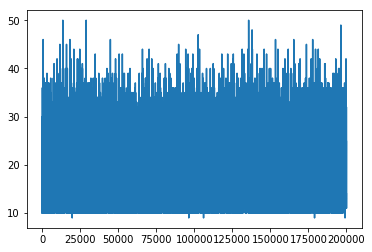

<Figure size 432x288 with 0 Axes>

In [ ]:
# Load SORN matrices

# with open('stdp2009_50un30conn.pkl','rb') as f:  
#     plastic_matrices,X_all,Y_all,R_all,frac_pos_active_conn = pickle.load(f)

with open('120000.pickle','rb') as f:  
    plastic_matrices,frac_pos_active_conn,w = pickle.load(f)

# Main loop 
# Make sure you update your weights AFTER each episode
for e in range(NUM_EPISODES):

    state = env.reset()[None,:]

    grads = []
    rewards = []

    # Keep track of game score to print
    score = 0
    
    while True:

        # Uncomment to see your model train in real time (slower)
        #env.render()
        
        
        if e > 20000: 
        
            """Training the reservoir + input and output layers"""
            # Note that reservoir states replaces variable name X_all from actual state variable name of SORN
            plastic_matrices,reservoir_states,Y_all,R_all,frac_pos_active_conn = train_sorn_plasticity.train_sorn(phase = 'Plasticity',
                                                                                           matrices = None,
                                                                                           inputs = state)
        
        else:
            """Reservoir weights are frozen"""
            plastic_matrices,reservoir_states,Y_all,R_all,frac_pos_active_conn = train_sorn.train_sorn(phase = 'Training',
                                                                                           matrices = plastic_matrices,
                                                                                           inputs = state)
        # Sample from policy and take action in environment
        probs = policy(np.asarray(reservoir_states),w)
        action = np.random.choice(nA,p=probs[0])
        next_state,reward,done,_ = env.step(action)
        next_state = next_state[None,:]

        # Compute gradient and save with reward in memory for our weight updates
        dsoftmax = softmax_grad(probs)[action,:]
        dlog = dsoftmax / probs[0,action]
        grad = np.asarray(reservoir_states).T.dot(dlog[None,:])

        grads.append(grad)
        rewards.append(reward)
        
        score+=reward

        # Dont forget to update your old state to the new state
        state = next_state
        if done:
            break
    
    if e % 1000 == 0:
        
        with open('%s.pickle' %e, 'wb') as f:
            pickle.dump([plastic_matrices,frac_pos_active_conn,w], f, protocol=pickle.HIGHEST_PROTOCOL)
            
    # Weight update
    for i in range(len(grads)):

        # Loop through everything that happend in the episode and update towards the log policy gradient times **FUTURE** reward
        w += LEARNING_RATE * grads[i] * sum([ r * (GAMMA ** r) for t,r in enumerate(rewards[i:])])

    # Append for logging and print
    episode_rewards.append(score) 
    # print("EP: " + str(e) + " Score: " + str(score) + "         ",end="\r", flush=False)
    
    print('Episode %s  Score %s' %(str(e),str(score)))

plt.plot(np.arange(NUM_EPISODES),episode_rewards)
plt.show()
plt.savefig('t.png')
env.close()
